# pix2pix
- [**paper**](https://arxiv.org/abs/1611.07004)
- Abstract
  - We investigate conditional adversarial networks as a general-purpose solution to image-to-image translation problems. These networks not only learn the mapping from input image to output image, but also learn a loss function to train this mapping. This makes it possible to apply the same generic approach to problems that traditionally would require very different loss formulations. We demonstrate that this approach is effective at synthesizing photos from label maps, reconstructing objects from edge maps, and colorizing images, among other tasks. Indeed, since the release of the pix2pix software associated with this paper, a large number of internet users (many of them artists) have posted their own experiments with our system, further demonstrating its wide applicability and ease of adoption without the need for parameter tweaking. As a community, we no longer hand-engineer our mapping functions, and this work suggests we can achieve reasonable results without hand-engineering our loss functions either.

![main](./images/pix2pix_01.png)

In [1]:
import os
import math
import functools
import numpy as np
from glob import glob
from PIL import Image
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Parameter

In [2]:
BATCH_SIZE = 1
EPOCHS = 200
LEARNING_RATE = 0.0002
LAMBDA = 100.0
DATASET_PATH = './datasets/facades' # train dataset: facades

In [3]:
writer = SummaryWriter('tensorboard')

## Dataset

In [4]:
def data_load(path, subfolder, transform, batch_size, shuffle=True):
    class ReadFolder(torch.utils.data.Dataset): 
        def __init__(self, path, transform):
            self.image_path = glob(os.path.join(path, subfolder, '*.*'))
            self.transform = transform
            
        def __len__(self):
            return len(self.image_path)
        
        def __getitem__(self, index):
            img = Image.open(self.image_path[index])
            in_img = img.crop((img.size[0] // 2, 0, img.size[0], img.size[1]))
            out_img = img.crop((0, 0, img.size[0] // 2, img.size[1]))
            in_img = self.transform(in_img)
            out_img = self.transform(out_img)
            
            return in_img, out_img
        
    dataset = ReadFolder(path, transform)

    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
train_loader = data_load(DATASET_PATH, 'train', transform, BATCH_SIZE, shuffle=True)

## View batch image

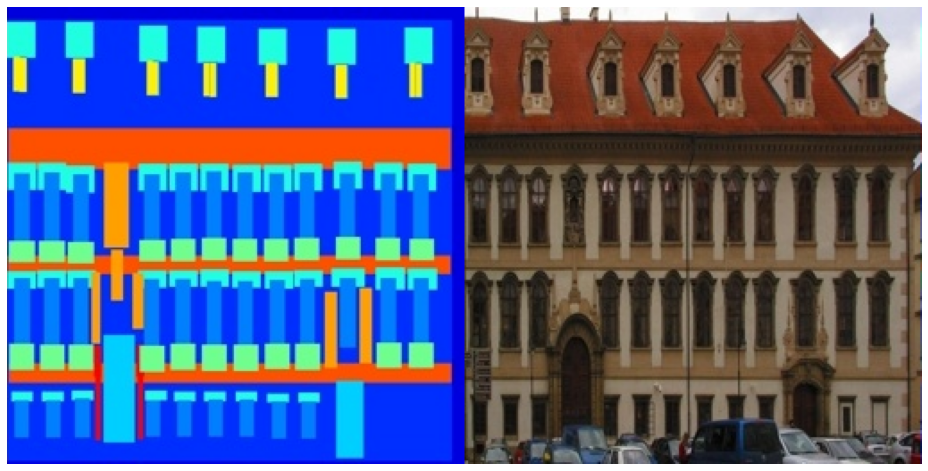

In [5]:
def display_one_image(image, subplot):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch): # input: [batch_size, dim, height, width]
    unloader = transforms.Compose([
        transforms.Normalize(mean=(-1.0, -1.0, -1.0), std=(2, 2, 2)),
        transforms.ToPILImage()
    ])

    rows = int(math.sqrt(databatch[0].size(0)))
    cols = databatch[0].size(0) // rows
    
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot = (rows, cols, 1)
    if rows / cols:
        plt.figure(figsize=(FIGSIZE, FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (in_img, out_img) in enumerate(zip(databatch[0], databatch[1])):
        in_img = unloader(in_img)
        out_img = unloader(out_img)
        
        whole_img = Image.new('RGB', (in_img.width + out_img.width, in_img.height))
        whole_img.paste(in_img, (0, 0))
        whole_img.paste(out_img, (in_img.width, 0))
    
        subplot = display_one_image(whole_img, subplot)
    
    #layout
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    
display_batch_of_images(next(iter(train_loader)))

## Define Generator Model

In [6]:
class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.
        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)

class UnetGenerator(nn.Module):
    """Create a Unet-based generator"""

    def __init__(self, input_nc, output_nc, num_downs, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            ngf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer
        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super(UnetGenerator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer
        for i in range(num_downs - 5):          # add intermediate layers with ngf * 8 filters
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  # add the outermost layer

    def forward(self, input):
        """Standard forward"""
        return self.model(input)

def init_weights(net, init_type='normal', init_gain=0.02):
    """Initialize network weights.
    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.
    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                nn.init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                nn.init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            nn.init.normal_(m.weight.data, 1.0, init_gain)
            nn.init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func>
    
def init_net(net, init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Initialize a network: 1. register CPU/GPU device (with multi-GPU support); 2. initialize the network weights
    Parameters:
        net (network)      -- the network to be initialized
        init_type (str)    -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        gain (float)       -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2
    Return an initialized network.
    """
    if len(gpu_ids) > 0:
        assert(torch.cuda.is_available())
        net.to(gpu_ids[0])
        net = torch.nn.DataParallel(net, gpu_ids)  # multi-GPUs
    init_weights(net, init_type, init_gain=init_gain)
    return net

def get_norm_layer(norm_type='instance'):
    """Return a normalization layer
    Parameters:
        norm_type (str) -- the name of the normalization layer: batch | instance | none
    For BatchNorm, we use learnable affine parameters and track running statistics (mean/stddev).
    For InstanceNorm, we do not use learnable affine parameters. We do not track running statistics.
    """
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)
    elif norm_type == 'instance':
        norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)
    elif norm_type == 'none':
        def norm_layer(x): return Identity()
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
    return norm_layer

def define_G(input_nc, output_nc, ngf, netG, norm='batch', use_dropout=False, init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Create a generator
    Parameters:
        input_nc (int) -- the number of channels in input images
        output_nc (int) -- the number of channels in output images
        ngf (int) -- the number of filters in the last conv layer
        netG (str) -- the architecture's name: resnet_9blocks | resnet_6blocks | unet_256 | unet_128
        norm (str) -- the name of normalization layers used in the network: batch | instance | none
        use_dropout (bool) -- if use dropout layers.
        init_type (str)    -- the name of our initialization method.
        init_gain (float)  -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2
    Returns a generator
    Our current implementation provides two types of generators:
        U-Net: [unet_128] (for 128x128 input images) and [unet_256] (for 256x256 input images)
        The original U-Net paper: https://arxiv.org/abs/1505.04597
        Resnet-based generator: [resnet_6blocks] (with 6 Resnet blocks) and [resnet_9blocks] (with 9 Resnet blocks)
        Resnet-based generator consists of several Resnet blocks between a few downsampling/upsampling operations.
        We adapt Torch code from Justin Johnson's neural style transfer project (https://github.com/jcjohnson/fast-neural-style).
    The generator has been initialized by <init_net>. It uses RELU for non-linearity.
    """
    net = None
    norm_layer = get_norm_layer(norm_type=norm)

    if netG == 'unet_128':
        net = UnetGenerator(input_nc, output_nc, 7, ngf, norm_layer=norm_layer, use_dropout=use_dropout)
    elif netG == 'unet_256':
        net = UnetGenerator(input_nc, output_nc, 8, ngf, norm_layer=norm_layer, use_dropout=use_dropout)
    else:
        raise NotImplementedError('Generator model name [%s] is not recognized' % netG)
    return init_net(net, init_type, init_gain, gpu_ids)

g = define_G(3, 3, 64, 'unet_256', 'instance', False, 'normal', 0.02, [0])

from torchscope import scope
scope(g, input_size=(3, 256, 256), batch_size=64)

initialize network with normal
------------------------------------------------------------------------------------------------------
        Layer (type)               Output Shape          Params           FLOPs           Madds
            Conv2d-1          [2, 64, 128, 128]           3,136      51,380,224     100,663,296
         LeakyReLU-2          [2, 64, 128, 128]               0       1,048,576               0
            Conv2d-3           [2, 128, 64, 64]         131,200     537,395,200   1,073,741,824
    InstanceNorm2d-4           [2, 128, 64, 64]               0               0               0
         LeakyReLU-5           [2, 128, 64, 64]               0         524,288               0
            Conv2d-6           [2, 256, 32, 32]         524,544     537,133,056   1,073,741,824
    InstanceNorm2d-7           [2, 256, 32, 32]               0               0               0
         LeakyReLU-8           [2, 256, 32, 32]               0         262,144               0
  

## Define Discriminator Model

In [7]:
class NLayerDiscriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(NLayerDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)

d = NLayerDiscriminator(6)

from torchscope import scope
scope(d, input_size=(6, 256, 256), batch_size=64)

------------------------------------------------------------------------------------------------------
        Layer (type)               Output Shape          Params           FLOPs           Madds
            Conv2d-1          [2, 64, 128, 128]           6,208     101,711,872     201,326,592
         LeakyReLU-2          [2, 64, 128, 128]               0       1,048,576               0
            Conv2d-3           [2, 128, 64, 64]         131,072     536,870,912   1,073,217,536
       BatchNorm2d-4           [2, 128, 64, 64]             256       1,048,576       2,097,152
         LeakyReLU-5           [2, 128, 64, 64]               0         524,288               0
            Conv2d-6           [2, 256, 32, 32]         524,288     536,870,912   1,073,479,680
       BatchNorm2d-7           [2, 256, 32, 32]             512         524,288       1,048,576
         LeakyReLU-8           [2, 256, 32, 32]               0         262,144               0
            Conv2d-9           [2

C:\Users\AIC_TASK\Anaconda3\envs\pytorch\lib\site-packages\torchscope\scope.py:100: RuntimeWarning: overflow encountered in long_scalars
  total_flops += self.summary[layer]["flops"]


## Train loop

In [8]:
valid_set = next(iter(train_loader))

g.to(device)
d.to(device)

ce_loss = nn.BCEWithLogitsLoss().to(device)
l1_loss = nn.L1Loss().to(device)

optim_G = torch.optim.Adam(g.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optim_D = torch.optim.Adam(d.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

os.makedirs('train_img', exist_ok=True)

for epoch in range(EPOCHS):
    for i, (in_img, out_img) in enumerate(train_loader):
        in_img = in_img.to(device)
        out_img = out_img.to(device)
        
        real_validity = torch.tensor(1.0)
        fake_validity = torch.tensor(0.0)
        
        gen_img = g(in_img)
        
        # Discriminator
        optim_D.zero_grad()
        
        fake_in = torch.cat((in_img, gen_img), 1).detach()
        pred_fake = d(fake_in)
        validity = real_validity.expand_as(pred_fake).to(device)
        fake_loss = ce_loss(pred_fake, validity)
        
        real_in = torch.cat((in_img, out_img), 1)
        pred_real = d(real_in)
        validity = fake_validity.expand_as(pred_real).to(device)
        real_loss = ce_loss(pred_real, validity)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        
        optim_D.step()
        
        # Generator
        optim_G.zero_grad()
        
        fake_in = torch.cat((in_img, gen_img), 1)
        pred = d(fake_in)
        validity = real_validity.expand_as(pred_real).to(device)
        g_loss = ce_loss(pred, validity)
        
        # L1 Loss
        g_l1_loss = l1_loss(gen_img, out_img)
        
        gen_loss = g_loss + g_l1_loss * LAMBDA
        gen_loss.backward()
        
        optim_G.step()
        
        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, EPOCHS, i, len(train_loader), d_loss.item(), gen_loss.item())
        )
        writer.add_scalar('G_loss', gen_loss.item(),epoch * len(train_loader) + i)
        writer.add_scalar('D_loss', d_loss.item(),epoch * len(train_loader) + i)
    
    g.eval()
    eval_imgs = g(valid_set[0])
    unloader = transforms.Compose([
        transforms.Normalize(mean=(-1.0, -1.0, -1.0), std=(2, 2, 2)),
        transforms.ToPILImage()
    ])
    
    in_img = unloader(valid_set[0][0])
    out_img = unloader(valid_set[1][0])
    gen_img = unloader(eval_imgs[0].detach().cpu())

    whole_img = Image.new('RGB', (in_img.width * 3, in_img.height))
    whole_img.paste(in_img, (0, 0))
    whole_img.paste(gen_img, (in_img.width, 0))
    whole_img.paste(out_img, (in_img.width * 2, 0))
    
    whole_img.save('train_img/e_{}.png'.format(epoch))
    g.train()

[Epoch 0/200] [Batch 0/400] [D loss: 0.704640] [G loss: 56.442348]
[Epoch 0/200] [Batch 1/400] [D loss: 0.779835] [G loss: 47.710037]
[Epoch 0/200] [Batch 2/400] [D loss: 0.858711] [G loss: 34.714199]
[Epoch 0/200] [Batch 3/400] [D loss: 0.756439] [G loss: 45.006451]
[Epoch 0/200] [Batch 4/400] [D loss: 0.708442] [G loss: 38.583763]
[Epoch 0/200] [Batch 5/400] [D loss: 0.684008] [G loss: 42.336464]
[Epoch 0/200] [Batch 6/400] [D loss: 0.700252] [G loss: 59.961948]
[Epoch 0/200] [Batch 7/400] [D loss: 0.690854] [G loss: 38.248447]
[Epoch 0/200] [Batch 8/400] [D loss: 0.701891] [G loss: 34.813980]
[Epoch 0/200] [Batch 9/400] [D loss: 0.664777] [G loss: 39.021648]
[Epoch 0/200] [Batch 10/400] [D loss: 0.618171] [G loss: 53.681889]
[Epoch 0/200] [Batch 11/400] [D loss: 0.620079] [G loss: 47.295448]
[Epoch 0/200] [Batch 12/400] [D loss: 0.614661] [G loss: 43.094482]
[Epoch 0/200] [Batch 13/400] [D loss: 0.656535] [G loss: 32.486687]
[Epoch 0/200] [Batch 14/400] [D loss: 0.602655] [G loss: 3

[Epoch 0/200] [Batch 122/400] [D loss: 0.012297] [G loss: 38.798542]
[Epoch 0/200] [Batch 123/400] [D loss: 0.024781] [G loss: 33.062038]
[Epoch 0/200] [Batch 124/400] [D loss: 0.014224] [G loss: 37.284485]
[Epoch 0/200] [Batch 125/400] [D loss: 0.023135] [G loss: 27.911779]
[Epoch 0/200] [Batch 126/400] [D loss: 0.012588] [G loss: 31.033072]
[Epoch 0/200] [Batch 127/400] [D loss: 0.009283] [G loss: 41.230289]
[Epoch 0/200] [Batch 128/400] [D loss: 0.013481] [G loss: 34.241692]
[Epoch 0/200] [Batch 129/400] [D loss: 0.028243] [G loss: 32.212227]
[Epoch 0/200] [Batch 130/400] [D loss: 0.009079] [G loss: 53.635052]
[Epoch 0/200] [Batch 131/400] [D loss: 0.113560] [G loss: 38.093445]
[Epoch 0/200] [Batch 132/400] [D loss: 0.832242] [G loss: 39.808537]
[Epoch 0/200] [Batch 133/400] [D loss: 0.974639] [G loss: 32.844090]
[Epoch 0/200] [Batch 134/400] [D loss: 1.147744] [G loss: 37.390968]
[Epoch 0/200] [Batch 135/400] [D loss: 1.528559] [G loss: 31.018972]
[Epoch 0/200] [Batch 136/400] [D l

[Epoch 0/200] [Batch 243/400] [D loss: 0.361683] [G loss: 33.526470]
[Epoch 0/200] [Batch 244/400] [D loss: 0.063045] [G loss: 38.279011]
[Epoch 0/200] [Batch 245/400] [D loss: 0.087458] [G loss: 33.416477]
[Epoch 0/200] [Batch 246/400] [D loss: 0.124107] [G loss: 33.772827]
[Epoch 0/200] [Batch 247/400] [D loss: 0.073784] [G loss: 33.722221]
[Epoch 0/200] [Batch 248/400] [D loss: 0.252656] [G loss: 48.923218]
[Epoch 0/200] [Batch 249/400] [D loss: 0.207493] [G loss: 41.409458]
[Epoch 0/200] [Batch 250/400] [D loss: 0.019263] [G loss: 35.559784]
[Epoch 0/200] [Batch 251/400] [D loss: 0.017067] [G loss: 37.376984]
[Epoch 0/200] [Batch 252/400] [D loss: 0.067570] [G loss: 30.524618]
[Epoch 0/200] [Batch 253/400] [D loss: 0.026932] [G loss: 39.701447]
[Epoch 0/200] [Batch 254/400] [D loss: 0.031074] [G loss: 35.391052]
[Epoch 0/200] [Batch 255/400] [D loss: 0.022765] [G loss: 31.339432]
[Epoch 0/200] [Batch 256/400] [D loss: 0.026836] [G loss: 34.258411]
[Epoch 0/200] [Batch 257/400] [D l

[Epoch 0/200] [Batch 364/400] [D loss: 0.006774] [G loss: 26.668764]
[Epoch 0/200] [Batch 365/400] [D loss: 0.013774] [G loss: 28.946280]
[Epoch 0/200] [Batch 366/400] [D loss: 0.005267] [G loss: 47.646206]
[Epoch 0/200] [Batch 367/400] [D loss: 0.018534] [G loss: 20.865904]
[Epoch 0/200] [Batch 368/400] [D loss: 0.003089] [G loss: 32.223606]
[Epoch 0/200] [Batch 369/400] [D loss: 0.003362] [G loss: 43.596226]
[Epoch 0/200] [Batch 370/400] [D loss: 0.004255] [G loss: 41.408375]
[Epoch 0/200] [Batch 371/400] [D loss: 0.009153] [G loss: 29.346594]
[Epoch 0/200] [Batch 372/400] [D loss: 0.003340] [G loss: 58.061218]
[Epoch 0/200] [Batch 373/400] [D loss: 0.023598] [G loss: 33.775501]
[Epoch 0/200] [Batch 374/400] [D loss: 0.013910] [G loss: 35.799370]
[Epoch 0/200] [Batch 375/400] [D loss: 0.005779] [G loss: 45.302288]
[Epoch 0/200] [Batch 376/400] [D loss: 0.004833] [G loss: 28.267797]
[Epoch 0/200] [Batch 377/400] [D loss: 0.003610] [G loss: 32.808437]
[Epoch 0/200] [Batch 378/400] [D l

[Epoch 1/200] [Batch 85/400] [D loss: 0.006276] [G loss: 30.700439]
[Epoch 1/200] [Batch 86/400] [D loss: 0.002742] [G loss: 36.333698]
[Epoch 1/200] [Batch 87/400] [D loss: 0.002766] [G loss: 42.977177]
[Epoch 1/200] [Batch 88/400] [D loss: 0.002071] [G loss: 38.135899]
[Epoch 1/200] [Batch 89/400] [D loss: 0.002467] [G loss: 24.410650]
[Epoch 1/200] [Batch 90/400] [D loss: 0.002082] [G loss: 63.351921]
[Epoch 1/200] [Batch 91/400] [D loss: 0.004804] [G loss: 54.424450]
[Epoch 1/200] [Batch 92/400] [D loss: 0.002684] [G loss: 28.979469]
[Epoch 1/200] [Batch 93/400] [D loss: 0.001732] [G loss: 36.411221]
[Epoch 1/200] [Batch 94/400] [D loss: 0.002453] [G loss: 33.004684]
[Epoch 1/200] [Batch 95/400] [D loss: 0.049310] [G loss: 39.698025]
[Epoch 1/200] [Batch 96/400] [D loss: 0.004323] [G loss: 31.996881]
[Epoch 1/200] [Batch 97/400] [D loss: 0.004468] [G loss: 36.482677]
[Epoch 1/200] [Batch 98/400] [D loss: 0.006278] [G loss: 34.054794]
[Epoch 1/200] [Batch 99/400] [D loss: 0.005171] 

[Epoch 1/200] [Batch 207/400] [D loss: 0.001067] [G loss: 45.534309]
[Epoch 1/200] [Batch 208/400] [D loss: 0.001518] [G loss: 44.352226]
[Epoch 1/200] [Batch 209/400] [D loss: 0.001057] [G loss: 36.766014]
[Epoch 1/200] [Batch 210/400] [D loss: 0.011979] [G loss: 19.314747]
[Epoch 1/200] [Batch 211/400] [D loss: 0.001753] [G loss: 35.735996]
[Epoch 1/200] [Batch 212/400] [D loss: 0.001789] [G loss: 32.015125]
[Epoch 1/200] [Batch 213/400] [D loss: 0.001307] [G loss: 52.063732]
[Epoch 1/200] [Batch 214/400] [D loss: 0.002054] [G loss: 41.389473]
[Epoch 1/200] [Batch 215/400] [D loss: 0.001263] [G loss: 40.600906]
[Epoch 1/200] [Batch 216/400] [D loss: 0.001712] [G loss: 35.145832]
[Epoch 1/200] [Batch 217/400] [D loss: 0.001256] [G loss: 37.133381]
[Epoch 1/200] [Batch 218/400] [D loss: 0.001632] [G loss: 32.202778]
[Epoch 1/200] [Batch 219/400] [D loss: 0.001057] [G loss: 38.559662]
[Epoch 1/200] [Batch 220/400] [D loss: 0.003040] [G loss: 30.154310]
[Epoch 1/200] [Batch 221/400] [D l

[Epoch 1/200] [Batch 327/400] [D loss: 0.015269] [G loss: 34.489174]
[Epoch 1/200] [Batch 328/400] [D loss: 0.009822] [G loss: 32.992401]
[Epoch 1/200] [Batch 329/400] [D loss: 0.011752] [G loss: 34.073048]
[Epoch 1/200] [Batch 330/400] [D loss: 0.027304] [G loss: 35.923714]
[Epoch 1/200] [Batch 331/400] [D loss: 0.011960] [G loss: 34.797356]
[Epoch 1/200] [Batch 332/400] [D loss: 0.026306] [G loss: 24.412127]
[Epoch 1/200] [Batch 333/400] [D loss: 0.012196] [G loss: 29.986692]
[Epoch 1/200] [Batch 334/400] [D loss: 0.019522] [G loss: 30.297905]
[Epoch 1/200] [Batch 335/400] [D loss: 0.077918] [G loss: 34.376141]
[Epoch 1/200] [Batch 336/400] [D loss: 0.044789] [G loss: 45.659695]
[Epoch 1/200] [Batch 337/400] [D loss: 0.007882] [G loss: 34.075710]
[Epoch 1/200] [Batch 338/400] [D loss: 0.053797] [G loss: 25.662424]
[Epoch 1/200] [Batch 339/400] [D loss: 0.007613] [G loss: 35.856068]
[Epoch 1/200] [Batch 340/400] [D loss: 0.011572] [G loss: 35.513954]
[Epoch 1/200] [Batch 341/400] [D l

[Epoch 2/200] [Batch 50/400] [D loss: 0.007207] [G loss: 29.437082]
[Epoch 2/200] [Batch 51/400] [D loss: 0.003635] [G loss: 41.751038]
[Epoch 2/200] [Batch 52/400] [D loss: 0.004798] [G loss: 29.946350]
[Epoch 2/200] [Batch 53/400] [D loss: 0.003277] [G loss: 28.957689]
[Epoch 2/200] [Batch 54/400] [D loss: 0.005311] [G loss: 30.859968]
[Epoch 2/200] [Batch 55/400] [D loss: 0.013410] [G loss: 23.792799]
[Epoch 2/200] [Batch 56/400] [D loss: 0.003655] [G loss: 42.557823]
[Epoch 2/200] [Batch 57/400] [D loss: 0.012690] [G loss: 53.204720]
[Epoch 2/200] [Batch 58/400] [D loss: 0.007511] [G loss: 35.045609]
[Epoch 2/200] [Batch 59/400] [D loss: 0.004833] [G loss: 30.507290]
[Epoch 2/200] [Batch 60/400] [D loss: 0.005551] [G loss: 31.338778]
[Epoch 2/200] [Batch 61/400] [D loss: 0.004445] [G loss: 47.553242]
[Epoch 2/200] [Batch 62/400] [D loss: 0.007844] [G loss: 27.045641]
[Epoch 2/200] [Batch 63/400] [D loss: 0.013316] [G loss: 37.625256]
[Epoch 2/200] [Batch 64/400] [D loss: 0.009148] 

[Epoch 2/200] [Batch 171/400] [D loss: 0.008594] [G loss: 27.771868]
[Epoch 2/200] [Batch 172/400] [D loss: 0.002935] [G loss: 31.185223]
[Epoch 2/200] [Batch 173/400] [D loss: 0.002062] [G loss: 35.968719]
[Epoch 2/200] [Batch 174/400] [D loss: 0.005249] [G loss: 30.055618]
[Epoch 2/200] [Batch 175/400] [D loss: 0.001371] [G loss: 40.829636]
[Epoch 2/200] [Batch 176/400] [D loss: 0.001669] [G loss: 37.629841]
[Epoch 2/200] [Batch 177/400] [D loss: 0.002512] [G loss: 32.735161]
[Epoch 2/200] [Batch 178/400] [D loss: 0.002290] [G loss: 23.606255]
[Epoch 2/200] [Batch 179/400] [D loss: 0.001729] [G loss: 31.307859]
[Epoch 2/200] [Batch 180/400] [D loss: 0.004272] [G loss: 25.986963]
[Epoch 2/200] [Batch 181/400] [D loss: 0.001441] [G loss: 31.032331]
[Epoch 2/200] [Batch 182/400] [D loss: 0.001540] [G loss: 39.112095]
[Epoch 2/200] [Batch 183/400] [D loss: 0.002632] [G loss: 34.175404]
[Epoch 2/200] [Batch 184/400] [D loss: 0.001141] [G loss: 42.523960]
[Epoch 2/200] [Batch 185/400] [D l

[Epoch 2/200] [Batch 291/400] [D loss: 0.001485] [G loss: 34.388409]
[Epoch 2/200] [Batch 292/400] [D loss: 0.002171] [G loss: 31.030973]
[Epoch 2/200] [Batch 293/400] [D loss: 0.001478] [G loss: 32.780346]
[Epoch 2/200] [Batch 294/400] [D loss: 0.001244] [G loss: 29.512337]
[Epoch 2/200] [Batch 295/400] [D loss: 0.001115] [G loss: 42.437733]
[Epoch 2/200] [Batch 296/400] [D loss: 0.001439] [G loss: 39.790379]
[Epoch 2/200] [Batch 297/400] [D loss: 0.001182] [G loss: 33.116135]
[Epoch 2/200] [Batch 298/400] [D loss: 0.001521] [G loss: 27.753569]
[Epoch 2/200] [Batch 299/400] [D loss: 0.000906] [G loss: 36.805103]
[Epoch 2/200] [Batch 300/400] [D loss: 0.003350] [G loss: 27.925098]
[Epoch 2/200] [Batch 301/400] [D loss: 0.001040] [G loss: 39.923374]
[Epoch 2/200] [Batch 302/400] [D loss: 0.002567] [G loss: 41.514938]
[Epoch 2/200] [Batch 303/400] [D loss: 0.001677] [G loss: 30.592487]
[Epoch 2/200] [Batch 304/400] [D loss: 0.002613] [G loss: 31.973392]
[Epoch 2/200] [Batch 305/400] [D l

[Epoch 3/200] [Batch 12/400] [D loss: 0.001557] [G loss: 26.879616]
[Epoch 3/200] [Batch 13/400] [D loss: 0.000843] [G loss: 44.306477]
[Epoch 3/200] [Batch 14/400] [D loss: 0.004021] [G loss: 43.371311]
[Epoch 3/200] [Batch 15/400] [D loss: 0.003978] [G loss: 43.252644]
[Epoch 3/200] [Batch 16/400] [D loss: 0.007804] [G loss: 37.258953]
[Epoch 3/200] [Batch 17/400] [D loss: 0.002426] [G loss: 23.983150]
[Epoch 3/200] [Batch 18/400] [D loss: 0.001689] [G loss: 38.532879]
[Epoch 3/200] [Batch 19/400] [D loss: 0.003013] [G loss: 36.178238]
[Epoch 3/200] [Batch 20/400] [D loss: 0.001806] [G loss: 28.910254]
[Epoch 3/200] [Batch 21/400] [D loss: 0.000999] [G loss: 35.603653]
[Epoch 3/200] [Batch 22/400] [D loss: 0.003006] [G loss: 27.634512]
[Epoch 3/200] [Batch 23/400] [D loss: 0.001298] [G loss: 43.716057]
[Epoch 3/200] [Batch 24/400] [D loss: 0.001102] [G loss: 27.074936]
[Epoch 3/200] [Batch 25/400] [D loss: 0.000951] [G loss: 44.223198]
[Epoch 3/200] [Batch 26/400] [D loss: 0.001915] 

[Epoch 3/200] [Batch 136/400] [D loss: 0.001136] [G loss: 31.226276]
[Epoch 3/200] [Batch 137/400] [D loss: 0.002256] [G loss: 27.495691]
[Epoch 3/200] [Batch 138/400] [D loss: 0.000846] [G loss: 32.924099]
[Epoch 3/200] [Batch 139/400] [D loss: 0.000602] [G loss: 34.146576]
[Epoch 3/200] [Batch 140/400] [D loss: 0.001041] [G loss: 36.960258]
[Epoch 3/200] [Batch 141/400] [D loss: 0.001406] [G loss: 28.386862]
[Epoch 3/200] [Batch 142/400] [D loss: 0.000767] [G loss: 39.588985]
[Epoch 3/200] [Batch 143/400] [D loss: 0.000560] [G loss: 39.354179]
[Epoch 3/200] [Batch 144/400] [D loss: 0.000633] [G loss: 39.959057]
[Epoch 3/200] [Batch 145/400] [D loss: 0.002133] [G loss: 22.287712]
[Epoch 3/200] [Batch 146/400] [D loss: 0.000649] [G loss: 29.148163]
[Epoch 3/200] [Batch 147/400] [D loss: 0.000626] [G loss: 36.859444]
[Epoch 3/200] [Batch 148/400] [D loss: 0.000753] [G loss: 38.579540]
[Epoch 3/200] [Batch 149/400] [D loss: 0.000821] [G loss: 25.716600]
[Epoch 3/200] [Batch 150/400] [D l

[Epoch 3/200] [Batch 256/400] [D loss: 0.000535] [G loss: 29.626459]
[Epoch 3/200] [Batch 257/400] [D loss: 0.001059] [G loss: 27.129068]
[Epoch 3/200] [Batch 258/400] [D loss: 0.000664] [G loss: 44.461998]
[Epoch 3/200] [Batch 259/400] [D loss: 0.000617] [G loss: 29.306801]
[Epoch 3/200] [Batch 260/400] [D loss: 0.000517] [G loss: 52.001083]
[Epoch 3/200] [Batch 261/400] [D loss: 0.000646] [G loss: 30.820129]
[Epoch 3/200] [Batch 262/400] [D loss: 0.013538] [G loss: 36.433437]
[Epoch 3/200] [Batch 263/400] [D loss: 0.001358] [G loss: 29.408894]
[Epoch 3/200] [Batch 264/400] [D loss: 0.001356] [G loss: 24.922548]
[Epoch 3/200] [Batch 265/400] [D loss: 0.004737] [G loss: 23.382767]
[Epoch 3/200] [Batch 266/400] [D loss: 0.002026] [G loss: 27.978800]
[Epoch 3/200] [Batch 267/400] [D loss: 0.002355] [G loss: 35.306698]
[Epoch 3/200] [Batch 268/400] [D loss: 0.000688] [G loss: 36.304543]
[Epoch 3/200] [Batch 269/400] [D loss: 0.000517] [G loss: 32.890911]
[Epoch 3/200] [Batch 270/400] [D l

[Epoch 3/200] [Batch 377/400] [D loss: 0.002188] [G loss: 28.936016]
[Epoch 3/200] [Batch 378/400] [D loss: 0.000610] [G loss: 32.487801]
[Epoch 3/200] [Batch 379/400] [D loss: 0.000504] [G loss: 36.464882]
[Epoch 3/200] [Batch 380/400] [D loss: 0.000649] [G loss: 27.470911]
[Epoch 3/200] [Batch 381/400] [D loss: 0.000414] [G loss: 36.227222]
[Epoch 3/200] [Batch 382/400] [D loss: 0.000704] [G loss: 31.346090]
[Epoch 3/200] [Batch 383/400] [D loss: 0.000373] [G loss: 37.088726]
[Epoch 3/200] [Batch 384/400] [D loss: 0.000464] [G loss: 26.705513]
[Epoch 3/200] [Batch 385/400] [D loss: 0.000367] [G loss: 31.469311]
[Epoch 3/200] [Batch 386/400] [D loss: 0.000349] [G loss: 34.362808]
[Epoch 3/200] [Batch 387/400] [D loss: 0.001290] [G loss: 41.717129]
[Epoch 3/200] [Batch 388/400] [D loss: 0.000300] [G loss: 55.954170]
[Epoch 3/200] [Batch 389/400] [D loss: 0.000329] [G loss: 32.351334]
[Epoch 3/200] [Batch 390/400] [D loss: 0.000464] [G loss: 38.946365]
[Epoch 3/200] [Batch 391/400] [D l

[Epoch 4/200] [Batch 100/400] [D loss: 0.000556] [G loss: 30.557726]
[Epoch 4/200] [Batch 101/400] [D loss: 0.000445] [G loss: 24.034044]
[Epoch 4/200] [Batch 102/400] [D loss: 0.000509] [G loss: 42.028309]
[Epoch 4/200] [Batch 103/400] [D loss: 0.000328] [G loss: 51.879669]
[Epoch 4/200] [Batch 104/400] [D loss: 0.000847] [G loss: 20.873190]
[Epoch 4/200] [Batch 105/400] [D loss: 0.000413] [G loss: 33.873417]
[Epoch 4/200] [Batch 106/400] [D loss: 0.001327] [G loss: 31.466955]
[Epoch 4/200] [Batch 107/400] [D loss: 0.000564] [G loss: 30.757931]
[Epoch 4/200] [Batch 108/400] [D loss: 0.000387] [G loss: 27.186522]
[Epoch 4/200] [Batch 109/400] [D loss: 0.001032] [G loss: 31.747957]
[Epoch 4/200] [Batch 110/400] [D loss: 0.000347] [G loss: 28.237139]
[Epoch 4/200] [Batch 111/400] [D loss: 0.000366] [G loss: 45.656521]
[Epoch 4/200] [Batch 112/400] [D loss: 0.000451] [G loss: 25.203409]
[Epoch 4/200] [Batch 113/400] [D loss: 0.001023] [G loss: 19.817287]
[Epoch 4/200] [Batch 114/400] [D l

[Epoch 4/200] [Batch 220/400] [D loss: 0.000574] [G loss: 24.195683]
[Epoch 4/200] [Batch 221/400] [D loss: 0.000294] [G loss: 37.901485]
[Epoch 4/200] [Batch 222/400] [D loss: 0.000396] [G loss: 41.484215]
[Epoch 4/200] [Batch 223/400] [D loss: 0.000366] [G loss: 47.436306]
[Epoch 4/200] [Batch 224/400] [D loss: 0.000468] [G loss: 26.690388]
[Epoch 4/200] [Batch 225/400] [D loss: 0.000906] [G loss: 31.133617]
[Epoch 4/200] [Batch 226/400] [D loss: 0.000403] [G loss: 29.575506]
[Epoch 4/200] [Batch 227/400] [D loss: 0.000829] [G loss: 29.392002]
[Epoch 4/200] [Batch 228/400] [D loss: 0.000204] [G loss: 32.885841]
[Epoch 4/200] [Batch 229/400] [D loss: 0.000506] [G loss: 33.006123]
[Epoch 4/200] [Batch 230/400] [D loss: 0.000328] [G loss: 29.599247]
[Epoch 4/200] [Batch 231/400] [D loss: 0.000324] [G loss: 34.251297]
[Epoch 4/200] [Batch 232/400] [D loss: 0.000662] [G loss: 30.136238]
[Epoch 4/200] [Batch 233/400] [D loss: 0.000266] [G loss: 35.532524]
[Epoch 4/200] [Batch 234/400] [D l

[Epoch 4/200] [Batch 340/400] [D loss: 0.003070] [G loss: 46.190792]
[Epoch 4/200] [Batch 341/400] [D loss: 0.003810] [G loss: 27.718431]
[Epoch 4/200] [Batch 342/400] [D loss: 0.004807] [G loss: 40.710369]
[Epoch 4/200] [Batch 343/400] [D loss: 0.010750] [G loss: 20.258398]
[Epoch 4/200] [Batch 344/400] [D loss: 0.003895] [G loss: 34.297207]
[Epoch 4/200] [Batch 345/400] [D loss: 0.005644] [G loss: 26.648609]
[Epoch 4/200] [Batch 346/400] [D loss: 0.002184] [G loss: 42.004826]
[Epoch 4/200] [Batch 347/400] [D loss: 0.003468] [G loss: 23.393894]
[Epoch 4/200] [Batch 348/400] [D loss: 0.003174] [G loss: 38.273926]
[Epoch 4/200] [Batch 349/400] [D loss: 0.002125] [G loss: 37.390320]
[Epoch 4/200] [Batch 350/400] [D loss: 0.003447] [G loss: 40.791042]
[Epoch 4/200] [Batch 351/400] [D loss: 0.004222] [G loss: 37.953026]
[Epoch 4/200] [Batch 352/400] [D loss: 0.004130] [G loss: 30.170612]
[Epoch 4/200] [Batch 353/400] [D loss: 0.002614] [G loss: 44.947803]
[Epoch 4/200] [Batch 354/400] [D l

[Epoch 5/200] [Batch 60/400] [D loss: 0.003039] [G loss: 26.899878]
[Epoch 5/200] [Batch 61/400] [D loss: 0.001786] [G loss: 33.618679]
[Epoch 5/200] [Batch 62/400] [D loss: 0.002070] [G loss: 40.930485]
[Epoch 5/200] [Batch 63/400] [D loss: 0.002295] [G loss: 32.912708]
[Epoch 5/200] [Batch 64/400] [D loss: 0.001288] [G loss: 34.886166]
[Epoch 5/200] [Batch 65/400] [D loss: 0.001528] [G loss: 38.805588]
[Epoch 5/200] [Batch 66/400] [D loss: 0.001313] [G loss: 44.418156]
[Epoch 5/200] [Batch 67/400] [D loss: 0.001679] [G loss: 31.256565]
[Epoch 5/200] [Batch 68/400] [D loss: 0.001428] [G loss: 49.905815]
[Epoch 5/200] [Batch 69/400] [D loss: 0.001206] [G loss: 26.620775]
[Epoch 5/200] [Batch 70/400] [D loss: 0.003141] [G loss: 43.657700]
[Epoch 5/200] [Batch 71/400] [D loss: 0.000982] [G loss: 38.843372]
[Epoch 5/200] [Batch 72/400] [D loss: 0.001104] [G loss: 41.710598]
[Epoch 5/200] [Batch 73/400] [D loss: 0.002227] [G loss: 28.031155]
[Epoch 5/200] [Batch 74/400] [D loss: 0.001209] 

[Epoch 5/200] [Batch 180/400] [D loss: 0.000719] [G loss: 34.124146]
[Epoch 5/200] [Batch 181/400] [D loss: 0.001582] [G loss: 33.875275]
[Epoch 5/200] [Batch 182/400] [D loss: 0.000832] [G loss: 27.304426]
[Epoch 5/200] [Batch 183/400] [D loss: 0.001745] [G loss: 28.183512]
[Epoch 5/200] [Batch 184/400] [D loss: 0.001186] [G loss: 43.980801]
[Epoch 5/200] [Batch 185/400] [D loss: 0.003214] [G loss: 27.338978]
[Epoch 5/200] [Batch 186/400] [D loss: 0.000684] [G loss: 31.951052]
[Epoch 5/200] [Batch 187/400] [D loss: 0.000857] [G loss: 36.657146]
[Epoch 5/200] [Batch 188/400] [D loss: 0.000724] [G loss: 41.099392]
[Epoch 5/200] [Batch 189/400] [D loss: 0.000496] [G loss: 37.791508]
[Epoch 5/200] [Batch 190/400] [D loss: 0.001145] [G loss: 27.421015]
[Epoch 5/200] [Batch 191/400] [D loss: 0.001801] [G loss: 27.533966]
[Epoch 5/200] [Batch 192/400] [D loss: 0.001100] [G loss: 36.604378]
[Epoch 5/200] [Batch 193/400] [D loss: 0.000676] [G loss: 34.564575]
[Epoch 5/200] [Batch 194/400] [D l

[Epoch 5/200] [Batch 300/400] [D loss: 0.000948] [G loss: 30.624792]
[Epoch 5/200] [Batch 301/400] [D loss: 0.002158] [G loss: 31.575647]
[Epoch 5/200] [Batch 302/400] [D loss: 0.000747] [G loss: 27.728310]
[Epoch 5/200] [Batch 303/400] [D loss: 0.000636] [G loss: 38.657871]
[Epoch 5/200] [Batch 304/400] [D loss: 0.001043] [G loss: 25.320356]
[Epoch 5/200] [Batch 305/400] [D loss: 0.001134] [G loss: 24.894667]
[Epoch 5/200] [Batch 306/400] [D loss: 0.000680] [G loss: 32.978947]
[Epoch 5/200] [Batch 307/400] [D loss: 0.000925] [G loss: 35.681686]
[Epoch 5/200] [Batch 308/400] [D loss: 0.001183] [G loss: 21.739090]
[Epoch 5/200] [Batch 309/400] [D loss: 0.001690] [G loss: 33.584522]
[Epoch 5/200] [Batch 310/400] [D loss: 0.000925] [G loss: 32.316769]
[Epoch 5/200] [Batch 311/400] [D loss: 0.001733] [G loss: 31.592798]
[Epoch 5/200] [Batch 312/400] [D loss: 0.000580] [G loss: 29.428108]
[Epoch 5/200] [Batch 313/400] [D loss: 0.000774] [G loss: 29.767801]
[Epoch 5/200] [Batch 314/400] [D l

[Epoch 6/200] [Batch 20/400] [D loss: 0.001975] [G loss: 20.977383]
[Epoch 6/200] [Batch 21/400] [D loss: 0.001336] [G loss: 39.274605]
[Epoch 6/200] [Batch 22/400] [D loss: 0.000620] [G loss: 41.794090]
[Epoch 6/200] [Batch 23/400] [D loss: 0.000512] [G loss: 31.769793]
[Epoch 6/200] [Batch 24/400] [D loss: 0.000626] [G loss: 24.409014]
[Epoch 6/200] [Batch 25/400] [D loss: 0.000800] [G loss: 37.904503]
[Epoch 6/200] [Batch 26/400] [D loss: 0.000635] [G loss: 26.302610]
[Epoch 6/200] [Batch 27/400] [D loss: 0.000583] [G loss: 26.600674]
[Epoch 6/200] [Batch 28/400] [D loss: 0.000609] [G loss: 30.592232]
[Epoch 6/200] [Batch 29/400] [D loss: 0.000771] [G loss: 33.661812]
[Epoch 6/200] [Batch 30/400] [D loss: 0.000619] [G loss: 31.928867]
[Epoch 6/200] [Batch 31/400] [D loss: 0.001060] [G loss: 33.034584]
[Epoch 6/200] [Batch 32/400] [D loss: 0.000646] [G loss: 34.146927]
[Epoch 6/200] [Batch 33/400] [D loss: 0.001006] [G loss: 26.667713]
[Epoch 6/200] [Batch 34/400] [D loss: 0.000708] 

[Epoch 6/200] [Batch 141/400] [D loss: 0.000975] [G loss: 34.333351]
[Epoch 6/200] [Batch 142/400] [D loss: 0.000498] [G loss: 28.598391]
[Epoch 6/200] [Batch 143/400] [D loss: 0.000584] [G loss: 41.656960]
[Epoch 6/200] [Batch 144/400] [D loss: 0.000403] [G loss: 29.339869]
[Epoch 6/200] [Batch 145/400] [D loss: 0.000532] [G loss: 34.740398]
[Epoch 6/200] [Batch 146/400] [D loss: 0.000365] [G loss: 26.774208]
[Epoch 6/200] [Batch 147/400] [D loss: 0.000533] [G loss: 35.703556]
[Epoch 6/200] [Batch 148/400] [D loss: 0.000449] [G loss: 36.613415]
[Epoch 6/200] [Batch 149/400] [D loss: 0.000785] [G loss: 27.551847]
[Epoch 6/200] [Batch 150/400] [D loss: 0.002166] [G loss: 28.749348]
[Epoch 6/200] [Batch 151/400] [D loss: 0.000684] [G loss: 30.231590]
[Epoch 6/200] [Batch 152/400] [D loss: 0.000395] [G loss: 54.450996]
[Epoch 6/200] [Batch 153/400] [D loss: 0.000538] [G loss: 32.371254]
[Epoch 6/200] [Batch 154/400] [D loss: 0.000618] [G loss: 42.120216]
[Epoch 6/200] [Batch 155/400] [D l

[Epoch 6/200] [Batch 263/400] [D loss: 0.000277] [G loss: 27.538097]
[Epoch 6/200] [Batch 264/400] [D loss: 0.000242] [G loss: 53.333603]
[Epoch 6/200] [Batch 265/400] [D loss: 0.000417] [G loss: 32.138554]
[Epoch 6/200] [Batch 266/400] [D loss: 0.001221] [G loss: 41.005112]
[Epoch 6/200] [Batch 267/400] [D loss: 0.000351] [G loss: 34.026344]
[Epoch 6/200] [Batch 268/400] [D loss: 0.000845] [G loss: 33.920914]
[Epoch 6/200] [Batch 269/400] [D loss: 0.000416] [G loss: 25.614767]
[Epoch 6/200] [Batch 270/400] [D loss: 0.001237] [G loss: 26.367035]
[Epoch 6/200] [Batch 271/400] [D loss: 0.000327] [G loss: 40.879337]
[Epoch 6/200] [Batch 272/400] [D loss: 0.000544] [G loss: 42.206173]
[Epoch 6/200] [Batch 273/400] [D loss: 0.000293] [G loss: 38.936161]
[Epoch 6/200] [Batch 274/400] [D loss: 0.000342] [G loss: 31.270569]
[Epoch 6/200] [Batch 275/400] [D loss: 0.000390] [G loss: 30.343170]
[Epoch 6/200] [Batch 276/400] [D loss: 0.000563] [G loss: 31.292807]
[Epoch 6/200] [Batch 277/400] [D l

[Epoch 6/200] [Batch 384/400] [D loss: 0.009118] [G loss: 37.183186]
[Epoch 6/200] [Batch 385/400] [D loss: 0.012136] [G loss: 41.780949]
[Epoch 6/200] [Batch 386/400] [D loss: 0.010634] [G loss: 27.577085]
[Epoch 6/200] [Batch 387/400] [D loss: 0.009171] [G loss: 47.314781]
[Epoch 6/200] [Batch 388/400] [D loss: 0.004972] [G loss: 41.460854]
[Epoch 6/200] [Batch 389/400] [D loss: 0.006321] [G loss: 26.056765]
[Epoch 6/200] [Batch 390/400] [D loss: 0.005538] [G loss: 29.334116]
[Epoch 6/200] [Batch 391/400] [D loss: 0.006031] [G loss: 38.266426]
[Epoch 6/200] [Batch 392/400] [D loss: 0.008100] [G loss: 26.085789]
[Epoch 6/200] [Batch 393/400] [D loss: 0.004549] [G loss: 32.074181]
[Epoch 6/200] [Batch 394/400] [D loss: 0.037527] [G loss: 31.741514]
[Epoch 6/200] [Batch 395/400] [D loss: 0.005978] [G loss: 28.639996]
[Epoch 6/200] [Batch 396/400] [D loss: 0.003944] [G loss: 32.675865]
[Epoch 6/200] [Batch 397/400] [D loss: 0.007847] [G loss: 38.168793]
[Epoch 6/200] [Batch 398/400] [D l

[Epoch 7/200] [Batch 108/400] [D loss: 0.001785] [G loss: 34.262348]
[Epoch 7/200] [Batch 109/400] [D loss: 0.005532] [G loss: 27.362190]
[Epoch 7/200] [Batch 110/400] [D loss: 0.002620] [G loss: 26.624737]
[Epoch 7/200] [Batch 111/400] [D loss: 0.002309] [G loss: 32.502171]
[Epoch 7/200] [Batch 112/400] [D loss: 0.002375] [G loss: 26.508064]
[Epoch 7/200] [Batch 113/400] [D loss: 0.003152] [G loss: 25.725718]
[Epoch 7/200] [Batch 114/400] [D loss: 0.003844] [G loss: 20.534786]
[Epoch 7/200] [Batch 115/400] [D loss: 0.003272] [G loss: 26.318710]
[Epoch 7/200] [Batch 116/400] [D loss: 0.001830] [G loss: 26.297390]
[Epoch 7/200] [Batch 117/400] [D loss: 0.002318] [G loss: 39.276073]
[Epoch 7/200] [Batch 118/400] [D loss: 0.002330] [G loss: 36.604973]
[Epoch 7/200] [Batch 119/400] [D loss: 0.002596] [G loss: 33.279427]
[Epoch 7/200] [Batch 120/400] [D loss: 0.002666] [G loss: 31.220947]
[Epoch 7/200] [Batch 121/400] [D loss: 0.002445] [G loss: 31.882641]
[Epoch 7/200] [Batch 122/400] [D l

[Epoch 7/200] [Batch 228/400] [D loss: 0.002404] [G loss: 32.446011]
[Epoch 7/200] [Batch 229/400] [D loss: 0.002106] [G loss: 36.800243]
[Epoch 7/200] [Batch 230/400] [D loss: 0.002301] [G loss: 25.405476]
[Epoch 7/200] [Batch 231/400] [D loss: 0.002535] [G loss: 29.440863]
[Epoch 7/200] [Batch 232/400] [D loss: 0.001764] [G loss: 26.923874]
[Epoch 7/200] [Batch 233/400] [D loss: 0.001316] [G loss: 29.335316]
[Epoch 7/200] [Batch 234/400] [D loss: 0.001432] [G loss: 41.282471]
[Epoch 7/200] [Batch 235/400] [D loss: 0.002778] [G loss: 37.825817]
[Epoch 7/200] [Batch 236/400] [D loss: 0.001651] [G loss: 27.808882]
[Epoch 7/200] [Batch 237/400] [D loss: 0.001952] [G loss: 26.808344]
[Epoch 7/200] [Batch 238/400] [D loss: 0.002263] [G loss: 30.944971]
[Epoch 7/200] [Batch 239/400] [D loss: 0.001477] [G loss: 26.648884]
[Epoch 7/200] [Batch 240/400] [D loss: 0.014629] [G loss: 46.730133]
[Epoch 7/200] [Batch 241/400] [D loss: 0.001554] [G loss: 50.494137]
[Epoch 7/200] [Batch 242/400] [D l

[Epoch 7/200] [Batch 348/400] [D loss: 0.000562] [G loss: 36.879845]
[Epoch 7/200] [Batch 349/400] [D loss: 0.001279] [G loss: 28.785069]
[Epoch 7/200] [Batch 350/400] [D loss: 0.000908] [G loss: 31.994242]
[Epoch 7/200] [Batch 351/400] [D loss: 0.001125] [G loss: 35.677998]
[Epoch 7/200] [Batch 352/400] [D loss: 0.001433] [G loss: 20.944656]
[Epoch 7/200] [Batch 353/400] [D loss: 0.001173] [G loss: 25.400425]
[Epoch 7/200] [Batch 354/400] [D loss: 0.000904] [G loss: 22.235371]
[Epoch 7/200] [Batch 355/400] [D loss: 0.001795] [G loss: 19.783278]
[Epoch 7/200] [Batch 356/400] [D loss: 0.000795] [G loss: 43.761780]
[Epoch 7/200] [Batch 357/400] [D loss: 0.001521] [G loss: 28.947414]
[Epoch 7/200] [Batch 358/400] [D loss: 0.000935] [G loss: 28.355034]
[Epoch 7/200] [Batch 359/400] [D loss: 0.001056] [G loss: 28.466682]
[Epoch 7/200] [Batch 360/400] [D loss: 0.002673] [G loss: 24.678185]
[Epoch 7/200] [Batch 361/400] [D loss: 0.000768] [G loss: 37.651798]
[Epoch 7/200] [Batch 362/400] [D l

[Epoch 8/200] [Batch 69/400] [D loss: 0.000905] [G loss: 37.428101]
[Epoch 8/200] [Batch 70/400] [D loss: 0.000804] [G loss: 33.868694]
[Epoch 8/200] [Batch 71/400] [D loss: 0.000852] [G loss: 28.136896]
[Epoch 8/200] [Batch 72/400] [D loss: 0.000904] [G loss: 33.973660]
[Epoch 8/200] [Batch 73/400] [D loss: 0.000735] [G loss: 31.678095]
[Epoch 8/200] [Batch 74/400] [D loss: 0.000818] [G loss: 34.800468]
[Epoch 8/200] [Batch 75/400] [D loss: 0.000758] [G loss: 33.475727]
[Epoch 8/200] [Batch 76/400] [D loss: 0.000824] [G loss: 36.427238]
[Epoch 8/200] [Batch 77/400] [D loss: 0.000520] [G loss: 28.870852]
[Epoch 8/200] [Batch 78/400] [D loss: 0.000649] [G loss: 47.689083]
[Epoch 8/200] [Batch 79/400] [D loss: 0.000817] [G loss: 35.211617]
[Epoch 8/200] [Batch 80/400] [D loss: 0.000948] [G loss: 42.523060]
[Epoch 8/200] [Batch 81/400] [D loss: 0.001405] [G loss: 32.354820]
[Epoch 8/200] [Batch 82/400] [D loss: 0.001365] [G loss: 24.046692]
[Epoch 8/200] [Batch 83/400] [D loss: 0.000826] 

[Epoch 8/200] [Batch 189/400] [D loss: 0.000711] [G loss: 27.194349]
[Epoch 8/200] [Batch 190/400] [D loss: 0.001386] [G loss: 25.273130]
[Epoch 8/200] [Batch 191/400] [D loss: 0.000340] [G loss: 30.513872]
[Epoch 8/200] [Batch 192/400] [D loss: 0.002038] [G loss: 26.353849]
[Epoch 8/200] [Batch 193/400] [D loss: 0.000576] [G loss: 32.933876]
[Epoch 8/200] [Batch 194/400] [D loss: 0.000685] [G loss: 30.844782]
[Epoch 8/200] [Batch 195/400] [D loss: 0.000500] [G loss: 30.212685]
[Epoch 8/200] [Batch 196/400] [D loss: 0.000997] [G loss: 20.914429]
[Epoch 8/200] [Batch 197/400] [D loss: 0.000940] [G loss: 21.832247]
[Epoch 8/200] [Batch 198/400] [D loss: 0.001228] [G loss: 41.756123]
[Epoch 8/200] [Batch 199/400] [D loss: 0.000438] [G loss: 22.080400]
[Epoch 8/200] [Batch 200/400] [D loss: 0.000555] [G loss: 30.744835]
[Epoch 8/200] [Batch 201/400] [D loss: 0.000694] [G loss: 24.247284]
[Epoch 8/200] [Batch 202/400] [D loss: 0.000775] [G loss: 40.377575]
[Epoch 8/200] [Batch 203/400] [D l

[Epoch 8/200] [Batch 309/400] [D loss: 0.000849] [G loss: 27.273624]
[Epoch 8/200] [Batch 310/400] [D loss: 0.000772] [G loss: 25.296352]
[Epoch 8/200] [Batch 311/400] [D loss: 0.000616] [G loss: 39.101559]
[Epoch 8/200] [Batch 312/400] [D loss: 0.000448] [G loss: 28.306011]
[Epoch 8/200] [Batch 313/400] [D loss: 0.000662] [G loss: 34.225815]
[Epoch 8/200] [Batch 314/400] [D loss: 0.000506] [G loss: 37.812683]
[Epoch 8/200] [Batch 315/400] [D loss: 0.001059] [G loss: 27.886736]
[Epoch 8/200] [Batch 316/400] [D loss: 0.000653] [G loss: 32.937286]
[Epoch 8/200] [Batch 317/400] [D loss: 0.000380] [G loss: 31.985071]
[Epoch 8/200] [Batch 318/400] [D loss: 0.000366] [G loss: 29.746614]
[Epoch 8/200] [Batch 319/400] [D loss: 0.000599] [G loss: 32.479355]
[Epoch 8/200] [Batch 320/400] [D loss: 0.000465] [G loss: 36.035812]
[Epoch 8/200] [Batch 321/400] [D loss: 0.000638] [G loss: 29.732258]
[Epoch 8/200] [Batch 322/400] [D loss: 0.000704] [G loss: 28.716522]
[Epoch 8/200] [Batch 323/400] [D l

[Epoch 9/200] [Batch 32/400] [D loss: 0.001638] [G loss: 28.098127]
[Epoch 9/200] [Batch 33/400] [D loss: 0.002596] [G loss: 31.412714]
[Epoch 9/200] [Batch 34/400] [D loss: 0.002289] [G loss: 19.503248]
[Epoch 9/200] [Batch 35/400] [D loss: 0.002888] [G loss: 25.493034]
[Epoch 9/200] [Batch 36/400] [D loss: 0.003409] [G loss: 33.673843]
[Epoch 9/200] [Batch 37/400] [D loss: 0.002491] [G loss: 29.878201]
[Epoch 9/200] [Batch 38/400] [D loss: 0.002800] [G loss: 34.090424]
[Epoch 9/200] [Batch 39/400] [D loss: 0.001328] [G loss: 33.954262]
[Epoch 9/200] [Batch 40/400] [D loss: 0.001243] [G loss: 37.431751]
[Epoch 9/200] [Batch 41/400] [D loss: 0.001618] [G loss: 24.703094]
[Epoch 9/200] [Batch 42/400] [D loss: 0.001111] [G loss: 35.438797]
[Epoch 9/200] [Batch 43/400] [D loss: 0.001699] [G loss: 25.678473]
[Epoch 9/200] [Batch 44/400] [D loss: 0.001816] [G loss: 25.992008]
[Epoch 9/200] [Batch 45/400] [D loss: 0.002612] [G loss: 22.632763]
[Epoch 9/200] [Batch 46/400] [D loss: 0.001185] 

[Epoch 9/200] [Batch 152/400] [D loss: 0.001987] [G loss: 24.927969]
[Epoch 9/200] [Batch 153/400] [D loss: 0.001334] [G loss: 19.903984]
[Epoch 9/200] [Batch 154/400] [D loss: 0.001426] [G loss: 22.706999]
[Epoch 9/200] [Batch 155/400] [D loss: 0.002611] [G loss: 26.170588]
[Epoch 9/200] [Batch 156/400] [D loss: 0.014110] [G loss: 26.879475]
[Epoch 9/200] [Batch 157/400] [D loss: 0.001316] [G loss: 27.018583]
[Epoch 9/200] [Batch 158/400] [D loss: 0.001035] [G loss: 18.479322]
[Epoch 9/200] [Batch 159/400] [D loss: 0.000727] [G loss: 24.805498]
[Epoch 9/200] [Batch 160/400] [D loss: 0.000637] [G loss: 34.362835]
[Epoch 9/200] [Batch 161/400] [D loss: 0.001092] [G loss: 32.129208]
[Epoch 9/200] [Batch 162/400] [D loss: 0.001602] [G loss: 40.791370]
[Epoch 9/200] [Batch 163/400] [D loss: 0.001493] [G loss: 20.534750]
[Epoch 9/200] [Batch 164/400] [D loss: 0.000909] [G loss: 20.017981]
[Epoch 9/200] [Batch 165/400] [D loss: 0.001424] [G loss: 28.840212]
[Epoch 9/200] [Batch 166/400] [D l

[Epoch 9/200] [Batch 273/400] [D loss: 0.000977] [G loss: 27.841675]
[Epoch 9/200] [Batch 274/400] [D loss: 0.000712] [G loss: 23.859434]
[Epoch 9/200] [Batch 275/400] [D loss: 0.000530] [G loss: 24.676836]
[Epoch 9/200] [Batch 276/400] [D loss: 0.000554] [G loss: 26.010874]
[Epoch 9/200] [Batch 277/400] [D loss: 0.000940] [G loss: 19.733118]
[Epoch 9/200] [Batch 278/400] [D loss: 0.001038] [G loss: 24.508770]
[Epoch 9/200] [Batch 279/400] [D loss: 0.000575] [G loss: 26.367474]
[Epoch 9/200] [Batch 280/400] [D loss: 0.000930] [G loss: 35.253323]
[Epoch 9/200] [Batch 281/400] [D loss: 0.000441] [G loss: 25.846769]
[Epoch 9/200] [Batch 282/400] [D loss: 0.000819] [G loss: 36.793491]
[Epoch 9/200] [Batch 283/400] [D loss: 0.000764] [G loss: 25.926718]
[Epoch 9/200] [Batch 284/400] [D loss: 0.000512] [G loss: 32.578617]
[Epoch 9/200] [Batch 285/400] [D loss: 0.002380] [G loss: 28.600979]
[Epoch 9/200] [Batch 286/400] [D loss: 0.000449] [G loss: 28.113554]
[Epoch 9/200] [Batch 287/400] [D l

[Epoch 9/200] [Batch 395/400] [D loss: 0.000427] [G loss: 28.131182]
[Epoch 9/200] [Batch 396/400] [D loss: 0.000680] [G loss: 25.519476]
[Epoch 9/200] [Batch 397/400] [D loss: 0.000476] [G loss: 40.211010]
[Epoch 9/200] [Batch 398/400] [D loss: 0.000616] [G loss: 33.463387]
[Epoch 9/200] [Batch 399/400] [D loss: 0.000850] [G loss: 24.316294]
[Epoch 10/200] [Batch 0/400] [D loss: 0.000893] [G loss: 27.806980]
[Epoch 10/200] [Batch 1/400] [D loss: 0.002453] [G loss: 31.071440]
[Epoch 10/200] [Batch 2/400] [D loss: 0.000507] [G loss: 31.160616]
[Epoch 10/200] [Batch 3/400] [D loss: 0.000462] [G loss: 25.500092]
[Epoch 10/200] [Batch 4/400] [D loss: 0.000773] [G loss: 29.665293]
[Epoch 10/200] [Batch 5/400] [D loss: 0.000536] [G loss: 25.931965]
[Epoch 10/200] [Batch 6/400] [D loss: 0.000951] [G loss: 31.411018]
[Epoch 10/200] [Batch 7/400] [D loss: 0.000369] [G loss: 21.861752]
[Epoch 10/200] [Batch 8/400] [D loss: 0.000349] [G loss: 32.186279]
[Epoch 10/200] [Batch 9/400] [D loss: 0.000

[Epoch 10/200] [Batch 114/400] [D loss: 0.000396] [G loss: 28.589293]
[Epoch 10/200] [Batch 115/400] [D loss: 0.000462] [G loss: 26.207846]
[Epoch 10/200] [Batch 116/400] [D loss: 0.000393] [G loss: 32.566547]
[Epoch 10/200] [Batch 117/400] [D loss: 0.000749] [G loss: 20.917267]
[Epoch 10/200] [Batch 118/400] [D loss: 0.000577] [G loss: 28.182808]
[Epoch 10/200] [Batch 119/400] [D loss: 0.000397] [G loss: 23.034470]
[Epoch 10/200] [Batch 120/400] [D loss: 0.000421] [G loss: 23.093004]
[Epoch 10/200] [Batch 121/400] [D loss: 0.000378] [G loss: 26.493166]
[Epoch 10/200] [Batch 122/400] [D loss: 0.000669] [G loss: 28.681311]
[Epoch 10/200] [Batch 123/400] [D loss: 0.000271] [G loss: 24.226530]
[Epoch 10/200] [Batch 124/400] [D loss: 0.000468] [G loss: 26.793961]
[Epoch 10/200] [Batch 125/400] [D loss: 0.000274] [G loss: 27.894304]
[Epoch 10/200] [Batch 126/400] [D loss: 0.000634] [G loss: 35.945961]
[Epoch 10/200] [Batch 127/400] [D loss: 0.000382] [G loss: 20.688959]
[Epoch 10/200] [Batc

[Epoch 10/200] [Batch 234/400] [D loss: 0.000517] [G loss: 27.449717]
[Epoch 10/200] [Batch 235/400] [D loss: 0.000680] [G loss: 21.807066]
[Epoch 10/200] [Batch 236/400] [D loss: 0.000780] [G loss: 28.686644]
[Epoch 10/200] [Batch 237/400] [D loss: 0.000752] [G loss: 29.670410]
[Epoch 10/200] [Batch 238/400] [D loss: 0.000733] [G loss: 20.575819]
[Epoch 10/200] [Batch 239/400] [D loss: 0.000444] [G loss: 32.786373]
[Epoch 10/200] [Batch 240/400] [D loss: 0.000924] [G loss: 26.382822]
[Epoch 10/200] [Batch 241/400] [D loss: 0.000780] [G loss: 32.756554]
[Epoch 10/200] [Batch 242/400] [D loss: 0.000665] [G loss: 35.923485]
[Epoch 10/200] [Batch 243/400] [D loss: 0.001032] [G loss: 21.163490]
[Epoch 10/200] [Batch 244/400] [D loss: 0.000856] [G loss: 31.710457]
[Epoch 10/200] [Batch 245/400] [D loss: 0.000519] [G loss: 22.539642]
[Epoch 10/200] [Batch 246/400] [D loss: 0.000567] [G loss: 25.346678]
[Epoch 10/200] [Batch 247/400] [D loss: 0.000541] [G loss: 19.190929]
[Epoch 10/200] [Batc

[Epoch 10/200] [Batch 354/400] [D loss: 0.000459] [G loss: 24.034939]
[Epoch 10/200] [Batch 355/400] [D loss: 0.000396] [G loss: 27.121588]
[Epoch 10/200] [Batch 356/400] [D loss: 0.000644] [G loss: 26.788212]
[Epoch 10/200] [Batch 357/400] [D loss: 0.000584] [G loss: 36.799236]
[Epoch 10/200] [Batch 358/400] [D loss: 0.000651] [G loss: 31.327425]
[Epoch 10/200] [Batch 359/400] [D loss: 0.000635] [G loss: 24.143242]
[Epoch 10/200] [Batch 360/400] [D loss: 0.000504] [G loss: 37.657623]
[Epoch 10/200] [Batch 361/400] [D loss: 0.000908] [G loss: 26.842419]
[Epoch 10/200] [Batch 362/400] [D loss: 0.000860] [G loss: 30.933699]
[Epoch 10/200] [Batch 363/400] [D loss: 0.000695] [G loss: 33.225719]
[Epoch 10/200] [Batch 364/400] [D loss: 0.000400] [G loss: 23.196667]
[Epoch 10/200] [Batch 365/400] [D loss: 0.000445] [G loss: 29.376661]
[Epoch 10/200] [Batch 366/400] [D loss: 0.000369] [G loss: 33.464592]
[Epoch 10/200] [Batch 367/400] [D loss: 0.000263] [G loss: 27.449709]
[Epoch 10/200] [Batc

[Epoch 11/200] [Batch 75/400] [D loss: 0.000505] [G loss: 33.238716]
[Epoch 11/200] [Batch 76/400] [D loss: 0.000401] [G loss: 19.364435]
[Epoch 11/200] [Batch 77/400] [D loss: 0.000311] [G loss: 31.597025]
[Epoch 11/200] [Batch 78/400] [D loss: 0.000461] [G loss: 28.880922]
[Epoch 11/200] [Batch 79/400] [D loss: 0.000238] [G loss: 24.810915]
[Epoch 11/200] [Batch 80/400] [D loss: 0.000600] [G loss: 34.382771]
[Epoch 11/200] [Batch 81/400] [D loss: 0.000453] [G loss: 27.933445]
[Epoch 11/200] [Batch 82/400] [D loss: 0.000250] [G loss: 18.777317]
[Epoch 11/200] [Batch 83/400] [D loss: 0.000244] [G loss: 27.876913]
[Epoch 11/200] [Batch 84/400] [D loss: 0.000351] [G loss: 34.712337]
[Epoch 11/200] [Batch 85/400] [D loss: 0.000562] [G loss: 26.825562]
[Epoch 11/200] [Batch 86/400] [D loss: 0.000480] [G loss: 20.125679]
[Epoch 11/200] [Batch 87/400] [D loss: 0.000319] [G loss: 19.860746]
[Epoch 11/200] [Batch 88/400] [D loss: 0.000774] [G loss: 23.345852]
[Epoch 11/200] [Batch 89/400] [D l

[Epoch 11/200] [Batch 195/400] [D loss: 0.000304] [G loss: 43.065506]
[Epoch 11/200] [Batch 196/400] [D loss: 0.000678] [G loss: 20.429302]
[Epoch 11/200] [Batch 197/400] [D loss: 0.000259] [G loss: 34.135788]
[Epoch 11/200] [Batch 198/400] [D loss: 0.000832] [G loss: 31.990583]
[Epoch 11/200] [Batch 199/400] [D loss: 0.000666] [G loss: 29.976387]
[Epoch 11/200] [Batch 200/400] [D loss: 0.000382] [G loss: 24.367769]
[Epoch 11/200] [Batch 201/400] [D loss: 0.000393] [G loss: 25.359844]
[Epoch 11/200] [Batch 202/400] [D loss: 0.000202] [G loss: 22.320915]
[Epoch 11/200] [Batch 203/400] [D loss: 0.000320] [G loss: 24.548681]
[Epoch 11/200] [Batch 204/400] [D loss: 0.000247] [G loss: 27.648474]
[Epoch 11/200] [Batch 205/400] [D loss: 0.000183] [G loss: 25.527693]
[Epoch 11/200] [Batch 206/400] [D loss: 0.000154] [G loss: 28.024504]
[Epoch 11/200] [Batch 207/400] [D loss: 0.000384] [G loss: 24.636822]
[Epoch 11/200] [Batch 208/400] [D loss: 0.000254] [G loss: 23.739439]
[Epoch 11/200] [Batc

[Epoch 11/200] [Batch 314/400] [D loss: 0.000279] [G loss: 25.661676]
[Epoch 11/200] [Batch 315/400] [D loss: 0.000177] [G loss: 20.570820]
[Epoch 11/200] [Batch 316/400] [D loss: 0.000300] [G loss: 23.927950]
[Epoch 11/200] [Batch 317/400] [D loss: 0.000680] [G loss: 28.887815]
[Epoch 11/200] [Batch 318/400] [D loss: 0.000465] [G loss: 30.230865]
[Epoch 11/200] [Batch 319/400] [D loss: 0.000263] [G loss: 28.383127]
[Epoch 11/200] [Batch 320/400] [D loss: 0.000327] [G loss: 40.650566]
[Epoch 11/200] [Batch 321/400] [D loss: 0.000265] [G loss: 35.858006]
[Epoch 11/200] [Batch 322/400] [D loss: 0.001564] [G loss: 28.946949]
[Epoch 11/200] [Batch 323/400] [D loss: 0.000293] [G loss: 19.846701]
[Epoch 11/200] [Batch 324/400] [D loss: 0.000186] [G loss: 22.298550]
[Epoch 11/200] [Batch 325/400] [D loss: 0.000299] [G loss: 25.636354]
[Epoch 11/200] [Batch 326/400] [D loss: 0.000276] [G loss: 23.895216]
[Epoch 11/200] [Batch 327/400] [D loss: 0.000454] [G loss: 21.743586]
[Epoch 11/200] [Batc

[Epoch 12/200] [Batch 33/400] [D loss: 0.000280] [G loss: 33.104336]
[Epoch 12/200] [Batch 34/400] [D loss: 0.000344] [G loss: 37.176479]
[Epoch 12/200] [Batch 35/400] [D loss: 0.000219] [G loss: 18.614214]
[Epoch 12/200] [Batch 36/400] [D loss: 0.000186] [G loss: 32.104179]
[Epoch 12/200] [Batch 37/400] [D loss: 0.000275] [G loss: 22.453154]
[Epoch 12/200] [Batch 38/400] [D loss: 0.000223] [G loss: 18.245670]
[Epoch 12/200] [Batch 39/400] [D loss: 0.000186] [G loss: 30.829605]
[Epoch 12/200] [Batch 40/400] [D loss: 0.000218] [G loss: 14.701956]
[Epoch 12/200] [Batch 41/400] [D loss: 0.000262] [G loss: 26.579123]
[Epoch 12/200] [Batch 42/400] [D loss: 0.000353] [G loss: 27.250549]
[Epoch 12/200] [Batch 43/400] [D loss: 0.000246] [G loss: 31.979227]
[Epoch 12/200] [Batch 44/400] [D loss: 0.000182] [G loss: 18.295906]
[Epoch 12/200] [Batch 45/400] [D loss: 0.000294] [G loss: 30.575682]
[Epoch 12/200] [Batch 46/400] [D loss: 0.000412] [G loss: 33.300743]
[Epoch 12/200] [Batch 47/400] [D l

[Epoch 12/200] [Batch 153/400] [D loss: 0.000508] [G loss: 33.339821]
[Epoch 12/200] [Batch 154/400] [D loss: 0.000205] [G loss: 31.947927]
[Epoch 12/200] [Batch 155/400] [D loss: 0.000099] [G loss: 22.036152]
[Epoch 12/200] [Batch 156/400] [D loss: 0.000158] [G loss: 28.919748]
[Epoch 12/200] [Batch 157/400] [D loss: 0.000119] [G loss: 30.944349]
[Epoch 12/200] [Batch 158/400] [D loss: 0.000175] [G loss: 23.630880]
[Epoch 12/200] [Batch 159/400] [D loss: 0.000131] [G loss: 23.012901]
[Epoch 12/200] [Batch 160/400] [D loss: 0.000167] [G loss: 25.256826]
[Epoch 12/200] [Batch 161/400] [D loss: 0.000151] [G loss: 16.781868]
[Epoch 12/200] [Batch 162/400] [D loss: 0.000287] [G loss: 36.579208]
[Epoch 12/200] [Batch 163/400] [D loss: 0.000620] [G loss: 27.340788]
[Epoch 12/200] [Batch 164/400] [D loss: 0.000177] [G loss: 22.920849]
[Epoch 12/200] [Batch 165/400] [D loss: 0.000193] [G loss: 24.873528]
[Epoch 12/200] [Batch 166/400] [D loss: 0.000279] [G loss: 19.272863]
[Epoch 12/200] [Batc

[Epoch 12/200] [Batch 273/400] [D loss: 0.001007] [G loss: 34.134209]
[Epoch 12/200] [Batch 274/400] [D loss: 0.001061] [G loss: 20.017218]
[Epoch 12/200] [Batch 275/400] [D loss: 0.000500] [G loss: 30.160048]
[Epoch 12/200] [Batch 276/400] [D loss: 0.000679] [G loss: 32.392208]
[Epoch 12/200] [Batch 277/400] [D loss: 0.000449] [G loss: 30.735710]
[Epoch 12/200] [Batch 278/400] [D loss: 0.000312] [G loss: 30.739223]
[Epoch 12/200] [Batch 279/400] [D loss: 0.000221] [G loss: 16.976583]
[Epoch 12/200] [Batch 280/400] [D loss: 0.000295] [G loss: 27.865143]
[Epoch 12/200] [Batch 281/400] [D loss: 0.000152] [G loss: 20.811821]
[Epoch 12/200] [Batch 282/400] [D loss: 0.000414] [G loss: 28.839869]
[Epoch 12/200] [Batch 283/400] [D loss: 0.000172] [G loss: 27.519941]
[Epoch 12/200] [Batch 284/400] [D loss: 0.000267] [G loss: 26.633095]
[Epoch 12/200] [Batch 285/400] [D loss: 0.000245] [G loss: 21.897861]
[Epoch 12/200] [Batch 286/400] [D loss: 0.000569] [G loss: 27.474257]
[Epoch 12/200] [Batc

[Epoch 12/200] [Batch 391/400] [D loss: 0.000103] [G loss: 27.147289]
[Epoch 12/200] [Batch 392/400] [D loss: 0.000154] [G loss: 20.629658]
[Epoch 12/200] [Batch 393/400] [D loss: 0.000167] [G loss: 23.881922]
[Epoch 12/200] [Batch 394/400] [D loss: 0.000088] [G loss: 23.897137]
[Epoch 12/200] [Batch 395/400] [D loss: 0.000073] [G loss: 27.785980]
[Epoch 12/200] [Batch 396/400] [D loss: 0.000399] [G loss: 19.129847]
[Epoch 12/200] [Batch 397/400] [D loss: 0.000063] [G loss: 22.108948]
[Epoch 12/200] [Batch 398/400] [D loss: 0.000089] [G loss: 27.089460]
[Epoch 12/200] [Batch 399/400] [D loss: 0.000327] [G loss: 27.709438]
[Epoch 13/200] [Batch 0/400] [D loss: 0.000173] [G loss: 23.228497]
[Epoch 13/200] [Batch 1/400] [D loss: 0.000084] [G loss: 22.850128]
[Epoch 13/200] [Batch 2/400] [D loss: 0.000284] [G loss: 26.900648]
[Epoch 13/200] [Batch 3/400] [D loss: 0.000103] [G loss: 24.840780]
[Epoch 13/200] [Batch 4/400] [D loss: 0.000149] [G loss: 25.768948]
[Epoch 13/200] [Batch 5/400] [

[Epoch 13/200] [Batch 111/400] [D loss: 0.000062] [G loss: 19.771738]
[Epoch 13/200] [Batch 112/400] [D loss: 0.000181] [G loss: 23.800200]
[Epoch 13/200] [Batch 113/400] [D loss: 0.000130] [G loss: 23.008257]
[Epoch 13/200] [Batch 114/400] [D loss: 0.000196] [G loss: 31.566555]
[Epoch 13/200] [Batch 115/400] [D loss: 0.000082] [G loss: 16.427074]
[Epoch 13/200] [Batch 116/400] [D loss: 0.000236] [G loss: 24.218752]
[Epoch 13/200] [Batch 117/400] [D loss: 0.000107] [G loss: 23.965111]
[Epoch 13/200] [Batch 118/400] [D loss: 0.000118] [G loss: 34.837440]
[Epoch 13/200] [Batch 119/400] [D loss: 0.000172] [G loss: 25.822256]
[Epoch 13/200] [Batch 120/400] [D loss: 0.000132] [G loss: 27.257799]
[Epoch 13/200] [Batch 121/400] [D loss: 0.000156] [G loss: 29.912806]
[Epoch 13/200] [Batch 122/400] [D loss: 0.000085] [G loss: 19.293472]
[Epoch 13/200] [Batch 123/400] [D loss: 0.000247] [G loss: 26.662975]
[Epoch 13/200] [Batch 124/400] [D loss: 0.000358] [G loss: 25.081835]
[Epoch 13/200] [Batc

[Epoch 13/200] [Batch 231/400] [D loss: 0.000084] [G loss: 21.643274]
[Epoch 13/200] [Batch 232/400] [D loss: 0.000091] [G loss: 21.664766]
[Epoch 13/200] [Batch 233/400] [D loss: 0.000215] [G loss: 19.288389]
[Epoch 13/200] [Batch 234/400] [D loss: 0.000069] [G loss: 28.774431]
[Epoch 13/200] [Batch 235/400] [D loss: 0.000100] [G loss: 23.615280]
[Epoch 13/200] [Batch 236/400] [D loss: 0.000178] [G loss: 25.259480]
[Epoch 13/200] [Batch 237/400] [D loss: 0.000106] [G loss: 28.500359]
[Epoch 13/200] [Batch 238/400] [D loss: 0.000146] [G loss: 23.742752]
[Epoch 13/200] [Batch 239/400] [D loss: 0.000072] [G loss: 21.435373]
[Epoch 13/200] [Batch 240/400] [D loss: 0.000253] [G loss: 32.070545]
[Epoch 13/200] [Batch 241/400] [D loss: 0.000092] [G loss: 26.466282]
[Epoch 13/200] [Batch 242/400] [D loss: 0.000133] [G loss: 23.691486]
[Epoch 13/200] [Batch 243/400] [D loss: 0.000117] [G loss: 29.964127]
[Epoch 13/200] [Batch 244/400] [D loss: 0.000097] [G loss: 28.750376]
[Epoch 13/200] [Batc

[Epoch 13/200] [Batch 351/400] [D loss: 0.000831] [G loss: 25.551523]
[Epoch 13/200] [Batch 352/400] [D loss: 0.000058] [G loss: 23.987812]
[Epoch 13/200] [Batch 353/400] [D loss: 0.000205] [G loss: 22.986490]
[Epoch 13/200] [Batch 354/400] [D loss: 0.000085] [G loss: 19.027796]
[Epoch 13/200] [Batch 355/400] [D loss: 0.000111] [G loss: 16.263556]
[Epoch 13/200] [Batch 356/400] [D loss: 0.000133] [G loss: 29.000191]
[Epoch 13/200] [Batch 357/400] [D loss: 0.000168] [G loss: 19.160662]
[Epoch 13/200] [Batch 358/400] [D loss: 0.000186] [G loss: 19.024120]
[Epoch 13/200] [Batch 359/400] [D loss: 0.000153] [G loss: 27.012331]
[Epoch 13/200] [Batch 360/400] [D loss: 0.000083] [G loss: 31.190165]
[Epoch 13/200] [Batch 361/400] [D loss: 0.000118] [G loss: 24.469584]
[Epoch 13/200] [Batch 362/400] [D loss: 0.000070] [G loss: 24.474840]
[Epoch 13/200] [Batch 363/400] [D loss: 0.000124] [G loss: 26.040564]
[Epoch 13/200] [Batch 364/400] [D loss: 0.000075] [G loss: 18.598269]
[Epoch 13/200] [Batc

[Epoch 14/200] [Batch 70/400] [D loss: 0.000051] [G loss: 20.196297]
[Epoch 14/200] [Batch 71/400] [D loss: 0.000233] [G loss: 22.166616]
[Epoch 14/200] [Batch 72/400] [D loss: 0.000061] [G loss: 18.149635]
[Epoch 14/200] [Batch 73/400] [D loss: 0.000043] [G loss: 20.504732]
[Epoch 14/200] [Batch 74/400] [D loss: 0.000171] [G loss: 24.753366]
[Epoch 14/200] [Batch 75/400] [D loss: 0.000094] [G loss: 18.094162]
[Epoch 14/200] [Batch 76/400] [D loss: 0.000082] [G loss: 22.724010]
[Epoch 14/200] [Batch 77/400] [D loss: 0.000130] [G loss: 21.432678]
[Epoch 14/200] [Batch 78/400] [D loss: 0.000180] [G loss: 25.419321]
[Epoch 14/200] [Batch 79/400] [D loss: 0.000139] [G loss: 24.105902]
[Epoch 14/200] [Batch 80/400] [D loss: 0.000067] [G loss: 21.454321]
[Epoch 14/200] [Batch 81/400] [D loss: 0.000057] [G loss: 31.349728]
[Epoch 14/200] [Batch 82/400] [D loss: 0.000135] [G loss: 24.931219]
[Epoch 14/200] [Batch 83/400] [D loss: 0.000127] [G loss: 27.091688]
[Epoch 14/200] [Batch 84/400] [D l

[Epoch 14/200] [Batch 190/400] [D loss: 0.000485] [G loss: 27.389160]
[Epoch 14/200] [Batch 191/400] [D loss: 0.000133] [G loss: 26.392529]
[Epoch 14/200] [Batch 192/400] [D loss: 0.000094] [G loss: 31.356838]
[Epoch 14/200] [Batch 193/400] [D loss: 0.000140] [G loss: 20.449259]
[Epoch 14/200] [Batch 194/400] [D loss: 0.000077] [G loss: 21.828053]
[Epoch 14/200] [Batch 195/400] [D loss: 0.000138] [G loss: 22.229511]
[Epoch 14/200] [Batch 196/400] [D loss: 0.000080] [G loss: 25.470428]
[Epoch 14/200] [Batch 197/400] [D loss: 0.000060] [G loss: 25.318689]
[Epoch 14/200] [Batch 198/400] [D loss: 0.000094] [G loss: 16.958338]
[Epoch 14/200] [Batch 199/400] [D loss: 0.000111] [G loss: 27.322767]
[Epoch 14/200] [Batch 200/400] [D loss: 0.000248] [G loss: 20.535978]
[Epoch 14/200] [Batch 201/400] [D loss: 0.000055] [G loss: 29.415737]
[Epoch 14/200] [Batch 202/400] [D loss: 0.000073] [G loss: 24.184868]
[Epoch 14/200] [Batch 203/400] [D loss: 0.000166] [G loss: 25.082453]
[Epoch 14/200] [Batc

[Epoch 14/200] [Batch 310/400] [D loss: 0.000054] [G loss: 27.748909]
[Epoch 14/200] [Batch 311/400] [D loss: 0.000059] [G loss: 30.732958]
[Epoch 14/200] [Batch 312/400] [D loss: 0.000077] [G loss: 23.054642]
[Epoch 14/200] [Batch 313/400] [D loss: 0.000064] [G loss: 26.022226]
[Epoch 14/200] [Batch 314/400] [D loss: 0.000036] [G loss: 31.295485]
[Epoch 14/200] [Batch 315/400] [D loss: 0.000202] [G loss: 22.909948]
[Epoch 14/200] [Batch 316/400] [D loss: 0.000047] [G loss: 24.458546]
[Epoch 14/200] [Batch 317/400] [D loss: 0.000112] [G loss: 29.507591]
[Epoch 14/200] [Batch 318/400] [D loss: 0.000125] [G loss: 22.437918]
[Epoch 14/200] [Batch 319/400] [D loss: 0.000213] [G loss: 23.272457]
[Epoch 14/200] [Batch 320/400] [D loss: 0.000058] [G loss: 26.660328]
[Epoch 14/200] [Batch 321/400] [D loss: 0.000056] [G loss: 30.798428]
[Epoch 14/200] [Batch 322/400] [D loss: 0.000055] [G loss: 26.216797]
[Epoch 14/200] [Batch 323/400] [D loss: 0.000054] [G loss: 28.489010]
[Epoch 14/200] [Batc

[Epoch 15/200] [Batch 29/400] [D loss: 0.000083] [G loss: 29.271837]
[Epoch 15/200] [Batch 30/400] [D loss: 0.000153] [G loss: 22.963461]
[Epoch 15/200] [Batch 31/400] [D loss: 0.000209] [G loss: 24.959278]
[Epoch 15/200] [Batch 32/400] [D loss: 0.000085] [G loss: 26.619913]
[Epoch 15/200] [Batch 33/400] [D loss: 0.000154] [G loss: 33.650921]
[Epoch 15/200] [Batch 34/400] [D loss: 0.000107] [G loss: 23.808617]
[Epoch 15/200] [Batch 35/400] [D loss: 0.000159] [G loss: 19.346098]
[Epoch 15/200] [Batch 36/400] [D loss: 0.000052] [G loss: 18.542311]
[Epoch 15/200] [Batch 37/400] [D loss: 0.000119] [G loss: 23.375444]
[Epoch 15/200] [Batch 38/400] [D loss: 0.000042] [G loss: 21.625763]
[Epoch 15/200] [Batch 39/400] [D loss: 0.000057] [G loss: 28.044685]
[Epoch 15/200] [Batch 40/400] [D loss: 0.000084] [G loss: 23.594852]
[Epoch 15/200] [Batch 41/400] [D loss: 0.000190] [G loss: 19.257128]
[Epoch 15/200] [Batch 42/400] [D loss: 0.000056] [G loss: 21.570051]
[Epoch 15/200] [Batch 43/400] [D l

[Epoch 15/200] [Batch 150/400] [D loss: 0.000085] [G loss: 24.276346]
[Epoch 15/200] [Batch 151/400] [D loss: 0.000064] [G loss: 24.801777]
[Epoch 15/200] [Batch 152/400] [D loss: 0.000143] [G loss: 19.723570]
[Epoch 15/200] [Batch 153/400] [D loss: 0.000048] [G loss: 30.392954]
[Epoch 15/200] [Batch 154/400] [D loss: 0.000079] [G loss: 37.087971]
[Epoch 15/200] [Batch 155/400] [D loss: 0.000063] [G loss: 19.248465]
[Epoch 15/200] [Batch 156/400] [D loss: 0.000047] [G loss: 25.602798]
[Epoch 15/200] [Batch 157/400] [D loss: 0.000085] [G loss: 27.904184]
[Epoch 15/200] [Batch 158/400] [D loss: 0.000376] [G loss: 27.029680]
[Epoch 15/200] [Batch 159/400] [D loss: 0.000047] [G loss: 33.880810]
[Epoch 15/200] [Batch 160/400] [D loss: 0.000101] [G loss: 28.976576]
[Epoch 15/200] [Batch 161/400] [D loss: 0.000029] [G loss: 21.157476]
[Epoch 15/200] [Batch 162/400] [D loss: 0.000041] [G loss: 28.997814]
[Epoch 15/200] [Batch 163/400] [D loss: 0.000140] [G loss: 25.066105]
[Epoch 15/200] [Batc

[Epoch 15/200] [Batch 270/400] [D loss: 0.073664] [G loss: 22.302299]
[Epoch 15/200] [Batch 271/400] [D loss: 0.090083] [G loss: 22.725327]
[Epoch 15/200] [Batch 272/400] [D loss: 0.025700] [G loss: 25.103584]
[Epoch 15/200] [Batch 273/400] [D loss: 0.010504] [G loss: 22.566500]
[Epoch 15/200] [Batch 274/400] [D loss: 0.019076] [G loss: 24.061899]
[Epoch 15/200] [Batch 275/400] [D loss: 0.020426] [G loss: 26.516008]
[Epoch 15/200] [Batch 276/400] [D loss: 0.006914] [G loss: 27.262663]
[Epoch 15/200] [Batch 277/400] [D loss: 0.007652] [G loss: 27.332260]
[Epoch 15/200] [Batch 278/400] [D loss: 0.017466] [G loss: 20.394041]
[Epoch 15/200] [Batch 279/400] [D loss: 0.013060] [G loss: 24.765961]
[Epoch 15/200] [Batch 280/400] [D loss: 0.014657] [G loss: 24.262308]
[Epoch 15/200] [Batch 281/400] [D loss: 0.005545] [G loss: 33.202000]
[Epoch 15/200] [Batch 282/400] [D loss: 0.053013] [G loss: 25.760731]
[Epoch 15/200] [Batch 283/400] [D loss: 0.009458] [G loss: 16.080259]
[Epoch 15/200] [Batc

[Epoch 15/200] [Batch 390/400] [D loss: 0.001193] [G loss: 20.321909]
[Epoch 15/200] [Batch 391/400] [D loss: 0.001025] [G loss: 21.951624]
[Epoch 15/200] [Batch 392/400] [D loss: 0.001759] [G loss: 27.811743]
[Epoch 15/200] [Batch 393/400] [D loss: 0.002115] [G loss: 23.776081]
[Epoch 15/200] [Batch 394/400] [D loss: 0.001340] [G loss: 25.885551]
[Epoch 15/200] [Batch 395/400] [D loss: 0.002034] [G loss: 21.530106]
[Epoch 15/200] [Batch 396/400] [D loss: 0.005270] [G loss: 19.611191]
[Epoch 15/200] [Batch 397/400] [D loss: 0.002174] [G loss: 34.003872]
[Epoch 15/200] [Batch 398/400] [D loss: 0.002313] [G loss: 25.505733]
[Epoch 15/200] [Batch 399/400] [D loss: 0.001206] [G loss: 30.094393]
[Epoch 16/200] [Batch 0/400] [D loss: 0.001941] [G loss: 21.360222]
[Epoch 16/200] [Batch 1/400] [D loss: 0.002660] [G loss: 15.689297]
[Epoch 16/200] [Batch 2/400] [D loss: 0.002924] [G loss: 18.906851]
[Epoch 16/200] [Batch 3/400] [D loss: 0.001377] [G loss: 17.571115]
[Epoch 16/200] [Batch 4/400]

[Epoch 16/200] [Batch 111/400] [D loss: 0.000853] [G loss: 23.774687]
[Epoch 16/200] [Batch 112/400] [D loss: 0.001236] [G loss: 20.652767]
[Epoch 16/200] [Batch 113/400] [D loss: 0.001266] [G loss: 22.767876]
[Epoch 16/200] [Batch 114/400] [D loss: 0.000703] [G loss: 19.086710]
[Epoch 16/200] [Batch 115/400] [D loss: 0.000957] [G loss: 23.714624]
[Epoch 16/200] [Batch 116/400] [D loss: 0.004076] [G loss: 18.044441]
[Epoch 16/200] [Batch 117/400] [D loss: 0.000785] [G loss: 33.151150]
[Epoch 16/200] [Batch 118/400] [D loss: 0.000629] [G loss: 27.507393]
[Epoch 16/200] [Batch 119/400] [D loss: 0.001913] [G loss: 17.864914]
[Epoch 16/200] [Batch 120/400] [D loss: 0.002809] [G loss: 27.200914]
[Epoch 16/200] [Batch 121/400] [D loss: 0.000920] [G loss: 24.041777]
[Epoch 16/200] [Batch 122/400] [D loss: 0.001033] [G loss: 24.042261]
[Epoch 16/200] [Batch 123/400] [D loss: 0.001088] [G loss: 22.273481]
[Epoch 16/200] [Batch 124/400] [D loss: 0.001846] [G loss: 19.409969]
[Epoch 16/200] [Batc

[Epoch 16/200] [Batch 231/400] [D loss: 0.002820] [G loss: 26.526022]
[Epoch 16/200] [Batch 232/400] [D loss: 0.000911] [G loss: 24.202021]
[Epoch 16/200] [Batch 233/400] [D loss: 0.002965] [G loss: 19.215420]
[Epoch 16/200] [Batch 234/400] [D loss: 0.001229] [G loss: 23.687574]
[Epoch 16/200] [Batch 235/400] [D loss: 0.001732] [G loss: 19.107897]
[Epoch 16/200] [Batch 236/400] [D loss: 0.001210] [G loss: 17.812826]
[Epoch 16/200] [Batch 237/400] [D loss: 0.028517] [G loss: 24.180166]
[Epoch 16/200] [Batch 238/400] [D loss: 0.002798] [G loss: 20.807903]
[Epoch 16/200] [Batch 239/400] [D loss: 0.001716] [G loss: 17.057983]
[Epoch 16/200] [Batch 240/400] [D loss: 0.002060] [G loss: 23.810308]
[Epoch 16/200] [Batch 241/400] [D loss: 0.002833] [G loss: 32.991684]
[Epoch 16/200] [Batch 242/400] [D loss: 0.001455] [G loss: 30.886312]
[Epoch 16/200] [Batch 243/400] [D loss: 0.001815] [G loss: 26.802689]
[Epoch 16/200] [Batch 244/400] [D loss: 0.003114] [G loss: 21.914150]
[Epoch 16/200] [Batc

[Epoch 16/200] [Batch 352/400] [D loss: 0.003063] [G loss: 16.890345]
[Epoch 16/200] [Batch 353/400] [D loss: 0.001146] [G loss: 21.807978]
[Epoch 16/200] [Batch 354/400] [D loss: 0.000423] [G loss: 20.632589]
[Epoch 16/200] [Batch 355/400] [D loss: 0.000582] [G loss: 31.001659]
[Epoch 16/200] [Batch 356/400] [D loss: 0.000597] [G loss: 22.186153]
[Epoch 16/200] [Batch 357/400] [D loss: 0.000568] [G loss: 17.511276]
[Epoch 16/200] [Batch 358/400] [D loss: 0.002197] [G loss: 31.623299]
[Epoch 16/200] [Batch 359/400] [D loss: 0.001780] [G loss: 25.037420]
[Epoch 16/200] [Batch 360/400] [D loss: 0.000686] [G loss: 18.180210]
[Epoch 16/200] [Batch 361/400] [D loss: 0.001153] [G loss: 19.373306]
[Epoch 16/200] [Batch 362/400] [D loss: 0.000655] [G loss: 18.851902]
[Epoch 16/200] [Batch 363/400] [D loss: 0.000546] [G loss: 25.841858]
[Epoch 16/200] [Batch 364/400] [D loss: 0.000954] [G loss: 41.402863]
[Epoch 16/200] [Batch 365/400] [D loss: 0.001628] [G loss: 23.948772]
[Epoch 16/200] [Batc

[Epoch 17/200] [Batch 73/400] [D loss: 0.000381] [G loss: 25.237682]
[Epoch 17/200] [Batch 74/400] [D loss: 0.000572] [G loss: 18.624100]
[Epoch 17/200] [Batch 75/400] [D loss: 0.002867] [G loss: 25.242502]
[Epoch 17/200] [Batch 76/400] [D loss: 0.000708] [G loss: 20.528431]
[Epoch 17/200] [Batch 77/400] [D loss: 0.000387] [G loss: 18.167620]
[Epoch 17/200] [Batch 78/400] [D loss: 0.000497] [G loss: 27.138277]
[Epoch 17/200] [Batch 79/400] [D loss: 0.000357] [G loss: 18.660816]
[Epoch 17/200] [Batch 80/400] [D loss: 0.000717] [G loss: 21.043266]
[Epoch 17/200] [Batch 81/400] [D loss: 0.000471] [G loss: 30.311047]
[Epoch 17/200] [Batch 82/400] [D loss: 0.000701] [G loss: 18.727905]
[Epoch 17/200] [Batch 83/400] [D loss: 0.000509] [G loss: 18.770041]
[Epoch 17/200] [Batch 84/400] [D loss: 0.000405] [G loss: 25.454662]
[Epoch 17/200] [Batch 85/400] [D loss: 0.000344] [G loss: 28.614185]
[Epoch 17/200] [Batch 86/400] [D loss: 0.000337] [G loss: 24.125038]
[Epoch 17/200] [Batch 87/400] [D l

[Epoch 17/200] [Batch 194/400] [D loss: 0.002890] [G loss: 23.506926]
[Epoch 17/200] [Batch 195/400] [D loss: 0.002407] [G loss: 20.512085]
[Epoch 17/200] [Batch 196/400] [D loss: 0.005491] [G loss: 15.704995]
[Epoch 17/200] [Batch 197/400] [D loss: 0.046211] [G loss: 22.337046]
[Epoch 17/200] [Batch 198/400] [D loss: 0.001866] [G loss: 20.112038]
[Epoch 17/200] [Batch 199/400] [D loss: 0.004419] [G loss: 29.125589]
[Epoch 17/200] [Batch 200/400] [D loss: 0.005681] [G loss: 26.100517]
[Epoch 17/200] [Batch 201/400] [D loss: 0.012197] [G loss: 15.438702]
[Epoch 17/200] [Batch 202/400] [D loss: 0.014204] [G loss: 22.625301]
[Epoch 17/200] [Batch 203/400] [D loss: 0.001725] [G loss: 19.324554]
[Epoch 17/200] [Batch 204/400] [D loss: 0.001871] [G loss: 30.530077]
[Epoch 17/200] [Batch 205/400] [D loss: 0.004969] [G loss: 20.718628]
[Epoch 17/200] [Batch 206/400] [D loss: 0.006194] [G loss: 21.835453]
[Epoch 17/200] [Batch 207/400] [D loss: 0.001725] [G loss: 19.360420]
[Epoch 17/200] [Batc

[Epoch 17/200] [Batch 314/400] [D loss: 0.000533] [G loss: 24.093983]
[Epoch 17/200] [Batch 315/400] [D loss: 0.000869] [G loss: 34.621105]
[Epoch 17/200] [Batch 316/400] [D loss: 0.000392] [G loss: 23.657860]
[Epoch 17/200] [Batch 317/400] [D loss: 0.001589] [G loss: 16.742971]
[Epoch 17/200] [Batch 318/400] [D loss: 0.000473] [G loss: 22.318226]
[Epoch 17/200] [Batch 319/400] [D loss: 0.000339] [G loss: 18.092665]
[Epoch 17/200] [Batch 320/400] [D loss: 0.000585] [G loss: 21.917650]
[Epoch 17/200] [Batch 321/400] [D loss: 0.000381] [G loss: 18.622986]
[Epoch 17/200] [Batch 322/400] [D loss: 0.000566] [G loss: 24.647074]
[Epoch 17/200] [Batch 323/400] [D loss: 0.000426] [G loss: 19.940500]
[Epoch 17/200] [Batch 324/400] [D loss: 0.000534] [G loss: 19.456656]
[Epoch 17/200] [Batch 325/400] [D loss: 0.001760] [G loss: 21.847124]
[Epoch 17/200] [Batch 326/400] [D loss: 0.000235] [G loss: 21.427057]
[Epoch 17/200] [Batch 327/400] [D loss: 0.002929] [G loss: 30.401688]
[Epoch 17/200] [Batc

[Epoch 18/200] [Batch 34/400] [D loss: 0.000351] [G loss: 24.094786]
[Epoch 18/200] [Batch 35/400] [D loss: 0.000392] [G loss: 20.455704]
[Epoch 18/200] [Batch 36/400] [D loss: 0.002031] [G loss: 18.378481]
[Epoch 18/200] [Batch 37/400] [D loss: 0.001044] [G loss: 18.667696]
[Epoch 18/200] [Batch 38/400] [D loss: 0.000313] [G loss: 16.299545]
[Epoch 18/200] [Batch 39/400] [D loss: 0.000435] [G loss: 28.075388]
[Epoch 18/200] [Batch 40/400] [D loss: 0.000683] [G loss: 15.842598]
[Epoch 18/200] [Batch 41/400] [D loss: 0.000551] [G loss: 19.618158]
[Epoch 18/200] [Batch 42/400] [D loss: 0.000665] [G loss: 20.033937]
[Epoch 18/200] [Batch 43/400] [D loss: 0.000668] [G loss: 22.139030]
[Epoch 18/200] [Batch 44/400] [D loss: 0.000337] [G loss: 22.392523]
[Epoch 18/200] [Batch 45/400] [D loss: 0.000408] [G loss: 18.743776]
[Epoch 18/200] [Batch 46/400] [D loss: 0.001332] [G loss: 25.016134]
[Epoch 18/200] [Batch 47/400] [D loss: 0.000581] [G loss: 21.681740]
[Epoch 18/200] [Batch 48/400] [D l

[Epoch 18/200] [Batch 154/400] [D loss: 0.000341] [G loss: 20.279661]
[Epoch 18/200] [Batch 155/400] [D loss: 0.000252] [G loss: 21.464134]
[Epoch 18/200] [Batch 156/400] [D loss: 0.000425] [G loss: 27.677929]
[Epoch 18/200] [Batch 157/400] [D loss: 0.000264] [G loss: 22.457127]
[Epoch 18/200] [Batch 158/400] [D loss: 0.000167] [G loss: 15.751098]
[Epoch 18/200] [Batch 159/400] [D loss: 0.000270] [G loss: 20.948706]
[Epoch 18/200] [Batch 160/400] [D loss: 0.000283] [G loss: 23.038607]
[Epoch 18/200] [Batch 161/400] [D loss: 0.000253] [G loss: 23.314758]
[Epoch 18/200] [Batch 162/400] [D loss: 0.000736] [G loss: 23.327112]
[Epoch 18/200] [Batch 163/400] [D loss: 0.000589] [G loss: 22.819658]
[Epoch 18/200] [Batch 164/400] [D loss: 0.000410] [G loss: 17.441532]
[Epoch 18/200] [Batch 165/400] [D loss: 0.000229] [G loss: 19.936975]
[Epoch 18/200] [Batch 166/400] [D loss: 0.000286] [G loss: 26.796848]
[Epoch 18/200] [Batch 167/400] [D loss: 0.000812] [G loss: 25.068657]
[Epoch 18/200] [Batc

[Epoch 18/200] [Batch 275/400] [D loss: 0.000542] [G loss: 16.556433]
[Epoch 18/200] [Batch 276/400] [D loss: 0.000262] [G loss: 24.553160]
[Epoch 18/200] [Batch 277/400] [D loss: 0.000175] [G loss: 16.295141]
[Epoch 18/200] [Batch 278/400] [D loss: 0.000258] [G loss: 22.530197]
[Epoch 18/200] [Batch 279/400] [D loss: 0.000235] [G loss: 20.341328]
[Epoch 18/200] [Batch 280/400] [D loss: 0.000313] [G loss: 20.415234]
[Epoch 18/200] [Batch 281/400] [D loss: 0.000290] [G loss: 19.723358]
[Epoch 18/200] [Batch 282/400] [D loss: 0.000365] [G loss: 17.925442]
[Epoch 18/200] [Batch 283/400] [D loss: 0.000218] [G loss: 24.179249]
[Epoch 18/200] [Batch 284/400] [D loss: 0.000305] [G loss: 22.629181]
[Epoch 18/200] [Batch 285/400] [D loss: 0.000251] [G loss: 27.963438]
[Epoch 18/200] [Batch 286/400] [D loss: 0.000328] [G loss: 29.098122]
[Epoch 18/200] [Batch 287/400] [D loss: 0.001061] [G loss: 27.107502]
[Epoch 18/200] [Batch 288/400] [D loss: 0.000946] [G loss: 29.582075]
[Epoch 18/200] [Batc

[Epoch 18/200] [Batch 394/400] [D loss: 0.000172] [G loss: 21.508377]
[Epoch 18/200] [Batch 395/400] [D loss: 0.000195] [G loss: 19.534393]
[Epoch 18/200] [Batch 396/400] [D loss: 0.000192] [G loss: 15.286333]
[Epoch 18/200] [Batch 397/400] [D loss: 0.000266] [G loss: 17.198408]
[Epoch 18/200] [Batch 398/400] [D loss: 0.000318] [G loss: 14.353705]
[Epoch 18/200] [Batch 399/400] [D loss: 0.000370] [G loss: 17.728119]
[Epoch 19/200] [Batch 0/400] [D loss: 0.000231] [G loss: 20.698978]
[Epoch 19/200] [Batch 1/400] [D loss: 0.000352] [G loss: 17.811520]
[Epoch 19/200] [Batch 2/400] [D loss: 0.000186] [G loss: 23.657396]
[Epoch 19/200] [Batch 3/400] [D loss: 0.000253] [G loss: 23.089119]
[Epoch 19/200] [Batch 4/400] [D loss: 0.000304] [G loss: 25.513613]
[Epoch 19/200] [Batch 5/400] [D loss: 0.000235] [G loss: 23.460182]
[Epoch 19/200] [Batch 6/400] [D loss: 0.000277] [G loss: 18.910328]
[Epoch 19/200] [Batch 7/400] [D loss: 0.000193] [G loss: 19.428772]
[Epoch 19/200] [Batch 8/400] [D loss

[Epoch 19/200] [Batch 113/400] [D loss: 0.000193] [G loss: 19.495251]
[Epoch 19/200] [Batch 114/400] [D loss: 0.000255] [G loss: 14.732317]
[Epoch 19/200] [Batch 115/400] [D loss: 0.000281] [G loss: 19.537344]
[Epoch 19/200] [Batch 116/400] [D loss: 0.000115] [G loss: 15.542994]
[Epoch 19/200] [Batch 117/400] [D loss: 0.000317] [G loss: 18.899338]
[Epoch 19/200] [Batch 118/400] [D loss: 0.000703] [G loss: 17.523136]
[Epoch 19/200] [Batch 119/400] [D loss: 0.000198] [G loss: 19.044750]
[Epoch 19/200] [Batch 120/400] [D loss: 0.000138] [G loss: 16.467196]
[Epoch 19/200] [Batch 121/400] [D loss: 0.000601] [G loss: 15.723155]
[Epoch 19/200] [Batch 122/400] [D loss: 0.000336] [G loss: 22.059612]
[Epoch 19/200] [Batch 123/400] [D loss: 0.000317] [G loss: 22.019146]
[Epoch 19/200] [Batch 124/400] [D loss: 0.000145] [G loss: 20.482456]
[Epoch 19/200] [Batch 125/400] [D loss: 0.000166] [G loss: 18.811325]
[Epoch 19/200] [Batch 126/400] [D loss: 0.000281] [G loss: 21.250092]
[Epoch 19/200] [Batc

[Epoch 19/200] [Batch 233/400] [D loss: 0.000518] [G loss: 19.369980]
[Epoch 19/200] [Batch 234/400] [D loss: 0.000240] [G loss: 18.368795]
[Epoch 19/200] [Batch 235/400] [D loss: 0.000153] [G loss: 19.521406]
[Epoch 19/200] [Batch 236/400] [D loss: 0.000240] [G loss: 12.845930]
[Epoch 19/200] [Batch 237/400] [D loss: 0.000124] [G loss: 21.643564]
[Epoch 19/200] [Batch 238/400] [D loss: 0.000166] [G loss: 25.171082]
[Epoch 19/200] [Batch 239/400] [D loss: 0.000260] [G loss: 19.814882]
[Epoch 19/200] [Batch 240/400] [D loss: 0.000098] [G loss: 25.273138]
[Epoch 19/200] [Batch 241/400] [D loss: 0.000167] [G loss: 22.333107]
[Epoch 19/200] [Batch 242/400] [D loss: 0.000469] [G loss: 23.821104]
[Epoch 19/200] [Batch 243/400] [D loss: 0.000118] [G loss: 23.561531]
[Epoch 19/200] [Batch 244/400] [D loss: 0.000117] [G loss: 21.918697]
[Epoch 19/200] [Batch 245/400] [D loss: 0.000197] [G loss: 22.676544]
[Epoch 19/200] [Batch 246/400] [D loss: 0.000513] [G loss: 16.330973]
[Epoch 19/200] [Batc

[Epoch 19/200] [Batch 353/400] [D loss: 0.000166] [G loss: 20.762753]
[Epoch 19/200] [Batch 354/400] [D loss: 0.000226] [G loss: 29.413761]
[Epoch 19/200] [Batch 355/400] [D loss: 0.000157] [G loss: 17.654081]
[Epoch 19/200] [Batch 356/400] [D loss: 0.000362] [G loss: 19.211084]
[Epoch 19/200] [Batch 357/400] [D loss: 0.000196] [G loss: 21.476793]
[Epoch 19/200] [Batch 358/400] [D loss: 0.000152] [G loss: 20.899143]
[Epoch 19/200] [Batch 359/400] [D loss: 0.000153] [G loss: 24.824396]
[Epoch 19/200] [Batch 360/400] [D loss: 0.000118] [G loss: 22.834654]
[Epoch 19/200] [Batch 361/400] [D loss: 0.000332] [G loss: 17.747627]
[Epoch 19/200] [Batch 362/400] [D loss: 0.000177] [G loss: 19.352633]
[Epoch 19/200] [Batch 363/400] [D loss: 0.001180] [G loss: 20.488375]
[Epoch 19/200] [Batch 364/400] [D loss: 0.000144] [G loss: 20.128355]
[Epoch 19/200] [Batch 365/400] [D loss: 0.000154] [G loss: 27.271168]
[Epoch 19/200] [Batch 366/400] [D loss: 0.000164] [G loss: 16.657663]
[Epoch 19/200] [Batc

[Epoch 20/200] [Batch 72/400] [D loss: 0.000187] [G loss: 17.929386]
[Epoch 20/200] [Batch 73/400] [D loss: 0.000111] [G loss: 18.187616]
[Epoch 20/200] [Batch 74/400] [D loss: 0.000281] [G loss: 21.312248]
[Epoch 20/200] [Batch 75/400] [D loss: 0.000125] [G loss: 23.680882]
[Epoch 20/200] [Batch 76/400] [D loss: 0.000212] [G loss: 17.529787]
[Epoch 20/200] [Batch 77/400] [D loss: 0.000135] [G loss: 23.713612]
[Epoch 20/200] [Batch 78/400] [D loss: 0.000081] [G loss: 14.563415]
[Epoch 20/200] [Batch 79/400] [D loss: 0.000207] [G loss: 27.549305]
[Epoch 20/200] [Batch 80/400] [D loss: 0.000082] [G loss: 18.612720]
[Epoch 20/200] [Batch 81/400] [D loss: 0.000399] [G loss: 18.661009]
[Epoch 20/200] [Batch 82/400] [D loss: 0.000182] [G loss: 28.712263]
[Epoch 20/200] [Batch 83/400] [D loss: 0.000137] [G loss: 14.887391]
[Epoch 20/200] [Batch 84/400] [D loss: 0.000125] [G loss: 17.484825]
[Epoch 20/200] [Batch 85/400] [D loss: 0.000202] [G loss: 18.449661]
[Epoch 20/200] [Batch 86/400] [D l

[Epoch 20/200] [Batch 191/400] [D loss: 0.000110] [G loss: 26.367790]
[Epoch 20/200] [Batch 192/400] [D loss: 0.000126] [G loss: 21.025953]
[Epoch 20/200] [Batch 193/400] [D loss: 0.000594] [G loss: 17.247852]
[Epoch 20/200] [Batch 194/400] [D loss: 0.000290] [G loss: 19.915417]
[Epoch 20/200] [Batch 195/400] [D loss: 0.000091] [G loss: 15.762463]
[Epoch 20/200] [Batch 196/400] [D loss: 0.000213] [G loss: 23.194475]
[Epoch 20/200] [Batch 197/400] [D loss: 0.000151] [G loss: 20.987419]
[Epoch 20/200] [Batch 198/400] [D loss: 0.000097] [G loss: 20.192944]
[Epoch 20/200] [Batch 199/400] [D loss: 0.000817] [G loss: 21.137260]
[Epoch 20/200] [Batch 200/400] [D loss: 0.000129] [G loss: 23.915836]
[Epoch 20/200] [Batch 201/400] [D loss: 0.000078] [G loss: 22.952171]
[Epoch 20/200] [Batch 202/400] [D loss: 0.000141] [G loss: 22.210707]
[Epoch 20/200] [Batch 203/400] [D loss: 0.000074] [G loss: 19.986996]
[Epoch 20/200] [Batch 204/400] [D loss: 0.000156] [G loss: 17.721865]
[Epoch 20/200] [Batc

[Epoch 20/200] [Batch 311/400] [D loss: 0.000072] [G loss: 22.972443]
[Epoch 20/200] [Batch 312/400] [D loss: 0.000069] [G loss: 21.915964]
[Epoch 20/200] [Batch 313/400] [D loss: 0.000066] [G loss: 15.821831]
[Epoch 20/200] [Batch 314/400] [D loss: 0.000061] [G loss: 21.714703]
[Epoch 20/200] [Batch 315/400] [D loss: 0.000075] [G loss: 18.772467]
[Epoch 20/200] [Batch 316/400] [D loss: 0.000130] [G loss: 18.769753]
[Epoch 20/200] [Batch 317/400] [D loss: 0.000086] [G loss: 23.491081]
[Epoch 20/200] [Batch 318/400] [D loss: 0.000110] [G loss: 21.128990]
[Epoch 20/200] [Batch 319/400] [D loss: 0.000113] [G loss: 24.853115]
[Epoch 20/200] [Batch 320/400] [D loss: 0.000116] [G loss: 20.396461]
[Epoch 20/200] [Batch 321/400] [D loss: 0.000065] [G loss: 16.237614]
[Epoch 20/200] [Batch 322/400] [D loss: 0.000261] [G loss: 20.498129]
[Epoch 20/200] [Batch 323/400] [D loss: 0.000106] [G loss: 22.710556]
[Epoch 20/200] [Batch 324/400] [D loss: 0.000118] [G loss: 14.236079]
[Epoch 20/200] [Batc

[Epoch 21/200] [Batch 29/400] [D loss: 0.000108] [G loss: 11.613992]
[Epoch 21/200] [Batch 30/400] [D loss: 0.000193] [G loss: 17.457890]
[Epoch 21/200] [Batch 31/400] [D loss: 0.000164] [G loss: 19.333500]
[Epoch 21/200] [Batch 32/400] [D loss: 0.000122] [G loss: 27.218996]
[Epoch 21/200] [Batch 33/400] [D loss: 0.000181] [G loss: 15.323073]
[Epoch 21/200] [Batch 34/400] [D loss: 0.000125] [G loss: 17.923182]
[Epoch 21/200] [Batch 35/400] [D loss: 0.000068] [G loss: 17.962149]
[Epoch 21/200] [Batch 36/400] [D loss: 0.000084] [G loss: 19.001259]
[Epoch 21/200] [Batch 37/400] [D loss: 0.000077] [G loss: 20.117655]
[Epoch 21/200] [Batch 38/400] [D loss: 0.000084] [G loss: 22.246288]
[Epoch 21/200] [Batch 39/400] [D loss: 0.000207] [G loss: 26.501726]
[Epoch 21/200] [Batch 40/400] [D loss: 0.000108] [G loss: 20.666609]
[Epoch 21/200] [Batch 41/400] [D loss: 0.000076] [G loss: 21.790485]
[Epoch 21/200] [Batch 42/400] [D loss: 0.000090] [G loss: 23.899006]
[Epoch 21/200] [Batch 43/400] [D l

[Epoch 21/200] [Batch 149/400] [D loss: 0.000213] [G loss: 16.737305]
[Epoch 21/200] [Batch 150/400] [D loss: 0.000217] [G loss: 14.276584]
[Epoch 21/200] [Batch 151/400] [D loss: 0.000551] [G loss: 13.428845]
[Epoch 21/200] [Batch 152/400] [D loss: 0.000376] [G loss: 33.005642]
[Epoch 21/200] [Batch 153/400] [D loss: 0.000098] [G loss: 21.843405]
[Epoch 21/200] [Batch 154/400] [D loss: 0.000513] [G loss: 16.483976]
[Epoch 21/200] [Batch 155/400] [D loss: 0.000104] [G loss: 15.672781]
[Epoch 21/200] [Batch 156/400] [D loss: 0.001374] [G loss: 18.061388]
[Epoch 21/200] [Batch 157/400] [D loss: 0.000091] [G loss: 16.821985]
[Epoch 21/200] [Batch 158/400] [D loss: 0.000241] [G loss: 22.636330]
[Epoch 21/200] [Batch 159/400] [D loss: 0.000155] [G loss: 20.071201]
[Epoch 21/200] [Batch 160/400] [D loss: 0.000121] [G loss: 13.822364]
[Epoch 21/200] [Batch 161/400] [D loss: 0.000059] [G loss: 21.823719]
[Epoch 21/200] [Batch 162/400] [D loss: 0.000134] [G loss: 20.192726]
[Epoch 21/200] [Batc

[Epoch 21/200] [Batch 267/400] [D loss: 0.000087] [G loss: 17.098188]
[Epoch 21/200] [Batch 268/400] [D loss: 0.000051] [G loss: 25.468149]
[Epoch 21/200] [Batch 269/400] [D loss: 0.000174] [G loss: 17.160751]
[Epoch 21/200] [Batch 270/400] [D loss: 0.000131] [G loss: 18.183355]
[Epoch 21/200] [Batch 271/400] [D loss: 0.000077] [G loss: 18.959280]
[Epoch 21/200] [Batch 272/400] [D loss: 0.000059] [G loss: 14.898665]
[Epoch 21/200] [Batch 273/400] [D loss: 0.000080] [G loss: 14.835816]
[Epoch 21/200] [Batch 274/400] [D loss: 0.000080] [G loss: 16.467413]
[Epoch 21/200] [Batch 275/400] [D loss: 0.000046] [G loss: 23.404228]
[Epoch 21/200] [Batch 276/400] [D loss: 0.000110] [G loss: 18.379431]
[Epoch 21/200] [Batch 277/400] [D loss: 0.000041] [G loss: 18.902399]
[Epoch 21/200] [Batch 278/400] [D loss: 0.000113] [G loss: 16.765343]
[Epoch 21/200] [Batch 279/400] [D loss: 0.000120] [G loss: 22.816265]
[Epoch 21/200] [Batch 280/400] [D loss: 0.000310] [G loss: 29.844933]
[Epoch 21/200] [Batc

[Epoch 21/200] [Batch 387/400] [D loss: 0.000066] [G loss: 20.861671]
[Epoch 21/200] [Batch 388/400] [D loss: 0.000122] [G loss: 25.268723]
[Epoch 21/200] [Batch 389/400] [D loss: 0.000083] [G loss: 22.521046]
[Epoch 21/200] [Batch 390/400] [D loss: 0.000105] [G loss: 14.841063]
[Epoch 21/200] [Batch 391/400] [D loss: 0.000170] [G loss: 17.588980]
[Epoch 21/200] [Batch 392/400] [D loss: 0.000343] [G loss: 18.969215]
[Epoch 21/200] [Batch 393/400] [D loss: 0.000082] [G loss: 25.050537]
[Epoch 21/200] [Batch 394/400] [D loss: 0.000208] [G loss: 21.711285]
[Epoch 21/200] [Batch 395/400] [D loss: 0.000851] [G loss: 20.919731]
[Epoch 21/200] [Batch 396/400] [D loss: 0.000672] [G loss: 21.000547]
[Epoch 21/200] [Batch 397/400] [D loss: 0.000084] [G loss: 18.690033]
[Epoch 21/200] [Batch 398/400] [D loss: 0.000251] [G loss: 17.652763]
[Epoch 21/200] [Batch 399/400] [D loss: 0.000188] [G loss: 12.466927]
[Epoch 22/200] [Batch 0/400] [D loss: 0.000221] [G loss: 21.559740]
[Epoch 22/200] [Batch 

[Epoch 22/200] [Batch 106/400] [D loss: 0.000145] [G loss: 20.499002]
[Epoch 22/200] [Batch 107/400] [D loss: 0.000098] [G loss: 20.802607]
[Epoch 22/200] [Batch 108/400] [D loss: 0.000073] [G loss: 27.072533]
[Epoch 22/200] [Batch 109/400] [D loss: 0.000127] [G loss: 16.591425]
[Epoch 22/200] [Batch 110/400] [D loss: 0.000034] [G loss: 22.436007]
[Epoch 22/200] [Batch 111/400] [D loss: 0.000147] [G loss: 26.726204]
[Epoch 22/200] [Batch 112/400] [D loss: 0.000157] [G loss: 25.239698]
[Epoch 22/200] [Batch 113/400] [D loss: 0.000048] [G loss: 19.365276]
[Epoch 22/200] [Batch 114/400] [D loss: 0.000074] [G loss: 20.050184]
[Epoch 22/200] [Batch 115/400] [D loss: 0.000070] [G loss: 18.917274]
[Epoch 22/200] [Batch 116/400] [D loss: 0.000067] [G loss: 16.789627]
[Epoch 22/200] [Batch 117/400] [D loss: 0.000107] [G loss: 19.454649]
[Epoch 22/200] [Batch 118/400] [D loss: 0.000221] [G loss: 24.027700]
[Epoch 22/200] [Batch 119/400] [D loss: 0.000264] [G loss: 14.338443]
[Epoch 22/200] [Batc

[Epoch 22/200] [Batch 226/400] [D loss: 0.000059] [G loss: 23.359766]
[Epoch 22/200] [Batch 227/400] [D loss: 0.000097] [G loss: 18.229523]
[Epoch 22/200] [Batch 228/400] [D loss: 0.000083] [G loss: 15.613852]
[Epoch 22/200] [Batch 229/400] [D loss: 0.000056] [G loss: 22.519157]
[Epoch 22/200] [Batch 230/400] [D loss: 0.000066] [G loss: 22.047628]
[Epoch 22/200] [Batch 231/400] [D loss: 0.000083] [G loss: 16.060589]
[Epoch 22/200] [Batch 232/400] [D loss: 0.000158] [G loss: 19.540281]
[Epoch 22/200] [Batch 233/400] [D loss: 0.000050] [G loss: 21.261993]
[Epoch 22/200] [Batch 234/400] [D loss: 0.000097] [G loss: 24.102299]
[Epoch 22/200] [Batch 235/400] [D loss: 0.000097] [G loss: 25.517694]
[Epoch 22/200] [Batch 236/400] [D loss: 0.000046] [G loss: 18.640646]
[Epoch 22/200] [Batch 237/400] [D loss: 0.000096] [G loss: 21.018721]
[Epoch 22/200] [Batch 238/400] [D loss: 0.000206] [G loss: 16.354626]
[Epoch 22/200] [Batch 239/400] [D loss: 0.000060] [G loss: 16.293509]
[Epoch 22/200] [Batc

[Epoch 22/200] [Batch 344/400] [D loss: 0.000073] [G loss: 14.787694]
[Epoch 22/200] [Batch 345/400] [D loss: 0.000086] [G loss: 21.792170]
[Epoch 22/200] [Batch 346/400] [D loss: 0.000115] [G loss: 22.259089]
[Epoch 22/200] [Batch 347/400] [D loss: 0.000232] [G loss: 23.494049]
[Epoch 22/200] [Batch 348/400] [D loss: 0.000068] [G loss: 20.446844]
[Epoch 22/200] [Batch 349/400] [D loss: 0.000129] [G loss: 18.049414]
[Epoch 22/200] [Batch 350/400] [D loss: 0.000090] [G loss: 21.754250]
[Epoch 22/200] [Batch 351/400] [D loss: 0.000094] [G loss: 17.254280]
[Epoch 22/200] [Batch 352/400] [D loss: 0.000128] [G loss: 17.914543]
[Epoch 22/200] [Batch 353/400] [D loss: 0.000133] [G loss: 20.837887]
[Epoch 22/200] [Batch 354/400] [D loss: 0.000148] [G loss: 15.172027]
[Epoch 22/200] [Batch 355/400] [D loss: 0.000101] [G loss: 18.865856]
[Epoch 22/200] [Batch 356/400] [D loss: 0.000049] [G loss: 21.922974]
[Epoch 22/200] [Batch 357/400] [D loss: 0.000038] [G loss: 16.755642]
[Epoch 22/200] [Batc

[Epoch 23/200] [Batch 64/400] [D loss: 0.000040] [G loss: 15.951123]
[Epoch 23/200] [Batch 65/400] [D loss: 0.000040] [G loss: 18.735291]
[Epoch 23/200] [Batch 66/400] [D loss: 0.000057] [G loss: 17.639845]
[Epoch 23/200] [Batch 67/400] [D loss: 0.000070] [G loss: 20.562973]
[Epoch 23/200] [Batch 68/400] [D loss: 0.000129] [G loss: 17.484467]
[Epoch 23/200] [Batch 69/400] [D loss: 0.000098] [G loss: 15.143775]
[Epoch 23/200] [Batch 70/400] [D loss: 0.000116] [G loss: 21.657648]
[Epoch 23/200] [Batch 71/400] [D loss: 0.000061] [G loss: 17.477787]
[Epoch 23/200] [Batch 72/400] [D loss: 0.000181] [G loss: 16.238287]
[Epoch 23/200] [Batch 73/400] [D loss: 0.000039] [G loss: 14.348857]
[Epoch 23/200] [Batch 74/400] [D loss: 0.000059] [G loss: 19.231367]
[Epoch 23/200] [Batch 75/400] [D loss: 0.000039] [G loss: 19.905544]
[Epoch 23/200] [Batch 76/400] [D loss: 0.000072] [G loss: 18.576962]
[Epoch 23/200] [Batch 77/400] [D loss: 0.000040] [G loss: 17.947359]
[Epoch 23/200] [Batch 78/400] [D l

[Epoch 23/200] [Batch 184/400] [D loss: 0.000115] [G loss: 14.142436]
[Epoch 23/200] [Batch 185/400] [D loss: 0.000123] [G loss: 18.819637]
[Epoch 23/200] [Batch 186/400] [D loss: 0.000039] [G loss: 15.065662]
[Epoch 23/200] [Batch 187/400] [D loss: 0.000053] [G loss: 19.374189]
[Epoch 23/200] [Batch 188/400] [D loss: 0.000619] [G loss: 26.331964]
[Epoch 23/200] [Batch 189/400] [D loss: 0.000046] [G loss: 17.741978]
[Epoch 23/200] [Batch 190/400] [D loss: 0.000050] [G loss: 23.732569]
[Epoch 23/200] [Batch 191/400] [D loss: 0.000068] [G loss: 11.569221]
[Epoch 23/200] [Batch 192/400] [D loss: 0.000042] [G loss: 22.395731]
[Epoch 23/200] [Batch 193/400] [D loss: 0.000098] [G loss: 18.727377]
[Epoch 23/200] [Batch 194/400] [D loss: 0.000051] [G loss: 20.213049]
[Epoch 23/200] [Batch 195/400] [D loss: 0.000062] [G loss: 17.006561]
[Epoch 23/200] [Batch 196/400] [D loss: 0.000050] [G loss: 21.358824]
[Epoch 23/200] [Batch 197/400] [D loss: 0.000052] [G loss: 19.999231]
[Epoch 23/200] [Batc

[Epoch 23/200] [Batch 303/400] [D loss: 0.000055] [G loss: 18.456181]
[Epoch 23/200] [Batch 304/400] [D loss: 0.000337] [G loss: 25.817324]
[Epoch 23/200] [Batch 305/400] [D loss: 0.000049] [G loss: 16.981602]
[Epoch 23/200] [Batch 306/400] [D loss: 0.000104] [G loss: 21.942390]
[Epoch 23/200] [Batch 307/400] [D loss: 0.000147] [G loss: 17.687099]
[Epoch 23/200] [Batch 308/400] [D loss: 0.000070] [G loss: 19.157461]
[Epoch 23/200] [Batch 309/400] [D loss: 0.000039] [G loss: 19.081768]
[Epoch 23/200] [Batch 310/400] [D loss: 0.000056] [G loss: 31.729303]
[Epoch 23/200] [Batch 311/400] [D loss: 0.000061] [G loss: 15.297340]
[Epoch 23/200] [Batch 312/400] [D loss: 0.000039] [G loss: 14.191516]
[Epoch 23/200] [Batch 313/400] [D loss: 0.000050] [G loss: 18.684965]
[Epoch 23/200] [Batch 314/400] [D loss: 0.000028] [G loss: 20.745226]
[Epoch 23/200] [Batch 315/400] [D loss: 0.000045] [G loss: 25.722385]
[Epoch 23/200] [Batch 316/400] [D loss: 0.000057] [G loss: 25.899517]
[Epoch 23/200] [Batc

[Epoch 24/200] [Batch 21/400] [D loss: 0.000043] [G loss: 16.195513]
[Epoch 24/200] [Batch 22/400] [D loss: 0.000062] [G loss: 19.420050]
[Epoch 24/200] [Batch 23/400] [D loss: 0.000031] [G loss: 14.380301]
[Epoch 24/200] [Batch 24/400] [D loss: 0.000091] [G loss: 21.295507]
[Epoch 24/200] [Batch 25/400] [D loss: 0.000028] [G loss: 16.196909]
[Epoch 24/200] [Batch 26/400] [D loss: 0.000038] [G loss: 20.714769]
[Epoch 24/200] [Batch 27/400] [D loss: 0.000086] [G loss: 11.753354]
[Epoch 24/200] [Batch 28/400] [D loss: 0.000035] [G loss: 18.954348]
[Epoch 24/200] [Batch 29/400] [D loss: 0.000043] [G loss: 14.363820]
[Epoch 24/200] [Batch 30/400] [D loss: 0.000088] [G loss: 14.061185]
[Epoch 24/200] [Batch 31/400] [D loss: 0.000049] [G loss: 21.398340]
[Epoch 24/200] [Batch 32/400] [D loss: 0.000025] [G loss: 17.325056]
[Epoch 24/200] [Batch 33/400] [D loss: 0.000034] [G loss: 23.036356]
[Epoch 24/200] [Batch 34/400] [D loss: 0.000042] [G loss: 19.975569]
[Epoch 24/200] [Batch 35/400] [D l

[Epoch 24/200] [Batch 142/400] [D loss: 0.000249] [G loss: 14.487676]
[Epoch 24/200] [Batch 143/400] [D loss: 0.000053] [G loss: 27.584288]
[Epoch 24/200] [Batch 144/400] [D loss: 0.000057] [G loss: 20.257248]
[Epoch 24/200] [Batch 145/400] [D loss: 0.000037] [G loss: 17.237143]
[Epoch 24/200] [Batch 146/400] [D loss: 0.000046] [G loss: 18.842813]
[Epoch 24/200] [Batch 147/400] [D loss: 0.000026] [G loss: 15.935019]
[Epoch 24/200] [Batch 148/400] [D loss: 0.000038] [G loss: 24.033537]
[Epoch 24/200] [Batch 149/400] [D loss: 0.000040] [G loss: 10.812129]
[Epoch 24/200] [Batch 150/400] [D loss: 0.000057] [G loss: 15.148464]
[Epoch 24/200] [Batch 151/400] [D loss: 0.000056] [G loss: 25.032150]
[Epoch 24/200] [Batch 152/400] [D loss: 0.000028] [G loss: 13.741534]
[Epoch 24/200] [Batch 153/400] [D loss: 0.000024] [G loss: 21.047478]
[Epoch 24/200] [Batch 154/400] [D loss: 0.000032] [G loss: 16.528673]
[Epoch 24/200] [Batch 155/400] [D loss: 0.000042] [G loss: 18.663483]
[Epoch 24/200] [Batc

[Epoch 24/200] [Batch 262/400] [D loss: 0.000033] [G loss: 22.430918]
[Epoch 24/200] [Batch 263/400] [D loss: 0.000036] [G loss: 14.736185]
[Epoch 24/200] [Batch 264/400] [D loss: 0.000042] [G loss: 16.553965]
[Epoch 24/200] [Batch 265/400] [D loss: 0.000037] [G loss: 22.951502]
[Epoch 24/200] [Batch 266/400] [D loss: 0.000021] [G loss: 21.976707]
[Epoch 24/200] [Batch 267/400] [D loss: 0.000069] [G loss: 16.915428]
[Epoch 24/200] [Batch 268/400] [D loss: 0.000034] [G loss: 18.451744]
[Epoch 24/200] [Batch 269/400] [D loss: 0.000033] [G loss: 23.212963]
[Epoch 24/200] [Batch 270/400] [D loss: 0.000078] [G loss: 15.079068]
[Epoch 24/200] [Batch 271/400] [D loss: 0.000081] [G loss: 18.859983]
[Epoch 24/200] [Batch 272/400] [D loss: 0.000030] [G loss: 25.145472]
[Epoch 24/200] [Batch 273/400] [D loss: 0.000025] [G loss: 19.711859]
[Epoch 24/200] [Batch 274/400] [D loss: 0.000026] [G loss: 15.035048]
[Epoch 24/200] [Batch 275/400] [D loss: 0.000036] [G loss: 20.079845]
[Epoch 24/200] [Batc

[Epoch 24/200] [Batch 382/400] [D loss: 0.000020] [G loss: 21.366011]
[Epoch 24/200] [Batch 383/400] [D loss: 0.000024] [G loss: 16.790503]
[Epoch 24/200] [Batch 384/400] [D loss: 0.000027] [G loss: 13.252746]
[Epoch 24/200] [Batch 385/400] [D loss: 0.000074] [G loss: 23.993036]
[Epoch 24/200] [Batch 386/400] [D loss: 0.000100] [G loss: 18.573780]
[Epoch 24/200] [Batch 387/400] [D loss: 0.000024] [G loss: 16.575979]
[Epoch 24/200] [Batch 388/400] [D loss: 0.000030] [G loss: 17.272943]
[Epoch 24/200] [Batch 389/400] [D loss: 0.000050] [G loss: 16.550901]
[Epoch 24/200] [Batch 390/400] [D loss: 0.000031] [G loss: 21.186552]
[Epoch 24/200] [Batch 391/400] [D loss: 0.000073] [G loss: 15.557718]
[Epoch 24/200] [Batch 392/400] [D loss: 0.000072] [G loss: 14.078139]
[Epoch 24/200] [Batch 393/400] [D loss: 0.000024] [G loss: 18.302820]
[Epoch 24/200] [Batch 394/400] [D loss: 0.000031] [G loss: 13.997980]
[Epoch 24/200] [Batch 395/400] [D loss: 0.000034] [G loss: 17.371220]
[Epoch 24/200] [Batc

[Epoch 25/200] [Batch 103/400] [D loss: 0.000059] [G loss: 15.780202]
[Epoch 25/200] [Batch 104/400] [D loss: 0.000041] [G loss: 16.559679]
[Epoch 25/200] [Batch 105/400] [D loss: 0.000065] [G loss: 20.206488]
[Epoch 25/200] [Batch 106/400] [D loss: 0.000031] [G loss: 17.102350]
[Epoch 25/200] [Batch 107/400] [D loss: 0.000031] [G loss: 22.097075]
[Epoch 25/200] [Batch 108/400] [D loss: 0.000037] [G loss: 19.588821]
[Epoch 25/200] [Batch 109/400] [D loss: 0.000294] [G loss: 14.742089]
[Epoch 25/200] [Batch 110/400] [D loss: 0.000064] [G loss: 15.971256]
[Epoch 25/200] [Batch 111/400] [D loss: 0.000045] [G loss: 16.814487]
[Epoch 25/200] [Batch 112/400] [D loss: 0.000020] [G loss: 22.501631]
[Epoch 25/200] [Batch 113/400] [D loss: 0.000032] [G loss: 20.050472]
[Epoch 25/200] [Batch 114/400] [D loss: 0.000048] [G loss: 16.956079]
[Epoch 25/200] [Batch 115/400] [D loss: 0.000036] [G loss: 18.461845]
[Epoch 25/200] [Batch 116/400] [D loss: 0.000029] [G loss: 10.971838]
[Epoch 25/200] [Batc

[Epoch 25/200] [Batch 222/400] [D loss: 0.000037] [G loss: 18.410965]
[Epoch 25/200] [Batch 223/400] [D loss: 0.000034] [G loss: 22.499975]
[Epoch 25/200] [Batch 224/400] [D loss: 0.000034] [G loss: 25.203560]
[Epoch 25/200] [Batch 225/400] [D loss: 0.000032] [G loss: 23.788391]
[Epoch 25/200] [Batch 226/400] [D loss: 0.000029] [G loss: 13.525296]
[Epoch 25/200] [Batch 227/400] [D loss: 0.000031] [G loss: 19.881498]
[Epoch 25/200] [Batch 228/400] [D loss: 0.000027] [G loss: 20.852499]
[Epoch 25/200] [Batch 229/400] [D loss: 0.000029] [G loss: 14.162801]
[Epoch 25/200] [Batch 230/400] [D loss: 0.000016] [G loss: 19.116703]
[Epoch 25/200] [Batch 231/400] [D loss: 0.000054] [G loss: 15.013548]
[Epoch 25/200] [Batch 232/400] [D loss: 0.000024] [G loss: 17.501141]
[Epoch 25/200] [Batch 233/400] [D loss: 0.000041] [G loss: 20.206718]
[Epoch 25/200] [Batch 234/400] [D loss: 0.000023] [G loss: 20.586103]
[Epoch 25/200] [Batch 235/400] [D loss: 0.000044] [G loss: 30.190872]
[Epoch 25/200] [Batc

[Epoch 25/200] [Batch 342/400] [D loss: 0.000060] [G loss: 18.966101]
[Epoch 25/200] [Batch 343/400] [D loss: 0.000084] [G loss: 21.262402]
[Epoch 25/200] [Batch 344/400] [D loss: 0.000019] [G loss: 14.077762]
[Epoch 25/200] [Batch 345/400] [D loss: 0.000032] [G loss: 17.721714]
[Epoch 25/200] [Batch 346/400] [D loss: 0.000037] [G loss: 15.305605]
[Epoch 25/200] [Batch 347/400] [D loss: 0.000021] [G loss: 16.706022]
[Epoch 25/200] [Batch 348/400] [D loss: 0.000045] [G loss: 16.619431]
[Epoch 25/200] [Batch 349/400] [D loss: 0.000030] [G loss: 18.086447]
[Epoch 25/200] [Batch 350/400] [D loss: 0.000106] [G loss: 18.428734]
[Epoch 25/200] [Batch 351/400] [D loss: 0.000061] [G loss: 11.556124]
[Epoch 25/200] [Batch 352/400] [D loss: 0.000023] [G loss: 19.298998]
[Epoch 25/200] [Batch 353/400] [D loss: 0.000017] [G loss: 20.854475]
[Epoch 25/200] [Batch 354/400] [D loss: 0.000078] [G loss: 18.033976]
[Epoch 25/200] [Batch 355/400] [D loss: 0.000025] [G loss: 13.665697]
[Epoch 25/200] [Batc

[Epoch 26/200] [Batch 62/400] [D loss: 0.000023] [G loss: 22.466972]
[Epoch 26/200] [Batch 63/400] [D loss: 0.000031] [G loss: 19.920000]
[Epoch 26/200] [Batch 64/400] [D loss: 0.000029] [G loss: 21.090931]
[Epoch 26/200] [Batch 65/400] [D loss: 0.000016] [G loss: 13.199381]
[Epoch 26/200] [Batch 66/400] [D loss: 0.000065] [G loss: 27.952906]
[Epoch 26/200] [Batch 67/400] [D loss: 0.000052] [G loss: 15.836825]
[Epoch 26/200] [Batch 68/400] [D loss: 0.000028] [G loss: 20.150372]
[Epoch 26/200] [Batch 69/400] [D loss: 0.000019] [G loss: 14.928102]
[Epoch 26/200] [Batch 70/400] [D loss: 0.000022] [G loss: 21.488894]
[Epoch 26/200] [Batch 71/400] [D loss: 0.000031] [G loss: 18.390345]
[Epoch 26/200] [Batch 72/400] [D loss: 0.000016] [G loss: 17.970743]
[Epoch 26/200] [Batch 73/400] [D loss: 0.000089] [G loss: 17.139515]
[Epoch 26/200] [Batch 74/400] [D loss: 0.000062] [G loss: 24.005070]
[Epoch 26/200] [Batch 75/400] [D loss: 0.000023] [G loss: 14.918703]
[Epoch 26/200] [Batch 76/400] [D l

[Epoch 26/200] [Batch 182/400] [D loss: 0.000019] [G loss: 17.301554]
[Epoch 26/200] [Batch 183/400] [D loss: 0.000014] [G loss: 15.177261]
[Epoch 26/200] [Batch 184/400] [D loss: 0.000032] [G loss: 15.336500]
[Epoch 26/200] [Batch 185/400] [D loss: 0.000156] [G loss: 15.567046]
[Epoch 26/200] [Batch 186/400] [D loss: 0.000029] [G loss: 17.283165]
[Epoch 26/200] [Batch 187/400] [D loss: 0.000033] [G loss: 20.757616]
[Epoch 26/200] [Batch 188/400] [D loss: 0.000016] [G loss: 17.185936]
[Epoch 26/200] [Batch 189/400] [D loss: 0.000028] [G loss: 19.022402]
[Epoch 26/200] [Batch 190/400] [D loss: 0.000031] [G loss: 16.415106]
[Epoch 26/200] [Batch 191/400] [D loss: 0.000039] [G loss: 16.740917]
[Epoch 26/200] [Batch 192/400] [D loss: 0.000069] [G loss: 17.128643]
[Epoch 26/200] [Batch 193/400] [D loss: 0.000080] [G loss: 11.440234]
[Epoch 26/200] [Batch 194/400] [D loss: 0.000040] [G loss: 22.153410]
[Epoch 26/200] [Batch 195/400] [D loss: 0.000027] [G loss: 18.361181]
[Epoch 26/200] [Batc

[Epoch 26/200] [Batch 302/400] [D loss: 0.000046] [G loss: 16.692709]
[Epoch 26/200] [Batch 303/400] [D loss: 0.000025] [G loss: 17.475117]
[Epoch 26/200] [Batch 304/400] [D loss: 0.000083] [G loss: 14.437435]
[Epoch 26/200] [Batch 305/400] [D loss: 0.000016] [G loss: 20.174442]
[Epoch 26/200] [Batch 306/400] [D loss: 0.000056] [G loss: 17.015673]
[Epoch 26/200] [Batch 307/400] [D loss: 0.000029] [G loss: 17.431786]
[Epoch 26/200] [Batch 308/400] [D loss: 0.000020] [G loss: 17.471897]
[Epoch 26/200] [Batch 309/400] [D loss: 0.000029] [G loss: 20.987133]
[Epoch 26/200] [Batch 310/400] [D loss: 0.000018] [G loss: 17.657673]
[Epoch 26/200] [Batch 311/400] [D loss: 0.000020] [G loss: 18.552128]
[Epoch 26/200] [Batch 312/400] [D loss: 0.000020] [G loss: 19.419199]
[Epoch 26/200] [Batch 313/400] [D loss: 0.000024] [G loss: 14.720355]
[Epoch 26/200] [Batch 314/400] [D loss: 0.000025] [G loss: 14.969474]
[Epoch 26/200] [Batch 315/400] [D loss: 0.000014] [G loss: 24.315954]
[Epoch 26/200] [Batc

[Epoch 27/200] [Batch 22/400] [D loss: 0.000019] [G loss: 15.884696]
[Epoch 27/200] [Batch 23/400] [D loss: 0.000041] [G loss: 18.248438]
[Epoch 27/200] [Batch 24/400] [D loss: 0.000026] [G loss: 13.707567]
[Epoch 27/200] [Batch 25/400] [D loss: 0.000025] [G loss: 17.275494]
[Epoch 27/200] [Batch 26/400] [D loss: 0.000013] [G loss: 18.831331]
[Epoch 27/200] [Batch 27/400] [D loss: 0.000018] [G loss: 17.560839]
[Epoch 27/200] [Batch 28/400] [D loss: 0.000032] [G loss: 17.075829]
[Epoch 27/200] [Batch 29/400] [D loss: 0.000041] [G loss: 22.175497]
[Epoch 27/200] [Batch 30/400] [D loss: 0.000096] [G loss: 18.930443]
[Epoch 27/200] [Batch 31/400] [D loss: 0.000128] [G loss: 15.545678]
[Epoch 27/200] [Batch 32/400] [D loss: 0.000014] [G loss: 18.894855]
[Epoch 27/200] [Batch 33/400] [D loss: 0.000030] [G loss: 22.092289]
[Epoch 27/200] [Batch 34/400] [D loss: 0.000188] [G loss: 14.639390]
[Epoch 27/200] [Batch 35/400] [D loss: 0.000021] [G loss: 22.740149]
[Epoch 27/200] [Batch 36/400] [D l

[Epoch 27/200] [Batch 143/400] [D loss: 0.000017] [G loss: 15.601146]
[Epoch 27/200] [Batch 144/400] [D loss: 0.000026] [G loss: 23.592825]
[Epoch 27/200] [Batch 145/400] [D loss: 0.000031] [G loss: 13.164779]
[Epoch 27/200] [Batch 146/400] [D loss: 0.000014] [G loss: 21.305237]
[Epoch 27/200] [Batch 147/400] [D loss: 0.000056] [G loss: 20.611637]
[Epoch 27/200] [Batch 148/400] [D loss: 0.000026] [G loss: 14.896955]
[Epoch 27/200] [Batch 149/400] [D loss: 0.000020] [G loss: 17.492516]
[Epoch 27/200] [Batch 150/400] [D loss: 0.000020] [G loss: 17.623566]
[Epoch 27/200] [Batch 151/400] [D loss: 0.000014] [G loss: 23.261978]
[Epoch 27/200] [Batch 152/400] [D loss: 0.000025] [G loss: 18.491175]
[Epoch 27/200] [Batch 153/400] [D loss: 0.000042] [G loss: 12.918702]
[Epoch 27/200] [Batch 154/400] [D loss: 0.000044] [G loss: 22.768372]
[Epoch 27/200] [Batch 155/400] [D loss: 0.000765] [G loss: 20.474731]
[Epoch 27/200] [Batch 156/400] [D loss: 0.000024] [G loss: 15.516596]
[Epoch 27/200] [Batc

[Epoch 27/200] [Batch 263/400] [D loss: 0.000022] [G loss: 24.006702]
[Epoch 27/200] [Batch 264/400] [D loss: 0.000039] [G loss: 15.986375]
[Epoch 27/200] [Batch 265/400] [D loss: 0.000016] [G loss: 15.879210]
[Epoch 27/200] [Batch 266/400] [D loss: 0.000017] [G loss: 12.925500]
[Epoch 27/200] [Batch 267/400] [D loss: 0.000049] [G loss: 23.325367]
[Epoch 27/200] [Batch 268/400] [D loss: 0.000018] [G loss: 16.619884]
[Epoch 27/200] [Batch 269/400] [D loss: 0.000019] [G loss: 20.944914]
[Epoch 27/200] [Batch 270/400] [D loss: 0.000048] [G loss: 12.466891]
[Epoch 27/200] [Batch 271/400] [D loss: 0.000024] [G loss: 17.761433]
[Epoch 27/200] [Batch 272/400] [D loss: 0.000037] [G loss: 16.441082]
[Epoch 27/200] [Batch 273/400] [D loss: 0.000045] [G loss: 16.303167]
[Epoch 27/200] [Batch 274/400] [D loss: 0.000018] [G loss: 17.033775]
[Epoch 27/200] [Batch 275/400] [D loss: 0.000021] [G loss: 20.003695]
[Epoch 27/200] [Batch 276/400] [D loss: 0.000015] [G loss: 22.095438]
[Epoch 27/200] [Batc

[Epoch 27/200] [Batch 383/400] [D loss: 0.000108] [G loss: 14.891199]
[Epoch 27/200] [Batch 384/400] [D loss: 0.000018] [G loss: 25.202284]
[Epoch 27/200] [Batch 385/400] [D loss: 0.000019] [G loss: 21.282068]
[Epoch 27/200] [Batch 386/400] [D loss: 0.000057] [G loss: 15.560982]
[Epoch 27/200] [Batch 387/400] [D loss: 0.000023] [G loss: 22.026155]
[Epoch 27/200] [Batch 388/400] [D loss: 0.000056] [G loss: 27.526941]
[Epoch 27/200] [Batch 389/400] [D loss: 0.000016] [G loss: 20.023283]
[Epoch 27/200] [Batch 390/400] [D loss: 0.000047] [G loss: 18.268478]
[Epoch 27/200] [Batch 391/400] [D loss: 0.000016] [G loss: 20.962460]
[Epoch 27/200] [Batch 392/400] [D loss: 0.000028] [G loss: 23.057537]
[Epoch 27/200] [Batch 393/400] [D loss: 0.000011] [G loss: 19.563068]
[Epoch 27/200] [Batch 394/400] [D loss: 0.000026] [G loss: 18.647087]
[Epoch 27/200] [Batch 395/400] [D loss: 0.000022] [G loss: 20.179804]
[Epoch 27/200] [Batch 396/400] [D loss: 0.000011] [G loss: 18.609337]
[Epoch 27/200] [Batc

[Epoch 28/200] [Batch 102/400] [D loss: 0.004984] [G loss: 17.927826]
[Epoch 28/200] [Batch 103/400] [D loss: 0.008402] [G loss: 14.074599]
[Epoch 28/200] [Batch 104/400] [D loss: 0.009990] [G loss: 15.336056]
[Epoch 28/200] [Batch 105/400] [D loss: 0.017039] [G loss: 13.721338]
[Epoch 28/200] [Batch 106/400] [D loss: 0.004955] [G loss: 14.759595]
[Epoch 28/200] [Batch 107/400] [D loss: 0.007381] [G loss: 18.227791]
[Epoch 28/200] [Batch 108/400] [D loss: 0.006158] [G loss: 21.082523]
[Epoch 28/200] [Batch 109/400] [D loss: 0.005800] [G loss: 16.502745]
[Epoch 28/200] [Batch 110/400] [D loss: 0.006986] [G loss: 16.456844]
[Epoch 28/200] [Batch 111/400] [D loss: 0.008417] [G loss: 16.069620]
[Epoch 28/200] [Batch 112/400] [D loss: 0.006018] [G loss: 17.235697]
[Epoch 28/200] [Batch 113/400] [D loss: 0.017575] [G loss: 15.045609]
[Epoch 28/200] [Batch 114/400] [D loss: 0.003757] [G loss: 21.601418]
[Epoch 28/200] [Batch 115/400] [D loss: 0.027337] [G loss: 16.974907]
[Epoch 28/200] [Batc

[Epoch 28/200] [Batch 223/400] [D loss: 0.002167] [G loss: 14.733869]
[Epoch 28/200] [Batch 224/400] [D loss: 0.002416] [G loss: 21.305895]
[Epoch 28/200] [Batch 225/400] [D loss: 0.002241] [G loss: 16.710810]
[Epoch 28/200] [Batch 226/400] [D loss: 0.003048] [G loss: 17.917637]
[Epoch 28/200] [Batch 227/400] [D loss: 0.003899] [G loss: 16.466805]
[Epoch 28/200] [Batch 228/400] [D loss: 0.001625] [G loss: 15.451104]
[Epoch 28/200] [Batch 229/400] [D loss: 0.002645] [G loss: 15.744114]
[Epoch 28/200] [Batch 230/400] [D loss: 0.003338] [G loss: 14.490274]
[Epoch 28/200] [Batch 231/400] [D loss: 0.001501] [G loss: 19.151711]
[Epoch 28/200] [Batch 232/400] [D loss: 0.002058] [G loss: 19.414946]
[Epoch 28/200] [Batch 233/400] [D loss: 0.001540] [G loss: 21.791533]
[Epoch 28/200] [Batch 234/400] [D loss: 0.002270] [G loss: 22.445967]
[Epoch 28/200] [Batch 235/400] [D loss: 0.002642] [G loss: 20.413164]
[Epoch 28/200] [Batch 236/400] [D loss: 0.002304] [G loss: 14.029631]
[Epoch 28/200] [Batc

[Epoch 28/200] [Batch 341/400] [D loss: 0.000894] [G loss: 17.188459]
[Epoch 28/200] [Batch 342/400] [D loss: 0.001882] [G loss: 11.477047]
[Epoch 28/200] [Batch 343/400] [D loss: 0.002331] [G loss: 23.284184]
[Epoch 28/200] [Batch 344/400] [D loss: 0.000870] [G loss: 20.040260]
[Epoch 28/200] [Batch 345/400] [D loss: 0.001800] [G loss: 15.947677]
[Epoch 28/200] [Batch 346/400] [D loss: 0.000952] [G loss: 15.366403]
[Epoch 28/200] [Batch 347/400] [D loss: 0.001378] [G loss: 15.714347]
[Epoch 28/200] [Batch 348/400] [D loss: 0.011121] [G loss: 18.271158]
[Epoch 28/200] [Batch 349/400] [D loss: 0.000920] [G loss: 16.199488]
[Epoch 28/200] [Batch 350/400] [D loss: 0.002158] [G loss: 16.736521]
[Epoch 28/200] [Batch 351/400] [D loss: 0.001048] [G loss: 17.772350]
[Epoch 28/200] [Batch 352/400] [D loss: 0.001167] [G loss: 11.542454]
[Epoch 28/200] [Batch 353/400] [D loss: 0.002196] [G loss: 27.566488]
[Epoch 28/200] [Batch 354/400] [D loss: 0.002157] [G loss: 24.718666]
[Epoch 28/200] [Batc

[Epoch 29/200] [Batch 60/400] [D loss: 0.003012] [G loss: 12.109979]
[Epoch 29/200] [Batch 61/400] [D loss: 0.001232] [G loss: 19.658140]
[Epoch 29/200] [Batch 62/400] [D loss: 0.001039] [G loss: 22.113012]
[Epoch 29/200] [Batch 63/400] [D loss: 0.000770] [G loss: 17.284590]
[Epoch 29/200] [Batch 64/400] [D loss: 0.001619] [G loss: 15.899569]
[Epoch 29/200] [Batch 65/400] [D loss: 0.002484] [G loss: 22.309732]
[Epoch 29/200] [Batch 66/400] [D loss: 0.000763] [G loss: 20.182898]
[Epoch 29/200] [Batch 67/400] [D loss: 0.001117] [G loss: 17.823154]
[Epoch 29/200] [Batch 68/400] [D loss: 0.000968] [G loss: 15.921715]
[Epoch 29/200] [Batch 69/400] [D loss: 0.001356] [G loss: 20.152336]
[Epoch 29/200] [Batch 70/400] [D loss: 0.001512] [G loss: 18.132719]
[Epoch 29/200] [Batch 71/400] [D loss: 0.001273] [G loss: 17.754894]
[Epoch 29/200] [Batch 72/400] [D loss: 0.005721] [G loss: 23.592926]
[Epoch 29/200] [Batch 73/400] [D loss: 0.001904] [G loss: 15.975816]
[Epoch 29/200] [Batch 74/400] [D l

[Epoch 29/200] [Batch 180/400] [D loss: 0.004802] [G loss: 19.355631]
[Epoch 29/200] [Batch 181/400] [D loss: 0.000613] [G loss: 13.331974]
[Epoch 29/200] [Batch 182/400] [D loss: 0.000660] [G loss: 11.479491]
[Epoch 29/200] [Batch 183/400] [D loss: 0.000677] [G loss: 16.940939]
[Epoch 29/200] [Batch 184/400] [D loss: 0.001777] [G loss: 20.573427]
[Epoch 29/200] [Batch 185/400] [D loss: 0.000997] [G loss: 19.068108]
[Epoch 29/200] [Batch 186/400] [D loss: 0.000404] [G loss: 17.584524]
[Epoch 29/200] [Batch 187/400] [D loss: 0.000648] [G loss: 21.149689]
[Epoch 29/200] [Batch 188/400] [D loss: 0.001418] [G loss: 16.886244]
[Epoch 29/200] [Batch 189/400] [D loss: 0.000788] [G loss: 16.133877]
[Epoch 29/200] [Batch 190/400] [D loss: 0.001500] [G loss: 18.277843]
[Epoch 29/200] [Batch 191/400] [D loss: 0.001096] [G loss: 14.508928]
[Epoch 29/200] [Batch 192/400] [D loss: 0.000668] [G loss: 17.240755]
[Epoch 29/200] [Batch 193/400] [D loss: 0.000640] [G loss: 14.096183]
[Epoch 29/200] [Batc

[Epoch 29/200] [Batch 300/400] [D loss: 0.000619] [G loss: 13.325929]
[Epoch 29/200] [Batch 301/400] [D loss: 0.000420] [G loss: 16.837133]
[Epoch 29/200] [Batch 302/400] [D loss: 0.000978] [G loss: 12.191136]
[Epoch 29/200] [Batch 303/400] [D loss: 0.000347] [G loss: 12.173566]
[Epoch 29/200] [Batch 304/400] [D loss: 0.000354] [G loss: 22.239780]
[Epoch 29/200] [Batch 305/400] [D loss: 0.002053] [G loss: 16.265350]
[Epoch 29/200] [Batch 306/400] [D loss: 0.000577] [G loss: 14.612445]
[Epoch 29/200] [Batch 307/400] [D loss: 0.000607] [G loss: 18.645796]
[Epoch 29/200] [Batch 308/400] [D loss: 0.000919] [G loss: 19.868328]
[Epoch 29/200] [Batch 309/400] [D loss: 0.000397] [G loss: 14.041573]
[Epoch 29/200] [Batch 310/400] [D loss: 0.000383] [G loss: 15.844386]
[Epoch 29/200] [Batch 311/400] [D loss: 0.001082] [G loss: 14.067444]
[Epoch 29/200] [Batch 312/400] [D loss: 0.000877] [G loss: 14.924664]
[Epoch 29/200] [Batch 313/400] [D loss: 0.000943] [G loss: 16.982729]
[Epoch 29/200] [Batc

[Epoch 30/200] [Batch 18/400] [D loss: 0.000406] [G loss: 14.321176]
[Epoch 30/200] [Batch 19/400] [D loss: 0.000512] [G loss: 16.591415]
[Epoch 30/200] [Batch 20/400] [D loss: 0.000482] [G loss: 16.895197]
[Epoch 30/200] [Batch 21/400] [D loss: 0.000440] [G loss: 15.433951]
[Epoch 30/200] [Batch 22/400] [D loss: 0.001051] [G loss: 17.292702]
[Epoch 30/200] [Batch 23/400] [D loss: 0.000438] [G loss: 17.173115]
[Epoch 30/200] [Batch 24/400] [D loss: 0.000260] [G loss: 15.709544]
[Epoch 30/200] [Batch 25/400] [D loss: 0.000292] [G loss: 21.663031]
[Epoch 30/200] [Batch 26/400] [D loss: 0.000242] [G loss: 19.045055]
[Epoch 30/200] [Batch 27/400] [D loss: 0.000519] [G loss: 17.745899]
[Epoch 30/200] [Batch 28/400] [D loss: 0.000352] [G loss: 15.906940]
[Epoch 30/200] [Batch 29/400] [D loss: 0.000454] [G loss: 11.930902]
[Epoch 30/200] [Batch 30/400] [D loss: 0.000424] [G loss: 12.678810]
[Epoch 30/200] [Batch 31/400] [D loss: 0.001506] [G loss: 13.196431]
[Epoch 30/200] [Batch 32/400] [D l

[Epoch 30/200] [Batch 138/400] [D loss: 0.000308] [G loss: 16.327904]
[Epoch 30/200] [Batch 139/400] [D loss: 0.000508] [G loss: 19.153656]
[Epoch 30/200] [Batch 140/400] [D loss: 0.000274] [G loss: 14.620522]
[Epoch 30/200] [Batch 141/400] [D loss: 0.000771] [G loss: 14.756562]
[Epoch 30/200] [Batch 142/400] [D loss: 0.000257] [G loss: 16.208155]
[Epoch 30/200] [Batch 143/400] [D loss: 0.000300] [G loss: 17.634699]
[Epoch 30/200] [Batch 144/400] [D loss: 0.000349] [G loss: 13.121382]
[Epoch 30/200] [Batch 145/400] [D loss: 0.000555] [G loss: 26.484407]
[Epoch 30/200] [Batch 146/400] [D loss: 0.000300] [G loss: 19.252729]
[Epoch 30/200] [Batch 147/400] [D loss: 0.001021] [G loss: 14.691071]
[Epoch 30/200] [Batch 148/400] [D loss: 0.000383] [G loss: 14.532238]
[Epoch 30/200] [Batch 149/400] [D loss: 0.000464] [G loss: 13.960557]
[Epoch 30/200] [Batch 150/400] [D loss: 0.000349] [G loss: 17.223492]
[Epoch 30/200] [Batch 151/400] [D loss: 0.000461] [G loss: 15.289903]
[Epoch 30/200] [Batc

[Epoch 30/200] [Batch 258/400] [D loss: 0.001288] [G loss: 20.119560]
[Epoch 30/200] [Batch 259/400] [D loss: 0.001242] [G loss: 15.463558]
[Epoch 30/200] [Batch 260/400] [D loss: 0.001657] [G loss: 19.368914]
[Epoch 30/200] [Batch 261/400] [D loss: 0.000799] [G loss: 14.326390]
[Epoch 30/200] [Batch 262/400] [D loss: 0.001373] [G loss: 17.111456]
[Epoch 30/200] [Batch 263/400] [D loss: 0.000686] [G loss: 12.638897]
[Epoch 30/200] [Batch 264/400] [D loss: 0.002029] [G loss: 15.140636]
[Epoch 30/200] [Batch 265/400] [D loss: 0.003656] [G loss: 12.185633]
[Epoch 30/200] [Batch 266/400] [D loss: 0.004542] [G loss: 17.600328]
[Epoch 30/200] [Batch 267/400] [D loss: 0.000529] [G loss: 12.150723]
[Epoch 30/200] [Batch 268/400] [D loss: 0.000905] [G loss: 13.603778]
[Epoch 30/200] [Batch 269/400] [D loss: 0.004130] [G loss: 19.137108]
[Epoch 30/200] [Batch 270/400] [D loss: 0.000814] [G loss: 12.298056]
[Epoch 30/200] [Batch 271/400] [D loss: 0.000647] [G loss: 21.595562]
[Epoch 30/200] [Batc

[Epoch 30/200] [Batch 378/400] [D loss: 0.000560] [G loss: 13.759245]
[Epoch 30/200] [Batch 379/400] [D loss: 0.000616] [G loss: 10.865638]
[Epoch 30/200] [Batch 380/400] [D loss: 0.000521] [G loss: 16.556620]
[Epoch 30/200] [Batch 381/400] [D loss: 0.000406] [G loss: 18.293739]
[Epoch 30/200] [Batch 382/400] [D loss: 0.000308] [G loss: 15.864083]
[Epoch 30/200] [Batch 383/400] [D loss: 0.000603] [G loss: 16.112093]
[Epoch 30/200] [Batch 384/400] [D loss: 0.000207] [G loss: 14.592522]
[Epoch 30/200] [Batch 385/400] [D loss: 0.000438] [G loss: 13.564885]
[Epoch 30/200] [Batch 386/400] [D loss: 0.000609] [G loss: 13.741072]
[Epoch 30/200] [Batch 387/400] [D loss: 0.000301] [G loss: 12.590819]
[Epoch 30/200] [Batch 388/400] [D loss: 0.000795] [G loss: 17.929064]
[Epoch 30/200] [Batch 389/400] [D loss: 0.000395] [G loss: 21.988409]
[Epoch 30/200] [Batch 390/400] [D loss: 0.000784] [G loss: 18.534821]
[Epoch 30/200] [Batch 391/400] [D loss: 0.000387] [G loss: 12.967510]
[Epoch 30/200] [Batc

[Epoch 31/200] [Batch 100/400] [D loss: 0.003000] [G loss: 12.817945]
[Epoch 31/200] [Batch 101/400] [D loss: 0.000226] [G loss: 21.771116]
[Epoch 31/200] [Batch 102/400] [D loss: 0.000437] [G loss: 12.997920]
[Epoch 31/200] [Batch 103/400] [D loss: 0.000274] [G loss: 13.547515]
[Epoch 31/200] [Batch 104/400] [D loss: 0.000475] [G loss: 16.487028]
[Epoch 31/200] [Batch 105/400] [D loss: 0.000341] [G loss: 16.657570]
[Epoch 31/200] [Batch 106/400] [D loss: 0.000284] [G loss: 18.266685]
[Epoch 31/200] [Batch 107/400] [D loss: 0.000668] [G loss: 14.252168]
[Epoch 31/200] [Batch 108/400] [D loss: 0.000579] [G loss: 14.332681]
[Epoch 31/200] [Batch 109/400] [D loss: 0.000267] [G loss: 16.835468]
[Epoch 31/200] [Batch 110/400] [D loss: 0.000387] [G loss: 16.003382]
[Epoch 31/200] [Batch 111/400] [D loss: 0.000326] [G loss: 20.861647]
[Epoch 31/200] [Batch 112/400] [D loss: 0.000384] [G loss: 14.255922]
[Epoch 31/200] [Batch 113/400] [D loss: 0.000238] [G loss: 18.945450]
[Epoch 31/200] [Batc

[Epoch 31/200] [Batch 220/400] [D loss: 0.000249] [G loss: 15.799019]
[Epoch 31/200] [Batch 221/400] [D loss: 0.000229] [G loss: 18.315172]
[Epoch 31/200] [Batch 222/400] [D loss: 0.000389] [G loss: 21.332064]
[Epoch 31/200] [Batch 223/400] [D loss: 0.000221] [G loss: 14.000889]
[Epoch 31/200] [Batch 224/400] [D loss: 0.000251] [G loss: 16.327417]
[Epoch 31/200] [Batch 225/400] [D loss: 0.000243] [G loss: 12.749315]
[Epoch 31/200] [Batch 226/400] [D loss: 0.000143] [G loss: 16.852436]
[Epoch 31/200] [Batch 227/400] [D loss: 0.000481] [G loss: 15.716940]
[Epoch 31/200] [Batch 228/400] [D loss: 0.000316] [G loss: 16.595970]
[Epoch 31/200] [Batch 229/400] [D loss: 0.003121] [G loss: 12.225352]
[Epoch 31/200] [Batch 230/400] [D loss: 0.000654] [G loss: 15.160663]
[Epoch 31/200] [Batch 231/400] [D loss: 0.000183] [G loss: 12.950164]
[Epoch 31/200] [Batch 232/400] [D loss: 0.000161] [G loss: 16.544708]
[Epoch 31/200] [Batch 233/400] [D loss: 0.000318] [G loss: 13.962853]
[Epoch 31/200] [Batc

[Epoch 31/200] [Batch 340/400] [D loss: 0.000577] [G loss: 11.033191]
[Epoch 31/200] [Batch 341/400] [D loss: 0.000151] [G loss: 16.017256]
[Epoch 31/200] [Batch 342/400] [D loss: 0.000149] [G loss: 20.146183]
[Epoch 31/200] [Batch 343/400] [D loss: 0.000150] [G loss: 19.457130]
[Epoch 31/200] [Batch 344/400] [D loss: 0.000174] [G loss: 16.859581]
[Epoch 31/200] [Batch 345/400] [D loss: 0.000238] [G loss: 12.950113]
[Epoch 31/200] [Batch 346/400] [D loss: 0.000166] [G loss: 14.545844]
[Epoch 31/200] [Batch 347/400] [D loss: 0.001407] [G loss: 17.132666]
[Epoch 31/200] [Batch 348/400] [D loss: 0.000221] [G loss: 11.621169]
[Epoch 31/200] [Batch 349/400] [D loss: 0.000170] [G loss: 12.628069]
[Epoch 31/200] [Batch 350/400] [D loss: 0.000187] [G loss: 11.906156]
[Epoch 31/200] [Batch 351/400] [D loss: 0.000129] [G loss: 14.782203]
[Epoch 31/200] [Batch 352/400] [D loss: 0.000284] [G loss: 19.198116]
[Epoch 31/200] [Batch 353/400] [D loss: 0.000165] [G loss: 20.781242]
[Epoch 31/200] [Batc

[Epoch 32/200] [Batch 59/400] [D loss: 0.000937] [G loss: 16.766693]
[Epoch 32/200] [Batch 60/400] [D loss: 0.000166] [G loss: 18.062735]
[Epoch 32/200] [Batch 61/400] [D loss: 0.000211] [G loss: 14.807923]
[Epoch 32/200] [Batch 62/400] [D loss: 0.000186] [G loss: 11.128273]
[Epoch 32/200] [Batch 63/400] [D loss: 0.000126] [G loss: 21.452282]
[Epoch 32/200] [Batch 64/400] [D loss: 0.000167] [G loss: 19.926279]
[Epoch 32/200] [Batch 65/400] [D loss: 0.000235] [G loss: 14.021342]
[Epoch 32/200] [Batch 66/400] [D loss: 0.000136] [G loss: 17.269592]
[Epoch 32/200] [Batch 67/400] [D loss: 0.000156] [G loss: 14.500940]
[Epoch 32/200] [Batch 68/400] [D loss: 0.000202] [G loss: 10.734340]
[Epoch 32/200] [Batch 69/400] [D loss: 0.000115] [G loss: 13.361380]
[Epoch 32/200] [Batch 70/400] [D loss: 0.000269] [G loss: 12.239144]
[Epoch 32/200] [Batch 71/400] [D loss: 0.000356] [G loss: 15.556859]
[Epoch 32/200] [Batch 72/400] [D loss: 0.000103] [G loss: 20.035900]
[Epoch 32/200] [Batch 73/400] [D l

[Epoch 32/200] [Batch 179/400] [D loss: 0.000136] [G loss: 19.387323]
[Epoch 32/200] [Batch 180/400] [D loss: 0.000144] [G loss: 22.188482]
[Epoch 32/200] [Batch 181/400] [D loss: 0.000084] [G loss: 14.793531]
[Epoch 32/200] [Batch 182/400] [D loss: 0.000424] [G loss: 12.218506]
[Epoch 32/200] [Batch 183/400] [D loss: 0.000216] [G loss: 16.414938]
[Epoch 32/200] [Batch 184/400] [D loss: 0.000134] [G loss: 17.309734]
[Epoch 32/200] [Batch 185/400] [D loss: 0.000193] [G loss: 12.667722]
[Epoch 32/200] [Batch 186/400] [D loss: 0.000150] [G loss: 14.617051]
[Epoch 32/200] [Batch 187/400] [D loss: 0.000266] [G loss: 24.130211]
[Epoch 32/200] [Batch 188/400] [D loss: 0.000149] [G loss: 16.037579]
[Epoch 32/200] [Batch 189/400] [D loss: 0.000122] [G loss: 14.674293]
[Epoch 32/200] [Batch 190/400] [D loss: 0.000227] [G loss: 18.289701]
[Epoch 32/200] [Batch 191/400] [D loss: 0.000584] [G loss: 16.437454]
[Epoch 32/200] [Batch 192/400] [D loss: 0.000120] [G loss: 14.463469]
[Epoch 32/200] [Batc

[Epoch 32/200] [Batch 299/400] [D loss: 0.000132] [G loss: 17.259140]
[Epoch 32/200] [Batch 300/400] [D loss: 0.000156] [G loss: 16.097353]
[Epoch 32/200] [Batch 301/400] [D loss: 0.000128] [G loss: 16.699612]
[Epoch 32/200] [Batch 302/400] [D loss: 0.000107] [G loss: 20.808292]
[Epoch 32/200] [Batch 303/400] [D loss: 0.000149] [G loss: 12.693367]
[Epoch 32/200] [Batch 304/400] [D loss: 0.000071] [G loss: 18.893450]
[Epoch 32/200] [Batch 305/400] [D loss: 0.000170] [G loss: 12.799684]
[Epoch 32/200] [Batch 306/400] [D loss: 0.000210] [G loss: 16.575676]
[Epoch 32/200] [Batch 307/400] [D loss: 0.000141] [G loss: 16.088501]
[Epoch 32/200] [Batch 308/400] [D loss: 0.000085] [G loss: 16.848131]
[Epoch 32/200] [Batch 309/400] [D loss: 0.000271] [G loss: 10.726828]
[Epoch 32/200] [Batch 310/400] [D loss: 0.000121] [G loss: 16.027431]
[Epoch 32/200] [Batch 311/400] [D loss: 0.000114] [G loss: 17.869673]
[Epoch 32/200] [Batch 312/400] [D loss: 0.000065] [G loss: 16.477411]
[Epoch 32/200] [Batc

[Epoch 33/200] [Batch 18/400] [D loss: 0.000295] [G loss: 13.898205]
[Epoch 33/200] [Batch 19/400] [D loss: 0.000096] [G loss: 13.829201]
[Epoch 33/200] [Batch 20/400] [D loss: 0.000373] [G loss: 11.490595]
[Epoch 33/200] [Batch 21/400] [D loss: 0.000115] [G loss: 16.576258]
[Epoch 33/200] [Batch 22/400] [D loss: 0.000143] [G loss: 19.671669]
[Epoch 33/200] [Batch 23/400] [D loss: 0.000171] [G loss: 21.568317]
[Epoch 33/200] [Batch 24/400] [D loss: 0.000101] [G loss: 21.402447]
[Epoch 33/200] [Batch 25/400] [D loss: 0.000128] [G loss: 17.949701]
[Epoch 33/200] [Batch 26/400] [D loss: 0.000102] [G loss: 16.651468]
[Epoch 33/200] [Batch 27/400] [D loss: 0.000139] [G loss: 15.894753]
[Epoch 33/200] [Batch 28/400] [D loss: 0.000119] [G loss: 13.299708]
[Epoch 33/200] [Batch 29/400] [D loss: 0.000065] [G loss: 14.096592]
[Epoch 33/200] [Batch 30/400] [D loss: 0.000091] [G loss: 14.736066]
[Epoch 33/200] [Batch 31/400] [D loss: 0.000450] [G loss: 12.734936]
[Epoch 33/200] [Batch 32/400] [D l

[Epoch 33/200] [Batch 138/400] [D loss: 0.000086] [G loss: 16.489840]
[Epoch 33/200] [Batch 139/400] [D loss: 0.000086] [G loss: 18.835529]
[Epoch 33/200] [Batch 140/400] [D loss: 0.000103] [G loss: 14.648530]
[Epoch 33/200] [Batch 141/400] [D loss: 0.000523] [G loss: 19.924770]
[Epoch 33/200] [Batch 142/400] [D loss: 0.000151] [G loss: 14.545359]
[Epoch 33/200] [Batch 143/400] [D loss: 0.000100] [G loss: 12.431394]
[Epoch 33/200] [Batch 144/400] [D loss: 0.000229] [G loss: 14.681012]
[Epoch 33/200] [Batch 145/400] [D loss: 0.000119] [G loss: 15.935457]
[Epoch 33/200] [Batch 146/400] [D loss: 0.000087] [G loss: 17.422371]
[Epoch 33/200] [Batch 147/400] [D loss: 0.000603] [G loss: 17.215067]
[Epoch 33/200] [Batch 148/400] [D loss: 0.000071] [G loss: 15.481381]
[Epoch 33/200] [Batch 149/400] [D loss: 0.000129] [G loss: 16.533400]
[Epoch 33/200] [Batch 150/400] [D loss: 0.000278] [G loss: 13.570714]
[Epoch 33/200] [Batch 151/400] [D loss: 0.000096] [G loss: 18.514095]
[Epoch 33/200] [Batc

[Epoch 33/200] [Batch 258/400] [D loss: 0.000203] [G loss: 15.192138]
[Epoch 33/200] [Batch 259/400] [D loss: 0.000087] [G loss: 15.886204]
[Epoch 33/200] [Batch 260/400] [D loss: 0.000111] [G loss: 24.976942]
[Epoch 33/200] [Batch 261/400] [D loss: 0.000111] [G loss: 18.894556]
[Epoch 33/200] [Batch 262/400] [D loss: 0.000095] [G loss: 21.013945]
[Epoch 33/200] [Batch 263/400] [D loss: 0.000135] [G loss: 13.687241]
[Epoch 33/200] [Batch 264/400] [D loss: 0.000105] [G loss: 17.921673]
[Epoch 33/200] [Batch 265/400] [D loss: 0.000058] [G loss: 14.527114]
[Epoch 33/200] [Batch 266/400] [D loss: 0.000105] [G loss: 21.724682]
[Epoch 33/200] [Batch 267/400] [D loss: 0.000086] [G loss: 13.987323]
[Epoch 33/200] [Batch 268/400] [D loss: 0.000093] [G loss: 28.185694]
[Epoch 33/200] [Batch 269/400] [D loss: 0.000144] [G loss: 15.977489]
[Epoch 33/200] [Batch 270/400] [D loss: 0.000122] [G loss: 24.079193]
[Epoch 33/200] [Batch 271/400] [D loss: 0.000079] [G loss: 20.236895]
[Epoch 33/200] [Batc

[Epoch 33/200] [Batch 378/400] [D loss: 0.000116] [G loss: 17.066212]
[Epoch 33/200] [Batch 379/400] [D loss: 0.000119] [G loss: 20.078861]
[Epoch 33/200] [Batch 380/400] [D loss: 0.000096] [G loss: 15.368513]
[Epoch 33/200] [Batch 381/400] [D loss: 0.000060] [G loss: 15.068445]
[Epoch 33/200] [Batch 382/400] [D loss: 0.000124] [G loss: 20.261183]
[Epoch 33/200] [Batch 383/400] [D loss: 0.000143] [G loss: 17.950148]
[Epoch 33/200] [Batch 384/400] [D loss: 0.000299] [G loss: 10.038280]
[Epoch 33/200] [Batch 385/400] [D loss: 0.000097] [G loss: 15.815639]
[Epoch 33/200] [Batch 386/400] [D loss: 0.000069] [G loss: 16.374392]
[Epoch 33/200] [Batch 387/400] [D loss: 0.001124] [G loss: 15.333041]
[Epoch 33/200] [Batch 388/400] [D loss: 0.000091] [G loss: 16.946291]
[Epoch 33/200] [Batch 389/400] [D loss: 0.000194] [G loss: 16.992088]
[Epoch 33/200] [Batch 390/400] [D loss: 0.000058] [G loss: 14.700397]
[Epoch 33/200] [Batch 391/400] [D loss: 0.000829] [G loss: 13.686127]
[Epoch 33/200] [Batc

[Epoch 34/200] [Batch 97/400] [D loss: 0.000365] [G loss: 17.305502]
[Epoch 34/200] [Batch 98/400] [D loss: 0.000156] [G loss: 16.054646]
[Epoch 34/200] [Batch 99/400] [D loss: 0.000071] [G loss: 22.496645]
[Epoch 34/200] [Batch 100/400] [D loss: 0.000183] [G loss: 19.981382]
[Epoch 34/200] [Batch 101/400] [D loss: 0.000232] [G loss: 10.429591]
[Epoch 34/200] [Batch 102/400] [D loss: 0.000079] [G loss: 20.973354]
[Epoch 34/200] [Batch 103/400] [D loss: 0.000082] [G loss: 12.868354]
[Epoch 34/200] [Batch 104/400] [D loss: 0.000093] [G loss: 14.982158]
[Epoch 34/200] [Batch 105/400] [D loss: 0.000089] [G loss: 12.311541]
[Epoch 34/200] [Batch 106/400] [D loss: 0.000114] [G loss: 15.230371]
[Epoch 34/200] [Batch 107/400] [D loss: 0.000098] [G loss: 16.711321]
[Epoch 34/200] [Batch 108/400] [D loss: 0.000136] [G loss: 19.789892]
[Epoch 34/200] [Batch 109/400] [D loss: 0.000096] [G loss: 15.079383]
[Epoch 34/200] [Batch 110/400] [D loss: 0.000074] [G loss: 15.160419]
[Epoch 34/200] [Batch 1

[Epoch 34/200] [Batch 217/400] [D loss: 0.000077] [G loss: 17.886333]
[Epoch 34/200] [Batch 218/400] [D loss: 0.000294] [G loss: 15.490897]
[Epoch 34/200] [Batch 219/400] [D loss: 0.000290] [G loss: 14.747456]
[Epoch 34/200] [Batch 220/400] [D loss: 0.000123] [G loss: 18.624388]
[Epoch 34/200] [Batch 221/400] [D loss: 0.000167] [G loss: 15.585409]
[Epoch 34/200] [Batch 222/400] [D loss: 0.000102] [G loss: 13.541820]
[Epoch 34/200] [Batch 223/400] [D loss: 0.000069] [G loss: 12.431769]
[Epoch 34/200] [Batch 224/400] [D loss: 0.000049] [G loss: 13.829556]
[Epoch 34/200] [Batch 225/400] [D loss: 0.000075] [G loss: 13.445816]
[Epoch 34/200] [Batch 226/400] [D loss: 0.000083] [G loss: 13.564440]
[Epoch 34/200] [Batch 227/400] [D loss: 0.000065] [G loss: 11.876771]
[Epoch 34/200] [Batch 228/400] [D loss: 0.000083] [G loss: 11.299197]
[Epoch 34/200] [Batch 229/400] [D loss: 0.000070] [G loss: 17.899181]
[Epoch 34/200] [Batch 230/400] [D loss: 0.000112] [G loss: 19.670452]
[Epoch 34/200] [Batc

[Epoch 34/200] [Batch 337/400] [D loss: 0.006088] [G loss: 14.866374]
[Epoch 34/200] [Batch 338/400] [D loss: 0.005281] [G loss: 13.161616]
[Epoch 34/200] [Batch 339/400] [D loss: 0.005611] [G loss: 19.187798]
[Epoch 34/200] [Batch 340/400] [D loss: 0.004439] [G loss: 13.957270]
[Epoch 34/200] [Batch 341/400] [D loss: 0.005585] [G loss: 14.832884]
[Epoch 34/200] [Batch 342/400] [D loss: 0.014251] [G loss: 14.908890]
[Epoch 34/200] [Batch 343/400] [D loss: 0.007861] [G loss: 14.861923]
[Epoch 34/200] [Batch 344/400] [D loss: 0.005759] [G loss: 16.636414]
[Epoch 34/200] [Batch 345/400] [D loss: 0.003162] [G loss: 14.919173]
[Epoch 34/200] [Batch 346/400] [D loss: 0.007728] [G loss: 18.738350]
[Epoch 34/200] [Batch 347/400] [D loss: 0.011131] [G loss: 18.388664]
[Epoch 34/200] [Batch 348/400] [D loss: 0.003849] [G loss: 17.455452]
[Epoch 34/200] [Batch 349/400] [D loss: 0.001403] [G loss: 17.139666]
[Epoch 34/200] [Batch 350/400] [D loss: 0.001532] [G loss: 13.165396]
[Epoch 34/200] [Batc

[Epoch 35/200] [Batch 57/400] [D loss: 0.003390] [G loss: 17.028208]
[Epoch 35/200] [Batch 58/400] [D loss: 0.009796] [G loss: 15.086589]
[Epoch 35/200] [Batch 59/400] [D loss: 0.001178] [G loss: 17.554470]
[Epoch 35/200] [Batch 60/400] [D loss: 0.002108] [G loss: 14.963923]
[Epoch 35/200] [Batch 61/400] [D loss: 0.001405] [G loss: 14.803524]
[Epoch 35/200] [Batch 62/400] [D loss: 0.000743] [G loss: 17.360050]
[Epoch 35/200] [Batch 63/400] [D loss: 0.004401] [G loss: 10.702194]
[Epoch 35/200] [Batch 64/400] [D loss: 0.022042] [G loss: 12.106624]
[Epoch 35/200] [Batch 65/400] [D loss: 0.003560] [G loss: 14.577738]
[Epoch 35/200] [Batch 66/400] [D loss: 0.002941] [G loss: 23.985086]
[Epoch 35/200] [Batch 67/400] [D loss: 0.002660] [G loss: 15.954647]
[Epoch 35/200] [Batch 68/400] [D loss: 0.001290] [G loss: 16.426220]
[Epoch 35/200] [Batch 69/400] [D loss: 0.001497] [G loss: 14.912717]
[Epoch 35/200] [Batch 70/400] [D loss: 0.002715] [G loss: 22.862944]
[Epoch 35/200] [Batch 71/400] [D l

[Epoch 35/200] [Batch 177/400] [D loss: 0.000811] [G loss: 14.245914]
[Epoch 35/200] [Batch 178/400] [D loss: 0.000405] [G loss: 13.939061]
[Epoch 35/200] [Batch 179/400] [D loss: 0.000582] [G loss: 11.329357]
[Epoch 35/200] [Batch 180/400] [D loss: 0.001367] [G loss: 21.874790]
[Epoch 35/200] [Batch 181/400] [D loss: 0.000536] [G loss: 20.095985]
[Epoch 35/200] [Batch 182/400] [D loss: 0.001306] [G loss: 20.003941]
[Epoch 35/200] [Batch 183/400] [D loss: 0.000720] [G loss: 12.278660]
[Epoch 35/200] [Batch 184/400] [D loss: 0.001557] [G loss: 16.761406]
[Epoch 35/200] [Batch 185/400] [D loss: 0.000767] [G loss: 16.134415]
[Epoch 35/200] [Batch 186/400] [D loss: 0.001318] [G loss: 13.702348]
[Epoch 35/200] [Batch 187/400] [D loss: 0.000620] [G loss: 16.161200]
[Epoch 35/200] [Batch 188/400] [D loss: 0.001382] [G loss: 18.137793]
[Epoch 35/200] [Batch 189/400] [D loss: 0.000566] [G loss: 14.084443]
[Epoch 35/200] [Batch 190/400] [D loss: 0.000484] [G loss: 15.282703]
[Epoch 35/200] [Batc

[Epoch 35/200] [Batch 298/400] [D loss: 0.000678] [G loss: 11.313176]
[Epoch 35/200] [Batch 299/400] [D loss: 0.000546] [G loss: 14.003022]
[Epoch 35/200] [Batch 300/400] [D loss: 0.001390] [G loss: 15.476463]
[Epoch 35/200] [Batch 301/400] [D loss: 0.000894] [G loss: 16.550402]
[Epoch 35/200] [Batch 302/400] [D loss: 0.000274] [G loss: 16.463104]
[Epoch 35/200] [Batch 303/400] [D loss: 0.001415] [G loss: 14.609871]
[Epoch 35/200] [Batch 304/400] [D loss: 0.000499] [G loss: 16.033550]
[Epoch 35/200] [Batch 305/400] [D loss: 0.001565] [G loss: 17.612310]
[Epoch 35/200] [Batch 306/400] [D loss: 0.002541] [G loss: 15.007588]
[Epoch 35/200] [Batch 307/400] [D loss: 0.001177] [G loss: 15.693793]
[Epoch 35/200] [Batch 308/400] [D loss: 0.000642] [G loss: 14.351198]
[Epoch 35/200] [Batch 309/400] [D loss: 0.000460] [G loss: 18.547312]
[Epoch 35/200] [Batch 310/400] [D loss: 0.000359] [G loss: 17.262348]
[Epoch 35/200] [Batch 311/400] [D loss: 0.000890] [G loss: 15.536486]
[Epoch 35/200] [Batc

[Epoch 36/200] [Batch 17/400] [D loss: 0.000421] [G loss: 16.545025]
[Epoch 36/200] [Batch 18/400] [D loss: 0.000569] [G loss: 11.118654]
[Epoch 36/200] [Batch 19/400] [D loss: 0.000516] [G loss: 13.205277]
[Epoch 36/200] [Batch 20/400] [D loss: 0.000904] [G loss: 10.535346]
[Epoch 36/200] [Batch 21/400] [D loss: 0.000680] [G loss: 14.121025]
[Epoch 36/200] [Batch 22/400] [D loss: 0.000498] [G loss: 11.620123]
[Epoch 36/200] [Batch 23/400] [D loss: 0.000314] [G loss: 14.258040]
[Epoch 36/200] [Batch 24/400] [D loss: 0.000488] [G loss: 13.771135]
[Epoch 36/200] [Batch 25/400] [D loss: 0.001022] [G loss: 17.796406]
[Epoch 36/200] [Batch 26/400] [D loss: 0.000362] [G loss: 15.161262]
[Epoch 36/200] [Batch 27/400] [D loss: 0.000333] [G loss: 14.340084]
[Epoch 36/200] [Batch 28/400] [D loss: 0.002778] [G loss: 20.956196]
[Epoch 36/200] [Batch 29/400] [D loss: 0.001432] [G loss: 13.786619]
[Epoch 36/200] [Batch 30/400] [D loss: 0.000328] [G loss: 14.324750]
[Epoch 36/200] [Batch 31/400] [D l

[Epoch 36/200] [Batch 137/400] [D loss: 0.000532] [G loss: 15.112292]
[Epoch 36/200] [Batch 138/400] [D loss: 0.000959] [G loss: 18.213457]
[Epoch 36/200] [Batch 139/400] [D loss: 0.000369] [G loss: 25.478388]
[Epoch 36/200] [Batch 140/400] [D loss: 0.000402] [G loss: 10.549994]
[Epoch 36/200] [Batch 141/400] [D loss: 0.000283] [G loss: 16.864531]
[Epoch 36/200] [Batch 142/400] [D loss: 0.000415] [G loss: 12.388890]
[Epoch 36/200] [Batch 143/400] [D loss: 0.000239] [G loss: 12.979804]
[Epoch 36/200] [Batch 144/400] [D loss: 0.000684] [G loss: 14.500815]
[Epoch 36/200] [Batch 145/400] [D loss: 0.000164] [G loss: 13.183708]
[Epoch 36/200] [Batch 146/400] [D loss: 0.000310] [G loss: 16.247057]
[Epoch 36/200] [Batch 147/400] [D loss: 0.000297] [G loss: 14.938672]
[Epoch 36/200] [Batch 148/400] [D loss: 0.000534] [G loss: 17.392115]
[Epoch 36/200] [Batch 149/400] [D loss: 0.000749] [G loss: 16.221785]
[Epoch 36/200] [Batch 150/400] [D loss: 0.000601] [G loss: 17.216339]
[Epoch 36/200] [Batc

[Epoch 36/200] [Batch 257/400] [D loss: 0.000228] [G loss: 18.167925]
[Epoch 36/200] [Batch 258/400] [D loss: 0.001264] [G loss: 10.076540]
[Epoch 36/200] [Batch 259/400] [D loss: 0.000318] [G loss: 14.250239]
[Epoch 36/200] [Batch 260/400] [D loss: 0.000408] [G loss: 14.703824]
[Epoch 36/200] [Batch 261/400] [D loss: 0.000194] [G loss: 18.573235]
[Epoch 36/200] [Batch 262/400] [D loss: 0.000368] [G loss: 25.624456]
[Epoch 36/200] [Batch 263/400] [D loss: 0.000419] [G loss: 14.898048]
[Epoch 36/200] [Batch 264/400] [D loss: 0.000219] [G loss: 15.620617]
[Epoch 36/200] [Batch 265/400] [D loss: 0.000297] [G loss: 19.860954]
[Epoch 36/200] [Batch 266/400] [D loss: 0.000260] [G loss: 13.977213]
[Epoch 36/200] [Batch 267/400] [D loss: 0.000166] [G loss: 14.520166]
[Epoch 36/200] [Batch 268/400] [D loss: 0.000788] [G loss: 16.678272]
[Epoch 36/200] [Batch 269/400] [D loss: 0.000783] [G loss: 12.988398]
[Epoch 36/200] [Batch 270/400] [D loss: 0.000551] [G loss: 20.370453]
[Epoch 36/200] [Batc

[Epoch 36/200] [Batch 378/400] [D loss: 0.000355] [G loss: 17.061644]
[Epoch 36/200] [Batch 379/400] [D loss: 0.000242] [G loss: 15.345223]
[Epoch 36/200] [Batch 380/400] [D loss: 0.000184] [G loss: 11.055685]
[Epoch 36/200] [Batch 381/400] [D loss: 0.000305] [G loss: 12.215713]
[Epoch 36/200] [Batch 382/400] [D loss: 0.000274] [G loss: 27.212612]
[Epoch 36/200] [Batch 383/400] [D loss: 0.000478] [G loss: 16.993645]
[Epoch 36/200] [Batch 384/400] [D loss: 0.000241] [G loss: 13.352054]
[Epoch 36/200] [Batch 385/400] [D loss: 0.000129] [G loss: 14.867347]
[Epoch 36/200] [Batch 386/400] [D loss: 0.000219] [G loss: 18.808165]
[Epoch 36/200] [Batch 387/400] [D loss: 0.000243] [G loss: 13.502788]
[Epoch 36/200] [Batch 388/400] [D loss: 0.001075] [G loss: 17.631401]
[Epoch 36/200] [Batch 389/400] [D loss: 0.000091] [G loss: 17.545099]
[Epoch 36/200] [Batch 390/400] [D loss: 0.000340] [G loss: 12.667382]
[Epoch 36/200] [Batch 391/400] [D loss: 0.000129] [G loss: 20.668026]
[Epoch 36/200] [Batc

[Epoch 37/200] [Batch 97/400] [D loss: 0.000145] [G loss: 15.631574]
[Epoch 37/200] [Batch 98/400] [D loss: 0.000294] [G loss: 11.775245]
[Epoch 37/200] [Batch 99/400] [D loss: 0.000566] [G loss: 11.024657]
[Epoch 37/200] [Batch 100/400] [D loss: 0.000358] [G loss: 12.233621]
[Epoch 37/200] [Batch 101/400] [D loss: 0.000412] [G loss: 23.645451]
[Epoch 37/200] [Batch 102/400] [D loss: 0.000307] [G loss: 13.197866]
[Epoch 37/200] [Batch 103/400] [D loss: 0.000197] [G loss: 14.344153]
[Epoch 37/200] [Batch 104/400] [D loss: 0.000275] [G loss: 14.406937]
[Epoch 37/200] [Batch 105/400] [D loss: 0.000205] [G loss: 17.438965]
[Epoch 37/200] [Batch 106/400] [D loss: 0.000398] [G loss: 14.392522]
[Epoch 37/200] [Batch 107/400] [D loss: 0.000559] [G loss: 12.127841]
[Epoch 37/200] [Batch 108/400] [D loss: 0.000301] [G loss: 18.430914]
[Epoch 37/200] [Batch 109/400] [D loss: 0.000247] [G loss: 22.746927]
[Epoch 37/200] [Batch 110/400] [D loss: 0.000149] [G loss: 12.593851]
[Epoch 37/200] [Batch 1

[Epoch 37/200] [Batch 217/400] [D loss: 0.000373] [G loss: 14.838294]
[Epoch 37/200] [Batch 218/400] [D loss: 0.000129] [G loss: 13.043089]
[Epoch 37/200] [Batch 219/400] [D loss: 0.000174] [G loss: 10.383298]
[Epoch 37/200] [Batch 220/400] [D loss: 0.000248] [G loss: 14.703059]
[Epoch 37/200] [Batch 221/400] [D loss: 0.000157] [G loss: 14.635889]
[Epoch 37/200] [Batch 222/400] [D loss: 0.000130] [G loss: 14.658918]
[Epoch 37/200] [Batch 223/400] [D loss: 0.000347] [G loss: 12.167687]
[Epoch 37/200] [Batch 224/400] [D loss: 0.000072] [G loss: 15.739302]
[Epoch 37/200] [Batch 225/400] [D loss: 0.000260] [G loss: 15.338264]
[Epoch 37/200] [Batch 226/400] [D loss: 0.000332] [G loss: 19.586720]
[Epoch 37/200] [Batch 227/400] [D loss: 0.000102] [G loss: 15.133123]
[Epoch 37/200] [Batch 228/400] [D loss: 0.000351] [G loss: 14.706205]
[Epoch 37/200] [Batch 229/400] [D loss: 0.000144] [G loss: 15.225023]
[Epoch 37/200] [Batch 230/400] [D loss: 0.000473] [G loss: 16.898911]
[Epoch 37/200] [Batc

[Epoch 37/200] [Batch 337/400] [D loss: 0.000121] [G loss: 13.443436]
[Epoch 37/200] [Batch 338/400] [D loss: 0.000131] [G loss: 14.069641]
[Epoch 37/200] [Batch 339/400] [D loss: 0.000097] [G loss: 13.868155]
[Epoch 37/200] [Batch 340/400] [D loss: 0.000561] [G loss: 18.750736]
[Epoch 37/200] [Batch 341/400] [D loss: 0.000171] [G loss: 16.175415]
[Epoch 37/200] [Batch 342/400] [D loss: 0.000323] [G loss: 11.318447]
[Epoch 37/200] [Batch 343/400] [D loss: 0.000124] [G loss: 11.801665]
[Epoch 37/200] [Batch 344/400] [D loss: 0.000177] [G loss: 23.438345]
[Epoch 37/200] [Batch 345/400] [D loss: 0.000143] [G loss: 13.450865]
[Epoch 37/200] [Batch 346/400] [D loss: 0.000216] [G loss: 14.924199]
[Epoch 37/200] [Batch 347/400] [D loss: 0.000475] [G loss: 14.448522]
[Epoch 37/200] [Batch 348/400] [D loss: 0.000513] [G loss: 15.127541]
[Epoch 37/200] [Batch 349/400] [D loss: 0.000072] [G loss: 12.644127]
[Epoch 37/200] [Batch 350/400] [D loss: 0.000213] [G loss: 17.341179]
[Epoch 37/200] [Batc

[Epoch 38/200] [Batch 58/400] [D loss: 0.000183] [G loss: 20.678577]
[Epoch 38/200] [Batch 59/400] [D loss: 0.000123] [G loss: 16.935183]
[Epoch 38/200] [Batch 60/400] [D loss: 0.000978] [G loss: 15.764142]
[Epoch 38/200] [Batch 61/400] [D loss: 0.000097] [G loss: 17.387012]
[Epoch 38/200] [Batch 62/400] [D loss: 0.000199] [G loss: 14.373648]
[Epoch 38/200] [Batch 63/400] [D loss: 0.000107] [G loss: 20.665047]
[Epoch 38/200] [Batch 64/400] [D loss: 0.000296] [G loss: 13.823709]
[Epoch 38/200] [Batch 65/400] [D loss: 0.000187] [G loss: 11.195333]
[Epoch 38/200] [Batch 66/400] [D loss: 0.000140] [G loss: 11.136002]
[Epoch 38/200] [Batch 67/400] [D loss: 0.000469] [G loss: 19.179560]
[Epoch 38/200] [Batch 68/400] [D loss: 0.000106] [G loss: 12.996563]
[Epoch 38/200] [Batch 69/400] [D loss: 0.000145] [G loss: 12.935244]
[Epoch 38/200] [Batch 70/400] [D loss: 0.000074] [G loss: 11.765320]
[Epoch 38/200] [Batch 71/400] [D loss: 0.000320] [G loss: 13.525902]
[Epoch 38/200] [Batch 72/400] [D l

[Epoch 38/200] [Batch 178/400] [D loss: 0.000202] [G loss: 14.986088]
[Epoch 38/200] [Batch 179/400] [D loss: 0.000186] [G loss: 17.763241]
[Epoch 38/200] [Batch 180/400] [D loss: 0.000081] [G loss: 12.125740]
[Epoch 38/200] [Batch 181/400] [D loss: 0.000162] [G loss: 18.346130]
[Epoch 38/200] [Batch 182/400] [D loss: 0.000206] [G loss: 20.798170]
[Epoch 38/200] [Batch 183/400] [D loss: 0.000063] [G loss: 17.232449]
[Epoch 38/200] [Batch 184/400] [D loss: 0.000062] [G loss: 12.408311]
[Epoch 38/200] [Batch 185/400] [D loss: 0.000106] [G loss: 16.261105]
[Epoch 38/200] [Batch 186/400] [D loss: 0.000392] [G loss: 16.482380]
[Epoch 38/200] [Batch 187/400] [D loss: 0.000142] [G loss: 21.805262]
[Epoch 38/200] [Batch 188/400] [D loss: 0.000134] [G loss: 12.648947]
[Epoch 38/200] [Batch 189/400] [D loss: 0.000523] [G loss: 10.521216]
[Epoch 38/200] [Batch 190/400] [D loss: 0.000116] [G loss: 19.190863]
[Epoch 38/200] [Batch 191/400] [D loss: 0.000191] [G loss: 13.945207]
[Epoch 38/200] [Batc

[Epoch 38/200] [Batch 296/400] [D loss: 0.000210] [G loss: 14.923844]
[Epoch 38/200] [Batch 297/400] [D loss: 0.000068] [G loss: 13.413387]
[Epoch 38/200] [Batch 298/400] [D loss: 0.000086] [G loss: 14.006042]
[Epoch 38/200] [Batch 299/400] [D loss: 0.000236] [G loss: 12.738577]
[Epoch 38/200] [Batch 300/400] [D loss: 0.000087] [G loss: 14.898401]
[Epoch 38/200] [Batch 301/400] [D loss: 0.000306] [G loss: 13.954825]
[Epoch 38/200] [Batch 302/400] [D loss: 0.000340] [G loss: 19.646414]
[Epoch 38/200] [Batch 303/400] [D loss: 0.000301] [G loss: 9.371927]
[Epoch 38/200] [Batch 304/400] [D loss: 0.000324] [G loss: 9.620310]
[Epoch 38/200] [Batch 305/400] [D loss: 0.000361] [G loss: 12.253048]
[Epoch 38/200] [Batch 306/400] [D loss: 0.000107] [G loss: 12.907031]
[Epoch 38/200] [Batch 307/400] [D loss: 0.000137] [G loss: 14.719131]
[Epoch 38/200] [Batch 308/400] [D loss: 0.000111] [G loss: 12.921082]
[Epoch 38/200] [Batch 309/400] [D loss: 0.000175] [G loss: 17.593885]
[Epoch 38/200] [Batch 

[Epoch 39/200] [Batch 16/400] [D loss: 0.000062] [G loss: 13.314235]
[Epoch 39/200] [Batch 17/400] [D loss: 0.000065] [G loss: 14.071361]
[Epoch 39/200] [Batch 18/400] [D loss: 0.000055] [G loss: 15.092402]
[Epoch 39/200] [Batch 19/400] [D loss: 0.000149] [G loss: 16.634609]
[Epoch 39/200] [Batch 20/400] [D loss: 0.000243] [G loss: 20.335566]
[Epoch 39/200] [Batch 21/400] [D loss: 0.000057] [G loss: 17.690115]
[Epoch 39/200] [Batch 22/400] [D loss: 0.001163] [G loss: 14.483318]
[Epoch 39/200] [Batch 23/400] [D loss: 0.000073] [G loss: 15.976063]
[Epoch 39/200] [Batch 24/400] [D loss: 0.000268] [G loss: 13.924928]
[Epoch 39/200] [Batch 25/400] [D loss: 0.000067] [G loss: 14.104877]
[Epoch 39/200] [Batch 26/400] [D loss: 0.000146] [G loss: 14.474206]
[Epoch 39/200] [Batch 27/400] [D loss: 0.000508] [G loss: 21.082081]
[Epoch 39/200] [Batch 28/400] [D loss: 0.000085] [G loss: 17.070425]
[Epoch 39/200] [Batch 29/400] [D loss: 0.000094] [G loss: 10.348196]
[Epoch 39/200] [Batch 30/400] [D l

[Epoch 39/200] [Batch 136/400] [D loss: 0.000066] [G loss: 17.340353]
[Epoch 39/200] [Batch 137/400] [D loss: 0.000056] [G loss: 15.620760]
[Epoch 39/200] [Batch 138/400] [D loss: 0.000115] [G loss: 19.034082]
[Epoch 39/200] [Batch 139/400] [D loss: 0.000134] [G loss: 14.517467]
[Epoch 39/200] [Batch 140/400] [D loss: 0.000098] [G loss: 12.276861]
[Epoch 39/200] [Batch 141/400] [D loss: 0.000144] [G loss: 12.080366]
[Epoch 39/200] [Batch 142/400] [D loss: 0.000216] [G loss: 12.262653]
[Epoch 39/200] [Batch 143/400] [D loss: 0.000260] [G loss: 10.986646]
[Epoch 39/200] [Batch 144/400] [D loss: 0.000093] [G loss: 12.813662]
[Epoch 39/200] [Batch 145/400] [D loss: 0.000258] [G loss: 10.830789]
[Epoch 39/200] [Batch 146/400] [D loss: 0.000156] [G loss: 20.288548]
[Epoch 39/200] [Batch 147/400] [D loss: 0.000062] [G loss: 14.257615]
[Epoch 39/200] [Batch 148/400] [D loss: 0.000044] [G loss: 14.919312]
[Epoch 39/200] [Batch 149/400] [D loss: 0.000071] [G loss: 19.146231]
[Epoch 39/200] [Batc

[Epoch 39/200] [Batch 256/400] [D loss: 0.000145] [G loss: 15.214622]
[Epoch 39/200] [Batch 257/400] [D loss: 0.000099] [G loss: 15.399832]
[Epoch 39/200] [Batch 258/400] [D loss: 0.000160] [G loss: 11.804696]
[Epoch 39/200] [Batch 259/400] [D loss: 0.000077] [G loss: 13.769837]
[Epoch 39/200] [Batch 260/400] [D loss: 0.000094] [G loss: 11.544289]
[Epoch 39/200] [Batch 261/400] [D loss: 0.001186] [G loss: 14.506070]
[Epoch 39/200] [Batch 262/400] [D loss: 0.000057] [G loss: 11.929799]
[Epoch 39/200] [Batch 263/400] [D loss: 0.000064] [G loss: 13.841251]
[Epoch 39/200] [Batch 264/400] [D loss: 0.000068] [G loss: 21.395592]
[Epoch 39/200] [Batch 265/400] [D loss: 0.000043] [G loss: 14.927356]
[Epoch 39/200] [Batch 266/400] [D loss: 0.000096] [G loss: 15.363166]
[Epoch 39/200] [Batch 267/400] [D loss: 0.000319] [G loss: 14.373960]
[Epoch 39/200] [Batch 268/400] [D loss: 0.000109] [G loss: 12.105936]
[Epoch 39/200] [Batch 269/400] [D loss: 0.000244] [G loss: 11.644788]
[Epoch 39/200] [Batc

[Epoch 39/200] [Batch 376/400] [D loss: 0.000070] [G loss: 13.313629]
[Epoch 39/200] [Batch 377/400] [D loss: 0.000079] [G loss: 15.208690]
[Epoch 39/200] [Batch 378/400] [D loss: 0.000053] [G loss: 20.548191]
[Epoch 39/200] [Batch 379/400] [D loss: 0.000084] [G loss: 13.705563]
[Epoch 39/200] [Batch 380/400] [D loss: 0.000063] [G loss: 15.644992]
[Epoch 39/200] [Batch 381/400] [D loss: 0.000069] [G loss: 15.965651]
[Epoch 39/200] [Batch 382/400] [D loss: 0.000096] [G loss: 23.129137]
[Epoch 39/200] [Batch 383/400] [D loss: 0.000080] [G loss: 11.806894]
[Epoch 39/200] [Batch 384/400] [D loss: 0.000343] [G loss: 15.155830]
[Epoch 39/200] [Batch 385/400] [D loss: 0.000466] [G loss: 18.795307]
[Epoch 39/200] [Batch 386/400] [D loss: 0.000083] [G loss: 15.470273]
[Epoch 39/200] [Batch 387/400] [D loss: 0.000034] [G loss: 17.830626]
[Epoch 39/200] [Batch 388/400] [D loss: 0.000269] [G loss: 13.483320]
[Epoch 39/200] [Batch 389/400] [D loss: 0.000077] [G loss: 20.670641]
[Epoch 39/200] [Batc

[Epoch 40/200] [Batch 97/400] [D loss: 0.000213] [G loss: 15.780336]
[Epoch 40/200] [Batch 98/400] [D loss: 0.000086] [G loss: 14.821152]
[Epoch 40/200] [Batch 99/400] [D loss: 0.000050] [G loss: 21.961216]
[Epoch 40/200] [Batch 100/400] [D loss: 0.000130] [G loss: 18.587261]
[Epoch 40/200] [Batch 101/400] [D loss: 0.000085] [G loss: 13.672668]
[Epoch 40/200] [Batch 102/400] [D loss: 0.000036] [G loss: 16.147034]
[Epoch 40/200] [Batch 103/400] [D loss: 0.000578] [G loss: 12.193397]
[Epoch 40/200] [Batch 104/400] [D loss: 0.000104] [G loss: 16.082098]
[Epoch 40/200] [Batch 105/400] [D loss: 0.000072] [G loss: 19.639053]
[Epoch 40/200] [Batch 106/400] [D loss: 0.000176] [G loss: 18.745438]
[Epoch 40/200] [Batch 107/400] [D loss: 0.000125] [G loss: 14.801990]
[Epoch 40/200] [Batch 108/400] [D loss: 0.000297] [G loss: 10.962528]
[Epoch 40/200] [Batch 109/400] [D loss: 0.000073] [G loss: 12.314384]
[Epoch 40/200] [Batch 110/400] [D loss: 0.000167] [G loss: 11.126150]
[Epoch 40/200] [Batch 1

[Epoch 40/200] [Batch 217/400] [D loss: 0.000084] [G loss: 14.540924]
[Epoch 40/200] [Batch 218/400] [D loss: 0.000076] [G loss: 16.499920]
[Epoch 40/200] [Batch 219/400] [D loss: 0.000093] [G loss: 14.677945]
[Epoch 40/200] [Batch 220/400] [D loss: 0.000032] [G loss: 14.998355]
[Epoch 40/200] [Batch 221/400] [D loss: 0.000473] [G loss: 10.104348]
[Epoch 40/200] [Batch 222/400] [D loss: 0.000068] [G loss: 13.844332]
[Epoch 40/200] [Batch 223/400] [D loss: 0.000045] [G loss: 14.587082]
[Epoch 40/200] [Batch 224/400] [D loss: 0.000097] [G loss: 14.430545]
[Epoch 40/200] [Batch 225/400] [D loss: 0.000092] [G loss: 10.352005]
[Epoch 40/200] [Batch 226/400] [D loss: 0.000263] [G loss: 11.963988]
[Epoch 40/200] [Batch 227/400] [D loss: 0.000065] [G loss: 13.598577]
[Epoch 40/200] [Batch 228/400] [D loss: 0.000192] [G loss: 13.661280]
[Epoch 40/200] [Batch 229/400] [D loss: 0.000085] [G loss: 14.605662]
[Epoch 40/200] [Batch 230/400] [D loss: 0.000043] [G loss: 19.010403]
[Epoch 40/200] [Batc

[Epoch 40/200] [Batch 337/400] [D loss: 0.000024] [G loss: 15.045464]
[Epoch 40/200] [Batch 338/400] [D loss: 0.000080] [G loss: 11.024897]
[Epoch 40/200] [Batch 339/400] [D loss: 0.000198] [G loss: 13.369847]
[Epoch 40/200] [Batch 340/400] [D loss: 0.000030] [G loss: 15.263676]
[Epoch 40/200] [Batch 341/400] [D loss: 0.000089] [G loss: 16.438976]
[Epoch 40/200] [Batch 342/400] [D loss: 0.000094] [G loss: 14.712688]
[Epoch 40/200] [Batch 343/400] [D loss: 0.000319] [G loss: 14.885180]
[Epoch 40/200] [Batch 344/400] [D loss: 0.000178] [G loss: 12.256542]
[Epoch 40/200] [Batch 345/400] [D loss: 0.000218] [G loss: 10.910359]
[Epoch 40/200] [Batch 346/400] [D loss: 0.000065] [G loss: 15.814240]
[Epoch 40/200] [Batch 347/400] [D loss: 0.000223] [G loss: 17.057127]
[Epoch 40/200] [Batch 348/400] [D loss: 0.000073] [G loss: 12.296949]
[Epoch 40/200] [Batch 349/400] [D loss: 0.000135] [G loss: 13.010093]
[Epoch 40/200] [Batch 350/400] [D loss: 0.000078] [G loss: 23.425440]
[Epoch 40/200] [Batc

[Epoch 41/200] [Batch 55/400] [D loss: 0.000024] [G loss: 13.043954]
[Epoch 41/200] [Batch 56/400] [D loss: 0.000039] [G loss: 14.353334]
[Epoch 41/200] [Batch 57/400] [D loss: 0.000271] [G loss: 13.120970]
[Epoch 41/200] [Batch 58/400] [D loss: 0.000027] [G loss: 15.327788]
[Epoch 41/200] [Batch 59/400] [D loss: 0.000081] [G loss: 10.192378]
[Epoch 41/200] [Batch 60/400] [D loss: 0.000031] [G loss: 15.826358]
[Epoch 41/200] [Batch 61/400] [D loss: 0.000124] [G loss: 10.205479]
[Epoch 41/200] [Batch 62/400] [D loss: 0.000044] [G loss: 18.568169]
[Epoch 41/200] [Batch 63/400] [D loss: 0.000306] [G loss: 12.475472]
[Epoch 41/200] [Batch 64/400] [D loss: 0.000033] [G loss: 13.660799]
[Epoch 41/200] [Batch 65/400] [D loss: 0.000060] [G loss: 13.671799]
[Epoch 41/200] [Batch 66/400] [D loss: 0.000102] [G loss: 12.696105]
[Epoch 41/200] [Batch 67/400] [D loss: 0.000052] [G loss: 9.737991]
[Epoch 41/200] [Batch 68/400] [D loss: 0.000070] [G loss: 21.007212]
[Epoch 41/200] [Batch 69/400] [D lo

[Epoch 41/200] [Batch 175/400] [D loss: 0.000028] [G loss: 14.914722]
[Epoch 41/200] [Batch 176/400] [D loss: 0.000027] [G loss: 13.397378]
[Epoch 41/200] [Batch 177/400] [D loss: 0.000038] [G loss: 16.314249]
[Epoch 41/200] [Batch 178/400] [D loss: 0.000093] [G loss: 14.128590]
[Epoch 41/200] [Batch 179/400] [D loss: 0.000031] [G loss: 13.832513]
[Epoch 41/200] [Batch 180/400] [D loss: 0.000074] [G loss: 15.268027]
[Epoch 41/200] [Batch 181/400] [D loss: 0.000022] [G loss: 19.697117]
[Epoch 41/200] [Batch 182/400] [D loss: 0.000169] [G loss: 16.123262]
[Epoch 41/200] [Batch 183/400] [D loss: 0.000037] [G loss: 13.306323]
[Epoch 41/200] [Batch 184/400] [D loss: 0.000074] [G loss: 12.863980]
[Epoch 41/200] [Batch 185/400] [D loss: 0.000041] [G loss: 15.256150]
[Epoch 41/200] [Batch 186/400] [D loss: 0.000058] [G loss: 14.124309]
[Epoch 41/200] [Batch 187/400] [D loss: 0.000036] [G loss: 14.015576]
[Epoch 41/200] [Batch 188/400] [D loss: 0.000216] [G loss: 12.339346]
[Epoch 41/200] [Batc

[Epoch 41/200] [Batch 296/400] [D loss: 0.000123] [G loss: 17.604811]
[Epoch 41/200] [Batch 297/400] [D loss: 0.002882] [G loss: 15.666496]
[Epoch 41/200] [Batch 298/400] [D loss: 0.000313] [G loss: 15.522532]
[Epoch 41/200] [Batch 299/400] [D loss: 0.000077] [G loss: 11.088286]
[Epoch 41/200] [Batch 300/400] [D loss: 0.000188] [G loss: 15.961386]
[Epoch 41/200] [Batch 301/400] [D loss: 0.000087] [G loss: 13.724850]
[Epoch 41/200] [Batch 302/400] [D loss: 0.000248] [G loss: 14.452820]
[Epoch 41/200] [Batch 303/400] [D loss: 0.000226] [G loss: 12.719900]
[Epoch 41/200] [Batch 304/400] [D loss: 0.000078] [G loss: 15.899548]
[Epoch 41/200] [Batch 305/400] [D loss: 0.000692] [G loss: 13.864072]
[Epoch 41/200] [Batch 306/400] [D loss: 0.000347] [G loss: 12.953167]
[Epoch 41/200] [Batch 307/400] [D loss: 0.000329] [G loss: 13.802938]
[Epoch 41/200] [Batch 308/400] [D loss: 0.000164] [G loss: 13.237015]
[Epoch 41/200] [Batch 309/400] [D loss: 0.000068] [G loss: 15.636440]
[Epoch 41/200] [Batc

[Epoch 42/200] [Batch 16/400] [D loss: 0.000998] [G loss: 10.508866]
[Epoch 42/200] [Batch 17/400] [D loss: 0.001444] [G loss: 15.561346]
[Epoch 42/200] [Batch 18/400] [D loss: 0.002283] [G loss: 16.380598]
[Epoch 42/200] [Batch 19/400] [D loss: 0.003727] [G loss: 9.876616]
[Epoch 42/200] [Batch 20/400] [D loss: 0.001835] [G loss: 15.880068]
[Epoch 42/200] [Batch 21/400] [D loss: 0.000809] [G loss: 11.423771]
[Epoch 42/200] [Batch 22/400] [D loss: 0.001082] [G loss: 17.032089]
[Epoch 42/200] [Batch 23/400] [D loss: 0.001798] [G loss: 11.130650]
[Epoch 42/200] [Batch 24/400] [D loss: 0.000997] [G loss: 14.716978]
[Epoch 42/200] [Batch 25/400] [D loss: 0.004164] [G loss: 11.323997]
[Epoch 42/200] [Batch 26/400] [D loss: 0.000442] [G loss: 15.071047]
[Epoch 42/200] [Batch 27/400] [D loss: 0.000583] [G loss: 11.780773]
[Epoch 42/200] [Batch 28/400] [D loss: 0.001102] [G loss: 14.436506]
[Epoch 42/200] [Batch 29/400] [D loss: 0.000984] [G loss: 16.214584]
[Epoch 42/200] [Batch 30/400] [D lo

[Epoch 42/200] [Batch 136/400] [D loss: 0.000645] [G loss: 19.153681]
[Epoch 42/200] [Batch 137/400] [D loss: 0.000618] [G loss: 14.655784]
[Epoch 42/200] [Batch 138/400] [D loss: 0.000716] [G loss: 14.498633]
[Epoch 42/200] [Batch 139/400] [D loss: 0.000425] [G loss: 13.260449]
[Epoch 42/200] [Batch 140/400] [D loss: 0.001674] [G loss: 15.314200]
[Epoch 42/200] [Batch 141/400] [D loss: 0.000347] [G loss: 15.461492]
[Epoch 42/200] [Batch 142/400] [D loss: 0.001424] [G loss: 15.186262]
[Epoch 42/200] [Batch 143/400] [D loss: 0.001752] [G loss: 13.600349]
[Epoch 42/200] [Batch 144/400] [D loss: 0.000817] [G loss: 17.908401]
[Epoch 42/200] [Batch 145/400] [D loss: 0.003019] [G loss: 14.195125]
[Epoch 42/200] [Batch 146/400] [D loss: 0.000384] [G loss: 12.623874]
[Epoch 42/200] [Batch 147/400] [D loss: 0.000326] [G loss: 16.691572]
[Epoch 42/200] [Batch 148/400] [D loss: 0.000642] [G loss: 14.441512]
[Epoch 42/200] [Batch 149/400] [D loss: 0.000414] [G loss: 14.047789]
[Epoch 42/200] [Batc

[Epoch 42/200] [Batch 257/400] [D loss: 0.000502] [G loss: 11.066324]
[Epoch 42/200] [Batch 258/400] [D loss: 0.000701] [G loss: 17.940130]
[Epoch 42/200] [Batch 259/400] [D loss: 0.000232] [G loss: 12.925874]
[Epoch 42/200] [Batch 260/400] [D loss: 0.000749] [G loss: 23.182056]
[Epoch 42/200] [Batch 261/400] [D loss: 0.000636] [G loss: 10.928221]
[Epoch 42/200] [Batch 262/400] [D loss: 0.000395] [G loss: 12.568333]
[Epoch 42/200] [Batch 263/400] [D loss: 0.000418] [G loss: 12.697124]
[Epoch 42/200] [Batch 264/400] [D loss: 0.000220] [G loss: 16.347488]
[Epoch 42/200] [Batch 265/400] [D loss: 0.000896] [G loss: 13.625407]
[Epoch 42/200] [Batch 266/400] [D loss: 0.001488] [G loss: 10.366554]
[Epoch 42/200] [Batch 267/400] [D loss: 0.000344] [G loss: 15.332392]
[Epoch 42/200] [Batch 268/400] [D loss: 0.002492] [G loss: 12.323891]
[Epoch 42/200] [Batch 269/400] [D loss: 0.000700] [G loss: 12.285385]
[Epoch 42/200] [Batch 270/400] [D loss: 0.000192] [G loss: 12.923759]
[Epoch 42/200] [Batc

[Epoch 42/200] [Batch 376/400] [D loss: 0.000187] [G loss: 21.325724]
[Epoch 42/200] [Batch 377/400] [D loss: 0.000082] [G loss: 13.429076]
[Epoch 42/200] [Batch 378/400] [D loss: 0.000325] [G loss: 16.244308]
[Epoch 42/200] [Batch 379/400] [D loss: 0.000344] [G loss: 19.332283]
[Epoch 42/200] [Batch 380/400] [D loss: 0.000377] [G loss: 15.188050]
[Epoch 42/200] [Batch 381/400] [D loss: 0.000407] [G loss: 13.799526]
[Epoch 42/200] [Batch 382/400] [D loss: 0.000252] [G loss: 12.978394]
[Epoch 42/200] [Batch 383/400] [D loss: 0.000315] [G loss: 17.557528]
[Epoch 42/200] [Batch 384/400] [D loss: 0.000470] [G loss: 14.913615]
[Epoch 42/200] [Batch 385/400] [D loss: 0.000528] [G loss: 14.640394]
[Epoch 42/200] [Batch 386/400] [D loss: 0.000265] [G loss: 14.765688]
[Epoch 42/200] [Batch 387/400] [D loss: 0.000151] [G loss: 15.266630]
[Epoch 42/200] [Batch 388/400] [D loss: 0.000701] [G loss: 13.776530]
[Epoch 42/200] [Batch 389/400] [D loss: 0.000366] [G loss: 22.501646]
[Epoch 42/200] [Batc

[Epoch 43/200] [Batch 96/400] [D loss: 0.000124] [G loss: 12.495413]
[Epoch 43/200] [Batch 97/400] [D loss: 0.000187] [G loss: 13.883741]
[Epoch 43/200] [Batch 98/400] [D loss: 0.000389] [G loss: 17.460001]
[Epoch 43/200] [Batch 99/400] [D loss: 0.000430] [G loss: 13.160676]
[Epoch 43/200] [Batch 100/400] [D loss: 0.000459] [G loss: 15.044973]
[Epoch 43/200] [Batch 101/400] [D loss: 0.000113] [G loss: 10.432527]
[Epoch 43/200] [Batch 102/400] [D loss: 0.000318] [G loss: 12.006867]
[Epoch 43/200] [Batch 103/400] [D loss: 0.000220] [G loss: 20.486589]
[Epoch 43/200] [Batch 104/400] [D loss: 0.001920] [G loss: 14.698382]
[Epoch 43/200] [Batch 105/400] [D loss: 0.001548] [G loss: 14.880168]
[Epoch 43/200] [Batch 106/400] [D loss: 0.002061] [G loss: 20.028969]
[Epoch 43/200] [Batch 107/400] [D loss: 0.000148] [G loss: 13.230181]
[Epoch 43/200] [Batch 108/400] [D loss: 0.001086] [G loss: 13.828876]
[Epoch 43/200] [Batch 109/400] [D loss: 0.000320] [G loss: 13.113659]
[Epoch 43/200] [Batch 11

[Epoch 43/200] [Batch 216/400] [D loss: 0.000093] [G loss: 12.585081]
[Epoch 43/200] [Batch 217/400] [D loss: 0.000321] [G loss: 15.745236]
[Epoch 43/200] [Batch 218/400] [D loss: 0.000724] [G loss: 21.791502]
[Epoch 43/200] [Batch 219/400] [D loss: 0.000637] [G loss: 9.832024]
[Epoch 43/200] [Batch 220/400] [D loss: 0.000405] [G loss: 10.640150]
[Epoch 43/200] [Batch 221/400] [D loss: 0.000178] [G loss: 13.093122]
[Epoch 43/200] [Batch 222/400] [D loss: 0.000601] [G loss: 17.649433]
[Epoch 43/200] [Batch 223/400] [D loss: 0.000339] [G loss: 11.347220]
[Epoch 43/200] [Batch 224/400] [D loss: 0.001535] [G loss: 17.922220]
[Epoch 43/200] [Batch 225/400] [D loss: 0.000161] [G loss: 14.995572]
[Epoch 43/200] [Batch 226/400] [D loss: 0.000257] [G loss: 19.155895]
[Epoch 43/200] [Batch 227/400] [D loss: 0.000143] [G loss: 15.604003]
[Epoch 43/200] [Batch 228/400] [D loss: 0.000546] [G loss: 14.429884]
[Epoch 43/200] [Batch 229/400] [D loss: 0.000221] [G loss: 12.061899]
[Epoch 43/200] [Batch

[Epoch 43/200] [Batch 336/400] [D loss: 0.000179] [G loss: 14.707646]
[Epoch 43/200] [Batch 337/400] [D loss: 0.000182] [G loss: 16.539265]
[Epoch 43/200] [Batch 338/400] [D loss: 0.000451] [G loss: 12.414613]
[Epoch 43/200] [Batch 339/400] [D loss: 0.000118] [G loss: 14.499222]
[Epoch 43/200] [Batch 340/400] [D loss: 0.000306] [G loss: 12.580523]
[Epoch 43/200] [Batch 341/400] [D loss: 0.000398] [G loss: 11.290457]
[Epoch 43/200] [Batch 342/400] [D loss: 0.000583] [G loss: 16.016127]
[Epoch 43/200] [Batch 343/400] [D loss: 0.000096] [G loss: 13.240701]
[Epoch 43/200] [Batch 344/400] [D loss: 0.000142] [G loss: 10.838448]
[Epoch 43/200] [Batch 345/400] [D loss: 0.000348] [G loss: 11.672176]
[Epoch 43/200] [Batch 346/400] [D loss: 0.000246] [G loss: 18.582449]
[Epoch 43/200] [Batch 347/400] [D loss: 0.000186] [G loss: 18.447935]
[Epoch 43/200] [Batch 348/400] [D loss: 0.000205] [G loss: 13.439220]
[Epoch 43/200] [Batch 349/400] [D loss: 0.000160] [G loss: 12.646403]
[Epoch 43/200] [Batc

[Epoch 44/200] [Batch 56/400] [D loss: 0.000237] [G loss: 15.167286]
[Epoch 44/200] [Batch 57/400] [D loss: 0.000327] [G loss: 18.026623]
[Epoch 44/200] [Batch 58/400] [D loss: 0.000138] [G loss: 15.026542]
[Epoch 44/200] [Batch 59/400] [D loss: 0.000184] [G loss: 11.104815]
[Epoch 44/200] [Batch 60/400] [D loss: 0.000282] [G loss: 11.545975]
[Epoch 44/200] [Batch 61/400] [D loss: 0.000289] [G loss: 14.414618]
[Epoch 44/200] [Batch 62/400] [D loss: 0.000212] [G loss: 12.809299]
[Epoch 44/200] [Batch 63/400] [D loss: 0.000248] [G loss: 12.930605]
[Epoch 44/200] [Batch 64/400] [D loss: 0.000452] [G loss: 17.199863]
[Epoch 44/200] [Batch 65/400] [D loss: 0.000158] [G loss: 16.635019]
[Epoch 44/200] [Batch 66/400] [D loss: 0.000343] [G loss: 12.956904]
[Epoch 44/200] [Batch 67/400] [D loss: 0.000219] [G loss: 13.558174]
[Epoch 44/200] [Batch 68/400] [D loss: 0.000141] [G loss: 22.010372]
[Epoch 44/200] [Batch 69/400] [D loss: 0.000111] [G loss: 10.611979]
[Epoch 44/200] [Batch 70/400] [D l

[Epoch 44/200] [Batch 176/400] [D loss: 0.000135] [G loss: 18.227480]
[Epoch 44/200] [Batch 177/400] [D loss: 0.000127] [G loss: 11.294093]
[Epoch 44/200] [Batch 178/400] [D loss: 0.000594] [G loss: 15.763482]
[Epoch 44/200] [Batch 179/400] [D loss: 0.000067] [G loss: 14.772208]
[Epoch 44/200] [Batch 180/400] [D loss: 0.000228] [G loss: 15.385180]
[Epoch 44/200] [Batch 181/400] [D loss: 0.000067] [G loss: 18.611994]
[Epoch 44/200] [Batch 182/400] [D loss: 0.006268] [G loss: 9.817292]
[Epoch 44/200] [Batch 183/400] [D loss: 0.000264] [G loss: 12.928957]
[Epoch 44/200] [Batch 184/400] [D loss: 0.000232] [G loss: 13.124558]
[Epoch 44/200] [Batch 185/400] [D loss: 0.000215] [G loss: 12.602076]
[Epoch 44/200] [Batch 186/400] [D loss: 0.000898] [G loss: 16.137714]
[Epoch 44/200] [Batch 187/400] [D loss: 0.000261] [G loss: 13.204611]
[Epoch 44/200] [Batch 188/400] [D loss: 0.000277] [G loss: 14.604684]
[Epoch 44/200] [Batch 189/400] [D loss: 0.000138] [G loss: 15.826047]
[Epoch 44/200] [Batch

[Epoch 44/200] [Batch 296/400] [D loss: 0.000083] [G loss: 16.214365]
[Epoch 44/200] [Batch 297/400] [D loss: 0.001570] [G loss: 13.377682]
[Epoch 44/200] [Batch 298/400] [D loss: 0.000143] [G loss: 12.576885]
[Epoch 44/200] [Batch 299/400] [D loss: 0.000660] [G loss: 10.940311]
[Epoch 44/200] [Batch 300/400] [D loss: 0.000927] [G loss: 17.276482]
[Epoch 44/200] [Batch 301/400] [D loss: 0.000404] [G loss: 11.676363]
[Epoch 44/200] [Batch 302/400] [D loss: 0.003555] [G loss: 13.674702]
[Epoch 44/200] [Batch 303/400] [D loss: 0.000158] [G loss: 11.746443]
[Epoch 44/200] [Batch 304/400] [D loss: 0.000249] [G loss: 13.019717]
[Epoch 44/200] [Batch 305/400] [D loss: 0.000760] [G loss: 13.376910]
[Epoch 44/200] [Batch 306/400] [D loss: 0.000166] [G loss: 19.278217]
[Epoch 44/200] [Batch 307/400] [D loss: 0.000313] [G loss: 15.413016]
[Epoch 44/200] [Batch 308/400] [D loss: 0.000690] [G loss: 12.728339]
[Epoch 44/200] [Batch 309/400] [D loss: 0.000475] [G loss: 13.159169]
[Epoch 44/200] [Batc

[Epoch 45/200] [Batch 16/400] [D loss: 0.000300] [G loss: 17.432798]
[Epoch 45/200] [Batch 17/400] [D loss: 0.000119] [G loss: 11.505898]
[Epoch 45/200] [Batch 18/400] [D loss: 0.000139] [G loss: 13.748105]
[Epoch 45/200] [Batch 19/400] [D loss: 0.000189] [G loss: 14.231125]
[Epoch 45/200] [Batch 20/400] [D loss: 0.000190] [G loss: 14.225641]
[Epoch 45/200] [Batch 21/400] [D loss: 0.000048] [G loss: 14.406425]
[Epoch 45/200] [Batch 22/400] [D loss: 0.000440] [G loss: 17.719883]
[Epoch 45/200] [Batch 23/400] [D loss: 0.000105] [G loss: 11.892110]
[Epoch 45/200] [Batch 24/400] [D loss: 0.000109] [G loss: 14.315627]
[Epoch 45/200] [Batch 25/400] [D loss: 0.000069] [G loss: 18.817200]
[Epoch 45/200] [Batch 26/400] [D loss: 0.000089] [G loss: 14.676467]
[Epoch 45/200] [Batch 27/400] [D loss: 0.000052] [G loss: 15.594573]
[Epoch 45/200] [Batch 28/400] [D loss: 0.000241] [G loss: 12.009628]
[Epoch 45/200] [Batch 29/400] [D loss: 0.000161] [G loss: 15.281684]
[Epoch 45/200] [Batch 30/400] [D l

[Epoch 45/200] [Batch 136/400] [D loss: 0.245354] [G loss: 14.022008]
[Epoch 45/200] [Batch 137/400] [D loss: 0.047888] [G loss: 15.621878]
[Epoch 45/200] [Batch 138/400] [D loss: 0.231426] [G loss: 12.614416]
[Epoch 45/200] [Batch 139/400] [D loss: 0.017472] [G loss: 12.448577]
[Epoch 45/200] [Batch 140/400] [D loss: 0.075142] [G loss: 12.773116]
[Epoch 45/200] [Batch 141/400] [D loss: 0.021016] [G loss: 11.911151]
[Epoch 45/200] [Batch 142/400] [D loss: 0.017141] [G loss: 13.570471]
[Epoch 45/200] [Batch 143/400] [D loss: 0.011849] [G loss: 14.086020]
[Epoch 45/200] [Batch 144/400] [D loss: 0.002593] [G loss: 14.837627]
[Epoch 45/200] [Batch 145/400] [D loss: 0.002164] [G loss: 15.600644]
[Epoch 45/200] [Batch 146/400] [D loss: 0.000719] [G loss: 15.378363]
[Epoch 45/200] [Batch 147/400] [D loss: 0.001770] [G loss: 17.674929]
[Epoch 45/200] [Batch 148/400] [D loss: 0.000985] [G loss: 16.961554]
[Epoch 45/200] [Batch 149/400] [D loss: 0.001065] [G loss: 15.744204]
[Epoch 45/200] [Batc

[Epoch 45/200] [Batch 254/400] [D loss: 0.000111] [G loss: 16.029715]
[Epoch 45/200] [Batch 255/400] [D loss: 0.000274] [G loss: 18.324471]
[Epoch 45/200] [Batch 256/400] [D loss: 0.000217] [G loss: 14.356503]
[Epoch 45/200] [Batch 257/400] [D loss: 0.000087] [G loss: 14.362632]
[Epoch 45/200] [Batch 258/400] [D loss: 0.000208] [G loss: 16.234531]
[Epoch 45/200] [Batch 259/400] [D loss: 0.000405] [G loss: 11.879110]
[Epoch 45/200] [Batch 260/400] [D loss: 0.001081] [G loss: 9.593803]
[Epoch 45/200] [Batch 261/400] [D loss: 0.000154] [G loss: 15.640160]
[Epoch 45/200] [Batch 262/400] [D loss: 0.000186] [G loss: 16.425360]
[Epoch 45/200] [Batch 263/400] [D loss: 0.001128] [G loss: 16.471495]
[Epoch 45/200] [Batch 264/400] [D loss: 0.000951] [G loss: 10.166809]
[Epoch 45/200] [Batch 265/400] [D loss: 0.000208] [G loss: 16.772993]
[Epoch 45/200] [Batch 266/400] [D loss: 0.000739] [G loss: 11.907389]
[Epoch 45/200] [Batch 267/400] [D loss: 0.000138] [G loss: 13.571106]
[Epoch 45/200] [Batch

[Epoch 45/200] [Batch 374/400] [D loss: 0.000157] [G loss: 8.372845]
[Epoch 45/200] [Batch 375/400] [D loss: 0.000131] [G loss: 11.670475]
[Epoch 45/200] [Batch 376/400] [D loss: 0.000192] [G loss: 15.190341]
[Epoch 45/200] [Batch 377/400] [D loss: 0.000516] [G loss: 12.985670]
[Epoch 45/200] [Batch 378/400] [D loss: 0.000248] [G loss: 9.819630]
[Epoch 45/200] [Batch 379/400] [D loss: 0.000153] [G loss: 16.061527]
[Epoch 45/200] [Batch 380/400] [D loss: 0.000085] [G loss: 14.065954]
[Epoch 45/200] [Batch 381/400] [D loss: 0.000106] [G loss: 12.730338]
[Epoch 45/200] [Batch 382/400] [D loss: 0.000360] [G loss: 16.327066]
[Epoch 45/200] [Batch 383/400] [D loss: 0.000164] [G loss: 12.094333]
[Epoch 45/200] [Batch 384/400] [D loss: 0.000187] [G loss: 12.962931]
[Epoch 45/200] [Batch 385/400] [D loss: 0.000258] [G loss: 18.087061]
[Epoch 45/200] [Batch 386/400] [D loss: 0.000195] [G loss: 13.394785]
[Epoch 45/200] [Batch 387/400] [D loss: 0.000238] [G loss: 19.028055]
[Epoch 45/200] [Batch 

[Epoch 46/200] [Batch 93/400] [D loss: 0.000240] [G loss: 14.485564]
[Epoch 46/200] [Batch 94/400] [D loss: 0.000225] [G loss: 13.777724]
[Epoch 46/200] [Batch 95/400] [D loss: 0.000316] [G loss: 15.000371]
[Epoch 46/200] [Batch 96/400] [D loss: 0.000059] [G loss: 13.174029]
[Epoch 46/200] [Batch 97/400] [D loss: 0.000077] [G loss: 13.492659]
[Epoch 46/200] [Batch 98/400] [D loss: 0.000235] [G loss: 9.913754]
[Epoch 46/200] [Batch 99/400] [D loss: 0.000541] [G loss: 15.314089]
[Epoch 46/200] [Batch 100/400] [D loss: 0.000074] [G loss: 14.234531]
[Epoch 46/200] [Batch 101/400] [D loss: 0.000121] [G loss: 11.293112]
[Epoch 46/200] [Batch 102/400] [D loss: 0.000065] [G loss: 12.551519]
[Epoch 46/200] [Batch 103/400] [D loss: 0.000161] [G loss: 18.216307]
[Epoch 46/200] [Batch 104/400] [D loss: 0.000065] [G loss: 13.890105]
[Epoch 46/200] [Batch 105/400] [D loss: 0.000235] [G loss: 11.687840]
[Epoch 46/200] [Batch 106/400] [D loss: 0.000136] [G loss: 15.247149]
[Epoch 46/200] [Batch 107/40

[Epoch 46/200] [Batch 211/400] [D loss: 0.000054] [G loss: 10.765139]
[Epoch 46/200] [Batch 212/400] [D loss: 0.000068] [G loss: 14.600596]
[Epoch 46/200] [Batch 213/400] [D loss: 0.000107] [G loss: 12.811646]
[Epoch 46/200] [Batch 214/400] [D loss: 0.000086] [G loss: 14.796659]
[Epoch 46/200] [Batch 215/400] [D loss: 0.000125] [G loss: 10.526916]
[Epoch 46/200] [Batch 216/400] [D loss: 0.000088] [G loss: 12.917222]
[Epoch 46/200] [Batch 217/400] [D loss: 0.000157] [G loss: 12.632754]
[Epoch 46/200] [Batch 218/400] [D loss: 0.000241] [G loss: 17.052864]
[Epoch 46/200] [Batch 219/400] [D loss: 0.000065] [G loss: 11.438636]
[Epoch 46/200] [Batch 220/400] [D loss: 0.000064] [G loss: 12.538761]
[Epoch 46/200] [Batch 221/400] [D loss: 0.002033] [G loss: 17.595404]
[Epoch 46/200] [Batch 222/400] [D loss: 0.000085] [G loss: 13.286637]
[Epoch 46/200] [Batch 223/400] [D loss: 0.000201] [G loss: 11.611650]
[Epoch 46/200] [Batch 224/400] [D loss: 0.000085] [G loss: 12.520371]
[Epoch 46/200] [Batc

[Epoch 46/200] [Batch 331/400] [D loss: 0.000168] [G loss: 13.061997]
[Epoch 46/200] [Batch 332/400] [D loss: 0.000101] [G loss: 19.066225]
[Epoch 46/200] [Batch 333/400] [D loss: 0.000072] [G loss: 9.996463]
[Epoch 46/200] [Batch 334/400] [D loss: 0.000113] [G loss: 10.999559]
[Epoch 46/200] [Batch 335/400] [D loss: 0.000184] [G loss: 13.862150]
[Epoch 46/200] [Batch 336/400] [D loss: 0.000178] [G loss: 15.183257]
[Epoch 46/200] [Batch 337/400] [D loss: 0.000120] [G loss: 12.781947]
[Epoch 46/200] [Batch 338/400] [D loss: 0.000111] [G loss: 8.351232]
[Epoch 46/200] [Batch 339/400] [D loss: 0.000344] [G loss: 12.105274]
[Epoch 46/200] [Batch 340/400] [D loss: 0.000606] [G loss: 11.387347]
[Epoch 46/200] [Batch 341/400] [D loss: 0.000146] [G loss: 10.725684]
[Epoch 46/200] [Batch 342/400] [D loss: 0.000166] [G loss: 9.662581]
[Epoch 46/200] [Batch 343/400] [D loss: 0.000134] [G loss: 11.632577]
[Epoch 46/200] [Batch 344/400] [D loss: 0.001488] [G loss: 18.857492]
[Epoch 46/200] [Batch 3

[Epoch 47/200] [Batch 50/400] [D loss: 0.000088] [G loss: 11.885561]
[Epoch 47/200] [Batch 51/400] [D loss: 0.000081] [G loss: 15.694198]
[Epoch 47/200] [Batch 52/400] [D loss: 0.000259] [G loss: 14.765078]
[Epoch 47/200] [Batch 53/400] [D loss: 0.000145] [G loss: 9.717666]
[Epoch 47/200] [Batch 54/400] [D loss: 0.000314] [G loss: 14.829150]
[Epoch 47/200] [Batch 55/400] [D loss: 0.000516] [G loss: 11.847605]
[Epoch 47/200] [Batch 56/400] [D loss: 0.000097] [G loss: 21.060600]
[Epoch 47/200] [Batch 57/400] [D loss: 0.000066] [G loss: 15.538602]
[Epoch 47/200] [Batch 58/400] [D loss: 0.002580] [G loss: 19.020903]
[Epoch 47/200] [Batch 59/400] [D loss: 0.000050] [G loss: 15.012717]
[Epoch 47/200] [Batch 60/400] [D loss: 0.001202] [G loss: 9.481538]
[Epoch 47/200] [Batch 61/400] [D loss: 0.000093] [G loss: 12.785249]
[Epoch 47/200] [Batch 62/400] [D loss: 0.000076] [G loss: 14.323691]
[Epoch 47/200] [Batch 63/400] [D loss: 0.000080] [G loss: 10.449378]
[Epoch 47/200] [Batch 64/400] [D los

[Epoch 47/200] [Batch 170/400] [D loss: 0.000049] [G loss: 12.519753]
[Epoch 47/200] [Batch 171/400] [D loss: 0.000064] [G loss: 10.808564]
[Epoch 47/200] [Batch 172/400] [D loss: 0.000125] [G loss: 11.396547]
[Epoch 47/200] [Batch 173/400] [D loss: 0.000082] [G loss: 14.672441]
[Epoch 47/200] [Batch 174/400] [D loss: 0.000537] [G loss: 10.780781]
[Epoch 47/200] [Batch 175/400] [D loss: 0.000124] [G loss: 11.404116]
[Epoch 47/200] [Batch 176/400] [D loss: 0.000116] [G loss: 19.510672]
[Epoch 47/200] [Batch 177/400] [D loss: 0.000067] [G loss: 11.597631]
[Epoch 47/200] [Batch 178/400] [D loss: 0.000085] [G loss: 11.195279]
[Epoch 47/200] [Batch 179/400] [D loss: 0.000143] [G loss: 14.256817]
[Epoch 47/200] [Batch 180/400] [D loss: 0.000662] [G loss: 16.681776]
[Epoch 47/200] [Batch 181/400] [D loss: 0.000050] [G loss: 13.296392]
[Epoch 47/200] [Batch 182/400] [D loss: 0.000165] [G loss: 12.939304]
[Epoch 47/200] [Batch 183/400] [D loss: 0.000089] [G loss: 10.673452]
[Epoch 47/200] [Batc

[Epoch 47/200] [Batch 290/400] [D loss: 0.000449] [G loss: 10.002802]
[Epoch 47/200] [Batch 291/400] [D loss: 0.001655] [G loss: 15.578765]
[Epoch 47/200] [Batch 292/400] [D loss: 0.000423] [G loss: 14.765734]
[Epoch 47/200] [Batch 293/400] [D loss: 0.000150] [G loss: 14.916264]
[Epoch 47/200] [Batch 294/400] [D loss: 0.000148] [G loss: 12.581032]
[Epoch 47/200] [Batch 295/400] [D loss: 0.002331] [G loss: 14.065651]
[Epoch 47/200] [Batch 296/400] [D loss: 0.001233] [G loss: 14.953707]
[Epoch 47/200] [Batch 297/400] [D loss: 0.000194] [G loss: 15.012489]
[Epoch 47/200] [Batch 298/400] [D loss: 0.000389] [G loss: 19.219555]
[Epoch 47/200] [Batch 299/400] [D loss: 0.000153] [G loss: 13.003357]
[Epoch 47/200] [Batch 300/400] [D loss: 0.000275] [G loss: 13.962760]
[Epoch 47/200] [Batch 301/400] [D loss: 0.000138] [G loss: 13.140242]
[Epoch 47/200] [Batch 302/400] [D loss: 0.000754] [G loss: 14.430211]
[Epoch 47/200] [Batch 303/400] [D loss: 0.000480] [G loss: 13.335894]
[Epoch 47/200] [Batc

[Epoch 48/200] [Batch 9/400] [D loss: 0.000057] [G loss: 15.892654]
[Epoch 48/200] [Batch 10/400] [D loss: 0.000139] [G loss: 17.150799]
[Epoch 48/200] [Batch 11/400] [D loss: 0.000329] [G loss: 13.078340]
[Epoch 48/200] [Batch 12/400] [D loss: 0.000154] [G loss: 17.484312]
[Epoch 48/200] [Batch 13/400] [D loss: 0.000545] [G loss: 8.528500]
[Epoch 48/200] [Batch 14/400] [D loss: 0.000272] [G loss: 9.665967]
[Epoch 48/200] [Batch 15/400] [D loss: 0.003370] [G loss: 14.414161]
[Epoch 48/200] [Batch 16/400] [D loss: 0.000096] [G loss: 14.466173]
[Epoch 48/200] [Batch 17/400] [D loss: 0.000077] [G loss: 14.511280]
[Epoch 48/200] [Batch 18/400] [D loss: 0.000093] [G loss: 12.166208]
[Epoch 48/200] [Batch 19/400] [D loss: 0.000153] [G loss: 12.426343]
[Epoch 48/200] [Batch 20/400] [D loss: 0.000036] [G loss: 11.910508]
[Epoch 48/200] [Batch 21/400] [D loss: 0.000077] [G loss: 11.791048]
[Epoch 48/200] [Batch 22/400] [D loss: 0.000086] [G loss: 12.917926]
[Epoch 48/200] [Batch 23/400] [D loss

[Epoch 48/200] [Batch 130/400] [D loss: 0.000188] [G loss: 12.656332]
[Epoch 48/200] [Batch 131/400] [D loss: 0.000106] [G loss: 14.841207]
[Epoch 48/200] [Batch 132/400] [D loss: 0.000167] [G loss: 13.374264]
[Epoch 48/200] [Batch 133/400] [D loss: 0.000043] [G loss: 14.654423]
[Epoch 48/200] [Batch 134/400] [D loss: 0.000157] [G loss: 14.511506]
[Epoch 48/200] [Batch 135/400] [D loss: 0.000464] [G loss: 8.615185]
[Epoch 48/200] [Batch 136/400] [D loss: 0.000061] [G loss: 16.321135]
[Epoch 48/200] [Batch 137/400] [D loss: 0.000065] [G loss: 13.197822]
[Epoch 48/200] [Batch 138/400] [D loss: 0.000054] [G loss: 15.102956]
[Epoch 48/200] [Batch 139/400] [D loss: 0.000114] [G loss: 11.227367]
[Epoch 48/200] [Batch 140/400] [D loss: 0.000071] [G loss: 11.965394]
[Epoch 48/200] [Batch 141/400] [D loss: 0.000034] [G loss: 15.226999]
[Epoch 48/200] [Batch 142/400] [D loss: 0.000087] [G loss: 14.781141]
[Epoch 48/200] [Batch 143/400] [D loss: 0.000442] [G loss: 16.217953]
[Epoch 48/200] [Batch

[Epoch 48/200] [Batch 250/400] [D loss: 0.000134] [G loss: 13.549666]
[Epoch 48/200] [Batch 251/400] [D loss: 0.000059] [G loss: 14.308969]
[Epoch 48/200] [Batch 252/400] [D loss: 0.000677] [G loss: 14.108850]
[Epoch 48/200] [Batch 253/400] [D loss: 0.000125] [G loss: 12.388671]
[Epoch 48/200] [Batch 254/400] [D loss: 0.000180] [G loss: 13.064617]
[Epoch 48/200] [Batch 255/400] [D loss: 0.000222] [G loss: 16.597433]
[Epoch 48/200] [Batch 256/400] [D loss: 0.000198] [G loss: 17.717663]
[Epoch 48/200] [Batch 257/400] [D loss: 0.000132] [G loss: 15.808555]
[Epoch 48/200] [Batch 258/400] [D loss: 0.000046] [G loss: 11.845167]
[Epoch 48/200] [Batch 259/400] [D loss: 0.000086] [G loss: 14.390919]
[Epoch 48/200] [Batch 260/400] [D loss: 0.000055] [G loss: 11.745795]
[Epoch 48/200] [Batch 261/400] [D loss: 0.000047] [G loss: 12.593991]
[Epoch 48/200] [Batch 262/400] [D loss: 0.000031] [G loss: 18.386253]
[Epoch 48/200] [Batch 263/400] [D loss: 0.000086] [G loss: 13.045134]
[Epoch 48/200] [Batc

[Epoch 48/200] [Batch 370/400] [D loss: 0.000098] [G loss: 19.313559]
[Epoch 48/200] [Batch 371/400] [D loss: 0.000047] [G loss: 12.236762]
[Epoch 48/200] [Batch 372/400] [D loss: 0.000021] [G loss: 11.282080]
[Epoch 48/200] [Batch 373/400] [D loss: 0.000043] [G loss: 16.036261]
[Epoch 48/200] [Batch 374/400] [D loss: 0.000101] [G loss: 17.175425]
[Epoch 48/200] [Batch 375/400] [D loss: 0.000042] [G loss: 10.379098]
[Epoch 48/200] [Batch 376/400] [D loss: 0.000215] [G loss: 16.724152]
[Epoch 48/200] [Batch 377/400] [D loss: 0.000046] [G loss: 14.525147]
[Epoch 48/200] [Batch 378/400] [D loss: 0.000113] [G loss: 15.223643]
[Epoch 48/200] [Batch 379/400] [D loss: 0.000055] [G loss: 13.948116]
[Epoch 48/200] [Batch 380/400] [D loss: 0.000024] [G loss: 14.138227]
[Epoch 48/200] [Batch 381/400] [D loss: 0.000261] [G loss: 13.123582]
[Epoch 48/200] [Batch 382/400] [D loss: 0.000068] [G loss: 10.200379]
[Epoch 48/200] [Batch 383/400] [D loss: 0.000068] [G loss: 15.967629]
[Epoch 48/200] [Batc

[Epoch 49/200] [Batch 90/400] [D loss: 0.000077] [G loss: 14.609983]
[Epoch 49/200] [Batch 91/400] [D loss: 0.000302] [G loss: 11.702860]
[Epoch 49/200] [Batch 92/400] [D loss: 0.001500] [G loss: 9.328720]
[Epoch 49/200] [Batch 93/400] [D loss: 0.000283] [G loss: 11.749788]
[Epoch 49/200] [Batch 94/400] [D loss: 0.000431] [G loss: 13.801076]
[Epoch 49/200] [Batch 95/400] [D loss: 0.000289] [G loss: 20.881815]
[Epoch 49/200] [Batch 96/400] [D loss: 0.000252] [G loss: 14.048918]
[Epoch 49/200] [Batch 97/400] [D loss: 0.000143] [G loss: 18.366470]
[Epoch 49/200] [Batch 98/400] [D loss: 0.000032] [G loss: 11.944623]
[Epoch 49/200] [Batch 99/400] [D loss: 0.000087] [G loss: 13.323356]
[Epoch 49/200] [Batch 100/400] [D loss: 0.000091] [G loss: 14.715788]
[Epoch 49/200] [Batch 101/400] [D loss: 0.000160] [G loss: 14.926174]
[Epoch 49/200] [Batch 102/400] [D loss: 0.000391] [G loss: 11.742632]
[Epoch 49/200] [Batch 103/400] [D loss: 0.000448] [G loss: 12.113577]
[Epoch 49/200] [Batch 104/400] 

[Epoch 49/200] [Batch 211/400] [D loss: 0.000044] [G loss: 12.864017]
[Epoch 49/200] [Batch 212/400] [D loss: 0.000089] [G loss: 11.219886]
[Epoch 49/200] [Batch 213/400] [D loss: 0.000037] [G loss: 13.144611]
[Epoch 49/200] [Batch 214/400] [D loss: 0.000070] [G loss: 11.108518]
[Epoch 49/200] [Batch 215/400] [D loss: 0.000237] [G loss: 13.169158]
[Epoch 49/200] [Batch 216/400] [D loss: 0.000051] [G loss: 12.772457]
[Epoch 49/200] [Batch 217/400] [D loss: 0.000100] [G loss: 11.199564]
[Epoch 49/200] [Batch 218/400] [D loss: 0.000052] [G loss: 10.886790]
[Epoch 49/200] [Batch 219/400] [D loss: 0.000093] [G loss: 11.877895]
[Epoch 49/200] [Batch 220/400] [D loss: 0.000071] [G loss: 14.620910]
[Epoch 49/200] [Batch 221/400] [D loss: 0.000159] [G loss: 11.630280]
[Epoch 49/200] [Batch 222/400] [D loss: 0.000071] [G loss: 13.309885]
[Epoch 49/200] [Batch 223/400] [D loss: 0.000048] [G loss: 15.519143]
[Epoch 49/200] [Batch 224/400] [D loss: 0.000034] [G loss: 12.747847]
[Epoch 49/200] [Batc

[Epoch 49/200] [Batch 331/400] [D loss: 0.000142] [G loss: 15.627051]
[Epoch 49/200] [Batch 332/400] [D loss: 0.000028] [G loss: 14.135284]
[Epoch 49/200] [Batch 333/400] [D loss: 0.000107] [G loss: 13.636624]
[Epoch 49/200] [Batch 334/400] [D loss: 0.000254] [G loss: 13.260441]
[Epoch 49/200] [Batch 335/400] [D loss: 0.000037] [G loss: 16.397400]
[Epoch 49/200] [Batch 336/400] [D loss: 0.000053] [G loss: 15.729263]
[Epoch 49/200] [Batch 337/400] [D loss: 0.000045] [G loss: 13.033805]
[Epoch 49/200] [Batch 338/400] [D loss: 0.000096] [G loss: 9.829823]
[Epoch 49/200] [Batch 339/400] [D loss: 0.000037] [G loss: 13.124381]
[Epoch 49/200] [Batch 340/400] [D loss: 0.000110] [G loss: 13.812039]
[Epoch 49/200] [Batch 341/400] [D loss: 0.000052] [G loss: 11.037531]
[Epoch 49/200] [Batch 342/400] [D loss: 0.000075] [G loss: 14.289861]
[Epoch 49/200] [Batch 343/400] [D loss: 0.000125] [G loss: 12.926794]
[Epoch 49/200] [Batch 344/400] [D loss: 0.000093] [G loss: 17.089731]
[Epoch 49/200] [Batch

[Epoch 50/200] [Batch 52/400] [D loss: 0.000628] [G loss: 18.172523]
[Epoch 50/200] [Batch 53/400] [D loss: 0.000051] [G loss: 12.286245]
[Epoch 50/200] [Batch 54/400] [D loss: 0.000051] [G loss: 15.864034]
[Epoch 50/200] [Batch 55/400] [D loss: 0.000074] [G loss: 14.239269]
[Epoch 50/200] [Batch 56/400] [D loss: 0.000205] [G loss: 10.532143]
[Epoch 50/200] [Batch 57/400] [D loss: 0.000073] [G loss: 11.882157]
[Epoch 50/200] [Batch 58/400] [D loss: 0.000047] [G loss: 11.642943]
[Epoch 50/200] [Batch 59/400] [D loss: 0.000032] [G loss: 13.587663]
[Epoch 50/200] [Batch 60/400] [D loss: 0.000259] [G loss: 10.829044]
[Epoch 50/200] [Batch 61/400] [D loss: 0.000042] [G loss: 12.061429]
[Epoch 50/200] [Batch 62/400] [D loss: 0.000055] [G loss: 16.401831]
[Epoch 50/200] [Batch 63/400] [D loss: 0.000076] [G loss: 12.148755]
[Epoch 50/200] [Batch 64/400] [D loss: 0.000582] [G loss: 14.476003]
[Epoch 50/200] [Batch 65/400] [D loss: 0.000076] [G loss: 13.288359]
[Epoch 50/200] [Batch 66/400] [D l

[Epoch 50/200] [Batch 172/400] [D loss: 0.000034] [G loss: 9.619701]
[Epoch 50/200] [Batch 173/400] [D loss: 0.000257] [G loss: 16.320271]
[Epoch 50/200] [Batch 174/400] [D loss: 0.000049] [G loss: 9.600444]
[Epoch 50/200] [Batch 175/400] [D loss: 0.000053] [G loss: 14.644021]
[Epoch 50/200] [Batch 176/400] [D loss: 0.000054] [G loss: 14.646985]
[Epoch 50/200] [Batch 177/400] [D loss: 0.000031] [G loss: 13.766088]
[Epoch 50/200] [Batch 178/400] [D loss: 0.000072] [G loss: 9.417637]
[Epoch 50/200] [Batch 179/400] [D loss: 0.000079] [G loss: 13.554651]
[Epoch 50/200] [Batch 180/400] [D loss: 0.000137] [G loss: 15.039670]
[Epoch 50/200] [Batch 181/400] [D loss: 0.000074] [G loss: 11.545512]
[Epoch 50/200] [Batch 182/400] [D loss: 0.000047] [G loss: 11.089059]
[Epoch 50/200] [Batch 183/400] [D loss: 0.000029] [G loss: 17.800531]
[Epoch 50/200] [Batch 184/400] [D loss: 0.000028] [G loss: 10.641029]
[Epoch 50/200] [Batch 185/400] [D loss: 0.000191] [G loss: 12.161239]
[Epoch 50/200] [Batch 1

[Epoch 50/200] [Batch 291/400] [D loss: 0.000043] [G loss: 20.161621]
[Epoch 50/200] [Batch 292/400] [D loss: 0.000023] [G loss: 13.135160]
[Epoch 50/200] [Batch 293/400] [D loss: 0.000033] [G loss: 12.147458]
[Epoch 50/200] [Batch 294/400] [D loss: 0.000029] [G loss: 13.341316]
[Epoch 50/200] [Batch 295/400] [D loss: 0.000066] [G loss: 14.645118]
[Epoch 50/200] [Batch 296/400] [D loss: 0.000088] [G loss: 11.082041]
[Epoch 50/200] [Batch 297/400] [D loss: 0.000274] [G loss: 13.651617]
[Epoch 50/200] [Batch 298/400] [D loss: 0.000232] [G loss: 12.684389]
[Epoch 50/200] [Batch 299/400] [D loss: 0.000045] [G loss: 12.392473]
[Epoch 50/200] [Batch 300/400] [D loss: 0.000129] [G loss: 13.730418]
[Epoch 50/200] [Batch 301/400] [D loss: 0.000138] [G loss: 12.675085]
[Epoch 50/200] [Batch 302/400] [D loss: 0.000371] [G loss: 11.860428]
[Epoch 50/200] [Batch 303/400] [D loss: 0.000018] [G loss: 14.413950]
[Epoch 50/200] [Batch 304/400] [D loss: 0.000473] [G loss: 12.901268]
[Epoch 50/200] [Batc

[Epoch 51/200] [Batch 10/400] [D loss: 0.000031] [G loss: 13.713297]
[Epoch 51/200] [Batch 11/400] [D loss: 0.000156] [G loss: 13.201221]
[Epoch 51/200] [Batch 12/400] [D loss: 0.000022] [G loss: 16.246000]
[Epoch 51/200] [Batch 13/400] [D loss: 0.000231] [G loss: 9.160400]
[Epoch 51/200] [Batch 14/400] [D loss: 0.000055] [G loss: 11.345412]
[Epoch 51/200] [Batch 15/400] [D loss: 0.000017] [G loss: 10.600396]
[Epoch 51/200] [Batch 16/400] [D loss: 0.000036] [G loss: 12.110544]
[Epoch 51/200] [Batch 17/400] [D loss: 0.000022] [G loss: 13.152113]
[Epoch 51/200] [Batch 18/400] [D loss: 0.000075] [G loss: 10.032160]
[Epoch 51/200] [Batch 19/400] [D loss: 0.000024] [G loss: 11.404544]
[Epoch 51/200] [Batch 20/400] [D loss: 0.000019] [G loss: 15.170023]
[Epoch 51/200] [Batch 21/400] [D loss: 0.000095] [G loss: 13.194514]
[Epoch 51/200] [Batch 22/400] [D loss: 0.000422] [G loss: 15.931282]
[Epoch 51/200] [Batch 23/400] [D loss: 0.000064] [G loss: 21.946882]
[Epoch 51/200] [Batch 24/400] [D lo

[Epoch 51/200] [Batch 129/400] [D loss: 0.000039] [G loss: 11.396431]
[Epoch 51/200] [Batch 130/400] [D loss: 0.000022] [G loss: 15.576693]
[Epoch 51/200] [Batch 131/400] [D loss: 0.000029] [G loss: 12.167362]
[Epoch 51/200] [Batch 132/400] [D loss: 0.000127] [G loss: 11.399823]
[Epoch 51/200] [Batch 133/400] [D loss: 0.000025] [G loss: 13.569598]
[Epoch 51/200] [Batch 134/400] [D loss: 0.000651] [G loss: 17.288258]
[Epoch 51/200] [Batch 135/400] [D loss: 0.000047] [G loss: 18.299744]
[Epoch 51/200] [Batch 136/400] [D loss: 0.000040] [G loss: 15.520212]
[Epoch 51/200] [Batch 137/400] [D loss: 0.000038] [G loss: 9.531008]
[Epoch 51/200] [Batch 138/400] [D loss: 0.000019] [G loss: 14.352528]
[Epoch 51/200] [Batch 139/400] [D loss: 0.000025] [G loss: 11.433029]
[Epoch 51/200] [Batch 140/400] [D loss: 0.000058] [G loss: 13.495870]
[Epoch 51/200] [Batch 141/400] [D loss: 0.000036] [G loss: 11.360420]
[Epoch 51/200] [Batch 142/400] [D loss: 0.000034] [G loss: 19.134785]
[Epoch 51/200] [Batch

[Epoch 51/200] [Batch 249/400] [D loss: 0.000054] [G loss: 13.686569]
[Epoch 51/200] [Batch 250/400] [D loss: 0.000028] [G loss: 12.576108]
[Epoch 51/200] [Batch 251/400] [D loss: 0.000075] [G loss: 12.176538]
[Epoch 51/200] [Batch 252/400] [D loss: 0.000789] [G loss: 9.029594]
[Epoch 51/200] [Batch 253/400] [D loss: 0.000063] [G loss: 13.735065]
[Epoch 51/200] [Batch 254/400] [D loss: 0.000325] [G loss: 10.393087]
[Epoch 51/200] [Batch 255/400] [D loss: 0.000039] [G loss: 18.778788]
[Epoch 51/200] [Batch 256/400] [D loss: 0.000541] [G loss: 14.924378]
[Epoch 51/200] [Batch 257/400] [D loss: 0.000039] [G loss: 14.343544]
[Epoch 51/200] [Batch 258/400] [D loss: 0.000053] [G loss: 14.390694]
[Epoch 51/200] [Batch 259/400] [D loss: 0.000019] [G loss: 16.153259]
[Epoch 51/200] [Batch 260/400] [D loss: 0.000020] [G loss: 13.698532]
[Epoch 51/200] [Batch 261/400] [D loss: 0.000035] [G loss: 10.928460]
[Epoch 51/200] [Batch 262/400] [D loss: 0.000103] [G loss: 11.136671]
[Epoch 51/200] [Batch

[Epoch 51/200] [Batch 369/400] [D loss: 0.484460] [G loss: 16.588762]
[Epoch 51/200] [Batch 370/400] [D loss: 1.189498] [G loss: 12.316109]
[Epoch 51/200] [Batch 371/400] [D loss: 0.494562] [G loss: 20.815588]
[Epoch 51/200] [Batch 372/400] [D loss: 0.912354] [G loss: 13.412453]
[Epoch 51/200] [Batch 373/400] [D loss: 0.338207] [G loss: 11.309764]
[Epoch 51/200] [Batch 374/400] [D loss: 0.112237] [G loss: 18.007101]
[Epoch 51/200] [Batch 375/400] [D loss: 0.025707] [G loss: 13.549432]
[Epoch 51/200] [Batch 376/400] [D loss: 0.097556] [G loss: 11.393115]
[Epoch 51/200] [Batch 377/400] [D loss: 0.012168] [G loss: 12.955525]
[Epoch 51/200] [Batch 378/400] [D loss: 0.003568] [G loss: 9.876655]
[Epoch 51/200] [Batch 379/400] [D loss: 0.006126] [G loss: 15.473927]
[Epoch 51/200] [Batch 380/400] [D loss: 0.038806] [G loss: 12.259621]
[Epoch 51/200] [Batch 381/400] [D loss: 0.006251] [G loss: 11.543241]
[Epoch 51/200] [Batch 382/400] [D loss: 0.008540] [G loss: 13.715116]
[Epoch 51/200] [Batch

[Epoch 52/200] [Batch 90/400] [D loss: 0.001440] [G loss: 15.244109]
[Epoch 52/200] [Batch 91/400] [D loss: 0.000999] [G loss: 14.330770]
[Epoch 52/200] [Batch 92/400] [D loss: 0.000569] [G loss: 14.209728]
[Epoch 52/200] [Batch 93/400] [D loss: 0.000532] [G loss: 13.656548]
[Epoch 52/200] [Batch 94/400] [D loss: 0.000687] [G loss: 15.550216]
[Epoch 52/200] [Batch 95/400] [D loss: 0.002309] [G loss: 11.896946]
[Epoch 52/200] [Batch 96/400] [D loss: 0.000293] [G loss: 12.189526]
[Epoch 52/200] [Batch 97/400] [D loss: 0.002885] [G loss: 13.343806]
[Epoch 52/200] [Batch 98/400] [D loss: 0.002080] [G loss: 11.241551]
[Epoch 52/200] [Batch 99/400] [D loss: 0.001528] [G loss: 12.131827]
[Epoch 52/200] [Batch 100/400] [D loss: 0.004212] [G loss: 11.676740]
[Epoch 52/200] [Batch 101/400] [D loss: 0.001230] [G loss: 12.055291]
[Epoch 52/200] [Batch 102/400] [D loss: 0.001813] [G loss: 16.023296]
[Epoch 52/200] [Batch 103/400] [D loss: 0.002396] [G loss: 17.635433]
[Epoch 52/200] [Batch 104/400]

[Epoch 52/200] [Batch 209/400] [D loss: 0.000333] [G loss: 12.053630]
[Epoch 52/200] [Batch 210/400] [D loss: 0.000736] [G loss: 12.185199]
[Epoch 52/200] [Batch 211/400] [D loss: 0.000717] [G loss: 12.756817]
[Epoch 52/200] [Batch 212/400] [D loss: 0.001187] [G loss: 13.526278]
[Epoch 52/200] [Batch 213/400] [D loss: 0.001781] [G loss: 17.040138]
[Epoch 52/200] [Batch 214/400] [D loss: 0.000932] [G loss: 14.997567]
[Epoch 52/200] [Batch 215/400] [D loss: 0.000433] [G loss: 14.302946]
[Epoch 52/200] [Batch 216/400] [D loss: 0.000304] [G loss: 12.336415]
[Epoch 52/200] [Batch 217/400] [D loss: 0.002019] [G loss: 12.585840]
[Epoch 52/200] [Batch 218/400] [D loss: 0.000601] [G loss: 14.235266]
[Epoch 52/200] [Batch 219/400] [D loss: 0.000822] [G loss: 13.757187]
[Epoch 52/200] [Batch 220/400] [D loss: 0.000667] [G loss: 9.809135]
[Epoch 52/200] [Batch 221/400] [D loss: 0.000441] [G loss: 17.589266]
[Epoch 52/200] [Batch 222/400] [D loss: 0.000322] [G loss: 13.461227]
[Epoch 52/200] [Batch

[Epoch 52/200] [Batch 330/400] [D loss: 0.000890] [G loss: 15.592260]
[Epoch 52/200] [Batch 331/400] [D loss: 0.000094] [G loss: 14.682688]
[Epoch 52/200] [Batch 332/400] [D loss: 0.000366] [G loss: 12.400597]
[Epoch 52/200] [Batch 333/400] [D loss: 0.000421] [G loss: 20.045595]
[Epoch 52/200] [Batch 334/400] [D loss: 0.000791] [G loss: 9.524315]
[Epoch 52/200] [Batch 335/400] [D loss: 0.001543] [G loss: 16.233383]
[Epoch 52/200] [Batch 336/400] [D loss: 0.000194] [G loss: 13.647661]
[Epoch 52/200] [Batch 337/400] [D loss: 0.001636] [G loss: 8.924998]
[Epoch 52/200] [Batch 338/400] [D loss: 0.000948] [G loss: 10.993973]
[Epoch 52/200] [Batch 339/400] [D loss: 0.000459] [G loss: 22.884951]
[Epoch 52/200] [Batch 340/400] [D loss: 0.000312] [G loss: 10.690048]
[Epoch 52/200] [Batch 341/400] [D loss: 0.000398] [G loss: 15.391259]
[Epoch 52/200] [Batch 342/400] [D loss: 0.000540] [G loss: 14.649796]
[Epoch 52/200] [Batch 343/400] [D loss: 0.000225] [G loss: 13.792814]
[Epoch 52/200] [Batch 

[Epoch 53/200] [Batch 48/400] [D loss: 0.000205] [G loss: 13.332206]
[Epoch 53/200] [Batch 49/400] [D loss: 0.000658] [G loss: 17.063595]
[Epoch 53/200] [Batch 50/400] [D loss: 0.000381] [G loss: 14.488317]
[Epoch 53/200] [Batch 51/400] [D loss: 0.001279] [G loss: 8.716031]
[Epoch 53/200] [Batch 52/400] [D loss: 0.000528] [G loss: 12.973559]
[Epoch 53/200] [Batch 53/400] [D loss: 0.000256] [G loss: 15.664476]
[Epoch 53/200] [Batch 54/400] [D loss: 0.001050] [G loss: 8.488655]
[Epoch 53/200] [Batch 55/400] [D loss: 0.000404] [G loss: 12.698898]
[Epoch 53/200] [Batch 56/400] [D loss: 0.000942] [G loss: 17.019129]
[Epoch 53/200] [Batch 57/400] [D loss: 0.000100] [G loss: 14.248184]
[Epoch 53/200] [Batch 58/400] [D loss: 0.001479] [G loss: 10.952717]
[Epoch 53/200] [Batch 59/400] [D loss: 0.000807] [G loss: 14.620822]
[Epoch 53/200] [Batch 60/400] [D loss: 0.000573] [G loss: 13.554694]
[Epoch 53/200] [Batch 61/400] [D loss: 0.000323] [G loss: 17.262402]
[Epoch 53/200] [Batch 62/400] [D los

[Epoch 53/200] [Batch 168/400] [D loss: 0.000356] [G loss: 20.617504]
[Epoch 53/200] [Batch 169/400] [D loss: 0.000282] [G loss: 17.132109]
[Epoch 53/200] [Batch 170/400] [D loss: 0.001281] [G loss: 12.341591]
[Epoch 53/200] [Batch 171/400] [D loss: 0.000532] [G loss: 12.373105]
[Epoch 53/200] [Batch 172/400] [D loss: 0.000317] [G loss: 12.669401]
[Epoch 53/200] [Batch 173/400] [D loss: 0.000748] [G loss: 14.825082]
[Epoch 53/200] [Batch 174/400] [D loss: 0.000346] [G loss: 15.269607]
[Epoch 53/200] [Batch 175/400] [D loss: 0.000423] [G loss: 15.592703]
[Epoch 53/200] [Batch 176/400] [D loss: 0.000596] [G loss: 12.398451]
[Epoch 53/200] [Batch 177/400] [D loss: 0.000222] [G loss: 13.216249]
[Epoch 53/200] [Batch 178/400] [D loss: 0.000276] [G loss: 13.604045]
[Epoch 53/200] [Batch 179/400] [D loss: 0.000633] [G loss: 10.983212]
[Epoch 53/200] [Batch 180/400] [D loss: 0.000203] [G loss: 12.781507]
[Epoch 53/200] [Batch 181/400] [D loss: 0.000604] [G loss: 13.256689]
[Epoch 53/200] [Batc

[Epoch 53/200] [Batch 288/400] [D loss: 0.002299] [G loss: 10.398533]
[Epoch 53/200] [Batch 289/400] [D loss: 0.000235] [G loss: 14.019010]
[Epoch 53/200] [Batch 290/400] [D loss: 0.000085] [G loss: 12.847007]
[Epoch 53/200] [Batch 291/400] [D loss: 0.000156] [G loss: 11.741512]
[Epoch 53/200] [Batch 292/400] [D loss: 0.000224] [G loss: 12.198232]
[Epoch 53/200] [Batch 293/400] [D loss: 0.000232] [G loss: 9.207202]
[Epoch 53/200] [Batch 294/400] [D loss: 0.001002] [G loss: 15.956150]
[Epoch 53/200] [Batch 295/400] [D loss: 0.000906] [G loss: 15.383167]
[Epoch 53/200] [Batch 296/400] [D loss: 0.000108] [G loss: 14.983646]
[Epoch 53/200] [Batch 297/400] [D loss: 0.000163] [G loss: 13.101031]
[Epoch 53/200] [Batch 298/400] [D loss: 0.008013] [G loss: 12.155441]
[Epoch 53/200] [Batch 299/400] [D loss: 0.000326] [G loss: 12.958655]
[Epoch 53/200] [Batch 300/400] [D loss: 0.000107] [G loss: 14.055331]
[Epoch 53/200] [Batch 301/400] [D loss: 0.000325] [G loss: 11.794667]
[Epoch 53/200] [Batch

[Epoch 54/200] [Batch 8/400] [D loss: 0.000222] [G loss: 16.357359]
[Epoch 54/200] [Batch 9/400] [D loss: 0.000489] [G loss: 15.876035]
[Epoch 54/200] [Batch 10/400] [D loss: 0.000313] [G loss: 11.772470]
[Epoch 54/200] [Batch 11/400] [D loss: 0.000119] [G loss: 14.211190]
[Epoch 54/200] [Batch 12/400] [D loss: 0.000250] [G loss: 12.047596]
[Epoch 54/200] [Batch 13/400] [D loss: 0.000167] [G loss: 14.079764]
[Epoch 54/200] [Batch 14/400] [D loss: 0.000213] [G loss: 16.589493]
[Epoch 54/200] [Batch 15/400] [D loss: 0.003025] [G loss: 12.989223]
[Epoch 54/200] [Batch 16/400] [D loss: 0.000224] [G loss: 12.050160]
[Epoch 54/200] [Batch 17/400] [D loss: 0.000083] [G loss: 15.038603]
[Epoch 54/200] [Batch 18/400] [D loss: 0.000222] [G loss: 10.440777]
[Epoch 54/200] [Batch 19/400] [D loss: 0.000552] [G loss: 8.965211]
[Epoch 54/200] [Batch 20/400] [D loss: 0.000681] [G loss: 9.406521]
[Epoch 54/200] [Batch 21/400] [D loss: 0.000881] [G loss: 11.555111]
[Epoch 54/200] [Batch 22/400] [D loss:

[Epoch 54/200] [Batch 128/400] [D loss: 0.000307] [G loss: 10.696764]
[Epoch 54/200] [Batch 129/400] [D loss: 0.000413] [G loss: 17.042809]
[Epoch 54/200] [Batch 130/400] [D loss: 0.000218] [G loss: 9.359406]
[Epoch 54/200] [Batch 131/400] [D loss: 0.000159] [G loss: 9.777295]
[Epoch 54/200] [Batch 132/400] [D loss: 0.000270] [G loss: 10.676112]
[Epoch 54/200] [Batch 133/400] [D loss: 0.000371] [G loss: 12.643476]
[Epoch 54/200] [Batch 134/400] [D loss: 0.000058] [G loss: 11.755061]
[Epoch 54/200] [Batch 135/400] [D loss: 0.000586] [G loss: 10.799188]
[Epoch 54/200] [Batch 136/400] [D loss: 0.000160] [G loss: 12.999786]
[Epoch 54/200] [Batch 137/400] [D loss: 0.000951] [G loss: 7.532644]
[Epoch 54/200] [Batch 138/400] [D loss: 0.000260] [G loss: 15.762746]
[Epoch 54/200] [Batch 139/400] [D loss: 0.000414] [G loss: 10.772307]
[Epoch 54/200] [Batch 140/400] [D loss: 0.000100] [G loss: 11.745662]
[Epoch 54/200] [Batch 141/400] [D loss: 0.000079] [G loss: 10.907619]
[Epoch 54/200] [Batch 1

[Epoch 54/200] [Batch 246/400] [D loss: 0.000157] [G loss: 10.334558]
[Epoch 54/200] [Batch 247/400] [D loss: 0.000243] [G loss: 12.131042]
[Epoch 54/200] [Batch 248/400] [D loss: 0.000469] [G loss: 17.161669]
[Epoch 54/200] [Batch 249/400] [D loss: 0.000452] [G loss: 13.632842]
[Epoch 54/200] [Batch 250/400] [D loss: 0.000151] [G loss: 11.174063]
[Epoch 54/200] [Batch 251/400] [D loss: 0.001495] [G loss: 15.442515]
[Epoch 54/200] [Batch 252/400] [D loss: 0.000101] [G loss: 17.061129]
[Epoch 54/200] [Batch 253/400] [D loss: 0.000141] [G loss: 16.658770]
[Epoch 54/200] [Batch 254/400] [D loss: 0.001201] [G loss: 13.299104]
[Epoch 54/200] [Batch 255/400] [D loss: 0.000225] [G loss: 14.734923]
[Epoch 54/200] [Batch 256/400] [D loss: 0.000803] [G loss: 9.049607]
[Epoch 54/200] [Batch 257/400] [D loss: 0.000065] [G loss: 9.352999]
[Epoch 54/200] [Batch 258/400] [D loss: 0.003069] [G loss: 14.411591]
[Epoch 54/200] [Batch 259/400] [D loss: 0.000110] [G loss: 12.655620]
[Epoch 54/200] [Batch 

[Epoch 54/200] [Batch 366/400] [D loss: 0.000252] [G loss: 12.029524]
[Epoch 54/200] [Batch 367/400] [D loss: 0.000143] [G loss: 14.879999]
[Epoch 54/200] [Batch 368/400] [D loss: 0.000147] [G loss: 13.549249]
[Epoch 54/200] [Batch 369/400] [D loss: 0.000072] [G loss: 11.608798]
[Epoch 54/200] [Batch 370/400] [D loss: 0.000567] [G loss: 11.893219]
[Epoch 54/200] [Batch 371/400] [D loss: 0.000061] [G loss: 12.806480]
[Epoch 54/200] [Batch 372/400] [D loss: 0.000190] [G loss: 13.918491]
[Epoch 54/200] [Batch 373/400] [D loss: 0.001098] [G loss: 18.406622]
[Epoch 54/200] [Batch 374/400] [D loss: 0.000206] [G loss: 9.715779]
[Epoch 54/200] [Batch 375/400] [D loss: 0.000090] [G loss: 10.743376]
[Epoch 54/200] [Batch 376/400] [D loss: 0.000173] [G loss: 11.688857]
[Epoch 54/200] [Batch 377/400] [D loss: 0.000097] [G loss: 11.774556]
[Epoch 54/200] [Batch 378/400] [D loss: 0.000070] [G loss: 15.135096]
[Epoch 54/200] [Batch 379/400] [D loss: 0.000152] [G loss: 12.411955]
[Epoch 54/200] [Batch

[Epoch 55/200] [Batch 85/400] [D loss: 0.000137] [G loss: 8.562576]
[Epoch 55/200] [Batch 86/400] [D loss: 0.000262] [G loss: 8.141963]
[Epoch 55/200] [Batch 87/400] [D loss: 0.000548] [G loss: 10.016978]
[Epoch 55/200] [Batch 88/400] [D loss: 0.000133] [G loss: 10.795552]
[Epoch 55/200] [Batch 89/400] [D loss: 0.000475] [G loss: 11.053815]
[Epoch 55/200] [Batch 90/400] [D loss: 0.000154] [G loss: 15.698503]
[Epoch 55/200] [Batch 91/400] [D loss: 0.000038] [G loss: 14.015456]
[Epoch 55/200] [Batch 92/400] [D loss: 0.000090] [G loss: 11.270919]
[Epoch 55/200] [Batch 93/400] [D loss: 0.000133] [G loss: 11.261561]
[Epoch 55/200] [Batch 94/400] [D loss: 0.000094] [G loss: 10.625448]
[Epoch 55/200] [Batch 95/400] [D loss: 0.000098] [G loss: 14.230906]
[Epoch 55/200] [Batch 96/400] [D loss: 0.000059] [G loss: 12.183405]
[Epoch 55/200] [Batch 97/400] [D loss: 0.000103] [G loss: 12.203258]
[Epoch 55/200] [Batch 98/400] [D loss: 0.000184] [G loss: 9.374798]
[Epoch 55/200] [Batch 99/400] [D loss

[Epoch 55/200] [Batch 205/400] [D loss: 0.000156] [G loss: 13.061216]
[Epoch 55/200] [Batch 206/400] [D loss: 0.000058] [G loss: 12.504988]
[Epoch 55/200] [Batch 207/400] [D loss: 0.000530] [G loss: 13.051704]
[Epoch 55/200] [Batch 208/400] [D loss: 0.000134] [G loss: 10.714404]
[Epoch 55/200] [Batch 209/400] [D loss: 0.000194] [G loss: 10.364921]
[Epoch 55/200] [Batch 210/400] [D loss: 0.000268] [G loss: 17.428616]
[Epoch 55/200] [Batch 211/400] [D loss: 0.000092] [G loss: 11.107215]
[Epoch 55/200] [Batch 212/400] [D loss: 0.000087] [G loss: 9.156519]
[Epoch 55/200] [Batch 213/400] [D loss: 0.000078] [G loss: 13.896715]
[Epoch 55/200] [Batch 214/400] [D loss: 0.000064] [G loss: 9.293539]
[Epoch 55/200] [Batch 215/400] [D loss: 0.000158] [G loss: 10.401634]
[Epoch 55/200] [Batch 216/400] [D loss: 0.000164] [G loss: 12.563288]
[Epoch 55/200] [Batch 217/400] [D loss: 0.000169] [G loss: 12.498688]
[Epoch 55/200] [Batch 218/400] [D loss: 0.000090] [G loss: 13.060948]
[Epoch 55/200] [Batch 

[Epoch 55/200] [Batch 325/400] [D loss: 0.002221] [G loss: 8.669899]
[Epoch 55/200] [Batch 326/400] [D loss: 0.000227] [G loss: 13.912461]
[Epoch 55/200] [Batch 327/400] [D loss: 0.000259] [G loss: 12.022522]
[Epoch 55/200] [Batch 328/400] [D loss: 0.000063] [G loss: 13.130473]
[Epoch 55/200] [Batch 329/400] [D loss: 0.000035] [G loss: 14.438057]
[Epoch 55/200] [Batch 330/400] [D loss: 0.000059] [G loss: 13.023799]
[Epoch 55/200] [Batch 331/400] [D loss: 0.001297] [G loss: 11.241800]
[Epoch 55/200] [Batch 332/400] [D loss: 0.000055] [G loss: 8.875340]
[Epoch 55/200] [Batch 333/400] [D loss: 0.000162] [G loss: 17.512871]
[Epoch 55/200] [Batch 334/400] [D loss: 0.000086] [G loss: 10.250289]
[Epoch 55/200] [Batch 335/400] [D loss: 0.000653] [G loss: 8.597287]
[Epoch 55/200] [Batch 336/400] [D loss: 0.000361] [G loss: 14.365240]
[Epoch 55/200] [Batch 337/400] [D loss: 0.000069] [G loss: 12.063860]
[Epoch 55/200] [Batch 338/400] [D loss: 0.000676] [G loss: 11.213170]
[Epoch 55/200] [Batch 3

[Epoch 56/200] [Batch 44/400] [D loss: 0.008389] [G loss: 7.723880]
[Epoch 56/200] [Batch 45/400] [D loss: 0.000141] [G loss: 10.838168]
[Epoch 56/200] [Batch 46/400] [D loss: 0.000045] [G loss: 12.013769]
[Epoch 56/200] [Batch 47/400] [D loss: 0.000348] [G loss: 15.040243]
[Epoch 56/200] [Batch 48/400] [D loss: 0.001072] [G loss: 16.595034]
[Epoch 56/200] [Batch 49/400] [D loss: 0.000105] [G loss: 18.477024]
[Epoch 56/200] [Batch 50/400] [D loss: 0.000805] [G loss: 11.250451]
[Epoch 56/200] [Batch 51/400] [D loss: 0.000467] [G loss: 15.872985]
[Epoch 56/200] [Batch 52/400] [D loss: 0.000191] [G loss: 12.902147]
[Epoch 56/200] [Batch 53/400] [D loss: 0.000041] [G loss: 12.811332]
[Epoch 56/200] [Batch 54/400] [D loss: 0.000057] [G loss: 12.825290]
[Epoch 56/200] [Batch 55/400] [D loss: 0.000080] [G loss: 13.062152]
[Epoch 56/200] [Batch 56/400] [D loss: 0.000038] [G loss: 12.487341]
[Epoch 56/200] [Batch 57/400] [D loss: 0.000134] [G loss: 11.994987]
[Epoch 56/200] [Batch 58/400] [D lo

[Epoch 56/200] [Batch 164/400] [D loss: 0.000110] [G loss: 11.901689]
[Epoch 56/200] [Batch 165/400] [D loss: 0.000087] [G loss: 12.696836]
[Epoch 56/200] [Batch 166/400] [D loss: 0.000821] [G loss: 17.492029]
[Epoch 56/200] [Batch 167/400] [D loss: 0.000081] [G loss: 12.585297]
[Epoch 56/200] [Batch 168/400] [D loss: 0.000053] [G loss: 15.128375]
[Epoch 56/200] [Batch 169/400] [D loss: 0.000226] [G loss: 10.139395]
[Epoch 56/200] [Batch 170/400] [D loss: 0.001147] [G loss: 15.107018]
[Epoch 56/200] [Batch 171/400] [D loss: 0.000142] [G loss: 13.519122]
[Epoch 56/200] [Batch 172/400] [D loss: 0.000039] [G loss: 10.809281]
[Epoch 56/200] [Batch 173/400] [D loss: 0.000040] [G loss: 12.080855]
[Epoch 56/200] [Batch 174/400] [D loss: 0.001270] [G loss: 12.928185]
[Epoch 56/200] [Batch 175/400] [D loss: 0.000059] [G loss: 10.260695]
[Epoch 56/200] [Batch 176/400] [D loss: 0.000107] [G loss: 12.944786]
[Epoch 56/200] [Batch 177/400] [D loss: 0.000138] [G loss: 20.837778]
[Epoch 56/200] [Batc

[Epoch 56/200] [Batch 284/400] [D loss: 0.000161] [G loss: 11.358003]
[Epoch 56/200] [Batch 285/400] [D loss: 0.000202] [G loss: 12.156519]
[Epoch 56/200] [Batch 286/400] [D loss: 0.000080] [G loss: 10.591568]
[Epoch 56/200] [Batch 287/400] [D loss: 0.000187] [G loss: 10.934343]
[Epoch 56/200] [Batch 288/400] [D loss: 0.000090] [G loss: 9.367815]
[Epoch 56/200] [Batch 289/400] [D loss: 0.000185] [G loss: 14.678702]
[Epoch 56/200] [Batch 290/400] [D loss: 0.000095] [G loss: 13.411399]
[Epoch 56/200] [Batch 291/400] [D loss: 0.000188] [G loss: 16.135490]
[Epoch 56/200] [Batch 292/400] [D loss: 0.000057] [G loss: 9.938832]
[Epoch 56/200] [Batch 293/400] [D loss: 0.000049] [G loss: 13.099991]
[Epoch 56/200] [Batch 294/400] [D loss: 0.000136] [G loss: 11.456408]
[Epoch 56/200] [Batch 295/400] [D loss: 0.000412] [G loss: 11.460049]
[Epoch 56/200] [Batch 296/400] [D loss: 0.003711] [G loss: 16.819408]
[Epoch 56/200] [Batch 297/400] [D loss: 0.000030] [G loss: 11.828005]
[Epoch 56/200] [Batch 

[Epoch 57/200] [Batch 4/400] [D loss: 0.000064] [G loss: 11.709694]
[Epoch 57/200] [Batch 5/400] [D loss: 0.000901] [G loss: 16.150311]
[Epoch 57/200] [Batch 6/400] [D loss: 0.000077] [G loss: 13.773938]
[Epoch 57/200] [Batch 7/400] [D loss: 0.000036] [G loss: 10.953857]
[Epoch 57/200] [Batch 8/400] [D loss: 0.000081] [G loss: 13.604667]
[Epoch 57/200] [Batch 9/400] [D loss: 0.000382] [G loss: 10.978741]
[Epoch 57/200] [Batch 10/400] [D loss: 0.000127] [G loss: 9.999287]
[Epoch 57/200] [Batch 11/400] [D loss: 0.000051] [G loss: 11.675641]
[Epoch 57/200] [Batch 12/400] [D loss: 0.000111] [G loss: 16.572365]
[Epoch 57/200] [Batch 13/400] [D loss: 0.000223] [G loss: 12.548961]
[Epoch 57/200] [Batch 14/400] [D loss: 0.000574] [G loss: 8.644081]
[Epoch 57/200] [Batch 15/400] [D loss: 0.000261] [G loss: 10.652733]
[Epoch 57/200] [Batch 16/400] [D loss: 0.000147] [G loss: 13.182768]
[Epoch 57/200] [Batch 17/400] [D loss: 0.000065] [G loss: 10.073844]
[Epoch 57/200] [Batch 18/400] [D loss: 0.0

[Epoch 57/200] [Batch 124/400] [D loss: 0.000035] [G loss: 14.521568]
[Epoch 57/200] [Batch 125/400] [D loss: 0.000114] [G loss: 14.929827]
[Epoch 57/200] [Batch 126/400] [D loss: 0.000080] [G loss: 18.099436]
[Epoch 57/200] [Batch 127/400] [D loss: 0.000121] [G loss: 12.176528]
[Epoch 57/200] [Batch 128/400] [D loss: 0.000196] [G loss: 11.708986]
[Epoch 57/200] [Batch 129/400] [D loss: 0.000108] [G loss: 13.118017]
[Epoch 57/200] [Batch 130/400] [D loss: 0.000177] [G loss: 12.380795]
[Epoch 57/200] [Batch 131/400] [D loss: 0.000116] [G loss: 13.666419]
[Epoch 57/200] [Batch 132/400] [D loss: 0.000272] [G loss: 14.538877]
[Epoch 57/200] [Batch 133/400] [D loss: 0.000709] [G loss: 11.617433]
[Epoch 57/200] [Batch 134/400] [D loss: 0.000253] [G loss: 10.089743]
[Epoch 57/200] [Batch 135/400] [D loss: 0.000055] [G loss: 11.508626]
[Epoch 57/200] [Batch 136/400] [D loss: 0.000100] [G loss: 10.310798]
[Epoch 57/200] [Batch 137/400] [D loss: 0.000346] [G loss: 10.731174]
[Epoch 57/200] [Batc

[Epoch 57/200] [Batch 244/400] [D loss: 0.000862] [G loss: 8.982965]
[Epoch 57/200] [Batch 245/400] [D loss: 0.000097] [G loss: 12.289157]
[Epoch 57/200] [Batch 246/400] [D loss: 0.000065] [G loss: 11.408554]
[Epoch 57/200] [Batch 247/400] [D loss: 0.002911] [G loss: 16.602636]
[Epoch 57/200] [Batch 248/400] [D loss: 0.000400] [G loss: 11.124067]
[Epoch 57/200] [Batch 249/400] [D loss: 0.000086] [G loss: 12.684249]
[Epoch 57/200] [Batch 250/400] [D loss: 0.000094] [G loss: 15.932403]
[Epoch 57/200] [Batch 251/400] [D loss: 0.000089] [G loss: 10.871173]
[Epoch 57/200] [Batch 252/400] [D loss: 0.000443] [G loss: 16.909782]
[Epoch 57/200] [Batch 253/400] [D loss: 0.000087] [G loss: 10.818034]
[Epoch 57/200] [Batch 254/400] [D loss: 0.000069] [G loss: 11.609989]
[Epoch 57/200] [Batch 255/400] [D loss: 0.000057] [G loss: 11.128821]
[Epoch 57/200] [Batch 256/400] [D loss: 0.000136] [G loss: 10.870388]
[Epoch 57/200] [Batch 257/400] [D loss: 0.000236] [G loss: 11.273618]
[Epoch 57/200] [Batch

[Epoch 57/200] [Batch 364/400] [D loss: 0.000121] [G loss: 19.826252]
[Epoch 57/200] [Batch 365/400] [D loss: 0.000080] [G loss: 11.141787]
[Epoch 57/200] [Batch 366/400] [D loss: 0.000326] [G loss: 16.697615]
[Epoch 57/200] [Batch 367/400] [D loss: 0.000054] [G loss: 11.430470]
[Epoch 57/200] [Batch 368/400] [D loss: 0.000101] [G loss: 11.496499]
[Epoch 57/200] [Batch 369/400] [D loss: 0.000273] [G loss: 13.137479]
[Epoch 57/200] [Batch 370/400] [D loss: 0.000116] [G loss: 12.572278]
[Epoch 57/200] [Batch 371/400] [D loss: 0.000439] [G loss: 7.269837]
[Epoch 57/200] [Batch 372/400] [D loss: 0.000271] [G loss: 9.405605]
[Epoch 57/200] [Batch 373/400] [D loss: 0.000142] [G loss: 12.262905]
[Epoch 57/200] [Batch 374/400] [D loss: 0.000080] [G loss: 12.404476]
[Epoch 57/200] [Batch 375/400] [D loss: 0.000045] [G loss: 11.829768]
[Epoch 57/200] [Batch 376/400] [D loss: 0.000081] [G loss: 10.150077]
[Epoch 57/200] [Batch 377/400] [D loss: 0.000037] [G loss: 11.269541]
[Epoch 57/200] [Batch 

[Epoch 58/200] [Batch 84/400] [D loss: 0.000116] [G loss: 16.271536]
[Epoch 58/200] [Batch 85/400] [D loss: 0.007963] [G loss: 7.852173]
[Epoch 58/200] [Batch 86/400] [D loss: 0.000082] [G loss: 13.096343]
[Epoch 58/200] [Batch 87/400] [D loss: 0.000267] [G loss: 10.899618]
[Epoch 58/200] [Batch 88/400] [D loss: 0.027261] [G loss: 9.836205]
[Epoch 58/200] [Batch 89/400] [D loss: 0.000315] [G loss: 12.475773]
[Epoch 58/200] [Batch 90/400] [D loss: 0.065014] [G loss: 10.921373]
[Epoch 58/200] [Batch 91/400] [D loss: 0.003195] [G loss: 14.349534]
[Epoch 58/200] [Batch 92/400] [D loss: 0.010562] [G loss: 10.684731]
[Epoch 58/200] [Batch 93/400] [D loss: 0.004080] [G loss: 12.270468]
[Epoch 58/200] [Batch 94/400] [D loss: 0.003681] [G loss: 12.671771]
[Epoch 58/200] [Batch 95/400] [D loss: 0.000262] [G loss: 14.889182]
[Epoch 58/200] [Batch 96/400] [D loss: 0.001724] [G loss: 11.668127]
[Epoch 58/200] [Batch 97/400] [D loss: 0.002083] [G loss: 13.672069]
[Epoch 58/200] [Batch 98/400] [D los

[Epoch 58/200] [Batch 205/400] [D loss: 0.001460] [G loss: 10.162517]
[Epoch 58/200] [Batch 206/400] [D loss: 0.000115] [G loss: 9.265398]
[Epoch 58/200] [Batch 207/400] [D loss: 0.000107] [G loss: 14.976389]
[Epoch 58/200] [Batch 208/400] [D loss: 0.000119] [G loss: 12.972645]
[Epoch 58/200] [Batch 209/400] [D loss: 0.000120] [G loss: 9.523189]
[Epoch 58/200] [Batch 210/400] [D loss: 0.000078] [G loss: 12.402347]
[Epoch 58/200] [Batch 211/400] [D loss: 0.000191] [G loss: 9.952366]
[Epoch 58/200] [Batch 212/400] [D loss: 0.000094] [G loss: 11.932098]
[Epoch 58/200] [Batch 213/400] [D loss: 0.000174] [G loss: 11.193287]
[Epoch 58/200] [Batch 214/400] [D loss: 0.000639] [G loss: 12.027509]
[Epoch 58/200] [Batch 215/400] [D loss: 0.000123] [G loss: 12.175288]
[Epoch 58/200] [Batch 216/400] [D loss: 0.000128] [G loss: 10.208381]
[Epoch 58/200] [Batch 217/400] [D loss: 0.000074] [G loss: 9.232947]
[Epoch 58/200] [Batch 218/400] [D loss: 0.000084] [G loss: 10.059148]
[Epoch 58/200] [Batch 21

[Epoch 58/200] [Batch 326/400] [D loss: 0.000111] [G loss: 15.336021]
[Epoch 58/200] [Batch 327/400] [D loss: 0.000139] [G loss: 9.259541]
[Epoch 58/200] [Batch 328/400] [D loss: 0.000215] [G loss: 12.217817]
[Epoch 58/200] [Batch 329/400] [D loss: 0.000035] [G loss: 10.675008]
[Epoch 58/200] [Batch 330/400] [D loss: 0.000124] [G loss: 12.500019]
[Epoch 58/200] [Batch 331/400] [D loss: 0.000048] [G loss: 15.276201]
[Epoch 58/200] [Batch 332/400] [D loss: 0.000054] [G loss: 13.554017]
[Epoch 58/200] [Batch 333/400] [D loss: 0.000034] [G loss: 9.991770]
[Epoch 58/200] [Batch 334/400] [D loss: 0.000066] [G loss: 11.211416]
[Epoch 58/200] [Batch 335/400] [D loss: 0.000098] [G loss: 10.666057]
[Epoch 58/200] [Batch 336/400] [D loss: 0.000107] [G loss: 16.296278]
[Epoch 58/200] [Batch 337/400] [D loss: 0.000034] [G loss: 11.746099]
[Epoch 58/200] [Batch 338/400] [D loss: 0.000046] [G loss: 11.457389]
[Epoch 58/200] [Batch 339/400] [D loss: 0.002684] [G loss: 12.700860]
[Epoch 58/200] [Batch 

[Epoch 59/200] [Batch 45/400] [D loss: 0.000424] [G loss: 11.707598]
[Epoch 59/200] [Batch 46/400] [D loss: 0.000154] [G loss: 10.858914]
[Epoch 59/200] [Batch 47/400] [D loss: 0.000037] [G loss: 11.852811]
[Epoch 59/200] [Batch 48/400] [D loss: 0.000038] [G loss: 11.776123]
[Epoch 59/200] [Batch 49/400] [D loss: 0.000052] [G loss: 12.501277]
[Epoch 59/200] [Batch 50/400] [D loss: 0.000022] [G loss: 12.606095]
[Epoch 59/200] [Batch 51/400] [D loss: 0.000032] [G loss: 13.247385]
[Epoch 59/200] [Batch 52/400] [D loss: 0.000027] [G loss: 13.594666]
[Epoch 59/200] [Batch 53/400] [D loss: 0.000067] [G loss: 10.006211]
[Epoch 59/200] [Batch 54/400] [D loss: 0.000063] [G loss: 15.872105]
[Epoch 59/200] [Batch 55/400] [D loss: 0.000031] [G loss: 12.055006]
[Epoch 59/200] [Batch 56/400] [D loss: 0.000149] [G loss: 11.633535]
[Epoch 59/200] [Batch 57/400] [D loss: 0.000090] [G loss: 10.615499]
[Epoch 59/200] [Batch 58/400] [D loss: 0.000064] [G loss: 16.878092]
[Epoch 59/200] [Batch 59/400] [D l

[Epoch 59/200] [Batch 165/400] [D loss: 0.000156] [G loss: 11.384649]
[Epoch 59/200] [Batch 166/400] [D loss: 0.000023] [G loss: 10.785574]
[Epoch 59/200] [Batch 167/400] [D loss: 0.000437] [G loss: 11.557902]
[Epoch 59/200] [Batch 168/400] [D loss: 0.000051] [G loss: 12.850036]
[Epoch 59/200] [Batch 169/400] [D loss: 0.000056] [G loss: 11.959522]
[Epoch 59/200] [Batch 170/400] [D loss: 0.000012] [G loss: 11.785060]
[Epoch 59/200] [Batch 171/400] [D loss: 0.001312] [G loss: 10.901046]
[Epoch 59/200] [Batch 172/400] [D loss: 0.000124] [G loss: 9.580688]
[Epoch 59/200] [Batch 173/400] [D loss: 0.000038] [G loss: 7.495470]
[Epoch 59/200] [Batch 174/400] [D loss: 0.000034] [G loss: 9.987591]
[Epoch 59/200] [Batch 175/400] [D loss: 0.000171] [G loss: 12.757107]
[Epoch 59/200] [Batch 176/400] [D loss: 0.000191] [G loss: 12.573966]
[Epoch 59/200] [Batch 177/400] [D loss: 0.000034] [G loss: 9.895350]
[Epoch 59/200] [Batch 178/400] [D loss: 0.000120] [G loss: 9.356558]
[Epoch 59/200] [Batch 179

[Epoch 59/200] [Batch 285/400] [D loss: 0.000116] [G loss: 13.515774]
[Epoch 59/200] [Batch 286/400] [D loss: 0.000018] [G loss: 12.889894]
[Epoch 59/200] [Batch 287/400] [D loss: 0.000068] [G loss: 8.450115]
[Epoch 59/200] [Batch 288/400] [D loss: 0.000053] [G loss: 10.855568]
[Epoch 59/200] [Batch 289/400] [D loss: 0.000046] [G loss: 12.025024]
[Epoch 59/200] [Batch 290/400] [D loss: 0.001355] [G loss: 8.195966]
[Epoch 59/200] [Batch 291/400] [D loss: 0.000035] [G loss: 10.288981]
[Epoch 59/200] [Batch 292/400] [D loss: 0.000063] [G loss: 10.390598]
[Epoch 59/200] [Batch 293/400] [D loss: 0.000039] [G loss: 14.597147]
[Epoch 59/200] [Batch 294/400] [D loss: 0.000048] [G loss: 15.193815]
[Epoch 59/200] [Batch 295/400] [D loss: 0.000017] [G loss: 10.252429]
[Epoch 59/200] [Batch 296/400] [D loss: 0.000062] [G loss: 13.366082]
[Epoch 59/200] [Batch 297/400] [D loss: 0.000071] [G loss: 11.502279]
[Epoch 59/200] [Batch 298/400] [D loss: 0.000078] [G loss: 11.136369]
[Epoch 59/200] [Batch 

[Epoch 60/200] [Batch 4/400] [D loss: 0.000026] [G loss: 11.227223]
[Epoch 60/200] [Batch 5/400] [D loss: 0.000091] [G loss: 7.495990]
[Epoch 60/200] [Batch 6/400] [D loss: 0.000064] [G loss: 12.499582]
[Epoch 60/200] [Batch 7/400] [D loss: 0.000030] [G loss: 13.765938]
[Epoch 60/200] [Batch 8/400] [D loss: 0.000070] [G loss: 11.593587]
[Epoch 60/200] [Batch 9/400] [D loss: 0.000034] [G loss: 11.277174]
[Epoch 60/200] [Batch 10/400] [D loss: 0.000023] [G loss: 9.693100]
[Epoch 60/200] [Batch 11/400] [D loss: 0.000114] [G loss: 10.906875]
[Epoch 60/200] [Batch 12/400] [D loss: 0.000040] [G loss: 11.645819]
[Epoch 60/200] [Batch 13/400] [D loss: 0.000338] [G loss: 10.313606]
[Epoch 60/200] [Batch 14/400] [D loss: 0.000031] [G loss: 12.381992]
[Epoch 60/200] [Batch 15/400] [D loss: 0.000290] [G loss: 9.817273]
[Epoch 60/200] [Batch 16/400] [D loss: 0.000367] [G loss: 11.888902]
[Epoch 60/200] [Batch 17/400] [D loss: 0.000026] [G loss: 12.258665]
[Epoch 60/200] [Batch 18/400] [D loss: 0.00

[Epoch 60/200] [Batch 125/400] [D loss: 0.000023] [G loss: 11.033207]
[Epoch 60/200] [Batch 126/400] [D loss: 0.000072] [G loss: 9.371447]
[Epoch 60/200] [Batch 127/400] [D loss: 0.000340] [G loss: 9.927647]
[Epoch 60/200] [Batch 128/400] [D loss: 0.000031] [G loss: 11.209062]
[Epoch 60/200] [Batch 129/400] [D loss: 0.000060] [G loss: 12.114869]
[Epoch 60/200] [Batch 130/400] [D loss: 0.000041] [G loss: 9.322577]
[Epoch 60/200] [Batch 131/400] [D loss: 0.000042] [G loss: 10.865257]
[Epoch 60/200] [Batch 132/400] [D loss: 0.000040] [G loss: 10.763924]
[Epoch 60/200] [Batch 133/400] [D loss: 0.000024] [G loss: 16.551945]
[Epoch 60/200] [Batch 134/400] [D loss: 0.000121] [G loss: 9.032666]
[Epoch 60/200] [Batch 135/400] [D loss: 0.000023] [G loss: 11.981297]
[Epoch 60/200] [Batch 136/400] [D loss: 0.000250] [G loss: 9.720612]
[Epoch 60/200] [Batch 137/400] [D loss: 0.000049] [G loss: 16.575075]
[Epoch 60/200] [Batch 138/400] [D loss: 0.000063] [G loss: 16.093571]
[Epoch 60/200] [Batch 139

[Epoch 60/200] [Batch 245/400] [D loss: 0.000085] [G loss: 11.553470]
[Epoch 60/200] [Batch 246/400] [D loss: 0.000037] [G loss: 10.154340]
[Epoch 60/200] [Batch 247/400] [D loss: 0.000173] [G loss: 17.056494]
[Epoch 60/200] [Batch 248/400] [D loss: 0.000020] [G loss: 10.710470]
[Epoch 60/200] [Batch 249/400] [D loss: 0.000029] [G loss: 14.452196]
[Epoch 60/200] [Batch 250/400] [D loss: 0.000018] [G loss: 11.408756]
[Epoch 60/200] [Batch 251/400] [D loss: 0.000038] [G loss: 11.831416]
[Epoch 60/200] [Batch 252/400] [D loss: 0.000043] [G loss: 14.154896]
[Epoch 60/200] [Batch 253/400] [D loss: 0.000038] [G loss: 12.801978]
[Epoch 60/200] [Batch 254/400] [D loss: 0.000211] [G loss: 7.374128]
[Epoch 60/200] [Batch 255/400] [D loss: 0.000042] [G loss: 11.371357]
[Epoch 60/200] [Batch 256/400] [D loss: 0.000150] [G loss: 12.453068]
[Epoch 60/200] [Batch 257/400] [D loss: 0.000049] [G loss: 10.779741]
[Epoch 60/200] [Batch 258/400] [D loss: 0.000089] [G loss: 10.855653]
[Epoch 60/200] [Batch

[Epoch 60/200] [Batch 365/400] [D loss: 0.000295] [G loss: 9.279566]
[Epoch 60/200] [Batch 366/400] [D loss: 0.000950] [G loss: 13.297300]
[Epoch 60/200] [Batch 367/400] [D loss: 0.000113] [G loss: 14.275405]
[Epoch 60/200] [Batch 368/400] [D loss: 0.012501] [G loss: 11.534328]
[Epoch 60/200] [Batch 369/400] [D loss: 0.000061] [G loss: 12.814108]
[Epoch 60/200] [Batch 370/400] [D loss: 0.000095] [G loss: 11.080186]
[Epoch 60/200] [Batch 371/400] [D loss: 0.000151] [G loss: 13.152103]
[Epoch 60/200] [Batch 372/400] [D loss: 0.002063] [G loss: 11.547444]
[Epoch 60/200] [Batch 373/400] [D loss: 0.000070] [G loss: 9.947021]
[Epoch 60/200] [Batch 374/400] [D loss: 0.000175] [G loss: 10.347431]
[Epoch 60/200] [Batch 375/400] [D loss: 0.002141] [G loss: 9.596495]
[Epoch 60/200] [Batch 376/400] [D loss: 0.000437] [G loss: 10.937078]
[Epoch 60/200] [Batch 377/400] [D loss: 0.000523] [G loss: 11.890065]
[Epoch 60/200] [Batch 378/400] [D loss: 0.000126] [G loss: 11.848119]
[Epoch 60/200] [Batch 3

[Epoch 61/200] [Batch 84/400] [D loss: 0.000096] [G loss: 12.099847]
[Epoch 61/200] [Batch 85/400] [D loss: 0.000152] [G loss: 7.878531]
[Epoch 61/200] [Batch 86/400] [D loss: 0.000212] [G loss: 11.652002]
[Epoch 61/200] [Batch 87/400] [D loss: 0.000204] [G loss: 13.965837]
[Epoch 61/200] [Batch 88/400] [D loss: 0.000031] [G loss: 11.300757]
[Epoch 61/200] [Batch 89/400] [D loss: 0.000195] [G loss: 11.265215]
[Epoch 61/200] [Batch 90/400] [D loss: 0.000097] [G loss: 11.097760]
[Epoch 61/200] [Batch 91/400] [D loss: 0.000052] [G loss: 11.227191]
[Epoch 61/200] [Batch 92/400] [D loss: 0.000026] [G loss: 10.343650]
[Epoch 61/200] [Batch 93/400] [D loss: 0.000057] [G loss: 20.651684]
[Epoch 61/200] [Batch 94/400] [D loss: 0.000063] [G loss: 12.147640]
[Epoch 61/200] [Batch 95/400] [D loss: 0.000033] [G loss: 11.289886]
[Epoch 61/200] [Batch 96/400] [D loss: 0.000082] [G loss: 10.217329]
[Epoch 61/200] [Batch 97/400] [D loss: 0.000059] [G loss: 10.390628]
[Epoch 61/200] [Batch 98/400] [D lo

[Epoch 61/200] [Batch 204/400] [D loss: 0.000264] [G loss: 13.004631]
[Epoch 61/200] [Batch 205/400] [D loss: 0.000224] [G loss: 13.240305]
[Epoch 61/200] [Batch 206/400] [D loss: 0.000035] [G loss: 10.759370]
[Epoch 61/200] [Batch 207/400] [D loss: 0.000049] [G loss: 11.848400]
[Epoch 61/200] [Batch 208/400] [D loss: 0.000027] [G loss: 14.276965]
[Epoch 61/200] [Batch 209/400] [D loss: 0.000252] [G loss: 11.177257]
[Epoch 61/200] [Batch 210/400] [D loss: 0.000181] [G loss: 12.340230]
[Epoch 61/200] [Batch 211/400] [D loss: 0.000490] [G loss: 14.836146]
[Epoch 61/200] [Batch 212/400] [D loss: 0.000016] [G loss: 12.030970]
[Epoch 61/200] [Batch 213/400] [D loss: 0.000381] [G loss: 10.207545]
[Epoch 61/200] [Batch 214/400] [D loss: 0.000055] [G loss: 12.862740]
[Epoch 61/200] [Batch 215/400] [D loss: 0.000089] [G loss: 12.539204]
[Epoch 61/200] [Batch 216/400] [D loss: 0.000147] [G loss: 13.513315]
[Epoch 61/200] [Batch 217/400] [D loss: 0.000080] [G loss: 14.398525]
[Epoch 61/200] [Batc

[Epoch 61/200] [Batch 324/400] [D loss: 0.000408] [G loss: 10.435124]
[Epoch 61/200] [Batch 325/400] [D loss: 0.000037] [G loss: 10.162859]
[Epoch 61/200] [Batch 326/400] [D loss: 0.000048] [G loss: 9.299983]
[Epoch 61/200] [Batch 327/400] [D loss: 0.000068] [G loss: 10.948511]
[Epoch 61/200] [Batch 328/400] [D loss: 0.000589] [G loss: 10.478346]
[Epoch 61/200] [Batch 329/400] [D loss: 0.000094] [G loss: 10.543659]
[Epoch 61/200] [Batch 330/400] [D loss: 0.000703] [G loss: 14.668659]
[Epoch 61/200] [Batch 331/400] [D loss: 0.000046] [G loss: 12.590054]
[Epoch 61/200] [Batch 332/400] [D loss: 0.000051] [G loss: 13.633367]
[Epoch 61/200] [Batch 333/400] [D loss: 0.000030] [G loss: 7.351882]
[Epoch 61/200] [Batch 334/400] [D loss: 0.000023] [G loss: 9.332891]
[Epoch 61/200] [Batch 335/400] [D loss: 0.000131] [G loss: 9.584713]
[Epoch 61/200] [Batch 336/400] [D loss: 0.000210] [G loss: 12.258504]
[Epoch 61/200] [Batch 337/400] [D loss: 0.000021] [G loss: 13.820291]
[Epoch 61/200] [Batch 33

[Epoch 62/200] [Batch 44/400] [D loss: 0.000020] [G loss: 10.584436]
[Epoch 62/200] [Batch 45/400] [D loss: 0.000163] [G loss: 10.510992]
[Epoch 62/200] [Batch 46/400] [D loss: 0.000041] [G loss: 12.061477]
[Epoch 62/200] [Batch 47/400] [D loss: 0.000011] [G loss: 8.591363]
[Epoch 62/200] [Batch 48/400] [D loss: 0.000089] [G loss: 12.570352]
[Epoch 62/200] [Batch 49/400] [D loss: 0.000037] [G loss: 12.283601]
[Epoch 62/200] [Batch 50/400] [D loss: 0.000235] [G loss: 9.288605]
[Epoch 62/200] [Batch 51/400] [D loss: 0.000291] [G loss: 7.777908]
[Epoch 62/200] [Batch 52/400] [D loss: 0.000172] [G loss: 14.256679]
[Epoch 62/200] [Batch 53/400] [D loss: 0.000044] [G loss: 13.432399]
[Epoch 62/200] [Batch 54/400] [D loss: 0.000032] [G loss: 14.995087]
[Epoch 62/200] [Batch 55/400] [D loss: 0.000044] [G loss: 12.082600]
[Epoch 62/200] [Batch 56/400] [D loss: 0.000106] [G loss: 9.550473]
[Epoch 62/200] [Batch 57/400] [D loss: 0.000036] [G loss: 12.810926]
[Epoch 62/200] [Batch 58/400] [D loss:

[Epoch 62/200] [Batch 164/400] [D loss: 0.000528] [G loss: 14.521671]
[Epoch 62/200] [Batch 165/400] [D loss: 0.000195] [G loss: 13.077745]
[Epoch 62/200] [Batch 166/400] [D loss: 0.000044] [G loss: 12.364603]
[Epoch 62/200] [Batch 167/400] [D loss: 0.000036] [G loss: 14.106309]
[Epoch 62/200] [Batch 168/400] [D loss: 0.000085] [G loss: 11.366962]
[Epoch 62/200] [Batch 169/400] [D loss: 0.000269] [G loss: 8.063365]
[Epoch 62/200] [Batch 170/400] [D loss: 0.000030] [G loss: 10.087008]
[Epoch 62/200] [Batch 171/400] [D loss: 0.000037] [G loss: 13.245780]
[Epoch 62/200] [Batch 172/400] [D loss: 0.000057] [G loss: 12.654461]
[Epoch 62/200] [Batch 173/400] [D loss: 0.000015] [G loss: 10.617806]
[Epoch 62/200] [Batch 174/400] [D loss: 0.000028] [G loss: 9.630383]
[Epoch 62/200] [Batch 175/400] [D loss: 0.000293] [G loss: 14.718018]
[Epoch 62/200] [Batch 176/400] [D loss: 0.000023] [G loss: 11.581882]
[Epoch 62/200] [Batch 177/400] [D loss: 0.000056] [G loss: 9.382319]
[Epoch 62/200] [Batch 1

[Epoch 62/200] [Batch 284/400] [D loss: 0.000017] [G loss: 14.381206]
[Epoch 62/200] [Batch 285/400] [D loss: 0.000029] [G loss: 9.907311]
[Epoch 62/200] [Batch 286/400] [D loss: 0.000018] [G loss: 11.933900]
[Epoch 62/200] [Batch 287/400] [D loss: 0.000028] [G loss: 10.998417]
[Epoch 62/200] [Batch 288/400] [D loss: 0.000013] [G loss: 9.526320]
[Epoch 62/200] [Batch 289/400] [D loss: 0.000062] [G loss: 13.947522]
[Epoch 62/200] [Batch 290/400] [D loss: 0.000024] [G loss: 11.215704]
[Epoch 62/200] [Batch 291/400] [D loss: 0.000128] [G loss: 10.950867]
[Epoch 62/200] [Batch 292/400] [D loss: 0.000027] [G loss: 12.888643]
[Epoch 62/200] [Batch 293/400] [D loss: 0.000454] [G loss: 11.568233]
[Epoch 62/200] [Batch 294/400] [D loss: 0.000017] [G loss: 18.400665]
[Epoch 62/200] [Batch 295/400] [D loss: 0.000050] [G loss: 13.768860]
[Epoch 62/200] [Batch 296/400] [D loss: 0.000019] [G loss: 13.716047]
[Epoch 62/200] [Batch 297/400] [D loss: 0.000115] [G loss: 10.908114]
[Epoch 62/200] [Batch 

[Epoch 63/200] [Batch 4/400] [D loss: 0.000061] [G loss: 15.760289]
[Epoch 63/200] [Batch 5/400] [D loss: 0.000070] [G loss: 11.872536]
[Epoch 63/200] [Batch 6/400] [D loss: 0.000006] [G loss: 9.700795]
[Epoch 63/200] [Batch 7/400] [D loss: 0.000024] [G loss: 9.762884]
[Epoch 63/200] [Batch 8/400] [D loss: 0.000031] [G loss: 9.830667]
[Epoch 63/200] [Batch 9/400] [D loss: 0.000050] [G loss: 16.671461]
[Epoch 63/200] [Batch 10/400] [D loss: 0.000072] [G loss: 11.962698]
[Epoch 63/200] [Batch 11/400] [D loss: 0.000039] [G loss: 12.258994]
[Epoch 63/200] [Batch 12/400] [D loss: 0.000143] [G loss: 10.058505]
[Epoch 63/200] [Batch 13/400] [D loss: 0.000074] [G loss: 8.684273]
[Epoch 63/200] [Batch 14/400] [D loss: 0.000015] [G loss: 13.742868]
[Epoch 63/200] [Batch 15/400] [D loss: 0.000102] [G loss: 11.575414]
[Epoch 63/200] [Batch 16/400] [D loss: 0.000097] [G loss: 8.029637]
[Epoch 63/200] [Batch 17/400] [D loss: 0.000142] [G loss: 11.290902]
[Epoch 63/200] [Batch 18/400] [D loss: 0.0001

[Epoch 63/200] [Batch 124/400] [D loss: 0.000030] [G loss: 16.017183]
[Epoch 63/200] [Batch 125/400] [D loss: 0.000043] [G loss: 11.687130]
[Epoch 63/200] [Batch 126/400] [D loss: 0.000015] [G loss: 10.573563]
[Epoch 63/200] [Batch 127/400] [D loss: 0.000027] [G loss: 11.393210]
[Epoch 63/200] [Batch 128/400] [D loss: 0.000029] [G loss: 14.404343]
[Epoch 63/200] [Batch 129/400] [D loss: 0.000009] [G loss: 9.878602]
[Epoch 63/200] [Batch 130/400] [D loss: 0.000007] [G loss: 8.492086]
[Epoch 63/200] [Batch 131/400] [D loss: 0.000017] [G loss: 11.320904]
[Epoch 63/200] [Batch 132/400] [D loss: 0.000035] [G loss: 9.622563]
[Epoch 63/200] [Batch 133/400] [D loss: 0.000052] [G loss: 13.057275]
[Epoch 63/200] [Batch 134/400] [D loss: 0.000019] [G loss: 13.102106]
[Epoch 63/200] [Batch 135/400] [D loss: 0.000130] [G loss: 8.732285]
[Epoch 63/200] [Batch 136/400] [D loss: 0.000035] [G loss: 11.597664]
[Epoch 63/200] [Batch 137/400] [D loss: 0.000012] [G loss: 10.493608]
[Epoch 63/200] [Batch 13

[Epoch 63/200] [Batch 245/400] [D loss: 0.000013] [G loss: 11.238881]
[Epoch 63/200] [Batch 246/400] [D loss: 0.000024] [G loss: 8.913406]
[Epoch 63/200] [Batch 247/400] [D loss: 0.000095] [G loss: 9.494068]
[Epoch 63/200] [Batch 248/400] [D loss: 0.000013] [G loss: 11.518372]
[Epoch 63/200] [Batch 249/400] [D loss: 0.000034] [G loss: 15.786290]
[Epoch 63/200] [Batch 250/400] [D loss: 0.000053] [G loss: 9.510458]
[Epoch 63/200] [Batch 251/400] [D loss: 0.000031] [G loss: 13.753791]
[Epoch 63/200] [Batch 252/400] [D loss: 0.000008] [G loss: 11.497749]
[Epoch 63/200] [Batch 253/400] [D loss: 0.000134] [G loss: 9.511451]
[Epoch 63/200] [Batch 254/400] [D loss: 0.000022] [G loss: 14.645903]
[Epoch 63/200] [Batch 255/400] [D loss: 0.000059] [G loss: 10.304666]
[Epoch 63/200] [Batch 256/400] [D loss: 0.000038] [G loss: 9.524927]
[Epoch 63/200] [Batch 257/400] [D loss: 0.000034] [G loss: 10.323080]
[Epoch 63/200] [Batch 258/400] [D loss: 0.000012] [G loss: 13.858332]
[Epoch 63/200] [Batch 259

[Epoch 63/200] [Batch 366/400] [D loss: 0.000004] [G loss: 12.361403]
[Epoch 63/200] [Batch 367/400] [D loss: 0.000027] [G loss: 9.801777]
[Epoch 63/200] [Batch 368/400] [D loss: 0.000026] [G loss: 11.350230]
[Epoch 63/200] [Batch 369/400] [D loss: 0.000111] [G loss: 15.477934]
[Epoch 63/200] [Batch 370/400] [D loss: 0.000041] [G loss: 12.898614]
[Epoch 63/200] [Batch 371/400] [D loss: 0.000046] [G loss: 7.431383]
[Epoch 63/200] [Batch 372/400] [D loss: 0.000034] [G loss: 12.863160]
[Epoch 63/200] [Batch 373/400] [D loss: 0.000036] [G loss: 8.502334]
[Epoch 63/200] [Batch 374/400] [D loss: 0.000035] [G loss: 10.510380]
[Epoch 63/200] [Batch 375/400] [D loss: 0.000048] [G loss: 10.934434]
[Epoch 63/200] [Batch 376/400] [D loss: 0.000056] [G loss: 11.697670]
[Epoch 63/200] [Batch 377/400] [D loss: 0.000032] [G loss: 12.383064]
[Epoch 63/200] [Batch 378/400] [D loss: 0.000030] [G loss: 9.925615]
[Epoch 63/200] [Batch 379/400] [D loss: 0.000016] [G loss: 12.585268]
[Epoch 63/200] [Batch 38

[Epoch 64/200] [Batch 85/400] [D loss: 0.000008] [G loss: 9.617814]
[Epoch 64/200] [Batch 86/400] [D loss: 0.000009] [G loss: 10.195263]
[Epoch 64/200] [Batch 87/400] [D loss: 0.000005] [G loss: 9.182610]
[Epoch 64/200] [Batch 88/400] [D loss: 0.000027] [G loss: 12.080466]
[Epoch 64/200] [Batch 89/400] [D loss: 0.000044] [G loss: 10.240650]
[Epoch 64/200] [Batch 90/400] [D loss: 0.000049] [G loss: 10.716052]
[Epoch 64/200] [Batch 91/400] [D loss: 0.000017] [G loss: 10.259065]
[Epoch 64/200] [Batch 92/400] [D loss: 0.000081] [G loss: 11.379616]
[Epoch 64/200] [Batch 93/400] [D loss: 0.000080] [G loss: 13.734955]
[Epoch 64/200] [Batch 94/400] [D loss: 0.000006] [G loss: 12.699089]
[Epoch 64/200] [Batch 95/400] [D loss: 0.000055] [G loss: 14.687431]
[Epoch 64/200] [Batch 96/400] [D loss: 0.000234] [G loss: 10.325082]
[Epoch 64/200] [Batch 97/400] [D loss: 0.000022] [G loss: 12.495750]
[Epoch 64/200] [Batch 98/400] [D loss: 0.000686] [G loss: 8.328362]
[Epoch 64/200] [Batch 99/400] [D loss

[Epoch 64/200] [Batch 205/400] [D loss: 0.000026] [G loss: 12.604070]
[Epoch 64/200] [Batch 206/400] [D loss: 0.000028] [G loss: 11.901475]
[Epoch 64/200] [Batch 207/400] [D loss: 0.000017] [G loss: 11.444884]
[Epoch 64/200] [Batch 208/400] [D loss: 0.000053] [G loss: 12.673701]
[Epoch 64/200] [Batch 209/400] [D loss: 0.000052] [G loss: 10.395213]
[Epoch 64/200] [Batch 210/400] [D loss: 0.000022] [G loss: 9.814892]
[Epoch 64/200] [Batch 211/400] [D loss: 0.000312] [G loss: 8.855447]
[Epoch 64/200] [Batch 212/400] [D loss: 0.000022] [G loss: 10.339411]
[Epoch 64/200] [Batch 213/400] [D loss: 0.000033] [G loss: 9.783074]
[Epoch 64/200] [Batch 214/400] [D loss: 0.000121] [G loss: 7.903970]
[Epoch 64/200] [Batch 215/400] [D loss: 0.000034] [G loss: 10.042824]
[Epoch 64/200] [Batch 216/400] [D loss: 0.000054] [G loss: 8.191335]
[Epoch 64/200] [Batch 217/400] [D loss: 0.000065] [G loss: 10.306560]
[Epoch 64/200] [Batch 218/400] [D loss: 0.000063] [G loss: 10.880049]
[Epoch 64/200] [Batch 219

[Epoch 64/200] [Batch 325/400] [D loss: 0.000162] [G loss: 9.951791]
[Epoch 64/200] [Batch 326/400] [D loss: 0.000024] [G loss: 10.648300]
[Epoch 64/200] [Batch 327/400] [D loss: 0.000742] [G loss: 10.115910]
[Epoch 64/200] [Batch 328/400] [D loss: 0.000062] [G loss: 12.633332]
[Epoch 64/200] [Batch 329/400] [D loss: 0.000076] [G loss: 11.757999]
[Epoch 64/200] [Batch 330/400] [D loss: 0.000041] [G loss: 17.226252]
[Epoch 64/200] [Batch 331/400] [D loss: 0.000069] [G loss: 14.526637]
[Epoch 64/200] [Batch 332/400] [D loss: 0.000041] [G loss: 9.953640]
[Epoch 64/200] [Batch 333/400] [D loss: 0.000026] [G loss: 10.922425]
[Epoch 64/200] [Batch 334/400] [D loss: 0.000013] [G loss: 11.116082]
[Epoch 64/200] [Batch 335/400] [D loss: 0.000306] [G loss: 9.735542]
[Epoch 64/200] [Batch 336/400] [D loss: 0.000026] [G loss: 14.103213]
[Epoch 64/200] [Batch 337/400] [D loss: 0.000041] [G loss: 15.272586]
[Epoch 64/200] [Batch 338/400] [D loss: 0.000250] [G loss: 14.010879]
[Epoch 64/200] [Batch 3

[Epoch 65/200] [Batch 44/400] [D loss: 0.000078] [G loss: 15.041245]
[Epoch 65/200] [Batch 45/400] [D loss: 0.000015] [G loss: 10.388708]
[Epoch 65/200] [Batch 46/400] [D loss: 0.000032] [G loss: 12.914812]
[Epoch 65/200] [Batch 47/400] [D loss: 0.000005] [G loss: 9.937812]
[Epoch 65/200] [Batch 48/400] [D loss: 0.000026] [G loss: 9.389373]
[Epoch 65/200] [Batch 49/400] [D loss: 0.000022] [G loss: 7.325053]
[Epoch 65/200] [Batch 50/400] [D loss: 0.000015] [G loss: 10.924867]
[Epoch 65/200] [Batch 51/400] [D loss: 0.000076] [G loss: 10.606199]
[Epoch 65/200] [Batch 52/400] [D loss: 0.000020] [G loss: 10.545036]
[Epoch 65/200] [Batch 53/400] [D loss: 0.000136] [G loss: 8.971611]
[Epoch 65/200] [Batch 54/400] [D loss: 0.000010] [G loss: 9.536366]
[Epoch 65/200] [Batch 55/400] [D loss: 0.000015] [G loss: 9.852837]
[Epoch 65/200] [Batch 56/400] [D loss: 0.000046] [G loss: 14.205285]
[Epoch 65/200] [Batch 57/400] [D loss: 0.000028] [G loss: 8.352852]
[Epoch 65/200] [Batch 58/400] [D loss: 0.

[Epoch 65/200] [Batch 164/400] [D loss: 0.000010] [G loss: 12.961754]
[Epoch 65/200] [Batch 165/400] [D loss: 0.000030] [G loss: 12.914869]
[Epoch 65/200] [Batch 166/400] [D loss: 0.000168] [G loss: 10.080768]
[Epoch 65/200] [Batch 167/400] [D loss: 0.000097] [G loss: 11.381867]
[Epoch 65/200] [Batch 168/400] [D loss: 0.000018] [G loss: 10.310934]
[Epoch 65/200] [Batch 169/400] [D loss: 0.000044] [G loss: 13.624357]
[Epoch 65/200] [Batch 170/400] [D loss: 0.000100] [G loss: 13.250649]
[Epoch 65/200] [Batch 171/400] [D loss: 0.000013] [G loss: 15.997034]
[Epoch 65/200] [Batch 172/400] [D loss: 0.006116] [G loss: 12.487601]
[Epoch 65/200] [Batch 173/400] [D loss: 0.000010] [G loss: 12.166044]
[Epoch 65/200] [Batch 174/400] [D loss: 0.000250] [G loss: 11.895120]
[Epoch 65/200] [Batch 175/400] [D loss: 0.000113] [G loss: 9.873516]
[Epoch 65/200] [Batch 176/400] [D loss: 0.000878] [G loss: 13.400266]
[Epoch 65/200] [Batch 177/400] [D loss: 0.058171] [G loss: 16.315342]
[Epoch 65/200] [Batch

[Epoch 65/200] [Batch 284/400] [D loss: 0.000026] [G loss: 9.679808]
[Epoch 65/200] [Batch 285/400] [D loss: 0.000229] [G loss: 10.788840]
[Epoch 65/200] [Batch 286/400] [D loss: 0.000059] [G loss: 9.009421]
[Epoch 65/200] [Batch 287/400] [D loss: 0.000117] [G loss: 13.710734]
[Epoch 65/200] [Batch 288/400] [D loss: 0.000672] [G loss: 10.217708]
[Epoch 65/200] [Batch 289/400] [D loss: 0.000218] [G loss: 12.547368]
[Epoch 65/200] [Batch 290/400] [D loss: 0.000041] [G loss: 10.833774]
[Epoch 65/200] [Batch 291/400] [D loss: 0.021119] [G loss: 10.425740]
[Epoch 65/200] [Batch 292/400] [D loss: 0.000535] [G loss: 11.451653]
[Epoch 65/200] [Batch 293/400] [D loss: 0.000698] [G loss: 9.173797]
[Epoch 65/200] [Batch 294/400] [D loss: 0.005206] [G loss: 11.484578]
[Epoch 65/200] [Batch 295/400] [D loss: 0.005333] [G loss: 10.192144]
[Epoch 65/200] [Batch 296/400] [D loss: 0.000596] [G loss: 11.446084]
[Epoch 65/200] [Batch 297/400] [D loss: 0.000023] [G loss: 11.874959]
[Epoch 65/200] [Batch 2

[Epoch 66/200] [Batch 4/400] [D loss: 0.000082] [G loss: 15.535196]
[Epoch 66/200] [Batch 5/400] [D loss: 0.000227] [G loss: 9.608912]
[Epoch 66/200] [Batch 6/400] [D loss: 0.000029] [G loss: 11.972104]
[Epoch 66/200] [Batch 7/400] [D loss: 0.000069] [G loss: 9.345866]
[Epoch 66/200] [Batch 8/400] [D loss: 0.000035] [G loss: 10.260061]
[Epoch 66/200] [Batch 9/400] [D loss: 0.000650] [G loss: 8.760972]
[Epoch 66/200] [Batch 10/400] [D loss: 0.000019] [G loss: 14.868333]
[Epoch 66/200] [Batch 11/400] [D loss: 0.000056] [G loss: 14.341901]
[Epoch 66/200] [Batch 12/400] [D loss: 0.000068] [G loss: 12.450143]
[Epoch 66/200] [Batch 13/400] [D loss: 0.000074] [G loss: 12.764076]
[Epoch 66/200] [Batch 14/400] [D loss: 0.000132] [G loss: 12.500137]
[Epoch 66/200] [Batch 15/400] [D loss: 0.000032] [G loss: 13.432191]
[Epoch 66/200] [Batch 16/400] [D loss: 0.000189] [G loss: 11.386001]
[Epoch 66/200] [Batch 17/400] [D loss: 0.000061] [G loss: 9.686537]
[Epoch 66/200] [Batch 18/400] [D loss: 0.000

[Epoch 66/200] [Batch 124/400] [D loss: 0.000041] [G loss: 11.766300]
[Epoch 66/200] [Batch 125/400] [D loss: 0.000032] [G loss: 13.426108]
[Epoch 66/200] [Batch 126/400] [D loss: 0.000165] [G loss: 10.440262]
[Epoch 66/200] [Batch 127/400] [D loss: 0.000049] [G loss: 10.863756]
[Epoch 66/200] [Batch 128/400] [D loss: 0.000072] [G loss: 9.373837]
[Epoch 66/200] [Batch 129/400] [D loss: 0.000013] [G loss: 11.153701]
[Epoch 66/200] [Batch 130/400] [D loss: 0.000295] [G loss: 12.410769]
[Epoch 66/200] [Batch 131/400] [D loss: 0.000008] [G loss: 12.134572]
[Epoch 66/200] [Batch 132/400] [D loss: 0.000016] [G loss: 14.480453]
[Epoch 66/200] [Batch 133/400] [D loss: 0.000081] [G loss: 11.194768]
[Epoch 66/200] [Batch 134/400] [D loss: 0.000025] [G loss: 10.131298]
[Epoch 66/200] [Batch 135/400] [D loss: 0.004343] [G loss: 9.880814]
[Epoch 66/200] [Batch 136/400] [D loss: 0.000018] [G loss: 12.540010]
[Epoch 66/200] [Batch 137/400] [D loss: 0.000223] [G loss: 11.553280]
[Epoch 66/200] [Batch 

[Epoch 66/200] [Batch 244/400] [D loss: 0.000047] [G loss: 10.439816]
[Epoch 66/200] [Batch 245/400] [D loss: 0.000036] [G loss: 10.361749]
[Epoch 66/200] [Batch 246/400] [D loss: 0.000030] [G loss: 10.881878]
[Epoch 66/200] [Batch 247/400] [D loss: 0.000187] [G loss: 11.852874]
[Epoch 66/200] [Batch 248/400] [D loss: 0.000019] [G loss: 9.945178]
[Epoch 66/200] [Batch 249/400] [D loss: 0.000030] [G loss: 12.281054]
[Epoch 66/200] [Batch 250/400] [D loss: 0.000126] [G loss: 9.426708]
[Epoch 66/200] [Batch 251/400] [D loss: 0.000030] [G loss: 7.870834]
[Epoch 66/200] [Batch 252/400] [D loss: 0.000151] [G loss: 8.617698]
[Epoch 66/200] [Batch 253/400] [D loss: 0.000010] [G loss: 8.563951]
[Epoch 66/200] [Batch 254/400] [D loss: 0.000035] [G loss: 9.874853]
[Epoch 66/200] [Batch 255/400] [D loss: 0.000015] [G loss: 15.357599]
[Epoch 66/200] [Batch 256/400] [D loss: 0.000032] [G loss: 10.643591]
[Epoch 66/200] [Batch 257/400] [D loss: 0.000126] [G loss: 12.394349]
[Epoch 66/200] [Batch 258/

[Epoch 66/200] [Batch 364/400] [D loss: 0.000016] [G loss: 11.682202]
[Epoch 66/200] [Batch 365/400] [D loss: 0.000172] [G loss: 9.787151]
[Epoch 66/200] [Batch 366/400] [D loss: 0.000045] [G loss: 12.666407]
[Epoch 66/200] [Batch 367/400] [D loss: 0.000921] [G loss: 13.196712]
[Epoch 66/200] [Batch 368/400] [D loss: 0.000014] [G loss: 12.199566]
[Epoch 66/200] [Batch 369/400] [D loss: 0.000069] [G loss: 14.762413]
[Epoch 66/200] [Batch 370/400] [D loss: 0.000189] [G loss: 9.715365]
[Epoch 66/200] [Batch 371/400] [D loss: 0.000033] [G loss: 8.887843]
[Epoch 66/200] [Batch 372/400] [D loss: 0.000084] [G loss: 10.625985]
[Epoch 66/200] [Batch 373/400] [D loss: 0.000045] [G loss: 14.372390]
[Epoch 66/200] [Batch 374/400] [D loss: 0.000791] [G loss: 12.417167]
[Epoch 66/200] [Batch 375/400] [D loss: 0.000267] [G loss: 8.112895]
[Epoch 66/200] [Batch 376/400] [D loss: 0.000007] [G loss: 11.574494]
[Epoch 66/200] [Batch 377/400] [D loss: 0.000068] [G loss: 14.658423]
[Epoch 66/200] [Batch 37

[Epoch 67/200] [Batch 84/400] [D loss: 0.000055] [G loss: 9.716453]
[Epoch 67/200] [Batch 85/400] [D loss: 0.000006] [G loss: 12.052488]
[Epoch 67/200] [Batch 86/400] [D loss: 0.000207] [G loss: 13.570470]
[Epoch 67/200] [Batch 87/400] [D loss: 0.000030] [G loss: 11.509012]
[Epoch 67/200] [Batch 88/400] [D loss: 0.000248] [G loss: 11.185110]
[Epoch 67/200] [Batch 89/400] [D loss: 0.000082] [G loss: 9.937091]
[Epoch 67/200] [Batch 90/400] [D loss: 0.000255] [G loss: 11.021553]
[Epoch 67/200] [Batch 91/400] [D loss: 0.001725] [G loss: 12.935784]
[Epoch 67/200] [Batch 92/400] [D loss: 0.000124] [G loss: 7.780910]
[Epoch 67/200] [Batch 93/400] [D loss: 0.000050] [G loss: 13.357090]
[Epoch 67/200] [Batch 94/400] [D loss: 0.000025] [G loss: 11.346760]
[Epoch 67/200] [Batch 95/400] [D loss: 0.000005] [G loss: 8.046889]
[Epoch 67/200] [Batch 96/400] [D loss: 0.000012] [G loss: 11.817525]
[Epoch 67/200] [Batch 97/400] [D loss: 0.000923] [G loss: 14.170420]
[Epoch 67/200] [Batch 98/400] [D loss:

[Epoch 67/200] [Batch 204/400] [D loss: 0.000013] [G loss: 12.716676]
[Epoch 67/200] [Batch 205/400] [D loss: 0.000108] [G loss: 9.893607]
[Epoch 67/200] [Batch 206/400] [D loss: 0.000055] [G loss: 13.753080]
[Epoch 67/200] [Batch 207/400] [D loss: 0.000056] [G loss: 11.467114]
[Epoch 67/200] [Batch 208/400] [D loss: 0.000069] [G loss: 10.269768]
[Epoch 67/200] [Batch 209/400] [D loss: 0.000004] [G loss: 11.482912]
[Epoch 67/200] [Batch 210/400] [D loss: 0.000211] [G loss: 11.866598]
[Epoch 67/200] [Batch 211/400] [D loss: 0.000060] [G loss: 9.934350]
[Epoch 67/200] [Batch 212/400] [D loss: 0.000046] [G loss: 11.321065]
[Epoch 67/200] [Batch 213/400] [D loss: 0.000017] [G loss: 12.437135]
[Epoch 67/200] [Batch 214/400] [D loss: 0.000076] [G loss: 11.705388]
[Epoch 67/200] [Batch 215/400] [D loss: 0.000043] [G loss: 14.547084]
[Epoch 67/200] [Batch 216/400] [D loss: 0.000035] [G loss: 9.907105]
[Epoch 67/200] [Batch 217/400] [D loss: 0.000045] [G loss: 13.912788]
[Epoch 67/200] [Batch 2

[Epoch 67/200] [Batch 324/400] [D loss: 0.000009] [G loss: 10.813097]
[Epoch 67/200] [Batch 325/400] [D loss: 0.000011] [G loss: 10.432375]
[Epoch 67/200] [Batch 326/400] [D loss: 0.000017] [G loss: 14.082886]
[Epoch 67/200] [Batch 327/400] [D loss: 0.000630] [G loss: 13.117760]
[Epoch 67/200] [Batch 328/400] [D loss: 0.000298] [G loss: 14.682807]
[Epoch 67/200] [Batch 329/400] [D loss: 0.000206] [G loss: 9.519437]
[Epoch 67/200] [Batch 330/400] [D loss: 0.000086] [G loss: 10.883752]
[Epoch 67/200] [Batch 331/400] [D loss: 0.000011] [G loss: 11.550357]
[Epoch 67/200] [Batch 332/400] [D loss: 0.000027] [G loss: 11.421265]
[Epoch 67/200] [Batch 333/400] [D loss: 0.000083] [G loss: 9.724298]
[Epoch 67/200] [Batch 334/400] [D loss: 0.000031] [G loss: 9.003481]
[Epoch 67/200] [Batch 335/400] [D loss: 0.000116] [G loss: 12.270724]
[Epoch 67/200] [Batch 336/400] [D loss: 0.000045] [G loss: 12.493778]
[Epoch 67/200] [Batch 337/400] [D loss: 0.000007] [G loss: 11.432194]
[Epoch 67/200] [Batch 3

[Epoch 68/200] [Batch 45/400] [D loss: 0.000042] [G loss: 7.727252]
[Epoch 68/200] [Batch 46/400] [D loss: 0.000014] [G loss: 12.745683]
[Epoch 68/200] [Batch 47/400] [D loss: 0.000031] [G loss: 12.952504]
[Epoch 68/200] [Batch 48/400] [D loss: 0.000019] [G loss: 8.631001]
[Epoch 68/200] [Batch 49/400] [D loss: 0.000208] [G loss: 12.661310]
[Epoch 68/200] [Batch 50/400] [D loss: 0.000093] [G loss: 8.071010]
[Epoch 68/200] [Batch 51/400] [D loss: 0.000020] [G loss: 13.329586]
[Epoch 68/200] [Batch 52/400] [D loss: 0.000402] [G loss: 7.513780]
[Epoch 68/200] [Batch 53/400] [D loss: 0.000013] [G loss: 11.667133]
[Epoch 68/200] [Batch 54/400] [D loss: 0.000013] [G loss: 9.678288]
[Epoch 68/200] [Batch 55/400] [D loss: 0.000016] [G loss: 11.514997]
[Epoch 68/200] [Batch 56/400] [D loss: 0.000015] [G loss: 11.634063]
[Epoch 68/200] [Batch 57/400] [D loss: 0.000027] [G loss: 9.015976]
[Epoch 68/200] [Batch 58/400] [D loss: 0.000104] [G loss: 11.114856]
[Epoch 68/200] [Batch 59/400] [D loss: 0

[Epoch 68/200] [Batch 165/400] [D loss: 0.000048] [G loss: 10.280135]
[Epoch 68/200] [Batch 166/400] [D loss: 0.000070] [G loss: 18.430189]
[Epoch 68/200] [Batch 167/400] [D loss: 0.000071] [G loss: 10.225816]
[Epoch 68/200] [Batch 168/400] [D loss: 0.000071] [G loss: 10.657456]
[Epoch 68/200] [Batch 169/400] [D loss: 0.000053] [G loss: 10.010704]
[Epoch 68/200] [Batch 170/400] [D loss: 0.000019] [G loss: 11.651388]
[Epoch 68/200] [Batch 171/400] [D loss: 0.000025] [G loss: 9.553666]
[Epoch 68/200] [Batch 172/400] [D loss: 0.000007] [G loss: 12.428948]
[Epoch 68/200] [Batch 173/400] [D loss: 0.000009] [G loss: 11.127165]
[Epoch 68/200] [Batch 174/400] [D loss: 0.000026] [G loss: 10.352360]
[Epoch 68/200] [Batch 175/400] [D loss: 0.000050] [G loss: 9.175138]
[Epoch 68/200] [Batch 176/400] [D loss: 0.000032] [G loss: 15.321969]
[Epoch 68/200] [Batch 177/400] [D loss: 0.000008] [G loss: 10.316135]
[Epoch 68/200] [Batch 178/400] [D loss: 0.000025] [G loss: 10.965320]
[Epoch 68/200] [Batch 

[Epoch 68/200] [Batch 286/400] [D loss: 0.000172] [G loss: 9.898134]
[Epoch 68/200] [Batch 287/400] [D loss: 0.000298] [G loss: 15.437299]
[Epoch 68/200] [Batch 288/400] [D loss: 0.014422] [G loss: 13.333061]
[Epoch 68/200] [Batch 289/400] [D loss: 0.000521] [G loss: 8.638885]
[Epoch 68/200] [Batch 290/400] [D loss: 0.000201] [G loss: 8.277648]
[Epoch 68/200] [Batch 291/400] [D loss: 0.001233] [G loss: 11.382650]
[Epoch 68/200] [Batch 292/400] [D loss: 0.000046] [G loss: 12.042746]
[Epoch 68/200] [Batch 293/400] [D loss: 0.000643] [G loss: 10.429322]
[Epoch 68/200] [Batch 294/400] [D loss: 0.000170] [G loss: 11.206982]
[Epoch 68/200] [Batch 295/400] [D loss: 0.000236] [G loss: 13.961741]
[Epoch 68/200] [Batch 296/400] [D loss: 0.000045] [G loss: 13.760255]
[Epoch 68/200] [Batch 297/400] [D loss: 0.000408] [G loss: 14.147650]
[Epoch 68/200] [Batch 298/400] [D loss: 0.000160] [G loss: 10.965665]
[Epoch 68/200] [Batch 299/400] [D loss: 0.001552] [G loss: 8.936899]
[Epoch 68/200] [Batch 30

[Epoch 69/200] [Batch 5/400] [D loss: 0.000184] [G loss: 10.484519]
[Epoch 69/200] [Batch 6/400] [D loss: 0.000493] [G loss: 13.494637]
[Epoch 69/200] [Batch 7/400] [D loss: 0.001725] [G loss: 13.288772]
[Epoch 69/200] [Batch 8/400] [D loss: 0.000061] [G loss: 10.291162]
[Epoch 69/200] [Batch 9/400] [D loss: 0.011555] [G loss: 10.753550]
[Epoch 69/200] [Batch 10/400] [D loss: 0.000041] [G loss: 9.638863]
[Epoch 69/200] [Batch 11/400] [D loss: 0.000210] [G loss: 11.480079]
[Epoch 69/200] [Batch 12/400] [D loss: 0.000064] [G loss: 11.327204]
[Epoch 69/200] [Batch 13/400] [D loss: 0.000070] [G loss: 8.402390]
[Epoch 69/200] [Batch 14/400] [D loss: 0.000325] [G loss: 8.353648]
[Epoch 69/200] [Batch 15/400] [D loss: 0.000047] [G loss: 11.747433]
[Epoch 69/200] [Batch 16/400] [D loss: 0.000045] [G loss: 12.345541]
[Epoch 69/200] [Batch 17/400] [D loss: 0.000236] [G loss: 10.733619]
[Epoch 69/200] [Batch 18/400] [D loss: 0.000057] [G loss: 12.537235]
[Epoch 69/200] [Batch 19/400] [D loss: 0.0

[Epoch 69/200] [Batch 125/400] [D loss: 0.000063] [G loss: 14.191246]
[Epoch 69/200] [Batch 126/400] [D loss: 0.000259] [G loss: 8.811658]
[Epoch 69/200] [Batch 127/400] [D loss: 0.000048] [G loss: 11.201207]
[Epoch 69/200] [Batch 128/400] [D loss: 0.000034] [G loss: 10.212691]
[Epoch 69/200] [Batch 129/400] [D loss: 0.000089] [G loss: 11.330537]
[Epoch 69/200] [Batch 130/400] [D loss: 0.000172] [G loss: 10.564411]
[Epoch 69/200] [Batch 131/400] [D loss: 0.000214] [G loss: 11.620296]
[Epoch 69/200] [Batch 132/400] [D loss: 0.000015] [G loss: 9.989060]
[Epoch 69/200] [Batch 133/400] [D loss: 0.000026] [G loss: 11.184727]
[Epoch 69/200] [Batch 134/400] [D loss: 0.000043] [G loss: 11.662207]
[Epoch 69/200] [Batch 135/400] [D loss: 0.000045] [G loss: 18.166815]
[Epoch 69/200] [Batch 136/400] [D loss: 0.000136] [G loss: 9.269502]
[Epoch 69/200] [Batch 137/400] [D loss: 0.000062] [G loss: 10.588960]
[Epoch 69/200] [Batch 138/400] [D loss: 0.000097] [G loss: 10.411119]
[Epoch 69/200] [Batch 1

[Epoch 69/200] [Batch 245/400] [D loss: 0.006942] [G loss: 8.890581]
[Epoch 69/200] [Batch 246/400] [D loss: 0.000049] [G loss: 9.277239]
[Epoch 69/200] [Batch 247/400] [D loss: 0.000020] [G loss: 10.993903]
[Epoch 69/200] [Batch 248/400] [D loss: 0.000237] [G loss: 14.225707]
[Epoch 69/200] [Batch 249/400] [D loss: 0.000046] [G loss: 13.559812]
[Epoch 69/200] [Batch 250/400] [D loss: 0.000058] [G loss: 9.052163]
[Epoch 69/200] [Batch 251/400] [D loss: 0.000035] [G loss: 10.439712]
[Epoch 69/200] [Batch 252/400] [D loss: 0.000182] [G loss: 9.504071]
[Epoch 69/200] [Batch 253/400] [D loss: 0.000099] [G loss: 9.228291]
[Epoch 69/200] [Batch 254/400] [D loss: 0.000129] [G loss: 10.352837]
[Epoch 69/200] [Batch 255/400] [D loss: 0.001189] [G loss: 6.782475]
[Epoch 69/200] [Batch 256/400] [D loss: 0.000237] [G loss: 12.309207]
[Epoch 69/200] [Batch 257/400] [D loss: 0.000069] [G loss: 8.966943]
[Epoch 69/200] [Batch 258/400] [D loss: 0.000087] [G loss: 9.846568]
[Epoch 69/200] [Batch 259/40

[Epoch 69/200] [Batch 365/400] [D loss: 0.000007] [G loss: 9.395716]
[Epoch 69/200] [Batch 366/400] [D loss: 0.000084] [G loss: 9.273304]
[Epoch 69/200] [Batch 367/400] [D loss: 0.000015] [G loss: 11.065048]
[Epoch 69/200] [Batch 368/400] [D loss: 0.000020] [G loss: 11.739790]
[Epoch 69/200] [Batch 369/400] [D loss: 0.000021] [G loss: 8.481463]
[Epoch 69/200] [Batch 370/400] [D loss: 0.000025] [G loss: 12.146932]
[Epoch 69/200] [Batch 371/400] [D loss: 0.000022] [G loss: 12.032889]
[Epoch 69/200] [Batch 372/400] [D loss: 0.000024] [G loss: 10.003475]
[Epoch 69/200] [Batch 373/400] [D loss: 0.000096] [G loss: 9.836879]
[Epoch 69/200] [Batch 374/400] [D loss: 0.000096] [G loss: 13.598186]
[Epoch 69/200] [Batch 375/400] [D loss: 0.000049] [G loss: 9.834578]
[Epoch 69/200] [Batch 376/400] [D loss: 0.000126] [G loss: 14.236580]
[Epoch 69/200] [Batch 377/400] [D loss: 0.000045] [G loss: 10.337413]
[Epoch 69/200] [Batch 378/400] [D loss: 0.000052] [G loss: 11.229078]
[Epoch 69/200] [Batch 379

[Epoch 70/200] [Batch 84/400] [D loss: 0.000077] [G loss: 11.956942]
[Epoch 70/200] [Batch 85/400] [D loss: 0.000031] [G loss: 11.855302]
[Epoch 70/200] [Batch 86/400] [D loss: 0.000262] [G loss: 6.918690]
[Epoch 70/200] [Batch 87/400] [D loss: 0.000173] [G loss: 11.641724]
[Epoch 70/200] [Batch 88/400] [D loss: 0.000137] [G loss: 9.963457]
[Epoch 70/200] [Batch 89/400] [D loss: 0.000035] [G loss: 13.916084]
[Epoch 70/200] [Batch 90/400] [D loss: 0.000012] [G loss: 11.966523]
[Epoch 70/200] [Batch 91/400] [D loss: 0.000140] [G loss: 7.803997]
[Epoch 70/200] [Batch 92/400] [D loss: 0.000013] [G loss: 12.490383]
[Epoch 70/200] [Batch 93/400] [D loss: 0.000068] [G loss: 10.374867]
[Epoch 70/200] [Batch 94/400] [D loss: 0.000045] [G loss: 10.835573]
[Epoch 70/200] [Batch 95/400] [D loss: 0.000045] [G loss: 6.617329]
[Epoch 70/200] [Batch 96/400] [D loss: 0.000064] [G loss: 15.491179]
[Epoch 70/200] [Batch 97/400] [D loss: 0.000294] [G loss: 11.248596]
[Epoch 70/200] [Batch 98/400] [D loss:

[Epoch 70/200] [Batch 204/400] [D loss: 0.000007] [G loss: 12.990764]
[Epoch 70/200] [Batch 205/400] [D loss: 0.000032] [G loss: 9.524756]
[Epoch 70/200] [Batch 206/400] [D loss: 0.000351] [G loss: 10.867122]
[Epoch 70/200] [Batch 207/400] [D loss: 0.000016] [G loss: 17.181993]
[Epoch 70/200] [Batch 208/400] [D loss: 0.000019] [G loss: 13.324252]
[Epoch 70/200] [Batch 209/400] [D loss: 0.000182] [G loss: 10.419880]
[Epoch 70/200] [Batch 210/400] [D loss: 0.000191] [G loss: 9.872544]
[Epoch 70/200] [Batch 211/400] [D loss: 0.000075] [G loss: 12.106760]
[Epoch 70/200] [Batch 212/400] [D loss: 0.000015] [G loss: 12.766203]
[Epoch 70/200] [Batch 213/400] [D loss: 0.000016] [G loss: 11.175520]
[Epoch 70/200] [Batch 214/400] [D loss: 0.000034] [G loss: 11.448841]
[Epoch 70/200] [Batch 215/400] [D loss: 0.000350] [G loss: 11.524379]
[Epoch 70/200] [Batch 216/400] [D loss: 0.000025] [G loss: 11.526787]
[Epoch 70/200] [Batch 217/400] [D loss: 0.000055] [G loss: 10.176188]
[Epoch 70/200] [Batch 

[Epoch 70/200] [Batch 323/400] [D loss: 0.000017] [G loss: 11.925425]
[Epoch 70/200] [Batch 324/400] [D loss: 0.000100] [G loss: 9.589515]
[Epoch 70/200] [Batch 325/400] [D loss: 0.000024] [G loss: 12.198054]
[Epoch 70/200] [Batch 326/400] [D loss: 0.000017] [G loss: 11.389240]
[Epoch 70/200] [Batch 327/400] [D loss: 0.000045] [G loss: 7.423077]
[Epoch 70/200] [Batch 328/400] [D loss: 0.002317] [G loss: 7.494632]
[Epoch 70/200] [Batch 329/400] [D loss: 0.000044] [G loss: 9.486005]
[Epoch 70/200] [Batch 330/400] [D loss: 0.000036] [G loss: 9.416269]
[Epoch 70/200] [Batch 331/400] [D loss: 0.000132] [G loss: 13.547509]
[Epoch 70/200] [Batch 332/400] [D loss: 0.000016] [G loss: 10.806238]
[Epoch 70/200] [Batch 333/400] [D loss: 0.000038] [G loss: 9.124543]
[Epoch 70/200] [Batch 334/400] [D loss: 0.000096] [G loss: 10.387277]
[Epoch 70/200] [Batch 335/400] [D loss: 0.000285] [G loss: 9.776358]
[Epoch 70/200] [Batch 336/400] [D loss: 0.000112] [G loss: 12.011582]
[Epoch 70/200] [Batch 337/4

[Epoch 71/200] [Batch 42/400] [D loss: 0.000072] [G loss: 13.907338]
[Epoch 71/200] [Batch 43/400] [D loss: 0.000098] [G loss: 9.944810]
[Epoch 71/200] [Batch 44/400] [D loss: 0.000069] [G loss: 9.007485]
[Epoch 71/200] [Batch 45/400] [D loss: 0.000041] [G loss: 10.175637]
[Epoch 71/200] [Batch 46/400] [D loss: 0.000072] [G loss: 8.960008]
[Epoch 71/200] [Batch 47/400] [D loss: 0.000143] [G loss: 9.361802]
[Epoch 71/200] [Batch 48/400] [D loss: 0.000119] [G loss: 10.276979]
[Epoch 71/200] [Batch 49/400] [D loss: 0.000025] [G loss: 10.988264]
[Epoch 71/200] [Batch 50/400] [D loss: 0.000057] [G loss: 8.786904]
[Epoch 71/200] [Batch 51/400] [D loss: 0.000165] [G loss: 12.649740]
[Epoch 71/200] [Batch 52/400] [D loss: 0.000009] [G loss: 11.388919]
[Epoch 71/200] [Batch 53/400] [D loss: 0.000012] [G loss: 9.279337]
[Epoch 71/200] [Batch 54/400] [D loss: 0.000010] [G loss: 10.905500]
[Epoch 71/200] [Batch 55/400] [D loss: 0.000029] [G loss: 9.488709]
[Epoch 71/200] [Batch 56/400] [D loss: 0.

[Epoch 71/200] [Batch 162/400] [D loss: 0.000003] [G loss: 11.643806]
[Epoch 71/200] [Batch 163/400] [D loss: 0.000314] [G loss: 11.475758]
[Epoch 71/200] [Batch 164/400] [D loss: 0.000042] [G loss: 7.704239]
[Epoch 71/200] [Batch 165/400] [D loss: 0.000036] [G loss: 18.996233]
[Epoch 71/200] [Batch 166/400] [D loss: 0.000052] [G loss: 10.733547]
[Epoch 71/200] [Batch 167/400] [D loss: 0.000018] [G loss: 9.633604]
[Epoch 71/200] [Batch 168/400] [D loss: 0.000021] [G loss: 10.467830]
[Epoch 71/200] [Batch 169/400] [D loss: 0.000046] [G loss: 8.759780]
[Epoch 71/200] [Batch 170/400] [D loss: 0.000212] [G loss: 14.279042]
[Epoch 71/200] [Batch 171/400] [D loss: 0.000085] [G loss: 14.757911]
[Epoch 71/200] [Batch 172/400] [D loss: 0.000018] [G loss: 11.074432]
[Epoch 71/200] [Batch 173/400] [D loss: 0.000044] [G loss: 10.236311]
[Epoch 71/200] [Batch 174/400] [D loss: 0.000211] [G loss: 10.026023]
[Epoch 71/200] [Batch 175/400] [D loss: 0.000011] [G loss: 10.924257]
[Epoch 71/200] [Batch 1

[Epoch 71/200] [Batch 282/400] [D loss: 0.000015] [G loss: 9.819630]
[Epoch 71/200] [Batch 283/400] [D loss: 0.000017] [G loss: 9.122730]
[Epoch 71/200] [Batch 284/400] [D loss: 0.000016] [G loss: 11.158929]
[Epoch 71/200] [Batch 285/400] [D loss: 0.000068] [G loss: 11.418636]
[Epoch 71/200] [Batch 286/400] [D loss: 0.000268] [G loss: 9.536798]
[Epoch 71/200] [Batch 287/400] [D loss: 0.000024] [G loss: 10.571559]
[Epoch 71/200] [Batch 288/400] [D loss: 0.000027] [G loss: 14.938162]
[Epoch 71/200] [Batch 289/400] [D loss: 0.000055] [G loss: 13.818004]
[Epoch 71/200] [Batch 290/400] [D loss: 0.000042] [G loss: 18.141123]
[Epoch 71/200] [Batch 291/400] [D loss: 0.000056] [G loss: 11.384563]
[Epoch 71/200] [Batch 292/400] [D loss: 0.000015] [G loss: 10.350492]
[Epoch 71/200] [Batch 293/400] [D loss: 0.004113] [G loss: 14.507671]
[Epoch 71/200] [Batch 294/400] [D loss: 0.000062] [G loss: 10.100557]
[Epoch 71/200] [Batch 295/400] [D loss: 0.000376] [G loss: 6.528801]
[Epoch 71/200] [Batch 29

[Epoch 72/200] [Batch 1/400] [D loss: 0.000009] [G loss: 11.186474]
[Epoch 72/200] [Batch 2/400] [D loss: 0.000761] [G loss: 14.504442]
[Epoch 72/200] [Batch 3/400] [D loss: 0.000002] [G loss: 8.791332]
[Epoch 72/200] [Batch 4/400] [D loss: 0.000042] [G loss: 10.850739]
[Epoch 72/200] [Batch 5/400] [D loss: 0.000033] [G loss: 9.521278]
[Epoch 72/200] [Batch 6/400] [D loss: 0.000044] [G loss: 11.341122]
[Epoch 72/200] [Batch 7/400] [D loss: 0.000041] [G loss: 10.818317]
[Epoch 72/200] [Batch 8/400] [D loss: 0.000024] [G loss: 11.053964]
[Epoch 72/200] [Batch 9/400] [D loss: 0.000015] [G loss: 9.529492]
[Epoch 72/200] [Batch 10/400] [D loss: 0.000080] [G loss: 8.139596]
[Epoch 72/200] [Batch 11/400] [D loss: 0.000079] [G loss: 6.268554]
[Epoch 72/200] [Batch 12/400] [D loss: 0.000052] [G loss: 10.008188]
[Epoch 72/200] [Batch 13/400] [D loss: 0.000008] [G loss: 10.710480]
[Epoch 72/200] [Batch 14/400] [D loss: 0.000106] [G loss: 8.876960]
[Epoch 72/200] [Batch 15/400] [D loss: 0.000303] 

[Epoch 72/200] [Batch 121/400] [D loss: 0.000034] [G loss: 7.628097]
[Epoch 72/200] [Batch 122/400] [D loss: 0.000033] [G loss: 9.573367]
[Epoch 72/200] [Batch 123/400] [D loss: 0.000009] [G loss: 15.012143]
[Epoch 72/200] [Batch 124/400] [D loss: 0.000199] [G loss: 9.762746]
[Epoch 72/200] [Batch 125/400] [D loss: 0.000022] [G loss: 10.971920]
[Epoch 72/200] [Batch 126/400] [D loss: 0.000036] [G loss: 13.587388]
[Epoch 72/200] [Batch 127/400] [D loss: 0.000130] [G loss: 13.116737]
[Epoch 72/200] [Batch 128/400] [D loss: 0.000015] [G loss: 10.094174]
[Epoch 72/200] [Batch 129/400] [D loss: 0.000019] [G loss: 11.243968]
[Epoch 72/200] [Batch 130/400] [D loss: 0.000038] [G loss: 10.706336]
[Epoch 72/200] [Batch 131/400] [D loss: 0.000021] [G loss: 7.843994]
[Epoch 72/200] [Batch 132/400] [D loss: 0.000028] [G loss: 9.252286]
[Epoch 72/200] [Batch 133/400] [D loss: 0.000037] [G loss: 11.082793]
[Epoch 72/200] [Batch 134/400] [D loss: 0.000115] [G loss: 6.934852]
[Epoch 72/200] [Batch 135/

[Epoch 72/200] [Batch 241/400] [D loss: 0.000045] [G loss: 10.526545]
[Epoch 72/200] [Batch 242/400] [D loss: 0.000026] [G loss: 14.567734]
[Epoch 72/200] [Batch 243/400] [D loss: 0.000007] [G loss: 13.815440]
[Epoch 72/200] [Batch 244/400] [D loss: 0.000016] [G loss: 11.259624]
[Epoch 72/200] [Batch 245/400] [D loss: 0.000101] [G loss: 10.043592]
[Epoch 72/200] [Batch 246/400] [D loss: 0.000027] [G loss: 9.617338]
[Epoch 72/200] [Batch 247/400] [D loss: 0.000022] [G loss: 9.618616]
[Epoch 72/200] [Batch 248/400] [D loss: 0.000255] [G loss: 9.107372]
[Epoch 72/200] [Batch 249/400] [D loss: 0.000017] [G loss: 10.858005]
[Epoch 72/200] [Batch 250/400] [D loss: 0.000018] [G loss: 12.648986]
[Epoch 72/200] [Batch 251/400] [D loss: 0.000046] [G loss: 12.782125]
[Epoch 72/200] [Batch 252/400] [D loss: 0.000042] [G loss: 10.095458]
[Epoch 72/200] [Batch 253/400] [D loss: 0.000010] [G loss: 9.067162]
[Epoch 72/200] [Batch 254/400] [D loss: 0.000017] [G loss: 9.868791]
[Epoch 72/200] [Batch 255

[Epoch 72/200] [Batch 362/400] [D loss: 0.000249] [G loss: 8.504086]
[Epoch 72/200] [Batch 363/400] [D loss: 0.000008] [G loss: 8.146507]
[Epoch 72/200] [Batch 364/400] [D loss: 0.000050] [G loss: 11.203680]
[Epoch 72/200] [Batch 365/400] [D loss: 0.000006] [G loss: 8.135922]
[Epoch 72/200] [Batch 366/400] [D loss: 0.000041] [G loss: 13.341443]
[Epoch 72/200] [Batch 367/400] [D loss: 0.000062] [G loss: 8.761345]
[Epoch 72/200] [Batch 368/400] [D loss: 0.000251] [G loss: 8.782627]
[Epoch 72/200] [Batch 369/400] [D loss: 0.000088] [G loss: 10.489936]
[Epoch 72/200] [Batch 370/400] [D loss: 0.000071] [G loss: 13.091876]
[Epoch 72/200] [Batch 371/400] [D loss: 0.000197] [G loss: 11.420815]
[Epoch 72/200] [Batch 372/400] [D loss: 0.000269] [G loss: 13.626571]
[Epoch 72/200] [Batch 373/400] [D loss: 0.000020] [G loss: 12.428753]
[Epoch 72/200] [Batch 374/400] [D loss: 0.000014] [G loss: 10.362498]
[Epoch 72/200] [Batch 375/400] [D loss: 0.001005] [G loss: 12.697698]
[Epoch 72/200] [Batch 376

[Epoch 73/200] [Batch 81/400] [D loss: 0.000009] [G loss: 11.128589]
[Epoch 73/200] [Batch 82/400] [D loss: 0.000069] [G loss: 9.198993]
[Epoch 73/200] [Batch 83/400] [D loss: 0.000039] [G loss: 9.442690]
[Epoch 73/200] [Batch 84/400] [D loss: 0.000021] [G loss: 11.896875]
[Epoch 73/200] [Batch 85/400] [D loss: 0.000019] [G loss: 12.562712]
[Epoch 73/200] [Batch 86/400] [D loss: 0.000080] [G loss: 10.701709]
[Epoch 73/200] [Batch 87/400] [D loss: 0.000035] [G loss: 12.062980]
[Epoch 73/200] [Batch 88/400] [D loss: 0.000023] [G loss: 9.477612]
[Epoch 73/200] [Batch 89/400] [D loss: 0.000021] [G loss: 9.489745]
[Epoch 73/200] [Batch 90/400] [D loss: 0.000010] [G loss: 9.449583]
[Epoch 73/200] [Batch 91/400] [D loss: 0.000126] [G loss: 10.585709]
[Epoch 73/200] [Batch 92/400] [D loss: 0.000012] [G loss: 11.015836]
[Epoch 73/200] [Batch 93/400] [D loss: 0.000006] [G loss: 14.861514]
[Epoch 73/200] [Batch 94/400] [D loss: 0.000040] [G loss: 9.806296]
[Epoch 73/200] [Batch 95/400] [D loss: 0

[Epoch 73/200] [Batch 201/400] [D loss: 0.000012] [G loss: 11.276344]
[Epoch 73/200] [Batch 202/400] [D loss: 0.000028] [G loss: 12.585205]
[Epoch 73/200] [Batch 203/400] [D loss: 0.000115] [G loss: 12.611715]
[Epoch 73/200] [Batch 204/400] [D loss: 0.000058] [G loss: 9.753135]
[Epoch 73/200] [Batch 205/400] [D loss: 0.000009] [G loss: 10.838680]
[Epoch 73/200] [Batch 206/400] [D loss: 0.000034] [G loss: 12.649181]
[Epoch 73/200] [Batch 207/400] [D loss: 0.000034] [G loss: 9.982412]
[Epoch 73/200] [Batch 208/400] [D loss: 0.000012] [G loss: 10.401208]
[Epoch 73/200] [Batch 209/400] [D loss: 0.000090] [G loss: 9.892288]
[Epoch 73/200] [Batch 210/400] [D loss: 0.000041] [G loss: 11.493876]
[Epoch 73/200] [Batch 211/400] [D loss: 0.000024] [G loss: 14.196698]
[Epoch 73/200] [Batch 212/400] [D loss: 0.000031] [G loss: 11.294746]
[Epoch 73/200] [Batch 213/400] [D loss: 0.000026] [G loss: 10.864017]
[Epoch 73/200] [Batch 214/400] [D loss: 0.000286] [G loss: 11.094175]
[Epoch 73/200] [Batch 2

[Epoch 73/200] [Batch 321/400] [D loss: 0.000017] [G loss: 9.930524]
[Epoch 73/200] [Batch 322/400] [D loss: 0.000016] [G loss: 13.385430]
[Epoch 73/200] [Batch 323/400] [D loss: 0.000011] [G loss: 12.180894]
[Epoch 73/200] [Batch 324/400] [D loss: 0.000593] [G loss: 7.670900]
[Epoch 73/200] [Batch 325/400] [D loss: 0.000067] [G loss: 13.577046]
[Epoch 73/200] [Batch 326/400] [D loss: 0.000319] [G loss: 11.613563]
[Epoch 73/200] [Batch 327/400] [D loss: 0.000004] [G loss: 11.042246]
[Epoch 73/200] [Batch 328/400] [D loss: 0.000003] [G loss: 10.195082]
[Epoch 73/200] [Batch 329/400] [D loss: 0.000065] [G loss: 10.704656]
[Epoch 73/200] [Batch 330/400] [D loss: 0.000014] [G loss: 14.360078]
[Epoch 73/200] [Batch 331/400] [D loss: 0.000050] [G loss: 10.031308]
[Epoch 73/200] [Batch 332/400] [D loss: 0.000007] [G loss: 8.333395]
[Epoch 73/200] [Batch 333/400] [D loss: 0.000703] [G loss: 15.085564]
[Epoch 73/200] [Batch 334/400] [D loss: 0.000018] [G loss: 11.239335]
[Epoch 73/200] [Batch 3

[Epoch 74/200] [Batch 40/400] [D loss: 0.000348] [G loss: 13.882798]
[Epoch 74/200] [Batch 41/400] [D loss: 0.000012] [G loss: 14.557727]
[Epoch 74/200] [Batch 42/400] [D loss: 0.000015] [G loss: 13.266232]
[Epoch 74/200] [Batch 43/400] [D loss: 0.000053] [G loss: 10.392174]
[Epoch 74/200] [Batch 44/400] [D loss: 0.000031] [G loss: 10.225993]
[Epoch 74/200] [Batch 45/400] [D loss: 0.001063] [G loss: 9.206571]
[Epoch 74/200] [Batch 46/400] [D loss: 0.000002] [G loss: 8.803696]
[Epoch 74/200] [Batch 47/400] [D loss: 0.000004] [G loss: 7.720072]
[Epoch 74/200] [Batch 48/400] [D loss: 0.000018] [G loss: 7.426666]
[Epoch 74/200] [Batch 49/400] [D loss: 0.000288] [G loss: 13.061272]
[Epoch 74/200] [Batch 50/400] [D loss: 0.000080] [G loss: 8.264495]
[Epoch 74/200] [Batch 51/400] [D loss: 0.000207] [G loss: 10.737780]
[Epoch 74/200] [Batch 52/400] [D loss: 0.000029] [G loss: 11.225026]
[Epoch 74/200] [Batch 53/400] [D loss: 0.000048] [G loss: 10.598906]
[Epoch 74/200] [Batch 54/400] [D loss: 

[Epoch 74/200] [Batch 160/400] [D loss: 0.000003] [G loss: 10.258664]
[Epoch 74/200] [Batch 161/400] [D loss: 0.000553] [G loss: 9.046235]
[Epoch 74/200] [Batch 162/400] [D loss: 0.000083] [G loss: 7.359123]
[Epoch 74/200] [Batch 163/400] [D loss: 0.000024] [G loss: 9.359814]
[Epoch 74/200] [Batch 164/400] [D loss: 0.000362] [G loss: 8.241234]
[Epoch 74/200] [Batch 165/400] [D loss: 0.000041] [G loss: 11.762176]
[Epoch 74/200] [Batch 166/400] [D loss: 0.000016] [G loss: 11.615213]
[Epoch 74/200] [Batch 167/400] [D loss: 0.000316] [G loss: 6.980781]
[Epoch 74/200] [Batch 168/400] [D loss: 0.000043] [G loss: 8.464126]
[Epoch 74/200] [Batch 169/400] [D loss: 0.000015] [G loss: 11.438375]
[Epoch 74/200] [Batch 170/400] [D loss: 0.000008] [G loss: 11.298076]
[Epoch 74/200] [Batch 171/400] [D loss: 0.000023] [G loss: 11.760026]
[Epoch 74/200] [Batch 172/400] [D loss: 0.000029] [G loss: 9.777825]
[Epoch 74/200] [Batch 173/400] [D loss: 0.000117] [G loss: 13.242570]
[Epoch 74/200] [Batch 174/4

[Epoch 74/200] [Batch 280/400] [D loss: 0.000018] [G loss: 8.803315]
[Epoch 74/200] [Batch 281/400] [D loss: 0.000052] [G loss: 9.078099]
[Epoch 74/200] [Batch 282/400] [D loss: 0.000008] [G loss: 14.935864]
[Epoch 74/200] [Batch 283/400] [D loss: 0.000017] [G loss: 9.590034]
[Epoch 74/200] [Batch 284/400] [D loss: 0.000046] [G loss: 14.975183]
[Epoch 74/200] [Batch 285/400] [D loss: 0.000018] [G loss: 14.413993]
[Epoch 74/200] [Batch 286/400] [D loss: 0.000009] [G loss: 9.520800]
[Epoch 74/200] [Batch 287/400] [D loss: 0.000024] [G loss: 8.096362]
[Epoch 74/200] [Batch 288/400] [D loss: 0.000018] [G loss: 10.665425]
[Epoch 74/200] [Batch 289/400] [D loss: 0.000062] [G loss: 11.943873]
[Epoch 74/200] [Batch 290/400] [D loss: 0.000020] [G loss: 10.621301]
[Epoch 74/200] [Batch 291/400] [D loss: 0.000010] [G loss: 10.876740]
[Epoch 74/200] [Batch 292/400] [D loss: 0.000004] [G loss: 10.106066]
[Epoch 74/200] [Batch 293/400] [D loss: 0.000064] [G loss: 10.082984]
[Epoch 74/200] [Batch 294

[Epoch 75/200] [Batch 0/400] [D loss: 0.000644] [G loss: 8.236403]
[Epoch 75/200] [Batch 1/400] [D loss: 0.000030] [G loss: 12.183990]
[Epoch 75/200] [Batch 2/400] [D loss: 0.000062] [G loss: 8.934925]
[Epoch 75/200] [Batch 3/400] [D loss: 0.000368] [G loss: 10.803931]
[Epoch 75/200] [Batch 4/400] [D loss: 0.000076] [G loss: 8.894155]
[Epoch 75/200] [Batch 5/400] [D loss: 0.000012] [G loss: 9.351451]
[Epoch 75/200] [Batch 6/400] [D loss: 0.000076] [G loss: 14.332115]
[Epoch 75/200] [Batch 7/400] [D loss: 0.000183] [G loss: 10.315691]
[Epoch 75/200] [Batch 8/400] [D loss: 0.000005] [G loss: 11.443709]
[Epoch 75/200] [Batch 9/400] [D loss: 0.000009] [G loss: 10.510157]
[Epoch 75/200] [Batch 10/400] [D loss: 0.000026] [G loss: 14.590234]
[Epoch 75/200] [Batch 11/400] [D loss: 0.000074] [G loss: 10.840389]
[Epoch 75/200] [Batch 12/400] [D loss: 0.000029] [G loss: 10.453808]
[Epoch 75/200] [Batch 13/400] [D loss: 0.000201] [G loss: 12.196933]
[Epoch 75/200] [Batch 14/400] [D loss: 0.000041]

[Epoch 75/200] [Batch 120/400] [D loss: 0.000023] [G loss: 8.621106]
[Epoch 75/200] [Batch 121/400] [D loss: 0.000126] [G loss: 9.146636]
[Epoch 75/200] [Batch 122/400] [D loss: 0.000007] [G loss: 9.362218]
[Epoch 75/200] [Batch 123/400] [D loss: 0.000131] [G loss: 12.436713]
[Epoch 75/200] [Batch 124/400] [D loss: 0.000012] [G loss: 11.799738]
[Epoch 75/200] [Batch 125/400] [D loss: 0.000033] [G loss: 9.711417]
[Epoch 75/200] [Batch 126/400] [D loss: 0.000042] [G loss: 9.623819]
[Epoch 75/200] [Batch 127/400] [D loss: 0.000013] [G loss: 11.127678]
[Epoch 75/200] [Batch 128/400] [D loss: 0.000006] [G loss: 10.097216]
[Epoch 75/200] [Batch 129/400] [D loss: 0.000236] [G loss: 9.215726]
[Epoch 75/200] [Batch 130/400] [D loss: 0.000014] [G loss: 9.539463]
[Epoch 75/200] [Batch 131/400] [D loss: 0.000023] [G loss: 12.704140]
[Epoch 75/200] [Batch 132/400] [D loss: 0.000012] [G loss: 13.144044]
[Epoch 75/200] [Batch 133/400] [D loss: 0.000018] [G loss: 10.620019]
[Epoch 75/200] [Batch 134/4

[Epoch 75/200] [Batch 240/400] [D loss: 0.000049] [G loss: 10.798950]
[Epoch 75/200] [Batch 241/400] [D loss: 0.000221] [G loss: 10.890144]
[Epoch 75/200] [Batch 242/400] [D loss: 0.000020] [G loss: 9.293119]
[Epoch 75/200] [Batch 243/400] [D loss: 0.000039] [G loss: 9.225513]
[Epoch 75/200] [Batch 244/400] [D loss: 0.000053] [G loss: 8.419340]
[Epoch 75/200] [Batch 245/400] [D loss: 0.000292] [G loss: 13.197518]
[Epoch 75/200] [Batch 246/400] [D loss: 0.000016] [G loss: 9.111037]
[Epoch 75/200] [Batch 247/400] [D loss: 0.000065] [G loss: 10.871532]
[Epoch 75/200] [Batch 248/400] [D loss: 0.000101] [G loss: 14.114635]
[Epoch 75/200] [Batch 249/400] [D loss: 0.000039] [G loss: 9.543674]
[Epoch 75/200] [Batch 250/400] [D loss: 0.000014] [G loss: 10.772816]
[Epoch 75/200] [Batch 251/400] [D loss: 0.000040] [G loss: 9.134095]
[Epoch 75/200] [Batch 252/400] [D loss: 0.000230] [G loss: 10.829985]
[Epoch 75/200] [Batch 253/400] [D loss: 0.001049] [G loss: 7.486650]
[Epoch 75/200] [Batch 254/4

[Epoch 75/200] [Batch 360/400] [D loss: 0.002975] [G loss: 10.714917]
[Epoch 75/200] [Batch 361/400] [D loss: 0.002004] [G loss: 9.212748]
[Epoch 75/200] [Batch 362/400] [D loss: 0.011740] [G loss: 11.988672]
[Epoch 75/200] [Batch 363/400] [D loss: 0.000671] [G loss: 10.520415]
[Epoch 75/200] [Batch 364/400] [D loss: 0.000372] [G loss: 8.745042]
[Epoch 75/200] [Batch 365/400] [D loss: 0.001591] [G loss: 7.892688]
[Epoch 75/200] [Batch 366/400] [D loss: 0.000629] [G loss: 11.068289]
[Epoch 75/200] [Batch 367/400] [D loss: 0.002073] [G loss: 9.947886]
[Epoch 75/200] [Batch 368/400] [D loss: 0.002093] [G loss: 9.868935]
[Epoch 75/200] [Batch 369/400] [D loss: 0.000407] [G loss: 11.698491]
[Epoch 75/200] [Batch 370/400] [D loss: 0.000995] [G loss: 9.710296]
[Epoch 75/200] [Batch 371/400] [D loss: 0.000407] [G loss: 9.410053]
[Epoch 75/200] [Batch 372/400] [D loss: 0.000196] [G loss: 11.049879]
[Epoch 75/200] [Batch 373/400] [D loss: 0.001450] [G loss: 13.282887]
[Epoch 75/200] [Batch 374/4

[Epoch 76/200] [Batch 80/400] [D loss: 0.000989] [G loss: 14.285427]
[Epoch 76/200] [Batch 81/400] [D loss: 0.000272] [G loss: 9.205933]
[Epoch 76/200] [Batch 82/400] [D loss: 0.098109] [G loss: 12.943546]
[Epoch 76/200] [Batch 83/400] [D loss: 0.001947] [G loss: 10.238458]
[Epoch 76/200] [Batch 84/400] [D loss: 0.000687] [G loss: 10.857417]
[Epoch 76/200] [Batch 85/400] [D loss: 0.013947] [G loss: 10.963546]
[Epoch 76/200] [Batch 86/400] [D loss: 0.049548] [G loss: 11.688819]
[Epoch 76/200] [Batch 87/400] [D loss: 0.004287] [G loss: 8.672656]
[Epoch 76/200] [Batch 88/400] [D loss: 0.000524] [G loss: 12.429671]
[Epoch 76/200] [Batch 89/400] [D loss: 0.000459] [G loss: 7.868955]
[Epoch 76/200] [Batch 90/400] [D loss: 0.000872] [G loss: 9.543320]
[Epoch 76/200] [Batch 91/400] [D loss: 0.001635] [G loss: 10.254406]
[Epoch 76/200] [Batch 92/400] [D loss: 0.005335] [G loss: 10.780789]
[Epoch 76/200] [Batch 93/400] [D loss: 0.000687] [G loss: 11.220368]
[Epoch 76/200] [Batch 94/400] [D loss:

[Epoch 76/200] [Batch 200/400] [D loss: 0.000158] [G loss: 8.816801]
[Epoch 76/200] [Batch 201/400] [D loss: 0.000668] [G loss: 8.650337]
[Epoch 76/200] [Batch 202/400] [D loss: 0.000061] [G loss: 9.839248]
[Epoch 76/200] [Batch 203/400] [D loss: 0.000073] [G loss: 7.294067]
[Epoch 76/200] [Batch 204/400] [D loss: 0.000146] [G loss: 7.985799]
[Epoch 76/200] [Batch 205/400] [D loss: 0.000281] [G loss: 9.084718]
[Epoch 76/200] [Batch 206/400] [D loss: 0.000682] [G loss: 12.000935]
[Epoch 76/200] [Batch 207/400] [D loss: 0.000325] [G loss: 17.428808]
[Epoch 76/200] [Batch 208/400] [D loss: 0.000148] [G loss: 11.883152]
[Epoch 76/200] [Batch 209/400] [D loss: 0.000453] [G loss: 7.262919]
[Epoch 76/200] [Batch 210/400] [D loss: 0.003566] [G loss: 8.272123]
[Epoch 76/200] [Batch 211/400] [D loss: 0.000041] [G loss: 11.330947]
[Epoch 76/200] [Batch 212/400] [D loss: 0.000854] [G loss: 10.203315]
[Epoch 76/200] [Batch 213/400] [D loss: 0.000101] [G loss: 11.784586]
[Epoch 76/200] [Batch 214/40

[Epoch 76/200] [Batch 320/400] [D loss: 0.000190] [G loss: 10.190532]
[Epoch 76/200] [Batch 321/400] [D loss: 0.000461] [G loss: 9.184528]
[Epoch 76/200] [Batch 322/400] [D loss: 0.000748] [G loss: 8.812274]
[Epoch 76/200] [Batch 323/400] [D loss: 0.023291] [G loss: 7.440282]
[Epoch 76/200] [Batch 324/400] [D loss: 0.000275] [G loss: 9.812849]
[Epoch 76/200] [Batch 325/400] [D loss: 0.000281] [G loss: 12.958270]
[Epoch 76/200] [Batch 326/400] [D loss: 0.000475] [G loss: 9.936409]
[Epoch 76/200] [Batch 327/400] [D loss: 0.000179] [G loss: 9.668398]
[Epoch 76/200] [Batch 328/400] [D loss: 0.008662] [G loss: 11.359425]
[Epoch 76/200] [Batch 329/400] [D loss: 0.000485] [G loss: 12.537965]
[Epoch 76/200] [Batch 330/400] [D loss: 0.000526] [G loss: 10.341697]
[Epoch 76/200] [Batch 331/400] [D loss: 0.000251] [G loss: 9.922519]
[Epoch 76/200] [Batch 332/400] [D loss: 0.000277] [G loss: 10.506610]
[Epoch 76/200] [Batch 333/400] [D loss: 0.001068] [G loss: 10.213824]
[Epoch 76/200] [Batch 334/4

[Epoch 77/200] [Batch 40/400] [D loss: 0.000057] [G loss: 9.456500]
[Epoch 77/200] [Batch 41/400] [D loss: 0.000020] [G loss: 10.723511]
[Epoch 77/200] [Batch 42/400] [D loss: 0.000061] [G loss: 7.545771]
[Epoch 77/200] [Batch 43/400] [D loss: 0.000183] [G loss: 9.386545]
[Epoch 77/200] [Batch 44/400] [D loss: 0.000115] [G loss: 12.151009]
[Epoch 77/200] [Batch 45/400] [D loss: 0.000478] [G loss: 11.623384]
[Epoch 77/200] [Batch 46/400] [D loss: 0.000200] [G loss: 9.349228]
[Epoch 77/200] [Batch 47/400] [D loss: 0.000032] [G loss: 9.536021]
[Epoch 77/200] [Batch 48/400] [D loss: 0.000653] [G loss: 14.524112]
[Epoch 77/200] [Batch 49/400] [D loss: 0.000479] [G loss: 10.060270]
[Epoch 77/200] [Batch 50/400] [D loss: 0.000060] [G loss: 11.130807]
[Epoch 77/200] [Batch 51/400] [D loss: 0.000220] [G loss: 8.701063]
[Epoch 77/200] [Batch 52/400] [D loss: 0.000166] [G loss: 10.024828]
[Epoch 77/200] [Batch 53/400] [D loss: 0.000100] [G loss: 11.371389]
[Epoch 77/200] [Batch 54/400] [D loss: 0

[Epoch 77/200] [Batch 160/400] [D loss: 0.000133] [G loss: 10.700206]
[Epoch 77/200] [Batch 161/400] [D loss: 0.000214] [G loss: 13.289632]
[Epoch 77/200] [Batch 162/400] [D loss: 0.000290] [G loss: 8.852528]
[Epoch 77/200] [Batch 163/400] [D loss: 0.000315] [G loss: 10.749710]
[Epoch 77/200] [Batch 164/400] [D loss: 0.000196] [G loss: 12.170018]
[Epoch 77/200] [Batch 165/400] [D loss: 0.000052] [G loss: 8.992629]
[Epoch 77/200] [Batch 166/400] [D loss: 0.000145] [G loss: 8.966810]
[Epoch 77/200] [Batch 167/400] [D loss: 0.001194] [G loss: 7.843540]
[Epoch 77/200] [Batch 168/400] [D loss: 0.000172] [G loss: 8.881680]
[Epoch 77/200] [Batch 169/400] [D loss: 0.000043] [G loss: 12.289432]
[Epoch 77/200] [Batch 170/400] [D loss: 0.000070] [G loss: 12.353710]
[Epoch 77/200] [Batch 171/400] [D loss: 0.000020] [G loss: 10.800436]
[Epoch 77/200] [Batch 172/400] [D loss: 0.000031] [G loss: 10.726182]
[Epoch 77/200] [Batch 173/400] [D loss: 0.000140] [G loss: 7.960338]
[Epoch 77/200] [Batch 174/

[Epoch 77/200] [Batch 280/400] [D loss: 0.000754] [G loss: 10.463799]
[Epoch 77/200] [Batch 281/400] [D loss: 0.000191] [G loss: 7.118049]
[Epoch 77/200] [Batch 282/400] [D loss: 0.000367] [G loss: 12.201788]
[Epoch 77/200] [Batch 283/400] [D loss: 0.010652] [G loss: 13.876874]
[Epoch 77/200] [Batch 284/400] [D loss: 0.000282] [G loss: 11.360775]
[Epoch 77/200] [Batch 285/400] [D loss: 0.000581] [G loss: 9.901894]
[Epoch 77/200] [Batch 286/400] [D loss: 0.000170] [G loss: 8.053149]
[Epoch 77/200] [Batch 287/400] [D loss: 0.000118] [G loss: 14.674734]
[Epoch 77/200] [Batch 288/400] [D loss: 0.000556] [G loss: 9.681354]
[Epoch 77/200] [Batch 289/400] [D loss: 0.000085] [G loss: 12.021354]
[Epoch 77/200] [Batch 290/400] [D loss: 0.000688] [G loss: 9.638825]
[Epoch 77/200] [Batch 291/400] [D loss: 0.000833] [G loss: 10.125333]
[Epoch 77/200] [Batch 292/400] [D loss: 0.000526] [G loss: 11.635741]
[Epoch 77/200] [Batch 293/400] [D loss: 0.000545] [G loss: 10.186743]
[Epoch 77/200] [Batch 294

[Epoch 78/200] [Batch 0/400] [D loss: 0.000267] [G loss: 10.839292]
[Epoch 78/200] [Batch 1/400] [D loss: 0.000033] [G loss: 9.657528]
[Epoch 78/200] [Batch 2/400] [D loss: 0.000388] [G loss: 8.505370]
[Epoch 78/200] [Batch 3/400] [D loss: 0.000082] [G loss: 11.216063]
[Epoch 78/200] [Batch 4/400] [D loss: 0.000233] [G loss: 7.277739]
[Epoch 78/200] [Batch 5/400] [D loss: 0.000063] [G loss: 9.302289]
[Epoch 78/200] [Batch 6/400] [D loss: 0.000247] [G loss: 12.717758]
[Epoch 78/200] [Batch 7/400] [D loss: 0.000067] [G loss: 11.941258]
[Epoch 78/200] [Batch 8/400] [D loss: 0.000343] [G loss: 9.651520]
[Epoch 78/200] [Batch 9/400] [D loss: 0.000064] [G loss: 12.681362]
[Epoch 78/200] [Batch 10/400] [D loss: 0.000099] [G loss: 9.815159]
[Epoch 78/200] [Batch 11/400] [D loss: 0.000580] [G loss: 6.362496]
[Epoch 78/200] [Batch 12/400] [D loss: 0.000235] [G loss: 12.016772]
[Epoch 78/200] [Batch 13/400] [D loss: 0.000098] [G loss: 14.071717]
[Epoch 78/200] [Batch 14/400] [D loss: 0.000394] [G

[Epoch 78/200] [Batch 120/400] [D loss: 0.000037] [G loss: 12.107174]
[Epoch 78/200] [Batch 121/400] [D loss: 0.001265] [G loss: 7.721192]
[Epoch 78/200] [Batch 122/400] [D loss: 0.000048] [G loss: 9.118111]
[Epoch 78/200] [Batch 123/400] [D loss: 0.000102] [G loss: 11.990154]
[Epoch 78/200] [Batch 124/400] [D loss: 0.000311] [G loss: 9.597932]
[Epoch 78/200] [Batch 125/400] [D loss: 0.000152] [G loss: 8.705537]
[Epoch 78/200] [Batch 126/400] [D loss: 0.000047] [G loss: 10.554488]
[Epoch 78/200] [Batch 127/400] [D loss: 0.000063] [G loss: 11.817253]
[Epoch 78/200] [Batch 128/400] [D loss: 0.000123] [G loss: 10.707585]
[Epoch 78/200] [Batch 129/400] [D loss: 0.000055] [G loss: 9.440985]
[Epoch 78/200] [Batch 130/400] [D loss: 0.000317] [G loss: 7.968405]
[Epoch 78/200] [Batch 131/400] [D loss: 0.000123] [G loss: 8.721389]
[Epoch 78/200] [Batch 132/400] [D loss: 0.000067] [G loss: 8.768104]
[Epoch 78/200] [Batch 133/400] [D loss: 0.000183] [G loss: 9.551105]
[Epoch 78/200] [Batch 134/400

[Epoch 78/200] [Batch 240/400] [D loss: 0.000077] [G loss: 9.788628]
[Epoch 78/200] [Batch 241/400] [D loss: 0.000163] [G loss: 9.681782]
[Epoch 78/200] [Batch 242/400] [D loss: 0.000019] [G loss: 11.147016]
[Epoch 78/200] [Batch 243/400] [D loss: 0.000111] [G loss: 7.329956]
[Epoch 78/200] [Batch 244/400] [D loss: 0.000141] [G loss: 10.458334]
[Epoch 78/200] [Batch 245/400] [D loss: 0.000020] [G loss: 10.673839]
[Epoch 78/200] [Batch 246/400] [D loss: 0.000132] [G loss: 12.136827]
[Epoch 78/200] [Batch 247/400] [D loss: 0.000099] [G loss: 10.191957]
[Epoch 78/200] [Batch 248/400] [D loss: 0.000068] [G loss: 10.764845]
[Epoch 78/200] [Batch 249/400] [D loss: 0.000027] [G loss: 11.093760]
[Epoch 78/200] [Batch 250/400] [D loss: 0.000031] [G loss: 11.955774]
[Epoch 78/200] [Batch 251/400] [D loss: 0.000536] [G loss: 10.796581]
[Epoch 78/200] [Batch 252/400] [D loss: 0.000046] [G loss: 10.269965]
[Epoch 78/200] [Batch 253/400] [D loss: 0.000148] [G loss: 8.820398]
[Epoch 78/200] [Batch 25

[Epoch 78/200] [Batch 360/400] [D loss: 0.000127] [G loss: 17.047792]
[Epoch 78/200] [Batch 361/400] [D loss: 0.000557] [G loss: 7.320212]
[Epoch 78/200] [Batch 362/400] [D loss: 0.000045] [G loss: 8.824532]
[Epoch 78/200] [Batch 363/400] [D loss: 0.000164] [G loss: 10.523940]
[Epoch 78/200] [Batch 364/400] [D loss: 0.000570] [G loss: 11.677702]
[Epoch 78/200] [Batch 365/400] [D loss: 0.000237] [G loss: 9.714316]
[Epoch 78/200] [Batch 366/400] [D loss: 0.000093] [G loss: 14.380839]
[Epoch 78/200] [Batch 367/400] [D loss: 0.000032] [G loss: 16.053694]
[Epoch 78/200] [Batch 368/400] [D loss: 0.000277] [G loss: 9.123293]
[Epoch 78/200] [Batch 369/400] [D loss: 0.000201] [G loss: 9.279930]
[Epoch 78/200] [Batch 370/400] [D loss: 0.000040] [G loss: 10.152663]
[Epoch 78/200] [Batch 371/400] [D loss: 0.000117] [G loss: 10.383576]
[Epoch 78/200] [Batch 372/400] [D loss: 0.000070] [G loss: 9.043132]
[Epoch 78/200] [Batch 373/400] [D loss: 0.000048] [G loss: 8.482651]
[Epoch 78/200] [Batch 374/4

[Epoch 79/200] [Batch 80/400] [D loss: 0.000209] [G loss: 9.599273]
[Epoch 79/200] [Batch 81/400] [D loss: 0.000060] [G loss: 14.022073]
[Epoch 79/200] [Batch 82/400] [D loss: 0.000040] [G loss: 14.196004]
[Epoch 79/200] [Batch 83/400] [D loss: 0.000078] [G loss: 13.193409]
[Epoch 79/200] [Batch 84/400] [D loss: 0.000178] [G loss: 12.071543]
[Epoch 79/200] [Batch 85/400] [D loss: 0.000017] [G loss: 10.363686]
[Epoch 79/200] [Batch 86/400] [D loss: 0.000047] [G loss: 12.185294]
[Epoch 79/200] [Batch 87/400] [D loss: 0.000048] [G loss: 9.384893]
[Epoch 79/200] [Batch 88/400] [D loss: 0.000193] [G loss: 11.446107]
[Epoch 79/200] [Batch 89/400] [D loss: 0.000606] [G loss: 9.046853]
[Epoch 79/200] [Batch 90/400] [D loss: 0.000023] [G loss: 7.141324]
[Epoch 79/200] [Batch 91/400] [D loss: 0.000175] [G loss: 12.051086]
[Epoch 79/200] [Batch 92/400] [D loss: 0.000211] [G loss: 10.594330]
[Epoch 79/200] [Batch 93/400] [D loss: 0.000052] [G loss: 9.076066]
[Epoch 79/200] [Batch 94/400] [D loss: 

[Epoch 79/200] [Batch 201/400] [D loss: 0.000031] [G loss: 7.857185]
[Epoch 79/200] [Batch 202/400] [D loss: 0.000122] [G loss: 8.811507]
[Epoch 79/200] [Batch 203/400] [D loss: 0.000155] [G loss: 11.032657]
[Epoch 79/200] [Batch 204/400] [D loss: 0.000026] [G loss: 9.378038]
[Epoch 79/200] [Batch 205/400] [D loss: 0.000023] [G loss: 11.612677]
[Epoch 79/200] [Batch 206/400] [D loss: 0.000075] [G loss: 8.791238]
[Epoch 79/200] [Batch 207/400] [D loss: 0.000059] [G loss: 10.962225]
[Epoch 79/200] [Batch 208/400] [D loss: 0.000423] [G loss: 14.043283]
[Epoch 79/200] [Batch 209/400] [D loss: 0.000180] [G loss: 13.031527]
[Epoch 79/200] [Batch 210/400] [D loss: 0.000066] [G loss: 8.114510]
[Epoch 79/200] [Batch 211/400] [D loss: 0.000050] [G loss: 9.207573]
[Epoch 79/200] [Batch 212/400] [D loss: 0.000302] [G loss: 11.117704]
[Epoch 79/200] [Batch 213/400] [D loss: 0.000069] [G loss: 11.100711]
[Epoch 79/200] [Batch 214/400] [D loss: 0.000129] [G loss: 12.940507]
[Epoch 79/200] [Batch 215/

[Epoch 79/200] [Batch 321/400] [D loss: 0.000151] [G loss: 9.408818]
[Epoch 79/200] [Batch 322/400] [D loss: 0.000431] [G loss: 10.005548]
[Epoch 79/200] [Batch 323/400] [D loss: 0.000021] [G loss: 10.603405]
[Epoch 79/200] [Batch 324/400] [D loss: 0.000018] [G loss: 15.034417]
[Epoch 79/200] [Batch 325/400] [D loss: 0.000119] [G loss: 15.175564]
[Epoch 79/200] [Batch 326/400] [D loss: 0.000042] [G loss: 9.442039]
[Epoch 79/200] [Batch 327/400] [D loss: 0.001664] [G loss: 10.225695]
[Epoch 79/200] [Batch 328/400] [D loss: 0.000064] [G loss: 10.538074]
[Epoch 79/200] [Batch 329/400] [D loss: 0.000048] [G loss: 8.658373]
[Epoch 79/200] [Batch 330/400] [D loss: 0.000338] [G loss: 8.102313]
[Epoch 79/200] [Batch 331/400] [D loss: 0.000109] [G loss: 9.512949]
[Epoch 79/200] [Batch 332/400] [D loss: 0.000040] [G loss: 8.906809]
[Epoch 79/200] [Batch 333/400] [D loss: 0.000295] [G loss: 10.035227]
[Epoch 79/200] [Batch 334/400] [D loss: 0.000025] [G loss: 9.540679]
[Epoch 79/200] [Batch 335/4

[Epoch 80/200] [Batch 41/400] [D loss: 0.000116] [G loss: 9.980763]
[Epoch 80/200] [Batch 42/400] [D loss: 0.000434] [G loss: 8.593935]
[Epoch 80/200] [Batch 43/400] [D loss: 0.000062] [G loss: 11.685023]
[Epoch 80/200] [Batch 44/400] [D loss: 0.000005] [G loss: 11.197107]
[Epoch 80/200] [Batch 45/400] [D loss: 0.000312] [G loss: 10.598109]
[Epoch 80/200] [Batch 46/400] [D loss: 0.000078] [G loss: 11.027102]
[Epoch 80/200] [Batch 47/400] [D loss: 0.000147] [G loss: 10.598215]
[Epoch 80/200] [Batch 48/400] [D loss: 0.000300] [G loss: 8.375203]
[Epoch 80/200] [Batch 49/400] [D loss: 0.000097] [G loss: 10.821087]
[Epoch 80/200] [Batch 50/400] [D loss: 0.000023] [G loss: 8.590422]
[Epoch 80/200] [Batch 51/400] [D loss: 0.000032] [G loss: 11.856134]
[Epoch 80/200] [Batch 52/400] [D loss: 0.000130] [G loss: 10.954929]
[Epoch 80/200] [Batch 53/400] [D loss: 0.000043] [G loss: 7.680646]
[Epoch 80/200] [Batch 54/400] [D loss: 0.000089] [G loss: 6.948135]
[Epoch 80/200] [Batch 55/400] [D loss: 0

[Epoch 80/200] [Batch 161/400] [D loss: 0.000116] [G loss: 10.032371]
[Epoch 80/200] [Batch 162/400] [D loss: 0.000161] [G loss: 9.394931]
[Epoch 80/200] [Batch 163/400] [D loss: 0.000262] [G loss: 9.606145]
[Epoch 80/200] [Batch 164/400] [D loss: 0.000415] [G loss: 7.431527]
[Epoch 80/200] [Batch 165/400] [D loss: 0.000075] [G loss: 10.715965]
[Epoch 80/200] [Batch 166/400] [D loss: 0.000132] [G loss: 12.076204]
[Epoch 80/200] [Batch 167/400] [D loss: 0.000032] [G loss: 10.431024]
[Epoch 80/200] [Batch 168/400] [D loss: 0.000048] [G loss: 12.151134]
[Epoch 80/200] [Batch 169/400] [D loss: 0.000205] [G loss: 7.157541]
[Epoch 80/200] [Batch 170/400] [D loss: 0.000012] [G loss: 11.106320]
[Epoch 80/200] [Batch 171/400] [D loss: 0.000018] [G loss: 11.192578]
[Epoch 80/200] [Batch 172/400] [D loss: 0.000163] [G loss: 11.796909]
[Epoch 80/200] [Batch 173/400] [D loss: 0.000138] [G loss: 9.703268]
[Epoch 80/200] [Batch 174/400] [D loss: 0.000026] [G loss: 16.063566]
[Epoch 80/200] [Batch 175

[Epoch 80/200] [Batch 281/400] [D loss: 0.000024] [G loss: 10.474156]
[Epoch 80/200] [Batch 282/400] [D loss: 0.000025] [G loss: 10.626818]
[Epoch 80/200] [Batch 283/400] [D loss: 0.000039] [G loss: 11.590445]
[Epoch 80/200] [Batch 284/400] [D loss: 0.000115] [G loss: 9.078497]
[Epoch 80/200] [Batch 285/400] [D loss: 0.000078] [G loss: 8.600732]
[Epoch 80/200] [Batch 286/400] [D loss: 0.000509] [G loss: 12.155827]
[Epoch 80/200] [Batch 287/400] [D loss: 0.000019] [G loss: 10.382646]
[Epoch 80/200] [Batch 288/400] [D loss: 0.000235] [G loss: 10.074048]
[Epoch 80/200] [Batch 289/400] [D loss: 0.000094] [G loss: 8.837454]
[Epoch 80/200] [Batch 290/400] [D loss: 0.000034] [G loss: 10.495195]
[Epoch 80/200] [Batch 291/400] [D loss: 0.000087] [G loss: 6.990388]
[Epoch 80/200] [Batch 292/400] [D loss: 0.000026] [G loss: 12.420210]
[Epoch 80/200] [Batch 293/400] [D loss: 0.000122] [G loss: 11.486562]
[Epoch 80/200] [Batch 294/400] [D loss: 0.000308] [G loss: 12.338660]
[Epoch 80/200] [Batch 29

[Epoch 81/200] [Batch 0/400] [D loss: 0.000164] [G loss: 10.776842]
[Epoch 81/200] [Batch 1/400] [D loss: 0.000048] [G loss: 9.918773]
[Epoch 81/200] [Batch 2/400] [D loss: 0.000059] [G loss: 10.153707]
[Epoch 81/200] [Batch 3/400] [D loss: 0.000073] [G loss: 11.346385]
[Epoch 81/200] [Batch 4/400] [D loss: 0.000011] [G loss: 9.954924]
[Epoch 81/200] [Batch 5/400] [D loss: 0.000051] [G loss: 8.803958]
[Epoch 81/200] [Batch 6/400] [D loss: 0.000029] [G loss: 9.782073]
[Epoch 81/200] [Batch 7/400] [D loss: 0.000485] [G loss: 8.042232]
[Epoch 81/200] [Batch 8/400] [D loss: 0.000018] [G loss: 10.904260]
[Epoch 81/200] [Batch 9/400] [D loss: 0.000042] [G loss: 8.082141]
[Epoch 81/200] [Batch 10/400] [D loss: 0.000057] [G loss: 10.695119]
[Epoch 81/200] [Batch 11/400] [D loss: 0.000109] [G loss: 12.952044]
[Epoch 81/200] [Batch 12/400] [D loss: 0.000086] [G loss: 10.652829]
[Epoch 81/200] [Batch 13/400] [D loss: 0.000021] [G loss: 11.937819]
[Epoch 81/200] [Batch 14/400] [D loss: 0.000286] [

[Epoch 81/200] [Batch 120/400] [D loss: 0.000039] [G loss: 9.850863]
[Epoch 81/200] [Batch 121/400] [D loss: 0.000331] [G loss: 10.483404]
[Epoch 81/200] [Batch 122/400] [D loss: 0.000163] [G loss: 9.700667]
[Epoch 81/200] [Batch 123/400] [D loss: 0.000069] [G loss: 9.498359]
[Epoch 81/200] [Batch 124/400] [D loss: 0.000376] [G loss: 10.430273]
[Epoch 81/200] [Batch 125/400] [D loss: 0.000040] [G loss: 11.621800]
[Epoch 81/200] [Batch 126/400] [D loss: 0.000276] [G loss: 6.939699]
[Epoch 81/200] [Batch 127/400] [D loss: 0.000061] [G loss: 8.961220]
[Epoch 81/200] [Batch 128/400] [D loss: 0.000062] [G loss: 13.840608]
[Epoch 81/200] [Batch 129/400] [D loss: 0.000034] [G loss: 12.042726]
[Epoch 81/200] [Batch 130/400] [D loss: 0.001226] [G loss: 7.382160]
[Epoch 81/200] [Batch 131/400] [D loss: 0.000084] [G loss: 8.755607]
[Epoch 81/200] [Batch 132/400] [D loss: 0.000205] [G loss: 14.574342]
[Epoch 81/200] [Batch 133/400] [D loss: 0.000056] [G loss: 11.567226]
[Epoch 81/200] [Batch 134/4

[Epoch 81/200] [Batch 240/400] [D loss: 0.000024] [G loss: 11.531289]
[Epoch 81/200] [Batch 241/400] [D loss: 0.000091] [G loss: 8.928128]
[Epoch 81/200] [Batch 242/400] [D loss: 0.000042] [G loss: 10.695129]
[Epoch 81/200] [Batch 243/400] [D loss: 0.000013] [G loss: 8.782750]
[Epoch 81/200] [Batch 244/400] [D loss: 0.000174] [G loss: 8.244999]
[Epoch 81/200] [Batch 245/400] [D loss: 0.000041] [G loss: 6.443195]
[Epoch 81/200] [Batch 246/400] [D loss: 0.000079] [G loss: 10.651222]
[Epoch 81/200] [Batch 247/400] [D loss: 0.000098] [G loss: 13.359337]
[Epoch 81/200] [Batch 248/400] [D loss: 0.000037] [G loss: 11.205589]
[Epoch 81/200] [Batch 249/400] [D loss: 0.000119] [G loss: 7.289441]
[Epoch 81/200] [Batch 250/400] [D loss: 0.000013] [G loss: 10.885227]
[Epoch 81/200] [Batch 251/400] [D loss: 0.000110] [G loss: 10.799459]
[Epoch 81/200] [Batch 252/400] [D loss: 0.000132] [G loss: 9.766941]
[Epoch 81/200] [Batch 253/400] [D loss: 0.000062] [G loss: 8.813061]
[Epoch 81/200] [Batch 254/4

[Epoch 81/200] [Batch 360/400] [D loss: 0.000673] [G loss: 10.924625]
[Epoch 81/200] [Batch 361/400] [D loss: 0.000163] [G loss: 7.130766]
[Epoch 81/200] [Batch 362/400] [D loss: 0.000051] [G loss: 8.966813]
[Epoch 81/200] [Batch 363/400] [D loss: 0.000589] [G loss: 8.356369]
[Epoch 81/200] [Batch 364/400] [D loss: 0.000024] [G loss: 11.705036]
[Epoch 81/200] [Batch 365/400] [D loss: 0.000022] [G loss: 9.577950]
[Epoch 81/200] [Batch 366/400] [D loss: 0.000035] [G loss: 9.656497]
[Epoch 81/200] [Batch 367/400] [D loss: 0.000282] [G loss: 13.673460]
[Epoch 81/200] [Batch 368/400] [D loss: 0.000010] [G loss: 10.363138]
[Epoch 81/200] [Batch 369/400] [D loss: 0.000024] [G loss: 9.422231]
[Epoch 81/200] [Batch 370/400] [D loss: 0.000108] [G loss: 7.621593]
[Epoch 81/200] [Batch 371/400] [D loss: 0.000353] [G loss: 14.097392]
[Epoch 81/200] [Batch 372/400] [D loss: 0.000129] [G loss: 7.824567]
[Epoch 81/200] [Batch 373/400] [D loss: 0.000071] [G loss: 10.168852]
[Epoch 81/200] [Batch 374/40

[Epoch 82/200] [Batch 80/400] [D loss: 0.000256] [G loss: 7.619349]
[Epoch 82/200] [Batch 81/400] [D loss: 0.000029] [G loss: 10.588778]
[Epoch 82/200] [Batch 82/400] [D loss: 0.000013] [G loss: 11.584929]
[Epoch 82/200] [Batch 83/400] [D loss: 0.000072] [G loss: 9.250726]
[Epoch 82/200] [Batch 84/400] [D loss: 0.000019] [G loss: 10.497526]
[Epoch 82/200] [Batch 85/400] [D loss: 0.000038] [G loss: 11.936687]
[Epoch 82/200] [Batch 86/400] [D loss: 0.000021] [G loss: 11.653270]
[Epoch 82/200] [Batch 87/400] [D loss: 0.000127] [G loss: 10.689559]
[Epoch 82/200] [Batch 88/400] [D loss: 0.000191] [G loss: 7.975482]
[Epoch 82/200] [Batch 89/400] [D loss: 0.000013] [G loss: 9.385625]
[Epoch 82/200] [Batch 90/400] [D loss: 0.000040] [G loss: 7.720942]
[Epoch 82/200] [Batch 91/400] [D loss: 0.000135] [G loss: 7.411278]
[Epoch 82/200] [Batch 92/400] [D loss: 0.000065] [G loss: 12.204037]
[Epoch 82/200] [Batch 93/400] [D loss: 0.000061] [G loss: 9.180629]
[Epoch 82/200] [Batch 94/400] [D loss: 0.

[Epoch 82/200] [Batch 200/400] [D loss: 0.000062] [G loss: 8.461002]
[Epoch 82/200] [Batch 201/400] [D loss: 0.000079] [G loss: 10.559185]
[Epoch 82/200] [Batch 202/400] [D loss: 0.000018] [G loss: 10.325372]
[Epoch 82/200] [Batch 203/400] [D loss: 0.000010] [G loss: 10.767218]
[Epoch 82/200] [Batch 204/400] [D loss: 0.000111] [G loss: 13.535221]
[Epoch 82/200] [Batch 205/400] [D loss: 0.000029] [G loss: 8.598334]
[Epoch 82/200] [Batch 206/400] [D loss: 0.000191] [G loss: 10.632220]
[Epoch 82/200] [Batch 207/400] [D loss: 0.000120] [G loss: 9.402475]
[Epoch 82/200] [Batch 208/400] [D loss: 0.001035] [G loss: 10.710395]
[Epoch 82/200] [Batch 209/400] [D loss: 0.000066] [G loss: 11.697999]
[Epoch 82/200] [Batch 210/400] [D loss: 0.000017] [G loss: 9.142033]
[Epoch 82/200] [Batch 211/400] [D loss: 0.000115] [G loss: 7.408490]
[Epoch 82/200] [Batch 212/400] [D loss: 0.000003] [G loss: 10.563153]
[Epoch 82/200] [Batch 213/400] [D loss: 0.000039] [G loss: 10.678669]
[Epoch 82/200] [Batch 214

[Epoch 82/200] [Batch 320/400] [D loss: 0.000087] [G loss: 9.865452]
[Epoch 82/200] [Batch 321/400] [D loss: 0.000315] [G loss: 9.866732]
[Epoch 82/200] [Batch 322/400] [D loss: 0.003200] [G loss: 10.538771]
[Epoch 82/200] [Batch 323/400] [D loss: 0.000399] [G loss: 8.658715]
[Epoch 82/200] [Batch 324/400] [D loss: 0.001773] [G loss: 12.443735]
[Epoch 82/200] [Batch 325/400] [D loss: 0.000098] [G loss: 8.862770]
[Epoch 82/200] [Batch 326/400] [D loss: 0.000095] [G loss: 10.704580]
[Epoch 82/200] [Batch 327/400] [D loss: 0.002630] [G loss: 10.035578]
[Epoch 82/200] [Batch 328/400] [D loss: 0.002236] [G loss: 8.658737]
[Epoch 82/200] [Batch 329/400] [D loss: 0.001663] [G loss: 13.126534]
[Epoch 82/200] [Batch 330/400] [D loss: 0.000019] [G loss: 9.221545]
[Epoch 82/200] [Batch 331/400] [D loss: 0.001105] [G loss: 8.831682]
[Epoch 82/200] [Batch 332/400] [D loss: 0.000273] [G loss: 16.812662]
[Epoch 82/200] [Batch 333/400] [D loss: 0.000060] [G loss: 10.415050]
[Epoch 82/200] [Batch 334/4

[Epoch 83/200] [Batch 40/400] [D loss: 0.000040] [G loss: 9.500886]
[Epoch 83/200] [Batch 41/400] [D loss: 0.000079] [G loss: 16.709862]
[Epoch 83/200] [Batch 42/400] [D loss: 0.000015] [G loss: 10.611519]
[Epoch 83/200] [Batch 43/400] [D loss: 0.015836] [G loss: 7.764929]
[Epoch 83/200] [Batch 44/400] [D loss: 0.000172] [G loss: 8.049071]
[Epoch 83/200] [Batch 45/400] [D loss: 0.000016] [G loss: 10.092944]
[Epoch 83/200] [Batch 46/400] [D loss: 0.000834] [G loss: 10.854621]
[Epoch 83/200] [Batch 47/400] [D loss: 0.000227] [G loss: 10.105993]
[Epoch 83/200] [Batch 48/400] [D loss: 0.000025] [G loss: 14.315204]
[Epoch 83/200] [Batch 49/400] [D loss: 0.000189] [G loss: 8.759674]
[Epoch 83/200] [Batch 50/400] [D loss: 0.000065] [G loss: 11.691052]
[Epoch 83/200] [Batch 51/400] [D loss: 0.000204] [G loss: 9.260688]
[Epoch 83/200] [Batch 52/400] [D loss: 0.000102] [G loss: 10.623053]
[Epoch 83/200] [Batch 53/400] [D loss: 0.000074] [G loss: 8.795304]
[Epoch 83/200] [Batch 54/400] [D loss: 0

[Epoch 83/200] [Batch 160/400] [D loss: 0.000270] [G loss: 10.313811]
[Epoch 83/200] [Batch 161/400] [D loss: 0.000048] [G loss: 9.610622]
[Epoch 83/200] [Batch 162/400] [D loss: 0.000086] [G loss: 13.851066]
[Epoch 83/200] [Batch 163/400] [D loss: 0.000028] [G loss: 9.606445]
[Epoch 83/200] [Batch 164/400] [D loss: 0.000181] [G loss: 11.301017]
[Epoch 83/200] [Batch 165/400] [D loss: 0.000063] [G loss: 10.018771]
[Epoch 83/200] [Batch 166/400] [D loss: 0.000351] [G loss: 9.063598]
[Epoch 83/200] [Batch 167/400] [D loss: 0.000066] [G loss: 7.401968]
[Epoch 83/200] [Batch 168/400] [D loss: 0.000166] [G loss: 10.259178]
[Epoch 83/200] [Batch 169/400] [D loss: 0.000102] [G loss: 9.036154]
[Epoch 83/200] [Batch 170/400] [D loss: 0.000167] [G loss: 10.569219]
[Epoch 83/200] [Batch 171/400] [D loss: 0.000029] [G loss: 11.760015]
[Epoch 83/200] [Batch 172/400] [D loss: 0.000036] [G loss: 10.134001]
[Epoch 83/200] [Batch 173/400] [D loss: 0.000123] [G loss: 11.819387]
[Epoch 83/200] [Batch 174

[Epoch 83/200] [Batch 280/400] [D loss: 0.000018] [G loss: 10.147648]
[Epoch 83/200] [Batch 281/400] [D loss: 0.000838] [G loss: 8.207092]
[Epoch 83/200] [Batch 282/400] [D loss: 0.000201] [G loss: 10.594026]
[Epoch 83/200] [Batch 283/400] [D loss: 0.000031] [G loss: 8.494712]
[Epoch 83/200] [Batch 284/400] [D loss: 0.000630] [G loss: 9.088352]
[Epoch 83/200] [Batch 285/400] [D loss: 0.000059] [G loss: 9.913535]
[Epoch 83/200] [Batch 286/400] [D loss: 0.000018] [G loss: 10.712459]
[Epoch 83/200] [Batch 287/400] [D loss: 0.000475] [G loss: 11.952038]
[Epoch 83/200] [Batch 288/400] [D loss: 0.000036] [G loss: 12.472788]
[Epoch 83/200] [Batch 289/400] [D loss: 0.000117] [G loss: 12.455256]
[Epoch 83/200] [Batch 290/400] [D loss: 0.000047] [G loss: 7.487476]
[Epoch 83/200] [Batch 291/400] [D loss: 0.000015] [G loss: 9.144225]
[Epoch 83/200] [Batch 292/400] [D loss: 0.000621] [G loss: 7.251202]
[Epoch 83/200] [Batch 293/400] [D loss: 0.000036] [G loss: 10.237955]
[Epoch 83/200] [Batch 294/4

[Epoch 84/200] [Batch 0/400] [D loss: 0.002603] [G loss: 7.656844]
[Epoch 84/200] [Batch 1/400] [D loss: 0.000556] [G loss: 10.034064]
[Epoch 84/200] [Batch 2/400] [D loss: 0.000015] [G loss: 9.117451]
[Epoch 84/200] [Batch 3/400] [D loss: 0.000054] [G loss: 12.264229]
[Epoch 84/200] [Batch 4/400] [D loss: 0.000358] [G loss: 9.509812]
[Epoch 84/200] [Batch 5/400] [D loss: 0.000012] [G loss: 9.003336]
[Epoch 84/200] [Batch 6/400] [D loss: 0.000087] [G loss: 12.724612]
[Epoch 84/200] [Batch 7/400] [D loss: 0.000042] [G loss: 9.654999]
[Epoch 84/200] [Batch 8/400] [D loss: 0.000043] [G loss: 10.335546]
[Epoch 84/200] [Batch 9/400] [D loss: 0.000451] [G loss: 10.744468]
[Epoch 84/200] [Batch 10/400] [D loss: 0.000018] [G loss: 8.874564]
[Epoch 84/200] [Batch 11/400] [D loss: 0.000027] [G loss: 9.555346]
[Epoch 84/200] [Batch 12/400] [D loss: 0.000103] [G loss: 9.849987]
[Epoch 84/200] [Batch 13/400] [D loss: 0.000011] [G loss: 10.733016]
[Epoch 84/200] [Batch 14/400] [D loss: 0.000053] [G 

[Epoch 84/200] [Batch 120/400] [D loss: 0.000011] [G loss: 9.175547]
[Epoch 84/200] [Batch 121/400] [D loss: 0.000027] [G loss: 10.767987]
[Epoch 84/200] [Batch 122/400] [D loss: 0.000191] [G loss: 9.187422]
[Epoch 84/200] [Batch 123/400] [D loss: 0.000283] [G loss: 13.537354]
[Epoch 84/200] [Batch 124/400] [D loss: 0.000016] [G loss: 9.763451]
[Epoch 84/200] [Batch 125/400] [D loss: 0.000201] [G loss: 7.393763]
[Epoch 84/200] [Batch 126/400] [D loss: 0.000200] [G loss: 10.298779]
[Epoch 84/200] [Batch 127/400] [D loss: 0.000073] [G loss: 11.490360]
[Epoch 84/200] [Batch 128/400] [D loss: 0.000064] [G loss: 8.445172]
[Epoch 84/200] [Batch 129/400] [D loss: 0.000011] [G loss: 9.522899]
[Epoch 84/200] [Batch 130/400] [D loss: 0.000040] [G loss: 9.429535]
[Epoch 84/200] [Batch 131/400] [D loss: 0.000040] [G loss: 10.002220]
[Epoch 84/200] [Batch 132/400] [D loss: 0.000172] [G loss: 9.246729]
[Epoch 84/200] [Batch 133/400] [D loss: 0.000015] [G loss: 8.660252]
[Epoch 84/200] [Batch 134/400

[Epoch 84/200] [Batch 240/400] [D loss: 0.000113] [G loss: 9.864852]
[Epoch 84/200] [Batch 241/400] [D loss: 0.000062] [G loss: 8.663020]
[Epoch 84/200] [Batch 242/400] [D loss: 0.000090] [G loss: 11.549647]
[Epoch 84/200] [Batch 243/400] [D loss: 0.000026] [G loss: 10.951655]
[Epoch 84/200] [Batch 244/400] [D loss: 0.000023] [G loss: 8.309666]
[Epoch 84/200] [Batch 245/400] [D loss: 0.000129] [G loss: 11.705210]
[Epoch 84/200] [Batch 246/400] [D loss: 0.000034] [G loss: 11.882081]
[Epoch 84/200] [Batch 247/400] [D loss: 0.000032] [G loss: 8.680449]
[Epoch 84/200] [Batch 248/400] [D loss: 0.000095] [G loss: 9.571503]
[Epoch 84/200] [Batch 249/400] [D loss: 0.000002] [G loss: 10.552864]
[Epoch 84/200] [Batch 250/400] [D loss: 0.000041] [G loss: 9.864877]
[Epoch 84/200] [Batch 251/400] [D loss: 0.000181] [G loss: 9.628846]
[Epoch 84/200] [Batch 252/400] [D loss: 0.000010] [G loss: 10.141658]
[Epoch 84/200] [Batch 253/400] [D loss: 0.000034] [G loss: 12.374603]
[Epoch 84/200] [Batch 254/4

[Epoch 84/200] [Batch 360/400] [D loss: 0.000210] [G loss: 7.002128]
[Epoch 84/200] [Batch 361/400] [D loss: 0.000093] [G loss: 11.344464]
[Epoch 84/200] [Batch 362/400] [D loss: 0.002121] [G loss: 8.332418]
[Epoch 84/200] [Batch 363/400] [D loss: 0.000258] [G loss: 10.842884]
[Epoch 84/200] [Batch 364/400] [D loss: 0.000015] [G loss: 8.818206]
[Epoch 84/200] [Batch 365/400] [D loss: 0.000026] [G loss: 10.892889]
[Epoch 84/200] [Batch 366/400] [D loss: 0.000202] [G loss: 8.360238]
[Epoch 84/200] [Batch 367/400] [D loss: 0.000047] [G loss: 9.081572]
[Epoch 84/200] [Batch 368/400] [D loss: 0.000082] [G loss: 8.663949]
[Epoch 84/200] [Batch 369/400] [D loss: 0.000076] [G loss: 9.477325]
[Epoch 84/200] [Batch 370/400] [D loss: 0.000034] [G loss: 8.779357]
[Epoch 84/200] [Batch 371/400] [D loss: 0.000017] [G loss: 7.901749]
[Epoch 84/200] [Batch 372/400] [D loss: 0.000032] [G loss: 8.419153]
[Epoch 84/200] [Batch 373/400] [D loss: 0.000040] [G loss: 9.847675]
[Epoch 84/200] [Batch 374/400] 

[Epoch 85/200] [Batch 80/400] [D loss: 0.000033] [G loss: 9.298907]
[Epoch 85/200] [Batch 81/400] [D loss: 0.000031] [G loss: 10.624617]
[Epoch 85/200] [Batch 82/400] [D loss: 0.000007] [G loss: 11.026344]
[Epoch 85/200] [Batch 83/400] [D loss: 0.000128] [G loss: 12.912248]
[Epoch 85/200] [Batch 84/400] [D loss: 0.000063] [G loss: 10.850048]
[Epoch 85/200] [Batch 85/400] [D loss: 0.000113] [G loss: 6.903097]
[Epoch 85/200] [Batch 86/400] [D loss: 0.001100] [G loss: 6.697466]
[Epoch 85/200] [Batch 87/400] [D loss: 0.000057] [G loss: 8.980972]
[Epoch 85/200] [Batch 88/400] [D loss: 0.000061] [G loss: 8.802423]
[Epoch 85/200] [Batch 89/400] [D loss: 0.000195] [G loss: 10.928223]
[Epoch 85/200] [Batch 90/400] [D loss: 0.000282] [G loss: 9.630468]
[Epoch 85/200] [Batch 91/400] [D loss: 0.000006] [G loss: 9.182630]
[Epoch 85/200] [Batch 92/400] [D loss: 0.000457] [G loss: 13.497540]
[Epoch 85/200] [Batch 93/400] [D loss: 0.000069] [G loss: 10.617233]
[Epoch 85/200] [Batch 94/400] [D loss: 0.

[Epoch 85/200] [Batch 200/400] [D loss: 0.000152] [G loss: 7.535444]
[Epoch 85/200] [Batch 201/400] [D loss: 0.000020] [G loss: 9.321233]
[Epoch 85/200] [Batch 202/400] [D loss: 0.000034] [G loss: 9.758955]
[Epoch 85/200] [Batch 203/400] [D loss: 0.000027] [G loss: 9.400397]
[Epoch 85/200] [Batch 204/400] [D loss: 0.001058] [G loss: 12.236385]
[Epoch 85/200] [Batch 205/400] [D loss: 0.000102] [G loss: 14.461870]
[Epoch 85/200] [Batch 206/400] [D loss: 0.000029] [G loss: 13.632250]
[Epoch 85/200] [Batch 207/400] [D loss: 0.000010] [G loss: 7.722008]
[Epoch 85/200] [Batch 208/400] [D loss: 0.000148] [G loss: 10.764910]
[Epoch 85/200] [Batch 209/400] [D loss: 0.000013] [G loss: 10.213629]
[Epoch 85/200] [Batch 210/400] [D loss: 0.000100] [G loss: 9.900104]
[Epoch 85/200] [Batch 211/400] [D loss: 0.000007] [G loss: 9.116260]
[Epoch 85/200] [Batch 212/400] [D loss: 0.000804] [G loss: 8.119920]
[Epoch 85/200] [Batch 213/400] [D loss: 0.000212] [G loss: 10.595091]
[Epoch 85/200] [Batch 214/40

[Epoch 85/200] [Batch 320/400] [D loss: 0.000142] [G loss: 10.915469]
[Epoch 85/200] [Batch 321/400] [D loss: 0.000007] [G loss: 9.918983]
[Epoch 85/200] [Batch 322/400] [D loss: 0.000085] [G loss: 10.574758]
[Epoch 85/200] [Batch 323/400] [D loss: 0.000040] [G loss: 6.318764]
[Epoch 85/200] [Batch 324/400] [D loss: 0.000136] [G loss: 7.080632]
[Epoch 85/200] [Batch 325/400] [D loss: 0.000058] [G loss: 11.610728]
[Epoch 85/200] [Batch 326/400] [D loss: 0.000022] [G loss: 9.093125]
[Epoch 85/200] [Batch 327/400] [D loss: 0.000020] [G loss: 10.284011]
[Epoch 85/200] [Batch 328/400] [D loss: 0.000014] [G loss: 8.768943]
[Epoch 85/200] [Batch 329/400] [D loss: 0.000053] [G loss: 9.246378]
[Epoch 85/200] [Batch 330/400] [D loss: 0.000023] [G loss: 9.183043]
[Epoch 85/200] [Batch 331/400] [D loss: 0.000020] [G loss: 8.799671]
[Epoch 85/200] [Batch 332/400] [D loss: 0.004149] [G loss: 11.463655]
[Epoch 85/200] [Batch 333/400] [D loss: 0.000009] [G loss: 8.541533]
[Epoch 85/200] [Batch 334/400

[Epoch 86/200] [Batch 41/400] [D loss: 0.000035] [G loss: 9.140326]
[Epoch 86/200] [Batch 42/400] [D loss: 0.000029] [G loss: 10.412593]
[Epoch 86/200] [Batch 43/400] [D loss: 0.000279] [G loss: 11.762486]
[Epoch 86/200] [Batch 44/400] [D loss: 0.000013] [G loss: 8.352715]
[Epoch 86/200] [Batch 45/400] [D loss: 0.000060] [G loss: 15.152967]
[Epoch 86/200] [Batch 46/400] [D loss: 0.000009] [G loss: 9.338623]
[Epoch 86/200] [Batch 47/400] [D loss: 0.000027] [G loss: 9.369410]
[Epoch 86/200] [Batch 48/400] [D loss: 0.000026] [G loss: 10.791179]
[Epoch 86/200] [Batch 49/400] [D loss: 0.000023] [G loss: 10.612288]
[Epoch 86/200] [Batch 50/400] [D loss: 0.000022] [G loss: 9.783337]
[Epoch 86/200] [Batch 51/400] [D loss: 0.000016] [G loss: 10.624389]
[Epoch 86/200] [Batch 52/400] [D loss: 0.000011] [G loss: 9.351723]
[Epoch 86/200] [Batch 53/400] [D loss: 0.000034] [G loss: 9.688334]
[Epoch 86/200] [Batch 54/400] [D loss: 0.000030] [G loss: 10.080469]
[Epoch 86/200] [Batch 55/400] [D loss: 0.

[Epoch 86/200] [Batch 161/400] [D loss: 0.000083] [G loss: 16.262671]
[Epoch 86/200] [Batch 162/400] [D loss: 0.000052] [G loss: 9.626839]
[Epoch 86/200] [Batch 163/400] [D loss: 0.000223] [G loss: 9.541114]
[Epoch 86/200] [Batch 164/400] [D loss: 0.000008] [G loss: 8.174792]
[Epoch 86/200] [Batch 165/400] [D loss: 0.000039] [G loss: 11.705062]
[Epoch 86/200] [Batch 166/400] [D loss: 0.000273] [G loss: 14.332324]
[Epoch 86/200] [Batch 167/400] [D loss: 0.000015] [G loss: 11.904510]
[Epoch 86/200] [Batch 168/400] [D loss: 0.000006] [G loss: 9.776523]
[Epoch 86/200] [Batch 169/400] [D loss: 0.000275] [G loss: 9.590387]
[Epoch 86/200] [Batch 170/400] [D loss: 0.000012] [G loss: 13.170732]
[Epoch 86/200] [Batch 171/400] [D loss: 0.000038] [G loss: 10.161061]
[Epoch 86/200] [Batch 172/400] [D loss: 0.000019] [G loss: 8.554833]
[Epoch 86/200] [Batch 173/400] [D loss: 0.000033] [G loss: 8.317572]
[Epoch 86/200] [Batch 174/400] [D loss: 0.000084] [G loss: 9.867308]
[Epoch 86/200] [Batch 175/40

[Epoch 86/200] [Batch 281/400] [D loss: 0.000021] [G loss: 8.516293]
[Epoch 86/200] [Batch 282/400] [D loss: 0.000023] [G loss: 7.370969]
[Epoch 86/200] [Batch 283/400] [D loss: 0.000022] [G loss: 8.758308]
[Epoch 86/200] [Batch 284/400] [D loss: 0.000018] [G loss: 10.822556]
[Epoch 86/200] [Batch 285/400] [D loss: 0.000019] [G loss: 10.495940]
[Epoch 86/200] [Batch 286/400] [D loss: 0.000035] [G loss: 13.340320]
[Epoch 86/200] [Batch 287/400] [D loss: 0.000026] [G loss: 8.384455]
[Epoch 86/200] [Batch 288/400] [D loss: 0.000099] [G loss: 9.311359]
[Epoch 86/200] [Batch 289/400] [D loss: 0.000004] [G loss: 9.465773]
[Epoch 86/200] [Batch 290/400] [D loss: 0.000040] [G loss: 7.763378]
[Epoch 86/200] [Batch 291/400] [D loss: 0.000016] [G loss: 8.523768]
[Epoch 86/200] [Batch 292/400] [D loss: 0.000056] [G loss: 11.955463]
[Epoch 86/200] [Batch 293/400] [D loss: 0.000200] [G loss: 9.424160]
[Epoch 86/200] [Batch 294/400] [D loss: 0.000122] [G loss: 11.962078]
[Epoch 86/200] [Batch 295/400

[Epoch 87/200] [Batch 2/400] [D loss: 0.000015] [G loss: 8.680486]
[Epoch 87/200] [Batch 3/400] [D loss: 0.000026] [G loss: 9.034388]
[Epoch 87/200] [Batch 4/400] [D loss: 0.000026] [G loss: 10.364793]
[Epoch 87/200] [Batch 5/400] [D loss: 0.000004] [G loss: 8.813837]
[Epoch 87/200] [Batch 6/400] [D loss: 0.000017] [G loss: 8.532831]
[Epoch 87/200] [Batch 7/400] [D loss: 0.000347] [G loss: 11.650521]
[Epoch 87/200] [Batch 8/400] [D loss: 0.000060] [G loss: 11.411858]
[Epoch 87/200] [Batch 9/400] [D loss: 0.000151] [G loss: 5.869761]
[Epoch 87/200] [Batch 10/400] [D loss: 0.000230] [G loss: 13.287248]
[Epoch 87/200] [Batch 11/400] [D loss: 0.000082] [G loss: 5.808121]
[Epoch 87/200] [Batch 12/400] [D loss: 0.000009] [G loss: 11.022810]
[Epoch 87/200] [Batch 13/400] [D loss: 0.000017] [G loss: 10.097582]
[Epoch 87/200] [Batch 14/400] [D loss: 0.000029] [G loss: 9.688371]
[Epoch 87/200] [Batch 15/400] [D loss: 0.000035] [G loss: 8.508696]
[Epoch 87/200] [Batch 16/400] [D loss: 0.000086] [

[Epoch 87/200] [Batch 123/400] [D loss: 0.000012] [G loss: 8.493024]
[Epoch 87/200] [Batch 124/400] [D loss: 0.000007] [G loss: 9.965410]
[Epoch 87/200] [Batch 125/400] [D loss: 0.000093] [G loss: 7.971391]
[Epoch 87/200] [Batch 126/400] [D loss: 0.000015] [G loss: 10.505794]
[Epoch 87/200] [Batch 127/400] [D loss: 0.000037] [G loss: 8.737123]
[Epoch 87/200] [Batch 128/400] [D loss: 0.000183] [G loss: 7.939204]
[Epoch 87/200] [Batch 129/400] [D loss: 0.000435] [G loss: 6.893898]
[Epoch 87/200] [Batch 130/400] [D loss: 0.000003] [G loss: 12.278553]
[Epoch 87/200] [Batch 131/400] [D loss: 0.000012] [G loss: 7.944521]
[Epoch 87/200] [Batch 132/400] [D loss: 0.000527] [G loss: 7.356111]
[Epoch 87/200] [Batch 133/400] [D loss: 0.000037] [G loss: 9.969102]
[Epoch 87/200] [Batch 134/400] [D loss: 0.000010] [G loss: 10.397074]
[Epoch 87/200] [Batch 135/400] [D loss: 0.000138] [G loss: 7.524703]
[Epoch 87/200] [Batch 136/400] [D loss: 0.000029] [G loss: 8.641427]
[Epoch 87/200] [Batch 137/400] 

[Epoch 87/200] [Batch 244/400] [D loss: 0.000034] [G loss: 8.557487]
[Epoch 87/200] [Batch 245/400] [D loss: 0.000007] [G loss: 10.514956]
[Epoch 87/200] [Batch 246/400] [D loss: 0.000006] [G loss: 11.151249]
[Epoch 87/200] [Batch 247/400] [D loss: 0.000024] [G loss: 9.416565]
[Epoch 87/200] [Batch 248/400] [D loss: 0.000118] [G loss: 10.252274]
[Epoch 87/200] [Batch 249/400] [D loss: 0.000072] [G loss: 9.748193]
[Epoch 87/200] [Batch 250/400] [D loss: 0.000005] [G loss: 14.047786]
[Epoch 87/200] [Batch 251/400] [D loss: 0.000066] [G loss: 10.432857]
[Epoch 87/200] [Batch 252/400] [D loss: 0.000324] [G loss: 12.161471]
[Epoch 87/200] [Batch 253/400] [D loss: 0.000015] [G loss: 9.317794]
[Epoch 87/200] [Batch 254/400] [D loss: 0.000021] [G loss: 10.643839]
[Epoch 87/200] [Batch 255/400] [D loss: 0.000088] [G loss: 7.405223]
[Epoch 87/200] [Batch 256/400] [D loss: 0.000107] [G loss: 10.515329]
[Epoch 87/200] [Batch 257/400] [D loss: 0.000016] [G loss: 9.174485]
[Epoch 87/200] [Batch 258/

[Epoch 87/200] [Batch 364/400] [D loss: 0.000036] [G loss: 11.942959]
[Epoch 87/200] [Batch 365/400] [D loss: 0.000077] [G loss: 9.856326]
[Epoch 87/200] [Batch 366/400] [D loss: 0.000157] [G loss: 10.364244]
[Epoch 87/200] [Batch 367/400] [D loss: 0.000026] [G loss: 8.032852]
[Epoch 87/200] [Batch 368/400] [D loss: 0.000065] [G loss: 12.292348]
[Epoch 87/200] [Batch 369/400] [D loss: 0.000032] [G loss: 9.483519]
[Epoch 87/200] [Batch 370/400] [D loss: 0.000016] [G loss: 11.057646]
[Epoch 87/200] [Batch 371/400] [D loss: 0.000029] [G loss: 8.518641]
[Epoch 87/200] [Batch 372/400] [D loss: 0.000049] [G loss: 11.384413]
[Epoch 87/200] [Batch 373/400] [D loss: 0.000020] [G loss: 9.181344]
[Epoch 87/200] [Batch 374/400] [D loss: 0.000057] [G loss: 12.367067]
[Epoch 87/200] [Batch 375/400] [D loss: 0.000053] [G loss: 9.610973]
[Epoch 87/200] [Batch 376/400] [D loss: 0.000006] [G loss: 11.474376]
[Epoch 87/200] [Batch 377/400] [D loss: 0.000124] [G loss: 7.576364]
[Epoch 87/200] [Batch 378/4

[Epoch 88/200] [Batch 84/400] [D loss: 0.000012] [G loss: 11.128234]
[Epoch 88/200] [Batch 85/400] [D loss: 0.000120] [G loss: 7.402873]
[Epoch 88/200] [Batch 86/400] [D loss: 0.000072] [G loss: 12.925713]
[Epoch 88/200] [Batch 87/400] [D loss: 0.000018] [G loss: 9.900728]
[Epoch 88/200] [Batch 88/400] [D loss: 0.000055] [G loss: 7.177136]
[Epoch 88/200] [Batch 89/400] [D loss: 0.000027] [G loss: 8.409943]
[Epoch 88/200] [Batch 90/400] [D loss: 0.000138] [G loss: 7.550933]
[Epoch 88/200] [Batch 91/400] [D loss: 0.000015] [G loss: 8.716094]
[Epoch 88/200] [Batch 92/400] [D loss: 0.000024] [G loss: 8.368041]
[Epoch 88/200] [Batch 93/400] [D loss: 0.000018] [G loss: 8.856728]
[Epoch 88/200] [Batch 94/400] [D loss: 0.000005] [G loss: 7.202454]
[Epoch 88/200] [Batch 95/400] [D loss: 0.000012] [G loss: 9.911723]
[Epoch 88/200] [Batch 96/400] [D loss: 0.000156] [G loss: 11.141097]
[Epoch 88/200] [Batch 97/400] [D loss: 0.000136] [G loss: 10.522511]
[Epoch 88/200] [Batch 98/400] [D loss: 0.000

[Epoch 88/200] [Batch 204/400] [D loss: 0.000034] [G loss: 13.185374]
[Epoch 88/200] [Batch 205/400] [D loss: 0.000040] [G loss: 8.260175]
[Epoch 88/200] [Batch 206/400] [D loss: 0.000014] [G loss: 13.125216]
[Epoch 88/200] [Batch 207/400] [D loss: 0.000008] [G loss: 9.723248]
[Epoch 88/200] [Batch 208/400] [D loss: 0.001839] [G loss: 9.846747]
[Epoch 88/200] [Batch 209/400] [D loss: 0.000191] [G loss: 11.271225]
[Epoch 88/200] [Batch 210/400] [D loss: 0.000022] [G loss: 11.982310]
[Epoch 88/200] [Batch 211/400] [D loss: 0.000051] [G loss: 9.806217]
[Epoch 88/200] [Batch 212/400] [D loss: 0.000041] [G loss: 11.074780]
[Epoch 88/200] [Batch 213/400] [D loss: 0.000010] [G loss: 11.235806]
[Epoch 88/200] [Batch 214/400] [D loss: 0.000008] [G loss: 10.068374]
[Epoch 88/200] [Batch 215/400] [D loss: 0.000017] [G loss: 9.934557]
[Epoch 88/200] [Batch 216/400] [D loss: 0.000022] [G loss: 11.307694]
[Epoch 88/200] [Batch 217/400] [D loss: 0.000037] [G loss: 8.502303]
[Epoch 88/200] [Batch 218/

[Epoch 88/200] [Batch 324/400] [D loss: 0.000007] [G loss: 7.689695]
[Epoch 88/200] [Batch 325/400] [D loss: 0.000027] [G loss: 11.167131]
[Epoch 88/200] [Batch 326/400] [D loss: 0.000024] [G loss: 11.015546]
[Epoch 88/200] [Batch 327/400] [D loss: 0.000252] [G loss: 11.005668]
[Epoch 88/200] [Batch 328/400] [D loss: 0.000010] [G loss: 8.694721]
[Epoch 88/200] [Batch 329/400] [D loss: 0.001411] [G loss: 10.027131]
[Epoch 88/200] [Batch 330/400] [D loss: 0.000008] [G loss: 12.110214]
[Epoch 88/200] [Batch 331/400] [D loss: 0.000056] [G loss: 10.481925]
[Epoch 88/200] [Batch 332/400] [D loss: 0.000027] [G loss: 8.111531]
[Epoch 88/200] [Batch 333/400] [D loss: 0.000005] [G loss: 8.745995]
[Epoch 88/200] [Batch 334/400] [D loss: 0.000007] [G loss: 12.612340]
[Epoch 88/200] [Batch 335/400] [D loss: 0.000054] [G loss: 12.287249]
[Epoch 88/200] [Batch 336/400] [D loss: 0.000019] [G loss: 11.562615]
[Epoch 88/200] [Batch 337/400] [D loss: 0.000003] [G loss: 11.701135]
[Epoch 88/200] [Batch 33

[Epoch 89/200] [Batch 45/400] [D loss: 0.000038] [G loss: 9.447773]
[Epoch 89/200] [Batch 46/400] [D loss: 0.000007] [G loss: 8.358953]
[Epoch 89/200] [Batch 47/400] [D loss: 0.000403] [G loss: 6.745722]
[Epoch 89/200] [Batch 48/400] [D loss: 0.000081] [G loss: 8.256538]
[Epoch 89/200] [Batch 49/400] [D loss: 0.000022] [G loss: 11.024756]
[Epoch 89/200] [Batch 50/400] [D loss: 0.000005] [G loss: 9.569491]
[Epoch 89/200] [Batch 51/400] [D loss: 0.000197] [G loss: 9.820446]
[Epoch 89/200] [Batch 52/400] [D loss: 0.000026] [G loss: 10.926747]
[Epoch 89/200] [Batch 53/400] [D loss: 0.000008] [G loss: 11.109661]
[Epoch 89/200] [Batch 54/400] [D loss: 0.000086] [G loss: 11.183308]
[Epoch 89/200] [Batch 55/400] [D loss: 0.000020] [G loss: 9.321494]
[Epoch 89/200] [Batch 56/400] [D loss: 0.000395] [G loss: 7.496706]
[Epoch 89/200] [Batch 57/400] [D loss: 0.000013] [G loss: 7.788020]
[Epoch 89/200] [Batch 58/400] [D loss: 0.000027] [G loss: 10.067693]
[Epoch 89/200] [Batch 59/400] [D loss: 0.00

[Epoch 89/200] [Batch 165/400] [D loss: 0.000035] [G loss: 9.151742]
[Epoch 89/200] [Batch 166/400] [D loss: 0.000580] [G loss: 8.407749]
[Epoch 89/200] [Batch 167/400] [D loss: 0.000007] [G loss: 11.000091]
[Epoch 89/200] [Batch 168/400] [D loss: 0.000011] [G loss: 8.514229]
[Epoch 89/200] [Batch 169/400] [D loss: 0.000018] [G loss: 9.360684]
[Epoch 89/200] [Batch 170/400] [D loss: 0.000017] [G loss: 9.590367]
[Epoch 89/200] [Batch 171/400] [D loss: 0.000005] [G loss: 11.442805]
[Epoch 89/200] [Batch 172/400] [D loss: 0.000269] [G loss: 7.121061]
[Epoch 89/200] [Batch 173/400] [D loss: 0.000024] [G loss: 9.405572]
[Epoch 89/200] [Batch 174/400] [D loss: 0.000041] [G loss: 11.344007]
[Epoch 89/200] [Batch 175/400] [D loss: 0.000018] [G loss: 8.591349]
[Epoch 89/200] [Batch 176/400] [D loss: 0.000028] [G loss: 8.336387]
[Epoch 89/200] [Batch 177/400] [D loss: 0.000087] [G loss: 8.412497]
[Epoch 89/200] [Batch 178/400] [D loss: 0.000012] [G loss: 9.378662]
[Epoch 89/200] [Batch 179/400] 

[Epoch 89/200] [Batch 286/400] [D loss: 0.000017] [G loss: 8.541987]
[Epoch 89/200] [Batch 287/400] [D loss: 0.000010] [G loss: 8.662754]
[Epoch 89/200] [Batch 288/400] [D loss: 0.000010] [G loss: 8.384857]
[Epoch 89/200] [Batch 289/400] [D loss: 0.000025] [G loss: 12.168086]
[Epoch 89/200] [Batch 290/400] [D loss: 0.001027] [G loss: 11.382559]
[Epoch 89/200] [Batch 291/400] [D loss: 0.000009] [G loss: 7.597659]
[Epoch 89/200] [Batch 292/400] [D loss: 0.009225] [G loss: 10.305235]
[Epoch 89/200] [Batch 293/400] [D loss: 0.000128] [G loss: 9.567502]
[Epoch 89/200] [Batch 294/400] [D loss: 0.000020] [G loss: 9.078752]
[Epoch 89/200] [Batch 295/400] [D loss: 0.000023] [G loss: 10.409685]
[Epoch 89/200] [Batch 296/400] [D loss: 0.000055] [G loss: 13.129169]
[Epoch 89/200] [Batch 297/400] [D loss: 0.000019] [G loss: 14.121842]
[Epoch 89/200] [Batch 298/400] [D loss: 0.053266] [G loss: 8.787426]
[Epoch 89/200] [Batch 299/400] [D loss: 0.000067] [G loss: 8.120463]
[Epoch 89/200] [Batch 300/40

[Epoch 90/200] [Batch 5/400] [D loss: 0.000086] [G loss: 9.157948]
[Epoch 90/200] [Batch 6/400] [D loss: 0.000017] [G loss: 8.410068]
[Epoch 90/200] [Batch 7/400] [D loss: 0.000903] [G loss: 10.640699]
[Epoch 90/200] [Batch 8/400] [D loss: 0.000109] [G loss: 9.244118]
[Epoch 90/200] [Batch 9/400] [D loss: 0.000570] [G loss: 12.156846]
[Epoch 90/200] [Batch 10/400] [D loss: 0.000556] [G loss: 8.244397]
[Epoch 90/200] [Batch 11/400] [D loss: 0.000019] [G loss: 14.530465]
[Epoch 90/200] [Batch 12/400] [D loss: 0.000109] [G loss: 8.374780]
[Epoch 90/200] [Batch 13/400] [D loss: 0.000034] [G loss: 11.666431]
[Epoch 90/200] [Batch 14/400] [D loss: 0.000111] [G loss: 7.067003]
[Epoch 90/200] [Batch 15/400] [D loss: 0.000027] [G loss: 9.316371]
[Epoch 90/200] [Batch 16/400] [D loss: 0.000034] [G loss: 10.369999]
[Epoch 90/200] [Batch 17/400] [D loss: 0.000321] [G loss: 7.572015]
[Epoch 90/200] [Batch 18/400] [D loss: 0.000032] [G loss: 9.945038]
[Epoch 90/200] [Batch 19/400] [D loss: 0.000173]

[Epoch 90/200] [Batch 125/400] [D loss: 0.000109] [G loss: 10.430866]
[Epoch 90/200] [Batch 126/400] [D loss: 0.001479] [G loss: 8.789569]
[Epoch 90/200] [Batch 127/400] [D loss: 0.000112] [G loss: 12.966182]
[Epoch 90/200] [Batch 128/400] [D loss: 0.000149] [G loss: 9.718276]
[Epoch 90/200] [Batch 129/400] [D loss: 0.000152] [G loss: 12.808027]
[Epoch 90/200] [Batch 130/400] [D loss: 0.000128] [G loss: 10.399963]
[Epoch 90/200] [Batch 131/400] [D loss: 0.000074] [G loss: 9.074747]
[Epoch 90/200] [Batch 132/400] [D loss: 0.000115] [G loss: 8.622441]
[Epoch 90/200] [Batch 133/400] [D loss: 0.001740] [G loss: 7.329161]
[Epoch 90/200] [Batch 134/400] [D loss: 0.001170] [G loss: 9.406286]
[Epoch 90/200] [Batch 135/400] [D loss: 0.011875] [G loss: 7.603573]
[Epoch 90/200] [Batch 136/400] [D loss: 0.000037] [G loss: 9.967023]
[Epoch 90/200] [Batch 137/400] [D loss: 0.000023] [G loss: 7.358013]
[Epoch 90/200] [Batch 138/400] [D loss: 0.000045] [G loss: 6.969085]
[Epoch 90/200] [Batch 139/400]

[Epoch 90/200] [Batch 245/400] [D loss: 0.000451] [G loss: 13.088966]
[Epoch 90/200] [Batch 246/400] [D loss: 0.000343] [G loss: 11.001567]
[Epoch 90/200] [Batch 247/400] [D loss: 0.000847] [G loss: 13.316533]
[Epoch 90/200] [Batch 248/400] [D loss: 0.000022] [G loss: 10.602952]
[Epoch 90/200] [Batch 249/400] [D loss: 0.000114] [G loss: 11.536881]
[Epoch 90/200] [Batch 250/400] [D loss: 0.000015] [G loss: 9.190104]
[Epoch 90/200] [Batch 251/400] [D loss: 0.000267] [G loss: 6.409608]
[Epoch 90/200] [Batch 252/400] [D loss: 0.000054] [G loss: 9.551452]
[Epoch 90/200] [Batch 253/400] [D loss: 0.000090] [G loss: 10.741282]
[Epoch 90/200] [Batch 254/400] [D loss: 0.000038] [G loss: 10.005213]
[Epoch 90/200] [Batch 255/400] [D loss: 0.000628] [G loss: 13.181511]
[Epoch 90/200] [Batch 256/400] [D loss: 0.000211] [G loss: 12.005632]
[Epoch 90/200] [Batch 257/400] [D loss: 0.000023] [G loss: 9.637383]
[Epoch 90/200] [Batch 258/400] [D loss: 0.000021] [G loss: 8.367116]
[Epoch 90/200] [Batch 259

[Epoch 90/200] [Batch 365/400] [D loss: 0.000089] [G loss: 7.386994]
[Epoch 90/200] [Batch 366/400] [D loss: 0.000031] [G loss: 9.426202]
[Epoch 90/200] [Batch 367/400] [D loss: 0.000057] [G loss: 8.956043]
[Epoch 90/200] [Batch 368/400] [D loss: 0.000099] [G loss: 9.549313]
[Epoch 90/200] [Batch 369/400] [D loss: 0.000379] [G loss: 9.608289]
[Epoch 90/200] [Batch 370/400] [D loss: 0.000080] [G loss: 8.119244]
[Epoch 90/200] [Batch 371/400] [D loss: 0.000115] [G loss: 11.123709]
[Epoch 90/200] [Batch 372/400] [D loss: 0.000287] [G loss: 10.413856]
[Epoch 90/200] [Batch 373/400] [D loss: 0.003670] [G loss: 11.482998]
[Epoch 90/200] [Batch 374/400] [D loss: 0.000189] [G loss: 9.350681]
[Epoch 90/200] [Batch 375/400] [D loss: 0.000024] [G loss: 9.717300]
[Epoch 90/200] [Batch 376/400] [D loss: 0.000046] [G loss: 7.535550]
[Epoch 90/200] [Batch 377/400] [D loss: 0.000148] [G loss: 6.477428]
[Epoch 90/200] [Batch 378/400] [D loss: 0.000246] [G loss: 7.888947]
[Epoch 90/200] [Batch 379/400] 

[Epoch 91/200] [Batch 88/400] [D loss: 0.000136] [G loss: 12.408437]
[Epoch 91/200] [Batch 89/400] [D loss: 0.000123] [G loss: 9.607506]
[Epoch 91/200] [Batch 90/400] [D loss: 0.000006] [G loss: 10.117625]
[Epoch 91/200] [Batch 91/400] [D loss: 0.000231] [G loss: 8.231291]
[Epoch 91/200] [Batch 92/400] [D loss: 0.000026] [G loss: 9.885682]
[Epoch 91/200] [Batch 93/400] [D loss: 0.000239] [G loss: 7.206947]
[Epoch 91/200] [Batch 94/400] [D loss: 0.001464] [G loss: 6.481885]
[Epoch 91/200] [Batch 95/400] [D loss: 0.000223] [G loss: 7.130345]
[Epoch 91/200] [Batch 96/400] [D loss: 0.000082] [G loss: 7.474179]
[Epoch 91/200] [Batch 97/400] [D loss: 0.000060] [G loss: 10.668884]
[Epoch 91/200] [Batch 98/400] [D loss: 0.000110] [G loss: 8.141349]
[Epoch 91/200] [Batch 99/400] [D loss: 0.000027] [G loss: 9.064734]
[Epoch 91/200] [Batch 100/400] [D loss: 0.000224] [G loss: 7.417963]
[Epoch 91/200] [Batch 101/400] [D loss: 0.000036] [G loss: 8.713655]
[Epoch 91/200] [Batch 102/400] [D loss: 0.0

[Epoch 91/200] [Batch 208/400] [D loss: 0.000108] [G loss: 9.049044]
[Epoch 91/200] [Batch 209/400] [D loss: 0.000203] [G loss: 8.751090]
[Epoch 91/200] [Batch 210/400] [D loss: 0.000355] [G loss: 11.266503]
[Epoch 91/200] [Batch 211/400] [D loss: 0.000342] [G loss: 8.297917]
[Epoch 91/200] [Batch 212/400] [D loss: 0.000326] [G loss: 9.417032]
[Epoch 91/200] [Batch 213/400] [D loss: 0.000244] [G loss: 10.441459]
[Epoch 91/200] [Batch 214/400] [D loss: 0.000018] [G loss: 6.893132]
[Epoch 91/200] [Batch 215/400] [D loss: 0.000026] [G loss: 9.625338]
[Epoch 91/200] [Batch 216/400] [D loss: 0.000042] [G loss: 14.087531]
[Epoch 91/200] [Batch 217/400] [D loss: 0.000450] [G loss: 11.965858]
[Epoch 91/200] [Batch 218/400] [D loss: 0.000091] [G loss: 8.398061]
[Epoch 91/200] [Batch 219/400] [D loss: 0.000009] [G loss: 11.951358]
[Epoch 91/200] [Batch 220/400] [D loss: 0.000354] [G loss: 8.295719]
[Epoch 91/200] [Batch 221/400] [D loss: 0.000327] [G loss: 8.697894]
[Epoch 91/200] [Batch 222/400

[Epoch 91/200] [Batch 328/400] [D loss: 0.000590] [G loss: 7.802007]
[Epoch 91/200] [Batch 329/400] [D loss: 0.000027] [G loss: 11.370517]
[Epoch 91/200] [Batch 330/400] [D loss: 0.000140] [G loss: 7.403376]
[Epoch 91/200] [Batch 331/400] [D loss: 0.000015] [G loss: 8.494804]
[Epoch 91/200] [Batch 332/400] [D loss: 0.000145] [G loss: 11.131118]
[Epoch 91/200] [Batch 333/400] [D loss: 0.000035] [G loss: 6.989560]
[Epoch 91/200] [Batch 334/400] [D loss: 0.000038] [G loss: 9.466602]
[Epoch 91/200] [Batch 335/400] [D loss: 0.000035] [G loss: 8.293016]
[Epoch 91/200] [Batch 336/400] [D loss: 0.000415] [G loss: 9.391358]
[Epoch 91/200] [Batch 337/400] [D loss: 0.000152] [G loss: 7.611251]
[Epoch 91/200] [Batch 338/400] [D loss: 0.000077] [G loss: 8.602181]
[Epoch 91/200] [Batch 339/400] [D loss: 0.000209] [G loss: 7.944179]
[Epoch 91/200] [Batch 340/400] [D loss: 0.000587] [G loss: 8.060787]
[Epoch 91/200] [Batch 341/400] [D loss: 0.000076] [G loss: 13.903867]
[Epoch 91/200] [Batch 342/400] 

[Epoch 92/200] [Batch 48/400] [D loss: 0.000026] [G loss: 9.402919]
[Epoch 92/200] [Batch 49/400] [D loss: 0.000707] [G loss: 9.244411]
[Epoch 92/200] [Batch 50/400] [D loss: 0.000226] [G loss: 8.781521]
[Epoch 92/200] [Batch 51/400] [D loss: 0.000081] [G loss: 13.301982]
[Epoch 92/200] [Batch 52/400] [D loss: 0.000298] [G loss: 10.142968]
[Epoch 92/200] [Batch 53/400] [D loss: 0.000090] [G loss: 8.112655]
[Epoch 92/200] [Batch 54/400] [D loss: 0.000122] [G loss: 8.461362]
[Epoch 92/200] [Batch 55/400] [D loss: 0.000059] [G loss: 9.637531]
[Epoch 92/200] [Batch 56/400] [D loss: 0.000016] [G loss: 9.537354]
[Epoch 92/200] [Batch 57/400] [D loss: 0.000062] [G loss: 11.136039]
[Epoch 92/200] [Batch 58/400] [D loss: 0.000023] [G loss: 11.651627]
[Epoch 92/200] [Batch 59/400] [D loss: 0.000459] [G loss: 9.570008]
[Epoch 92/200] [Batch 60/400] [D loss: 0.000342] [G loss: 6.384725]
[Epoch 92/200] [Batch 61/400] [D loss: 0.000424] [G loss: 8.847605]
[Epoch 92/200] [Batch 62/400] [D loss: 0.000

[Epoch 92/200] [Batch 168/400] [D loss: 0.000411] [G loss: 12.848510]
[Epoch 92/200] [Batch 169/400] [D loss: 0.000159] [G loss: 9.394482]
[Epoch 92/200] [Batch 170/400] [D loss: 0.000213] [G loss: 8.362002]
[Epoch 92/200] [Batch 171/400] [D loss: 0.000068] [G loss: 12.261492]
[Epoch 92/200] [Batch 172/400] [D loss: 0.000087] [G loss: 8.827494]
[Epoch 92/200] [Batch 173/400] [D loss: 0.000059] [G loss: 10.375022]
[Epoch 92/200] [Batch 174/400] [D loss: 0.005539] [G loss: 9.715278]
[Epoch 92/200] [Batch 175/400] [D loss: 0.000083] [G loss: 11.841373]
[Epoch 92/200] [Batch 176/400] [D loss: 0.000848] [G loss: 6.857393]
[Epoch 92/200] [Batch 177/400] [D loss: 0.000080] [G loss: 10.233153]
[Epoch 92/200] [Batch 178/400] [D loss: 0.000042] [G loss: 8.155837]
[Epoch 92/200] [Batch 179/400] [D loss: 0.000088] [G loss: 6.770354]
[Epoch 92/200] [Batch 180/400] [D loss: 0.000005] [G loss: 9.972478]
[Epoch 92/200] [Batch 181/400] [D loss: 0.000107] [G loss: 9.831076]
[Epoch 92/200] [Batch 182/400

[Epoch 92/200] [Batch 288/400] [D loss: 0.001078] [G loss: 8.028631]
[Epoch 92/200] [Batch 289/400] [D loss: 0.000151] [G loss: 8.523751]
[Epoch 92/200] [Batch 290/400] [D loss: 0.000064] [G loss: 9.368995]
[Epoch 92/200] [Batch 291/400] [D loss: 0.000256] [G loss: 6.492899]
[Epoch 92/200] [Batch 292/400] [D loss: 0.000013] [G loss: 10.005908]
[Epoch 92/200] [Batch 293/400] [D loss: 0.000034] [G loss: 10.272298]
[Epoch 92/200] [Batch 294/400] [D loss: 0.000118] [G loss: 12.290756]
[Epoch 92/200] [Batch 295/400] [D loss: 0.000221] [G loss: 8.351541]
[Epoch 92/200] [Batch 296/400] [D loss: 0.000202] [G loss: 10.914745]
[Epoch 92/200] [Batch 297/400] [D loss: 0.000217] [G loss: 9.442448]
[Epoch 92/200] [Batch 298/400] [D loss: 0.000033] [G loss: 10.235810]
[Epoch 92/200] [Batch 299/400] [D loss: 0.000071] [G loss: 9.150857]
[Epoch 92/200] [Batch 300/400] [D loss: 0.000364] [G loss: 13.073892]
[Epoch 92/200] [Batch 301/400] [D loss: 0.000197] [G loss: 8.359133]
[Epoch 92/200] [Batch 302/40

[Epoch 93/200] [Batch 8/400] [D loss: 0.000546] [G loss: 9.602954]
[Epoch 93/200] [Batch 9/400] [D loss: 0.000310] [G loss: 10.224915]
[Epoch 93/200] [Batch 10/400] [D loss: 0.000021] [G loss: 10.182692]
[Epoch 93/200] [Batch 11/400] [D loss: 0.000039] [G loss: 10.671753]
[Epoch 93/200] [Batch 12/400] [D loss: 0.000043] [G loss: 10.346611]
[Epoch 93/200] [Batch 13/400] [D loss: 0.000149] [G loss: 10.994745]
[Epoch 93/200] [Batch 14/400] [D loss: 0.000071] [G loss: 7.942972]
[Epoch 93/200] [Batch 15/400] [D loss: 0.000060] [G loss: 7.879760]
[Epoch 93/200] [Batch 16/400] [D loss: 0.000027] [G loss: 10.803608]
[Epoch 93/200] [Batch 17/400] [D loss: 0.000186] [G loss: 9.875229]
[Epoch 93/200] [Batch 18/400] [D loss: 0.000038] [G loss: 9.309574]
[Epoch 93/200] [Batch 19/400] [D loss: 0.000013] [G loss: 14.473868]
[Epoch 93/200] [Batch 20/400] [D loss: 0.000148] [G loss: 11.950905]
[Epoch 93/200] [Batch 21/400] [D loss: 0.000065] [G loss: 10.079199]
[Epoch 93/200] [Batch 22/400] [D loss: 0.

[Epoch 93/200] [Batch 128/400] [D loss: 0.000084] [G loss: 8.778235]
[Epoch 93/200] [Batch 129/400] [D loss: 0.000083] [G loss: 9.529584]
[Epoch 93/200] [Batch 130/400] [D loss: 0.000240] [G loss: 9.299515]
[Epoch 93/200] [Batch 131/400] [D loss: 0.000068] [G loss: 8.915937]
[Epoch 93/200] [Batch 132/400] [D loss: 0.000049] [G loss: 9.815355]
[Epoch 93/200] [Batch 133/400] [D loss: 0.000178] [G loss: 10.401029]
[Epoch 93/200] [Batch 134/400] [D loss: 0.000145] [G loss: 10.099753]
[Epoch 93/200] [Batch 135/400] [D loss: 0.000224] [G loss: 8.292143]
[Epoch 93/200] [Batch 136/400] [D loss: 0.000396] [G loss: 10.299007]
[Epoch 93/200] [Batch 137/400] [D loss: 0.001327] [G loss: 9.302402]
[Epoch 93/200] [Batch 138/400] [D loss: 0.000060] [G loss: 10.858187]
[Epoch 93/200] [Batch 139/400] [D loss: 0.000302] [G loss: 11.675523]
[Epoch 93/200] [Batch 140/400] [D loss: 0.000014] [G loss: 9.381025]
[Epoch 93/200] [Batch 141/400] [D loss: 0.000008] [G loss: 8.867018]
[Epoch 93/200] [Batch 142/400

[Epoch 93/200] [Batch 248/400] [D loss: 0.000146] [G loss: 10.558374]
[Epoch 93/200] [Batch 249/400] [D loss: 0.000317] [G loss: 9.189710]
[Epoch 93/200] [Batch 250/400] [D loss: 0.000480] [G loss: 9.207483]
[Epoch 93/200] [Batch 251/400] [D loss: 0.000143] [G loss: 7.047844]
[Epoch 93/200] [Batch 252/400] [D loss: 0.000135] [G loss: 7.503551]
[Epoch 93/200] [Batch 253/400] [D loss: 0.000072] [G loss: 10.846245]
[Epoch 93/200] [Batch 254/400] [D loss: 0.002354] [G loss: 8.013899]
[Epoch 93/200] [Batch 255/400] [D loss: 0.000096] [G loss: 6.920206]
[Epoch 93/200] [Batch 256/400] [D loss: 0.000023] [G loss: 7.263015]
[Epoch 93/200] [Batch 257/400] [D loss: 0.000289] [G loss: 9.823615]
[Epoch 93/200] [Batch 258/400] [D loss: 0.000460] [G loss: 9.398600]
[Epoch 93/200] [Batch 259/400] [D loss: 0.000094] [G loss: 8.065744]
[Epoch 93/200] [Batch 260/400] [D loss: 0.000030] [G loss: 13.259432]
[Epoch 93/200] [Batch 261/400] [D loss: 0.000055] [G loss: 10.850724]
[Epoch 93/200] [Batch 262/400]

[Epoch 93/200] [Batch 368/400] [D loss: 0.000053] [G loss: 9.267459]
[Epoch 93/200] [Batch 369/400] [D loss: 0.000596] [G loss: 7.998357]
[Epoch 93/200] [Batch 370/400] [D loss: 0.000026] [G loss: 8.855372]
[Epoch 93/200] [Batch 371/400] [D loss: 0.000030] [G loss: 6.841363]
[Epoch 93/200] [Batch 372/400] [D loss: 0.000055] [G loss: 9.089518]
[Epoch 93/200] [Batch 373/400] [D loss: 0.000008] [G loss: 11.366200]
[Epoch 93/200] [Batch 374/400] [D loss: 0.000067] [G loss: 7.958998]
[Epoch 93/200] [Batch 375/400] [D loss: 0.000123] [G loss: 9.919045]
[Epoch 93/200] [Batch 376/400] [D loss: 0.000046] [G loss: 9.587024]
[Epoch 93/200] [Batch 377/400] [D loss: 0.000017] [G loss: 9.631420]
[Epoch 93/200] [Batch 378/400] [D loss: 0.000052] [G loss: 9.837029]
[Epoch 93/200] [Batch 379/400] [D loss: 0.000276] [G loss: 11.513789]
[Epoch 93/200] [Batch 380/400] [D loss: 0.000047] [G loss: 8.516396]
[Epoch 93/200] [Batch 381/400] [D loss: 0.000229] [G loss: 8.482609]
[Epoch 93/200] [Batch 382/400] [

[Epoch 94/200] [Batch 88/400] [D loss: 0.000107] [G loss: 10.416889]
[Epoch 94/200] [Batch 89/400] [D loss: 0.000044] [G loss: 8.466203]
[Epoch 94/200] [Batch 90/400] [D loss: 0.000021] [G loss: 9.716507]
[Epoch 94/200] [Batch 91/400] [D loss: 0.000025] [G loss: 12.989779]
[Epoch 94/200] [Batch 92/400] [D loss: 0.000076] [G loss: 8.168291]
[Epoch 94/200] [Batch 93/400] [D loss: 0.000035] [G loss: 9.567858]
[Epoch 94/200] [Batch 94/400] [D loss: 0.000031] [G loss: 8.102064]
[Epoch 94/200] [Batch 95/400] [D loss: 0.000135] [G loss: 12.254863]
[Epoch 94/200] [Batch 96/400] [D loss: 0.000328] [G loss: 8.607306]
[Epoch 94/200] [Batch 97/400] [D loss: 0.000722] [G loss: 6.171899]
[Epoch 94/200] [Batch 98/400] [D loss: 0.000038] [G loss: 8.292122]
[Epoch 94/200] [Batch 99/400] [D loss: 0.000042] [G loss: 9.377409]
[Epoch 94/200] [Batch 100/400] [D loss: 0.000822] [G loss: 8.716710]
[Epoch 94/200] [Batch 101/400] [D loss: 0.000042] [G loss: 7.201221]
[Epoch 94/200] [Batch 102/400] [D loss: 0.0

[Epoch 94/200] [Batch 210/400] [D loss: 0.000246] [G loss: 8.400005]
[Epoch 94/200] [Batch 211/400] [D loss: 0.000028] [G loss: 10.520078]
[Epoch 94/200] [Batch 212/400] [D loss: 0.000112] [G loss: 15.650257]
[Epoch 94/200] [Batch 213/400] [D loss: 0.000041] [G loss: 8.007832]
[Epoch 94/200] [Batch 214/400] [D loss: 0.000065] [G loss: 8.966970]
[Epoch 94/200] [Batch 215/400] [D loss: 0.000048] [G loss: 9.112308]
[Epoch 94/200] [Batch 216/400] [D loss: 0.000123] [G loss: 6.476123]
[Epoch 94/200] [Batch 217/400] [D loss: 0.000129] [G loss: 9.182516]
[Epoch 94/200] [Batch 218/400] [D loss: 0.000020] [G loss: 7.965066]
[Epoch 94/200] [Batch 219/400] [D loss: 0.000007] [G loss: 10.813779]
[Epoch 94/200] [Batch 220/400] [D loss: 0.000783] [G loss: 7.807009]
[Epoch 94/200] [Batch 221/400] [D loss: 0.000020] [G loss: 8.723655]
[Epoch 94/200] [Batch 222/400] [D loss: 0.000006] [G loss: 8.199286]
[Epoch 94/200] [Batch 223/400] [D loss: 0.000108] [G loss: 10.537297]
[Epoch 94/200] [Batch 224/400]

[Epoch 94/200] [Batch 330/400] [D loss: 0.000241] [G loss: 8.963897]
[Epoch 94/200] [Batch 331/400] [D loss: 0.000100] [G loss: 7.307392]
[Epoch 94/200] [Batch 332/400] [D loss: 0.000150] [G loss: 10.249014]
[Epoch 94/200] [Batch 333/400] [D loss: 0.000018] [G loss: 9.387952]
[Epoch 94/200] [Batch 334/400] [D loss: 0.000224] [G loss: 7.480090]
[Epoch 94/200] [Batch 335/400] [D loss: 0.003032] [G loss: 11.860914]
[Epoch 94/200] [Batch 336/400] [D loss: 0.000074] [G loss: 8.159473]
[Epoch 94/200] [Batch 337/400] [D loss: 0.000031] [G loss: 9.868034]
[Epoch 94/200] [Batch 338/400] [D loss: 0.000309] [G loss: 9.983624]
[Epoch 94/200] [Batch 339/400] [D loss: 0.000037] [G loss: 8.515105]
[Epoch 94/200] [Batch 340/400] [D loss: 0.000061] [G loss: 9.501281]
[Epoch 94/200] [Batch 341/400] [D loss: 0.000056] [G loss: 8.403240]
[Epoch 94/200] [Batch 342/400] [D loss: 0.000023] [G loss: 9.849618]
[Epoch 94/200] [Batch 343/400] [D loss: 0.000237] [G loss: 8.633708]
[Epoch 94/200] [Batch 344/400] [

[Epoch 95/200] [Batch 53/400] [D loss: 0.000042] [G loss: 10.735987]
[Epoch 95/200] [Batch 54/400] [D loss: 0.000007] [G loss: 7.710729]
[Epoch 95/200] [Batch 55/400] [D loss: 0.000219] [G loss: 7.532958]
[Epoch 95/200] [Batch 56/400] [D loss: 0.000028] [G loss: 9.610737]
[Epoch 95/200] [Batch 57/400] [D loss: 0.000053] [G loss: 12.728251]
[Epoch 95/200] [Batch 58/400] [D loss: 0.000043] [G loss: 9.808179]
[Epoch 95/200] [Batch 59/400] [D loss: 0.000035] [G loss: 11.489799]
[Epoch 95/200] [Batch 60/400] [D loss: 0.000086] [G loss: 6.701419]
[Epoch 95/200] [Batch 61/400] [D loss: 0.000031] [G loss: 11.866094]
[Epoch 95/200] [Batch 62/400] [D loss: 0.000005] [G loss: 9.400584]
[Epoch 95/200] [Batch 63/400] [D loss: 0.000008] [G loss: 11.711620]
[Epoch 95/200] [Batch 64/400] [D loss: 0.000011] [G loss: 9.739027]
[Epoch 95/200] [Batch 65/400] [D loss: 0.000008] [G loss: 13.579134]
[Epoch 95/200] [Batch 66/400] [D loss: 0.000262] [G loss: 11.214439]
[Epoch 95/200] [Batch 67/400] [D loss: 0.

[Epoch 95/200] [Batch 174/400] [D loss: 0.000012] [G loss: 7.874500]
[Epoch 95/200] [Batch 175/400] [D loss: 0.000030] [G loss: 10.012377]
[Epoch 95/200] [Batch 176/400] [D loss: 0.000022] [G loss: 8.977975]
[Epoch 95/200] [Batch 177/400] [D loss: 0.000085] [G loss: 10.976656]
[Epoch 95/200] [Batch 178/400] [D loss: 0.002898] [G loss: 10.273586]
[Epoch 95/200] [Batch 179/400] [D loss: 0.000019] [G loss: 6.951128]
[Epoch 95/200] [Batch 180/400] [D loss: 0.000047] [G loss: 9.548779]
[Epoch 95/200] [Batch 181/400] [D loss: 0.000059] [G loss: 8.369531]
[Epoch 95/200] [Batch 182/400] [D loss: 0.000410] [G loss: 11.939112]
[Epoch 95/200] [Batch 183/400] [D loss: 0.000052] [G loss: 8.904514]
[Epoch 95/200] [Batch 184/400] [D loss: 0.000142] [G loss: 12.577483]
[Epoch 95/200] [Batch 185/400] [D loss: 0.000440] [G loss: 9.438914]
[Epoch 95/200] [Batch 186/400] [D loss: 0.000070] [G loss: 7.729219]
[Epoch 95/200] [Batch 187/400] [D loss: 0.000048] [G loss: 8.415402]
[Epoch 95/200] [Batch 188/400

[Epoch 95/200] [Batch 294/400] [D loss: 0.000044] [G loss: 8.283514]
[Epoch 95/200] [Batch 295/400] [D loss: 0.000634] [G loss: 11.349268]
[Epoch 95/200] [Batch 296/400] [D loss: 0.000102] [G loss: 8.048040]
[Epoch 95/200] [Batch 297/400] [D loss: 0.000090] [G loss: 8.818748]
[Epoch 95/200] [Batch 298/400] [D loss: 0.000062] [G loss: 10.656260]
[Epoch 95/200] [Batch 299/400] [D loss: 0.000219] [G loss: 6.232070]
[Epoch 95/200] [Batch 300/400] [D loss: 0.000383] [G loss: 12.669169]
[Epoch 95/200] [Batch 301/400] [D loss: 0.000053] [G loss: 10.171712]
[Epoch 95/200] [Batch 302/400] [D loss: 0.000105] [G loss: 7.888076]
[Epoch 95/200] [Batch 303/400] [D loss: 0.000097] [G loss: 9.299140]
[Epoch 95/200] [Batch 304/400] [D loss: 0.000034] [G loss: 9.771957]
[Epoch 95/200] [Batch 305/400] [D loss: 0.000103] [G loss: 8.490355]
[Epoch 95/200] [Batch 306/400] [D loss: 0.000004] [G loss: 8.058890]
[Epoch 95/200] [Batch 307/400] [D loss: 0.000154] [G loss: 8.891054]
[Epoch 95/200] [Batch 308/400]

[Epoch 96/200] [Batch 14/400] [D loss: 0.000116] [G loss: 10.749558]
[Epoch 96/200] [Batch 15/400] [D loss: 0.000038] [G loss: 8.764477]
[Epoch 96/200] [Batch 16/400] [D loss: 0.000837] [G loss: 7.189098]
[Epoch 96/200] [Batch 17/400] [D loss: 0.000052] [G loss: 9.354605]
[Epoch 96/200] [Batch 18/400] [D loss: 0.000128] [G loss: 8.169372]
[Epoch 96/200] [Batch 19/400] [D loss: 0.000040] [G loss: 12.521939]
[Epoch 96/200] [Batch 20/400] [D loss: 0.000008] [G loss: 9.569176]
[Epoch 96/200] [Batch 21/400] [D loss: 0.000053] [G loss: 7.141177]
[Epoch 96/200] [Batch 22/400] [D loss: 0.000060] [G loss: 9.549557]
[Epoch 96/200] [Batch 23/400] [D loss: 0.000054] [G loss: 8.158968]
[Epoch 96/200] [Batch 24/400] [D loss: 0.000036] [G loss: 10.650395]
[Epoch 96/200] [Batch 25/400] [D loss: 0.000019] [G loss: 9.529124]
[Epoch 96/200] [Batch 26/400] [D loss: 0.000168] [G loss: 11.624363]
[Epoch 96/200] [Batch 27/400] [D loss: 0.000019] [G loss: 9.613440]
[Epoch 96/200] [Batch 28/400] [D loss: 0.000

[Epoch 96/200] [Batch 134/400] [D loss: 0.000449] [G loss: 6.720072]
[Epoch 96/200] [Batch 135/400] [D loss: 0.000020] [G loss: 8.073587]
[Epoch 96/200] [Batch 136/400] [D loss: 0.000035] [G loss: 13.408185]
[Epoch 96/200] [Batch 137/400] [D loss: 0.000050] [G loss: 8.363236]
[Epoch 96/200] [Batch 138/400] [D loss: 0.013526] [G loss: 9.113224]
[Epoch 96/200] [Batch 139/400] [D loss: 0.000135] [G loss: 13.206403]
[Epoch 96/200] [Batch 140/400] [D loss: 0.001238] [G loss: 11.623501]
[Epoch 96/200] [Batch 141/400] [D loss: 0.000023] [G loss: 10.002403]
[Epoch 96/200] [Batch 142/400] [D loss: 0.000104] [G loss: 8.823310]
[Epoch 96/200] [Batch 143/400] [D loss: 0.049183] [G loss: 8.956867]
[Epoch 96/200] [Batch 144/400] [D loss: 0.000029] [G loss: 10.085258]
[Epoch 96/200] [Batch 145/400] [D loss: 0.038580] [G loss: 7.697768]
[Epoch 96/200] [Batch 146/400] [D loss: 0.000855] [G loss: 7.430056]
[Epoch 96/200] [Batch 147/400] [D loss: 0.000075] [G loss: 7.427008]
[Epoch 96/200] [Batch 148/400

[Epoch 96/200] [Batch 254/400] [D loss: 0.000173] [G loss: 11.928375]
[Epoch 96/200] [Batch 255/400] [D loss: 0.000030] [G loss: 8.791524]
[Epoch 96/200] [Batch 256/400] [D loss: 0.000008] [G loss: 9.450912]
[Epoch 96/200] [Batch 257/400] [D loss: 0.000033] [G loss: 8.449637]
[Epoch 96/200] [Batch 258/400] [D loss: 0.000120] [G loss: 8.923120]
[Epoch 96/200] [Batch 259/400] [D loss: 0.000067] [G loss: 7.928123]
[Epoch 96/200] [Batch 260/400] [D loss: 0.000164] [G loss: 10.335086]
[Epoch 96/200] [Batch 261/400] [D loss: 0.000026] [G loss: 9.691365]
[Epoch 96/200] [Batch 262/400] [D loss: 0.000057] [G loss: 8.169025]
[Epoch 96/200] [Batch 263/400] [D loss: 0.000222] [G loss: 12.112183]
[Epoch 96/200] [Batch 264/400] [D loss: 0.000019] [G loss: 8.687941]
[Epoch 96/200] [Batch 265/400] [D loss: 0.000062] [G loss: 8.007207]
[Epoch 96/200] [Batch 266/400] [D loss: 0.000679] [G loss: 12.197875]
[Epoch 96/200] [Batch 267/400] [D loss: 0.000018] [G loss: 8.325592]
[Epoch 96/200] [Batch 268/400]

[Epoch 96/200] [Batch 374/400] [D loss: 0.000009] [G loss: 6.668496]
[Epoch 96/200] [Batch 375/400] [D loss: 0.000009] [G loss: 10.905078]
[Epoch 96/200] [Batch 376/400] [D loss: 0.000016] [G loss: 8.125502]
[Epoch 96/200] [Batch 377/400] [D loss: 0.000035] [G loss: 10.337401]
[Epoch 96/200] [Batch 378/400] [D loss: 0.000204] [G loss: 8.757641]
[Epoch 96/200] [Batch 379/400] [D loss: 0.000529] [G loss: 7.894488]
[Epoch 96/200] [Batch 380/400] [D loss: 0.000102] [G loss: 6.371617]
[Epoch 96/200] [Batch 381/400] [D loss: 0.000052] [G loss: 12.039487]
[Epoch 96/200] [Batch 382/400] [D loss: 0.000019] [G loss: 8.571292]
[Epoch 96/200] [Batch 383/400] [D loss: 0.000036] [G loss: 10.020900]
[Epoch 96/200] [Batch 384/400] [D loss: 0.000026] [G loss: 8.245490]
[Epoch 96/200] [Batch 385/400] [D loss: 0.000006] [G loss: 10.182729]
[Epoch 96/200] [Batch 386/400] [D loss: 0.000236] [G loss: 11.008189]
[Epoch 96/200] [Batch 387/400] [D loss: 0.000043] [G loss: 8.889021]
[Epoch 96/200] [Batch 388/40

[Epoch 97/200] [Batch 93/400] [D loss: 0.000012] [G loss: 7.072449]
[Epoch 97/200] [Batch 94/400] [D loss: 0.000013] [G loss: 9.858603]
[Epoch 97/200] [Batch 95/400] [D loss: 0.000068] [G loss: 9.243040]
[Epoch 97/200] [Batch 96/400] [D loss: 0.000047] [G loss: 7.673171]
[Epoch 97/200] [Batch 97/400] [D loss: 0.000004] [G loss: 13.212521]
[Epoch 97/200] [Batch 98/400] [D loss: 0.000188] [G loss: 10.183149]
[Epoch 97/200] [Batch 99/400] [D loss: 0.000021] [G loss: 10.211009]
[Epoch 97/200] [Batch 100/400] [D loss: 0.000343] [G loss: 6.578475]
[Epoch 97/200] [Batch 101/400] [D loss: 0.000019] [G loss: 9.285771]
[Epoch 97/200] [Batch 102/400] [D loss: 0.000164] [G loss: 7.742361]
[Epoch 97/200] [Batch 103/400] [D loss: 0.000036] [G loss: 9.770960]
[Epoch 97/200] [Batch 104/400] [D loss: 0.000007] [G loss: 7.854585]
[Epoch 97/200] [Batch 105/400] [D loss: 0.000082] [G loss: 6.719238]
[Epoch 97/200] [Batch 106/400] [D loss: 0.000075] [G loss: 7.652437]
[Epoch 97/200] [Batch 107/400] [D loss

[Epoch 97/200] [Batch 213/400] [D loss: 0.000058] [G loss: 7.835841]
[Epoch 97/200] [Batch 214/400] [D loss: 0.000016] [G loss: 8.614062]
[Epoch 97/200] [Batch 215/400] [D loss: 0.000015] [G loss: 12.650976]
[Epoch 97/200] [Batch 216/400] [D loss: 0.001974] [G loss: 7.171058]
[Epoch 97/200] [Batch 217/400] [D loss: 0.000334] [G loss: 9.591722]
[Epoch 97/200] [Batch 218/400] [D loss: 0.000210] [G loss: 8.455163]
[Epoch 97/200] [Batch 219/400] [D loss: 0.000043] [G loss: 6.886355]
[Epoch 97/200] [Batch 220/400] [D loss: 0.000192] [G loss: 7.065135]
[Epoch 97/200] [Batch 221/400] [D loss: 0.000037] [G loss: 11.543946]
[Epoch 97/200] [Batch 222/400] [D loss: 0.000004] [G loss: 9.225452]
[Epoch 97/200] [Batch 223/400] [D loss: 0.000327] [G loss: 8.989876]
[Epoch 97/200] [Batch 224/400] [D loss: 0.000101] [G loss: 7.557104]
[Epoch 97/200] [Batch 225/400] [D loss: 0.000009] [G loss: 8.106231]
[Epoch 97/200] [Batch 226/400] [D loss: 0.000066] [G loss: 8.304136]
[Epoch 97/200] [Batch 227/400] [

[Epoch 97/200] [Batch 333/400] [D loss: 0.000012] [G loss: 9.266136]
[Epoch 97/200] [Batch 334/400] [D loss: 0.000023] [G loss: 8.915290]
[Epoch 97/200] [Batch 335/400] [D loss: 0.000173] [G loss: 9.226420]
[Epoch 97/200] [Batch 336/400] [D loss: 0.000027] [G loss: 9.085789]
[Epoch 97/200] [Batch 337/400] [D loss: 0.000019] [G loss: 10.057425]
[Epoch 97/200] [Batch 338/400] [D loss: 0.000171] [G loss: 6.502450]
[Epoch 97/200] [Batch 339/400] [D loss: 0.000007] [G loss: 9.417083]
[Epoch 97/200] [Batch 340/400] [D loss: 0.000007] [G loss: 9.198514]
[Epoch 97/200] [Batch 341/400] [D loss: 0.000092] [G loss: 7.717009]
[Epoch 97/200] [Batch 342/400] [D loss: 0.000019] [G loss: 8.353023]
[Epoch 97/200] [Batch 343/400] [D loss: 0.003754] [G loss: 7.426998]
[Epoch 97/200] [Batch 344/400] [D loss: 0.000224] [G loss: 8.287373]
[Epoch 97/200] [Batch 345/400] [D loss: 0.000022] [G loss: 11.968207]
[Epoch 97/200] [Batch 346/400] [D loss: 0.000070] [G loss: 8.561873]
[Epoch 97/200] [Batch 347/400] [

[Epoch 98/200] [Batch 56/400] [D loss: 0.000150] [G loss: 10.583713]
[Epoch 98/200] [Batch 57/400] [D loss: 0.000140] [G loss: 10.614286]
[Epoch 98/200] [Batch 58/400] [D loss: 0.000035] [G loss: 10.871708]
[Epoch 98/200] [Batch 59/400] [D loss: 0.000008] [G loss: 8.794374]
[Epoch 98/200] [Batch 60/400] [D loss: 0.000021] [G loss: 8.574595]
[Epoch 98/200] [Batch 61/400] [D loss: 0.000032] [G loss: 7.764219]
[Epoch 98/200] [Batch 62/400] [D loss: 0.000039] [G loss: 10.654807]
[Epoch 98/200] [Batch 63/400] [D loss: 0.000008] [G loss: 8.030906]
[Epoch 98/200] [Batch 64/400] [D loss: 0.000757] [G loss: 8.607628]
[Epoch 98/200] [Batch 65/400] [D loss: 0.000112] [G loss: 9.311279]
[Epoch 98/200] [Batch 66/400] [D loss: 0.000035] [G loss: 8.195245]
[Epoch 98/200] [Batch 67/400] [D loss: 0.000062] [G loss: 6.700498]
[Epoch 98/200] [Batch 68/400] [D loss: 0.000057] [G loss: 15.684862]
[Epoch 98/200] [Batch 69/400] [D loss: 0.000113] [G loss: 8.990028]
[Epoch 98/200] [Batch 70/400] [D loss: 0.00

[Epoch 98/200] [Batch 176/400] [D loss: 0.000033] [G loss: 10.368731]
[Epoch 98/200] [Batch 177/400] [D loss: 0.000032] [G loss: 6.880292]
[Epoch 98/200] [Batch 178/400] [D loss: 0.000148] [G loss: 12.008479]
[Epoch 98/200] [Batch 179/400] [D loss: 0.000007] [G loss: 8.263285]
[Epoch 98/200] [Batch 180/400] [D loss: 0.000454] [G loss: 8.908413]
[Epoch 98/200] [Batch 181/400] [D loss: 0.000029] [G loss: 8.766491]
[Epoch 98/200] [Batch 182/400] [D loss: 0.000015] [G loss: 8.366985]
[Epoch 98/200] [Batch 183/400] [D loss: 0.000061] [G loss: 14.320347]
[Epoch 98/200] [Batch 184/400] [D loss: 0.000017] [G loss: 7.799904]
[Epoch 98/200] [Batch 185/400] [D loss: 0.000065] [G loss: 8.107265]
[Epoch 98/200] [Batch 186/400] [D loss: 0.000003] [G loss: 8.324367]
[Epoch 98/200] [Batch 187/400] [D loss: 0.000054] [G loss: 6.883543]
[Epoch 98/200] [Batch 188/400] [D loss: 0.000017] [G loss: 7.912321]
[Epoch 98/200] [Batch 189/400] [D loss: 0.000014] [G loss: 9.577980]
[Epoch 98/200] [Batch 190/400] 

[Epoch 98/200] [Batch 296/400] [D loss: 0.000240] [G loss: 6.255804]
[Epoch 98/200] [Batch 297/400] [D loss: 0.000643] [G loss: 13.324445]
[Epoch 98/200] [Batch 298/400] [D loss: 0.000042] [G loss: 10.933331]
[Epoch 98/200] [Batch 299/400] [D loss: 0.000004] [G loss: 13.148080]
[Epoch 98/200] [Batch 300/400] [D loss: 0.000086] [G loss: 8.572153]
[Epoch 98/200] [Batch 301/400] [D loss: 0.000045] [G loss: 8.933027]
[Epoch 98/200] [Batch 302/400] [D loss: 0.000023] [G loss: 12.568996]
[Epoch 98/200] [Batch 303/400] [D loss: 0.000296] [G loss: 12.580286]
[Epoch 98/200] [Batch 304/400] [D loss: 0.000124] [G loss: 7.402147]
[Epoch 98/200] [Batch 305/400] [D loss: 0.000253] [G loss: 7.040950]
[Epoch 98/200] [Batch 306/400] [D loss: 0.000031] [G loss: 10.215067]
[Epoch 98/200] [Batch 307/400] [D loss: 0.000251] [G loss: 11.849192]
[Epoch 98/200] [Batch 308/400] [D loss: 0.000605] [G loss: 11.852679]
[Epoch 98/200] [Batch 309/400] [D loss: 0.000012] [G loss: 10.795342]
[Epoch 98/200] [Batch 310

[Epoch 99/200] [Batch 16/400] [D loss: 0.000050] [G loss: 6.602345]
[Epoch 99/200] [Batch 17/400] [D loss: 0.000030] [G loss: 9.816305]
[Epoch 99/200] [Batch 18/400] [D loss: 0.000048] [G loss: 8.128846]
[Epoch 99/200] [Batch 19/400] [D loss: 0.000028] [G loss: 8.573174]
[Epoch 99/200] [Batch 20/400] [D loss: 0.000022] [G loss: 8.542269]
[Epoch 99/200] [Batch 21/400] [D loss: 0.000028] [G loss: 8.226997]
[Epoch 99/200] [Batch 22/400] [D loss: 0.000644] [G loss: 9.454816]
[Epoch 99/200] [Batch 23/400] [D loss: 0.000094] [G loss: 8.098776]
[Epoch 99/200] [Batch 24/400] [D loss: 0.000770] [G loss: 11.253809]
[Epoch 99/200] [Batch 25/400] [D loss: 0.000029] [G loss: 10.233274]
[Epoch 99/200] [Batch 26/400] [D loss: 0.000034] [G loss: 8.960459]
[Epoch 99/200] [Batch 27/400] [D loss: 0.000004] [G loss: 8.200445]
[Epoch 99/200] [Batch 28/400] [D loss: 0.000352] [G loss: 8.778217]
[Epoch 99/200] [Batch 29/400] [D loss: 0.000058] [G loss: 8.987145]
[Epoch 99/200] [Batch 30/400] [D loss: 0.00002

[Epoch 99/200] [Batch 136/400] [D loss: 0.000036] [G loss: 7.146820]
[Epoch 99/200] [Batch 137/400] [D loss: 0.000021] [G loss: 8.733043]
[Epoch 99/200] [Batch 138/400] [D loss: 0.000051] [G loss: 11.083502]
[Epoch 99/200] [Batch 139/400] [D loss: 0.000008] [G loss: 10.239369]
[Epoch 99/200] [Batch 140/400] [D loss: 0.000061] [G loss: 8.386036]
[Epoch 99/200] [Batch 141/400] [D loss: 0.000009] [G loss: 10.458280]
[Epoch 99/200] [Batch 142/400] [D loss: 0.000013] [G loss: 7.154652]
[Epoch 99/200] [Batch 143/400] [D loss: 0.000005] [G loss: 8.570304]
[Epoch 99/200] [Batch 144/400] [D loss: 0.000009] [G loss: 9.549431]
[Epoch 99/200] [Batch 145/400] [D loss: 0.000036] [G loss: 10.930770]
[Epoch 99/200] [Batch 146/400] [D loss: 0.000082] [G loss: 7.283193]
[Epoch 99/200] [Batch 147/400] [D loss: 0.000105] [G loss: 13.872849]
[Epoch 99/200] [Batch 148/400] [D loss: 0.000109] [G loss: 15.088630]
[Epoch 99/200] [Batch 149/400] [D loss: 0.000025] [G loss: 10.362489]
[Epoch 99/200] [Batch 150/4

[Epoch 99/200] [Batch 256/400] [D loss: 0.000023] [G loss: 7.958922]
[Epoch 99/200] [Batch 257/400] [D loss: 0.000534] [G loss: 10.196249]
[Epoch 99/200] [Batch 258/400] [D loss: 0.000009] [G loss: 9.287354]
[Epoch 99/200] [Batch 259/400] [D loss: 0.000016] [G loss: 9.186013]
[Epoch 99/200] [Batch 260/400] [D loss: 0.000123] [G loss: 12.880178]
[Epoch 99/200] [Batch 261/400] [D loss: 0.000022] [G loss: 6.675272]
[Epoch 99/200] [Batch 262/400] [D loss: 0.000122] [G loss: 10.339113]
[Epoch 99/200] [Batch 263/400] [D loss: 0.000057] [G loss: 8.358382]
[Epoch 99/200] [Batch 264/400] [D loss: 0.000005] [G loss: 9.172192]
[Epoch 99/200] [Batch 265/400] [D loss: 0.000010] [G loss: 11.455520]
[Epoch 99/200] [Batch 266/400] [D loss: 0.000017] [G loss: 10.077028]
[Epoch 99/200] [Batch 267/400] [D loss: 0.000020] [G loss: 8.509441]
[Epoch 99/200] [Batch 268/400] [D loss: 0.000028] [G loss: 9.156494]
[Epoch 99/200] [Batch 269/400] [D loss: 0.000077] [G loss: 9.307662]
[Epoch 99/200] [Batch 270/400

[Epoch 99/200] [Batch 376/400] [D loss: 0.000022] [G loss: 8.164266]
[Epoch 99/200] [Batch 377/400] [D loss: 0.000007] [G loss: 7.731779]
[Epoch 99/200] [Batch 378/400] [D loss: 0.000006] [G loss: 8.772676]
[Epoch 99/200] [Batch 379/400] [D loss: 0.000014] [G loss: 8.860000]
[Epoch 99/200] [Batch 380/400] [D loss: 0.000005] [G loss: 6.468852]
[Epoch 99/200] [Batch 381/400] [D loss: 0.000019] [G loss: 7.470485]
[Epoch 99/200] [Batch 382/400] [D loss: 0.000056] [G loss: 8.476649]
[Epoch 99/200] [Batch 383/400] [D loss: 0.000026] [G loss: 9.921636]
[Epoch 99/200] [Batch 384/400] [D loss: 0.000093] [G loss: 8.778604]
[Epoch 99/200] [Batch 385/400] [D loss: 0.000016] [G loss: 9.573516]
[Epoch 99/200] [Batch 386/400] [D loss: 0.000017] [G loss: 6.256289]
[Epoch 99/200] [Batch 387/400] [D loss: 0.000011] [G loss: 11.128257]
[Epoch 99/200] [Batch 388/400] [D loss: 0.000011] [G loss: 8.224499]
[Epoch 99/200] [Batch 389/400] [D loss: 0.000194] [G loss: 11.043654]
[Epoch 99/200] [Batch 390/400] [

[Epoch 100/200] [Batch 96/400] [D loss: 0.000357] [G loss: 8.652361]
[Epoch 100/200] [Batch 97/400] [D loss: 0.000015] [G loss: 9.980765]
[Epoch 100/200] [Batch 98/400] [D loss: 0.000032] [G loss: 9.600312]
[Epoch 100/200] [Batch 99/400] [D loss: 0.000055] [G loss: 9.807935]
[Epoch 100/200] [Batch 100/400] [D loss: 0.000362] [G loss: 11.194757]
[Epoch 100/200] [Batch 101/400] [D loss: 0.000015] [G loss: 8.198013]
[Epoch 100/200] [Batch 102/400] [D loss: 0.000170] [G loss: 6.373619]
[Epoch 100/200] [Batch 103/400] [D loss: 0.000006] [G loss: 7.246689]
[Epoch 100/200] [Batch 104/400] [D loss: 0.000107] [G loss: 10.239342]
[Epoch 100/200] [Batch 105/400] [D loss: 0.012338] [G loss: 12.153426]
[Epoch 100/200] [Batch 106/400] [D loss: 0.000017] [G loss: 9.802023]
[Epoch 100/200] [Batch 107/400] [D loss: 0.000023] [G loss: 13.608591]
[Epoch 100/200] [Batch 108/400] [D loss: 0.000087] [G loss: 8.551476]
[Epoch 100/200] [Batch 109/400] [D loss: 0.000775] [G loss: 8.737559]
[Epoch 100/200] [Bat

[Epoch 100/200] [Batch 216/400] [D loss: 0.000028] [G loss: 7.828573]
[Epoch 100/200] [Batch 217/400] [D loss: 0.000001] [G loss: 9.029708]
[Epoch 100/200] [Batch 218/400] [D loss: 0.000010] [G loss: 7.914434]
[Epoch 100/200] [Batch 219/400] [D loss: 0.000057] [G loss: 7.514122]
[Epoch 100/200] [Batch 220/400] [D loss: 0.000004] [G loss: 9.265727]
[Epoch 100/200] [Batch 221/400] [D loss: 0.000033] [G loss: 6.372718]
[Epoch 100/200] [Batch 222/400] [D loss: 0.000051] [G loss: 7.752941]
[Epoch 100/200] [Batch 223/400] [D loss: 0.000123] [G loss: 9.724813]
[Epoch 100/200] [Batch 224/400] [D loss: 0.000005] [G loss: 6.929562]
[Epoch 100/200] [Batch 225/400] [D loss: 0.000409] [G loss: 8.761372]
[Epoch 100/200] [Batch 226/400] [D loss: 0.000019] [G loss: 8.955714]
[Epoch 100/200] [Batch 227/400] [D loss: 0.000040] [G loss: 7.897614]
[Epoch 100/200] [Batch 228/400] [D loss: 0.000134] [G loss: 10.621205]
[Epoch 100/200] [Batch 229/400] [D loss: 0.000041] [G loss: 12.142155]
[Epoch 100/200] [B

[Epoch 100/200] [Batch 336/400] [D loss: 0.001563] [G loss: 6.963897]
[Epoch 100/200] [Batch 337/400] [D loss: 0.000068] [G loss: 7.062008]
[Epoch 100/200] [Batch 338/400] [D loss: 0.000055] [G loss: 10.513968]
[Epoch 100/200] [Batch 339/400] [D loss: 0.002588] [G loss: 6.921957]
[Epoch 100/200] [Batch 340/400] [D loss: 0.000071] [G loss: 8.038745]
[Epoch 100/200] [Batch 341/400] [D loss: 0.000010] [G loss: 11.253463]
[Epoch 100/200] [Batch 342/400] [D loss: 0.000002] [G loss: 8.548349]
[Epoch 100/200] [Batch 343/400] [D loss: 0.000002] [G loss: 9.984211]
[Epoch 100/200] [Batch 344/400] [D loss: 0.000025] [G loss: 8.356673]
[Epoch 100/200] [Batch 345/400] [D loss: 0.000031] [G loss: 9.224404]
[Epoch 100/200] [Batch 346/400] [D loss: 0.000497] [G loss: 6.849258]
[Epoch 100/200] [Batch 347/400] [D loss: 0.000016] [G loss: 7.472334]
[Epoch 100/200] [Batch 348/400] [D loss: 0.000040] [G loss: 8.956560]
[Epoch 100/200] [Batch 349/400] [D loss: 0.000016] [G loss: 7.325475]
[Epoch 100/200] [B

[Epoch 101/200] [Batch 56/400] [D loss: 0.000165] [G loss: 10.799283]
[Epoch 101/200] [Batch 57/400] [D loss: 0.000071] [G loss: 8.656031]
[Epoch 101/200] [Batch 58/400] [D loss: 0.000007] [G loss: 12.866673]
[Epoch 101/200] [Batch 59/400] [D loss: 0.000360] [G loss: 10.153695]
[Epoch 101/200] [Batch 60/400] [D loss: 0.000137] [G loss: 7.673982]
[Epoch 101/200] [Batch 61/400] [D loss: 0.000070] [G loss: 8.495223]
[Epoch 101/200] [Batch 62/400] [D loss: 0.000420] [G loss: 7.585340]
[Epoch 101/200] [Batch 63/400] [D loss: 0.000040] [G loss: 11.828274]
[Epoch 101/200] [Batch 64/400] [D loss: 0.000082] [G loss: 7.031470]
[Epoch 101/200] [Batch 65/400] [D loss: 0.001183] [G loss: 7.721205]
[Epoch 101/200] [Batch 66/400] [D loss: 0.000049] [G loss: 7.608965]
[Epoch 101/200] [Batch 67/400] [D loss: 0.000012] [G loss: 10.042877]
[Epoch 101/200] [Batch 68/400] [D loss: 0.000028] [G loss: 7.833495]
[Epoch 101/200] [Batch 69/400] [D loss: 0.000012] [G loss: 10.433331]
[Epoch 101/200] [Batch 70/40

[Epoch 101/200] [Batch 177/400] [D loss: 0.000092] [G loss: 8.206493]
[Epoch 101/200] [Batch 178/400] [D loss: 0.000020] [G loss: 12.402362]
[Epoch 101/200] [Batch 179/400] [D loss: 0.000011] [G loss: 8.770434]
[Epoch 101/200] [Batch 180/400] [D loss: 0.000006] [G loss: 10.331253]
[Epoch 101/200] [Batch 181/400] [D loss: 0.000058] [G loss: 6.949425]
[Epoch 101/200] [Batch 182/400] [D loss: 0.000010] [G loss: 6.867307]
[Epoch 101/200] [Batch 183/400] [D loss: 0.005936] [G loss: 7.212943]
[Epoch 101/200] [Batch 184/400] [D loss: 0.000020] [G loss: 9.804800]
[Epoch 101/200] [Batch 185/400] [D loss: 0.000027] [G loss: 10.691752]
[Epoch 101/200] [Batch 186/400] [D loss: 0.000045] [G loss: 8.044096]
[Epoch 101/200] [Batch 187/400] [D loss: 0.000060] [G loss: 5.847825]
[Epoch 101/200] [Batch 188/400] [D loss: 0.000110] [G loss: 8.121496]
[Epoch 101/200] [Batch 189/400] [D loss: 0.000011] [G loss: 12.299734]
[Epoch 101/200] [Batch 190/400] [D loss: 0.000006] [G loss: 7.356091]
[Epoch 101/200] 

[Epoch 101/200] [Batch 297/400] [D loss: 0.001021] [G loss: 7.315499]
[Epoch 101/200] [Batch 298/400] [D loss: 0.000022] [G loss: 8.277314]
[Epoch 101/200] [Batch 299/400] [D loss: 0.000001] [G loss: 9.704088]
[Epoch 101/200] [Batch 300/400] [D loss: 0.000016] [G loss: 8.275404]
[Epoch 101/200] [Batch 301/400] [D loss: 0.000083] [G loss: 10.754022]
[Epoch 101/200] [Batch 302/400] [D loss: 0.000011] [G loss: 9.712992]
[Epoch 101/200] [Batch 303/400] [D loss: 0.000038] [G loss: 8.806687]
[Epoch 101/200] [Batch 304/400] [D loss: 0.000009] [G loss: 10.453958]
[Epoch 101/200] [Batch 305/400] [D loss: 0.000020] [G loss: 14.327124]
[Epoch 101/200] [Batch 306/400] [D loss: 0.000005] [G loss: 9.373137]
[Epoch 101/200] [Batch 307/400] [D loss: 0.000054] [G loss: 9.385426]
[Epoch 101/200] [Batch 308/400] [D loss: 0.000035] [G loss: 10.246855]
[Epoch 101/200] [Batch 309/400] [D loss: 0.000032] [G loss: 7.819417]
[Epoch 101/200] [Batch 310/400] [D loss: 0.000117] [G loss: 6.486581]
[Epoch 101/200] 

[Epoch 102/200] [Batch 16/400] [D loss: 0.000070] [G loss: 6.628981]
[Epoch 102/200] [Batch 17/400] [D loss: 0.000011] [G loss: 9.811979]
[Epoch 102/200] [Batch 18/400] [D loss: 0.000029] [G loss: 8.967781]
[Epoch 102/200] [Batch 19/400] [D loss: 0.000022] [G loss: 8.868123]
[Epoch 102/200] [Batch 20/400] [D loss: 0.000023] [G loss: 9.205299]
[Epoch 102/200] [Batch 21/400] [D loss: 0.000058] [G loss: 9.789971]
[Epoch 102/200] [Batch 22/400] [D loss: 0.000013] [G loss: 7.249197]
[Epoch 102/200] [Batch 23/400] [D loss: 0.000006] [G loss: 9.457912]
[Epoch 102/200] [Batch 24/400] [D loss: 0.000014] [G loss: 8.259062]
[Epoch 102/200] [Batch 25/400] [D loss: 0.000007] [G loss: 8.296424]
[Epoch 102/200] [Batch 26/400] [D loss: 0.000010] [G loss: 9.050965]
[Epoch 102/200] [Batch 27/400] [D loss: 0.000020] [G loss: 7.935364]
[Epoch 102/200] [Batch 28/400] [D loss: 0.000024] [G loss: 8.904132]
[Epoch 102/200] [Batch 29/400] [D loss: 0.000023] [G loss: 13.566540]
[Epoch 102/200] [Batch 30/400] [D

[Epoch 102/200] [Batch 133/400] [D loss: 0.000044] [G loss: 11.599897]
[Epoch 102/200] [Batch 134/400] [D loss: 0.000004] [G loss: 10.129440]
[Epoch 102/200] [Batch 135/400] [D loss: 0.000025] [G loss: 8.825946]
[Epoch 102/200] [Batch 136/400] [D loss: 0.000002] [G loss: 7.956390]
[Epoch 102/200] [Batch 137/400] [D loss: 0.000022] [G loss: 9.740852]
[Epoch 102/200] [Batch 138/400] [D loss: 0.000226] [G loss: 8.297562]
[Epoch 102/200] [Batch 139/400] [D loss: 0.000007] [G loss: 10.607023]
[Epoch 102/200] [Batch 140/400] [D loss: 0.000069] [G loss: 8.119398]
[Epoch 102/200] [Batch 141/400] [D loss: 0.000010] [G loss: 6.042233]
[Epoch 102/200] [Batch 142/400] [D loss: 0.000150] [G loss: 11.693181]
[Epoch 102/200] [Batch 143/400] [D loss: 0.000021] [G loss: 9.599874]
[Epoch 102/200] [Batch 144/400] [D loss: 0.000022] [G loss: 10.294675]
[Epoch 102/200] [Batch 145/400] [D loss: 0.000010] [G loss: 7.917037]
[Epoch 102/200] [Batch 146/400] [D loss: 0.000052] [G loss: 6.604001]
[Epoch 102/200]

[Epoch 102/200] [Batch 249/400] [D loss: 0.000005] [G loss: 7.933536]
[Epoch 102/200] [Batch 250/400] [D loss: 0.000006] [G loss: 7.929465]
[Epoch 102/200] [Batch 251/400] [D loss: 0.000005] [G loss: 6.807378]
[Epoch 102/200] [Batch 252/400] [D loss: 0.000229] [G loss: 10.698238]
[Epoch 102/200] [Batch 253/400] [D loss: 0.000007] [G loss: 7.988823]
[Epoch 102/200] [Batch 254/400] [D loss: 0.000010] [G loss: 10.328047]
[Epoch 102/200] [Batch 255/400] [D loss: 0.000061] [G loss: 11.947832]
[Epoch 102/200] [Batch 256/400] [D loss: 0.000011] [G loss: 10.473894]
[Epoch 102/200] [Batch 257/400] [D loss: 0.000030] [G loss: 6.115905]
[Epoch 102/200] [Batch 258/400] [D loss: 0.000002] [G loss: 9.092071]
[Epoch 102/200] [Batch 259/400] [D loss: 0.000010] [G loss: 8.352241]
[Epoch 102/200] [Batch 260/400] [D loss: 0.000004] [G loss: 7.843841]
[Epoch 102/200] [Batch 261/400] [D loss: 0.000013] [G loss: 10.300961]
[Epoch 102/200] [Batch 262/400] [D loss: 0.000089] [G loss: 7.588536]
[Epoch 102/200]

[Epoch 102/200] [Batch 369/400] [D loss: 0.000008] [G loss: 8.630362]
[Epoch 102/200] [Batch 370/400] [D loss: 0.000019] [G loss: 7.700593]
[Epoch 102/200] [Batch 371/400] [D loss: 0.000049] [G loss: 10.122938]
[Epoch 102/200] [Batch 372/400] [D loss: 0.000042] [G loss: 7.078768]
[Epoch 102/200] [Batch 373/400] [D loss: 0.000387] [G loss: 12.213489]
[Epoch 102/200] [Batch 374/400] [D loss: 0.000117] [G loss: 7.787100]
[Epoch 102/200] [Batch 375/400] [D loss: 0.000017] [G loss: 9.535726]
[Epoch 102/200] [Batch 376/400] [D loss: 0.000011] [G loss: 10.416321]
[Epoch 102/200] [Batch 377/400] [D loss: 0.000117] [G loss: 10.124692]
[Epoch 102/200] [Batch 378/400] [D loss: 0.000011] [G loss: 7.936875]
[Epoch 102/200] [Batch 379/400] [D loss: 0.000021] [G loss: 9.521721]
[Epoch 102/200] [Batch 380/400] [D loss: 0.000047] [G loss: 8.464394]
[Epoch 102/200] [Batch 381/400] [D loss: 0.000046] [G loss: 10.562993]
[Epoch 102/200] [Batch 382/400] [D loss: 0.000008] [G loss: 8.866751]
[Epoch 102/200]

[Epoch 103/200] [Batch 88/400] [D loss: 0.000149] [G loss: 10.309013]
[Epoch 103/200] [Batch 89/400] [D loss: 0.000143] [G loss: 8.367431]
[Epoch 103/200] [Batch 90/400] [D loss: 0.000003] [G loss: 11.664146]
[Epoch 103/200] [Batch 91/400] [D loss: 0.000183] [G loss: 11.990357]
[Epoch 103/200] [Batch 92/400] [D loss: 0.000069] [G loss: 8.312053]
[Epoch 103/200] [Batch 93/400] [D loss: 0.000081] [G loss: 10.806636]
[Epoch 103/200] [Batch 94/400] [D loss: 0.000031] [G loss: 9.289302]
[Epoch 103/200] [Batch 95/400] [D loss: 0.000012] [G loss: 8.155229]
[Epoch 103/200] [Batch 96/400] [D loss: 0.000034] [G loss: 8.496269]
[Epoch 103/200] [Batch 97/400] [D loss: 0.000009] [G loss: 12.370539]
[Epoch 103/200] [Batch 98/400] [D loss: 0.000015] [G loss: 8.679547]
[Epoch 103/200] [Batch 99/400] [D loss: 0.000010] [G loss: 8.719763]
[Epoch 103/200] [Batch 100/400] [D loss: 0.000016] [G loss: 9.047476]
[Epoch 103/200] [Batch 101/400] [D loss: 0.000004] [G loss: 9.086623]
[Epoch 103/200] [Batch 102/

[Epoch 103/200] [Batch 204/400] [D loss: 0.000026] [G loss: 8.900622]
[Epoch 103/200] [Batch 205/400] [D loss: 0.000246] [G loss: 9.043278]
[Epoch 103/200] [Batch 206/400] [D loss: 0.000012] [G loss: 7.730474]
[Epoch 103/200] [Batch 207/400] [D loss: 0.000075] [G loss: 6.284659]
[Epoch 103/200] [Batch 208/400] [D loss: 0.000013] [G loss: 13.023943]
[Epoch 103/200] [Batch 209/400] [D loss: 0.004010] [G loss: 9.710374]
[Epoch 103/200] [Batch 210/400] [D loss: 0.000007] [G loss: 8.265635]
[Epoch 103/200] [Batch 211/400] [D loss: 0.000046] [G loss: 8.031452]
[Epoch 103/200] [Batch 212/400] [D loss: 0.000067] [G loss: 7.587481]
[Epoch 103/200] [Batch 213/400] [D loss: 0.000174] [G loss: 9.339191]
[Epoch 103/200] [Batch 214/400] [D loss: 0.000078] [G loss: 9.600441]
[Epoch 103/200] [Batch 215/400] [D loss: 0.000007] [G loss: 8.249889]
[Epoch 103/200] [Batch 216/400] [D loss: 0.001770] [G loss: 7.005167]
[Epoch 103/200] [Batch 217/400] [D loss: 0.000019] [G loss: 9.459418]
[Epoch 103/200] [Ba

[Epoch 103/200] [Batch 321/400] [D loss: 0.000039] [G loss: 9.494337]
[Epoch 103/200] [Batch 322/400] [D loss: 0.000004] [G loss: 10.342306]
[Epoch 103/200] [Batch 323/400] [D loss: 0.002791] [G loss: 7.229817]
[Epoch 103/200] [Batch 324/400] [D loss: 0.000011] [G loss: 8.611514]
[Epoch 103/200] [Batch 325/400] [D loss: 0.000011] [G loss: 9.987910]
[Epoch 103/200] [Batch 326/400] [D loss: 0.000065] [G loss: 10.410744]
[Epoch 103/200] [Batch 327/400] [D loss: 0.000041] [G loss: 10.952714]
[Epoch 103/200] [Batch 328/400] [D loss: 0.000273] [G loss: 7.916368]
[Epoch 103/200] [Batch 329/400] [D loss: 0.000007] [G loss: 8.153792]
[Epoch 103/200] [Batch 330/400] [D loss: 0.000010] [G loss: 10.513219]
[Epoch 103/200] [Batch 331/400] [D loss: 0.000014] [G loss: 7.994309]
[Epoch 103/200] [Batch 332/400] [D loss: 0.000043] [G loss: 10.510422]
[Epoch 103/200] [Batch 333/400] [D loss: 0.000007] [G loss: 10.178273]
[Epoch 103/200] [Batch 334/400] [D loss: 0.000054] [G loss: 8.503186]
[Epoch 103/200

[Epoch 104/200] [Batch 40/400] [D loss: 0.034060] [G loss: 8.265352]
[Epoch 104/200] [Batch 41/400] [D loss: 0.000543] [G loss: 11.033536]
[Epoch 104/200] [Batch 42/400] [D loss: 0.000008] [G loss: 8.600631]
[Epoch 104/200] [Batch 43/400] [D loss: 0.000084] [G loss: 9.499969]
[Epoch 104/200] [Batch 44/400] [D loss: 0.000003] [G loss: 7.338979]
[Epoch 104/200] [Batch 45/400] [D loss: 0.000113] [G loss: 7.277401]
[Epoch 104/200] [Batch 46/400] [D loss: 0.000002] [G loss: 10.388205]
[Epoch 104/200] [Batch 47/400] [D loss: 0.000057] [G loss: 8.997247]
[Epoch 104/200] [Batch 48/400] [D loss: 0.000011] [G loss: 9.944957]
[Epoch 104/200] [Batch 49/400] [D loss: 0.000011] [G loss: 13.361962]
[Epoch 104/200] [Batch 50/400] [D loss: 0.000014] [G loss: 7.745224]
[Epoch 104/200] [Batch 51/400] [D loss: 0.000196] [G loss: 6.799495]
[Epoch 104/200] [Batch 52/400] [D loss: 0.000394] [G loss: 10.106623]
[Epoch 104/200] [Batch 53/400] [D loss: 0.000018] [G loss: 9.605109]
[Epoch 104/200] [Batch 54/400]

[Epoch 104/200] [Batch 160/400] [D loss: 0.000040] [G loss: 8.190082]
[Epoch 104/200] [Batch 161/400] [D loss: 0.000027] [G loss: 6.331801]
[Epoch 104/200] [Batch 162/400] [D loss: 0.000019] [G loss: 10.550835]
[Epoch 104/200] [Batch 163/400] [D loss: 0.000013] [G loss: 12.446199]
[Epoch 104/200] [Batch 164/400] [D loss: 0.000012] [G loss: 7.977803]
[Epoch 104/200] [Batch 165/400] [D loss: 0.000008] [G loss: 9.449364]
[Epoch 104/200] [Batch 166/400] [D loss: 0.000636] [G loss: 8.289554]
[Epoch 104/200] [Batch 167/400] [D loss: 0.001114] [G loss: 10.764214]
[Epoch 104/200] [Batch 168/400] [D loss: 0.000004] [G loss: 10.092109]
[Epoch 104/200] [Batch 169/400] [D loss: 0.000311] [G loss: 9.816867]
[Epoch 104/200] [Batch 170/400] [D loss: 0.000101] [G loss: 8.687961]
[Epoch 104/200] [Batch 171/400] [D loss: 0.000050] [G loss: 8.401752]
[Epoch 104/200] [Batch 172/400] [D loss: 0.000321] [G loss: 7.804366]
[Epoch 104/200] [Batch 173/400] [D loss: 0.000147] [G loss: 9.136580]
[Epoch 104/200] 

[Epoch 104/200] [Batch 280/400] [D loss: 0.000024] [G loss: 11.720644]
[Epoch 104/200] [Batch 281/400] [D loss: 0.000005] [G loss: 10.835163]
[Epoch 104/200] [Batch 282/400] [D loss: 0.000001] [G loss: 9.964622]
[Epoch 104/200] [Batch 283/400] [D loss: 0.000032] [G loss: 9.447500]
[Epoch 104/200] [Batch 284/400] [D loss: 0.000002] [G loss: 9.008794]
[Epoch 104/200] [Batch 285/400] [D loss: 0.000057] [G loss: 9.280465]
[Epoch 104/200] [Batch 286/400] [D loss: 0.000004] [G loss: 13.972037]
[Epoch 104/200] [Batch 287/400] [D loss: 0.000490] [G loss: 7.550267]
[Epoch 104/200] [Batch 288/400] [D loss: 0.000210] [G loss: 7.232670]
[Epoch 104/200] [Batch 289/400] [D loss: 0.000049] [G loss: 7.320521]
[Epoch 104/200] [Batch 290/400] [D loss: 0.000023] [G loss: 7.522441]
[Epoch 104/200] [Batch 291/400] [D loss: 0.000104] [G loss: 12.017860]
[Epoch 104/200] [Batch 292/400] [D loss: 0.000142] [G loss: 8.854930]
[Epoch 104/200] [Batch 293/400] [D loss: 0.000026] [G loss: 7.564520]
[Epoch 104/200] 

[Epoch 105/200] [Batch 0/400] [D loss: 0.000020] [G loss: 8.505126]
[Epoch 105/200] [Batch 1/400] [D loss: 0.001378] [G loss: 6.860344]
[Epoch 105/200] [Batch 2/400] [D loss: 0.000029] [G loss: 7.440101]
[Epoch 105/200] [Batch 3/400] [D loss: 0.000018] [G loss: 8.187620]
[Epoch 105/200] [Batch 4/400] [D loss: 0.000044] [G loss: 7.422927]
[Epoch 105/200] [Batch 5/400] [D loss: 0.000019] [G loss: 6.697285]
[Epoch 105/200] [Batch 6/400] [D loss: 0.000029] [G loss: 8.510273]
[Epoch 105/200] [Batch 7/400] [D loss: 0.000170] [G loss: 5.864762]
[Epoch 105/200] [Batch 8/400] [D loss: 0.000114] [G loss: 7.136912]
[Epoch 105/200] [Batch 9/400] [D loss: 0.000010] [G loss: 6.661340]
[Epoch 105/200] [Batch 10/400] [D loss: 0.000137] [G loss: 9.658923]
[Epoch 105/200] [Batch 11/400] [D loss: 0.000001] [G loss: 10.350790]
[Epoch 105/200] [Batch 12/400] [D loss: 0.000006] [G loss: 9.681046]
[Epoch 105/200] [Batch 13/400] [D loss: 0.000002] [G loss: 8.819069]
[Epoch 105/200] [Batch 14/400] [D loss: 0.0

[Epoch 105/200] [Batch 120/400] [D loss: 0.000019] [G loss: 7.487123]
[Epoch 105/200] [Batch 121/400] [D loss: 0.000203] [G loss: 9.013049]
[Epoch 105/200] [Batch 122/400] [D loss: 0.000017] [G loss: 6.977235]
[Epoch 105/200] [Batch 123/400] [D loss: 0.000010] [G loss: 13.186913]
[Epoch 105/200] [Batch 124/400] [D loss: 0.000972] [G loss: 9.967027]
[Epoch 105/200] [Batch 125/400] [D loss: 0.000412] [G loss: 7.702696]
[Epoch 105/200] [Batch 126/400] [D loss: 0.000039] [G loss: 7.909149]
[Epoch 105/200] [Batch 127/400] [D loss: 0.000057] [G loss: 7.624075]
[Epoch 105/200] [Batch 128/400] [D loss: 0.000003] [G loss: 10.722961]
[Epoch 105/200] [Batch 129/400] [D loss: 0.000013] [G loss: 12.251060]
[Epoch 105/200] [Batch 130/400] [D loss: 0.000002] [G loss: 8.639266]
[Epoch 105/200] [Batch 131/400] [D loss: 0.000021] [G loss: 12.031977]
[Epoch 105/200] [Batch 132/400] [D loss: 0.000056] [G loss: 11.536549]
[Epoch 105/200] [Batch 133/400] [D loss: 0.000005] [G loss: 9.371800]
[Epoch 105/200]

[Epoch 105/200] [Batch 240/400] [D loss: 0.000109] [G loss: 8.783678]
[Epoch 105/200] [Batch 241/400] [D loss: 0.000003] [G loss: 10.937764]
[Epoch 105/200] [Batch 242/400] [D loss: 0.000011] [G loss: 7.854263]
[Epoch 105/200] [Batch 243/400] [D loss: 0.000001] [G loss: 8.148441]
[Epoch 105/200] [Batch 244/400] [D loss: 0.000077] [G loss: 7.997813]
[Epoch 105/200] [Batch 245/400] [D loss: 0.000097] [G loss: 10.520693]
[Epoch 105/200] [Batch 246/400] [D loss: 0.000004] [G loss: 9.655382]
[Epoch 105/200] [Batch 247/400] [D loss: 0.000005] [G loss: 12.357038]
[Epoch 105/200] [Batch 248/400] [D loss: 0.000020] [G loss: 7.666284]
[Epoch 105/200] [Batch 249/400] [D loss: 0.000002] [G loss: 10.383278]
[Epoch 105/200] [Batch 250/400] [D loss: 0.000004] [G loss: 8.098961]
[Epoch 105/200] [Batch 251/400] [D loss: 0.000006] [G loss: 9.681440]
[Epoch 105/200] [Batch 252/400] [D loss: 0.000008] [G loss: 9.007485]
[Epoch 105/200] [Batch 253/400] [D loss: 0.000035] [G loss: 8.255454]
[Epoch 105/200] 

[Epoch 105/200] [Batch 360/400] [D loss: 0.000006] [G loss: 7.962350]
[Epoch 105/200] [Batch 361/400] [D loss: 0.000027] [G loss: 11.846973]
[Epoch 105/200] [Batch 362/400] [D loss: 0.000007] [G loss: 7.881927]
[Epoch 105/200] [Batch 363/400] [D loss: 0.000278] [G loss: 8.228680]
[Epoch 105/200] [Batch 364/400] [D loss: 0.000031] [G loss: 11.387434]
[Epoch 105/200] [Batch 365/400] [D loss: 0.000003] [G loss: 7.526950]
[Epoch 105/200] [Batch 366/400] [D loss: 0.000652] [G loss: 8.576138]
[Epoch 105/200] [Batch 367/400] [D loss: 0.000005] [G loss: 7.923998]
[Epoch 105/200] [Batch 368/400] [D loss: 0.001510] [G loss: 7.316858]
[Epoch 105/200] [Batch 369/400] [D loss: 0.000012] [G loss: 7.974820]
[Epoch 105/200] [Batch 370/400] [D loss: 0.000003] [G loss: 7.262853]
[Epoch 105/200] [Batch 371/400] [D loss: 0.000011] [G loss: 9.100091]
[Epoch 105/200] [Batch 372/400] [D loss: 0.000180] [G loss: 7.376397]
[Epoch 105/200] [Batch 373/400] [D loss: 0.000232] [G loss: 9.514385]
[Epoch 105/200] [B

[Epoch 106/200] [Batch 80/400] [D loss: 0.000008] [G loss: 8.027247]
[Epoch 106/200] [Batch 81/400] [D loss: 0.000068] [G loss: 11.420617]
[Epoch 106/200] [Batch 82/400] [D loss: 0.000009] [G loss: 5.650029]
[Epoch 106/200] [Batch 83/400] [D loss: 0.000077] [G loss: 11.233683]
[Epoch 106/200] [Batch 84/400] [D loss: 0.000030] [G loss: 7.317583]
[Epoch 106/200] [Batch 85/400] [D loss: 0.000005] [G loss: 8.867210]
[Epoch 106/200] [Batch 86/400] [D loss: 0.000523] [G loss: 8.624576]
[Epoch 106/200] [Batch 87/400] [D loss: 0.000054] [G loss: 7.811565]
[Epoch 106/200] [Batch 88/400] [D loss: 0.000046] [G loss: 7.748226]
[Epoch 106/200] [Batch 89/400] [D loss: 0.000582] [G loss: 8.321597]
[Epoch 106/200] [Batch 90/400] [D loss: 0.000009] [G loss: 8.613563]
[Epoch 106/200] [Batch 91/400] [D loss: 0.000084] [G loss: 6.807078]
[Epoch 106/200] [Batch 92/400] [D loss: 0.000018] [G loss: 7.637061]
[Epoch 106/200] [Batch 93/400] [D loss: 0.000241] [G loss: 7.439997]
[Epoch 106/200] [Batch 94/400] [

[Epoch 106/200] [Batch 196/400] [D loss: 0.000027] [G loss: 8.918104]
[Epoch 106/200] [Batch 197/400] [D loss: 0.000006] [G loss: 8.222970]
[Epoch 106/200] [Batch 198/400] [D loss: 0.000016] [G loss: 8.901948]
[Epoch 106/200] [Batch 199/400] [D loss: 0.000176] [G loss: 8.587406]
[Epoch 106/200] [Batch 200/400] [D loss: 0.000013] [G loss: 13.874067]
[Epoch 106/200] [Batch 201/400] [D loss: 0.000007] [G loss: 9.042655]
[Epoch 106/200] [Batch 202/400] [D loss: 0.000061] [G loss: 7.746861]
[Epoch 106/200] [Batch 203/400] [D loss: 0.000006] [G loss: 10.992289]
[Epoch 106/200] [Batch 204/400] [D loss: 0.000019] [G loss: 9.299146]
[Epoch 106/200] [Batch 205/400] [D loss: 0.000145] [G loss: 9.407381]
[Epoch 106/200] [Batch 206/400] [D loss: 0.000495] [G loss: 9.764128]
[Epoch 106/200] [Batch 207/400] [D loss: 0.000003] [G loss: 9.120704]
[Epoch 106/200] [Batch 208/400] [D loss: 0.000072] [G loss: 7.896499]
[Epoch 106/200] [Batch 209/400] [D loss: 0.000015] [G loss: 6.270871]
[Epoch 106/200] [B

[Epoch 106/200] [Batch 316/400] [D loss: 0.000026] [G loss: 7.834640]
[Epoch 106/200] [Batch 317/400] [D loss: 0.000014] [G loss: 8.951399]
[Epoch 106/200] [Batch 318/400] [D loss: 0.000099] [G loss: 7.499171]
[Epoch 106/200] [Batch 319/400] [D loss: 0.000022] [G loss: 10.587863]
[Epoch 106/200] [Batch 320/400] [D loss: 0.000065] [G loss: 11.018940]
[Epoch 106/200] [Batch 321/400] [D loss: 0.000211] [G loss: 9.957743]
[Epoch 106/200] [Batch 322/400] [D loss: 0.000006] [G loss: 9.423907]
[Epoch 106/200] [Batch 323/400] [D loss: 0.000033] [G loss: 6.780830]
[Epoch 106/200] [Batch 324/400] [D loss: 0.000082] [G loss: 7.644334]
[Epoch 106/200] [Batch 325/400] [D loss: 0.000005] [G loss: 8.834233]
[Epoch 106/200] [Batch 326/400] [D loss: 0.000035] [G loss: 7.233944]
[Epoch 106/200] [Batch 327/400] [D loss: 0.000007] [G loss: 8.277894]
[Epoch 106/200] [Batch 328/400] [D loss: 0.000124] [G loss: 10.452327]
[Epoch 106/200] [Batch 329/400] [D loss: 0.000578] [G loss: 7.490268]
[Epoch 106/200] [

[Epoch 107/200] [Batch 36/400] [D loss: 0.000021] [G loss: 9.349574]
[Epoch 107/200] [Batch 37/400] [D loss: 0.000024] [G loss: 12.036016]
[Epoch 107/200] [Batch 38/400] [D loss: 0.000008] [G loss: 8.734001]
[Epoch 107/200] [Batch 39/400] [D loss: 0.000008] [G loss: 10.848718]
[Epoch 107/200] [Batch 40/400] [D loss: 0.000029] [G loss: 7.369170]
[Epoch 107/200] [Batch 41/400] [D loss: 0.000024] [G loss: 10.209768]
[Epoch 107/200] [Batch 42/400] [D loss: 0.000123] [G loss: 11.899105]
[Epoch 107/200] [Batch 43/400] [D loss: 0.000012] [G loss: 9.953218]
[Epoch 107/200] [Batch 44/400] [D loss: 0.000026] [G loss: 7.469694]
[Epoch 107/200] [Batch 45/400] [D loss: 0.000036] [G loss: 8.000050]
[Epoch 107/200] [Batch 46/400] [D loss: 0.000084] [G loss: 7.301091]
[Epoch 107/200] [Batch 47/400] [D loss: 0.000036] [G loss: 10.119961]
[Epoch 107/200] [Batch 48/400] [D loss: 0.004993] [G loss: 8.069808]
[Epoch 107/200] [Batch 49/400] [D loss: 0.000004] [G loss: 8.008581]
[Epoch 107/200] [Batch 50/400

[Epoch 107/200] [Batch 156/400] [D loss: 0.000024] [G loss: 8.476074]
[Epoch 107/200] [Batch 157/400] [D loss: 0.000004] [G loss: 9.973616]
[Epoch 107/200] [Batch 158/400] [D loss: 0.000043] [G loss: 7.552044]
[Epoch 107/200] [Batch 159/400] [D loss: 0.000097] [G loss: 7.757006]
[Epoch 107/200] [Batch 160/400] [D loss: 0.000436] [G loss: 8.454723]
[Epoch 107/200] [Batch 161/400] [D loss: 0.022177] [G loss: 8.529291]
[Epoch 107/200] [Batch 162/400] [D loss: 0.000134] [G loss: 6.764786]
[Epoch 107/200] [Batch 163/400] [D loss: 0.000012] [G loss: 6.462221]
[Epoch 107/200] [Batch 164/400] [D loss: 0.001103] [G loss: 6.351994]
[Epoch 107/200] [Batch 165/400] [D loss: 0.000006] [G loss: 9.464280]
[Epoch 107/200] [Batch 166/400] [D loss: 0.000146] [G loss: 7.231831]
[Epoch 107/200] [Batch 167/400] [D loss: 0.000075] [G loss: 8.200818]
[Epoch 107/200] [Batch 168/400] [D loss: 0.000019] [G loss: 12.389398]
[Epoch 107/200] [Batch 169/400] [D loss: 0.000091] [G loss: 6.341021]
[Epoch 107/200] [Ba

[Epoch 107/200] [Batch 276/400] [D loss: 0.001283] [G loss: 6.980261]
[Epoch 107/200] [Batch 277/400] [D loss: 0.000004] [G loss: 9.231242]
[Epoch 107/200] [Batch 278/400] [D loss: 0.000015] [G loss: 10.379251]
[Epoch 107/200] [Batch 279/400] [D loss: 0.000074] [G loss: 8.867232]
[Epoch 107/200] [Batch 280/400] [D loss: 0.000011] [G loss: 9.437500]
[Epoch 107/200] [Batch 281/400] [D loss: 0.000014] [G loss: 8.881465]
[Epoch 107/200] [Batch 282/400] [D loss: 0.000004] [G loss: 7.930608]
[Epoch 107/200] [Batch 283/400] [D loss: 0.000723] [G loss: 8.419250]
[Epoch 107/200] [Batch 284/400] [D loss: 0.000033] [G loss: 7.965455]
[Epoch 107/200] [Batch 285/400] [D loss: 0.000032] [G loss: 8.897274]
[Epoch 107/200] [Batch 286/400] [D loss: 0.000013] [G loss: 10.545134]
[Epoch 107/200] [Batch 287/400] [D loss: 0.000002] [G loss: 8.399977]
[Epoch 107/200] [Batch 288/400] [D loss: 0.000024] [G loss: 8.063910]
[Epoch 107/200] [Batch 289/400] [D loss: 0.000004] [G loss: 7.642789]
[Epoch 107/200] [B

[Epoch 107/200] [Batch 396/400] [D loss: 0.000005] [G loss: 7.299629]
[Epoch 107/200] [Batch 397/400] [D loss: 0.000511] [G loss: 10.257735]
[Epoch 107/200] [Batch 398/400] [D loss: 0.000004] [G loss: 6.665771]
[Epoch 107/200] [Batch 399/400] [D loss: 0.000005] [G loss: 9.107812]
[Epoch 108/200] [Batch 0/400] [D loss: 0.000242] [G loss: 7.100478]
[Epoch 108/200] [Batch 1/400] [D loss: 0.000071] [G loss: 7.813484]
[Epoch 108/200] [Batch 2/400] [D loss: 0.000017] [G loss: 7.510902]
[Epoch 108/200] [Batch 3/400] [D loss: 0.000005] [G loss: 7.745093]
[Epoch 108/200] [Batch 4/400] [D loss: 0.001788] [G loss: 7.854691]
[Epoch 108/200] [Batch 5/400] [D loss: 0.000262] [G loss: 7.726161]
[Epoch 108/200] [Batch 6/400] [D loss: 0.000007] [G loss: 8.240142]
[Epoch 108/200] [Batch 7/400] [D loss: 0.000068] [G loss: 8.413919]
[Epoch 108/200] [Batch 8/400] [D loss: 0.000546] [G loss: 7.866803]
[Epoch 108/200] [Batch 9/400] [D loss: 0.000099] [G loss: 8.187070]
[Epoch 108/200] [Batch 10/400] [D loss:

[Epoch 108/200] [Batch 116/400] [D loss: 0.001246] [G loss: 6.164109]
[Epoch 108/200] [Batch 117/400] [D loss: 0.000010] [G loss: 12.337234]
[Epoch 108/200] [Batch 118/400] [D loss: 0.000221] [G loss: 12.190408]
[Epoch 108/200] [Batch 119/400] [D loss: 0.000024] [G loss: 9.974193]
[Epoch 108/200] [Batch 120/400] [D loss: 0.000062] [G loss: 7.278692]
[Epoch 108/200] [Batch 121/400] [D loss: 0.000040] [G loss: 9.724310]
[Epoch 108/200] [Batch 122/400] [D loss: 0.000019] [G loss: 8.908354]
[Epoch 108/200] [Batch 123/400] [D loss: 0.001740] [G loss: 10.165200]
[Epoch 108/200] [Batch 124/400] [D loss: 0.000046] [G loss: 10.524872]
[Epoch 108/200] [Batch 125/400] [D loss: 0.000006] [G loss: 7.391947]
[Epoch 108/200] [Batch 126/400] [D loss: 0.000084] [G loss: 8.248725]
[Epoch 108/200] [Batch 127/400] [D loss: 0.000027] [G loss: 10.400295]
[Epoch 108/200] [Batch 128/400] [D loss: 0.000003] [G loss: 7.386998]
[Epoch 108/200] [Batch 129/400] [D loss: 0.000033] [G loss: 10.281520]
[Epoch 108/200

[Epoch 108/200] [Batch 236/400] [D loss: 0.000106] [G loss: 9.988178]
[Epoch 108/200] [Batch 237/400] [D loss: 0.000029] [G loss: 6.981436]
[Epoch 108/200] [Batch 238/400] [D loss: 0.000029] [G loss: 7.571861]
[Epoch 108/200] [Batch 239/400] [D loss: 0.000132] [G loss: 8.650768]
[Epoch 108/200] [Batch 240/400] [D loss: 0.000005] [G loss: 8.647707]
[Epoch 108/200] [Batch 241/400] [D loss: 0.000019] [G loss: 8.809875]
[Epoch 108/200] [Batch 242/400] [D loss: 0.000005] [G loss: 8.031872]
[Epoch 108/200] [Batch 243/400] [D loss: 0.000031] [G loss: 7.677129]
[Epoch 108/200] [Batch 244/400] [D loss: 0.000009] [G loss: 10.056838]
[Epoch 108/200] [Batch 245/400] [D loss: 0.000004] [G loss: 6.563789]
[Epoch 108/200] [Batch 246/400] [D loss: 0.000056] [G loss: 8.168796]
[Epoch 108/200] [Batch 247/400] [D loss: 0.000210] [G loss: 5.822396]
[Epoch 108/200] [Batch 248/400] [D loss: 0.000050] [G loss: 8.448726]
[Epoch 108/200] [Batch 249/400] [D loss: 0.000080] [G loss: 7.168280]
[Epoch 108/200] [Ba

[Epoch 108/200] [Batch 356/400] [D loss: 0.000030] [G loss: 10.236858]
[Epoch 108/200] [Batch 357/400] [D loss: 0.000011] [G loss: 9.583894]
[Epoch 108/200] [Batch 358/400] [D loss: 0.000054] [G loss: 7.860824]
[Epoch 108/200] [Batch 359/400] [D loss: 0.000040] [G loss: 8.488909]
[Epoch 108/200] [Batch 360/400] [D loss: 0.000094] [G loss: 8.967531]
[Epoch 108/200] [Batch 361/400] [D loss: 0.000099] [G loss: 6.468751]
[Epoch 108/200] [Batch 362/400] [D loss: 0.000011] [G loss: 9.830098]
[Epoch 108/200] [Batch 363/400] [D loss: 0.000572] [G loss: 8.489757]
[Epoch 108/200] [Batch 364/400] [D loss: 0.000200] [G loss: 7.854712]
[Epoch 108/200] [Batch 365/400] [D loss: 0.000160] [G loss: 10.036769]
[Epoch 108/200] [Batch 366/400] [D loss: 0.000025] [G loss: 7.868622]
[Epoch 108/200] [Batch 367/400] [D loss: 0.000014] [G loss: 6.893502]
[Epoch 108/200] [Batch 368/400] [D loss: 0.000027] [G loss: 9.997160]
[Epoch 108/200] [Batch 369/400] [D loss: 0.000027] [G loss: 13.930733]
[Epoch 108/200] [

[Epoch 109/200] [Batch 76/400] [D loss: 0.000018] [G loss: 6.375092]
[Epoch 109/200] [Batch 77/400] [D loss: 0.000230] [G loss: 8.339435]
[Epoch 109/200] [Batch 78/400] [D loss: 0.000016] [G loss: 8.630563]
[Epoch 109/200] [Batch 79/400] [D loss: 0.000051] [G loss: 7.391768]
[Epoch 109/200] [Batch 80/400] [D loss: 0.000056] [G loss: 8.136324]
[Epoch 109/200] [Batch 81/400] [D loss: 0.000064] [G loss: 10.981770]
[Epoch 109/200] [Batch 82/400] [D loss: 0.000002] [G loss: 9.681909]
[Epoch 109/200] [Batch 83/400] [D loss: 0.000022] [G loss: 10.567793]
[Epoch 109/200] [Batch 84/400] [D loss: 0.000112] [G loss: 7.228899]
[Epoch 109/200] [Batch 85/400] [D loss: 0.000502] [G loss: 6.792613]
[Epoch 109/200] [Batch 86/400] [D loss: 0.000003] [G loss: 11.685315]
[Epoch 109/200] [Batch 87/400] [D loss: 0.000023] [G loss: 7.829529]
[Epoch 109/200] [Batch 88/400] [D loss: 0.000001] [G loss: 8.622802]
[Epoch 109/200] [Batch 89/400] [D loss: 0.000063] [G loss: 7.445094]
[Epoch 109/200] [Batch 90/400] 

[Epoch 109/200] [Batch 196/400] [D loss: 0.000126] [G loss: 7.306811]
[Epoch 109/200] [Batch 197/400] [D loss: 0.004275] [G loss: 7.185511]
[Epoch 109/200] [Batch 198/400] [D loss: 0.000019] [G loss: 9.089851]
[Epoch 109/200] [Batch 199/400] [D loss: 0.000023] [G loss: 7.734491]
[Epoch 109/200] [Batch 200/400] [D loss: 0.000009] [G loss: 9.229986]
[Epoch 109/200] [Batch 201/400] [D loss: 0.000077] [G loss: 10.442219]
[Epoch 109/200] [Batch 202/400] [D loss: 0.000374] [G loss: 6.876053]
[Epoch 109/200] [Batch 203/400] [D loss: 0.000020] [G loss: 8.146523]
[Epoch 109/200] [Batch 204/400] [D loss: 0.000005] [G loss: 6.139191]
[Epoch 109/200] [Batch 205/400] [D loss: 0.000006] [G loss: 8.602679]
[Epoch 109/200] [Batch 206/400] [D loss: 0.000040] [G loss: 8.290479]
[Epoch 109/200] [Batch 207/400] [D loss: 0.000042] [G loss: 9.278881]
[Epoch 109/200] [Batch 208/400] [D loss: 0.000005] [G loss: 8.700667]
[Epoch 109/200] [Batch 209/400] [D loss: 0.000030] [G loss: 10.387045]
[Epoch 109/200] [B

[Epoch 109/200] [Batch 313/400] [D loss: 0.000014] [G loss: 8.848144]
[Epoch 109/200] [Batch 314/400] [D loss: 0.000002] [G loss: 9.017199]
[Epoch 109/200] [Batch 315/400] [D loss: 0.000240] [G loss: 8.433734]
[Epoch 109/200] [Batch 316/400] [D loss: 0.000047] [G loss: 10.603519]
[Epoch 109/200] [Batch 317/400] [D loss: 0.000021] [G loss: 7.818755]
[Epoch 109/200] [Batch 318/400] [D loss: 0.000001] [G loss: 9.797507]
[Epoch 109/200] [Batch 319/400] [D loss: 0.000250] [G loss: 8.164526]
[Epoch 109/200] [Batch 320/400] [D loss: 0.000054] [G loss: 8.051169]
[Epoch 109/200] [Batch 321/400] [D loss: 0.000001] [G loss: 8.322445]
[Epoch 109/200] [Batch 322/400] [D loss: 0.000030] [G loss: 9.821728]
[Epoch 109/200] [Batch 323/400] [D loss: 0.000016] [G loss: 9.157856]
[Epoch 109/200] [Batch 324/400] [D loss: 0.000019] [G loss: 10.436786]
[Epoch 109/200] [Batch 325/400] [D loss: 0.000005] [G loss: 9.085734]
[Epoch 109/200] [Batch 326/400] [D loss: 0.000011] [G loss: 8.863584]
[Epoch 109/200] [B

[Epoch 110/200] [Batch 32/400] [D loss: 0.000021] [G loss: 8.221042]
[Epoch 110/200] [Batch 33/400] [D loss: 0.000012] [G loss: 11.655603]
[Epoch 110/200] [Batch 34/400] [D loss: 0.000369] [G loss: 9.652617]
[Epoch 110/200] [Batch 35/400] [D loss: 0.000080] [G loss: 13.754022]
[Epoch 110/200] [Batch 36/400] [D loss: 0.000014] [G loss: 9.106128]
[Epoch 110/200] [Batch 37/400] [D loss: 0.000537] [G loss: 11.340785]
[Epoch 110/200] [Batch 38/400] [D loss: 0.000045] [G loss: 7.860943]
[Epoch 110/200] [Batch 39/400] [D loss: 0.000005] [G loss: 8.449585]
[Epoch 110/200] [Batch 40/400] [D loss: 0.000079] [G loss: 8.815296]
[Epoch 110/200] [Batch 41/400] [D loss: 0.000014] [G loss: 9.360512]
[Epoch 110/200] [Batch 42/400] [D loss: 0.000046] [G loss: 8.955243]
[Epoch 110/200] [Batch 43/400] [D loss: 0.000020] [G loss: 7.464416]
[Epoch 110/200] [Batch 44/400] [D loss: 0.000007] [G loss: 12.648601]
[Epoch 110/200] [Batch 45/400] [D loss: 0.000133] [G loss: 9.055888]
[Epoch 110/200] [Batch 46/400]

[Epoch 110/200] [Batch 152/400] [D loss: 0.000005] [G loss: 8.198303]
[Epoch 110/200] [Batch 153/400] [D loss: 0.000688] [G loss: 12.045520]
[Epoch 110/200] [Batch 154/400] [D loss: 0.000002] [G loss: 8.854621]
[Epoch 110/200] [Batch 155/400] [D loss: 0.000050] [G loss: 9.030321]
[Epoch 110/200] [Batch 156/400] [D loss: 0.000010] [G loss: 7.357409]
[Epoch 110/200] [Batch 157/400] [D loss: 0.000014] [G loss: 10.850975]
[Epoch 110/200] [Batch 158/400] [D loss: 0.000003] [G loss: 7.203744]
[Epoch 110/200] [Batch 159/400] [D loss: 0.000068] [G loss: 7.535574]
[Epoch 110/200] [Batch 160/400] [D loss: 0.001164] [G loss: 11.350920]
[Epoch 110/200] [Batch 161/400] [D loss: 0.000002] [G loss: 8.464330]
[Epoch 110/200] [Batch 162/400] [D loss: 0.000055] [G loss: 6.676001]
[Epoch 110/200] [Batch 163/400] [D loss: 0.000026] [G loss: 7.493190]
[Epoch 110/200] [Batch 164/400] [D loss: 0.000010] [G loss: 13.223084]
[Epoch 110/200] [Batch 165/400] [D loss: 0.000002] [G loss: 10.018829]
[Epoch 110/200]

[Epoch 110/200] [Batch 272/400] [D loss: 0.000021] [G loss: 7.851572]
[Epoch 110/200] [Batch 273/400] [D loss: 0.000015] [G loss: 8.296209]
[Epoch 110/200] [Batch 274/400] [D loss: 0.000118] [G loss: 7.234298]
[Epoch 110/200] [Batch 275/400] [D loss: 0.002923] [G loss: 6.447674]
[Epoch 110/200] [Batch 276/400] [D loss: 0.000020] [G loss: 9.061462]
[Epoch 110/200] [Batch 277/400] [D loss: 0.000035] [G loss: 11.104010]
[Epoch 110/200] [Batch 278/400] [D loss: 0.000014] [G loss: 8.642015]
[Epoch 110/200] [Batch 279/400] [D loss: 0.000132] [G loss: 7.818404]
[Epoch 110/200] [Batch 280/400] [D loss: 0.000003] [G loss: 6.861408]
[Epoch 110/200] [Batch 281/400] [D loss: 0.000037] [G loss: 7.988605]
[Epoch 110/200] [Batch 282/400] [D loss: 0.000042] [G loss: 7.183394]
[Epoch 110/200] [Batch 283/400] [D loss: 0.000032] [G loss: 8.937187]
[Epoch 110/200] [Batch 284/400] [D loss: 0.000043] [G loss: 7.507148]
[Epoch 110/200] [Batch 285/400] [D loss: 0.000011] [G loss: 9.453947]
[Epoch 110/200] [Ba

[Epoch 110/200] [Batch 392/400] [D loss: 0.000007] [G loss: 9.415801]
[Epoch 110/200] [Batch 393/400] [D loss: 0.000029] [G loss: 8.165612]
[Epoch 110/200] [Batch 394/400] [D loss: 0.000058] [G loss: 8.125859]
[Epoch 110/200] [Batch 395/400] [D loss: 0.000001] [G loss: 8.044745]
[Epoch 110/200] [Batch 396/400] [D loss: 0.000103] [G loss: 6.541723]
[Epoch 110/200] [Batch 397/400] [D loss: 0.000006] [G loss: 7.441639]
[Epoch 110/200] [Batch 398/400] [D loss: 0.000008] [G loss: 8.528482]
[Epoch 110/200] [Batch 399/400] [D loss: 0.000034] [G loss: 10.356574]
[Epoch 111/200] [Batch 0/400] [D loss: 0.000204] [G loss: 6.773796]
[Epoch 111/200] [Batch 1/400] [D loss: 0.000017] [G loss: 7.793190]
[Epoch 111/200] [Batch 2/400] [D loss: 0.000073] [G loss: 6.168585]
[Epoch 111/200] [Batch 3/400] [D loss: 0.000025] [G loss: 8.337497]
[Epoch 111/200] [Batch 4/400] [D loss: 0.000075] [G loss: 7.941979]
[Epoch 111/200] [Batch 5/400] [D loss: 0.000026] [G loss: 7.638435]
[Epoch 111/200] [Batch 6/400] [

[Epoch 111/200] [Batch 112/400] [D loss: 0.000138] [G loss: 7.730474]
[Epoch 111/200] [Batch 113/400] [D loss: 0.000001] [G loss: 8.832351]
[Epoch 111/200] [Batch 114/400] [D loss: 0.000005] [G loss: 8.425787]
[Epoch 111/200] [Batch 115/400] [D loss: 0.000038] [G loss: 7.664016]
[Epoch 111/200] [Batch 116/400] [D loss: 0.000003] [G loss: 7.161944]
[Epoch 111/200] [Batch 117/400] [D loss: 0.000124] [G loss: 9.591322]
[Epoch 111/200] [Batch 118/400] [D loss: 0.000023] [G loss: 6.875149]
[Epoch 111/200] [Batch 119/400] [D loss: 0.000057] [G loss: 7.719741]
[Epoch 111/200] [Batch 120/400] [D loss: 0.000008] [G loss: 11.824077]
[Epoch 111/200] [Batch 121/400] [D loss: 0.000010] [G loss: 7.502403]
[Epoch 111/200] [Batch 122/400] [D loss: 0.000004] [G loss: 7.882068]
[Epoch 111/200] [Batch 123/400] [D loss: 0.000011] [G loss: 6.745173]
[Epoch 111/200] [Batch 124/400] [D loss: 0.000001] [G loss: 8.079905]
[Epoch 111/200] [Batch 125/400] [D loss: 0.000065] [G loss: 8.083439]
[Epoch 111/200] [Ba

[Epoch 111/200] [Batch 229/400] [D loss: 0.000022] [G loss: 7.582146]
[Epoch 111/200] [Batch 230/400] [D loss: 0.000033] [G loss: 8.669524]
[Epoch 111/200] [Batch 231/400] [D loss: 0.000023] [G loss: 11.439205]
[Epoch 111/200] [Batch 232/400] [D loss: 0.000217] [G loss: 10.639320]
[Epoch 111/200] [Batch 233/400] [D loss: 0.000001] [G loss: 8.292536]
[Epoch 111/200] [Batch 234/400] [D loss: 0.000017] [G loss: 7.725014]
[Epoch 111/200] [Batch 235/400] [D loss: 0.000124] [G loss: 7.084759]
[Epoch 111/200] [Batch 236/400] [D loss: 0.000002] [G loss: 12.305553]
[Epoch 111/200] [Batch 237/400] [D loss: 0.000084] [G loss: 9.302460]
[Epoch 111/200] [Batch 238/400] [D loss: 0.000010] [G loss: 5.936478]
[Epoch 111/200] [Batch 239/400] [D loss: 0.000002] [G loss: 8.496555]
[Epoch 111/200] [Batch 240/400] [D loss: 0.000004] [G loss: 8.940873]
[Epoch 111/200] [Batch 241/400] [D loss: 0.000022] [G loss: 6.886934]
[Epoch 111/200] [Batch 242/400] [D loss: 0.000246] [G loss: 9.053311]
[Epoch 111/200] [

[Epoch 111/200] [Batch 349/400] [D loss: 0.000057] [G loss: 9.408884]
[Epoch 111/200] [Batch 350/400] [D loss: 0.000841] [G loss: 6.417973]
[Epoch 111/200] [Batch 351/400] [D loss: 0.000019] [G loss: 7.246676]
[Epoch 111/200] [Batch 352/400] [D loss: 0.000005] [G loss: 8.507981]
[Epoch 111/200] [Batch 353/400] [D loss: 0.000016] [G loss: 9.667045]
[Epoch 111/200] [Batch 354/400] [D loss: 0.000179] [G loss: 7.903645]
[Epoch 111/200] [Batch 355/400] [D loss: 0.000003] [G loss: 9.943852]
[Epoch 111/200] [Batch 356/400] [D loss: 0.000140] [G loss: 5.654704]
[Epoch 111/200] [Batch 357/400] [D loss: 0.000014] [G loss: 9.372308]
[Epoch 111/200] [Batch 358/400] [D loss: 0.000032] [G loss: 7.301460]
[Epoch 111/200] [Batch 359/400] [D loss: 0.000005] [G loss: 10.260760]
[Epoch 111/200] [Batch 360/400] [D loss: 0.000030] [G loss: 6.575150]
[Epoch 111/200] [Batch 361/400] [D loss: 0.000088] [G loss: 9.382709]
[Epoch 111/200] [Batch 362/400] [D loss: 0.000058] [G loss: 9.834354]
[Epoch 111/200] [Ba

[Epoch 112/200] [Batch 68/400] [D loss: 0.000099] [G loss: 8.224980]
[Epoch 112/200] [Batch 69/400] [D loss: 0.000099] [G loss: 10.081943]
[Epoch 112/200] [Batch 70/400] [D loss: 0.000002] [G loss: 8.558913]
[Epoch 112/200] [Batch 71/400] [D loss: 0.000018] [G loss: 8.635523]
[Epoch 112/200] [Batch 72/400] [D loss: 0.000016] [G loss: 7.549785]
[Epoch 112/200] [Batch 73/400] [D loss: 0.000013] [G loss: 11.023773]
[Epoch 112/200] [Batch 74/400] [D loss: 0.000006] [G loss: 7.804329]
[Epoch 112/200] [Batch 75/400] [D loss: 0.000003] [G loss: 9.689615]
[Epoch 112/200] [Batch 76/400] [D loss: 0.000066] [G loss: 9.210910]
[Epoch 112/200] [Batch 77/400] [D loss: 0.000003] [G loss: 8.252217]
[Epoch 112/200] [Batch 78/400] [D loss: 0.000019] [G loss: 7.561054]
[Epoch 112/200] [Batch 79/400] [D loss: 0.000086] [G loss: 8.677485]
[Epoch 112/200] [Batch 80/400] [D loss: 0.000043] [G loss: 9.885873]
[Epoch 112/200] [Batch 81/400] [D loss: 0.000002] [G loss: 8.578647]
[Epoch 112/200] [Batch 82/400] [

[Epoch 112/200] [Batch 188/400] [D loss: 0.000013] [G loss: 8.553653]
[Epoch 112/200] [Batch 189/400] [D loss: 0.000036] [G loss: 9.289571]
[Epoch 112/200] [Batch 190/400] [D loss: 0.000011] [G loss: 9.788760]
[Epoch 112/200] [Batch 191/400] [D loss: 0.000004] [G loss: 8.210393]
[Epoch 112/200] [Batch 192/400] [D loss: 0.000034] [G loss: 8.800498]
[Epoch 112/200] [Batch 193/400] [D loss: 0.000003] [G loss: 11.337206]
[Epoch 112/200] [Batch 194/400] [D loss: 0.000008] [G loss: 8.709479]
[Epoch 112/200] [Batch 195/400] [D loss: 0.000003] [G loss: 9.224710]
[Epoch 112/200] [Batch 196/400] [D loss: 0.000037] [G loss: 7.366499]
[Epoch 112/200] [Batch 197/400] [D loss: 0.000013] [G loss: 5.880754]
[Epoch 112/200] [Batch 198/400] [D loss: 0.000005] [G loss: 11.971561]
[Epoch 112/200] [Batch 199/400] [D loss: 0.000006] [G loss: 10.024887]
[Epoch 112/200] [Batch 200/400] [D loss: 0.000027] [G loss: 9.413999]
[Epoch 112/200] [Batch 201/400] [D loss: 0.000013] [G loss: 10.082971]
[Epoch 112/200] 

[Epoch 112/200] [Batch 308/400] [D loss: 0.000013] [G loss: 10.505828]
[Epoch 112/200] [Batch 309/400] [D loss: 0.000149] [G loss: 8.629882]
[Epoch 112/200] [Batch 310/400] [D loss: 0.000001] [G loss: 8.426031]
[Epoch 112/200] [Batch 311/400] [D loss: 0.000091] [G loss: 8.292895]
[Epoch 112/200] [Batch 312/400] [D loss: 0.000027] [G loss: 6.030477]
[Epoch 112/200] [Batch 313/400] [D loss: 0.000007] [G loss: 7.433764]
[Epoch 112/200] [Batch 314/400] [D loss: 0.000013] [G loss: 10.692465]
[Epoch 112/200] [Batch 315/400] [D loss: 0.000007] [G loss: 7.390687]
[Epoch 112/200] [Batch 316/400] [D loss: 0.000002] [G loss: 9.664397]
[Epoch 112/200] [Batch 317/400] [D loss: 0.000008] [G loss: 9.554618]
[Epoch 112/200] [Batch 318/400] [D loss: 0.000010] [G loss: 8.542914]
[Epoch 112/200] [Batch 319/400] [D loss: 0.000033] [G loss: 10.149885]
[Epoch 112/200] [Batch 320/400] [D loss: 0.000003] [G loss: 8.475541]
[Epoch 112/200] [Batch 321/400] [D loss: 0.000022] [G loss: 8.406710]
[Epoch 112/200] [

[Epoch 113/200] [Batch 28/400] [D loss: 0.000009] [G loss: 7.971000]
[Epoch 113/200] [Batch 29/400] [D loss: 0.000002] [G loss: 8.218312]
[Epoch 113/200] [Batch 30/400] [D loss: 0.000002] [G loss: 10.823630]
[Epoch 113/200] [Batch 31/400] [D loss: 0.000001] [G loss: 8.003429]
[Epoch 113/200] [Batch 32/400] [D loss: 0.000012] [G loss: 7.382985]
[Epoch 113/200] [Batch 33/400] [D loss: 0.000007] [G loss: 8.921815]
[Epoch 113/200] [Batch 34/400] [D loss: 0.000256] [G loss: 7.629466]
[Epoch 113/200] [Batch 35/400] [D loss: 0.000087] [G loss: 7.768259]
[Epoch 113/200] [Batch 36/400] [D loss: 0.001563] [G loss: 12.104475]
[Epoch 113/200] [Batch 37/400] [D loss: 0.000047] [G loss: 9.040956]
[Epoch 113/200] [Batch 38/400] [D loss: 0.000015] [G loss: 8.919188]
[Epoch 113/200] [Batch 39/400] [D loss: 0.000347] [G loss: 11.830460]
[Epoch 113/200] [Batch 40/400] [D loss: 0.000152] [G loss: 9.441363]
[Epoch 113/200] [Batch 41/400] [D loss: 0.000023] [G loss: 9.028542]
[Epoch 113/200] [Batch 42/400] 

[Epoch 113/200] [Batch 148/400] [D loss: 0.000523] [G loss: 8.452025]
[Epoch 113/200] [Batch 149/400] [D loss: 0.000003] [G loss: 10.351683]
[Epoch 113/200] [Batch 150/400] [D loss: 0.000169] [G loss: 6.684145]
[Epoch 113/200] [Batch 151/400] [D loss: 0.001481] [G loss: 8.559469]
[Epoch 113/200] [Batch 152/400] [D loss: 0.000109] [G loss: 7.742840]
[Epoch 113/200] [Batch 153/400] [D loss: 0.000005] [G loss: 10.104892]
[Epoch 113/200] [Batch 154/400] [D loss: 0.000014] [G loss: 10.497690]
[Epoch 113/200] [Batch 155/400] [D loss: 0.000098] [G loss: 8.984798]
[Epoch 113/200] [Batch 156/400] [D loss: 0.000027] [G loss: 6.688367]
[Epoch 113/200] [Batch 157/400] [D loss: 0.000017] [G loss: 10.225132]
[Epoch 113/200] [Batch 158/400] [D loss: 0.000036] [G loss: 6.241765]
[Epoch 113/200] [Batch 159/400] [D loss: 0.000025] [G loss: 10.385118]
[Epoch 113/200] [Batch 160/400] [D loss: 0.000049] [G loss: 9.416839]
[Epoch 113/200] [Batch 161/400] [D loss: 0.000019] [G loss: 11.688092]
[Epoch 113/200

[Epoch 113/200] [Batch 268/400] [D loss: 0.000079] [G loss: 7.610560]
[Epoch 113/200] [Batch 269/400] [D loss: 0.000003] [G loss: 9.422133]
[Epoch 113/200] [Batch 270/400] [D loss: 0.000029] [G loss: 6.717204]
[Epoch 113/200] [Batch 271/400] [D loss: 0.000016] [G loss: 9.000407]
[Epoch 113/200] [Batch 272/400] [D loss: 0.000002] [G loss: 10.603571]
[Epoch 113/200] [Batch 273/400] [D loss: 0.000038] [G loss: 14.389215]
[Epoch 113/200] [Batch 274/400] [D loss: 0.000004] [G loss: 11.339294]
[Epoch 113/200] [Batch 275/400] [D loss: 0.000075] [G loss: 8.217272]
[Epoch 113/200] [Batch 276/400] [D loss: 0.000006] [G loss: 8.218909]
[Epoch 113/200] [Batch 277/400] [D loss: 0.000198] [G loss: 9.248555]
[Epoch 113/200] [Batch 278/400] [D loss: 0.000017] [G loss: 7.741683]
[Epoch 113/200] [Batch 279/400] [D loss: 0.000022] [G loss: 7.676200]
[Epoch 113/200] [Batch 280/400] [D loss: 0.000029] [G loss: 7.421642]
[Epoch 113/200] [Batch 281/400] [D loss: 0.000231] [G loss: 8.111613]
[Epoch 113/200] [

[Epoch 113/200] [Batch 388/400] [D loss: 0.000028] [G loss: 10.762883]
[Epoch 113/200] [Batch 389/400] [D loss: 0.000003] [G loss: 9.528536]
[Epoch 113/200] [Batch 390/400] [D loss: 0.000105] [G loss: 9.089566]
[Epoch 113/200] [Batch 391/400] [D loss: 0.000096] [G loss: 14.147696]
[Epoch 113/200] [Batch 392/400] [D loss: 0.000003] [G loss: 10.202049]
[Epoch 113/200] [Batch 393/400] [D loss: 0.000030] [G loss: 10.445964]
[Epoch 113/200] [Batch 394/400] [D loss: 0.000148] [G loss: 7.024873]
[Epoch 113/200] [Batch 395/400] [D loss: 0.000026] [G loss: 11.067431]
[Epoch 113/200] [Batch 396/400] [D loss: 0.000186] [G loss: 7.983509]
[Epoch 113/200] [Batch 397/400] [D loss: 0.000006] [G loss: 6.807238]
[Epoch 113/200] [Batch 398/400] [D loss: 0.000210] [G loss: 9.934221]
[Epoch 113/200] [Batch 399/400] [D loss: 0.000027] [G loss: 10.141660]
[Epoch 114/200] [Batch 0/400] [D loss: 0.000013] [G loss: 10.949647]
[Epoch 114/200] [Batch 1/400] [D loss: 0.000006] [G loss: 10.199884]
[Epoch 114/200] 

[Epoch 114/200] [Batch 108/400] [D loss: 0.000036] [G loss: 8.458307]
[Epoch 114/200] [Batch 109/400] [D loss: 0.000020] [G loss: 8.863245]
[Epoch 114/200] [Batch 110/400] [D loss: 0.000012] [G loss: 8.742212]
[Epoch 114/200] [Batch 111/400] [D loss: 0.000070] [G loss: 6.374468]
[Epoch 114/200] [Batch 112/400] [D loss: 0.000002] [G loss: 7.757729]
[Epoch 114/200] [Batch 113/400] [D loss: 0.000003] [G loss: 7.374962]
[Epoch 114/200] [Batch 114/400] [D loss: 0.000020] [G loss: 8.309131]
[Epoch 114/200] [Batch 115/400] [D loss: 0.000009] [G loss: 10.185312]
[Epoch 114/200] [Batch 116/400] [D loss: 0.000034] [G loss: 11.901278]
[Epoch 114/200] [Batch 117/400] [D loss: 0.000004] [G loss: 10.249742]
[Epoch 114/200] [Batch 118/400] [D loss: 0.000154] [G loss: 6.687501]
[Epoch 114/200] [Batch 119/400] [D loss: 0.000013] [G loss: 8.280146]
[Epoch 114/200] [Batch 120/400] [D loss: 0.000004] [G loss: 8.677566]
[Epoch 114/200] [Batch 121/400] [D loss: 0.000002] [G loss: 10.450689]
[Epoch 114/200] 

[Epoch 114/200] [Batch 228/400] [D loss: 0.000289] [G loss: 8.862588]
[Epoch 114/200] [Batch 229/400] [D loss: 0.000002] [G loss: 12.876785]
[Epoch 114/200] [Batch 230/400] [D loss: 0.000292] [G loss: 6.968526]
[Epoch 114/200] [Batch 231/400] [D loss: 0.000103] [G loss: 10.938185]
[Epoch 114/200] [Batch 232/400] [D loss: 0.000005] [G loss: 10.732411]
[Epoch 114/200] [Batch 233/400] [D loss: 0.000019] [G loss: 6.333635]
[Epoch 114/200] [Batch 234/400] [D loss: 0.000010] [G loss: 7.525027]
[Epoch 114/200] [Batch 235/400] [D loss: 0.000011] [G loss: 7.557354]
[Epoch 114/200] [Batch 236/400] [D loss: 0.000002] [G loss: 7.786942]
[Epoch 114/200] [Batch 237/400] [D loss: 0.000145] [G loss: 6.973164]
[Epoch 114/200] [Batch 238/400] [D loss: 0.000122] [G loss: 8.747166]
[Epoch 114/200] [Batch 239/400] [D loss: 0.000007] [G loss: 12.796494]
[Epoch 114/200] [Batch 240/400] [D loss: 0.000107] [G loss: 9.950509]
[Epoch 114/200] [Batch 241/400] [D loss: 0.000076] [G loss: 7.878233]
[Epoch 114/200] 

[Epoch 114/200] [Batch 348/400] [D loss: 0.000002] [G loss: 7.852417]
[Epoch 114/200] [Batch 349/400] [D loss: 0.000035] [G loss: 7.202473]
[Epoch 114/200] [Batch 350/400] [D loss: 0.000131] [G loss: 7.254724]
[Epoch 114/200] [Batch 351/400] [D loss: 0.000011] [G loss: 8.017169]
[Epoch 114/200] [Batch 352/400] [D loss: 0.000000] [G loss: 6.883253]
[Epoch 114/200] [Batch 353/400] [D loss: 0.000003] [G loss: 12.674011]
[Epoch 114/200] [Batch 354/400] [D loss: 0.000024] [G loss: 10.545119]
[Epoch 114/200] [Batch 355/400] [D loss: 0.000210] [G loss: 11.445786]
[Epoch 114/200] [Batch 356/400] [D loss: 0.000016] [G loss: 14.936729]
[Epoch 114/200] [Batch 357/400] [D loss: 0.000071] [G loss: 7.536016]
[Epoch 114/200] [Batch 358/400] [D loss: 0.000002] [G loss: 7.845253]
[Epoch 114/200] [Batch 359/400] [D loss: 0.000020] [G loss: 7.873319]
[Epoch 114/200] [Batch 360/400] [D loss: 0.000012] [G loss: 7.608994]
[Epoch 114/200] [Batch 361/400] [D loss: 0.000008] [G loss: 8.275620]
[Epoch 114/200] 

[Epoch 115/200] [Batch 68/400] [D loss: 0.000005] [G loss: 9.847349]
[Epoch 115/200] [Batch 69/400] [D loss: 0.000077] [G loss: 11.267381]
[Epoch 115/200] [Batch 70/400] [D loss: 0.000002] [G loss: 7.763574]
[Epoch 115/200] [Batch 71/400] [D loss: 0.000001] [G loss: 7.516778]
[Epoch 115/200] [Batch 72/400] [D loss: 0.000060] [G loss: 6.295415]
[Epoch 115/200] [Batch 73/400] [D loss: 0.000021] [G loss: 7.224554]
[Epoch 115/200] [Batch 74/400] [D loss: 0.000121] [G loss: 8.838554]
[Epoch 115/200] [Batch 75/400] [D loss: 0.000002] [G loss: 9.233894]
[Epoch 115/200] [Batch 76/400] [D loss: 0.000006] [G loss: 8.537914]
[Epoch 115/200] [Batch 77/400] [D loss: 0.000002] [G loss: 9.751094]
[Epoch 115/200] [Batch 78/400] [D loss: 0.000011] [G loss: 8.871563]
[Epoch 115/200] [Batch 79/400] [D loss: 0.000105] [G loss: 6.306919]
[Epoch 115/200] [Batch 80/400] [D loss: 0.000025] [G loss: 7.495648]
[Epoch 115/200] [Batch 81/400] [D loss: 0.000000] [G loss: 8.710840]
[Epoch 115/200] [Batch 82/400] [D

[Epoch 115/200] [Batch 188/400] [D loss: 0.000009] [G loss: 8.428644]
[Epoch 115/200] [Batch 189/400] [D loss: 0.000159] [G loss: 5.757594]
[Epoch 115/200] [Batch 190/400] [D loss: 0.000174] [G loss: 9.436673]
[Epoch 115/200] [Batch 191/400] [D loss: 0.000019] [G loss: 6.945651]
[Epoch 115/200] [Batch 192/400] [D loss: 0.000016] [G loss: 6.605125]
[Epoch 115/200] [Batch 193/400] [D loss: 0.000005] [G loss: 8.985137]
[Epoch 115/200] [Batch 194/400] [D loss: 0.000004] [G loss: 8.085379]
[Epoch 115/200] [Batch 195/400] [D loss: 0.002531] [G loss: 11.289104]
[Epoch 115/200] [Batch 196/400] [D loss: 0.000006] [G loss: 9.204536]
[Epoch 115/200] [Batch 197/400] [D loss: 0.000015] [G loss: 7.112662]
[Epoch 115/200] [Batch 198/400] [D loss: 0.000003] [G loss: 7.847632]
[Epoch 115/200] [Batch 199/400] [D loss: 0.000201] [G loss: 11.780264]
[Epoch 115/200] [Batch 200/400] [D loss: 0.000001] [G loss: 9.671617]
[Epoch 115/200] [Batch 201/400] [D loss: 0.000012] [G loss: 9.548654]
[Epoch 115/200] [B

[Epoch 115/200] [Batch 308/400] [D loss: 0.000023] [G loss: 9.931423]
[Epoch 115/200] [Batch 309/400] [D loss: 0.000013] [G loss: 8.325837]
[Epoch 115/200] [Batch 310/400] [D loss: 0.000004] [G loss: 5.692299]
[Epoch 115/200] [Batch 311/400] [D loss: 0.000003] [G loss: 7.136483]
[Epoch 115/200] [Batch 312/400] [D loss: 0.001047] [G loss: 7.313525]
[Epoch 115/200] [Batch 313/400] [D loss: 0.000465] [G loss: 9.661419]
[Epoch 115/200] [Batch 314/400] [D loss: 0.000008] [G loss: 7.474473]
[Epoch 115/200] [Batch 315/400] [D loss: 0.000021] [G loss: 7.425327]
[Epoch 115/200] [Batch 316/400] [D loss: 0.000006] [G loss: 9.377543]
[Epoch 115/200] [Batch 317/400] [D loss: 0.000021] [G loss: 7.890260]
[Epoch 115/200] [Batch 318/400] [D loss: 0.000014] [G loss: 7.196954]
[Epoch 115/200] [Batch 319/400] [D loss: 0.000001] [G loss: 8.332856]
[Epoch 115/200] [Batch 320/400] [D loss: 0.000007] [G loss: 10.196591]
[Epoch 115/200] [Batch 321/400] [D loss: 0.000019] [G loss: 8.948854]
[Epoch 115/200] [Ba

[Epoch 116/200] [Batch 28/400] [D loss: 0.000004] [G loss: 9.092254]
[Epoch 116/200] [Batch 29/400] [D loss: 0.000005] [G loss: 9.819304]
[Epoch 116/200] [Batch 30/400] [D loss: 0.000013] [G loss: 12.052373]
[Epoch 116/200] [Batch 31/400] [D loss: 0.000007] [G loss: 8.254699]
[Epoch 116/200] [Batch 32/400] [D loss: 0.000191] [G loss: 6.628385]
[Epoch 116/200] [Batch 33/400] [D loss: 0.000128] [G loss: 11.032511]
[Epoch 116/200] [Batch 34/400] [D loss: 0.000028] [G loss: 7.296233]
[Epoch 116/200] [Batch 35/400] [D loss: 0.000036] [G loss: 9.594695]
[Epoch 116/200] [Batch 36/400] [D loss: 0.000001] [G loss: 8.037535]
[Epoch 116/200] [Batch 37/400] [D loss: 0.000002] [G loss: 5.928378]
[Epoch 116/200] [Batch 38/400] [D loss: 0.000009] [G loss: 8.052217]
[Epoch 116/200] [Batch 39/400] [D loss: 0.000068] [G loss: 8.086309]
[Epoch 116/200] [Batch 40/400] [D loss: 0.000001] [G loss: 9.123481]
[Epoch 116/200] [Batch 41/400] [D loss: 0.000052] [G loss: 7.913214]
[Epoch 116/200] [Batch 42/400] [

[Epoch 116/200] [Batch 148/400] [D loss: 0.000007] [G loss: 5.988824]
[Epoch 116/200] [Batch 149/400] [D loss: 0.000115] [G loss: 7.441560]
[Epoch 116/200] [Batch 150/400] [D loss: 0.002514] [G loss: 9.807080]
[Epoch 116/200] [Batch 151/400] [D loss: 0.000002] [G loss: 8.302992]
[Epoch 116/200] [Batch 152/400] [D loss: 0.000028] [G loss: 8.220973]
[Epoch 116/200] [Batch 153/400] [D loss: 0.000007] [G loss: 8.544609]
[Epoch 116/200] [Batch 154/400] [D loss: 0.000006] [G loss: 12.421402]
[Epoch 116/200] [Batch 155/400] [D loss: 0.000116] [G loss: 6.441443]
[Epoch 116/200] [Batch 156/400] [D loss: 0.004056] [G loss: 7.741843]
[Epoch 116/200] [Batch 157/400] [D loss: 0.000098] [G loss: 8.157310]
[Epoch 116/200] [Batch 158/400] [D loss: 0.000079] [G loss: 6.233822]
[Epoch 116/200] [Batch 159/400] [D loss: 0.000007] [G loss: 7.344245]
[Epoch 116/200] [Batch 160/400] [D loss: 0.000057] [G loss: 7.267971]
[Epoch 116/200] [Batch 161/400] [D loss: 0.000089] [G loss: 11.032865]
[Epoch 116/200] [B

[Epoch 116/200] [Batch 265/400] [D loss: 0.008479] [G loss: 5.888805]
[Epoch 116/200] [Batch 266/400] [D loss: 0.000962] [G loss: 8.548495]
[Epoch 116/200] [Batch 267/400] [D loss: 0.040408] [G loss: 8.322899]
[Epoch 116/200] [Batch 268/400] [D loss: 0.000763] [G loss: 7.780624]
[Epoch 116/200] [Batch 269/400] [D loss: 0.003700] [G loss: 9.109069]
[Epoch 116/200] [Batch 270/400] [D loss: 0.016526] [G loss: 8.838584]
[Epoch 116/200] [Batch 271/400] [D loss: 0.010968] [G loss: 5.962269]
[Epoch 116/200] [Batch 272/400] [D loss: 0.000076] [G loss: 7.879932]
[Epoch 116/200] [Batch 273/400] [D loss: 0.014710] [G loss: 8.354610]
[Epoch 116/200] [Batch 274/400] [D loss: 0.000078] [G loss: 7.006257]
[Epoch 116/200] [Batch 275/400] [D loss: 0.000964] [G loss: 10.177196]
[Epoch 116/200] [Batch 276/400] [D loss: 0.001773] [G loss: 7.835657]
[Epoch 116/200] [Batch 277/400] [D loss: 0.002038] [G loss: 7.917619]
[Epoch 116/200] [Batch 278/400] [D loss: 0.325735] [G loss: 13.330400]
[Epoch 116/200] [B

[Epoch 116/200] [Batch 385/400] [D loss: 0.000002] [G loss: 9.248128]
[Epoch 116/200] [Batch 386/400] [D loss: 0.000107] [G loss: 5.778803]
[Epoch 116/200] [Batch 387/400] [D loss: 0.000061] [G loss: 5.286341]
[Epoch 116/200] [Batch 388/400] [D loss: 0.000000] [G loss: 8.677127]
[Epoch 116/200] [Batch 389/400] [D loss: 0.000036] [G loss: 8.683805]
[Epoch 116/200] [Batch 390/400] [D loss: 0.000001] [G loss: 8.017293]
[Epoch 116/200] [Batch 391/400] [D loss: 0.000010] [G loss: 8.315225]
[Epoch 116/200] [Batch 392/400] [D loss: 0.000001] [G loss: 9.084169]
[Epoch 116/200] [Batch 393/400] [D loss: 0.000268] [G loss: 7.230721]
[Epoch 116/200] [Batch 394/400] [D loss: 0.000001] [G loss: 7.737987]
[Epoch 116/200] [Batch 395/400] [D loss: 0.000004] [G loss: 8.586770]
[Epoch 116/200] [Batch 396/400] [D loss: 0.000027] [G loss: 7.207968]
[Epoch 116/200] [Batch 397/400] [D loss: 0.000086] [G loss: 9.427506]
[Epoch 116/200] [Batch 398/400] [D loss: 0.000016] [G loss: 6.638964]
[Epoch 116/200] [Bat

[Epoch 117/200] [Batch 104/400] [D loss: 0.000016] [G loss: 8.930039]
[Epoch 117/200] [Batch 105/400] [D loss: 0.000032] [G loss: 7.286661]
[Epoch 117/200] [Batch 106/400] [D loss: 0.000004] [G loss: 9.787178]
[Epoch 117/200] [Batch 107/400] [D loss: 0.000059] [G loss: 7.911704]
[Epoch 117/200] [Batch 108/400] [D loss: 0.000008] [G loss: 8.675090]
[Epoch 117/200] [Batch 109/400] [D loss: 0.000000] [G loss: 7.699326]
[Epoch 117/200] [Batch 110/400] [D loss: 0.000314] [G loss: 6.811520]
[Epoch 117/200] [Batch 111/400] [D loss: 0.000008] [G loss: 5.565650]
[Epoch 117/200] [Batch 112/400] [D loss: 0.000065] [G loss: 7.791066]
[Epoch 117/200] [Batch 113/400] [D loss: 0.000019] [G loss: 9.965882]
[Epoch 117/200] [Batch 114/400] [D loss: 0.000228] [G loss: 8.067107]
[Epoch 117/200] [Batch 115/400] [D loss: 0.000009] [G loss: 7.033143]
[Epoch 117/200] [Batch 116/400] [D loss: 0.000105] [G loss: 7.123375]
[Epoch 117/200] [Batch 117/400] [D loss: 0.000016] [G loss: 14.267106]
[Epoch 117/200] [Ba

[Epoch 117/200] [Batch 224/400] [D loss: 0.000001] [G loss: 9.225844]
[Epoch 117/200] [Batch 225/400] [D loss: 0.000003] [G loss: 8.124998]
[Epoch 117/200] [Batch 226/400] [D loss: 0.000002] [G loss: 9.410783]
[Epoch 117/200] [Batch 227/400] [D loss: 0.000001] [G loss: 7.371696]
[Epoch 117/200] [Batch 228/400] [D loss: 0.000123] [G loss: 9.074205]
[Epoch 117/200] [Batch 229/400] [D loss: 0.000077] [G loss: 7.371256]
[Epoch 117/200] [Batch 230/400] [D loss: 0.000012] [G loss: 9.866284]
[Epoch 117/200] [Batch 231/400] [D loss: 0.000014] [G loss: 8.848037]
[Epoch 117/200] [Batch 232/400] [D loss: 0.000039] [G loss: 5.772590]
[Epoch 117/200] [Batch 233/400] [D loss: 0.000010] [G loss: 9.178456]
[Epoch 117/200] [Batch 234/400] [D loss: 0.000002] [G loss: 9.477326]
[Epoch 117/200] [Batch 235/400] [D loss: 0.000000] [G loss: 8.646922]
[Epoch 117/200] [Batch 236/400] [D loss: 0.000005] [G loss: 12.733753]
[Epoch 117/200] [Batch 237/400] [D loss: 0.000004] [G loss: 9.654249]
[Epoch 117/200] [Ba

[Epoch 117/200] [Batch 344/400] [D loss: 0.000009] [G loss: 7.140290]
[Epoch 117/200] [Batch 345/400] [D loss: 0.000002] [G loss: 6.148640]
[Epoch 117/200] [Batch 346/400] [D loss: 0.000073] [G loss: 10.461999]
[Epoch 117/200] [Batch 347/400] [D loss: 0.000014] [G loss: 9.085076]
[Epoch 117/200] [Batch 348/400] [D loss: 0.000005] [G loss: 9.168618]
[Epoch 117/200] [Batch 349/400] [D loss: 0.000029] [G loss: 11.832436]
[Epoch 117/200] [Batch 350/400] [D loss: 0.000003] [G loss: 7.496187]
[Epoch 117/200] [Batch 351/400] [D loss: 0.000007] [G loss: 6.566802]
[Epoch 117/200] [Batch 352/400] [D loss: 0.000008] [G loss: 8.197586]
[Epoch 117/200] [Batch 353/400] [D loss: 0.000007] [G loss: 8.158840]
[Epoch 117/200] [Batch 354/400] [D loss: 0.000044] [G loss: 6.389924]
[Epoch 117/200] [Batch 355/400] [D loss: 0.000144] [G loss: 8.516290]
[Epoch 117/200] [Batch 356/400] [D loss: 0.000024] [G loss: 6.060633]
[Epoch 117/200] [Batch 357/400] [D loss: 0.000009] [G loss: 9.355931]
[Epoch 117/200] [B

[Epoch 118/200] [Batch 64/400] [D loss: 0.000021] [G loss: 9.682297]
[Epoch 118/200] [Batch 65/400] [D loss: 0.000014] [G loss: 6.137359]
[Epoch 118/200] [Batch 66/400] [D loss: 0.000003] [G loss: 8.115376]
[Epoch 118/200] [Batch 67/400] [D loss: 0.000000] [G loss: 9.611362]
[Epoch 118/200] [Batch 68/400] [D loss: 0.000002] [G loss: 7.266370]
[Epoch 118/200] [Batch 69/400] [D loss: 0.000013] [G loss: 8.807203]
[Epoch 118/200] [Batch 70/400] [D loss: 0.000038] [G loss: 8.511570]
[Epoch 118/200] [Batch 71/400] [D loss: 0.000003] [G loss: 11.303655]
[Epoch 118/200] [Batch 72/400] [D loss: 0.000019] [G loss: 5.695249]
[Epoch 118/200] [Batch 73/400] [D loss: 0.000002] [G loss: 8.063309]
[Epoch 118/200] [Batch 74/400] [D loss: 0.000001] [G loss: 7.766218]
[Epoch 118/200] [Batch 75/400] [D loss: 0.000021] [G loss: 9.397252]
[Epoch 118/200] [Batch 76/400] [D loss: 0.000003] [G loss: 8.086660]
[Epoch 118/200] [Batch 77/400] [D loss: 0.000005] [G loss: 9.973345]
[Epoch 118/200] [Batch 78/400] [D

[Epoch 118/200] [Batch 184/400] [D loss: 0.000003] [G loss: 5.621708]
[Epoch 118/200] [Batch 185/400] [D loss: 0.000004] [G loss: 9.127660]
[Epoch 118/200] [Batch 186/400] [D loss: 0.000015] [G loss: 8.565648]
[Epoch 118/200] [Batch 187/400] [D loss: 0.000003] [G loss: 7.453765]
[Epoch 118/200] [Batch 188/400] [D loss: 0.000028] [G loss: 9.260554]
[Epoch 118/200] [Batch 189/400] [D loss: 0.000026] [G loss: 9.774703]
[Epoch 118/200] [Batch 190/400] [D loss: 0.000014] [G loss: 7.390072]
[Epoch 118/200] [Batch 191/400] [D loss: 0.000002] [G loss: 8.617574]
[Epoch 118/200] [Batch 192/400] [D loss: 0.000067] [G loss: 7.788883]
[Epoch 118/200] [Batch 193/400] [D loss: 0.000179] [G loss: 6.895034]
[Epoch 118/200] [Batch 194/400] [D loss: 0.000001] [G loss: 8.286801]
[Epoch 118/200] [Batch 195/400] [D loss: 0.000013] [G loss: 8.077202]
[Epoch 118/200] [Batch 196/400] [D loss: 0.000002] [G loss: 8.223671]
[Epoch 118/200] [Batch 197/400] [D loss: 0.000184] [G loss: 7.560036]
[Epoch 118/200] [Bat

[Epoch 118/200] [Batch 304/400] [D loss: 0.000012] [G loss: 9.643268]
[Epoch 118/200] [Batch 305/400] [D loss: 0.000033] [G loss: 8.304840]
[Epoch 118/200] [Batch 306/400] [D loss: 0.000070] [G loss: 5.812438]
[Epoch 118/200] [Batch 307/400] [D loss: 0.000001] [G loss: 7.331665]
[Epoch 118/200] [Batch 308/400] [D loss: 0.000003] [G loss: 8.111119]
[Epoch 118/200] [Batch 309/400] [D loss: 0.000007] [G loss: 9.144765]
[Epoch 118/200] [Batch 310/400] [D loss: 0.000004] [G loss: 8.725736]
[Epoch 118/200] [Batch 311/400] [D loss: 0.000198] [G loss: 10.827150]
[Epoch 118/200] [Batch 312/400] [D loss: 0.000000] [G loss: 9.259516]
[Epoch 118/200] [Batch 313/400] [D loss: 0.054731] [G loss: 6.247450]
[Epoch 118/200] [Batch 314/400] [D loss: 0.000856] [G loss: 7.027836]
[Epoch 118/200] [Batch 315/400] [D loss: 0.000002] [G loss: 9.167986]
[Epoch 118/200] [Batch 316/400] [D loss: 0.000664] [G loss: 7.617301]
[Epoch 118/200] [Batch 317/400] [D loss: 0.000005] [G loss: 7.529390]
[Epoch 118/200] [Ba

[Epoch 119/200] [Batch 24/400] [D loss: 0.000138] [G loss: 9.206150]
[Epoch 119/200] [Batch 25/400] [D loss: 0.000068] [G loss: 8.560234]
[Epoch 119/200] [Batch 26/400] [D loss: 0.000037] [G loss: 10.457094]
[Epoch 119/200] [Batch 27/400] [D loss: 0.001226] [G loss: 6.655085]
[Epoch 119/200] [Batch 28/400] [D loss: 0.000089] [G loss: 9.255106]
[Epoch 119/200] [Batch 29/400] [D loss: 0.000013] [G loss: 8.481600]
[Epoch 119/200] [Batch 30/400] [D loss: 0.000305] [G loss: 7.263644]
[Epoch 119/200] [Batch 31/400] [D loss: 0.000109] [G loss: 8.205629]
[Epoch 119/200] [Batch 32/400] [D loss: 0.000084] [G loss: 7.065645]
[Epoch 119/200] [Batch 33/400] [D loss: 0.000002] [G loss: 8.955155]
[Epoch 119/200] [Batch 34/400] [D loss: 0.000444] [G loss: 6.649151]
[Epoch 119/200] [Batch 35/400] [D loss: 0.000020] [G loss: 11.076987]
[Epoch 119/200] [Batch 36/400] [D loss: 0.000962] [G loss: 7.265389]
[Epoch 119/200] [Batch 37/400] [D loss: 0.001790] [G loss: 5.949188]
[Epoch 119/200] [Batch 38/400] [

[Epoch 119/200] [Batch 144/400] [D loss: 0.000418] [G loss: 9.549148]
[Epoch 119/200] [Batch 145/400] [D loss: 0.000024] [G loss: 11.866556]
[Epoch 119/200] [Batch 146/400] [D loss: 0.000015] [G loss: 8.450469]
[Epoch 119/200] [Batch 147/400] [D loss: 0.000086] [G loss: 9.038631]
[Epoch 119/200] [Batch 148/400] [D loss: 0.000002] [G loss: 7.126586]
[Epoch 119/200] [Batch 149/400] [D loss: 0.000087] [G loss: 5.883398]
[Epoch 119/200] [Batch 150/400] [D loss: 0.011436] [G loss: 10.065585]
[Epoch 119/200] [Batch 151/400] [D loss: 0.000112] [G loss: 10.535451]
[Epoch 119/200] [Batch 152/400] [D loss: 0.000081] [G loss: 7.375834]
[Epoch 119/200] [Batch 153/400] [D loss: 0.000007] [G loss: 7.436250]
[Epoch 119/200] [Batch 154/400] [D loss: 0.000006] [G loss: 7.514179]
[Epoch 119/200] [Batch 155/400] [D loss: 0.000002] [G loss: 7.295169]
[Epoch 119/200] [Batch 156/400] [D loss: 0.000004] [G loss: 6.551414]
[Epoch 119/200] [Batch 157/400] [D loss: 0.000008] [G loss: 7.522926]
[Epoch 119/200] [

[Epoch 119/200] [Batch 264/400] [D loss: 0.000154] [G loss: 7.736863]
[Epoch 119/200] [Batch 265/400] [D loss: 0.000008] [G loss: 9.085618]
[Epoch 119/200] [Batch 266/400] [D loss: 0.000021] [G loss: 4.965217]
[Epoch 119/200] [Batch 267/400] [D loss: 0.000050] [G loss: 9.778019]
[Epoch 119/200] [Batch 268/400] [D loss: 0.000004] [G loss: 9.281171]
[Epoch 119/200] [Batch 269/400] [D loss: 0.000009] [G loss: 7.081037]
[Epoch 119/200] [Batch 270/400] [D loss: 0.000132] [G loss: 8.691095]
[Epoch 119/200] [Batch 271/400] [D loss: 0.000023] [G loss: 8.901315]
[Epoch 119/200] [Batch 272/400] [D loss: 0.000019] [G loss: 7.024457]
[Epoch 119/200] [Batch 273/400] [D loss: 0.000019] [G loss: 8.025057]
[Epoch 119/200] [Batch 274/400] [D loss: 0.000026] [G loss: 6.730694]
[Epoch 119/200] [Batch 275/400] [D loss: 0.000002] [G loss: 9.489331]
[Epoch 119/200] [Batch 276/400] [D loss: 0.000016] [G loss: 12.577830]
[Epoch 119/200] [Batch 277/400] [D loss: 0.000004] [G loss: 7.637127]
[Epoch 119/200] [Ba

[Epoch 119/200] [Batch 381/400] [D loss: 0.000045] [G loss: 8.142202]
[Epoch 119/200] [Batch 382/400] [D loss: 0.000006] [G loss: 12.905543]
[Epoch 119/200] [Batch 383/400] [D loss: 0.000004] [G loss: 9.201633]
[Epoch 119/200] [Batch 384/400] [D loss: 0.000020] [G loss: 11.004191]
[Epoch 119/200] [Batch 385/400] [D loss: 0.000063] [G loss: 10.934105]
[Epoch 119/200] [Batch 386/400] [D loss: 0.000001] [G loss: 9.525199]
[Epoch 119/200] [Batch 387/400] [D loss: 0.000008] [G loss: 7.839558]
[Epoch 119/200] [Batch 388/400] [D loss: 0.000003] [G loss: 6.461641]
[Epoch 119/200] [Batch 389/400] [D loss: 0.000176] [G loss: 8.503621]
[Epoch 119/200] [Batch 390/400] [D loss: 0.000020] [G loss: 7.000482]
[Epoch 119/200] [Batch 391/400] [D loss: 0.000018] [G loss: 8.066128]
[Epoch 119/200] [Batch 392/400] [D loss: 0.000018] [G loss: 6.128046]
[Epoch 119/200] [Batch 393/400] [D loss: 0.000003] [G loss: 7.457413]
[Epoch 119/200] [Batch 394/400] [D loss: 0.000059] [G loss: 9.209759]
[Epoch 119/200] [

[Epoch 120/200] [Batch 100/400] [D loss: 0.000029] [G loss: 7.961786]
[Epoch 120/200] [Batch 101/400] [D loss: 0.000129] [G loss: 11.143328]
[Epoch 120/200] [Batch 102/400] [D loss: 0.001321] [G loss: 6.781592]
[Epoch 120/200] [Batch 103/400] [D loss: 0.000015] [G loss: 13.126708]
[Epoch 120/200] [Batch 104/400] [D loss: 0.000015] [G loss: 12.899318]
[Epoch 120/200] [Batch 105/400] [D loss: 0.000085] [G loss: 10.380441]
[Epoch 120/200] [Batch 106/400] [D loss: 0.000155] [G loss: 10.407260]
[Epoch 120/200] [Batch 107/400] [D loss: 0.000751] [G loss: 9.960558]
[Epoch 120/200] [Batch 108/400] [D loss: 0.000020] [G loss: 8.549295]
[Epoch 120/200] [Batch 109/400] [D loss: 0.000020] [G loss: 9.792184]
[Epoch 120/200] [Batch 110/400] [D loss: 0.000002] [G loss: 8.419830]
[Epoch 120/200] [Batch 111/400] [D loss: 0.000100] [G loss: 8.120403]
[Epoch 120/200] [Batch 112/400] [D loss: 0.000280] [G loss: 7.533113]
[Epoch 120/200] [Batch 113/400] [D loss: 0.000125] [G loss: 6.477372]
[Epoch 120/200]

[Epoch 120/200] [Batch 220/400] [D loss: 0.000002] [G loss: 8.131209]
[Epoch 120/200] [Batch 221/400] [D loss: 0.001267] [G loss: 8.260221]
[Epoch 120/200] [Batch 222/400] [D loss: 0.000087] [G loss: 7.578185]
[Epoch 120/200] [Batch 223/400] [D loss: 0.000008] [G loss: 11.297513]
[Epoch 120/200] [Batch 224/400] [D loss: 0.000009] [G loss: 8.000771]
[Epoch 120/200] [Batch 225/400] [D loss: 0.000002] [G loss: 10.767394]
[Epoch 120/200] [Batch 226/400] [D loss: 0.000029] [G loss: 8.437133]
[Epoch 120/200] [Batch 227/400] [D loss: 0.000015] [G loss: 5.618222]
[Epoch 120/200] [Batch 228/400] [D loss: 0.000026] [G loss: 7.528663]
[Epoch 120/200] [Batch 229/400] [D loss: 0.000324] [G loss: 7.929899]
[Epoch 120/200] [Batch 230/400] [D loss: 0.000127] [G loss: 5.186036]
[Epoch 120/200] [Batch 231/400] [D loss: 0.000012] [G loss: 8.590653]
[Epoch 120/200] [Batch 232/400] [D loss: 0.000028] [G loss: 11.299081]
[Epoch 120/200] [Batch 233/400] [D loss: 0.004467] [G loss: 9.884755]
[Epoch 120/200] [

[Epoch 120/200] [Batch 340/400] [D loss: 0.000004] [G loss: 7.029048]
[Epoch 120/200] [Batch 341/400] [D loss: 0.000018] [G loss: 6.748385]
[Epoch 120/200] [Batch 342/400] [D loss: 0.000012] [G loss: 6.349726]
[Epoch 120/200] [Batch 343/400] [D loss: 0.000205] [G loss: 7.591702]
[Epoch 120/200] [Batch 344/400] [D loss: 0.000001] [G loss: 6.355075]
[Epoch 120/200] [Batch 345/400] [D loss: 0.000030] [G loss: 9.196253]
[Epoch 120/200] [Batch 346/400] [D loss: 0.001227] [G loss: 6.212960]
[Epoch 120/200] [Batch 347/400] [D loss: 0.000009] [G loss: 8.183367]
[Epoch 120/200] [Batch 348/400] [D loss: 0.000016] [G loss: 6.907924]
[Epoch 120/200] [Batch 349/400] [D loss: 0.000098] [G loss: 8.569053]
[Epoch 120/200] [Batch 350/400] [D loss: 0.000147] [G loss: 10.448546]
[Epoch 120/200] [Batch 351/400] [D loss: 0.000019] [G loss: 7.220627]
[Epoch 120/200] [Batch 352/400] [D loss: 0.000014] [G loss: 8.837591]
[Epoch 120/200] [Batch 353/400] [D loss: 0.000068] [G loss: 8.155033]
[Epoch 120/200] [Ba

[Epoch 121/200] [Batch 60/400] [D loss: 0.000094] [G loss: 13.084311]
[Epoch 121/200] [Batch 61/400] [D loss: 0.000008] [G loss: 9.199747]
[Epoch 121/200] [Batch 62/400] [D loss: 0.000034] [G loss: 9.019778]
[Epoch 121/200] [Batch 63/400] [D loss: 0.000011] [G loss: 8.085052]
[Epoch 121/200] [Batch 64/400] [D loss: 0.000383] [G loss: 8.506739]
[Epoch 121/200] [Batch 65/400] [D loss: 0.000018] [G loss: 7.373090]
[Epoch 121/200] [Batch 66/400] [D loss: 0.000078] [G loss: 11.707629]
[Epoch 121/200] [Batch 67/400] [D loss: 0.000062] [G loss: 8.376094]
[Epoch 121/200] [Batch 68/400] [D loss: 0.000002] [G loss: 8.128749]
[Epoch 121/200] [Batch 69/400] [D loss: 0.000001] [G loss: 6.867401]
[Epoch 121/200] [Batch 70/400] [D loss: 0.000002] [G loss: 9.378541]
[Epoch 121/200] [Batch 71/400] [D loss: 0.000008] [G loss: 8.350692]
[Epoch 121/200] [Batch 72/400] [D loss: 0.000042] [G loss: 5.908473]
[Epoch 121/200] [Batch 73/400] [D loss: 0.000061] [G loss: 9.561933]
[Epoch 121/200] [Batch 74/400] [

[Epoch 121/200] [Batch 180/400] [D loss: 0.000010] [G loss: 8.238040]
[Epoch 121/200] [Batch 181/400] [D loss: 0.000014] [G loss: 8.991882]
[Epoch 121/200] [Batch 182/400] [D loss: 0.000144] [G loss: 8.084075]
[Epoch 121/200] [Batch 183/400] [D loss: 0.000023] [G loss: 9.804960]
[Epoch 121/200] [Batch 184/400] [D loss: 0.000127] [G loss: 9.195020]
[Epoch 121/200] [Batch 185/400] [D loss: 0.000023] [G loss: 7.676359]
[Epoch 121/200] [Batch 186/400] [D loss: 0.000015] [G loss: 6.682083]
[Epoch 121/200] [Batch 187/400] [D loss: 0.000032] [G loss: 6.443638]
[Epoch 121/200] [Batch 188/400] [D loss: 0.000059] [G loss: 6.904861]
[Epoch 121/200] [Batch 189/400] [D loss: 0.000017] [G loss: 5.896547]
[Epoch 121/200] [Batch 190/400] [D loss: 0.002519] [G loss: 8.417133]
[Epoch 121/200] [Batch 191/400] [D loss: 0.000003] [G loss: 7.653106]
[Epoch 121/200] [Batch 192/400] [D loss: 0.000015] [G loss: 8.127776]
[Epoch 121/200] [Batch 193/400] [D loss: 0.000020] [G loss: 6.374669]
[Epoch 121/200] [Bat

[Epoch 121/200] [Batch 300/400] [D loss: 0.000039] [G loss: 9.333167]
[Epoch 121/200] [Batch 301/400] [D loss: 0.000003] [G loss: 8.658712]
[Epoch 121/200] [Batch 302/400] [D loss: 0.000355] [G loss: 8.627406]
[Epoch 121/200] [Batch 303/400] [D loss: 0.000000] [G loss: 6.645679]
[Epoch 121/200] [Batch 304/400] [D loss: 0.000032] [G loss: 9.002281]
[Epoch 121/200] [Batch 305/400] [D loss: 0.000460] [G loss: 11.268804]
[Epoch 121/200] [Batch 306/400] [D loss: 0.000086] [G loss: 9.394122]
[Epoch 121/200] [Batch 307/400] [D loss: 0.000055] [G loss: 8.847217]
[Epoch 121/200] [Batch 308/400] [D loss: 0.000009] [G loss: 11.986320]
[Epoch 121/200] [Batch 309/400] [D loss: 0.000005] [G loss: 5.940330]
[Epoch 121/200] [Batch 310/400] [D loss: 0.000107] [G loss: 5.845065]
[Epoch 121/200] [Batch 311/400] [D loss: 0.000139] [G loss: 7.012512]
[Epoch 121/200] [Batch 312/400] [D loss: 0.000134] [G loss: 8.151452]
[Epoch 121/200] [Batch 313/400] [D loss: 0.000014] [G loss: 8.579480]
[Epoch 121/200] [B

[Epoch 122/200] [Batch 20/400] [D loss: 0.000057] [G loss: 4.861754]
[Epoch 122/200] [Batch 21/400] [D loss: 0.000065] [G loss: 8.314509]
[Epoch 122/200] [Batch 22/400] [D loss: 0.000008] [G loss: 9.391796]
[Epoch 122/200] [Batch 23/400] [D loss: 0.000018] [G loss: 7.012354]
[Epoch 122/200] [Batch 24/400] [D loss: 0.000016] [G loss: 7.161464]
[Epoch 122/200] [Batch 25/400] [D loss: 0.000138] [G loss: 8.380591]
[Epoch 122/200] [Batch 26/400] [D loss: 0.000408] [G loss: 9.040422]
[Epoch 122/200] [Batch 27/400] [D loss: 0.000085] [G loss: 7.276168]
[Epoch 122/200] [Batch 28/400] [D loss: 0.000028] [G loss: 5.895725]
[Epoch 122/200] [Batch 29/400] [D loss: 0.000004] [G loss: 9.554583]
[Epoch 122/200] [Batch 30/400] [D loss: 0.000198] [G loss: 9.066105]
[Epoch 122/200] [Batch 31/400] [D loss: 0.000060] [G loss: 5.676997]
[Epoch 122/200] [Batch 32/400] [D loss: 0.000056] [G loss: 10.825690]
[Epoch 122/200] [Batch 33/400] [D loss: 0.000129] [G loss: 9.685004]
[Epoch 122/200] [Batch 34/400] [D

[Epoch 122/200] [Batch 140/400] [D loss: 0.000112] [G loss: 9.362117]
[Epoch 122/200] [Batch 141/400] [D loss: 0.000001] [G loss: 6.258155]
[Epoch 122/200] [Batch 142/400] [D loss: 0.000065] [G loss: 8.984536]
[Epoch 122/200] [Batch 143/400] [D loss: 0.000656] [G loss: 9.835382]
[Epoch 122/200] [Batch 144/400] [D loss: 0.000037] [G loss: 6.620228]
[Epoch 122/200] [Batch 145/400] [D loss: 0.000004] [G loss: 7.707591]
[Epoch 122/200] [Batch 146/400] [D loss: 0.000008] [G loss: 5.823043]
[Epoch 122/200] [Batch 147/400] [D loss: 0.003358] [G loss: 9.073207]
[Epoch 122/200] [Batch 148/400] [D loss: 0.000060] [G loss: 8.255305]
[Epoch 122/200] [Batch 149/400] [D loss: 0.000013] [G loss: 7.304764]
[Epoch 122/200] [Batch 150/400] [D loss: 0.000030] [G loss: 7.778877]
[Epoch 122/200] [Batch 151/400] [D loss: 0.000003] [G loss: 7.765502]
[Epoch 122/200] [Batch 152/400] [D loss: 0.000015] [G loss: 12.629915]
[Epoch 122/200] [Batch 153/400] [D loss: 0.000004] [G loss: 9.471056]
[Epoch 122/200] [Ba

[Epoch 122/200] [Batch 260/400] [D loss: 0.000026] [G loss: 5.653106]
[Epoch 122/200] [Batch 261/400] [D loss: 0.000017] [G loss: 5.976301]
[Epoch 122/200] [Batch 262/400] [D loss: 0.000004] [G loss: 8.371839]
[Epoch 122/200] [Batch 263/400] [D loss: 0.000023] [G loss: 8.546421]
[Epoch 122/200] [Batch 264/400] [D loss: 0.000025] [G loss: 10.819647]
[Epoch 122/200] [Batch 265/400] [D loss: 0.000001] [G loss: 9.866758]
[Epoch 122/200] [Batch 266/400] [D loss: 0.000017] [G loss: 10.342827]
[Epoch 122/200] [Batch 267/400] [D loss: 0.000026] [G loss: 7.280590]
[Epoch 122/200] [Batch 268/400] [D loss: 0.000005] [G loss: 7.571229]
[Epoch 122/200] [Batch 269/400] [D loss: 0.000041] [G loss: 8.618588]
[Epoch 122/200] [Batch 270/400] [D loss: 0.000174] [G loss: 7.711653]
[Epoch 122/200] [Batch 271/400] [D loss: 0.000008] [G loss: 12.100798]
[Epoch 122/200] [Batch 272/400] [D loss: 0.000055] [G loss: 7.726407]
[Epoch 122/200] [Batch 273/400] [D loss: 0.000006] [G loss: 8.719911]
[Epoch 122/200] [

[Epoch 122/200] [Batch 380/400] [D loss: 0.000005] [G loss: 12.055769]
[Epoch 122/200] [Batch 381/400] [D loss: 0.000002] [G loss: 8.273260]
[Epoch 122/200] [Batch 382/400] [D loss: 0.000022] [G loss: 8.127046]
[Epoch 122/200] [Batch 383/400] [D loss: 0.000013] [G loss: 6.088243]
[Epoch 122/200] [Batch 384/400] [D loss: 0.000014] [G loss: 7.454272]
[Epoch 122/200] [Batch 385/400] [D loss: 0.006989] [G loss: 10.101979]
[Epoch 122/200] [Batch 386/400] [D loss: 0.000026] [G loss: 6.032536]
[Epoch 122/200] [Batch 387/400] [D loss: 0.000000] [G loss: 6.701290]
[Epoch 122/200] [Batch 388/400] [D loss: 0.000262] [G loss: 6.893007]
[Epoch 122/200] [Batch 389/400] [D loss: 0.000014] [G loss: 7.378179]
[Epoch 122/200] [Batch 390/400] [D loss: 0.000048] [G loss: 9.694349]
[Epoch 122/200] [Batch 391/400] [D loss: 0.000754] [G loss: 9.635056]
[Epoch 122/200] [Batch 392/400] [D loss: 0.001432] [G loss: 7.081435]
[Epoch 122/200] [Batch 393/400] [D loss: 0.000004] [G loss: 6.857015]
[Epoch 122/200] [B

[Epoch 123/200] [Batch 100/400] [D loss: 0.000126] [G loss: 6.990902]
[Epoch 123/200] [Batch 101/400] [D loss: 0.000005] [G loss: 10.425856]
[Epoch 123/200] [Batch 102/400] [D loss: 0.000128] [G loss: 8.162013]
[Epoch 123/200] [Batch 103/400] [D loss: 0.000011] [G loss: 7.736354]
[Epoch 123/200] [Batch 104/400] [D loss: 0.000009] [G loss: 9.620370]
[Epoch 123/200] [Batch 105/400] [D loss: 0.000016] [G loss: 8.369340]
[Epoch 123/200] [Batch 106/400] [D loss: 0.000064] [G loss: 7.695875]
[Epoch 123/200] [Batch 107/400] [D loss: 0.000009] [G loss: 8.402020]
[Epoch 123/200] [Batch 108/400] [D loss: 0.000008] [G loss: 6.174510]
[Epoch 123/200] [Batch 109/400] [D loss: 0.000014] [G loss: 7.147839]
[Epoch 123/200] [Batch 110/400] [D loss: 0.000113] [G loss: 7.593041]
[Epoch 123/200] [Batch 111/400] [D loss: 0.000007] [G loss: 8.554254]
[Epoch 123/200] [Batch 112/400] [D loss: 0.000007] [G loss: 8.077202]
[Epoch 123/200] [Batch 113/400] [D loss: 0.000036] [G loss: 12.659276]
[Epoch 123/200] [B

[Epoch 123/200] [Batch 220/400] [D loss: 0.000008] [G loss: 8.053887]
[Epoch 123/200] [Batch 221/400] [D loss: 0.000004] [G loss: 7.969233]
[Epoch 123/200] [Batch 222/400] [D loss: 0.000005] [G loss: 7.257055]
[Epoch 123/200] [Batch 223/400] [D loss: 0.000003] [G loss: 7.862338]
[Epoch 123/200] [Batch 224/400] [D loss: 0.000003] [G loss: 6.521371]
[Epoch 123/200] [Batch 225/400] [D loss: 0.000034] [G loss: 9.797322]
[Epoch 123/200] [Batch 226/400] [D loss: 0.000003] [G loss: 7.227220]
[Epoch 123/200] [Batch 227/400] [D loss: 0.000019] [G loss: 10.749872]
[Epoch 123/200] [Batch 228/400] [D loss: 0.000042] [G loss: 6.960064]
[Epoch 123/200] [Batch 229/400] [D loss: 0.000038] [G loss: 6.278144]
[Epoch 123/200] [Batch 230/400] [D loss: 0.000003] [G loss: 7.032386]
[Epoch 123/200] [Batch 231/400] [D loss: 0.000007] [G loss: 7.343637]
[Epoch 123/200] [Batch 232/400] [D loss: 0.000044] [G loss: 8.991855]
[Epoch 123/200] [Batch 233/400] [D loss: 0.001296] [G loss: 6.555035]
[Epoch 123/200] [Ba

[Epoch 123/200] [Batch 340/400] [D loss: 0.000032] [G loss: 10.975816]
[Epoch 123/200] [Batch 341/400] [D loss: 0.000228] [G loss: 6.084057]
[Epoch 123/200] [Batch 342/400] [D loss: 0.000018] [G loss: 6.806804]
[Epoch 123/200] [Batch 343/400] [D loss: 0.000008] [G loss: 11.582515]
[Epoch 123/200] [Batch 344/400] [D loss: 0.002397] [G loss: 7.680124]
[Epoch 123/200] [Batch 345/400] [D loss: 0.000186] [G loss: 8.973059]
[Epoch 123/200] [Batch 346/400] [D loss: 0.000011] [G loss: 8.756477]
[Epoch 123/200] [Batch 347/400] [D loss: 0.000070] [G loss: 8.547638]
[Epoch 123/200] [Batch 348/400] [D loss: 0.000285] [G loss: 8.395584]
[Epoch 123/200] [Batch 349/400] [D loss: 0.000005] [G loss: 6.916673]
[Epoch 123/200] [Batch 350/400] [D loss: 0.000069] [G loss: 11.339907]
[Epoch 123/200] [Batch 351/400] [D loss: 0.000145] [G loss: 6.631342]
[Epoch 123/200] [Batch 352/400] [D loss: 0.000098] [G loss: 8.921275]
[Epoch 123/200] [Batch 353/400] [D loss: 0.000006] [G loss: 7.989130]
[Epoch 123/200] [

[Epoch 124/200] [Batch 60/400] [D loss: 0.000090] [G loss: 7.480844]
[Epoch 124/200] [Batch 61/400] [D loss: 0.000021] [G loss: 7.829716]
[Epoch 124/200] [Batch 62/400] [D loss: 0.000034] [G loss: 6.979646]
[Epoch 124/200] [Batch 63/400] [D loss: 0.000039] [G loss: 7.719501]
[Epoch 124/200] [Batch 64/400] [D loss: 0.000200] [G loss: 9.725704]
[Epoch 124/200] [Batch 65/400] [D loss: 0.000059] [G loss: 9.708996]
[Epoch 124/200] [Batch 66/400] [D loss: 0.000679] [G loss: 11.875195]
[Epoch 124/200] [Batch 67/400] [D loss: 0.000090] [G loss: 10.818396]
[Epoch 124/200] [Batch 68/400] [D loss: 0.000008] [G loss: 6.899549]
[Epoch 124/200] [Batch 69/400] [D loss: 0.000048] [G loss: 7.026463]
[Epoch 124/200] [Batch 70/400] [D loss: 0.000026] [G loss: 6.970137]
[Epoch 124/200] [Batch 71/400] [D loss: 0.000003] [G loss: 9.851255]
[Epoch 124/200] [Batch 72/400] [D loss: 0.000050] [G loss: 6.842285]
[Epoch 124/200] [Batch 73/400] [D loss: 0.000045] [G loss: 5.288888]
[Epoch 124/200] [Batch 74/400] [

[Epoch 124/200] [Batch 181/400] [D loss: 0.000008] [G loss: 6.416574]
[Epoch 124/200] [Batch 182/400] [D loss: 0.000072] [G loss: 9.574975]
[Epoch 124/200] [Batch 183/400] [D loss: 0.000006] [G loss: 8.475464]
[Epoch 124/200] [Batch 184/400] [D loss: 0.000002] [G loss: 7.324349]
[Epoch 124/200] [Batch 185/400] [D loss: 0.000009] [G loss: 9.555689]
[Epoch 124/200] [Batch 186/400] [D loss: 0.000035] [G loss: 7.775820]
[Epoch 124/200] [Batch 187/400] [D loss: 0.000020] [G loss: 7.347279]
[Epoch 124/200] [Batch 188/400] [D loss: 0.000059] [G loss: 8.863845]
[Epoch 124/200] [Batch 189/400] [D loss: 0.000045] [G loss: 13.836218]
[Epoch 124/200] [Batch 190/400] [D loss: 0.000282] [G loss: 8.633321]
[Epoch 124/200] [Batch 191/400] [D loss: 0.000037] [G loss: 6.485822]
[Epoch 124/200] [Batch 192/400] [D loss: 0.000014] [G loss: 9.716260]
[Epoch 124/200] [Batch 193/400] [D loss: 0.000011] [G loss: 7.795354]
[Epoch 124/200] [Batch 194/400] [D loss: 0.000007] [G loss: 6.774140]
[Epoch 124/200] [Ba

[Epoch 124/200] [Batch 298/400] [D loss: 0.000033] [G loss: 5.931133]
[Epoch 124/200] [Batch 299/400] [D loss: 0.000028] [G loss: 7.233437]
[Epoch 124/200] [Batch 300/400] [D loss: 0.000008] [G loss: 11.635743]
[Epoch 124/200] [Batch 301/400] [D loss: 0.000003] [G loss: 11.988197]
[Epoch 124/200] [Batch 302/400] [D loss: 0.000082] [G loss: 7.355112]
[Epoch 124/200] [Batch 303/400] [D loss: 0.000013] [G loss: 7.997049]
[Epoch 124/200] [Batch 304/400] [D loss: 0.000022] [G loss: 7.515061]
[Epoch 124/200] [Batch 305/400] [D loss: 0.000026] [G loss: 6.948614]
[Epoch 124/200] [Batch 306/400] [D loss: 0.003102] [G loss: 10.942772]
[Epoch 124/200] [Batch 307/400] [D loss: 0.000060] [G loss: 8.544088]
[Epoch 124/200] [Batch 308/400] [D loss: 0.000006] [G loss: 9.419510]
[Epoch 124/200] [Batch 309/400] [D loss: 0.000020] [G loss: 8.699610]
[Epoch 124/200] [Batch 310/400] [D loss: 0.000006] [G loss: 8.682882]
[Epoch 124/200] [Batch 311/400] [D loss: 0.000012] [G loss: 8.311694]
[Epoch 124/200] [

[Epoch 125/200] [Batch 17/400] [D loss: 0.000509] [G loss: 6.162847]
[Epoch 125/200] [Batch 18/400] [D loss: 0.000008] [G loss: 8.744247]
[Epoch 125/200] [Batch 19/400] [D loss: 0.000009] [G loss: 9.075782]
[Epoch 125/200] [Batch 20/400] [D loss: 0.000027] [G loss: 8.932795]
[Epoch 125/200] [Batch 21/400] [D loss: 0.000037] [G loss: 5.972236]
[Epoch 125/200] [Batch 22/400] [D loss: 0.000066] [G loss: 8.880022]
[Epoch 125/200] [Batch 23/400] [D loss: 0.000124] [G loss: 9.204137]
[Epoch 125/200] [Batch 24/400] [D loss: 0.000044] [G loss: 12.536988]
[Epoch 125/200] [Batch 25/400] [D loss: 0.000013] [G loss: 9.117667]
[Epoch 125/200] [Batch 26/400] [D loss: 0.000024] [G loss: 6.531448]
[Epoch 125/200] [Batch 27/400] [D loss: 0.000027] [G loss: 7.785790]
[Epoch 125/200] [Batch 28/400] [D loss: 0.000003] [G loss: 9.170878]
[Epoch 125/200] [Batch 29/400] [D loss: 0.000132] [G loss: 7.928373]
[Epoch 125/200] [Batch 30/400] [D loss: 0.000011] [G loss: 7.936999]
[Epoch 125/200] [Batch 31/400] [D

[Epoch 125/200] [Batch 137/400] [D loss: 0.000012] [G loss: 10.721410]
[Epoch 125/200] [Batch 138/400] [D loss: 0.000002] [G loss: 8.112431]
[Epoch 125/200] [Batch 139/400] [D loss: 0.000002] [G loss: 6.132688]
[Epoch 125/200] [Batch 140/400] [D loss: 0.000038] [G loss: 8.364479]
[Epoch 125/200] [Batch 141/400] [D loss: 0.000056] [G loss: 6.360822]
[Epoch 125/200] [Batch 142/400] [D loss: 0.000018] [G loss: 6.454175]
[Epoch 125/200] [Batch 143/400] [D loss: 0.000006] [G loss: 7.245637]
[Epoch 125/200] [Batch 144/400] [D loss: 0.000047] [G loss: 8.600025]
[Epoch 125/200] [Batch 145/400] [D loss: 0.000016] [G loss: 6.628851]
[Epoch 125/200] [Batch 146/400] [D loss: 0.000065] [G loss: 8.786876]
[Epoch 125/200] [Batch 147/400] [D loss: 0.000008] [G loss: 8.047815]
[Epoch 125/200] [Batch 148/400] [D loss: 0.000004] [G loss: 7.878159]
[Epoch 125/200] [Batch 149/400] [D loss: 0.000039] [G loss: 5.968703]
[Epoch 125/200] [Batch 150/400] [D loss: 0.000023] [G loss: 6.503063]
[Epoch 125/200] [Ba

[Epoch 125/200] [Batch 257/400] [D loss: 0.000001] [G loss: 9.573364]
[Epoch 125/200] [Batch 258/400] [D loss: 0.000010] [G loss: 6.639340]
[Epoch 125/200] [Batch 259/400] [D loss: 0.000047] [G loss: 8.667275]
[Epoch 125/200] [Batch 260/400] [D loss: 0.000008] [G loss: 7.574553]
[Epoch 125/200] [Batch 261/400] [D loss: 0.000017] [G loss: 10.006554]
[Epoch 125/200] [Batch 262/400] [D loss: 0.000022] [G loss: 6.568786]
[Epoch 125/200] [Batch 263/400] [D loss: 0.000007] [G loss: 10.503443]
[Epoch 125/200] [Batch 264/400] [D loss: 0.000082] [G loss: 8.105552]
[Epoch 125/200] [Batch 265/400] [D loss: 0.000026] [G loss: 8.684836]
[Epoch 125/200] [Batch 266/400] [D loss: 0.000002] [G loss: 7.726951]
[Epoch 125/200] [Batch 267/400] [D loss: 0.000031] [G loss: 5.749041]
[Epoch 125/200] [Batch 268/400] [D loss: 0.000089] [G loss: 8.376463]
[Epoch 125/200] [Batch 269/400] [D loss: 0.000066] [G loss: 9.716075]
[Epoch 125/200] [Batch 270/400] [D loss: 0.000054] [G loss: 7.974506]
[Epoch 125/200] [B

[Epoch 125/200] [Batch 377/400] [D loss: 0.000009] [G loss: 10.502156]
[Epoch 125/200] [Batch 378/400] [D loss: 0.000036] [G loss: 10.573789]
[Epoch 125/200] [Batch 379/400] [D loss: 0.000001] [G loss: 7.704285]
[Epoch 125/200] [Batch 380/400] [D loss: 0.000004] [G loss: 9.539962]
[Epoch 125/200] [Batch 381/400] [D loss: 0.000018] [G loss: 8.494474]
[Epoch 125/200] [Batch 382/400] [D loss: 0.000003] [G loss: 7.134064]
[Epoch 125/200] [Batch 383/400] [D loss: 0.000001] [G loss: 7.123719]
[Epoch 125/200] [Batch 384/400] [D loss: 0.000170] [G loss: 11.094431]
[Epoch 125/200] [Batch 385/400] [D loss: 0.000003] [G loss: 8.729852]
[Epoch 125/200] [Batch 386/400] [D loss: 0.000003] [G loss: 8.356558]
[Epoch 125/200] [Batch 387/400] [D loss: 0.000057] [G loss: 7.007185]
[Epoch 125/200] [Batch 388/400] [D loss: 0.000005] [G loss: 7.592410]
[Epoch 125/200] [Batch 389/400] [D loss: 0.000011] [G loss: 8.125144]
[Epoch 125/200] [Batch 390/400] [D loss: 0.000006] [G loss: 7.104580]
[Epoch 125/200] [

[Epoch 126/200] [Batch 97/400] [D loss: 0.000014] [G loss: 11.154169]
[Epoch 126/200] [Batch 98/400] [D loss: 0.000022] [G loss: 6.370900]
[Epoch 126/200] [Batch 99/400] [D loss: 0.000016] [G loss: 9.661641]
[Epoch 126/200] [Batch 100/400] [D loss: 0.000008] [G loss: 8.552638]
[Epoch 126/200] [Batch 101/400] [D loss: 0.000009] [G loss: 11.216540]
[Epoch 126/200] [Batch 102/400] [D loss: 0.000107] [G loss: 6.999129]
[Epoch 126/200] [Batch 103/400] [D loss: 0.000003] [G loss: 6.383774]
[Epoch 126/200] [Batch 104/400] [D loss: 0.000268] [G loss: 8.125469]
[Epoch 126/200] [Batch 105/400] [D loss: 0.000003] [G loss: 6.283596]
[Epoch 126/200] [Batch 106/400] [D loss: 0.001211] [G loss: 6.413421]
[Epoch 126/200] [Batch 107/400] [D loss: 0.000002] [G loss: 8.901964]
[Epoch 126/200] [Batch 108/400] [D loss: 0.000050] [G loss: 8.150264]
[Epoch 126/200] [Batch 109/400] [D loss: 0.000001] [G loss: 7.546903]
[Epoch 126/200] [Batch 110/400] [D loss: 0.000004] [G loss: 8.919078]
[Epoch 126/200] [Batc

[Epoch 126/200] [Batch 217/400] [D loss: 0.000025] [G loss: 13.797679]
[Epoch 126/200] [Batch 218/400] [D loss: 0.000223] [G loss: 10.647856]
[Epoch 126/200] [Batch 219/400] [D loss: 0.000033] [G loss: 7.892412]
[Epoch 126/200] [Batch 220/400] [D loss: 0.000154] [G loss: 7.615663]
[Epoch 126/200] [Batch 221/400] [D loss: 0.000029] [G loss: 8.585062]
[Epoch 126/200] [Batch 222/400] [D loss: 0.000173] [G loss: 10.171961]
[Epoch 126/200] [Batch 223/400] [D loss: 0.000015] [G loss: 7.092277]
[Epoch 126/200] [Batch 224/400] [D loss: 0.000080] [G loss: 6.889393]
[Epoch 126/200] [Batch 225/400] [D loss: 0.000007] [G loss: 8.243768]
[Epoch 126/200] [Batch 226/400] [D loss: 0.000002] [G loss: 7.095698]
[Epoch 126/200] [Batch 227/400] [D loss: 0.000181] [G loss: 6.994991]
[Epoch 126/200] [Batch 228/400] [D loss: 0.000115] [G loss: 6.195994]
[Epoch 126/200] [Batch 229/400] [D loss: 0.000007] [G loss: 5.192830]
[Epoch 126/200] [Batch 230/400] [D loss: 0.010256] [G loss: 8.656720]
[Epoch 126/200] [

[Epoch 126/200] [Batch 337/400] [D loss: 0.000001] [G loss: 9.464554]
[Epoch 126/200] [Batch 338/400] [D loss: 0.000038] [G loss: 9.137335]
[Epoch 126/200] [Batch 339/400] [D loss: 0.000116] [G loss: 6.267739]
[Epoch 126/200] [Batch 340/400] [D loss: 0.000007] [G loss: 7.941884]
[Epoch 126/200] [Batch 341/400] [D loss: 0.000070] [G loss: 10.043250]
[Epoch 126/200] [Batch 342/400] [D loss: 0.000023] [G loss: 7.299884]
[Epoch 126/200] [Batch 343/400] [D loss: 0.000002] [G loss: 9.371565]
[Epoch 126/200] [Batch 344/400] [D loss: 0.000008] [G loss: 7.266343]
[Epoch 126/200] [Batch 345/400] [D loss: 0.000061] [G loss: 9.167607]
[Epoch 126/200] [Batch 346/400] [D loss: 0.000057] [G loss: 5.935755]
[Epoch 126/200] [Batch 347/400] [D loss: 0.000076] [G loss: 6.865427]
[Epoch 126/200] [Batch 348/400] [D loss: 0.000019] [G loss: 8.017844]
[Epoch 126/200] [Batch 349/400] [D loss: 0.000017] [G loss: 6.864120]
[Epoch 126/200] [Batch 350/400] [D loss: 0.000170] [G loss: 7.260141]
[Epoch 126/200] [Ba

[Epoch 127/200] [Batch 56/400] [D loss: 0.000009] [G loss: 7.478210]
[Epoch 127/200] [Batch 57/400] [D loss: 0.000254] [G loss: 8.059083]
[Epoch 127/200] [Batch 58/400] [D loss: 0.000013] [G loss: 9.262785]
[Epoch 127/200] [Batch 59/400] [D loss: 0.000006] [G loss: 5.837202]
[Epoch 127/200] [Batch 60/400] [D loss: 0.000001] [G loss: 8.477301]
[Epoch 127/200] [Batch 61/400] [D loss: 0.000005] [G loss: 5.867095]
[Epoch 127/200] [Batch 62/400] [D loss: 0.000001] [G loss: 6.990306]
[Epoch 127/200] [Batch 63/400] [D loss: 0.000058] [G loss: 7.993146]
[Epoch 127/200] [Batch 64/400] [D loss: 0.000012] [G loss: 6.257376]
[Epoch 127/200] [Batch 65/400] [D loss: 0.000001] [G loss: 6.338419]
[Epoch 127/200] [Batch 66/400] [D loss: 0.000053] [G loss: 10.554224]
[Epoch 127/200] [Batch 67/400] [D loss: 0.000050] [G loss: 8.440049]
[Epoch 127/200] [Batch 68/400] [D loss: 0.000125] [G loss: 7.330870]
[Epoch 127/200] [Batch 69/400] [D loss: 0.000553] [G loss: 7.063087]
[Epoch 127/200] [Batch 70/400] [D

[Epoch 127/200] [Batch 177/400] [D loss: 0.000001] [G loss: 9.560775]
[Epoch 127/200] [Batch 178/400] [D loss: 0.000002] [G loss: 6.479314]
[Epoch 127/200] [Batch 179/400] [D loss: 0.001300] [G loss: 8.127510]
[Epoch 127/200] [Batch 180/400] [D loss: 0.000010] [G loss: 11.049383]
[Epoch 127/200] [Batch 181/400] [D loss: 0.000030] [G loss: 8.271399]
[Epoch 127/200] [Batch 182/400] [D loss: 0.000009] [G loss: 6.902421]
[Epoch 127/200] [Batch 183/400] [D loss: 0.000271] [G loss: 6.864559]
[Epoch 127/200] [Batch 184/400] [D loss: 0.000057] [G loss: 5.692222]
[Epoch 127/200] [Batch 185/400] [D loss: 0.000234] [G loss: 7.333334]
[Epoch 127/200] [Batch 186/400] [D loss: 0.000006] [G loss: 8.484523]
[Epoch 127/200] [Batch 187/400] [D loss: 0.000010] [G loss: 9.027709]
[Epoch 127/200] [Batch 188/400] [D loss: 0.000003] [G loss: 7.863448]
[Epoch 127/200] [Batch 189/400] [D loss: 0.000004] [G loss: 10.509969]
[Epoch 127/200] [Batch 190/400] [D loss: 0.000008] [G loss: 8.418266]
[Epoch 127/200] [B

[Epoch 127/200] [Batch 294/400] [D loss: 0.000003] [G loss: 6.983565]
[Epoch 127/200] [Batch 295/400] [D loss: 0.000003] [G loss: 9.177798]
[Epoch 127/200] [Batch 296/400] [D loss: 0.000006] [G loss: 7.068795]
[Epoch 127/200] [Batch 297/400] [D loss: 0.000007] [G loss: 5.862613]
[Epoch 127/200] [Batch 298/400] [D loss: 0.000006] [G loss: 4.895347]
[Epoch 127/200] [Batch 299/400] [D loss: 0.000004] [G loss: 7.320644]
[Epoch 127/200] [Batch 300/400] [D loss: 0.000012] [G loss: 7.029249]
[Epoch 127/200] [Batch 301/400] [D loss: 0.000003] [G loss: 8.121576]
[Epoch 127/200] [Batch 302/400] [D loss: 0.000013] [G loss: 6.248575]
[Epoch 127/200] [Batch 303/400] [D loss: 0.000006] [G loss: 7.038037]
[Epoch 127/200] [Batch 304/400] [D loss: 0.000007] [G loss: 8.689177]
[Epoch 127/200] [Batch 305/400] [D loss: 0.000002] [G loss: 7.018451]
[Epoch 127/200] [Batch 306/400] [D loss: 0.000004] [G loss: 8.755523]
[Epoch 127/200] [Batch 307/400] [D loss: 0.000002] [G loss: 5.296813]
[Epoch 127/200] [Bat

[Epoch 128/200] [Batch 13/400] [D loss: 0.000046] [G loss: 8.940083]
[Epoch 128/200] [Batch 14/400] [D loss: 0.000002] [G loss: 10.344769]
[Epoch 128/200] [Batch 15/400] [D loss: 0.000005] [G loss: 8.220466]
[Epoch 128/200] [Batch 16/400] [D loss: 0.000023] [G loss: 9.035698]
[Epoch 128/200] [Batch 17/400] [D loss: 0.000004] [G loss: 6.272183]
[Epoch 128/200] [Batch 18/400] [D loss: 0.000002] [G loss: 7.355174]
[Epoch 128/200] [Batch 19/400] [D loss: 0.000004] [G loss: 9.568207]
[Epoch 128/200] [Batch 20/400] [D loss: 0.000020] [G loss: 9.024378]
[Epoch 128/200] [Batch 21/400] [D loss: 0.000019] [G loss: 5.144123]
[Epoch 128/200] [Batch 22/400] [D loss: 0.000023] [G loss: 7.301485]
[Epoch 128/200] [Batch 23/400] [D loss: 0.000019] [G loss: 6.871560]
[Epoch 128/200] [Batch 24/400] [D loss: 0.000013] [G loss: 7.371199]
[Epoch 128/200] [Batch 25/400] [D loss: 0.000181] [G loss: 8.288325]
[Epoch 128/200] [Batch 26/400] [D loss: 0.000158] [G loss: 8.869415]
[Epoch 128/200] [Batch 27/400] [D

[Epoch 128/200] [Batch 133/400] [D loss: 0.000004] [G loss: 7.301807]
[Epoch 128/200] [Batch 134/400] [D loss: 0.000074] [G loss: 7.108312]
[Epoch 128/200] [Batch 135/400] [D loss: 0.000064] [G loss: 8.837578]
[Epoch 128/200] [Batch 136/400] [D loss: 0.000015] [G loss: 6.933459]
[Epoch 128/200] [Batch 137/400] [D loss: 0.000002] [G loss: 7.610784]
[Epoch 128/200] [Batch 138/400] [D loss: 0.000003] [G loss: 7.054506]
[Epoch 128/200] [Batch 139/400] [D loss: 0.000011] [G loss: 8.639938]
[Epoch 128/200] [Batch 140/400] [D loss: 0.000045] [G loss: 8.017529]
[Epoch 128/200] [Batch 141/400] [D loss: 0.000089] [G loss: 7.608284]
[Epoch 128/200] [Batch 142/400] [D loss: 0.000005] [G loss: 5.911767]
[Epoch 128/200] [Batch 143/400] [D loss: 0.000015] [G loss: 11.922217]
[Epoch 128/200] [Batch 144/400] [D loss: 0.000027] [G loss: 10.223637]
[Epoch 128/200] [Batch 145/400] [D loss: 0.000063] [G loss: 6.245851]
[Epoch 128/200] [Batch 146/400] [D loss: 0.000006] [G loss: 7.111218]
[Epoch 128/200] [B

[Epoch 128/200] [Batch 251/400] [D loss: 0.000027] [G loss: 6.883045]
[Epoch 128/200] [Batch 252/400] [D loss: 0.000020] [G loss: 7.574426]
[Epoch 128/200] [Batch 253/400] [D loss: 0.000002] [G loss: 7.250510]
[Epoch 128/200] [Batch 254/400] [D loss: 0.000011] [G loss: 8.243279]
[Epoch 128/200] [Batch 255/400] [D loss: 0.000094] [G loss: 11.457918]
[Epoch 128/200] [Batch 256/400] [D loss: 0.000004] [G loss: 9.282839]
[Epoch 128/200] [Batch 257/400] [D loss: 0.000016] [G loss: 10.782830]
[Epoch 128/200] [Batch 258/400] [D loss: 0.000001] [G loss: 8.301429]
[Epoch 128/200] [Batch 259/400] [D loss: 0.000005] [G loss: 9.242964]
[Epoch 128/200] [Batch 260/400] [D loss: 0.000006] [G loss: 7.769941]
[Epoch 128/200] [Batch 261/400] [D loss: 0.000003] [G loss: 8.532925]
[Epoch 128/200] [Batch 262/400] [D loss: 0.000013] [G loss: 6.404225]
[Epoch 128/200] [Batch 263/400] [D loss: 0.000019] [G loss: 6.984593]
[Epoch 128/200] [Batch 264/400] [D loss: 0.000002] [G loss: 7.643736]
[Epoch 128/200] [B

[Epoch 128/200] [Batch 371/400] [D loss: 0.000017] [G loss: 11.060407]
[Epoch 128/200] [Batch 372/400] [D loss: 0.000002] [G loss: 6.522613]
[Epoch 128/200] [Batch 373/400] [D loss: 0.000003] [G loss: 7.365977]
[Epoch 128/200] [Batch 374/400] [D loss: 0.000020] [G loss: 8.564573]
[Epoch 128/200] [Batch 375/400] [D loss: 0.000055] [G loss: 6.193583]
[Epoch 128/200] [Batch 376/400] [D loss: 0.000009] [G loss: 8.276056]
[Epoch 128/200] [Batch 377/400] [D loss: 0.000035] [G loss: 13.935717]
[Epoch 128/200] [Batch 378/400] [D loss: 0.000077] [G loss: 7.970768]
[Epoch 128/200] [Batch 379/400] [D loss: 0.000007] [G loss: 5.968296]
[Epoch 128/200] [Batch 380/400] [D loss: 0.000213] [G loss: 9.916201]
[Epoch 128/200] [Batch 381/400] [D loss: 0.000028] [G loss: 9.242319]
[Epoch 128/200] [Batch 382/400] [D loss: 0.000018] [G loss: 9.229833]
[Epoch 128/200] [Batch 383/400] [D loss: 0.000013] [G loss: 8.587090]
[Epoch 128/200] [Batch 384/400] [D loss: 0.000014] [G loss: 8.863320]
[Epoch 128/200] [B

[Epoch 129/200] [Batch 91/400] [D loss: 0.000001] [G loss: 7.284084]
[Epoch 129/200] [Batch 92/400] [D loss: 0.000023] [G loss: 9.475804]
[Epoch 129/200] [Batch 93/400] [D loss: 0.000160] [G loss: 9.610198]
[Epoch 129/200] [Batch 94/400] [D loss: 0.000017] [G loss: 8.574100]
[Epoch 129/200] [Batch 95/400] [D loss: 0.000037] [G loss: 8.381536]
[Epoch 129/200] [Batch 96/400] [D loss: 0.000062] [G loss: 5.906598]
[Epoch 129/200] [Batch 97/400] [D loss: 0.000011] [G loss: 8.441338]
[Epoch 129/200] [Batch 98/400] [D loss: 0.000008] [G loss: 7.737162]
[Epoch 129/200] [Batch 99/400] [D loss: 0.000001] [G loss: 11.835984]
[Epoch 129/200] [Batch 100/400] [D loss: 0.000003] [G loss: 8.820806]
[Epoch 129/200] [Batch 101/400] [D loss: 0.000054] [G loss: 6.958460]
[Epoch 129/200] [Batch 102/400] [D loss: 0.000002] [G loss: 8.015483]
[Epoch 129/200] [Batch 103/400] [D loss: 0.000001] [G loss: 7.614480]
[Epoch 129/200] [Batch 104/400] [D loss: 0.000470] [G loss: 7.021804]
[Epoch 129/200] [Batch 105/4

[Epoch 129/200] [Batch 211/400] [D loss: 0.000002] [G loss: 8.814383]
[Epoch 129/200] [Batch 212/400] [D loss: 0.000026] [G loss: 7.104460]
[Epoch 129/200] [Batch 213/400] [D loss: 0.000032] [G loss: 8.901938]
[Epoch 129/200] [Batch 214/400] [D loss: 0.000003] [G loss: 7.424863]
[Epoch 129/200] [Batch 215/400] [D loss: 0.000004] [G loss: 7.642269]
[Epoch 129/200] [Batch 216/400] [D loss: 0.000003] [G loss: 6.996974]
[Epoch 129/200] [Batch 217/400] [D loss: 0.000001] [G loss: 11.947385]
[Epoch 129/200] [Batch 218/400] [D loss: 0.000003] [G loss: 8.180850]
[Epoch 129/200] [Batch 219/400] [D loss: 0.000063] [G loss: 8.871943]
[Epoch 129/200] [Batch 220/400] [D loss: 0.000091] [G loss: 7.950686]
[Epoch 129/200] [Batch 221/400] [D loss: 0.000035] [G loss: 5.966975]
[Epoch 129/200] [Batch 222/400] [D loss: 0.000059] [G loss: 10.262590]
[Epoch 129/200] [Batch 223/400] [D loss: 0.000007] [G loss: 8.214902]
[Epoch 129/200] [Batch 224/400] [D loss: 0.000022] [G loss: 9.352468]
[Epoch 129/200] [B

[Epoch 129/200] [Batch 328/400] [D loss: 0.000012] [G loss: 7.102304]
[Epoch 129/200] [Batch 329/400] [D loss: 0.000018] [G loss: 6.539394]
[Epoch 129/200] [Batch 330/400] [D loss: 0.000014] [G loss: 6.923642]
[Epoch 129/200] [Batch 331/400] [D loss: 0.000007] [G loss: 8.892859]
[Epoch 129/200] [Batch 332/400] [D loss: 0.000102] [G loss: 8.047730]
[Epoch 129/200] [Batch 333/400] [D loss: 0.000008] [G loss: 9.845761]
[Epoch 129/200] [Batch 334/400] [D loss: 0.000002] [G loss: 8.727272]
[Epoch 129/200] [Batch 335/400] [D loss: 0.000008] [G loss: 9.084600]
[Epoch 129/200] [Batch 336/400] [D loss: 0.000006] [G loss: 7.047706]
[Epoch 129/200] [Batch 337/400] [D loss: 0.000004] [G loss: 6.111460]
[Epoch 129/200] [Batch 338/400] [D loss: 0.000002] [G loss: 7.244269]
[Epoch 129/200] [Batch 339/400] [D loss: 0.000350] [G loss: 9.985046]
[Epoch 129/200] [Batch 340/400] [D loss: 0.000002] [G loss: 9.963448]
[Epoch 129/200] [Batch 341/400] [D loss: 0.001778] [G loss: 10.928324]
[Epoch 129/200] [Ba

[Epoch 130/200] [Batch 48/400] [D loss: 0.000006] [G loss: 7.935470]
[Epoch 130/200] [Batch 49/400] [D loss: 0.000004] [G loss: 10.895913]
[Epoch 130/200] [Batch 50/400] [D loss: 0.000020] [G loss: 8.347308]
[Epoch 130/200] [Batch 51/400] [D loss: 0.000006] [G loss: 7.616823]
[Epoch 130/200] [Batch 52/400] [D loss: 0.000004] [G loss: 9.765890]
[Epoch 130/200] [Batch 53/400] [D loss: 0.000003] [G loss: 7.227833]
[Epoch 130/200] [Batch 54/400] [D loss: 0.000003] [G loss: 7.004224]
[Epoch 130/200] [Batch 55/400] [D loss: 0.000040] [G loss: 7.983990]
[Epoch 130/200] [Batch 56/400] [D loss: 0.000453] [G loss: 6.673393]
[Epoch 130/200] [Batch 57/400] [D loss: 0.000008] [G loss: 8.819912]
[Epoch 130/200] [Batch 58/400] [D loss: 0.000019] [G loss: 7.321665]
[Epoch 130/200] [Batch 59/400] [D loss: 0.000006] [G loss: 8.710382]
[Epoch 130/200] [Batch 60/400] [D loss: 0.000014] [G loss: 9.485023]
[Epoch 130/200] [Batch 61/400] [D loss: 0.000005] [G loss: 9.834250]
[Epoch 130/200] [Batch 62/400] [D

[Epoch 130/200] [Batch 169/400] [D loss: 0.000006] [G loss: 7.020299]
[Epoch 130/200] [Batch 170/400] [D loss: 0.000006] [G loss: 7.255201]
[Epoch 130/200] [Batch 171/400] [D loss: 0.000002] [G loss: 10.202194]
[Epoch 130/200] [Batch 172/400] [D loss: 0.000007] [G loss: 6.228273]
[Epoch 130/200] [Batch 173/400] [D loss: 0.000011] [G loss: 7.542577]
[Epoch 130/200] [Batch 174/400] [D loss: 0.000014] [G loss: 6.452844]
[Epoch 130/200] [Batch 175/400] [D loss: 0.000003] [G loss: 8.220541]
[Epoch 130/200] [Batch 176/400] [D loss: 0.000239] [G loss: 5.143446]
[Epoch 130/200] [Batch 177/400] [D loss: 0.000004] [G loss: 10.605878]
[Epoch 130/200] [Batch 178/400] [D loss: 0.000098] [G loss: 6.049938]
[Epoch 130/200] [Batch 179/400] [D loss: 0.000007] [G loss: 5.907192]
[Epoch 130/200] [Batch 180/400] [D loss: 0.000017] [G loss: 7.007031]
[Epoch 130/200] [Batch 181/400] [D loss: 0.000006] [G loss: 7.674417]
[Epoch 130/200] [Batch 182/400] [D loss: 0.000008] [G loss: 7.860037]
[Epoch 130/200] [B

[Epoch 130/200] [Batch 289/400] [D loss: 0.000104] [G loss: 10.175562]
[Epoch 130/200] [Batch 290/400] [D loss: 0.000050] [G loss: 6.514123]
[Epoch 130/200] [Batch 291/400] [D loss: 0.000010] [G loss: 8.991829]
[Epoch 130/200] [Batch 292/400] [D loss: 0.000034] [G loss: 12.189444]
[Epoch 130/200] [Batch 293/400] [D loss: 0.000006] [G loss: 7.921736]
[Epoch 130/200] [Batch 294/400] [D loss: 0.000056] [G loss: 8.713365]
[Epoch 130/200] [Batch 295/400] [D loss: 0.000009] [G loss: 8.933226]
[Epoch 130/200] [Batch 296/400] [D loss: 0.000005] [G loss: 7.920501]
[Epoch 130/200] [Batch 297/400] [D loss: 0.000001] [G loss: 9.660972]
[Epoch 130/200] [Batch 298/400] [D loss: 0.000008] [G loss: 7.436102]
[Epoch 130/200] [Batch 299/400] [D loss: 0.000008] [G loss: 10.026137]
[Epoch 130/200] [Batch 300/400] [D loss: 0.000018] [G loss: 5.113507]
[Epoch 130/200] [Batch 301/400] [D loss: 0.000016] [G loss: 9.326077]
[Epoch 130/200] [Batch 302/400] [D loss: 0.000002] [G loss: 8.311661]
[Epoch 130/200] [

[Epoch 131/200] [Batch 8/400] [D loss: 0.000001] [G loss: 11.423621]
[Epoch 131/200] [Batch 9/400] [D loss: 0.000011] [G loss: 8.878782]
[Epoch 131/200] [Batch 10/400] [D loss: 0.000017] [G loss: 6.722345]
[Epoch 131/200] [Batch 11/400] [D loss: 0.000002] [G loss: 8.277023]
[Epoch 131/200] [Batch 12/400] [D loss: 0.000267] [G loss: 8.249420]
[Epoch 131/200] [Batch 13/400] [D loss: 0.000004] [G loss: 7.344370]
[Epoch 131/200] [Batch 14/400] [D loss: 0.000000] [G loss: 9.519279]
[Epoch 131/200] [Batch 15/400] [D loss: 0.000002] [G loss: 10.060977]
[Epoch 131/200] [Batch 16/400] [D loss: 0.000006] [G loss: 9.459598]
[Epoch 131/200] [Batch 17/400] [D loss: 0.000012] [G loss: 6.855818]
[Epoch 131/200] [Batch 18/400] [D loss: 0.000076] [G loss: 6.806204]
[Epoch 131/200] [Batch 19/400] [D loss: 0.000065] [G loss: 8.396891]
[Epoch 131/200] [Batch 20/400] [D loss: 0.000010] [G loss: 6.071937]
[Epoch 131/200] [Batch 21/400] [D loss: 0.000003] [G loss: 8.880131]
[Epoch 131/200] [Batch 22/400] [D 

[Epoch 131/200] [Batch 128/400] [D loss: 0.000013] [G loss: 9.066732]
[Epoch 131/200] [Batch 129/400] [D loss: 0.000002] [G loss: 10.463943]
[Epoch 131/200] [Batch 130/400] [D loss: 0.000008] [G loss: 7.574934]
[Epoch 131/200] [Batch 131/400] [D loss: 0.000959] [G loss: 9.457626]
[Epoch 131/200] [Batch 132/400] [D loss: 0.000969] [G loss: 7.574059]
[Epoch 131/200] [Batch 133/400] [D loss: 0.000004] [G loss: 7.818517]
[Epoch 131/200] [Batch 134/400] [D loss: 0.000014] [G loss: 9.134088]
[Epoch 131/200] [Batch 135/400] [D loss: 0.000003] [G loss: 7.759367]
[Epoch 131/200] [Batch 136/400] [D loss: 0.000017] [G loss: 9.195082]
[Epoch 131/200] [Batch 137/400] [D loss: 0.000001] [G loss: 8.961780]
[Epoch 131/200] [Batch 138/400] [D loss: 0.000117] [G loss: 8.982134]
[Epoch 131/200] [Batch 139/400] [D loss: 0.000010] [G loss: 8.632353]
[Epoch 131/200] [Batch 140/400] [D loss: 0.000083] [G loss: 12.373901]
[Epoch 131/200] [Batch 141/400] [D loss: 0.000012] [G loss: 6.962159]
[Epoch 131/200] [B

[Epoch 131/200] [Batch 245/400] [D loss: 0.000004] [G loss: 9.012361]
[Epoch 131/200] [Batch 246/400] [D loss: 0.000020] [G loss: 7.586179]
[Epoch 131/200] [Batch 247/400] [D loss: 0.000013] [G loss: 7.432607]
[Epoch 131/200] [Batch 248/400] [D loss: 0.000032] [G loss: 6.336462]
[Epoch 131/200] [Batch 249/400] [D loss: 0.000001] [G loss: 6.640162]
[Epoch 131/200] [Batch 250/400] [D loss: 0.000002] [G loss: 8.237478]
[Epoch 131/200] [Batch 251/400] [D loss: 0.000173] [G loss: 7.144887]
[Epoch 131/200] [Batch 252/400] [D loss: 0.000063] [G loss: 7.083885]
[Epoch 131/200] [Batch 253/400] [D loss: 0.000035] [G loss: 7.199145]
[Epoch 131/200] [Batch 254/400] [D loss: 0.000024] [G loss: 8.610597]
[Epoch 131/200] [Batch 255/400] [D loss: 0.000002] [G loss: 7.307501]
[Epoch 131/200] [Batch 256/400] [D loss: 0.000012] [G loss: 7.507112]
[Epoch 131/200] [Batch 257/400] [D loss: 0.000005] [G loss: 6.814001]
[Epoch 131/200] [Batch 258/400] [D loss: 0.000003] [G loss: 6.407280]
[Epoch 131/200] [Bat

[Epoch 131/200] [Batch 365/400] [D loss: 0.000086] [G loss: 6.445050]
[Epoch 131/200] [Batch 366/400] [D loss: 0.000008] [G loss: 9.843490]
[Epoch 131/200] [Batch 367/400] [D loss: 0.000013] [G loss: 5.615148]
[Epoch 131/200] [Batch 368/400] [D loss: 0.000005] [G loss: 7.085632]
[Epoch 131/200] [Batch 369/400] [D loss: 0.000016] [G loss: 8.737239]
[Epoch 131/200] [Batch 370/400] [D loss: 0.000035] [G loss: 7.795550]
[Epoch 131/200] [Batch 371/400] [D loss: 0.000150] [G loss: 8.282718]
[Epoch 131/200] [Batch 372/400] [D loss: 0.000003] [G loss: 8.813772]
[Epoch 131/200] [Batch 373/400] [D loss: 0.000014] [G loss: 6.105173]
[Epoch 131/200] [Batch 374/400] [D loss: 0.000042] [G loss: 7.664826]
[Epoch 131/200] [Batch 375/400] [D loss: 0.000008] [G loss: 7.281302]
[Epoch 131/200] [Batch 376/400] [D loss: 0.000020] [G loss: 7.174702]
[Epoch 131/200] [Batch 377/400] [D loss: 0.000126] [G loss: 6.168733]
[Epoch 131/200] [Batch 378/400] [D loss: 0.000012] [G loss: 6.914839]
[Epoch 131/200] [Bat

[Epoch 132/200] [Batch 84/400] [D loss: 0.000008] [G loss: 8.014830]
[Epoch 132/200] [Batch 85/400] [D loss: 0.000164] [G loss: 7.000019]
[Epoch 132/200] [Batch 86/400] [D loss: 0.000000] [G loss: 7.081371]
[Epoch 132/200] [Batch 87/400] [D loss: 0.000008] [G loss: 7.678916]
[Epoch 132/200] [Batch 88/400] [D loss: 0.000015] [G loss: 7.529202]
[Epoch 132/200] [Batch 89/400] [D loss: 0.000003] [G loss: 6.702929]
[Epoch 132/200] [Batch 90/400] [D loss: 0.000011] [G loss: 6.977740]
[Epoch 132/200] [Batch 91/400] [D loss: 0.000067] [G loss: 6.692090]
[Epoch 132/200] [Batch 92/400] [D loss: 0.000009] [G loss: 6.354605]
[Epoch 132/200] [Batch 93/400] [D loss: 0.000001] [G loss: 6.643295]
[Epoch 132/200] [Batch 94/400] [D loss: 0.000019] [G loss: 7.858037]
[Epoch 132/200] [Batch 95/400] [D loss: 0.000004] [G loss: 12.128795]
[Epoch 132/200] [Batch 96/400] [D loss: 0.000016] [G loss: 8.066751]
[Epoch 132/200] [Batch 97/400] [D loss: 0.000039] [G loss: 6.228121]
[Epoch 132/200] [Batch 98/400] [D

[Epoch 132/200] [Batch 204/400] [D loss: 0.000001] [G loss: 7.517272]
[Epoch 132/200] [Batch 205/400] [D loss: 0.000009] [G loss: 10.104294]
[Epoch 132/200] [Batch 206/400] [D loss: 0.000450] [G loss: 8.716212]
[Epoch 132/200] [Batch 207/400] [D loss: 0.000001] [G loss: 10.062078]
[Epoch 132/200] [Batch 208/400] [D loss: 0.000006] [G loss: 6.417015]
[Epoch 132/200] [Batch 209/400] [D loss: 0.000004] [G loss: 11.913761]
[Epoch 132/200] [Batch 210/400] [D loss: 0.000005] [G loss: 9.272716]
[Epoch 132/200] [Batch 211/400] [D loss: 0.000006] [G loss: 6.909841]
[Epoch 132/200] [Batch 212/400] [D loss: 0.000038] [G loss: 9.315284]
[Epoch 132/200] [Batch 213/400] [D loss: 0.000005] [G loss: 6.847218]
[Epoch 132/200] [Batch 214/400] [D loss: 0.000119] [G loss: 6.026666]
[Epoch 132/200] [Batch 215/400] [D loss: 0.000002] [G loss: 6.839299]
[Epoch 132/200] [Batch 216/400] [D loss: 0.000110] [G loss: 7.915041]
[Epoch 132/200] [Batch 217/400] [D loss: 0.000010] [G loss: 5.908864]
[Epoch 132/200] [

[Epoch 132/200] [Batch 324/400] [D loss: 0.000019] [G loss: 7.239190]
[Epoch 132/200] [Batch 325/400] [D loss: 0.000062] [G loss: 12.430554]
[Epoch 132/200] [Batch 326/400] [D loss: 0.000012] [G loss: 8.722264]
[Epoch 132/200] [Batch 327/400] [D loss: 0.000008] [G loss: 8.771478]
[Epoch 132/200] [Batch 328/400] [D loss: 0.000000] [G loss: 7.870486]
[Epoch 132/200] [Batch 329/400] [D loss: 0.000005] [G loss: 9.305468]
[Epoch 132/200] [Batch 330/400] [D loss: 0.000225] [G loss: 6.586251]
[Epoch 132/200] [Batch 331/400] [D loss: 0.000001] [G loss: 7.386515]
[Epoch 132/200] [Batch 332/400] [D loss: 0.000017] [G loss: 5.160770]
[Epoch 132/200] [Batch 333/400] [D loss: 0.000007] [G loss: 8.375135]
[Epoch 132/200] [Batch 334/400] [D loss: 0.000007] [G loss: 11.471395]
[Epoch 132/200] [Batch 335/400] [D loss: 0.000004] [G loss: 7.908069]
[Epoch 132/200] [Batch 336/400] [D loss: 0.000052] [G loss: 8.280707]
[Epoch 132/200] [Batch 337/400] [D loss: 0.000001] [G loss: 8.555101]
[Epoch 132/200] [B

[Epoch 133/200] [Batch 44/400] [D loss: 0.000011] [G loss: 9.104085]
[Epoch 133/200] [Batch 45/400] [D loss: 0.000018] [G loss: 6.250105]
[Epoch 133/200] [Batch 46/400] [D loss: 0.000016] [G loss: 7.601887]
[Epoch 133/200] [Batch 47/400] [D loss: 0.000006] [G loss: 8.114339]
[Epoch 133/200] [Batch 48/400] [D loss: 0.000006] [G loss: 10.294917]
[Epoch 133/200] [Batch 49/400] [D loss: 0.000003] [G loss: 6.678630]
[Epoch 133/200] [Batch 50/400] [D loss: 0.000003] [G loss: 8.509521]
[Epoch 133/200] [Batch 51/400] [D loss: 0.000011] [G loss: 7.345669]
[Epoch 133/200] [Batch 52/400] [D loss: 0.000000] [G loss: 6.960725]
[Epoch 133/200] [Batch 53/400] [D loss: 0.000003] [G loss: 11.175856]
[Epoch 133/200] [Batch 54/400] [D loss: 0.000010] [G loss: 7.063764]
[Epoch 133/200] [Batch 55/400] [D loss: 0.000008] [G loss: 7.328967]
[Epoch 133/200] [Batch 56/400] [D loss: 0.000017] [G loss: 8.600594]
[Epoch 133/200] [Batch 57/400] [D loss: 0.000004] [G loss: 7.250842]
[Epoch 133/200] [Batch 58/400] [

[Epoch 133/200] [Batch 165/400] [D loss: 0.000003] [G loss: 7.092726]
[Epoch 133/200] [Batch 166/400] [D loss: 0.000009] [G loss: 7.202481]
[Epoch 133/200] [Batch 167/400] [D loss: 0.000003] [G loss: 9.085830]
[Epoch 133/200] [Batch 168/400] [D loss: 0.000004] [G loss: 7.910638]
[Epoch 133/200] [Batch 169/400] [D loss: 0.000018] [G loss: 7.932579]
[Epoch 133/200] [Batch 170/400] [D loss: 0.000001] [G loss: 5.704757]
[Epoch 133/200] [Batch 171/400] [D loss: 0.000047] [G loss: 7.433482]
[Epoch 133/200] [Batch 172/400] [D loss: 0.000139] [G loss: 8.168613]
[Epoch 133/200] [Batch 173/400] [D loss: 0.000002] [G loss: 6.815106]
[Epoch 133/200] [Batch 174/400] [D loss: 0.000004] [G loss: 6.641700]
[Epoch 133/200] [Batch 175/400] [D loss: 0.000226] [G loss: 7.924717]
[Epoch 133/200] [Batch 176/400] [D loss: 0.000104] [G loss: 7.851300]
[Epoch 133/200] [Batch 177/400] [D loss: 0.000002] [G loss: 7.232663]
[Epoch 133/200] [Batch 178/400] [D loss: 0.000009] [G loss: 7.146793]
[Epoch 133/200] [Bat

[Epoch 133/200] [Batch 285/400] [D loss: 0.000005] [G loss: 7.363443]
[Epoch 133/200] [Batch 286/400] [D loss: 0.000011] [G loss: 7.734167]
[Epoch 133/200] [Batch 287/400] [D loss: 0.000003] [G loss: 7.328061]
[Epoch 133/200] [Batch 288/400] [D loss: 0.000061] [G loss: 11.279124]
[Epoch 133/200] [Batch 289/400] [D loss: 0.000001] [G loss: 8.139919]
[Epoch 133/200] [Batch 290/400] [D loss: 0.000006] [G loss: 5.625658]
[Epoch 133/200] [Batch 291/400] [D loss: 0.000006] [G loss: 7.005150]
[Epoch 133/200] [Batch 292/400] [D loss: 0.000002] [G loss: 8.413590]
[Epoch 133/200] [Batch 293/400] [D loss: 0.000018] [G loss: 5.799647]
[Epoch 133/200] [Batch 294/400] [D loss: 0.000002] [G loss: 10.867826]
[Epoch 133/200] [Batch 295/400] [D loss: 0.000016] [G loss: 8.959919]
[Epoch 133/200] [Batch 296/400] [D loss: 0.000012] [G loss: 10.194241]
[Epoch 133/200] [Batch 297/400] [D loss: 0.000092] [G loss: 8.861618]
[Epoch 133/200] [Batch 298/400] [D loss: 0.000007] [G loss: 8.816959]
[Epoch 133/200] [

[Epoch 134/200] [Batch 4/400] [D loss: 0.000038] [G loss: 8.255361]
[Epoch 134/200] [Batch 5/400] [D loss: 0.000001] [G loss: 8.416622]
[Epoch 134/200] [Batch 6/400] [D loss: 0.000002] [G loss: 10.972946]
[Epoch 134/200] [Batch 7/400] [D loss: 0.000003] [G loss: 6.242199]
[Epoch 134/200] [Batch 8/400] [D loss: 0.000011] [G loss: 8.609166]
[Epoch 134/200] [Batch 9/400] [D loss: 0.000002] [G loss: 7.025541]
[Epoch 134/200] [Batch 10/400] [D loss: 0.000050] [G loss: 8.960840]
[Epoch 134/200] [Batch 11/400] [D loss: 0.000003] [G loss: 11.835369]
[Epoch 134/200] [Batch 12/400] [D loss: 0.000005] [G loss: 6.861524]
[Epoch 134/200] [Batch 13/400] [D loss: 0.000001] [G loss: 7.644726]
[Epoch 134/200] [Batch 14/400] [D loss: 0.000004] [G loss: 7.409252]
[Epoch 134/200] [Batch 15/400] [D loss: 0.000000] [G loss: 7.095994]
[Epoch 134/200] [Batch 16/400] [D loss: 0.000049] [G loss: 6.449367]
[Epoch 134/200] [Batch 17/400] [D loss: 0.000031] [G loss: 7.289467]
[Epoch 134/200] [Batch 18/400] [D loss

[Epoch 134/200] [Batch 125/400] [D loss: 0.000005] [G loss: 6.830016]
[Epoch 134/200] [Batch 126/400] [D loss: 0.000001] [G loss: 7.714438]
[Epoch 134/200] [Batch 127/400] [D loss: 0.000001] [G loss: 6.694149]
[Epoch 134/200] [Batch 128/400] [D loss: 0.000025] [G loss: 5.824248]
[Epoch 134/200] [Batch 129/400] [D loss: 0.000040] [G loss: 6.981232]
[Epoch 134/200] [Batch 130/400] [D loss: 0.000002] [G loss: 9.857755]
[Epoch 134/200] [Batch 131/400] [D loss: 0.000014] [G loss: 6.649167]
[Epoch 134/200] [Batch 132/400] [D loss: 0.000012] [G loss: 6.791984]
[Epoch 134/200] [Batch 133/400] [D loss: 0.000159] [G loss: 7.958938]
[Epoch 134/200] [Batch 134/400] [D loss: 0.000013] [G loss: 6.194667]
[Epoch 134/200] [Batch 135/400] [D loss: 0.000011] [G loss: 9.244094]
[Epoch 134/200] [Batch 136/400] [D loss: 0.000049] [G loss: 5.823328]
[Epoch 134/200] [Batch 137/400] [D loss: 0.000013] [G loss: 6.934214]
[Epoch 134/200] [Batch 138/400] [D loss: 0.000019] [G loss: 7.034935]
[Epoch 134/200] [Bat

[Epoch 134/200] [Batch 245/400] [D loss: 0.000002] [G loss: 8.349491]
[Epoch 134/200] [Batch 246/400] [D loss: 0.000001] [G loss: 6.950250]
[Epoch 134/200] [Batch 247/400] [D loss: 0.000012] [G loss: 8.472521]
[Epoch 134/200] [Batch 248/400] [D loss: 0.000021] [G loss: 5.811983]
[Epoch 134/200] [Batch 249/400] [D loss: 0.000031] [G loss: 7.384036]
[Epoch 134/200] [Batch 250/400] [D loss: 0.000001] [G loss: 6.114755]
[Epoch 134/200] [Batch 251/400] [D loss: 0.000009] [G loss: 6.501973]
[Epoch 134/200] [Batch 252/400] [D loss: 0.000001] [G loss: 7.053234]
[Epoch 134/200] [Batch 253/400] [D loss: 0.000002] [G loss: 9.569892]
[Epoch 134/200] [Batch 254/400] [D loss: 0.000005] [G loss: 10.006745]
[Epoch 134/200] [Batch 255/400] [D loss: 0.000002] [G loss: 8.916750]
[Epoch 134/200] [Batch 256/400] [D loss: 0.000005] [G loss: 8.143981]
[Epoch 134/200] [Batch 257/400] [D loss: 0.000000] [G loss: 7.668338]
[Epoch 134/200] [Batch 258/400] [D loss: 0.000021] [G loss: 7.345135]
[Epoch 134/200] [Ba

[Epoch 134/200] [Batch 365/400] [D loss: 0.000055] [G loss: 9.316689]
[Epoch 134/200] [Batch 366/400] [D loss: 0.000009] [G loss: 9.712337]
[Epoch 134/200] [Batch 367/400] [D loss: 0.000002] [G loss: 9.237439]
[Epoch 134/200] [Batch 368/400] [D loss: 0.000001] [G loss: 7.886430]
[Epoch 134/200] [Batch 369/400] [D loss: 0.000002] [G loss: 10.966284]
[Epoch 134/200] [Batch 370/400] [D loss: 0.000002] [G loss: 6.539059]
[Epoch 134/200] [Batch 371/400] [D loss: 0.000015] [G loss: 4.858928]
[Epoch 134/200] [Batch 372/400] [D loss: 0.000002] [G loss: 6.683055]
[Epoch 134/200] [Batch 373/400] [D loss: 0.000003] [G loss: 6.946871]
[Epoch 134/200] [Batch 374/400] [D loss: 0.000018] [G loss: 8.235487]
[Epoch 134/200] [Batch 375/400] [D loss: 0.000011] [G loss: 11.867996]
[Epoch 134/200] [Batch 376/400] [D loss: 0.000004] [G loss: 6.897974]
[Epoch 134/200] [Batch 377/400] [D loss: 0.000146] [G loss: 8.218733]
[Epoch 134/200] [Batch 378/400] [D loss: 0.000001] [G loss: 7.619471]
[Epoch 134/200] [B

[Epoch 135/200] [Batch 84/400] [D loss: 0.000006] [G loss: 6.839784]
[Epoch 135/200] [Batch 85/400] [D loss: 0.000000] [G loss: 7.702241]
[Epoch 135/200] [Batch 86/400] [D loss: 0.000133] [G loss: 7.275966]
[Epoch 135/200] [Batch 87/400] [D loss: 0.000001] [G loss: 6.561534]
[Epoch 135/200] [Batch 88/400] [D loss: 0.000005] [G loss: 5.585737]
[Epoch 135/200] [Batch 89/400] [D loss: 0.000032] [G loss: 8.672728]
[Epoch 135/200] [Batch 90/400] [D loss: 0.000003] [G loss: 7.065950]
[Epoch 135/200] [Batch 91/400] [D loss: 0.000011] [G loss: 6.525425]
[Epoch 135/200] [Batch 92/400] [D loss: 0.000067] [G loss: 10.732819]
[Epoch 135/200] [Batch 93/400] [D loss: 0.000056] [G loss: 8.643831]
[Epoch 135/200] [Batch 94/400] [D loss: 0.000006] [G loss: 7.276632]
[Epoch 135/200] [Batch 95/400] [D loss: 0.000004] [G loss: 7.912817]
[Epoch 135/200] [Batch 96/400] [D loss: 0.000001] [G loss: 9.071131]
[Epoch 135/200] [Batch 97/400] [D loss: 0.000095] [G loss: 5.741000]
[Epoch 135/200] [Batch 98/400] [D

[Epoch 135/200] [Batch 204/400] [D loss: 0.000002] [G loss: 9.746532]
[Epoch 135/200] [Batch 205/400] [D loss: 0.000013] [G loss: 12.005813]
[Epoch 135/200] [Batch 206/400] [D loss: 0.000017] [G loss: 9.091293]
[Epoch 135/200] [Batch 207/400] [D loss: 0.000001] [G loss: 6.882700]
[Epoch 135/200] [Batch 208/400] [D loss: 0.000002] [G loss: 6.968429]
[Epoch 135/200] [Batch 209/400] [D loss: 0.000010] [G loss: 5.756262]
[Epoch 135/200] [Batch 210/400] [D loss: 0.000008] [G loss: 7.313483]
[Epoch 135/200] [Batch 211/400] [D loss: 0.000019] [G loss: 8.315533]
[Epoch 135/200] [Batch 212/400] [D loss: 0.000029] [G loss: 6.925762]
[Epoch 135/200] [Batch 213/400] [D loss: 0.000010] [G loss: 7.668829]
[Epoch 135/200] [Batch 214/400] [D loss: 0.000006] [G loss: 8.406390]
[Epoch 135/200] [Batch 215/400] [D loss: 0.000005] [G loss: 7.121668]
[Epoch 135/200] [Batch 216/400] [D loss: 0.000002] [G loss: 8.678882]
[Epoch 135/200] [Batch 217/400] [D loss: 0.000000] [G loss: 6.961074]
[Epoch 135/200] [Ba

[Epoch 135/200] [Batch 324/400] [D loss: 0.000003] [G loss: 6.791638]
[Epoch 135/200] [Batch 325/400] [D loss: 0.000000] [G loss: 5.636825]
[Epoch 135/200] [Batch 326/400] [D loss: 0.000054] [G loss: 6.794149]
[Epoch 135/200] [Batch 327/400] [D loss: 0.000003] [G loss: 7.739387]
[Epoch 135/200] [Batch 328/400] [D loss: 0.000087] [G loss: 8.075745]
[Epoch 135/200] [Batch 329/400] [D loss: 0.000034] [G loss: 7.526068]
[Epoch 135/200] [Batch 330/400] [D loss: 0.000033] [G loss: 7.354154]
[Epoch 135/200] [Batch 331/400] [D loss: 0.000001] [G loss: 7.125608]
[Epoch 135/200] [Batch 332/400] [D loss: 0.000000] [G loss: 7.800919]
[Epoch 135/200] [Batch 333/400] [D loss: 0.000073] [G loss: 7.645240]
[Epoch 135/200] [Batch 334/400] [D loss: 0.000002] [G loss: 11.671100]
[Epoch 135/200] [Batch 335/400] [D loss: 0.000008] [G loss: 7.283566]
[Epoch 135/200] [Batch 336/400] [D loss: 0.000002] [G loss: 6.389329]
[Epoch 135/200] [Batch 337/400] [D loss: 0.000024] [G loss: 10.531273]
[Epoch 135/200] [B

[Epoch 136/200] [Batch 44/400] [D loss: 0.000005] [G loss: 7.478593]
[Epoch 136/200] [Batch 45/400] [D loss: 0.000012] [G loss: 6.983477]
[Epoch 136/200] [Batch 46/400] [D loss: 0.000008] [G loss: 6.611558]
[Epoch 136/200] [Batch 47/400] [D loss: 0.000000] [G loss: 8.810484]
[Epoch 136/200] [Batch 48/400] [D loss: 0.000014] [G loss: 6.333886]
[Epoch 136/200] [Batch 49/400] [D loss: 0.000017] [G loss: 8.192048]
[Epoch 136/200] [Batch 50/400] [D loss: 0.000007] [G loss: 8.859738]
[Epoch 136/200] [Batch 51/400] [D loss: 0.000015] [G loss: 5.818646]
[Epoch 136/200] [Batch 52/400] [D loss: 0.000002] [G loss: 7.936270]
[Epoch 136/200] [Batch 53/400] [D loss: 0.000023] [G loss: 7.132613]
[Epoch 136/200] [Batch 54/400] [D loss: 0.000007] [G loss: 6.353614]
[Epoch 136/200] [Batch 55/400] [D loss: 0.000002] [G loss: 7.661426]
[Epoch 136/200] [Batch 56/400] [D loss: 0.000004] [G loss: 9.244946]
[Epoch 136/200] [Batch 57/400] [D loss: 0.000010] [G loss: 8.771831]
[Epoch 136/200] [Batch 58/400] [D 

[Epoch 136/200] [Batch 164/400] [D loss: 0.000005] [G loss: 6.326859]
[Epoch 136/200] [Batch 165/400] [D loss: 0.000003] [G loss: 6.104954]
[Epoch 136/200] [Batch 166/400] [D loss: 0.000000] [G loss: 7.848717]
[Epoch 136/200] [Batch 167/400] [D loss: 0.000009] [G loss: 5.386715]
[Epoch 136/200] [Batch 168/400] [D loss: 0.000001] [G loss: 5.205261]
[Epoch 136/200] [Batch 169/400] [D loss: 0.000000] [G loss: 7.722592]
[Epoch 136/200] [Batch 170/400] [D loss: 0.000005] [G loss: 5.915775]
[Epoch 136/200] [Batch 171/400] [D loss: 0.000012] [G loss: 7.149257]
[Epoch 136/200] [Batch 172/400] [D loss: 0.000017] [G loss: 9.155808]
[Epoch 136/200] [Batch 173/400] [D loss: 0.000009] [G loss: 6.849966]
[Epoch 136/200] [Batch 174/400] [D loss: 0.000005] [G loss: 11.872969]
[Epoch 136/200] [Batch 175/400] [D loss: 0.000004] [G loss: 7.887681]
[Epoch 136/200] [Batch 176/400] [D loss: 0.000009] [G loss: 8.363892]
[Epoch 136/200] [Batch 177/400] [D loss: 0.000051] [G loss: 9.195349]
[Epoch 136/200] [Ba

[Epoch 136/200] [Batch 281/400] [D loss: 0.002933] [G loss: 5.128158]
[Epoch 136/200] [Batch 282/400] [D loss: 0.000064] [G loss: 7.227919]
[Epoch 136/200] [Batch 283/400] [D loss: 0.000050] [G loss: 8.545985]
[Epoch 136/200] [Batch 284/400] [D loss: 0.000228] [G loss: 9.366744]
[Epoch 136/200] [Batch 285/400] [D loss: 0.000816] [G loss: 8.070137]
[Epoch 136/200] [Batch 286/400] [D loss: 0.001675] [G loss: 7.201127]
[Epoch 136/200] [Batch 287/400] [D loss: 0.000860] [G loss: 6.613807]
[Epoch 136/200] [Batch 288/400] [D loss: 0.001473] [G loss: 7.112906]
[Epoch 136/200] [Batch 289/400] [D loss: 0.000400] [G loss: 8.102947]
[Epoch 136/200] [Batch 290/400] [D loss: 0.000456] [G loss: 7.882581]
[Epoch 136/200] [Batch 291/400] [D loss: 0.000092] [G loss: 6.942605]
[Epoch 136/200] [Batch 292/400] [D loss: 0.000061] [G loss: 7.403295]
[Epoch 136/200] [Batch 293/400] [D loss: 0.000052] [G loss: 8.472740]
[Epoch 136/200] [Batch 294/400] [D loss: 0.000459] [G loss: 10.071192]
[Epoch 136/200] [Ba

[Epoch 137/200] [Batch 0/400] [D loss: 0.000917] [G loss: 7.700417]
[Epoch 137/200] [Batch 1/400] [D loss: 0.003355] [G loss: 6.218201]
[Epoch 137/200] [Batch 2/400] [D loss: 0.000507] [G loss: 5.790029]
[Epoch 137/200] [Batch 3/400] [D loss: 0.000286] [G loss: 6.765944]
[Epoch 137/200] [Batch 4/400] [D loss: 0.000396] [G loss: 8.930254]
[Epoch 137/200] [Batch 5/400] [D loss: 0.008699] [G loss: 8.309314]
[Epoch 137/200] [Batch 6/400] [D loss: 0.006784] [G loss: 6.901797]
[Epoch 137/200] [Batch 7/400] [D loss: 0.000203] [G loss: 8.840399]
[Epoch 137/200] [Batch 8/400] [D loss: 0.000008] [G loss: 7.075369]
[Epoch 137/200] [Batch 9/400] [D loss: 0.000106] [G loss: 6.860748]
[Epoch 137/200] [Batch 10/400] [D loss: 0.000652] [G loss: 7.192524]
[Epoch 137/200] [Batch 11/400] [D loss: 0.000018] [G loss: 8.024645]
[Epoch 137/200] [Batch 12/400] [D loss: 0.000243] [G loss: 5.469378]
[Epoch 137/200] [Batch 13/400] [D loss: 0.003467] [G loss: 5.771124]
[Epoch 137/200] [Batch 14/400] [D loss: 0.00

[Epoch 137/200] [Batch 120/400] [D loss: 0.000017] [G loss: 7.573254]
[Epoch 137/200] [Batch 121/400] [D loss: 0.001100] [G loss: 7.002489]
[Epoch 137/200] [Batch 122/400] [D loss: 0.000085] [G loss: 12.004670]
[Epoch 137/200] [Batch 123/400] [D loss: 0.001981] [G loss: 6.171132]
[Epoch 137/200] [Batch 124/400] [D loss: 0.000071] [G loss: 8.606210]
[Epoch 137/200] [Batch 125/400] [D loss: 0.000631] [G loss: 10.889026]
[Epoch 137/200] [Batch 126/400] [D loss: 0.000764] [G loss: 10.775271]
[Epoch 137/200] [Batch 127/400] [D loss: 0.000025] [G loss: 9.585954]
[Epoch 137/200] [Batch 128/400] [D loss: 0.000453] [G loss: 6.720887]
[Epoch 137/200] [Batch 129/400] [D loss: 0.000390] [G loss: 8.814901]
[Epoch 137/200] [Batch 130/400] [D loss: 0.000121] [G loss: 11.109849]
[Epoch 137/200] [Batch 131/400] [D loss: 0.000017] [G loss: 9.183353]
[Epoch 137/200] [Batch 132/400] [D loss: 0.002723] [G loss: 7.181083]
[Epoch 137/200] [Batch 133/400] [D loss: 0.001374] [G loss: 7.128508]
[Epoch 137/200] 

[Epoch 137/200] [Batch 240/400] [D loss: 0.000128] [G loss: 9.129701]
[Epoch 137/200] [Batch 241/400] [D loss: 0.000515] [G loss: 5.268850]
[Epoch 137/200] [Batch 242/400] [D loss: 0.000024] [G loss: 6.299380]
[Epoch 137/200] [Batch 243/400] [D loss: 0.000078] [G loss: 8.505529]
[Epoch 137/200] [Batch 244/400] [D loss: 0.000173] [G loss: 7.363608]
[Epoch 137/200] [Batch 245/400] [D loss: 0.000316] [G loss: 6.684095]
[Epoch 137/200] [Batch 246/400] [D loss: 0.000026] [G loss: 9.633689]
[Epoch 137/200] [Batch 247/400] [D loss: 0.000093] [G loss: 5.852038]
[Epoch 137/200] [Batch 248/400] [D loss: 0.000378] [G loss: 8.773894]
[Epoch 137/200] [Batch 249/400] [D loss: 0.000003] [G loss: 7.666574]
[Epoch 137/200] [Batch 250/400] [D loss: 0.000015] [G loss: 12.003575]
[Epoch 137/200] [Batch 251/400] [D loss: 0.001273] [G loss: 5.871379]
[Epoch 137/200] [Batch 252/400] [D loss: 0.000003] [G loss: 8.178714]
[Epoch 137/200] [Batch 253/400] [D loss: 0.000058] [G loss: 7.734108]
[Epoch 137/200] [Ba

[Epoch 137/200] [Batch 357/400] [D loss: 0.000004] [G loss: 7.283341]
[Epoch 137/200] [Batch 358/400] [D loss: 0.000128] [G loss: 6.153207]
[Epoch 137/200] [Batch 359/400] [D loss: 0.000009] [G loss: 6.930470]
[Epoch 137/200] [Batch 360/400] [D loss: 0.000034] [G loss: 6.117495]
[Epoch 137/200] [Batch 361/400] [D loss: 0.000048] [G loss: 9.180165]
[Epoch 137/200] [Batch 362/400] [D loss: 0.000098] [G loss: 7.536118]
[Epoch 137/200] [Batch 363/400] [D loss: 0.000614] [G loss: 6.440783]
[Epoch 137/200] [Batch 364/400] [D loss: 0.000164] [G loss: 7.534778]
[Epoch 137/200] [Batch 365/400] [D loss: 0.000213] [G loss: 7.168762]
[Epoch 137/200] [Batch 366/400] [D loss: 0.000315] [G loss: 6.956416]
[Epoch 137/200] [Batch 367/400] [D loss: 0.000879] [G loss: 5.556790]
[Epoch 137/200] [Batch 368/400] [D loss: 0.000540] [G loss: 7.268559]
[Epoch 137/200] [Batch 369/400] [D loss: 0.000261] [G loss: 7.457907]
[Epoch 137/200] [Batch 370/400] [D loss: 0.000304] [G loss: 8.152852]
[Epoch 137/200] [Bat

[Epoch 138/200] [Batch 76/400] [D loss: 0.000031] [G loss: 5.468518]
[Epoch 138/200] [Batch 77/400] [D loss: 0.000299] [G loss: 9.820854]
[Epoch 138/200] [Batch 78/400] [D loss: 0.000054] [G loss: 7.846861]
[Epoch 138/200] [Batch 79/400] [D loss: 0.000081] [G loss: 5.929145]
[Epoch 138/200] [Batch 80/400] [D loss: 0.000054] [G loss: 10.062068]
[Epoch 138/200] [Batch 81/400] [D loss: 0.000520] [G loss: 5.577589]
[Epoch 138/200] [Batch 82/400] [D loss: 0.000344] [G loss: 8.044353]
[Epoch 138/200] [Batch 83/400] [D loss: 0.000033] [G loss: 7.808727]
[Epoch 138/200] [Batch 84/400] [D loss: 0.000067] [G loss: 10.454316]
[Epoch 138/200] [Batch 85/400] [D loss: 0.000328] [G loss: 7.791225]
[Epoch 138/200] [Batch 86/400] [D loss: 0.000023] [G loss: 9.614176]
[Epoch 138/200] [Batch 87/400] [D loss: 0.000315] [G loss: 8.557450]
[Epoch 138/200] [Batch 88/400] [D loss: 0.000012] [G loss: 8.504468]
[Epoch 138/200] [Batch 89/400] [D loss: 0.000022] [G loss: 12.478648]
[Epoch 138/200] [Batch 90/400] 

[Epoch 138/200] [Batch 196/400] [D loss: 0.000587] [G loss: 6.048468]
[Epoch 138/200] [Batch 197/400] [D loss: 0.000090] [G loss: 5.949880]
[Epoch 138/200] [Batch 198/400] [D loss: 0.000015] [G loss: 8.640047]
[Epoch 138/200] [Batch 199/400] [D loss: 0.000217] [G loss: 8.961520]
[Epoch 138/200] [Batch 200/400] [D loss: 0.000059] [G loss: 8.035684]
[Epoch 138/200] [Batch 201/400] [D loss: 0.000140] [G loss: 6.084788]
[Epoch 138/200] [Batch 202/400] [D loss: 0.000032] [G loss: 7.536252]
[Epoch 138/200] [Batch 203/400] [D loss: 0.000019] [G loss: 7.755005]
[Epoch 138/200] [Batch 204/400] [D loss: 0.000015] [G loss: 8.069085]
[Epoch 138/200] [Batch 205/400] [D loss: 0.000023] [G loss: 9.614141]
[Epoch 138/200] [Batch 206/400] [D loss: 0.000281] [G loss: 6.605093]
[Epoch 138/200] [Batch 207/400] [D loss: 0.000121] [G loss: 6.373901]
[Epoch 138/200] [Batch 208/400] [D loss: 0.000072] [G loss: 8.044992]
[Epoch 138/200] [Batch 209/400] [D loss: 0.000061] [G loss: 11.046309]
[Epoch 138/200] [Ba

[Epoch 138/200] [Batch 313/400] [D loss: 0.000072] [G loss: 6.841873]
[Epoch 138/200] [Batch 314/400] [D loss: 0.000051] [G loss: 7.086770]
[Epoch 138/200] [Batch 315/400] [D loss: 0.000076] [G loss: 7.175929]
[Epoch 138/200] [Batch 316/400] [D loss: 0.000090] [G loss: 6.396027]
[Epoch 138/200] [Batch 317/400] [D loss: 0.000005] [G loss: 7.181015]
[Epoch 138/200] [Batch 318/400] [D loss: 0.000152] [G loss: 8.754808]
[Epoch 138/200] [Batch 319/400] [D loss: 0.000009] [G loss: 8.744363]
[Epoch 138/200] [Batch 320/400] [D loss: 0.000049] [G loss: 7.256355]
[Epoch 138/200] [Batch 321/400] [D loss: 0.000090] [G loss: 7.464168]
[Epoch 138/200] [Batch 322/400] [D loss: 0.000045] [G loss: 7.528512]
[Epoch 138/200] [Batch 323/400] [D loss: 0.000084] [G loss: 5.429575]
[Epoch 138/200] [Batch 324/400] [D loss: 0.000349] [G loss: 10.394310]
[Epoch 138/200] [Batch 325/400] [D loss: 0.000077] [G loss: 8.184896]
[Epoch 138/200] [Batch 326/400] [D loss: 0.000642] [G loss: 7.559779]
[Epoch 138/200] [Ba

[Epoch 139/200] [Batch 33/400] [D loss: 0.000921] [G loss: 7.752992]
[Epoch 139/200] [Batch 34/400] [D loss: 0.000005] [G loss: 7.524791]
[Epoch 139/200] [Batch 35/400] [D loss: 0.000074] [G loss: 8.566045]
[Epoch 139/200] [Batch 36/400] [D loss: 0.000306] [G loss: 7.404155]
[Epoch 139/200] [Batch 37/400] [D loss: 0.000122] [G loss: 6.809614]
[Epoch 139/200] [Batch 38/400] [D loss: 0.000370] [G loss: 7.007148]
[Epoch 139/200] [Batch 39/400] [D loss: 0.001000] [G loss: 7.947044]
[Epoch 139/200] [Batch 40/400] [D loss: 0.000067] [G loss: 10.354236]
[Epoch 139/200] [Batch 41/400] [D loss: 0.000395] [G loss: 7.088641]
[Epoch 139/200] [Batch 42/400] [D loss: 0.000003] [G loss: 7.281999]
[Epoch 139/200] [Batch 43/400] [D loss: 0.000202] [G loss: 8.075654]
[Epoch 139/200] [Batch 44/400] [D loss: 0.000075] [G loss: 8.838091]
[Epoch 139/200] [Batch 45/400] [D loss: 0.000098] [G loss: 6.956875]
[Epoch 139/200] [Batch 46/400] [D loss: 0.000493] [G loss: 5.682659]
[Epoch 139/200] [Batch 47/400] [D

[Epoch 139/200] [Batch 153/400] [D loss: 0.000006] [G loss: 6.364932]
[Epoch 139/200] [Batch 154/400] [D loss: 0.000212] [G loss: 6.682688]
[Epoch 139/200] [Batch 155/400] [D loss: 0.000020] [G loss: 7.687674]
[Epoch 139/200] [Batch 156/400] [D loss: 0.000620] [G loss: 9.663948]
[Epoch 139/200] [Batch 157/400] [D loss: 0.000175] [G loss: 6.692184]
[Epoch 139/200] [Batch 158/400] [D loss: 0.000051] [G loss: 8.884686]
[Epoch 139/200] [Batch 159/400] [D loss: 0.000034] [G loss: 9.212426]
[Epoch 139/200] [Batch 160/400] [D loss: 0.000012] [G loss: 11.521923]
[Epoch 139/200] [Batch 161/400] [D loss: 0.000300] [G loss: 6.094162]
[Epoch 139/200] [Batch 162/400] [D loss: 0.000030] [G loss: 8.452596]
[Epoch 139/200] [Batch 163/400] [D loss: 0.000017] [G loss: 7.482879]
[Epoch 139/200] [Batch 164/400] [D loss: 0.000103] [G loss: 8.777507]
[Epoch 139/200] [Batch 165/400] [D loss: 0.000033] [G loss: 7.678326]
[Epoch 139/200] [Batch 166/400] [D loss: 0.000272] [G loss: 5.774633]
[Epoch 139/200] [Ba

[Epoch 139/200] [Batch 270/400] [D loss: 0.000039] [G loss: 6.895857]
[Epoch 139/200] [Batch 271/400] [D loss: 0.000154] [G loss: 8.353097]
[Epoch 139/200] [Batch 272/400] [D loss: 0.000089] [G loss: 10.156397]
[Epoch 139/200] [Batch 273/400] [D loss: 0.001416] [G loss: 7.755730]
[Epoch 139/200] [Batch 274/400] [D loss: 0.000054] [G loss: 9.884672]
[Epoch 139/200] [Batch 275/400] [D loss: 0.000595] [G loss: 8.119485]
[Epoch 139/200] [Batch 276/400] [D loss: 0.000065] [G loss: 10.410793]
[Epoch 139/200] [Batch 277/400] [D loss: 0.000051] [G loss: 6.536197]
[Epoch 139/200] [Batch 278/400] [D loss: 0.000029] [G loss: 8.681139]
[Epoch 139/200] [Batch 279/400] [D loss: 0.000010] [G loss: 8.514815]
[Epoch 139/200] [Batch 280/400] [D loss: 0.000114] [G loss: 8.179891]
[Epoch 139/200] [Batch 281/400] [D loss: 0.000170] [G loss: 8.008946]
[Epoch 139/200] [Batch 282/400] [D loss: 0.000073] [G loss: 9.021010]
[Epoch 139/200] [Batch 283/400] [D loss: 0.000198] [G loss: 6.687895]
[Epoch 139/200] [B

[Epoch 139/200] [Batch 386/400] [D loss: 0.000015] [G loss: 8.270589]
[Epoch 139/200] [Batch 387/400] [D loss: 0.000068] [G loss: 8.222672]
[Epoch 139/200] [Batch 388/400] [D loss: 0.000077] [G loss: 7.229008]
[Epoch 139/200] [Batch 389/400] [D loss: 0.000317] [G loss: 5.057269]
[Epoch 139/200] [Batch 390/400] [D loss: 0.000053] [G loss: 10.064726]
[Epoch 139/200] [Batch 391/400] [D loss: 0.000221] [G loss: 8.971021]
[Epoch 139/200] [Batch 392/400] [D loss: 0.001321] [G loss: 7.007607]
[Epoch 139/200] [Batch 393/400] [D loss: 0.003774] [G loss: 7.072903]
[Epoch 139/200] [Batch 394/400] [D loss: 0.000048] [G loss: 8.628219]
[Epoch 139/200] [Batch 395/400] [D loss: 0.000011] [G loss: 7.120197]
[Epoch 139/200] [Batch 396/400] [D loss: 0.000083] [G loss: 6.364650]
[Epoch 139/200] [Batch 397/400] [D loss: 0.000253] [G loss: 7.705851]
[Epoch 139/200] [Batch 398/400] [D loss: 0.000018] [G loss: 7.925530]
[Epoch 139/200] [Batch 399/400] [D loss: 0.004717] [G loss: 9.340452]
[Epoch 140/200] [Ba

[Epoch 140/200] [Batch 105/400] [D loss: 0.000554] [G loss: 6.685160]
[Epoch 140/200] [Batch 106/400] [D loss: 0.000022] [G loss: 8.809773]
[Epoch 140/200] [Batch 107/400] [D loss: 0.000046] [G loss: 7.086125]
[Epoch 140/200] [Batch 108/400] [D loss: 0.000015] [G loss: 7.548461]
[Epoch 140/200] [Batch 109/400] [D loss: 0.000349] [G loss: 8.946131]
[Epoch 140/200] [Batch 110/400] [D loss: 0.000495] [G loss: 7.854543]
[Epoch 140/200] [Batch 111/400] [D loss: 0.000028] [G loss: 6.671284]
[Epoch 140/200] [Batch 112/400] [D loss: 0.000032] [G loss: 6.497494]
[Epoch 140/200] [Batch 113/400] [D loss: 0.000166] [G loss: 7.595229]
[Epoch 140/200] [Batch 114/400] [D loss: 0.000353] [G loss: 9.750451]
[Epoch 140/200] [Batch 115/400] [D loss: 0.000071] [G loss: 5.739064]
[Epoch 140/200] [Batch 116/400] [D loss: 0.000012] [G loss: 6.874656]
[Epoch 140/200] [Batch 117/400] [D loss: 0.000002] [G loss: 7.827311]
[Epoch 140/200] [Batch 118/400] [D loss: 0.000032] [G loss: 8.471006]
[Epoch 140/200] [Bat

[Epoch 140/200] [Batch 223/400] [D loss: 0.000028] [G loss: 7.655416]
[Epoch 140/200] [Batch 224/400] [D loss: 0.000065] [G loss: 7.504262]
[Epoch 140/200] [Batch 225/400] [D loss: 0.000011] [G loss: 8.726943]
[Epoch 140/200] [Batch 226/400] [D loss: 0.000343] [G loss: 7.052474]
[Epoch 140/200] [Batch 227/400] [D loss: 0.000182] [G loss: 7.574263]
[Epoch 140/200] [Batch 228/400] [D loss: 0.000057] [G loss: 6.958774]
[Epoch 140/200] [Batch 229/400] [D loss: 0.000353] [G loss: 6.554867]
[Epoch 140/200] [Batch 230/400] [D loss: 0.000014] [G loss: 9.259179]
[Epoch 140/200] [Batch 231/400] [D loss: 0.000103] [G loss: 8.387702]
[Epoch 140/200] [Batch 232/400] [D loss: 0.000357] [G loss: 11.010246]
[Epoch 140/200] [Batch 233/400] [D loss: 0.000049] [G loss: 7.828650]
[Epoch 140/200] [Batch 234/400] [D loss: 0.000076] [G loss: 8.735618]
[Epoch 140/200] [Batch 235/400] [D loss: 0.000137] [G loss: 7.997159]
[Epoch 140/200] [Batch 236/400] [D loss: 0.000467] [G loss: 9.415116]
[Epoch 140/200] [Ba

[Epoch 140/200] [Batch 343/400] [D loss: 0.000068] [G loss: 7.891907]
[Epoch 140/200] [Batch 344/400] [D loss: 0.000063] [G loss: 8.645304]
[Epoch 140/200] [Batch 345/400] [D loss: 0.000093] [G loss: 6.178152]
[Epoch 140/200] [Batch 346/400] [D loss: 0.000106] [G loss: 5.628256]
[Epoch 140/200] [Batch 347/400] [D loss: 0.000183] [G loss: 7.520308]
[Epoch 140/200] [Batch 348/400] [D loss: 0.002518] [G loss: 6.107319]
[Epoch 140/200] [Batch 349/400] [D loss: 0.000176] [G loss: 6.481857]
[Epoch 140/200] [Batch 350/400] [D loss: 0.000024] [G loss: 7.520285]
[Epoch 140/200] [Batch 351/400] [D loss: 0.000018] [G loss: 7.717602]
[Epoch 140/200] [Batch 352/400] [D loss: 0.000052] [G loss: 6.530322]
[Epoch 140/200] [Batch 353/400] [D loss: 0.000004] [G loss: 6.481951]
[Epoch 140/200] [Batch 354/400] [D loss: 0.000170] [G loss: 10.731873]
[Epoch 140/200] [Batch 355/400] [D loss: 0.000040] [G loss: 5.637644]
[Epoch 140/200] [Batch 356/400] [D loss: 0.000008] [G loss: 11.380486]
[Epoch 140/200] [B

[Epoch 141/200] [Batch 62/400] [D loss: 0.000119] [G loss: 5.594275]
[Epoch 141/200] [Batch 63/400] [D loss: 0.001052] [G loss: 6.199781]
[Epoch 141/200] [Batch 64/400] [D loss: 0.000022] [G loss: 9.113636]
[Epoch 141/200] [Batch 65/400] [D loss: 0.000139] [G loss: 5.934309]
[Epoch 141/200] [Batch 66/400] [D loss: 0.000217] [G loss: 8.989464]
[Epoch 141/200] [Batch 67/400] [D loss: 0.000450] [G loss: 7.999976]
[Epoch 141/200] [Batch 68/400] [D loss: 0.000103] [G loss: 7.081017]
[Epoch 141/200] [Batch 69/400] [D loss: 0.000113] [G loss: 10.764818]
[Epoch 141/200] [Batch 70/400] [D loss: 0.000035] [G loss: 6.806973]
[Epoch 141/200] [Batch 71/400] [D loss: 0.000093] [G loss: 6.363701]
[Epoch 141/200] [Batch 72/400] [D loss: 0.000058] [G loss: 7.947229]
[Epoch 141/200] [Batch 73/400] [D loss: 0.000290] [G loss: 9.895555]
[Epoch 141/200] [Batch 74/400] [D loss: 0.000050] [G loss: 7.148477]
[Epoch 141/200] [Batch 75/400] [D loss: 0.000453] [G loss: 5.003201]
[Epoch 141/200] [Batch 76/400] [D

[Epoch 141/200] [Batch 182/400] [D loss: 0.000089] [G loss: 8.994042]
[Epoch 141/200] [Batch 183/400] [D loss: 0.000022] [G loss: 5.623114]
[Epoch 141/200] [Batch 184/400] [D loss: 0.000014] [G loss: 6.868673]
[Epoch 141/200] [Batch 185/400] [D loss: 0.000025] [G loss: 7.763688]
[Epoch 141/200] [Batch 186/400] [D loss: 0.000088] [G loss: 8.321042]
[Epoch 141/200] [Batch 187/400] [D loss: 0.000071] [G loss: 5.838914]
[Epoch 141/200] [Batch 188/400] [D loss: 0.000017] [G loss: 10.091795]
[Epoch 141/200] [Batch 189/400] [D loss: 0.000045] [G loss: 5.724235]
[Epoch 141/200] [Batch 190/400] [D loss: 0.000114] [G loss: 9.776990]
[Epoch 141/200] [Batch 191/400] [D loss: 0.000012] [G loss: 8.206581]
[Epoch 141/200] [Batch 192/400] [D loss: 0.000112] [G loss: 7.977643]
[Epoch 141/200] [Batch 193/400] [D loss: 0.000021] [G loss: 9.393528]
[Epoch 141/200] [Batch 194/400] [D loss: 0.000007] [G loss: 8.576236]
[Epoch 141/200] [Batch 195/400] [D loss: 0.000002] [G loss: 7.910881]
[Epoch 141/200] [Ba

[Epoch 141/200] [Batch 302/400] [D loss: 0.000011] [G loss: 7.349810]
[Epoch 141/200] [Batch 303/400] [D loss: 0.000037] [G loss: 7.287723]
[Epoch 141/200] [Batch 304/400] [D loss: 0.000119] [G loss: 6.696543]
[Epoch 141/200] [Batch 305/400] [D loss: 0.000100] [G loss: 6.793802]
[Epoch 141/200] [Batch 306/400] [D loss: 0.000035] [G loss: 8.562987]
[Epoch 141/200] [Batch 307/400] [D loss: 0.000019] [G loss: 8.358289]
[Epoch 141/200] [Batch 308/400] [D loss: 0.000005] [G loss: 5.791308]
[Epoch 141/200] [Batch 309/400] [D loss: 0.000006] [G loss: 9.806025]
[Epoch 141/200] [Batch 310/400] [D loss: 0.000131] [G loss: 5.204544]
[Epoch 141/200] [Batch 311/400] [D loss: 0.000003] [G loss: 6.074963]
[Epoch 141/200] [Batch 312/400] [D loss: 0.000345] [G loss: 8.597587]
[Epoch 141/200] [Batch 313/400] [D loss: 0.000942] [G loss: 11.081529]
[Epoch 141/200] [Batch 314/400] [D loss: 0.000036] [G loss: 6.937935]
[Epoch 141/200] [Batch 315/400] [D loss: 0.000063] [G loss: 7.416505]
[Epoch 141/200] [Ba

[Epoch 142/200] [Batch 21/400] [D loss: 0.000026] [G loss: 6.644855]
[Epoch 142/200] [Batch 22/400] [D loss: 0.000121] [G loss: 6.255828]
[Epoch 142/200] [Batch 23/400] [D loss: 0.000054] [G loss: 6.711665]
[Epoch 142/200] [Batch 24/400] [D loss: 0.000138] [G loss: 7.357863]
[Epoch 142/200] [Batch 25/400] [D loss: 0.000022] [G loss: 7.633375]
[Epoch 142/200] [Batch 26/400] [D loss: 0.000015] [G loss: 7.355758]
[Epoch 142/200] [Batch 27/400] [D loss: 0.000152] [G loss: 7.226476]
[Epoch 142/200] [Batch 28/400] [D loss: 0.000053] [G loss: 6.060506]
[Epoch 142/200] [Batch 29/400] [D loss: 0.000003] [G loss: 6.518120]
[Epoch 142/200] [Batch 30/400] [D loss: 0.000107] [G loss: 5.409654]
[Epoch 142/200] [Batch 31/400] [D loss: 0.000077] [G loss: 8.689998]
[Epoch 142/200] [Batch 32/400] [D loss: 0.000098] [G loss: 8.726394]
[Epoch 142/200] [Batch 33/400] [D loss: 0.000076] [G loss: 10.046885]
[Epoch 142/200] [Batch 34/400] [D loss: 0.000157] [G loss: 7.197803]
[Epoch 142/200] [Batch 35/400] [D

[Epoch 142/200] [Batch 141/400] [D loss: 0.000028] [G loss: 4.561843]
[Epoch 142/200] [Batch 142/400] [D loss: 0.000025] [G loss: 6.807756]
[Epoch 142/200] [Batch 143/400] [D loss: 0.000097] [G loss: 7.116629]
[Epoch 142/200] [Batch 144/400] [D loss: 0.000101] [G loss: 6.828739]
[Epoch 142/200] [Batch 145/400] [D loss: 0.000019] [G loss: 8.335638]
[Epoch 142/200] [Batch 146/400] [D loss: 0.000538] [G loss: 6.348681]
[Epoch 142/200] [Batch 147/400] [D loss: 0.000013] [G loss: 6.592752]
[Epoch 142/200] [Batch 148/400] [D loss: 0.000097] [G loss: 8.334028]
[Epoch 142/200] [Batch 149/400] [D loss: 0.000239] [G loss: 6.724051]
[Epoch 142/200] [Batch 150/400] [D loss: 0.000229] [G loss: 5.056766]
[Epoch 142/200] [Batch 151/400] [D loss: 0.000024] [G loss: 7.919644]
[Epoch 142/200] [Batch 152/400] [D loss: 0.000105] [G loss: 6.491715]
[Epoch 142/200] [Batch 153/400] [D loss: 0.000017] [G loss: 10.061618]
[Epoch 142/200] [Batch 154/400] [D loss: 0.000147] [G loss: 8.401420]
[Epoch 142/200] [Ba

[Epoch 142/200] [Batch 261/400] [D loss: 0.000020] [G loss: 6.938025]
[Epoch 142/200] [Batch 262/400] [D loss: 0.000089] [G loss: 10.446077]
[Epoch 142/200] [Batch 263/400] [D loss: 0.000069] [G loss: 4.947892]
[Epoch 142/200] [Batch 264/400] [D loss: 0.000379] [G loss: 7.386201]
[Epoch 142/200] [Batch 265/400] [D loss: 0.000005] [G loss: 8.423022]
[Epoch 142/200] [Batch 266/400] [D loss: 0.000199] [G loss: 5.745884]
[Epoch 142/200] [Batch 267/400] [D loss: 0.000062] [G loss: 8.694667]
[Epoch 142/200] [Batch 268/400] [D loss: 0.000006] [G loss: 9.000246]
[Epoch 142/200] [Batch 269/400] [D loss: 0.000030] [G loss: 9.974870]
[Epoch 142/200] [Batch 270/400] [D loss: 0.000056] [G loss: 7.340326]
[Epoch 142/200] [Batch 271/400] [D loss: 0.000172] [G loss: 5.933724]
[Epoch 142/200] [Batch 272/400] [D loss: 0.000014] [G loss: 8.156640]
[Epoch 142/200] [Batch 273/400] [D loss: 0.000081] [G loss: 8.324871]
[Epoch 142/200] [Batch 274/400] [D loss: 0.000007] [G loss: 7.470085]
[Epoch 142/200] [Ba

[Epoch 142/200] [Batch 378/400] [D loss: 0.000014] [G loss: 8.697074]
[Epoch 142/200] [Batch 379/400] [D loss: 0.000074] [G loss: 6.864167]
[Epoch 142/200] [Batch 380/400] [D loss: 0.001815] [G loss: 6.066920]
[Epoch 142/200] [Batch 381/400] [D loss: 0.000019] [G loss: 8.009106]
[Epoch 142/200] [Batch 382/400] [D loss: 0.000148] [G loss: 10.616572]
[Epoch 142/200] [Batch 383/400] [D loss: 0.000133] [G loss: 8.051920]
[Epoch 142/200] [Batch 384/400] [D loss: 0.000070] [G loss: 5.243032]
[Epoch 142/200] [Batch 385/400] [D loss: 0.000018] [G loss: 8.115729]
[Epoch 142/200] [Batch 386/400] [D loss: 0.000055] [G loss: 7.602017]
[Epoch 142/200] [Batch 387/400] [D loss: 0.000058] [G loss: 6.094439]
[Epoch 142/200] [Batch 388/400] [D loss: 0.000044] [G loss: 7.863342]
[Epoch 142/200] [Batch 389/400] [D loss: 0.000028] [G loss: 5.677871]
[Epoch 142/200] [Batch 390/400] [D loss: 0.000005] [G loss: 9.882915]
[Epoch 142/200] [Batch 391/400] [D loss: 0.000018] [G loss: 6.969184]
[Epoch 142/200] [Ba

[Epoch 143/200] [Batch 97/400] [D loss: 0.000260] [G loss: 7.087538]
[Epoch 143/200] [Batch 98/400] [D loss: 0.000777] [G loss: 10.185428]
[Epoch 143/200] [Batch 99/400] [D loss: 0.000045] [G loss: 9.043571]
[Epoch 143/200] [Batch 100/400] [D loss: 0.000283] [G loss: 6.671258]
[Epoch 143/200] [Batch 101/400] [D loss: 0.000057] [G loss: 8.065242]
[Epoch 143/200] [Batch 102/400] [D loss: 0.000317] [G loss: 10.249259]
[Epoch 143/200] [Batch 103/400] [D loss: 0.000022] [G loss: 8.880194]
[Epoch 143/200] [Batch 104/400] [D loss: 0.000177] [G loss: 9.181684]
[Epoch 143/200] [Batch 105/400] [D loss: 0.001676] [G loss: 8.104464]
[Epoch 143/200] [Batch 106/400] [D loss: 0.004098] [G loss: 10.641191]
[Epoch 143/200] [Batch 107/400] [D loss: 0.000445] [G loss: 7.522735]
[Epoch 143/200] [Batch 108/400] [D loss: 0.000011] [G loss: 6.957208]
[Epoch 143/200] [Batch 109/400] [D loss: 0.000157] [G loss: 7.326470]
[Epoch 143/200] [Batch 110/400] [D loss: 0.000117] [G loss: 10.367449]
[Epoch 143/200] [Ba

[Epoch 143/200] [Batch 217/400] [D loss: 0.000069] [G loss: 11.102310]
[Epoch 143/200] [Batch 218/400] [D loss: 0.000568] [G loss: 9.110018]
[Epoch 143/200] [Batch 219/400] [D loss: 0.000147] [G loss: 10.736176]
[Epoch 143/200] [Batch 220/400] [D loss: 0.000009] [G loss: 10.998987]
[Epoch 143/200] [Batch 221/400] [D loss: 0.000116] [G loss: 8.195996]
[Epoch 143/200] [Batch 222/400] [D loss: 0.000327] [G loss: 10.050282]
[Epoch 143/200] [Batch 223/400] [D loss: 0.000080] [G loss: 8.135743]
[Epoch 143/200] [Batch 224/400] [D loss: 0.000286] [G loss: 8.098355]
[Epoch 143/200] [Batch 225/400] [D loss: 0.000004] [G loss: 7.622977]
[Epoch 143/200] [Batch 226/400] [D loss: 0.000090] [G loss: 8.852863]
[Epoch 143/200] [Batch 227/400] [D loss: 0.000021] [G loss: 7.806411]
[Epoch 143/200] [Batch 228/400] [D loss: 0.000223] [G loss: 9.931828]
[Epoch 143/200] [Batch 229/400] [D loss: 0.000051] [G loss: 9.803813]
[Epoch 143/200] [Batch 230/400] [D loss: 0.000003] [G loss: 7.197351]
[Epoch 143/200] 

[Epoch 143/200] [Batch 337/400] [D loss: 0.000007] [G loss: 8.772073]
[Epoch 143/200] [Batch 338/400] [D loss: 0.002685] [G loss: 9.962832]
[Epoch 143/200] [Batch 339/400] [D loss: 0.000018] [G loss: 5.786283]
[Epoch 143/200] [Batch 340/400] [D loss: 0.000002] [G loss: 7.479239]
[Epoch 143/200] [Batch 341/400] [D loss: 0.000038] [G loss: 7.487554]
[Epoch 143/200] [Batch 342/400] [D loss: 0.000014] [G loss: 6.298031]
[Epoch 143/200] [Batch 343/400] [D loss: 0.000002] [G loss: 6.599892]
[Epoch 143/200] [Batch 344/400] [D loss: 0.000004] [G loss: 9.891779]
[Epoch 143/200] [Batch 345/400] [D loss: 0.000006] [G loss: 6.188976]
[Epoch 143/200] [Batch 346/400] [D loss: 0.000005] [G loss: 8.731051]
[Epoch 143/200] [Batch 347/400] [D loss: 0.000128] [G loss: 8.711977]
[Epoch 143/200] [Batch 348/400] [D loss: 0.000001] [G loss: 6.927063]
[Epoch 143/200] [Batch 349/400] [D loss: 0.000009] [G loss: 6.089359]
[Epoch 143/200] [Batch 350/400] [D loss: 0.000049] [G loss: 7.393654]
[Epoch 143/200] [Bat

[Epoch 144/200] [Batch 56/400] [D loss: 0.000008] [G loss: 5.980905]
[Epoch 144/200] [Batch 57/400] [D loss: 0.000015] [G loss: 8.434836]
[Epoch 144/200] [Batch 58/400] [D loss: 0.000031] [G loss: 7.212706]
[Epoch 144/200] [Batch 59/400] [D loss: 0.000015] [G loss: 7.204541]
[Epoch 144/200] [Batch 60/400] [D loss: 0.000014] [G loss: 6.570698]
[Epoch 144/200] [Batch 61/400] [D loss: 0.000027] [G loss: 7.911017]
[Epoch 144/200] [Batch 62/400] [D loss: 0.000013] [G loss: 7.427796]
[Epoch 144/200] [Batch 63/400] [D loss: 0.000085] [G loss: 10.642884]
[Epoch 144/200] [Batch 64/400] [D loss: 0.000008] [G loss: 7.174344]
[Epoch 144/200] [Batch 65/400] [D loss: 0.000037] [G loss: 8.463663]
[Epoch 144/200] [Batch 66/400] [D loss: 0.000007] [G loss: 6.755849]
[Epoch 144/200] [Batch 67/400] [D loss: 0.000002] [G loss: 7.504991]
[Epoch 144/200] [Batch 68/400] [D loss: 0.000383] [G loss: 7.913343]
[Epoch 144/200] [Batch 69/400] [D loss: 0.000027] [G loss: 10.694405]
[Epoch 144/200] [Batch 70/400] [

[Epoch 144/200] [Batch 176/400] [D loss: 0.031381] [G loss: 8.229176]
[Epoch 144/200] [Batch 177/400] [D loss: 0.000001] [G loss: 6.670166]
[Epoch 144/200] [Batch 178/400] [D loss: 0.000005] [G loss: 6.324801]
[Epoch 144/200] [Batch 179/400] [D loss: 0.000002] [G loss: 5.221381]
[Epoch 144/200] [Batch 180/400] [D loss: 0.000006] [G loss: 6.161464]
[Epoch 144/200] [Batch 181/400] [D loss: 0.000158] [G loss: 7.804824]
[Epoch 144/200] [Batch 182/400] [D loss: 0.000009] [G loss: 9.479978]
[Epoch 144/200] [Batch 183/400] [D loss: 0.000002] [G loss: 7.129694]
[Epoch 144/200] [Batch 184/400] [D loss: 0.000266] [G loss: 5.476431]
[Epoch 144/200] [Batch 185/400] [D loss: 0.000088] [G loss: 8.088257]
[Epoch 144/200] [Batch 186/400] [D loss: 0.000018] [G loss: 5.894688]
[Epoch 144/200] [Batch 187/400] [D loss: 0.000269] [G loss: 8.542714]
[Epoch 144/200] [Batch 188/400] [D loss: 0.000198] [G loss: 6.648852]
[Epoch 144/200] [Batch 189/400] [D loss: 0.000009] [G loss: 7.219588]
[Epoch 144/200] [Bat

[Epoch 144/200] [Batch 292/400] [D loss: 0.000011] [G loss: 8.530023]
[Epoch 144/200] [Batch 293/400] [D loss: 0.000311] [G loss: 7.366240]
[Epoch 144/200] [Batch 294/400] [D loss: 0.000003] [G loss: 5.944853]
[Epoch 144/200] [Batch 295/400] [D loss: 0.000014] [G loss: 6.723634]
[Epoch 144/200] [Batch 296/400] [D loss: 0.000028] [G loss: 6.442729]
[Epoch 144/200] [Batch 297/400] [D loss: 0.000012] [G loss: 8.179848]
[Epoch 144/200] [Batch 298/400] [D loss: 0.000236] [G loss: 5.475888]
[Epoch 144/200] [Batch 299/400] [D loss: 0.000033] [G loss: 7.293101]
[Epoch 144/200] [Batch 300/400] [D loss: 0.000141] [G loss: 8.776153]
[Epoch 144/200] [Batch 301/400] [D loss: 0.000138] [G loss: 7.597935]
[Epoch 144/200] [Batch 302/400] [D loss: 0.000087] [G loss: 8.648129]
[Epoch 144/200] [Batch 303/400] [D loss: 0.000019] [G loss: 7.501301]
[Epoch 144/200] [Batch 304/400] [D loss: 0.000034] [G loss: 8.964567]
[Epoch 144/200] [Batch 305/400] [D loss: 0.000009] [G loss: 8.552593]
[Epoch 144/200] [Bat

[Epoch 145/200] [Batch 12/400] [D loss: 0.000169] [G loss: 7.311241]
[Epoch 145/200] [Batch 13/400] [D loss: 0.000015] [G loss: 9.920875]
[Epoch 145/200] [Batch 14/400] [D loss: 0.000078] [G loss: 8.390920]
[Epoch 145/200] [Batch 15/400] [D loss: 0.000055] [G loss: 8.317240]
[Epoch 145/200] [Batch 16/400] [D loss: 0.000072] [G loss: 6.189836]
[Epoch 145/200] [Batch 17/400] [D loss: 0.000121] [G loss: 8.305976]
[Epoch 145/200] [Batch 18/400] [D loss: 0.000312] [G loss: 8.464811]
[Epoch 145/200] [Batch 19/400] [D loss: 0.000119] [G loss: 6.505901]
[Epoch 145/200] [Batch 20/400] [D loss: 0.000005] [G loss: 7.926126]
[Epoch 145/200] [Batch 21/400] [D loss: 0.000017] [G loss: 9.007803]
[Epoch 145/200] [Batch 22/400] [D loss: 0.000003] [G loss: 7.451229]
[Epoch 145/200] [Batch 23/400] [D loss: 0.000128] [G loss: 7.555813]
[Epoch 145/200] [Batch 24/400] [D loss: 0.000016] [G loss: 6.605079]
[Epoch 145/200] [Batch 25/400] [D loss: 0.000036] [G loss: 6.481498]
[Epoch 145/200] [Batch 26/400] [D 

[Epoch 145/200] [Batch 132/400] [D loss: 0.000032] [G loss: 9.814436]
[Epoch 145/200] [Batch 133/400] [D loss: 0.000022] [G loss: 7.136556]
[Epoch 145/200] [Batch 134/400] [D loss: 0.000007] [G loss: 5.787536]
[Epoch 145/200] [Batch 135/400] [D loss: 0.000250] [G loss: 6.780907]
[Epoch 145/200] [Batch 136/400] [D loss: 0.000378] [G loss: 7.978245]
[Epoch 145/200] [Batch 137/400] [D loss: 0.000026] [G loss: 7.096027]
[Epoch 145/200] [Batch 138/400] [D loss: 0.000013] [G loss: 7.157725]
[Epoch 145/200] [Batch 139/400] [D loss: 0.000030] [G loss: 8.435056]
[Epoch 145/200] [Batch 140/400] [D loss: 0.000214] [G loss: 8.850819]
[Epoch 145/200] [Batch 141/400] [D loss: 0.000016] [G loss: 6.682707]
[Epoch 145/200] [Batch 142/400] [D loss: 0.000034] [G loss: 6.380068]
[Epoch 145/200] [Batch 143/400] [D loss: 0.000008] [G loss: 8.616135]
[Epoch 145/200] [Batch 144/400] [D loss: 0.000316] [G loss: 5.468861]
[Epoch 145/200] [Batch 145/400] [D loss: 0.000089] [G loss: 10.085230]
[Epoch 145/200] [Ba

[Epoch 145/200] [Batch 249/400] [D loss: 0.000002] [G loss: 7.367394]
[Epoch 145/200] [Batch 250/400] [D loss: 0.000029] [G loss: 6.529876]
[Epoch 145/200] [Batch 251/400] [D loss: 0.000137] [G loss: 7.203416]
[Epoch 145/200] [Batch 252/400] [D loss: 0.000004] [G loss: 7.740449]
[Epoch 145/200] [Batch 253/400] [D loss: 0.000058] [G loss: 8.814598]
[Epoch 145/200] [Batch 254/400] [D loss: 0.000074] [G loss: 4.622922]
[Epoch 145/200] [Batch 255/400] [D loss: 0.000048] [G loss: 11.152885]
[Epoch 145/200] [Batch 256/400] [D loss: 0.000004] [G loss: 6.720978]
[Epoch 145/200] [Batch 257/400] [D loss: 0.000072] [G loss: 6.453261]
[Epoch 145/200] [Batch 258/400] [D loss: 0.000014] [G loss: 7.045896]
[Epoch 145/200] [Batch 259/400] [D loss: 0.000189] [G loss: 8.004245]
[Epoch 145/200] [Batch 260/400] [D loss: 0.000044] [G loss: 7.241416]
[Epoch 145/200] [Batch 261/400] [D loss: 0.000033] [G loss: 8.599586]
[Epoch 145/200] [Batch 262/400] [D loss: 0.000558] [G loss: 9.102122]
[Epoch 145/200] [Ba

[Epoch 145/200] [Batch 365/400] [D loss: 0.000004] [G loss: 7.590374]
[Epoch 145/200] [Batch 366/400] [D loss: 0.000055] [G loss: 7.138333]
[Epoch 145/200] [Batch 367/400] [D loss: 0.000001] [G loss: 4.207284]
[Epoch 145/200] [Batch 368/400] [D loss: 0.000000] [G loss: 8.495309]
[Epoch 145/200] [Batch 369/400] [D loss: 0.000444] [G loss: 7.509861]
[Epoch 145/200] [Batch 370/400] [D loss: 0.000179] [G loss: 6.496542]
[Epoch 145/200] [Batch 371/400] [D loss: 0.000027] [G loss: 8.366887]
[Epoch 145/200] [Batch 372/400] [D loss: 0.000037] [G loss: 7.819760]
[Epoch 145/200] [Batch 373/400] [D loss: 0.000045] [G loss: 7.466123]
[Epoch 145/200] [Batch 374/400] [D loss: 1.428567] [G loss: 5.455256]
[Epoch 145/200] [Batch 375/400] [D loss: 0.703646] [G loss: 9.902360]
[Epoch 145/200] [Batch 376/400] [D loss: 0.222471] [G loss: 10.974725]
[Epoch 145/200] [Batch 377/400] [D loss: 2.221831] [G loss: 7.006279]
[Epoch 145/200] [Batch 378/400] [D loss: 0.012518] [G loss: 6.902683]
[Epoch 145/200] [Ba

[Epoch 146/200] [Batch 84/400] [D loss: 0.000019] [G loss: 8.875443]
[Epoch 146/200] [Batch 85/400] [D loss: 0.000676] [G loss: 6.352169]
[Epoch 146/200] [Batch 86/400] [D loss: 0.000002] [G loss: 7.056098]
[Epoch 146/200] [Batch 87/400] [D loss: 0.000030] [G loss: 5.588429]
[Epoch 146/200] [Batch 88/400] [D loss: 0.000098] [G loss: 5.856376]
[Epoch 146/200] [Batch 89/400] [D loss: 0.000155] [G loss: 7.408122]
[Epoch 146/200] [Batch 90/400] [D loss: 0.000019] [G loss: 6.424208]
[Epoch 146/200] [Batch 91/400] [D loss: 0.000046] [G loss: 6.847703]
[Epoch 146/200] [Batch 92/400] [D loss: 0.000366] [G loss: 6.901611]
[Epoch 146/200] [Batch 93/400] [D loss: 0.000015] [G loss: 7.401281]
[Epoch 146/200] [Batch 94/400] [D loss: 0.000068] [G loss: 6.191943]
[Epoch 146/200] [Batch 95/400] [D loss: 0.000763] [G loss: 6.462967]
[Epoch 146/200] [Batch 96/400] [D loss: 0.000342] [G loss: 6.546264]
[Epoch 146/200] [Batch 97/400] [D loss: 0.000190] [G loss: 4.830774]
[Epoch 146/200] [Batch 98/400] [D 

[Epoch 146/200] [Batch 204/400] [D loss: 0.000040] [G loss: 5.979239]
[Epoch 146/200] [Batch 205/400] [D loss: 0.000064] [G loss: 7.892148]
[Epoch 146/200] [Batch 206/400] [D loss: 0.000015] [G loss: 8.821995]
[Epoch 146/200] [Batch 207/400] [D loss: 0.000217] [G loss: 8.636390]
[Epoch 146/200] [Batch 208/400] [D loss: 0.000007] [G loss: 5.251649]
[Epoch 146/200] [Batch 209/400] [D loss: 0.000038] [G loss: 7.125049]
[Epoch 146/200] [Batch 210/400] [D loss: 0.000066] [G loss: 6.182968]
[Epoch 146/200] [Batch 211/400] [D loss: 0.000028] [G loss: 11.282551]
[Epoch 146/200] [Batch 212/400] [D loss: 0.000028] [G loss: 7.771410]
[Epoch 146/200] [Batch 213/400] [D loss: 0.000006] [G loss: 6.707901]
[Epoch 146/200] [Batch 214/400] [D loss: 0.000091] [G loss: 8.057493]
[Epoch 146/200] [Batch 215/400] [D loss: 0.000005] [G loss: 8.848283]
[Epoch 146/200] [Batch 216/400] [D loss: 0.000066] [G loss: 8.725192]
[Epoch 146/200] [Batch 217/400] [D loss: 0.000005] [G loss: 7.019419]
[Epoch 146/200] [Ba

[Epoch 146/200] [Batch 324/400] [D loss: 0.000082] [G loss: 6.694550]
[Epoch 146/200] [Batch 325/400] [D loss: 0.000192] [G loss: 5.709013]
[Epoch 146/200] [Batch 326/400] [D loss: 0.000296] [G loss: 7.035801]
[Epoch 146/200] [Batch 327/400] [D loss: 0.000151] [G loss: 7.610506]
[Epoch 146/200] [Batch 328/400] [D loss: 0.000091] [G loss: 8.633960]
[Epoch 146/200] [Batch 329/400] [D loss: 0.000004] [G loss: 8.240155]
[Epoch 146/200] [Batch 330/400] [D loss: 0.000674] [G loss: 6.544674]
[Epoch 146/200] [Batch 331/400] [D loss: 0.000137] [G loss: 5.960389]
[Epoch 146/200] [Batch 332/400] [D loss: 0.000012] [G loss: 7.325917]
[Epoch 146/200] [Batch 333/400] [D loss: 0.000090] [G loss: 6.288403]
[Epoch 146/200] [Batch 334/400] [D loss: 0.000090] [G loss: 7.451664]
[Epoch 146/200] [Batch 335/400] [D loss: 0.000002] [G loss: 7.621071]
[Epoch 146/200] [Batch 336/400] [D loss: 0.000019] [G loss: 6.868871]
[Epoch 146/200] [Batch 337/400] [D loss: 0.000064] [G loss: 8.634626]
[Epoch 146/200] [Bat

[Epoch 147/200] [Batch 44/400] [D loss: 0.000168] [G loss: 7.617592]
[Epoch 147/200] [Batch 45/400] [D loss: 0.000292] [G loss: 7.105665]
[Epoch 147/200] [Batch 46/400] [D loss: 0.000430] [G loss: 10.574784]
[Epoch 147/200] [Batch 47/400] [D loss: 0.000073] [G loss: 5.644656]
[Epoch 147/200] [Batch 48/400] [D loss: 0.000099] [G loss: 6.589197]
[Epoch 147/200] [Batch 49/400] [D loss: 0.000124] [G loss: 6.291728]
[Epoch 147/200] [Batch 50/400] [D loss: 0.000120] [G loss: 6.385473]
[Epoch 147/200] [Batch 51/400] [D loss: 0.000057] [G loss: 6.957655]
[Epoch 147/200] [Batch 52/400] [D loss: 0.000145] [G loss: 7.595241]
[Epoch 147/200] [Batch 53/400] [D loss: 0.000107] [G loss: 7.720116]
[Epoch 147/200] [Batch 54/400] [D loss: 0.000329] [G loss: 7.006788]
[Epoch 147/200] [Batch 55/400] [D loss: 0.000544] [G loss: 7.687356]
[Epoch 147/200] [Batch 56/400] [D loss: 0.000078] [G loss: 9.596272]
[Epoch 147/200] [Batch 57/400] [D loss: 0.000007] [G loss: 9.241370]
[Epoch 147/200] [Batch 58/400] [D

[Epoch 147/200] [Batch 165/400] [D loss: 0.000033] [G loss: 8.591036]
[Epoch 147/200] [Batch 166/400] [D loss: 0.000002] [G loss: 6.627618]
[Epoch 147/200] [Batch 167/400] [D loss: 0.000069] [G loss: 8.177861]
[Epoch 147/200] [Batch 168/400] [D loss: 0.000087] [G loss: 5.227746]
[Epoch 147/200] [Batch 169/400] [D loss: 0.000363] [G loss: 5.953217]
[Epoch 147/200] [Batch 170/400] [D loss: 0.000031] [G loss: 6.901480]
[Epoch 147/200] [Batch 171/400] [D loss: 0.000078] [G loss: 10.177374]
[Epoch 147/200] [Batch 172/400] [D loss: 0.000037] [G loss: 6.974805]
[Epoch 147/200] [Batch 173/400] [D loss: 0.000038] [G loss: 6.488486]
[Epoch 147/200] [Batch 174/400] [D loss: 0.000021] [G loss: 9.607438]
[Epoch 147/200] [Batch 175/400] [D loss: 0.000156] [G loss: 6.532568]
[Epoch 147/200] [Batch 176/400] [D loss: 0.000015] [G loss: 8.160213]
[Epoch 147/200] [Batch 177/400] [D loss: 0.009711] [G loss: 9.440964]
[Epoch 147/200] [Batch 178/400] [D loss: 0.000151] [G loss: 6.435242]
[Epoch 147/200] [Ba

[Epoch 147/200] [Batch 286/400] [D loss: 0.007340] [G loss: 5.903937]
[Epoch 147/200] [Batch 287/400] [D loss: 0.000683] [G loss: 5.066359]
[Epoch 147/200] [Batch 288/400] [D loss: 0.000069] [G loss: 8.202680]
[Epoch 147/200] [Batch 289/400] [D loss: 0.000099] [G loss: 4.789049]
[Epoch 147/200] [Batch 290/400] [D loss: 0.000069] [G loss: 6.713949]
[Epoch 147/200] [Batch 291/400] [D loss: 0.000009] [G loss: 6.763645]
[Epoch 147/200] [Batch 292/400] [D loss: 0.000021] [G loss: 7.259553]
[Epoch 147/200] [Batch 293/400] [D loss: 0.000001] [G loss: 8.212021]
[Epoch 147/200] [Batch 294/400] [D loss: 0.000079] [G loss: 8.537164]
[Epoch 147/200] [Batch 295/400] [D loss: 0.000165] [G loss: 5.368822]
[Epoch 147/200] [Batch 296/400] [D loss: 0.000108] [G loss: 8.806178]
[Epoch 147/200] [Batch 297/400] [D loss: 0.000042] [G loss: 7.208231]
[Epoch 147/200] [Batch 298/400] [D loss: 0.000208] [G loss: 7.414552]
[Epoch 147/200] [Batch 299/400] [D loss: 0.000031] [G loss: 10.572788]
[Epoch 147/200] [Ba

[Epoch 148/200] [Batch 5/400] [D loss: 0.000009] [G loss: 7.814176]
[Epoch 148/200] [Batch 6/400] [D loss: 0.000465] [G loss: 5.456722]
[Epoch 148/200] [Batch 7/400] [D loss: 0.000069] [G loss: 8.772787]
[Epoch 148/200] [Batch 8/400] [D loss: 0.000071] [G loss: 9.843554]
[Epoch 148/200] [Batch 9/400] [D loss: 0.000013] [G loss: 7.311472]
[Epoch 148/200] [Batch 10/400] [D loss: 0.000281] [G loss: 7.003054]
[Epoch 148/200] [Batch 11/400] [D loss: 0.000099] [G loss: 9.406050]
[Epoch 148/200] [Batch 12/400] [D loss: 0.000062] [G loss: 8.843684]
[Epoch 148/200] [Batch 13/400] [D loss: 0.000025] [G loss: 6.559990]
[Epoch 148/200] [Batch 14/400] [D loss: 0.000059] [G loss: 6.557019]
[Epoch 148/200] [Batch 15/400] [D loss: 0.000049] [G loss: 8.534168]
[Epoch 148/200] [Batch 16/400] [D loss: 0.000259] [G loss: 6.178727]
[Epoch 148/200] [Batch 17/400] [D loss: 0.001025] [G loss: 7.712012]
[Epoch 148/200] [Batch 18/400] [D loss: 0.000395] [G loss: 8.651658]
[Epoch 148/200] [Batch 19/400] [D loss:

[Epoch 148/200] [Batch 125/400] [D loss: 0.000018] [G loss: 7.062670]
[Epoch 148/200] [Batch 126/400] [D loss: 0.000403] [G loss: 7.185304]
[Epoch 148/200] [Batch 127/400] [D loss: 0.000089] [G loss: 6.582131]
[Epoch 148/200] [Batch 128/400] [D loss: 0.000072] [G loss: 8.342993]
[Epoch 148/200] [Batch 129/400] [D loss: 0.000004] [G loss: 8.727525]
[Epoch 148/200] [Batch 130/400] [D loss: 0.000154] [G loss: 5.975064]
[Epoch 148/200] [Batch 131/400] [D loss: 0.000102] [G loss: 6.601121]
[Epoch 148/200] [Batch 132/400] [D loss: 0.000029] [G loss: 7.459183]
[Epoch 148/200] [Batch 133/400] [D loss: 0.000054] [G loss: 7.121421]
[Epoch 148/200] [Batch 134/400] [D loss: 0.000055] [G loss: 7.814545]
[Epoch 148/200] [Batch 135/400] [D loss: 0.000044] [G loss: 6.705539]
[Epoch 148/200] [Batch 136/400] [D loss: 0.000047] [G loss: 6.326891]
[Epoch 148/200] [Batch 137/400] [D loss: 0.000098] [G loss: 7.301621]
[Epoch 148/200] [Batch 138/400] [D loss: 0.000295] [G loss: 5.424573]
[Epoch 148/200] [Bat

[Epoch 148/200] [Batch 245/400] [D loss: 0.000057] [G loss: 8.719254]
[Epoch 148/200] [Batch 246/400] [D loss: 0.000021] [G loss: 7.592628]
[Epoch 148/200] [Batch 247/400] [D loss: 0.000040] [G loss: 6.923801]
[Epoch 148/200] [Batch 248/400] [D loss: 0.000006] [G loss: 8.609004]
[Epoch 148/200] [Batch 249/400] [D loss: 0.001045] [G loss: 7.027944]
[Epoch 148/200] [Batch 250/400] [D loss: 0.001050] [G loss: 8.043320]
[Epoch 148/200] [Batch 251/400] [D loss: 0.000138] [G loss: 5.604811]
[Epoch 148/200] [Batch 252/400] [D loss: 0.001072] [G loss: 6.162013]
[Epoch 148/200] [Batch 253/400] [D loss: 0.000102] [G loss: 8.303269]
[Epoch 148/200] [Batch 254/400] [D loss: 0.000020] [G loss: 7.661018]
[Epoch 148/200] [Batch 255/400] [D loss: 0.000295] [G loss: 8.530188]
[Epoch 148/200] [Batch 256/400] [D loss: 0.036221] [G loss: 8.637267]
[Epoch 148/200] [Batch 257/400] [D loss: 0.003302] [G loss: 7.035687]
[Epoch 148/200] [Batch 258/400] [D loss: 0.000041] [G loss: 5.945578]
[Epoch 148/200] [Bat

[Epoch 148/200] [Batch 365/400] [D loss: 0.000012] [G loss: 7.986343]
[Epoch 148/200] [Batch 366/400] [D loss: 0.000401] [G loss: 7.460046]
[Epoch 148/200] [Batch 367/400] [D loss: 0.001327] [G loss: 8.357264]
[Epoch 148/200] [Batch 368/400] [D loss: 0.000023] [G loss: 8.121117]
[Epoch 148/200] [Batch 369/400] [D loss: 0.000115] [G loss: 7.267505]
[Epoch 148/200] [Batch 370/400] [D loss: 0.000176] [G loss: 11.940045]
[Epoch 148/200] [Batch 371/400] [D loss: 0.000030] [G loss: 6.385918]
[Epoch 148/200] [Batch 372/400] [D loss: 0.000012] [G loss: 7.818613]
[Epoch 148/200] [Batch 373/400] [D loss: 0.000130] [G loss: 9.150047]
[Epoch 148/200] [Batch 374/400] [D loss: 0.000108] [G loss: 6.888507]
[Epoch 148/200] [Batch 375/400] [D loss: 0.000083] [G loss: 6.743319]
[Epoch 148/200] [Batch 376/400] [D loss: 0.000222] [G loss: 6.192852]
[Epoch 148/200] [Batch 377/400] [D loss: 0.000065] [G loss: 6.489354]
[Epoch 148/200] [Batch 378/400] [D loss: 0.000016] [G loss: 6.144319]
[Epoch 148/200] [Ba

[Epoch 149/200] [Batch 84/400] [D loss: 0.000768] [G loss: 8.014844]
[Epoch 149/200] [Batch 85/400] [D loss: 0.000003] [G loss: 8.799493]
[Epoch 149/200] [Batch 86/400] [D loss: 0.000049] [G loss: 8.524785]
[Epoch 149/200] [Batch 87/400] [D loss: 0.000068] [G loss: 8.018085]
[Epoch 149/200] [Batch 88/400] [D loss: 0.000096] [G loss: 4.720743]
[Epoch 149/200] [Batch 89/400] [D loss: 0.000003] [G loss: 8.305907]
[Epoch 149/200] [Batch 90/400] [D loss: 0.000057] [G loss: 6.621296]
[Epoch 149/200] [Batch 91/400] [D loss: 0.000046] [G loss: 5.801632]
[Epoch 149/200] [Batch 92/400] [D loss: 0.000598] [G loss: 7.684425]
[Epoch 149/200] [Batch 93/400] [D loss: 0.000109] [G loss: 7.934705]
[Epoch 149/200] [Batch 94/400] [D loss: 0.000064] [G loss: 6.834240]
[Epoch 149/200] [Batch 95/400] [D loss: 0.000121] [G loss: 8.848265]
[Epoch 149/200] [Batch 96/400] [D loss: 0.000066] [G loss: 8.298591]
[Epoch 149/200] [Batch 97/400] [D loss: 0.000036] [G loss: 6.049804]
[Epoch 149/200] [Batch 98/400] [D 

[Epoch 149/200] [Batch 204/400] [D loss: 0.000007] [G loss: 6.651001]
[Epoch 149/200] [Batch 205/400] [D loss: 0.000015] [G loss: 7.438126]
[Epoch 149/200] [Batch 206/400] [D loss: 0.000422] [G loss: 6.326108]
[Epoch 149/200] [Batch 207/400] [D loss: 0.000003] [G loss: 6.301880]
[Epoch 149/200] [Batch 208/400] [D loss: 0.000006] [G loss: 6.916600]
[Epoch 149/200] [Batch 209/400] [D loss: 0.000077] [G loss: 5.679837]
[Epoch 149/200] [Batch 210/400] [D loss: 0.000160] [G loss: 6.789555]
[Epoch 149/200] [Batch 211/400] [D loss: 0.000353] [G loss: 5.443726]
[Epoch 149/200] [Batch 212/400] [D loss: 0.000207] [G loss: 6.053784]
[Epoch 149/200] [Batch 213/400] [D loss: 0.000012] [G loss: 7.797797]
[Epoch 149/200] [Batch 214/400] [D loss: 0.000278] [G loss: 13.353732]
[Epoch 149/200] [Batch 215/400] [D loss: 0.000267] [G loss: 9.659754]
[Epoch 149/200] [Batch 216/400] [D loss: 0.000012] [G loss: 6.672644]
[Epoch 149/200] [Batch 217/400] [D loss: 0.000521] [G loss: 7.034125]
[Epoch 149/200] [Ba

[Epoch 149/200] [Batch 321/400] [D loss: 0.000039] [G loss: 7.553791]
[Epoch 149/200] [Batch 322/400] [D loss: 0.000111] [G loss: 8.703681]
[Epoch 149/200] [Batch 323/400] [D loss: 0.000047] [G loss: 6.048824]
[Epoch 149/200] [Batch 324/400] [D loss: 0.000140] [G loss: 5.660036]
[Epoch 149/200] [Batch 325/400] [D loss: 0.000013] [G loss: 7.074659]
[Epoch 149/200] [Batch 326/400] [D loss: 0.000059] [G loss: 8.414608]
[Epoch 149/200] [Batch 327/400] [D loss: 0.000126] [G loss: 8.498963]
[Epoch 149/200] [Batch 328/400] [D loss: 0.000019] [G loss: 5.620160]
[Epoch 149/200] [Batch 329/400] [D loss: 0.000172] [G loss: 8.947577]
[Epoch 149/200] [Batch 330/400] [D loss: 0.000003] [G loss: 6.176451]
[Epoch 149/200] [Batch 331/400] [D loss: 0.000103] [G loss: 6.690179]
[Epoch 149/200] [Batch 332/400] [D loss: 0.000223] [G loss: 8.229673]
[Epoch 149/200] [Batch 333/400] [D loss: 0.000080] [G loss: 7.614361]
[Epoch 149/200] [Batch 334/400] [D loss: 0.000443] [G loss: 10.785672]
[Epoch 149/200] [Ba

[Epoch 150/200] [Batch 40/400] [D loss: 0.000509] [G loss: 6.174954]
[Epoch 150/200] [Batch 41/400] [D loss: 0.000134] [G loss: 7.110025]
[Epoch 150/200] [Batch 42/400] [D loss: 0.000037] [G loss: 8.110027]
[Epoch 150/200] [Batch 43/400] [D loss: 0.000045] [G loss: 8.159442]
[Epoch 150/200] [Batch 44/400] [D loss: 0.000036] [G loss: 6.101915]
[Epoch 150/200] [Batch 45/400] [D loss: 0.000197] [G loss: 5.367352]
[Epoch 150/200] [Batch 46/400] [D loss: 0.000041] [G loss: 7.238978]
[Epoch 150/200] [Batch 47/400] [D loss: 0.000034] [G loss: 8.299205]
[Epoch 150/200] [Batch 48/400] [D loss: 0.000298] [G loss: 6.544945]
[Epoch 150/200] [Batch 49/400] [D loss: 0.000008] [G loss: 6.773697]
[Epoch 150/200] [Batch 50/400] [D loss: 0.000332] [G loss: 6.367260]
[Epoch 150/200] [Batch 51/400] [D loss: 0.000078] [G loss: 9.109491]
[Epoch 150/200] [Batch 52/400] [D loss: 0.000055] [G loss: 6.661222]
[Epoch 150/200] [Batch 53/400] [D loss: 0.000019] [G loss: 6.462095]
[Epoch 150/200] [Batch 54/400] [D 

[Epoch 150/200] [Batch 157/400] [D loss: 0.000041] [G loss: 9.474480]
[Epoch 150/200] [Batch 158/400] [D loss: 0.000013] [G loss: 6.953481]
[Epoch 150/200] [Batch 159/400] [D loss: 0.000149] [G loss: 7.704359]
[Epoch 150/200] [Batch 160/400] [D loss: 0.000003] [G loss: 9.210441]
[Epoch 150/200] [Batch 161/400] [D loss: 0.000007] [G loss: 9.052067]
[Epoch 150/200] [Batch 162/400] [D loss: 0.000167] [G loss: 8.552542]
[Epoch 150/200] [Batch 163/400] [D loss: 0.000026] [G loss: 5.296568]
[Epoch 150/200] [Batch 164/400] [D loss: 0.000065] [G loss: 6.063385]
[Epoch 150/200] [Batch 165/400] [D loss: 0.000002] [G loss: 7.549096]
[Epoch 150/200] [Batch 166/400] [D loss: 0.000039] [G loss: 7.121223]
[Epoch 150/200] [Batch 167/400] [D loss: 0.000061] [G loss: 7.087211]
[Epoch 150/200] [Batch 168/400] [D loss: 0.000006] [G loss: 6.831349]
[Epoch 150/200] [Batch 169/400] [D loss: 0.000008] [G loss: 8.354647]
[Epoch 150/200] [Batch 170/400] [D loss: 0.000204] [G loss: 6.069435]
[Epoch 150/200] [Bat

[Epoch 150/200] [Batch 273/400] [D loss: 0.000418] [G loss: 5.349981]
[Epoch 150/200] [Batch 274/400] [D loss: 0.000083] [G loss: 7.427899]
[Epoch 150/200] [Batch 275/400] [D loss: 0.000006] [G loss: 7.270238]
[Epoch 150/200] [Batch 276/400] [D loss: 0.000097] [G loss: 11.653698]
[Epoch 150/200] [Batch 277/400] [D loss: 0.000056] [G loss: 6.979633]
[Epoch 150/200] [Batch 278/400] [D loss: 0.000018] [G loss: 11.152469]
[Epoch 150/200] [Batch 279/400] [D loss: 0.000045] [G loss: 8.818245]
[Epoch 150/200] [Batch 280/400] [D loss: 0.000273] [G loss: 7.441540]
[Epoch 150/200] [Batch 281/400] [D loss: 0.000003] [G loss: 7.142153]
[Epoch 150/200] [Batch 282/400] [D loss: 0.000093] [G loss: 9.767024]
[Epoch 150/200] [Batch 283/400] [D loss: 0.000016] [G loss: 7.591676]
[Epoch 150/200] [Batch 284/400] [D loss: 0.000022] [G loss: 7.437367]
[Epoch 150/200] [Batch 285/400] [D loss: 0.000057] [G loss: 8.148884]
[Epoch 150/200] [Batch 286/400] [D loss: 0.000040] [G loss: 7.391204]
[Epoch 150/200] [B

[Epoch 150/200] [Batch 393/400] [D loss: 0.000028] [G loss: 7.543962]
[Epoch 150/200] [Batch 394/400] [D loss: 0.000046] [G loss: 7.035645]
[Epoch 150/200] [Batch 395/400] [D loss: 0.000916] [G loss: 6.098767]
[Epoch 150/200] [Batch 396/400] [D loss: 0.000027] [G loss: 6.142124]
[Epoch 150/200] [Batch 397/400] [D loss: 0.000051] [G loss: 7.054143]
[Epoch 150/200] [Batch 398/400] [D loss: 0.000010] [G loss: 7.610721]
[Epoch 150/200] [Batch 399/400] [D loss: 0.000018] [G loss: 6.506958]
[Epoch 151/200] [Batch 0/400] [D loss: 0.000033] [G loss: 7.746488]
[Epoch 151/200] [Batch 1/400] [D loss: 0.000009] [G loss: 6.855597]
[Epoch 151/200] [Batch 2/400] [D loss: 0.000006] [G loss: 7.619742]
[Epoch 151/200] [Batch 3/400] [D loss: 0.000159] [G loss: 9.361813]
[Epoch 151/200] [Batch 4/400] [D loss: 0.000047] [G loss: 5.740791]
[Epoch 151/200] [Batch 5/400] [D loss: 0.000257] [G loss: 9.639528]
[Epoch 151/200] [Batch 6/400] [D loss: 0.000040] [G loss: 7.640255]
[Epoch 151/200] [Batch 7/400] [D l

[Epoch 151/200] [Batch 112/400] [D loss: 0.000021] [G loss: 6.996921]
[Epoch 151/200] [Batch 113/400] [D loss: 0.000167] [G loss: 11.698177]
[Epoch 151/200] [Batch 114/400] [D loss: 0.000097] [G loss: 7.944891]
[Epoch 151/200] [Batch 115/400] [D loss: 0.000339] [G loss: 6.645425]
[Epoch 151/200] [Batch 116/400] [D loss: 0.000015] [G loss: 6.680926]
[Epoch 151/200] [Batch 117/400] [D loss: 0.000030] [G loss: 6.717819]
[Epoch 151/200] [Batch 118/400] [D loss: 0.000051] [G loss: 9.163005]
[Epoch 151/200] [Batch 119/400] [D loss: 0.000040] [G loss: 6.553449]
[Epoch 151/200] [Batch 120/400] [D loss: 0.000063] [G loss: 5.748915]
[Epoch 151/200] [Batch 121/400] [D loss: 0.000059] [G loss: 7.875623]
[Epoch 151/200] [Batch 122/400] [D loss: 0.000011] [G loss: 6.688952]
[Epoch 151/200] [Batch 123/400] [D loss: 0.000030] [G loss: 6.526800]
[Epoch 151/200] [Batch 124/400] [D loss: 0.000317] [G loss: 6.923785]
[Epoch 151/200] [Batch 125/400] [D loss: 0.000064] [G loss: 4.535087]
[Epoch 151/200] [Ba

[Epoch 151/200] [Batch 232/400] [D loss: 0.000016] [G loss: 11.173085]
[Epoch 151/200] [Batch 233/400] [D loss: 0.000028] [G loss: 6.230469]
[Epoch 151/200] [Batch 234/400] [D loss: 0.000112] [G loss: 7.319579]
[Epoch 151/200] [Batch 235/400] [D loss: 0.000009] [G loss: 6.792128]
[Epoch 151/200] [Batch 236/400] [D loss: 0.000010] [G loss: 7.556170]
[Epoch 151/200] [Batch 237/400] [D loss: 0.000005] [G loss: 8.160465]
[Epoch 151/200] [Batch 238/400] [D loss: 0.000036] [G loss: 7.749098]
[Epoch 151/200] [Batch 239/400] [D loss: 0.000026] [G loss: 8.340487]
[Epoch 151/200] [Batch 240/400] [D loss: 0.000008] [G loss: 6.241796]
[Epoch 151/200] [Batch 241/400] [D loss: 0.000046] [G loss: 4.699847]
[Epoch 151/200] [Batch 242/400] [D loss: 0.002164] [G loss: 6.396728]
[Epoch 151/200] [Batch 243/400] [D loss: 0.000057] [G loss: 8.453407]
[Epoch 151/200] [Batch 244/400] [D loss: 0.000042] [G loss: 7.771252]
[Epoch 151/200] [Batch 245/400] [D loss: 0.000311] [G loss: 7.408051]
[Epoch 151/200] [Ba

[Epoch 151/200] [Batch 352/400] [D loss: 0.000022] [G loss: 6.869456]
[Epoch 151/200] [Batch 353/400] [D loss: 0.000324] [G loss: 8.170059]
[Epoch 151/200] [Batch 354/400] [D loss: 0.000002] [G loss: 8.760142]
[Epoch 151/200] [Batch 355/400] [D loss: 0.000130] [G loss: 9.787077]
[Epoch 151/200] [Batch 356/400] [D loss: 0.000024] [G loss: 10.531135]
[Epoch 151/200] [Batch 357/400] [D loss: 0.000024] [G loss: 7.194168]
[Epoch 151/200] [Batch 358/400] [D loss: 0.000036] [G loss: 7.698748]
[Epoch 151/200] [Batch 359/400] [D loss: 0.000017] [G loss: 7.275577]
[Epoch 151/200] [Batch 360/400] [D loss: 0.000137] [G loss: 8.797740]
[Epoch 151/200] [Batch 361/400] [D loss: 0.000025] [G loss: 6.957958]
[Epoch 151/200] [Batch 362/400] [D loss: 0.000040] [G loss: 7.364469]
[Epoch 151/200] [Batch 363/400] [D loss: 0.000698] [G loss: 8.048117]
[Epoch 151/200] [Batch 364/400] [D loss: 0.000004] [G loss: 6.903838]
[Epoch 151/200] [Batch 365/400] [D loss: 0.000076] [G loss: 6.011217]
[Epoch 151/200] [Ba

[Epoch 152/200] [Batch 72/400] [D loss: 0.000027] [G loss: 7.988302]
[Epoch 152/200] [Batch 73/400] [D loss: 0.000004] [G loss: 7.565144]
[Epoch 152/200] [Batch 74/400] [D loss: 0.000046] [G loss: 5.575471]
[Epoch 152/200] [Batch 75/400] [D loss: 0.000083] [G loss: 7.226558]
[Epoch 152/200] [Batch 76/400] [D loss: 0.000004] [G loss: 8.339426]
[Epoch 152/200] [Batch 77/400] [D loss: 0.000007] [G loss: 6.109606]
[Epoch 152/200] [Batch 78/400] [D loss: 0.000019] [G loss: 7.577130]
[Epoch 152/200] [Batch 79/400] [D loss: 0.000004] [G loss: 6.810360]
[Epoch 152/200] [Batch 80/400] [D loss: 0.000030] [G loss: 9.413994]
[Epoch 152/200] [Batch 81/400] [D loss: 0.000049] [G loss: 5.884408]
[Epoch 152/200] [Batch 82/400] [D loss: 0.000076] [G loss: 7.734404]
[Epoch 152/200] [Batch 83/400] [D loss: 0.000030] [G loss: 7.977742]
[Epoch 152/200] [Batch 84/400] [D loss: 0.000037] [G loss: 8.217581]
[Epoch 152/200] [Batch 85/400] [D loss: 0.000091] [G loss: 7.476026]
[Epoch 152/200] [Batch 86/400] [D 

[Epoch 152/200] [Batch 193/400] [D loss: 0.000025] [G loss: 6.560097]
[Epoch 152/200] [Batch 194/400] [D loss: 0.000010] [G loss: 7.330254]
[Epoch 152/200] [Batch 195/400] [D loss: 0.000280] [G loss: 10.690515]
[Epoch 152/200] [Batch 196/400] [D loss: 0.000006] [G loss: 7.888179]
[Epoch 152/200] [Batch 197/400] [D loss: 0.000001] [G loss: 6.182836]
[Epoch 152/200] [Batch 198/400] [D loss: 0.000189] [G loss: 7.434862]
[Epoch 152/200] [Batch 199/400] [D loss: 0.000032] [G loss: 8.453232]
[Epoch 152/200] [Batch 200/400] [D loss: 0.000317] [G loss: 6.447796]
[Epoch 152/200] [Batch 201/400] [D loss: 0.000252] [G loss: 9.460534]
[Epoch 152/200] [Batch 202/400] [D loss: 0.000043] [G loss: 8.087552]
[Epoch 152/200] [Batch 203/400] [D loss: 0.000036] [G loss: 5.792121]
[Epoch 152/200] [Batch 204/400] [D loss: 0.000012] [G loss: 6.227466]
[Epoch 152/200] [Batch 205/400] [D loss: 0.000097] [G loss: 9.098402]
[Epoch 152/200] [Batch 206/400] [D loss: 0.000067] [G loss: 6.607881]
[Epoch 152/200] [Ba

[Epoch 152/200] [Batch 310/400] [D loss: 0.000007] [G loss: 7.673302]
[Epoch 152/200] [Batch 311/400] [D loss: 0.000237] [G loss: 6.872392]
[Epoch 152/200] [Batch 312/400] [D loss: 0.000032] [G loss: 8.852088]
[Epoch 152/200] [Batch 313/400] [D loss: 0.000018] [G loss: 9.539484]
[Epoch 152/200] [Batch 314/400] [D loss: 0.000156] [G loss: 5.408141]
[Epoch 152/200] [Batch 315/400] [D loss: 0.000038] [G loss: 5.116992]
[Epoch 152/200] [Batch 316/400] [D loss: 0.000025] [G loss: 7.925207]
[Epoch 152/200] [Batch 317/400] [D loss: 0.000171] [G loss: 6.859389]
[Epoch 152/200] [Batch 318/400] [D loss: 0.000027] [G loss: 6.339751]
[Epoch 152/200] [Batch 319/400] [D loss: 0.000058] [G loss: 8.360058]
[Epoch 152/200] [Batch 320/400] [D loss: 0.000214] [G loss: 4.609014]
[Epoch 152/200] [Batch 321/400] [D loss: 0.000034] [G loss: 7.068318]
[Epoch 152/200] [Batch 322/400] [D loss: 0.000554] [G loss: 7.506777]
[Epoch 152/200] [Batch 323/400] [D loss: 0.000002] [G loss: 7.505564]
[Epoch 152/200] [Bat

[Epoch 153/200] [Batch 29/400] [D loss: 0.000040] [G loss: 4.890823]
[Epoch 153/200] [Batch 30/400] [D loss: 0.000266] [G loss: 6.573256]
[Epoch 153/200] [Batch 31/400] [D loss: 0.000322] [G loss: 8.325441]
[Epoch 153/200] [Batch 32/400] [D loss: 0.000016] [G loss: 8.464839]
[Epoch 153/200] [Batch 33/400] [D loss: 0.000002] [G loss: 7.624973]
[Epoch 153/200] [Batch 34/400] [D loss: 0.000037] [G loss: 6.773300]
[Epoch 153/200] [Batch 35/400] [D loss: 0.000018] [G loss: 11.387558]
[Epoch 153/200] [Batch 36/400] [D loss: 0.000027] [G loss: 5.468378]
[Epoch 153/200] [Batch 37/400] [D loss: 0.000061] [G loss: 5.859254]
[Epoch 153/200] [Batch 38/400] [D loss: 0.000007] [G loss: 8.775352]
[Epoch 153/200] [Batch 39/400] [D loss: 0.000097] [G loss: 6.943141]
[Epoch 153/200] [Batch 40/400] [D loss: 0.000025] [G loss: 6.247901]
[Epoch 153/200] [Batch 41/400] [D loss: 0.000961] [G loss: 7.310092]
[Epoch 153/200] [Batch 42/400] [D loss: 0.000002] [G loss: 7.146080]
[Epoch 153/200] [Batch 43/400] [D

[Epoch 153/200] [Batch 149/400] [D loss: 0.000249] [G loss: 6.882776]
[Epoch 153/200] [Batch 150/400] [D loss: 0.000027] [G loss: 6.727727]
[Epoch 153/200] [Batch 151/400] [D loss: 0.000415] [G loss: 6.957293]
[Epoch 153/200] [Batch 152/400] [D loss: 0.000025] [G loss: 7.360418]
[Epoch 153/200] [Batch 153/400] [D loss: 0.000020] [G loss: 5.566332]
[Epoch 153/200] [Batch 154/400] [D loss: 0.001667] [G loss: 5.903034]
[Epoch 153/200] [Batch 155/400] [D loss: 0.000001] [G loss: 6.163362]
[Epoch 153/200] [Batch 156/400] [D loss: 0.000006] [G loss: 6.556676]
[Epoch 153/200] [Batch 157/400] [D loss: 0.000022] [G loss: 5.923446]
[Epoch 153/200] [Batch 158/400] [D loss: 0.000003] [G loss: 6.824543]
[Epoch 153/200] [Batch 159/400] [D loss: 0.000009] [G loss: 9.206395]
[Epoch 153/200] [Batch 160/400] [D loss: 0.000011] [G loss: 5.111045]
[Epoch 153/200] [Batch 161/400] [D loss: 0.000023] [G loss: 5.094327]
[Epoch 153/200] [Batch 162/400] [D loss: 0.000004] [G loss: 8.129828]
[Epoch 153/200] [Bat

[Epoch 153/200] [Batch 268/400] [D loss: 0.000033] [G loss: 7.805231]
[Epoch 153/200] [Batch 269/400] [D loss: 0.000079] [G loss: 7.283499]
[Epoch 153/200] [Batch 270/400] [D loss: 0.000005] [G loss: 6.624039]
[Epoch 153/200] [Batch 271/400] [D loss: 0.000018] [G loss: 8.343941]
[Epoch 153/200] [Batch 272/400] [D loss: 0.000061] [G loss: 5.431948]
[Epoch 153/200] [Batch 273/400] [D loss: 0.000053] [G loss: 5.992084]
[Epoch 153/200] [Batch 274/400] [D loss: 0.000029] [G loss: 9.274179]
[Epoch 153/200] [Batch 275/400] [D loss: 0.000061] [G loss: 10.041332]
[Epoch 153/200] [Batch 276/400] [D loss: 0.000023] [G loss: 6.376305]
[Epoch 153/200] [Batch 277/400] [D loss: 0.000010] [G loss: 7.728060]
[Epoch 153/200] [Batch 278/400] [D loss: 0.000123] [G loss: 4.570253]
[Epoch 153/200] [Batch 279/400] [D loss: 0.000111] [G loss: 9.358482]
[Epoch 153/200] [Batch 280/400] [D loss: 0.000006] [G loss: 8.728528]
[Epoch 153/200] [Batch 281/400] [D loss: 0.000078] [G loss: 9.379423]
[Epoch 153/200] [Ba

[Epoch 153/200] [Batch 388/400] [D loss: 0.000003] [G loss: 8.718159]
[Epoch 153/200] [Batch 389/400] [D loss: 0.000020] [G loss: 8.319149]
[Epoch 153/200] [Batch 390/400] [D loss: 0.000019] [G loss: 7.303176]
[Epoch 153/200] [Batch 391/400] [D loss: 0.000008] [G loss: 6.846384]
[Epoch 153/200] [Batch 392/400] [D loss: 0.000013] [G loss: 6.699029]
[Epoch 153/200] [Batch 393/400] [D loss: 0.000002] [G loss: 7.474128]
[Epoch 153/200] [Batch 394/400] [D loss: 0.000018] [G loss: 8.744617]
[Epoch 153/200] [Batch 395/400] [D loss: 0.000037] [G loss: 7.535112]
[Epoch 153/200] [Batch 396/400] [D loss: 0.000005] [G loss: 9.334370]
[Epoch 153/200] [Batch 397/400] [D loss: 0.000017] [G loss: 8.346032]
[Epoch 153/200] [Batch 398/400] [D loss: 0.000018] [G loss: 7.452609]
[Epoch 153/200] [Batch 399/400] [D loss: 0.000012] [G loss: 6.552031]
[Epoch 154/200] [Batch 0/400] [D loss: 0.000615] [G loss: 7.360784]
[Epoch 154/200] [Batch 1/400] [D loss: 0.000005] [G loss: 7.365088]
[Epoch 154/200] [Batch 2

[Epoch 154/200] [Batch 108/400] [D loss: 0.000006] [G loss: 6.488783]
[Epoch 154/200] [Batch 109/400] [D loss: 0.000152] [G loss: 8.549959]
[Epoch 154/200] [Batch 110/400] [D loss: 0.000005] [G loss: 6.650138]
[Epoch 154/200] [Batch 111/400] [D loss: 0.000010] [G loss: 7.400278]
[Epoch 154/200] [Batch 112/400] [D loss: 0.000141] [G loss: 8.390134]
[Epoch 154/200] [Batch 113/400] [D loss: 0.000001] [G loss: 7.802196]
[Epoch 154/200] [Batch 114/400] [D loss: 0.000848] [G loss: 5.962380]
[Epoch 154/200] [Batch 115/400] [D loss: 0.000116] [G loss: 11.002930]
[Epoch 154/200] [Batch 116/400] [D loss: 0.000028] [G loss: 6.304033]
[Epoch 154/200] [Batch 117/400] [D loss: 0.000075] [G loss: 7.073868]
[Epoch 154/200] [Batch 118/400] [D loss: 0.000127] [G loss: 9.490400]
[Epoch 154/200] [Batch 119/400] [D loss: 0.000005] [G loss: 6.340414]
[Epoch 154/200] [Batch 120/400] [D loss: 0.001426] [G loss: 5.865080]
[Epoch 154/200] [Batch 121/400] [D loss: 0.000021] [G loss: 6.816412]
[Epoch 154/200] [Ba

[Epoch 154/200] [Batch 228/400] [D loss: 0.000033] [G loss: 7.825211]
[Epoch 154/200] [Batch 229/400] [D loss: 0.000016] [G loss: 6.687368]
[Epoch 154/200] [Batch 230/400] [D loss: 0.000040] [G loss: 6.390489]
[Epoch 154/200] [Batch 231/400] [D loss: 0.000042] [G loss: 8.532845]
[Epoch 154/200] [Batch 232/400] [D loss: 0.000005] [G loss: 9.551198]
[Epoch 154/200] [Batch 233/400] [D loss: 0.000176] [G loss: 7.281013]
[Epoch 154/200] [Batch 234/400] [D loss: 0.000088] [G loss: 5.898115]
[Epoch 154/200] [Batch 235/400] [D loss: 0.000198] [G loss: 5.533950]
[Epoch 154/200] [Batch 236/400] [D loss: 0.000123] [G loss: 8.432710]
[Epoch 154/200] [Batch 237/400] [D loss: 0.000116] [G loss: 8.377415]
[Epoch 154/200] [Batch 238/400] [D loss: 0.000009] [G loss: 7.379909]
[Epoch 154/200] [Batch 239/400] [D loss: 0.000016] [G loss: 8.302240]
[Epoch 154/200] [Batch 240/400] [D loss: 0.000009] [G loss: 7.740345]
[Epoch 154/200] [Batch 241/400] [D loss: 0.000016] [G loss: 6.575780]
[Epoch 154/200] [Bat

[Epoch 154/200] [Batch 348/400] [D loss: 0.000690] [G loss: 9.202188]
[Epoch 154/200] [Batch 349/400] [D loss: 0.000132] [G loss: 5.802995]
[Epoch 154/200] [Batch 350/400] [D loss: 0.000265] [G loss: 7.860795]
[Epoch 154/200] [Batch 351/400] [D loss: 0.000054] [G loss: 7.360939]
[Epoch 154/200] [Batch 352/400] [D loss: 0.000014] [G loss: 7.400000]
[Epoch 154/200] [Batch 353/400] [D loss: 0.000005] [G loss: 8.484273]
[Epoch 154/200] [Batch 354/400] [D loss: 0.000008] [G loss: 7.318909]
[Epoch 154/200] [Batch 355/400] [D loss: 0.000004] [G loss: 6.436525]
[Epoch 154/200] [Batch 356/400] [D loss: 0.000019] [G loss: 8.958878]
[Epoch 154/200] [Batch 357/400] [D loss: 0.000077] [G loss: 7.934317]
[Epoch 154/200] [Batch 358/400] [D loss: 0.000054] [G loss: 7.516824]
[Epoch 154/200] [Batch 359/400] [D loss: 0.000035] [G loss: 8.105653]
[Epoch 154/200] [Batch 360/400] [D loss: 0.000024] [G loss: 8.387975]
[Epoch 154/200] [Batch 361/400] [D loss: 0.000012] [G loss: 8.867072]
[Epoch 154/200] [Bat

[Epoch 155/200] [Batch 68/400] [D loss: 0.000016] [G loss: 8.393625]
[Epoch 155/200] [Batch 69/400] [D loss: 0.000007] [G loss: 6.876180]
[Epoch 155/200] [Batch 70/400] [D loss: 0.000023] [G loss: 6.787092]
[Epoch 155/200] [Batch 71/400] [D loss: 0.000005] [G loss: 8.084888]
[Epoch 155/200] [Batch 72/400] [D loss: 0.000197] [G loss: 6.298084]
[Epoch 155/200] [Batch 73/400] [D loss: 0.000037] [G loss: 7.228343]
[Epoch 155/200] [Batch 74/400] [D loss: 0.000005] [G loss: 8.445119]
[Epoch 155/200] [Batch 75/400] [D loss: 0.000350] [G loss: 6.279552]
[Epoch 155/200] [Batch 76/400] [D loss: 0.000095] [G loss: 5.891888]
[Epoch 155/200] [Batch 77/400] [D loss: 0.000053] [G loss: 7.608328]
[Epoch 155/200] [Batch 78/400] [D loss: 0.000003] [G loss: 10.935534]
[Epoch 155/200] [Batch 79/400] [D loss: 0.000091] [G loss: 6.582837]
[Epoch 155/200] [Batch 80/400] [D loss: 0.000009] [G loss: 6.890938]
[Epoch 155/200] [Batch 81/400] [D loss: 0.000047] [G loss: 5.595651]
[Epoch 155/200] [Batch 82/400] [D

[Epoch 155/200] [Batch 188/400] [D loss: 0.000021] [G loss: 8.282569]
[Epoch 155/200] [Batch 189/400] [D loss: 0.000100] [G loss: 7.642808]
[Epoch 155/200] [Batch 190/400] [D loss: 0.000033] [G loss: 9.159959]
[Epoch 155/200] [Batch 191/400] [D loss: 0.000098] [G loss: 7.128846]
[Epoch 155/200] [Batch 192/400] [D loss: 0.000027] [G loss: 5.162469]
[Epoch 155/200] [Batch 193/400] [D loss: 0.000022] [G loss: 6.683968]
[Epoch 155/200] [Batch 194/400] [D loss: 0.000080] [G loss: 5.326823]
[Epoch 155/200] [Batch 195/400] [D loss: 0.000005] [G loss: 6.824001]
[Epoch 155/200] [Batch 196/400] [D loss: 0.000083] [G loss: 8.470164]
[Epoch 155/200] [Batch 197/400] [D loss: 0.000047] [G loss: 6.900506]
[Epoch 155/200] [Batch 198/400] [D loss: 0.000075] [G loss: 5.581181]
[Epoch 155/200] [Batch 199/400] [D loss: 0.000010] [G loss: 7.200183]
[Epoch 155/200] [Batch 200/400] [D loss: 0.000003] [G loss: 8.254448]
[Epoch 155/200] [Batch 201/400] [D loss: 0.000014] [G loss: 10.235686]
[Epoch 155/200] [Ba

[Epoch 155/200] [Batch 308/400] [D loss: 0.000189] [G loss: 9.383698]
[Epoch 155/200] [Batch 309/400] [D loss: 0.000026] [G loss: 5.623406]
[Epoch 155/200] [Batch 310/400] [D loss: 0.000063] [G loss: 5.519057]
[Epoch 155/200] [Batch 311/400] [D loss: 0.000005] [G loss: 7.237841]
[Epoch 155/200] [Batch 312/400] [D loss: 0.000057] [G loss: 10.231673]
[Epoch 155/200] [Batch 313/400] [D loss: 0.000121] [G loss: 6.134454]
[Epoch 155/200] [Batch 314/400] [D loss: 0.000028] [G loss: 7.055165]
[Epoch 155/200] [Batch 315/400] [D loss: 0.000023] [G loss: 9.649045]
[Epoch 155/200] [Batch 316/400] [D loss: 0.000003] [G loss: 7.138082]
[Epoch 155/200] [Batch 317/400] [D loss: 0.000027] [G loss: 8.507231]
[Epoch 155/200] [Batch 318/400] [D loss: 0.000004] [G loss: 6.750515]
[Epoch 155/200] [Batch 319/400] [D loss: 0.000014] [G loss: 7.671436]
[Epoch 155/200] [Batch 320/400] [D loss: 0.000029] [G loss: 7.398807]
[Epoch 155/200] [Batch 321/400] [D loss: 0.000037] [G loss: 7.343047]
[Epoch 155/200] [Ba

[Epoch 156/200] [Batch 28/400] [D loss: 0.000004] [G loss: 7.733358]
[Epoch 156/200] [Batch 29/400] [D loss: 0.000048] [G loss: 5.699176]
[Epoch 156/200] [Batch 30/400] [D loss: 0.000027] [G loss: 8.590855]
[Epoch 156/200] [Batch 31/400] [D loss: 0.000004] [G loss: 7.763523]
[Epoch 156/200] [Batch 32/400] [D loss: 0.000166] [G loss: 9.660225]
[Epoch 156/200] [Batch 33/400] [D loss: 0.000009] [G loss: 6.986740]
[Epoch 156/200] [Batch 34/400] [D loss: 0.000002] [G loss: 6.997406]
[Epoch 156/200] [Batch 35/400] [D loss: 0.000012] [G loss: 9.525800]
[Epoch 156/200] [Batch 36/400] [D loss: 0.000000] [G loss: 8.605580]
[Epoch 156/200] [Batch 37/400] [D loss: 0.000031] [G loss: 7.342749]
[Epoch 156/200] [Batch 38/400] [D loss: 0.000001] [G loss: 6.330337]
[Epoch 156/200] [Batch 39/400] [D loss: 0.000013] [G loss: 5.899898]
[Epoch 156/200] [Batch 40/400] [D loss: 0.000697] [G loss: 6.097994]
[Epoch 156/200] [Batch 41/400] [D loss: 0.000110] [G loss: 8.119689]
[Epoch 156/200] [Batch 42/400] [D 

[Epoch 156/200] [Batch 148/400] [D loss: 0.000014] [G loss: 8.173383]
[Epoch 156/200] [Batch 149/400] [D loss: 0.000002] [G loss: 8.219506]
[Epoch 156/200] [Batch 150/400] [D loss: 0.000007] [G loss: 7.641638]
[Epoch 156/200] [Batch 151/400] [D loss: 0.000002] [G loss: 6.774032]
[Epoch 156/200] [Batch 152/400] [D loss: 0.000009] [G loss: 6.496040]
[Epoch 156/200] [Batch 153/400] [D loss: 0.000006] [G loss: 9.026014]
[Epoch 156/200] [Batch 154/400] [D loss: 0.000025] [G loss: 8.543236]
[Epoch 156/200] [Batch 155/400] [D loss: 0.000001] [G loss: 8.570302]
[Epoch 156/200] [Batch 156/400] [D loss: 0.000031] [G loss: 8.448731]
[Epoch 156/200] [Batch 157/400] [D loss: 0.000170] [G loss: 7.721723]
[Epoch 156/200] [Batch 158/400] [D loss: 0.000004] [G loss: 7.066487]
[Epoch 156/200] [Batch 159/400] [D loss: 0.000005] [G loss: 8.033834]
[Epoch 156/200] [Batch 160/400] [D loss: 0.000013] [G loss: 6.211652]
[Epoch 156/200] [Batch 161/400] [D loss: 0.000009] [G loss: 7.380025]
[Epoch 156/200] [Bat

[Epoch 156/200] [Batch 265/400] [D loss: 0.000207] [G loss: 5.834263]
[Epoch 156/200] [Batch 266/400] [D loss: 0.000074] [G loss: 4.877801]
[Epoch 156/200] [Batch 267/400] [D loss: 0.000016] [G loss: 7.011490]
[Epoch 156/200] [Batch 268/400] [D loss: 0.000009] [G loss: 6.362052]
[Epoch 156/200] [Batch 269/400] [D loss: 0.000022] [G loss: 5.857254]
[Epoch 156/200] [Batch 270/400] [D loss: 0.000025] [G loss: 6.057063]
[Epoch 156/200] [Batch 271/400] [D loss: 0.000041] [G loss: 7.741189]
[Epoch 156/200] [Batch 272/400] [D loss: 0.001332] [G loss: 6.487143]
[Epoch 156/200] [Batch 273/400] [D loss: 0.000028] [G loss: 6.859320]
[Epoch 156/200] [Batch 274/400] [D loss: 0.000021] [G loss: 7.159159]
[Epoch 156/200] [Batch 275/400] [D loss: 0.000029] [G loss: 6.479161]
[Epoch 156/200] [Batch 276/400] [D loss: 0.000000] [G loss: 6.075671]
[Epoch 156/200] [Batch 277/400] [D loss: 0.000833] [G loss: 8.338803]
[Epoch 156/200] [Batch 278/400] [D loss: 0.000015] [G loss: 6.028244]
[Epoch 156/200] [Bat

[Epoch 156/200] [Batch 385/400] [D loss: 0.000045] [G loss: 5.527027]
[Epoch 156/200] [Batch 386/400] [D loss: 0.000097] [G loss: 6.622091]
[Epoch 156/200] [Batch 387/400] [D loss: 0.000009] [G loss: 7.071297]
[Epoch 156/200] [Batch 388/400] [D loss: 0.000034] [G loss: 8.250291]
[Epoch 156/200] [Batch 389/400] [D loss: 0.000074] [G loss: 5.712247]
[Epoch 156/200] [Batch 390/400] [D loss: 0.000413] [G loss: 8.058137]
[Epoch 156/200] [Batch 391/400] [D loss: 0.000064] [G loss: 7.316365]
[Epoch 156/200] [Batch 392/400] [D loss: 0.000626] [G loss: 7.776649]
[Epoch 156/200] [Batch 393/400] [D loss: 0.000030] [G loss: 7.049220]
[Epoch 156/200] [Batch 394/400] [D loss: 0.000032] [G loss: 5.585839]
[Epoch 156/200] [Batch 395/400] [D loss: 0.000013] [G loss: 6.745210]
[Epoch 156/200] [Batch 396/400] [D loss: 0.000010] [G loss: 11.067144]
[Epoch 156/200] [Batch 397/400] [D loss: 0.000049] [G loss: 8.522123]
[Epoch 156/200] [Batch 398/400] [D loss: 0.000027] [G loss: 6.571861]
[Epoch 156/200] [Ba

[Epoch 157/200] [Batch 104/400] [D loss: 0.000004] [G loss: 6.747371]
[Epoch 157/200] [Batch 105/400] [D loss: 0.000042] [G loss: 7.179761]
[Epoch 157/200] [Batch 106/400] [D loss: 0.000036] [G loss: 7.153732]
[Epoch 157/200] [Batch 107/400] [D loss: 0.000198] [G loss: 8.526295]
[Epoch 157/200] [Batch 108/400] [D loss: 0.000006] [G loss: 7.000825]
[Epoch 157/200] [Batch 109/400] [D loss: 0.000062] [G loss: 5.680637]
[Epoch 157/200] [Batch 110/400] [D loss: 0.000024] [G loss: 8.045597]
[Epoch 157/200] [Batch 111/400] [D loss: 0.000010] [G loss: 7.220418]
[Epoch 157/200] [Batch 112/400] [D loss: 0.000042] [G loss: 7.256254]
[Epoch 157/200] [Batch 113/400] [D loss: 0.000005] [G loss: 7.517919]
[Epoch 157/200] [Batch 114/400] [D loss: 0.000123] [G loss: 6.471693]
[Epoch 157/200] [Batch 115/400] [D loss: 0.000166] [G loss: 6.911651]
[Epoch 157/200] [Batch 116/400] [D loss: 0.000014] [G loss: 8.354062]
[Epoch 157/200] [Batch 117/400] [D loss: 0.000249] [G loss: 6.067620]
[Epoch 157/200] [Bat

[Epoch 157/200] [Batch 224/400] [D loss: 0.000004] [G loss: 7.703804]
[Epoch 157/200] [Batch 225/400] [D loss: 0.000019] [G loss: 6.774370]
[Epoch 157/200] [Batch 226/400] [D loss: 0.000002] [G loss: 6.055811]
[Epoch 157/200] [Batch 227/400] [D loss: 0.000007] [G loss: 6.392385]
[Epoch 157/200] [Batch 228/400] [D loss: 0.000015] [G loss: 6.981639]
[Epoch 157/200] [Batch 229/400] [D loss: 0.000385] [G loss: 7.947182]
[Epoch 157/200] [Batch 230/400] [D loss: 0.000010] [G loss: 8.379157]
[Epoch 157/200] [Batch 231/400] [D loss: 0.000925] [G loss: 7.483314]
[Epoch 157/200] [Batch 232/400] [D loss: 0.000025] [G loss: 8.499029]
[Epoch 157/200] [Batch 233/400] [D loss: 0.000030] [G loss: 5.447040]
[Epoch 157/200] [Batch 234/400] [D loss: 0.000044] [G loss: 5.744326]
[Epoch 157/200] [Batch 235/400] [D loss: 0.000008] [G loss: 8.569912]
[Epoch 157/200] [Batch 236/400] [D loss: 0.000009] [G loss: 6.888006]
[Epoch 157/200] [Batch 237/400] [D loss: 0.000006] [G loss: 5.725832]
[Epoch 157/200] [Bat

[Epoch 157/200] [Batch 344/400] [D loss: 0.000128] [G loss: 10.118814]
[Epoch 157/200] [Batch 345/400] [D loss: 0.000003] [G loss: 7.205457]
[Epoch 157/200] [Batch 346/400] [D loss: 0.000021] [G loss: 6.089949]
[Epoch 157/200] [Batch 347/400] [D loss: 0.000015] [G loss: 5.371147]
[Epoch 157/200] [Batch 348/400] [D loss: 0.000002] [G loss: 8.337155]
[Epoch 157/200] [Batch 349/400] [D loss: 0.000274] [G loss: 8.503636]
[Epoch 157/200] [Batch 350/400] [D loss: 0.000006] [G loss: 7.544213]
[Epoch 157/200] [Batch 351/400] [D loss: 0.000002] [G loss: 7.469260]
[Epoch 157/200] [Batch 352/400] [D loss: 0.000009] [G loss: 6.714993]
[Epoch 157/200] [Batch 353/400] [D loss: 0.000951] [G loss: 6.781525]
[Epoch 157/200] [Batch 354/400] [D loss: 0.000005] [G loss: 9.974469]
[Epoch 157/200] [Batch 355/400] [D loss: 0.000746] [G loss: 5.407598]
[Epoch 157/200] [Batch 356/400] [D loss: 0.000299] [G loss: 6.565341]
[Epoch 157/200] [Batch 357/400] [D loss: 0.000020] [G loss: 6.869077]
[Epoch 157/200] [Ba

[Epoch 158/200] [Batch 64/400] [D loss: 0.000128] [G loss: 9.483389]
[Epoch 158/200] [Batch 65/400] [D loss: 0.000039] [G loss: 9.290237]
[Epoch 158/200] [Batch 66/400] [D loss: 0.000026] [G loss: 7.638601]
[Epoch 158/200] [Batch 67/400] [D loss: 0.000002] [G loss: 11.575309]
[Epoch 158/200] [Batch 68/400] [D loss: 0.000007] [G loss: 6.484743]
[Epoch 158/200] [Batch 69/400] [D loss: 0.000009] [G loss: 7.198220]
[Epoch 158/200] [Batch 70/400] [D loss: 0.000009] [G loss: 8.058771]
[Epoch 158/200] [Batch 71/400] [D loss: 0.000006] [G loss: 7.527119]
[Epoch 158/200] [Batch 72/400] [D loss: 0.000043] [G loss: 7.140812]
[Epoch 158/200] [Batch 73/400] [D loss: 0.000036] [G loss: 8.376206]
[Epoch 158/200] [Batch 74/400] [D loss: 0.000004] [G loss: 6.833014]
[Epoch 158/200] [Batch 75/400] [D loss: 0.000128] [G loss: 12.554603]
[Epoch 158/200] [Batch 76/400] [D loss: 0.000019] [G loss: 8.551364]
[Epoch 158/200] [Batch 77/400] [D loss: 0.000019] [G loss: 5.611377]
[Epoch 158/200] [Batch 78/400] [

[Epoch 158/200] [Batch 184/400] [D loss: 0.000003] [G loss: 6.366488]
[Epoch 158/200] [Batch 185/400] [D loss: 0.000002] [G loss: 6.404170]
[Epoch 158/200] [Batch 186/400] [D loss: 0.000001] [G loss: 6.165805]
[Epoch 158/200] [Batch 187/400] [D loss: 0.000010] [G loss: 6.025662]
[Epoch 158/200] [Batch 188/400] [D loss: 0.000008] [G loss: 7.951824]
[Epoch 158/200] [Batch 189/400] [D loss: 0.000033] [G loss: 9.654756]
[Epoch 158/200] [Batch 190/400] [D loss: 0.000026] [G loss: 8.002247]
[Epoch 158/200] [Batch 191/400] [D loss: 0.000011] [G loss: 7.801013]
[Epoch 158/200] [Batch 192/400] [D loss: 0.000001] [G loss: 8.844043]
[Epoch 158/200] [Batch 193/400] [D loss: 0.000017] [G loss: 8.308766]
[Epoch 158/200] [Batch 194/400] [D loss: 0.000458] [G loss: 5.236677]
[Epoch 158/200] [Batch 195/400] [D loss: 0.000002] [G loss: 7.085049]
[Epoch 158/200] [Batch 196/400] [D loss: 0.000013] [G loss: 7.768697]
[Epoch 158/200] [Batch 197/400] [D loss: 0.000004] [G loss: 6.226278]
[Epoch 158/200] [Bat

[Epoch 158/200] [Batch 304/400] [D loss: 0.000014] [G loss: 6.933131]
[Epoch 158/200] [Batch 305/400] [D loss: 0.000005] [G loss: 11.111489]
[Epoch 158/200] [Batch 306/400] [D loss: 0.000032] [G loss: 9.378249]
[Epoch 158/200] [Batch 307/400] [D loss: 0.000006] [G loss: 5.293945]
[Epoch 158/200] [Batch 308/400] [D loss: 0.000048] [G loss: 4.653850]
[Epoch 158/200] [Batch 309/400] [D loss: 0.000121] [G loss: 7.025192]
[Epoch 158/200] [Batch 310/400] [D loss: 0.000169] [G loss: 6.636118]
[Epoch 158/200] [Batch 311/400] [D loss: 0.000026] [G loss: 7.187243]
[Epoch 158/200] [Batch 312/400] [D loss: 0.000009] [G loss: 8.090350]
[Epoch 158/200] [Batch 313/400] [D loss: 0.000004] [G loss: 6.860367]
[Epoch 158/200] [Batch 314/400] [D loss: 0.000002] [G loss: 9.050700]
[Epoch 158/200] [Batch 315/400] [D loss: 0.000010] [G loss: 5.698645]
[Epoch 158/200] [Batch 316/400] [D loss: 0.000094] [G loss: 5.621257]
[Epoch 158/200] [Batch 317/400] [D loss: 0.000011] [G loss: 6.923775]
[Epoch 158/200] [Ba

[Epoch 159/200] [Batch 24/400] [D loss: 0.000006] [G loss: 6.969048]
[Epoch 159/200] [Batch 25/400] [D loss: 0.000002] [G loss: 7.769304]
[Epoch 159/200] [Batch 26/400] [D loss: 0.000081] [G loss: 7.939104]
[Epoch 159/200] [Batch 27/400] [D loss: 0.000608] [G loss: 6.426714]
[Epoch 159/200] [Batch 28/400] [D loss: 0.000430] [G loss: 7.502347]
[Epoch 159/200] [Batch 29/400] [D loss: 0.000020] [G loss: 6.170030]
[Epoch 159/200] [Batch 30/400] [D loss: 0.000051] [G loss: 6.080312]
[Epoch 159/200] [Batch 31/400] [D loss: 0.000127] [G loss: 5.216674]
[Epoch 159/200] [Batch 32/400] [D loss: 0.000015] [G loss: 9.915376]
[Epoch 159/200] [Batch 33/400] [D loss: 0.000199] [G loss: 8.664328]
[Epoch 159/200] [Batch 34/400] [D loss: 0.000357] [G loss: 8.253386]
[Epoch 159/200] [Batch 35/400] [D loss: 0.000001] [G loss: 7.578238]
[Epoch 159/200] [Batch 36/400] [D loss: 0.000012] [G loss: 6.495094]
[Epoch 159/200] [Batch 37/400] [D loss: 0.000011] [G loss: 7.932957]
[Epoch 159/200] [Batch 38/400] [D 

[Epoch 159/200] [Batch 144/400] [D loss: 0.000018] [G loss: 6.443018]
[Epoch 159/200] [Batch 145/400] [D loss: 0.000014] [G loss: 9.997715]
[Epoch 159/200] [Batch 146/400] [D loss: 0.000006] [G loss: 7.590648]
[Epoch 159/200] [Batch 147/400] [D loss: 0.000001] [G loss: 7.094859]
[Epoch 159/200] [Batch 148/400] [D loss: 0.000008] [G loss: 5.858352]
[Epoch 159/200] [Batch 149/400] [D loss: 0.000002] [G loss: 7.765605]
[Epoch 159/200] [Batch 150/400] [D loss: 0.000005] [G loss: 6.459489]
[Epoch 159/200] [Batch 151/400] [D loss: 0.000019] [G loss: 6.382371]
[Epoch 159/200] [Batch 152/400] [D loss: 0.000003] [G loss: 6.653969]
[Epoch 159/200] [Batch 153/400] [D loss: 0.000055] [G loss: 8.846707]
[Epoch 159/200] [Batch 154/400] [D loss: 0.000006] [G loss: 8.466215]
[Epoch 159/200] [Batch 155/400] [D loss: 0.000006] [G loss: 7.760252]
[Epoch 159/200] [Batch 156/400] [D loss: 0.000028] [G loss: 7.620914]
[Epoch 159/200] [Batch 157/400] [D loss: 0.000005] [G loss: 9.108736]
[Epoch 159/200] [Bat

[Epoch 159/200] [Batch 260/400] [D loss: 0.000010] [G loss: 6.611507]
[Epoch 159/200] [Batch 261/400] [D loss: 0.000193] [G loss: 11.513559]
[Epoch 159/200] [Batch 262/400] [D loss: 0.000006] [G loss: 7.747898]
[Epoch 159/200] [Batch 263/400] [D loss: 0.000082] [G loss: 6.582028]
[Epoch 159/200] [Batch 264/400] [D loss: 0.000012] [G loss: 8.664585]
[Epoch 159/200] [Batch 265/400] [D loss: 0.000002] [G loss: 7.353858]
[Epoch 159/200] [Batch 266/400] [D loss: 0.000001] [G loss: 6.580107]
[Epoch 159/200] [Batch 267/400] [D loss: 0.000014] [G loss: 9.942105]
[Epoch 159/200] [Batch 268/400] [D loss: 0.000265] [G loss: 6.494438]
[Epoch 159/200] [Batch 269/400] [D loss: 0.000006] [G loss: 7.530063]
[Epoch 159/200] [Batch 270/400] [D loss: 0.000096] [G loss: 5.108569]
[Epoch 159/200] [Batch 271/400] [D loss: 0.000010] [G loss: 5.385238]
[Epoch 159/200] [Batch 272/400] [D loss: 0.000009] [G loss: 8.742878]
[Epoch 159/200] [Batch 273/400] [D loss: 0.000015] [G loss: 7.939588]
[Epoch 159/200] [Ba

[Epoch 159/200] [Batch 380/400] [D loss: 0.000020] [G loss: 9.473947]
[Epoch 159/200] [Batch 381/400] [D loss: 0.000002] [G loss: 6.303126]
[Epoch 159/200] [Batch 382/400] [D loss: 0.000003] [G loss: 8.466743]
[Epoch 159/200] [Batch 383/400] [D loss: 0.000000] [G loss: 7.627379]
[Epoch 159/200] [Batch 384/400] [D loss: 0.000043] [G loss: 6.265634]
[Epoch 159/200] [Batch 385/400] [D loss: 0.000009] [G loss: 4.849982]
[Epoch 159/200] [Batch 386/400] [D loss: 0.000024] [G loss: 5.330820]
[Epoch 159/200] [Batch 387/400] [D loss: 0.000007] [G loss: 8.808338]
[Epoch 159/200] [Batch 388/400] [D loss: 0.000065] [G loss: 7.671806]
[Epoch 159/200] [Batch 389/400] [D loss: 0.000008] [G loss: 5.384977]
[Epoch 159/200] [Batch 390/400] [D loss: 0.000000] [G loss: 6.699811]
[Epoch 159/200] [Batch 391/400] [D loss: 0.000002] [G loss: 6.876797]
[Epoch 159/200] [Batch 392/400] [D loss: 0.000001] [G loss: 7.965353]
[Epoch 159/200] [Batch 393/400] [D loss: 0.000001] [G loss: 7.164942]
[Epoch 159/200] [Bat

[Epoch 160/200] [Batch 100/400] [D loss: 0.000001] [G loss: 7.654648]
[Epoch 160/200] [Batch 101/400] [D loss: 0.000007] [G loss: 7.164108]
[Epoch 160/200] [Batch 102/400] [D loss: 0.000021] [G loss: 6.783196]
[Epoch 160/200] [Batch 103/400] [D loss: 0.000002] [G loss: 9.117416]
[Epoch 160/200] [Batch 104/400] [D loss: 0.000003] [G loss: 8.605391]
[Epoch 160/200] [Batch 105/400] [D loss: 0.000003] [G loss: 6.287538]
[Epoch 160/200] [Batch 106/400] [D loss: 0.000010] [G loss: 6.331257]
[Epoch 160/200] [Batch 107/400] [D loss: 0.000582] [G loss: 10.284984]
[Epoch 160/200] [Batch 108/400] [D loss: 0.000002] [G loss: 7.938165]
[Epoch 160/200] [Batch 109/400] [D loss: 0.000013] [G loss: 8.933530]
[Epoch 160/200] [Batch 110/400] [D loss: 0.000010] [G loss: 7.652028]
[Epoch 160/200] [Batch 111/400] [D loss: 0.000010] [G loss: 4.705291]
[Epoch 160/200] [Batch 112/400] [D loss: 0.000008] [G loss: 7.786169]
[Epoch 160/200] [Batch 113/400] [D loss: 0.000004] [G loss: 6.874463]
[Epoch 160/200] [Ba

[Epoch 160/200] [Batch 220/400] [D loss: 0.000010] [G loss: 5.012760]
[Epoch 160/200] [Batch 221/400] [D loss: 0.000009] [G loss: 5.864052]
[Epoch 160/200] [Batch 222/400] [D loss: 0.000007] [G loss: 8.537784]
[Epoch 160/200] [Batch 223/400] [D loss: 0.000058] [G loss: 4.244825]
[Epoch 160/200] [Batch 224/400] [D loss: 0.000002] [G loss: 8.237539]
[Epoch 160/200] [Batch 225/400] [D loss: 0.000005] [G loss: 7.781503]
[Epoch 160/200] [Batch 226/400] [D loss: 0.000002] [G loss: 9.409190]
[Epoch 160/200] [Batch 227/400] [D loss: 0.000408] [G loss: 4.884145]
[Epoch 160/200] [Batch 228/400] [D loss: 0.000010] [G loss: 7.218251]
[Epoch 160/200] [Batch 229/400] [D loss: 0.000002] [G loss: 7.397887]
[Epoch 160/200] [Batch 230/400] [D loss: 0.000004] [G loss: 6.746191]
[Epoch 160/200] [Batch 231/400] [D loss: 0.000005] [G loss: 7.008936]
[Epoch 160/200] [Batch 232/400] [D loss: 0.000009] [G loss: 5.549852]
[Epoch 160/200] [Batch 233/400] [D loss: 0.000015] [G loss: 10.172093]
[Epoch 160/200] [Ba

[Epoch 160/200] [Batch 340/400] [D loss: 0.303031] [G loss: 9.092116]
[Epoch 160/200] [Batch 341/400] [D loss: 0.058932] [G loss: 6.784898]
[Epoch 160/200] [Batch 342/400] [D loss: 0.000045] [G loss: 6.752433]
[Epoch 160/200] [Batch 343/400] [D loss: 0.016837] [G loss: 5.758282]
[Epoch 160/200] [Batch 344/400] [D loss: 0.000110] [G loss: 10.158102]
[Epoch 160/200] [Batch 345/400] [D loss: 0.171509] [G loss: 5.233046]
[Epoch 160/200] [Batch 346/400] [D loss: 0.008110] [G loss: 5.949580]
[Epoch 160/200] [Batch 347/400] [D loss: 0.000825] [G loss: 6.048830]
[Epoch 160/200] [Batch 348/400] [D loss: 0.000109] [G loss: 7.129300]
[Epoch 160/200] [Batch 349/400] [D loss: 0.000014] [G loss: 5.998618]
[Epoch 160/200] [Batch 350/400] [D loss: 0.000107] [G loss: 5.849921]
[Epoch 160/200] [Batch 351/400] [D loss: 0.004048] [G loss: 7.021420]
[Epoch 160/200] [Batch 352/400] [D loss: 0.002864] [G loss: 6.725815]
[Epoch 160/200] [Batch 353/400] [D loss: 0.000015] [G loss: 9.751691]
[Epoch 160/200] [Ba

[Epoch 161/200] [Batch 60/400] [D loss: 0.000006] [G loss: 8.557406]
[Epoch 161/200] [Batch 61/400] [D loss: 0.000010] [G loss: 6.048722]
[Epoch 161/200] [Batch 62/400] [D loss: 0.000012] [G loss: 6.013591]
[Epoch 161/200] [Batch 63/400] [D loss: 0.000054] [G loss: 5.715013]
[Epoch 161/200] [Batch 64/400] [D loss: 0.000006] [G loss: 8.257252]
[Epoch 161/200] [Batch 65/400] [D loss: 0.000002] [G loss: 6.017125]
[Epoch 161/200] [Batch 66/400] [D loss: 0.000017] [G loss: 6.402075]
[Epoch 161/200] [Batch 67/400] [D loss: 0.000130] [G loss: 5.886912]
[Epoch 161/200] [Batch 68/400] [D loss: 0.000010] [G loss: 6.792640]
[Epoch 161/200] [Batch 69/400] [D loss: 0.000006] [G loss: 6.855060]
[Epoch 161/200] [Batch 70/400] [D loss: 0.000336] [G loss: 9.538873]
[Epoch 161/200] [Batch 71/400] [D loss: 0.000160] [G loss: 6.157595]
[Epoch 161/200] [Batch 72/400] [D loss: 0.000282] [G loss: 7.725075]
[Epoch 161/200] [Batch 73/400] [D loss: 0.000025] [G loss: 6.756214]
[Epoch 161/200] [Batch 74/400] [D 

[Epoch 161/200] [Batch 180/400] [D loss: 0.000023] [G loss: 7.277324]
[Epoch 161/200] [Batch 181/400] [D loss: 0.000141] [G loss: 5.350121]
[Epoch 161/200] [Batch 182/400] [D loss: 0.000089] [G loss: 6.829497]
[Epoch 161/200] [Batch 183/400] [D loss: 0.000004] [G loss: 9.036512]
[Epoch 161/200] [Batch 184/400] [D loss: 0.000018] [G loss: 8.190598]
[Epoch 161/200] [Batch 185/400] [D loss: 0.000141] [G loss: 7.344568]
[Epoch 161/200] [Batch 186/400] [D loss: 0.000016] [G loss: 8.276188]
[Epoch 161/200] [Batch 187/400] [D loss: 0.000131] [G loss: 7.278473]
[Epoch 161/200] [Batch 188/400] [D loss: 0.000016] [G loss: 8.168791]
[Epoch 161/200] [Batch 189/400] [D loss: 0.000413] [G loss: 10.071669]
[Epoch 161/200] [Batch 190/400] [D loss: 0.000001] [G loss: 6.779659]
[Epoch 161/200] [Batch 191/400] [D loss: 0.000421] [G loss: 5.791041]
[Epoch 161/200] [Batch 192/400] [D loss: 0.000001] [G loss: 10.685995]
[Epoch 161/200] [Batch 193/400] [D loss: 0.000063] [G loss: 10.958707]
[Epoch 161/200] [

[Epoch 161/200] [Batch 300/400] [D loss: 0.000045] [G loss: 7.754818]
[Epoch 161/200] [Batch 301/400] [D loss: 0.000041] [G loss: 9.142288]
[Epoch 161/200] [Batch 302/400] [D loss: 0.000046] [G loss: 9.077959]
[Epoch 161/200] [Batch 303/400] [D loss: 0.000038] [G loss: 7.515029]
[Epoch 161/200] [Batch 304/400] [D loss: 0.000064] [G loss: 6.160565]
[Epoch 161/200] [Batch 305/400] [D loss: 0.000012] [G loss: 7.186992]
[Epoch 161/200] [Batch 306/400] [D loss: 0.000127] [G loss: 7.022377]
[Epoch 161/200] [Batch 307/400] [D loss: 0.000055] [G loss: 7.104808]
[Epoch 161/200] [Batch 308/400] [D loss: 0.000064] [G loss: 6.336243]
[Epoch 161/200] [Batch 309/400] [D loss: 0.000003] [G loss: 7.651231]
[Epoch 161/200] [Batch 310/400] [D loss: 0.000121] [G loss: 6.388534]
[Epoch 161/200] [Batch 311/400] [D loss: 0.000046] [G loss: 6.403832]
[Epoch 161/200] [Batch 312/400] [D loss: 0.000074] [G loss: 7.205670]
[Epoch 161/200] [Batch 313/400] [D loss: 0.000180] [G loss: 8.353563]
[Epoch 161/200] [Bat

[Epoch 162/200] [Batch 20/400] [D loss: 0.000013] [G loss: 8.864525]
[Epoch 162/200] [Batch 21/400] [D loss: 0.000063] [G loss: 7.305521]
[Epoch 162/200] [Batch 22/400] [D loss: 0.000137] [G loss: 8.206695]
[Epoch 162/200] [Batch 23/400] [D loss: 0.000854] [G loss: 4.680443]
[Epoch 162/200] [Batch 24/400] [D loss: 0.000194] [G loss: 10.219629]
[Epoch 162/200] [Batch 25/400] [D loss: 0.000048] [G loss: 6.308830]
[Epoch 162/200] [Batch 26/400] [D loss: 0.000016] [G loss: 5.241079]
[Epoch 162/200] [Batch 27/400] [D loss: 0.000070] [G loss: 6.380334]
[Epoch 162/200] [Batch 28/400] [D loss: 0.000207] [G loss: 6.831263]
[Epoch 162/200] [Batch 29/400] [D loss: 0.000024] [G loss: 8.004503]
[Epoch 162/200] [Batch 30/400] [D loss: 0.000044] [G loss: 6.512853]
[Epoch 162/200] [Batch 31/400] [D loss: 0.000238] [G loss: 7.489227]
[Epoch 162/200] [Batch 32/400] [D loss: 0.000935] [G loss: 8.161284]
[Epoch 162/200] [Batch 33/400] [D loss: 0.000056] [G loss: 6.312903]
[Epoch 162/200] [Batch 34/400] [D

[Epoch 162/200] [Batch 140/400] [D loss: 0.000044] [G loss: 10.342457]
[Epoch 162/200] [Batch 141/400] [D loss: 0.000011] [G loss: 7.790019]
[Epoch 162/200] [Batch 142/400] [D loss: 0.000059] [G loss: 6.284065]
[Epoch 162/200] [Batch 143/400] [D loss: 0.000035] [G loss: 8.501724]
[Epoch 162/200] [Batch 144/400] [D loss: 0.000029] [G loss: 9.097893]
[Epoch 162/200] [Batch 145/400] [D loss: 0.000034] [G loss: 7.569851]
[Epoch 162/200] [Batch 146/400] [D loss: 0.000014] [G loss: 7.853786]
[Epoch 162/200] [Batch 147/400] [D loss: 0.000075] [G loss: 4.742882]
[Epoch 162/200] [Batch 148/400] [D loss: 0.000018] [G loss: 6.308806]
[Epoch 162/200] [Batch 149/400] [D loss: 0.000019] [G loss: 9.078061]
[Epoch 162/200] [Batch 150/400] [D loss: 0.000071] [G loss: 7.151088]
[Epoch 162/200] [Batch 151/400] [D loss: 0.000092] [G loss: 6.241023]
[Epoch 162/200] [Batch 152/400] [D loss: 0.000044] [G loss: 6.815342]
[Epoch 162/200] [Batch 153/400] [D loss: 0.000023] [G loss: 5.929200]
[Epoch 162/200] [Ba

[Epoch 162/200] [Batch 260/400] [D loss: 0.000030] [G loss: 6.795972]
[Epoch 162/200] [Batch 261/400] [D loss: 0.000034] [G loss: 6.746322]
[Epoch 162/200] [Batch 262/400] [D loss: 0.000004] [G loss: 7.262964]
[Epoch 162/200] [Batch 263/400] [D loss: 0.000073] [G loss: 8.986952]
[Epoch 162/200] [Batch 264/400] [D loss: 0.000005] [G loss: 9.301761]
[Epoch 162/200] [Batch 265/400] [D loss: 0.000280] [G loss: 6.908019]
[Epoch 162/200] [Batch 266/400] [D loss: 0.000056] [G loss: 6.616763]
[Epoch 162/200] [Batch 267/400] [D loss: 0.000018] [G loss: 11.237897]
[Epoch 162/200] [Batch 268/400] [D loss: 0.000012] [G loss: 8.412195]
[Epoch 162/200] [Batch 269/400] [D loss: 0.000123] [G loss: 8.091283]
[Epoch 162/200] [Batch 270/400] [D loss: 0.000040] [G loss: 7.141073]
[Epoch 162/200] [Batch 271/400] [D loss: 0.000161] [G loss: 8.553509]
[Epoch 162/200] [Batch 272/400] [D loss: 0.004132] [G loss: 7.339109]
[Epoch 162/200] [Batch 273/400] [D loss: 0.000015] [G loss: 6.883845]
[Epoch 162/200] [Ba

[Epoch 162/200] [Batch 377/400] [D loss: 0.000065] [G loss: 7.993048]
[Epoch 162/200] [Batch 378/400] [D loss: 0.000022] [G loss: 6.653105]
[Epoch 162/200] [Batch 379/400] [D loss: 0.004403] [G loss: 4.918111]
[Epoch 162/200] [Batch 380/400] [D loss: 0.000615] [G loss: 6.116067]
[Epoch 162/200] [Batch 381/400] [D loss: 0.000018] [G loss: 7.472545]
[Epoch 162/200] [Batch 382/400] [D loss: 0.000043] [G loss: 6.596336]
[Epoch 162/200] [Batch 383/400] [D loss: 0.000034] [G loss: 6.212618]
[Epoch 162/200] [Batch 384/400] [D loss: 0.000147] [G loss: 8.748627]
[Epoch 162/200] [Batch 385/400] [D loss: 0.000018] [G loss: 6.454838]
[Epoch 162/200] [Batch 386/400] [D loss: 0.000071] [G loss: 5.476210]
[Epoch 162/200] [Batch 387/400] [D loss: 0.000448] [G loss: 5.707101]
[Epoch 162/200] [Batch 388/400] [D loss: 0.000026] [G loss: 7.975196]
[Epoch 162/200] [Batch 389/400] [D loss: 0.000570] [G loss: 5.720468]
[Epoch 162/200] [Batch 390/400] [D loss: 0.000019] [G loss: 5.816105]
[Epoch 162/200] [Bat

[Epoch 163/200] [Batch 96/400] [D loss: 0.000006] [G loss: 9.159136]
[Epoch 163/200] [Batch 97/400] [D loss: 0.000108] [G loss: 5.991187]
[Epoch 163/200] [Batch 98/400] [D loss: 0.000299] [G loss: 10.048670]
[Epoch 163/200] [Batch 99/400] [D loss: 0.000098] [G loss: 7.156775]
[Epoch 163/200] [Batch 100/400] [D loss: 0.000063] [G loss: 6.883336]
[Epoch 163/200] [Batch 101/400] [D loss: 0.000016] [G loss: 6.885833]
[Epoch 163/200] [Batch 102/400] [D loss: 0.000015] [G loss: 6.318289]
[Epoch 163/200] [Batch 103/400] [D loss: 0.000004] [G loss: 7.402351]
[Epoch 163/200] [Batch 104/400] [D loss: 0.000570] [G loss: 5.179445]
[Epoch 163/200] [Batch 105/400] [D loss: 0.000020] [G loss: 5.324347]
[Epoch 163/200] [Batch 106/400] [D loss: 0.000067] [G loss: 6.041703]
[Epoch 163/200] [Batch 107/400] [D loss: 0.000050] [G loss: 6.534657]
[Epoch 163/200] [Batch 108/400] [D loss: 0.000042] [G loss: 7.906728]
[Epoch 163/200] [Batch 109/400] [D loss: 0.000014] [G loss: 6.458643]
[Epoch 163/200] [Batch 

[Epoch 163/200] [Batch 216/400] [D loss: 0.000007] [G loss: 7.878192]
[Epoch 163/200] [Batch 217/400] [D loss: 0.000032] [G loss: 5.558948]
[Epoch 163/200] [Batch 218/400] [D loss: 0.000035] [G loss: 8.007302]
[Epoch 163/200] [Batch 219/400] [D loss: 0.000016] [G loss: 7.614572]
[Epoch 163/200] [Batch 220/400] [D loss: 0.000042] [G loss: 7.881251]
[Epoch 163/200] [Batch 221/400] [D loss: 0.000103] [G loss: 8.141343]
[Epoch 163/200] [Batch 222/400] [D loss: 0.000026] [G loss: 7.207091]
[Epoch 163/200] [Batch 223/400] [D loss: 0.000130] [G loss: 5.208256]
[Epoch 163/200] [Batch 224/400] [D loss: 0.000007] [G loss: 7.134142]
[Epoch 163/200] [Batch 225/400] [D loss: 0.000001] [G loss: 8.349838]
[Epoch 163/200] [Batch 226/400] [D loss: 0.000012] [G loss: 8.321914]
[Epoch 163/200] [Batch 227/400] [D loss: 0.000108] [G loss: 7.037803]
[Epoch 163/200] [Batch 228/400] [D loss: 0.000093] [G loss: 9.826239]
[Epoch 163/200] [Batch 229/400] [D loss: 0.000031] [G loss: 10.952089]
[Epoch 163/200] [Ba

[Epoch 163/200] [Batch 336/400] [D loss: 0.000020] [G loss: 8.497617]
[Epoch 163/200] [Batch 337/400] [D loss: 0.000014] [G loss: 8.036801]
[Epoch 163/200] [Batch 338/400] [D loss: 0.000048] [G loss: 9.414481]
[Epoch 163/200] [Batch 339/400] [D loss: 0.000012] [G loss: 7.718719]
[Epoch 163/200] [Batch 340/400] [D loss: 0.000028] [G loss: 6.971192]
[Epoch 163/200] [Batch 341/400] [D loss: 0.000113] [G loss: 10.116430]
[Epoch 163/200] [Batch 342/400] [D loss: 0.000020] [G loss: 6.041687]
[Epoch 163/200] [Batch 343/400] [D loss: 0.000256] [G loss: 9.238531]
[Epoch 163/200] [Batch 344/400] [D loss: 0.000226] [G loss: 8.733509]
[Epoch 163/200] [Batch 345/400] [D loss: 0.000014] [G loss: 9.288680]
[Epoch 163/200] [Batch 346/400] [D loss: 0.000083] [G loss: 7.729944]
[Epoch 163/200] [Batch 347/400] [D loss: 0.000005] [G loss: 8.576951]
[Epoch 163/200] [Batch 348/400] [D loss: 0.000013] [G loss: 9.301163]
[Epoch 163/200] [Batch 349/400] [D loss: 0.000011] [G loss: 6.456037]
[Epoch 163/200] [Ba

[Epoch 164/200] [Batch 56/400] [D loss: 0.000040] [G loss: 9.194555]
[Epoch 164/200] [Batch 57/400] [D loss: 0.000012] [G loss: 7.966888]
[Epoch 164/200] [Batch 58/400] [D loss: 0.000019] [G loss: 8.465967]
[Epoch 164/200] [Batch 59/400] [D loss: 0.000051] [G loss: 7.773731]
[Epoch 164/200] [Batch 60/400] [D loss: 0.000016] [G loss: 9.475004]
[Epoch 164/200] [Batch 61/400] [D loss: 0.000008] [G loss: 6.722326]
[Epoch 164/200] [Batch 62/400] [D loss: 0.001629] [G loss: 9.940463]
[Epoch 164/200] [Batch 63/400] [D loss: 0.000072] [G loss: 7.660380]
[Epoch 164/200] [Batch 64/400] [D loss: 0.000370] [G loss: 6.744091]
[Epoch 164/200] [Batch 65/400] [D loss: 0.000271] [G loss: 10.363973]
[Epoch 164/200] [Batch 66/400] [D loss: 0.000014] [G loss: 7.152931]
[Epoch 164/200] [Batch 67/400] [D loss: 0.000006] [G loss: 4.889529]
[Epoch 164/200] [Batch 68/400] [D loss: 0.000204] [G loss: 4.951931]
[Epoch 164/200] [Batch 69/400] [D loss: 0.000024] [G loss: 6.773326]
[Epoch 164/200] [Batch 70/400] [D

[Epoch 164/200] [Batch 176/400] [D loss: 0.000037] [G loss: 7.841410]
[Epoch 164/200] [Batch 177/400] [D loss: 0.000022] [G loss: 7.200289]
[Epoch 164/200] [Batch 178/400] [D loss: 0.000031] [G loss: 5.683243]
[Epoch 164/200] [Batch 179/400] [D loss: 0.000051] [G loss: 5.843052]
[Epoch 164/200] [Batch 180/400] [D loss: 0.000059] [G loss: 6.967186]
[Epoch 164/200] [Batch 181/400] [D loss: 0.000065] [G loss: 7.202788]
[Epoch 164/200] [Batch 182/400] [D loss: 0.000068] [G loss: 9.489962]
[Epoch 164/200] [Batch 183/400] [D loss: 0.000004] [G loss: 6.614404]
[Epoch 164/200] [Batch 184/400] [D loss: 0.000123] [G loss: 6.594797]
[Epoch 164/200] [Batch 185/400] [D loss: 0.000011] [G loss: 7.592394]
[Epoch 164/200] [Batch 186/400] [D loss: 0.000013] [G loss: 5.591048]
[Epoch 164/200] [Batch 187/400] [D loss: 0.000201] [G loss: 6.365983]
[Epoch 164/200] [Batch 188/400] [D loss: 0.000012] [G loss: 7.663658]
[Epoch 164/200] [Batch 189/400] [D loss: 0.000016] [G loss: 7.255661]
[Epoch 164/200] [Bat

[Epoch 164/200] [Batch 296/400] [D loss: 0.000063] [G loss: 10.232586]
[Epoch 164/200] [Batch 297/400] [D loss: 0.000088] [G loss: 6.632051]
[Epoch 164/200] [Batch 298/400] [D loss: 0.000006] [G loss: 6.571512]
[Epoch 164/200] [Batch 299/400] [D loss: 0.000266] [G loss: 7.215449]
[Epoch 164/200] [Batch 300/400] [D loss: 0.000038] [G loss: 9.285314]
[Epoch 164/200] [Batch 301/400] [D loss: 0.000018] [G loss: 6.696179]
[Epoch 164/200] [Batch 302/400] [D loss: 0.001350] [G loss: 8.068330]
[Epoch 164/200] [Batch 303/400] [D loss: 0.000014] [G loss: 6.393098]
[Epoch 164/200] [Batch 304/400] [D loss: 0.000016] [G loss: 6.473104]
[Epoch 164/200] [Batch 305/400] [D loss: 0.000005] [G loss: 6.900147]
[Epoch 164/200] [Batch 306/400] [D loss: 0.000046] [G loss: 6.501918]
[Epoch 164/200] [Batch 307/400] [D loss: 0.000024] [G loss: 7.829191]
[Epoch 164/200] [Batch 308/400] [D loss: 0.000028] [G loss: 6.074280]
[Epoch 164/200] [Batch 309/400] [D loss: 0.000021] [G loss: 8.476841]
[Epoch 164/200] [Ba

[Epoch 165/200] [Batch 16/400] [D loss: 0.000336] [G loss: 10.136948]
[Epoch 165/200] [Batch 17/400] [D loss: 0.000030] [G loss: 6.349373]
[Epoch 165/200] [Batch 18/400] [D loss: 0.000003] [G loss: 7.855196]
[Epoch 165/200] [Batch 19/400] [D loss: 0.000123] [G loss: 10.586445]
[Epoch 165/200] [Batch 20/400] [D loss: 0.000012] [G loss: 9.780958]
[Epoch 165/200] [Batch 21/400] [D loss: 0.000012] [G loss: 6.641956]
[Epoch 165/200] [Batch 22/400] [D loss: 0.000029] [G loss: 6.137500]
[Epoch 165/200] [Batch 23/400] [D loss: 0.000019] [G loss: 10.762540]
[Epoch 165/200] [Batch 24/400] [D loss: 0.000043] [G loss: 7.658976]
[Epoch 165/200] [Batch 25/400] [D loss: 0.000003] [G loss: 7.302810]
[Epoch 165/200] [Batch 26/400] [D loss: 0.000006] [G loss: 5.868128]
[Epoch 165/200] [Batch 27/400] [D loss: 0.000152] [G loss: 9.873875]
[Epoch 165/200] [Batch 28/400] [D loss: 0.000010] [G loss: 7.297235]
[Epoch 165/200] [Batch 29/400] [D loss: 0.000007] [G loss: 7.601833]
[Epoch 165/200] [Batch 30/400] 

[Epoch 165/200] [Batch 136/400] [D loss: 0.000228] [G loss: 7.713153]
[Epoch 165/200] [Batch 137/400] [D loss: 0.000011] [G loss: 7.871548]
[Epoch 165/200] [Batch 138/400] [D loss: 0.000006] [G loss: 6.736383]
[Epoch 165/200] [Batch 139/400] [D loss: 0.000489] [G loss: 12.347020]
[Epoch 165/200] [Batch 140/400] [D loss: 0.000071] [G loss: 6.246275]
[Epoch 165/200] [Batch 141/400] [D loss: 0.000015] [G loss: 6.453484]
[Epoch 165/200] [Batch 142/400] [D loss: 0.000015] [G loss: 5.710996]
[Epoch 165/200] [Batch 143/400] [D loss: 0.000067] [G loss: 8.390420]
[Epoch 165/200] [Batch 144/400] [D loss: 0.000011] [G loss: 6.973742]
[Epoch 165/200] [Batch 145/400] [D loss: 0.000137] [G loss: 6.453262]
[Epoch 165/200] [Batch 146/400] [D loss: 0.000013] [G loss: 6.336109]
[Epoch 165/200] [Batch 147/400] [D loss: 0.000102] [G loss: 6.511164]
[Epoch 165/200] [Batch 148/400] [D loss: 0.000010] [G loss: 9.964373]
[Epoch 165/200] [Batch 149/400] [D loss: 0.000009] [G loss: 10.060941]
[Epoch 165/200] [B

[Epoch 165/200] [Batch 256/400] [D loss: 0.000051] [G loss: 6.766990]
[Epoch 165/200] [Batch 257/400] [D loss: 0.000043] [G loss: 6.006033]
[Epoch 165/200] [Batch 258/400] [D loss: 0.000004] [G loss: 9.164976]
[Epoch 165/200] [Batch 259/400] [D loss: 0.000024] [G loss: 4.630232]
[Epoch 165/200] [Batch 260/400] [D loss: 0.000011] [G loss: 8.626865]
[Epoch 165/200] [Batch 261/400] [D loss: 0.000018] [G loss: 5.912134]
[Epoch 165/200] [Batch 262/400] [D loss: 0.000002] [G loss: 9.915945]
[Epoch 165/200] [Batch 263/400] [D loss: 0.000025] [G loss: 7.139295]
[Epoch 165/200] [Batch 264/400] [D loss: 0.000217] [G loss: 6.522581]
[Epoch 165/200] [Batch 265/400] [D loss: 0.000141] [G loss: 6.529300]
[Epoch 165/200] [Batch 266/400] [D loss: 0.000014] [G loss: 6.801337]
[Epoch 165/200] [Batch 267/400] [D loss: 0.000228] [G loss: 6.866721]
[Epoch 165/200] [Batch 268/400] [D loss: 0.000025] [G loss: 4.857597]
[Epoch 165/200] [Batch 269/400] [D loss: 0.000015] [G loss: 5.577168]
[Epoch 165/200] [Bat

[Epoch 165/200] [Batch 376/400] [D loss: 0.000085] [G loss: 6.511037]
[Epoch 165/200] [Batch 377/400] [D loss: 0.000030] [G loss: 6.959172]
[Epoch 165/200] [Batch 378/400] [D loss: 0.000001] [G loss: 6.140629]
[Epoch 165/200] [Batch 379/400] [D loss: 0.000094] [G loss: 8.835858]
[Epoch 165/200] [Batch 380/400] [D loss: 0.000066] [G loss: 7.611375]
[Epoch 165/200] [Batch 381/400] [D loss: 0.000014] [G loss: 7.534123]
[Epoch 165/200] [Batch 382/400] [D loss: 0.000040] [G loss: 5.501618]
[Epoch 165/200] [Batch 383/400] [D loss: 0.000025] [G loss: 7.596869]
[Epoch 165/200] [Batch 384/400] [D loss: 0.000048] [G loss: 8.322648]
[Epoch 165/200] [Batch 385/400] [D loss: 0.000059] [G loss: 7.680925]
[Epoch 165/200] [Batch 386/400] [D loss: 0.000010] [G loss: 6.317929]
[Epoch 165/200] [Batch 387/400] [D loss: 0.000013] [G loss: 5.455804]
[Epoch 165/200] [Batch 388/400] [D loss: 0.000006] [G loss: 7.401355]
[Epoch 165/200] [Batch 389/400] [D loss: 0.000010] [G loss: 5.358434]
[Epoch 165/200] [Bat

[Epoch 166/200] [Batch 96/400] [D loss: 0.000026] [G loss: 7.680148]
[Epoch 166/200] [Batch 97/400] [D loss: 0.000020] [G loss: 6.481796]
[Epoch 166/200] [Batch 98/400] [D loss: 0.000025] [G loss: 7.777447]
[Epoch 166/200] [Batch 99/400] [D loss: 0.000009] [G loss: 7.975173]
[Epoch 166/200] [Batch 100/400] [D loss: 0.000005] [G loss: 6.070407]
[Epoch 166/200] [Batch 101/400] [D loss: 0.000001] [G loss: 7.306282]
[Epoch 166/200] [Batch 102/400] [D loss: 0.000040] [G loss: 9.238531]
[Epoch 166/200] [Batch 103/400] [D loss: 0.000011] [G loss: 5.817769]
[Epoch 166/200] [Batch 104/400] [D loss: 0.000006] [G loss: 6.432712]
[Epoch 166/200] [Batch 105/400] [D loss: 0.000007] [G loss: 6.981436]
[Epoch 166/200] [Batch 106/400] [D loss: 0.000001] [G loss: 6.001568]
[Epoch 166/200] [Batch 107/400] [D loss: 0.000020] [G loss: 7.792627]
[Epoch 166/200] [Batch 108/400] [D loss: 0.000022] [G loss: 7.117132]
[Epoch 166/200] [Batch 109/400] [D loss: 0.000056] [G loss: 7.210493]
[Epoch 166/200] [Batch 1

[Epoch 166/200] [Batch 217/400] [D loss: 0.000014] [G loss: 8.284517]
[Epoch 166/200] [Batch 218/400] [D loss: 0.000017] [G loss: 6.522495]
[Epoch 166/200] [Batch 219/400] [D loss: 0.000011] [G loss: 8.998322]
[Epoch 166/200] [Batch 220/400] [D loss: 0.000003] [G loss: 7.087451]
[Epoch 166/200] [Batch 221/400] [D loss: 0.000093] [G loss: 7.076318]
[Epoch 166/200] [Batch 222/400] [D loss: 0.000460] [G loss: 7.666010]
[Epoch 166/200] [Batch 223/400] [D loss: 0.000010] [G loss: 6.350913]
[Epoch 166/200] [Batch 224/400] [D loss: 0.000128] [G loss: 4.670825]
[Epoch 166/200] [Batch 225/400] [D loss: 0.000174] [G loss: 4.819251]
[Epoch 166/200] [Batch 226/400] [D loss: 0.000098] [G loss: 5.400795]
[Epoch 166/200] [Batch 227/400] [D loss: 0.000063] [G loss: 6.000938]
[Epoch 166/200] [Batch 228/400] [D loss: 0.000014] [G loss: 6.569647]
[Epoch 166/200] [Batch 229/400] [D loss: 0.000009] [G loss: 7.553878]
[Epoch 166/200] [Batch 230/400] [D loss: 0.000030] [G loss: 6.144999]
[Epoch 166/200] [Bat

[Epoch 166/200] [Batch 337/400] [D loss: 0.000019] [G loss: 7.218170]
[Epoch 166/200] [Batch 338/400] [D loss: 0.000064] [G loss: 10.303251]
[Epoch 166/200] [Batch 339/400] [D loss: 0.000012] [G loss: 6.357975]
[Epoch 166/200] [Batch 340/400] [D loss: 0.000023] [G loss: 5.900579]
[Epoch 166/200] [Batch 341/400] [D loss: 0.000008] [G loss: 7.830164]
[Epoch 166/200] [Batch 342/400] [D loss: 0.000209] [G loss: 7.419637]
[Epoch 166/200] [Batch 343/400] [D loss: 0.000027] [G loss: 7.637290]
[Epoch 166/200] [Batch 344/400] [D loss: 0.002019] [G loss: 7.060225]
[Epoch 166/200] [Batch 345/400] [D loss: 0.000205] [G loss: 9.721297]
[Epoch 166/200] [Batch 346/400] [D loss: 0.000001] [G loss: 8.822788]
[Epoch 166/200] [Batch 347/400] [D loss: 0.000033] [G loss: 8.283912]
[Epoch 166/200] [Batch 348/400] [D loss: 0.000044] [G loss: 6.330199]
[Epoch 166/200] [Batch 349/400] [D loss: 0.000032] [G loss: 10.756840]
[Epoch 166/200] [Batch 350/400] [D loss: 0.000044] [G loss: 7.897343]
[Epoch 166/200] [B

[Epoch 167/200] [Batch 57/400] [D loss: 0.000015] [G loss: 6.222808]
[Epoch 167/200] [Batch 58/400] [D loss: 0.000065] [G loss: 5.255085]
[Epoch 167/200] [Batch 59/400] [D loss: 0.000001] [G loss: 7.488399]
[Epoch 167/200] [Batch 60/400] [D loss: 0.000002] [G loss: 7.527340]
[Epoch 167/200] [Batch 61/400] [D loss: 0.000058] [G loss: 7.543561]
[Epoch 167/200] [Batch 62/400] [D loss: 0.000040] [G loss: 6.660906]
[Epoch 167/200] [Batch 63/400] [D loss: 0.000009] [G loss: 9.674330]
[Epoch 167/200] [Batch 64/400] [D loss: 0.000015] [G loss: 6.054190]
[Epoch 167/200] [Batch 65/400] [D loss: 0.000094] [G loss: 8.229563]
[Epoch 167/200] [Batch 66/400] [D loss: 0.000042] [G loss: 8.378790]
[Epoch 167/200] [Batch 67/400] [D loss: 0.000067] [G loss: 4.636817]
[Epoch 167/200] [Batch 68/400] [D loss: 0.000020] [G loss: 6.093677]
[Epoch 167/200] [Batch 69/400] [D loss: 0.000010] [G loss: 7.273361]
[Epoch 167/200] [Batch 70/400] [D loss: 0.000002] [G loss: 7.111740]
[Epoch 167/200] [Batch 71/400] [D 

[Epoch 167/200] [Batch 177/400] [D loss: 0.000033] [G loss: 7.131646]
[Epoch 167/200] [Batch 178/400] [D loss: 0.000012] [G loss: 5.928266]
[Epoch 167/200] [Batch 179/400] [D loss: 0.000007] [G loss: 8.225400]
[Epoch 167/200] [Batch 180/400] [D loss: 0.000049] [G loss: 8.736106]
[Epoch 167/200] [Batch 181/400] [D loss: 0.000053] [G loss: 7.114813]
[Epoch 167/200] [Batch 182/400] [D loss: 0.000003] [G loss: 7.397854]
[Epoch 167/200] [Batch 183/400] [D loss: 0.000060] [G loss: 9.402301]
[Epoch 167/200] [Batch 184/400] [D loss: 0.000004] [G loss: 6.532690]
[Epoch 167/200] [Batch 185/400] [D loss: 0.000005] [G loss: 7.131992]
[Epoch 167/200] [Batch 186/400] [D loss: 0.000009] [G loss: 6.696479]
[Epoch 167/200] [Batch 187/400] [D loss: 0.000010] [G loss: 6.527159]
[Epoch 167/200] [Batch 188/400] [D loss: 0.000001] [G loss: 7.428407]
[Epoch 167/200] [Batch 189/400] [D loss: 0.001026] [G loss: 9.040567]
[Epoch 167/200] [Batch 190/400] [D loss: 0.000083] [G loss: 5.261735]
[Epoch 167/200] [Bat

[Epoch 167/200] [Batch 297/400] [D loss: 0.000026] [G loss: 6.272346]
[Epoch 167/200] [Batch 298/400] [D loss: 0.000042] [G loss: 6.746019]
[Epoch 167/200] [Batch 299/400] [D loss: 0.000013] [G loss: 6.499161]
[Epoch 167/200] [Batch 300/400] [D loss: 0.000300] [G loss: 7.074674]
[Epoch 167/200] [Batch 301/400] [D loss: 0.000003] [G loss: 6.672139]
[Epoch 167/200] [Batch 302/400] [D loss: 0.000010] [G loss: 10.632797]
[Epoch 167/200] [Batch 303/400] [D loss: 0.000003] [G loss: 6.255672]
[Epoch 167/200] [Batch 304/400] [D loss: 0.000004] [G loss: 6.564256]
[Epoch 167/200] [Batch 305/400] [D loss: 0.000015] [G loss: 6.319094]
[Epoch 167/200] [Batch 306/400] [D loss: 0.000019] [G loss: 9.505636]
[Epoch 167/200] [Batch 307/400] [D loss: 0.000024] [G loss: 7.081725]
[Epoch 167/200] [Batch 308/400] [D loss: 0.000168] [G loss: 7.582254]
[Epoch 167/200] [Batch 309/400] [D loss: 0.000020] [G loss: 7.094883]
[Epoch 167/200] [Batch 310/400] [D loss: 0.000010] [G loss: 7.379379]
[Epoch 167/200] [Ba

[Epoch 168/200] [Batch 16/400] [D loss: 0.000021] [G loss: 5.418905]
[Epoch 168/200] [Batch 17/400] [D loss: 0.000017] [G loss: 5.245526]
[Epoch 168/200] [Batch 18/400] [D loss: 0.000011] [G loss: 5.930586]
[Epoch 168/200] [Batch 19/400] [D loss: 0.000011] [G loss: 5.186571]
[Epoch 168/200] [Batch 20/400] [D loss: 0.000021] [G loss: 7.341858]
[Epoch 168/200] [Batch 21/400] [D loss: 0.000009] [G loss: 5.377475]
[Epoch 168/200] [Batch 22/400] [D loss: 0.000040] [G loss: 7.987952]
[Epoch 168/200] [Batch 23/400] [D loss: 0.000153] [G loss: 6.959409]
[Epoch 168/200] [Batch 24/400] [D loss: 0.000018] [G loss: 5.235523]
[Epoch 168/200] [Batch 25/400] [D loss: 0.000057] [G loss: 7.776612]
[Epoch 168/200] [Batch 26/400] [D loss: 0.000016] [G loss: 5.677979]
[Epoch 168/200] [Batch 27/400] [D loss: 0.000002] [G loss: 6.148560]
[Epoch 168/200] [Batch 28/400] [D loss: 0.000009] [G loss: 6.071438]
[Epoch 168/200] [Batch 29/400] [D loss: 0.000013] [G loss: 5.772380]
[Epoch 168/200] [Batch 30/400] [D 

[Epoch 168/200] [Batch 136/400] [D loss: 0.000031] [G loss: 5.652079]
[Epoch 168/200] [Batch 137/400] [D loss: 0.000233] [G loss: 8.690549]
[Epoch 168/200] [Batch 138/400] [D loss: 0.000248] [G loss: 5.717910]
[Epoch 168/200] [Batch 139/400] [D loss: 0.000057] [G loss: 7.185012]
[Epoch 168/200] [Batch 140/400] [D loss: 0.000008] [G loss: 6.709223]
[Epoch 168/200] [Batch 141/400] [D loss: 0.000094] [G loss: 8.539167]
[Epoch 168/200] [Batch 142/400] [D loss: 0.000057] [G loss: 5.261727]
[Epoch 168/200] [Batch 143/400] [D loss: 0.000056] [G loss: 4.809267]
[Epoch 168/200] [Batch 144/400] [D loss: 0.000006] [G loss: 4.888439]
[Epoch 168/200] [Batch 145/400] [D loss: 0.000006] [G loss: 4.549061]
[Epoch 168/200] [Batch 146/400] [D loss: 0.000006] [G loss: 5.463155]
[Epoch 168/200] [Batch 147/400] [D loss: 0.000048] [G loss: 7.356671]
[Epoch 168/200] [Batch 148/400] [D loss: 0.000021] [G loss: 7.607928]
[Epoch 168/200] [Batch 149/400] [D loss: 0.000228] [G loss: 10.813930]
[Epoch 168/200] [Ba

[Epoch 168/200] [Batch 256/400] [D loss: 0.000004] [G loss: 6.882322]
[Epoch 168/200] [Batch 257/400] [D loss: 0.000008] [G loss: 9.174997]
[Epoch 168/200] [Batch 258/400] [D loss: 0.000012] [G loss: 5.970673]
[Epoch 168/200] [Batch 259/400] [D loss: 0.000084] [G loss: 9.126718]
[Epoch 168/200] [Batch 260/400] [D loss: 0.000017] [G loss: 5.823477]
[Epoch 168/200] [Batch 261/400] [D loss: 0.000004] [G loss: 6.905042]
[Epoch 168/200] [Batch 262/400] [D loss: 0.000032] [G loss: 4.945574]
[Epoch 168/200] [Batch 263/400] [D loss: 0.000021] [G loss: 6.493267]
[Epoch 168/200] [Batch 264/400] [D loss: 0.000006] [G loss: 8.118689]
[Epoch 168/200] [Batch 265/400] [D loss: 0.000002] [G loss: 7.114031]
[Epoch 168/200] [Batch 266/400] [D loss: 0.000031] [G loss: 7.577531]
[Epoch 168/200] [Batch 267/400] [D loss: 0.000006] [G loss: 7.398776]
[Epoch 168/200] [Batch 268/400] [D loss: 0.002038] [G loss: 9.552719]
[Epoch 168/200] [Batch 269/400] [D loss: 0.000059] [G loss: 7.119956]
[Epoch 168/200] [Bat

[Epoch 168/200] [Batch 376/400] [D loss: 0.000002] [G loss: 6.287630]
[Epoch 168/200] [Batch 377/400] [D loss: 0.000005] [G loss: 7.168519]
[Epoch 168/200] [Batch 378/400] [D loss: 0.000005] [G loss: 5.550350]
[Epoch 168/200] [Batch 379/400] [D loss: 0.000004] [G loss: 6.533069]
[Epoch 168/200] [Batch 380/400] [D loss: 0.000021] [G loss: 9.621643]
[Epoch 168/200] [Batch 381/400] [D loss: 0.000005] [G loss: 4.967937]
[Epoch 168/200] [Batch 382/400] [D loss: 0.000825] [G loss: 9.124023]
[Epoch 168/200] [Batch 383/400] [D loss: 0.000091] [G loss: 7.454501]
[Epoch 168/200] [Batch 384/400] [D loss: 0.000013] [G loss: 5.406790]
[Epoch 168/200] [Batch 385/400] [D loss: 0.000016] [G loss: 8.319633]
[Epoch 168/200] [Batch 386/400] [D loss: 0.000409] [G loss: 9.923918]
[Epoch 168/200] [Batch 387/400] [D loss: 0.000030] [G loss: 6.487790]
[Epoch 168/200] [Batch 388/400] [D loss: 0.000051] [G loss: 5.871934]
[Epoch 168/200] [Batch 389/400] [D loss: 0.000020] [G loss: 5.221157]
[Epoch 168/200] [Bat

[Epoch 169/200] [Batch 96/400] [D loss: 0.000009] [G loss: 10.771553]
[Epoch 169/200] [Batch 97/400] [D loss: 0.000005] [G loss: 7.224675]
[Epoch 169/200] [Batch 98/400] [D loss: 0.000041] [G loss: 8.417554]
[Epoch 169/200] [Batch 99/400] [D loss: 0.000005] [G loss: 6.527161]
[Epoch 169/200] [Batch 100/400] [D loss: 0.000355] [G loss: 6.271087]
[Epoch 169/200] [Batch 101/400] [D loss: 0.000002] [G loss: 7.366755]
[Epoch 169/200] [Batch 102/400] [D loss: 0.000416] [G loss: 5.625987]
[Epoch 169/200] [Batch 103/400] [D loss: 0.000014] [G loss: 7.447691]
[Epoch 169/200] [Batch 104/400] [D loss: 0.000022] [G loss: 7.056926]
[Epoch 169/200] [Batch 105/400] [D loss: 0.000005] [G loss: 7.248940]
[Epoch 169/200] [Batch 106/400] [D loss: 0.000959] [G loss: 6.213677]
[Epoch 169/200] [Batch 107/400] [D loss: 0.000026] [G loss: 9.275929]
[Epoch 169/200] [Batch 108/400] [D loss: 0.000003] [G loss: 6.080255]
[Epoch 169/200] [Batch 109/400] [D loss: 0.000076] [G loss: 7.801906]
[Epoch 169/200] [Batch 

[Epoch 169/200] [Batch 217/400] [D loss: 0.000014] [G loss: 7.684197]
[Epoch 169/200] [Batch 218/400] [D loss: 0.000499] [G loss: 8.928508]
[Epoch 169/200] [Batch 219/400] [D loss: 0.000016] [G loss: 7.831161]
[Epoch 169/200] [Batch 220/400] [D loss: 0.000003] [G loss: 6.671730]
[Epoch 169/200] [Batch 221/400] [D loss: 0.000040] [G loss: 7.345113]
[Epoch 169/200] [Batch 222/400] [D loss: 0.000009] [G loss: 6.322019]
[Epoch 169/200] [Batch 223/400] [D loss: 0.000011] [G loss: 7.054941]
[Epoch 169/200] [Batch 224/400] [D loss: 0.000002] [G loss: 7.317405]
[Epoch 169/200] [Batch 225/400] [D loss: 0.000007] [G loss: 5.461277]
[Epoch 169/200] [Batch 226/400] [D loss: 0.000002] [G loss: 7.484289]
[Epoch 169/200] [Batch 227/400] [D loss: 0.000002] [G loss: 9.993804]
[Epoch 169/200] [Batch 228/400] [D loss: 0.000002] [G loss: 5.252639]
[Epoch 169/200] [Batch 229/400] [D loss: 0.000003] [G loss: 9.660544]
[Epoch 169/200] [Batch 230/400] [D loss: 0.000016] [G loss: 6.529785]
[Epoch 169/200] [Bat

[Epoch 169/200] [Batch 337/400] [D loss: 0.000031] [G loss: 8.465796]
[Epoch 169/200] [Batch 338/400] [D loss: 0.000016] [G loss: 5.896975]
[Epoch 169/200] [Batch 339/400] [D loss: 0.000003] [G loss: 6.791871]
[Epoch 169/200] [Batch 340/400] [D loss: 0.000005] [G loss: 6.742740]
[Epoch 169/200] [Batch 341/400] [D loss: 0.000002] [G loss: 6.872291]
[Epoch 169/200] [Batch 342/400] [D loss: 0.000010] [G loss: 5.380917]
[Epoch 169/200] [Batch 343/400] [D loss: 0.000003] [G loss: 6.363599]
[Epoch 169/200] [Batch 344/400] [D loss: 0.000011] [G loss: 7.512106]
[Epoch 169/200] [Batch 345/400] [D loss: 0.000009] [G loss: 6.586600]
[Epoch 169/200] [Batch 346/400] [D loss: 0.000059] [G loss: 7.491519]
[Epoch 169/200] [Batch 347/400] [D loss: 0.000126] [G loss: 4.924019]
[Epoch 169/200] [Batch 348/400] [D loss: 0.000075] [G loss: 4.995272]
[Epoch 169/200] [Batch 349/400] [D loss: 0.000751] [G loss: 5.348259]
[Epoch 169/200] [Batch 350/400] [D loss: 0.000008] [G loss: 5.459193]
[Epoch 169/200] [Bat

[Epoch 170/200] [Batch 56/400] [D loss: 0.000016] [G loss: 6.473054]
[Epoch 170/200] [Batch 57/400] [D loss: 0.000004] [G loss: 6.574533]
[Epoch 170/200] [Batch 58/400] [D loss: 0.000005] [G loss: 5.783363]
[Epoch 170/200] [Batch 59/400] [D loss: 0.000004] [G loss: 10.108050]
[Epoch 170/200] [Batch 60/400] [D loss: 0.000033] [G loss: 8.914784]
[Epoch 170/200] [Batch 61/400] [D loss: 0.000000] [G loss: 5.840806]
[Epoch 170/200] [Batch 62/400] [D loss: 0.000005] [G loss: 4.966435]
[Epoch 170/200] [Batch 63/400] [D loss: 0.000003] [G loss: 6.116651]
[Epoch 170/200] [Batch 64/400] [D loss: 0.000013] [G loss: 5.215584]
[Epoch 170/200] [Batch 65/400] [D loss: 0.000013] [G loss: 7.017962]
[Epoch 170/200] [Batch 66/400] [D loss: 0.000023] [G loss: 8.122140]
[Epoch 170/200] [Batch 67/400] [D loss: 0.000288] [G loss: 5.687919]
[Epoch 170/200] [Batch 68/400] [D loss: 0.000146] [G loss: 7.523386]
[Epoch 170/200] [Batch 69/400] [D loss: 0.000083] [G loss: 7.523520]
[Epoch 170/200] [Batch 70/400] [D

[Epoch 170/200] [Batch 176/400] [D loss: 0.000025] [G loss: 5.282712]
[Epoch 170/200] [Batch 177/400] [D loss: 0.000017] [G loss: 7.624825]
[Epoch 170/200] [Batch 178/400] [D loss: 0.000101] [G loss: 5.506780]
[Epoch 170/200] [Batch 179/400] [D loss: 0.000009] [G loss: 6.265538]
[Epoch 170/200] [Batch 180/400] [D loss: 0.000014] [G loss: 6.771888]
[Epoch 170/200] [Batch 181/400] [D loss: 0.000478] [G loss: 8.339301]
[Epoch 170/200] [Batch 182/400] [D loss: 0.000083] [G loss: 7.837959]
[Epoch 170/200] [Batch 183/400] [D loss: 0.000005] [G loss: 7.112586]
[Epoch 170/200] [Batch 184/400] [D loss: 0.000053] [G loss: 6.476321]
[Epoch 170/200] [Batch 185/400] [D loss: 0.000498] [G loss: 7.010626]
[Epoch 170/200] [Batch 186/400] [D loss: 0.000002] [G loss: 7.088553]
[Epoch 170/200] [Batch 187/400] [D loss: 0.000010] [G loss: 5.442417]
[Epoch 170/200] [Batch 188/400] [D loss: 0.000003] [G loss: 6.415916]
[Epoch 170/200] [Batch 189/400] [D loss: 0.000005] [G loss: 5.855994]
[Epoch 170/200] [Bat

[Epoch 170/200] [Batch 292/400] [D loss: 0.000016] [G loss: 7.980713]
[Epoch 170/200] [Batch 293/400] [D loss: 0.000004] [G loss: 8.161727]
[Epoch 170/200] [Batch 294/400] [D loss: 0.000048] [G loss: 8.477223]
[Epoch 170/200] [Batch 295/400] [D loss: 0.000008] [G loss: 7.493985]
[Epoch 170/200] [Batch 296/400] [D loss: 0.000069] [G loss: 7.497154]
[Epoch 170/200] [Batch 297/400] [D loss: 0.000042] [G loss: 7.213861]
[Epoch 170/200] [Batch 298/400] [D loss: 0.000019] [G loss: 7.324615]
[Epoch 170/200] [Batch 299/400] [D loss: 0.000004] [G loss: 6.227860]
[Epoch 170/200] [Batch 300/400] [D loss: 0.000036] [G loss: 8.064224]
[Epoch 170/200] [Batch 301/400] [D loss: 0.000299] [G loss: 7.392268]
[Epoch 170/200] [Batch 302/400] [D loss: 0.000002] [G loss: 5.463397]
[Epoch 170/200] [Batch 303/400] [D loss: 0.000001] [G loss: 10.869580]
[Epoch 170/200] [Batch 304/400] [D loss: 0.000007] [G loss: 6.762673]
[Epoch 170/200] [Batch 305/400] [D loss: 0.000008] [G loss: 7.145216]
[Epoch 170/200] [Ba

[Epoch 171/200] [Batch 12/400] [D loss: 0.000024] [G loss: 9.829157]
[Epoch 171/200] [Batch 13/400] [D loss: 0.000014] [G loss: 8.093188]
[Epoch 171/200] [Batch 14/400] [D loss: 0.000005] [G loss: 5.458445]
[Epoch 171/200] [Batch 15/400] [D loss: 0.000044] [G loss: 6.023485]
[Epoch 171/200] [Batch 16/400] [D loss: 0.000027] [G loss: 5.271294]
[Epoch 171/200] [Batch 17/400] [D loss: 0.000181] [G loss: 7.025774]
[Epoch 171/200] [Batch 18/400] [D loss: 0.000013] [G loss: 5.000307]
[Epoch 171/200] [Batch 19/400] [D loss: 0.000097] [G loss: 7.568132]
[Epoch 171/200] [Batch 20/400] [D loss: 0.000001] [G loss: 11.142941]
[Epoch 171/200] [Batch 21/400] [D loss: 0.000006] [G loss: 7.340411]
[Epoch 171/200] [Batch 22/400] [D loss: 0.000399] [G loss: 9.232455]
[Epoch 171/200] [Batch 23/400] [D loss: 0.000011] [G loss: 7.897955]
[Epoch 171/200] [Batch 24/400] [D loss: 0.000006] [G loss: 8.732418]
[Epoch 171/200] [Batch 25/400] [D loss: 0.000388] [G loss: 7.400229]
[Epoch 171/200] [Batch 26/400] [D

[Epoch 171/200] [Batch 132/400] [D loss: 0.000003] [G loss: 6.192830]
[Epoch 171/200] [Batch 133/400] [D loss: 0.000006] [G loss: 6.546844]
[Epoch 171/200] [Batch 134/400] [D loss: 0.000061] [G loss: 7.264382]
[Epoch 171/200] [Batch 135/400] [D loss: 0.000008] [G loss: 7.868091]
[Epoch 171/200] [Batch 136/400] [D loss: 0.000008] [G loss: 6.224144]
[Epoch 171/200] [Batch 137/400] [D loss: 0.000004] [G loss: 6.062340]
[Epoch 171/200] [Batch 138/400] [D loss: 0.000063] [G loss: 6.525781]
[Epoch 171/200] [Batch 139/400] [D loss: 0.000012] [G loss: 8.037276]
[Epoch 171/200] [Batch 140/400] [D loss: 0.000006] [G loss: 5.981169]
[Epoch 171/200] [Batch 141/400] [D loss: 0.000007] [G loss: 6.896608]
[Epoch 171/200] [Batch 142/400] [D loss: 0.000003] [G loss: 9.525897]
[Epoch 171/200] [Batch 143/400] [D loss: 0.000045] [G loss: 5.688128]
[Epoch 171/200] [Batch 144/400] [D loss: 0.000089] [G loss: 6.363441]
[Epoch 171/200] [Batch 145/400] [D loss: 0.000009] [G loss: 6.616930]
[Epoch 171/200] [Bat

[Epoch 171/200] [Batch 248/400] [D loss: 0.000003] [G loss: 5.691501]
[Epoch 171/200] [Batch 249/400] [D loss: 0.000010] [G loss: 6.417000]
[Epoch 171/200] [Batch 250/400] [D loss: 0.000012] [G loss: 6.063782]
[Epoch 171/200] [Batch 251/400] [D loss: 0.000033] [G loss: 5.319158]
[Epoch 171/200] [Batch 252/400] [D loss: 0.000001] [G loss: 6.998310]
[Epoch 171/200] [Batch 253/400] [D loss: 0.000160] [G loss: 12.244578]
[Epoch 171/200] [Batch 254/400] [D loss: 0.000003] [G loss: 8.736663]
[Epoch 171/200] [Batch 255/400] [D loss: 0.000003] [G loss: 6.766014]
[Epoch 171/200] [Batch 256/400] [D loss: 0.000001] [G loss: 7.106184]
[Epoch 171/200] [Batch 257/400] [D loss: 0.000004] [G loss: 7.912906]
[Epoch 171/200] [Batch 258/400] [D loss: 0.000087] [G loss: 6.123881]
[Epoch 171/200] [Batch 259/400] [D loss: 0.000007] [G loss: 7.413315]
[Epoch 171/200] [Batch 260/400] [D loss: 0.000003] [G loss: 5.974881]
[Epoch 171/200] [Batch 261/400] [D loss: 0.000001] [G loss: 6.782957]
[Epoch 171/200] [Ba

[Epoch 171/200] [Batch 365/400] [D loss: 0.000354] [G loss: 6.323566]
[Epoch 171/200] [Batch 366/400] [D loss: 0.000004] [G loss: 5.828055]
[Epoch 171/200] [Batch 367/400] [D loss: 0.000007] [G loss: 4.970139]
[Epoch 171/200] [Batch 368/400] [D loss: 0.000019] [G loss: 6.252068]
[Epoch 171/200] [Batch 369/400] [D loss: 0.000023] [G loss: 5.550712]
[Epoch 171/200] [Batch 370/400] [D loss: 0.000005] [G loss: 5.676023]
[Epoch 171/200] [Batch 371/400] [D loss: 0.000161] [G loss: 9.586297]
[Epoch 171/200] [Batch 372/400] [D loss: 0.000003] [G loss: 8.645947]
[Epoch 171/200] [Batch 373/400] [D loss: 0.000031] [G loss: 8.808229]
[Epoch 171/200] [Batch 374/400] [D loss: 0.000059] [G loss: 8.491371]
[Epoch 171/200] [Batch 375/400] [D loss: 0.000089] [G loss: 7.240777]
[Epoch 171/200] [Batch 376/400] [D loss: 0.000003] [G loss: 7.995902]
[Epoch 171/200] [Batch 377/400] [D loss: 0.000030] [G loss: 7.188668]
[Epoch 171/200] [Batch 378/400] [D loss: 0.000035] [G loss: 6.728495]
[Epoch 171/200] [Bat

[Epoch 172/200] [Batch 84/400] [D loss: 0.000015] [G loss: 6.558162]
[Epoch 172/200] [Batch 85/400] [D loss: 0.000017] [G loss: 7.669574]
[Epoch 172/200] [Batch 86/400] [D loss: 0.000024] [G loss: 5.252009]
[Epoch 172/200] [Batch 87/400] [D loss: 0.000013] [G loss: 5.658929]
[Epoch 172/200] [Batch 88/400] [D loss: 0.000013] [G loss: 6.816246]
[Epoch 172/200] [Batch 89/400] [D loss: 0.000006] [G loss: 9.899941]
[Epoch 172/200] [Batch 90/400] [D loss: 0.000005] [G loss: 7.945320]
[Epoch 172/200] [Batch 91/400] [D loss: 0.000003] [G loss: 7.262339]
[Epoch 172/200] [Batch 92/400] [D loss: 0.000004] [G loss: 5.953911]
[Epoch 172/200] [Batch 93/400] [D loss: 0.000002] [G loss: 7.494448]
[Epoch 172/200] [Batch 94/400] [D loss: 0.000006] [G loss: 6.163819]
[Epoch 172/200] [Batch 95/400] [D loss: 0.000015] [G loss: 5.883167]
[Epoch 172/200] [Batch 96/400] [D loss: 0.000011] [G loss: 7.037844]
[Epoch 172/200] [Batch 97/400] [D loss: 0.000189] [G loss: 9.656937]
[Epoch 172/200] [Batch 98/400] [D 

[Epoch 172/200] [Batch 204/400] [D loss: 0.000012] [G loss: 5.238630]
[Epoch 172/200] [Batch 205/400] [D loss: 0.000005] [G loss: 6.965040]
[Epoch 172/200] [Batch 206/400] [D loss: 0.000002] [G loss: 6.407695]
[Epoch 172/200] [Batch 207/400] [D loss: 0.000012] [G loss: 9.292143]
[Epoch 172/200] [Batch 208/400] [D loss: 0.000031] [G loss: 7.407296]
[Epoch 172/200] [Batch 209/400] [D loss: 0.000118] [G loss: 5.012023]
[Epoch 172/200] [Batch 210/400] [D loss: 0.000009] [G loss: 7.924302]
[Epoch 172/200] [Batch 211/400] [D loss: 0.000002] [G loss: 7.551471]
[Epoch 172/200] [Batch 212/400] [D loss: 0.000026] [G loss: 5.011519]
[Epoch 172/200] [Batch 213/400] [D loss: 0.000006] [G loss: 7.011670]
[Epoch 172/200] [Batch 214/400] [D loss: 0.000007] [G loss: 8.362670]
[Epoch 172/200] [Batch 215/400] [D loss: 0.000004] [G loss: 5.938147]
[Epoch 172/200] [Batch 216/400] [D loss: 0.000012] [G loss: 8.067484]
[Epoch 172/200] [Batch 217/400] [D loss: 0.000005] [G loss: 5.963511]
[Epoch 172/200] [Bat

[Epoch 172/200] [Batch 324/400] [D loss: 0.000047] [G loss: 7.033027]
[Epoch 172/200] [Batch 325/400] [D loss: 0.000001] [G loss: 8.456483]
[Epoch 172/200] [Batch 326/400] [D loss: 0.000003] [G loss: 7.752927]
[Epoch 172/200] [Batch 327/400] [D loss: 0.000044] [G loss: 7.897701]
[Epoch 172/200] [Batch 328/400] [D loss: 0.000007] [G loss: 6.396294]
[Epoch 172/200] [Batch 329/400] [D loss: 0.000008] [G loss: 5.859993]
[Epoch 172/200] [Batch 330/400] [D loss: 0.000033] [G loss: 10.164413]
[Epoch 172/200] [Batch 331/400] [D loss: 0.000001] [G loss: 6.856003]
[Epoch 172/200] [Batch 332/400] [D loss: 0.000036] [G loss: 9.241837]
[Epoch 172/200] [Batch 333/400] [D loss: 0.000002] [G loss: 6.227744]
[Epoch 172/200] [Batch 334/400] [D loss: 0.000055] [G loss: 7.107840]
[Epoch 172/200] [Batch 335/400] [D loss: 0.000002] [G loss: 7.520823]
[Epoch 172/200] [Batch 336/400] [D loss: 0.000005] [G loss: 7.040665]
[Epoch 172/200] [Batch 337/400] [D loss: 0.000031] [G loss: 6.824677]
[Epoch 172/200] [Ba

[Epoch 173/200] [Batch 44/400] [D loss: 0.000056] [G loss: 8.490556]
[Epoch 173/200] [Batch 45/400] [D loss: 0.000000] [G loss: 6.930522]
[Epoch 173/200] [Batch 46/400] [D loss: 0.000006] [G loss: 7.686787]
[Epoch 173/200] [Batch 47/400] [D loss: 0.000067] [G loss: 5.764938]
[Epoch 173/200] [Batch 48/400] [D loss: 0.000006] [G loss: 6.727103]
[Epoch 173/200] [Batch 49/400] [D loss: 0.000004] [G loss: 6.169312]
[Epoch 173/200] [Batch 50/400] [D loss: 0.000018] [G loss: 7.652744]
[Epoch 173/200] [Batch 51/400] [D loss: 0.000012] [G loss: 6.402098]
[Epoch 173/200] [Batch 52/400] [D loss: 0.000003] [G loss: 4.717077]
[Epoch 173/200] [Batch 53/400] [D loss: 0.000005] [G loss: 6.351458]
[Epoch 173/200] [Batch 54/400] [D loss: 0.000071] [G loss: 10.193504]
[Epoch 173/200] [Batch 55/400] [D loss: 0.000003] [G loss: 7.460116]
[Epoch 173/200] [Batch 56/400] [D loss: 0.000007] [G loss: 7.636926]
[Epoch 173/200] [Batch 57/400] [D loss: 0.000005] [G loss: 6.932480]
[Epoch 173/200] [Batch 58/400] [D

[Epoch 173/200] [Batch 164/400] [D loss: 0.000480] [G loss: 7.158760]
[Epoch 173/200] [Batch 165/400] [D loss: 0.000018] [G loss: 6.304959]
[Epoch 173/200] [Batch 166/400] [D loss: 0.000007] [G loss: 6.657166]
[Epoch 173/200] [Batch 167/400] [D loss: 0.000004] [G loss: 6.386963]
[Epoch 173/200] [Batch 168/400] [D loss: 0.000002] [G loss: 6.483294]
[Epoch 173/200] [Batch 169/400] [D loss: 0.000005] [G loss: 9.974429]
[Epoch 173/200] [Batch 170/400] [D loss: 0.000008] [G loss: 6.435918]
[Epoch 173/200] [Batch 171/400] [D loss: 0.000005] [G loss: 7.818602]
[Epoch 173/200] [Batch 172/400] [D loss: 0.000031] [G loss: 7.125181]
[Epoch 173/200] [Batch 173/400] [D loss: 0.000004] [G loss: 5.739174]
[Epoch 173/200] [Batch 174/400] [D loss: 0.000017] [G loss: 5.192658]
[Epoch 173/200] [Batch 175/400] [D loss: 0.000023] [G loss: 3.958218]
[Epoch 173/200] [Batch 176/400] [D loss: 0.000014] [G loss: 6.302021]
[Epoch 173/200] [Batch 177/400] [D loss: 0.000040] [G loss: 7.773103]
[Epoch 173/200] [Bat

[Epoch 173/200] [Batch 284/400] [D loss: 0.000005] [G loss: 6.790014]
[Epoch 173/200] [Batch 285/400] [D loss: 0.000007] [G loss: 5.573082]
[Epoch 173/200] [Batch 286/400] [D loss: 0.000009] [G loss: 6.864877]
[Epoch 173/200] [Batch 287/400] [D loss: 0.000004] [G loss: 6.240617]
[Epoch 173/200] [Batch 288/400] [D loss: 0.000004] [G loss: 8.012471]
[Epoch 173/200] [Batch 289/400] [D loss: 0.000001] [G loss: 7.798213]
[Epoch 173/200] [Batch 290/400] [D loss: 0.000000] [G loss: 8.045482]
[Epoch 173/200] [Batch 291/400] [D loss: 0.000008] [G loss: 8.706707]
[Epoch 173/200] [Batch 292/400] [D loss: 0.000007] [G loss: 5.981642]
[Epoch 173/200] [Batch 293/400] [D loss: 0.000002] [G loss: 6.291329]
[Epoch 173/200] [Batch 294/400] [D loss: 0.000009] [G loss: 9.447427]
[Epoch 173/200] [Batch 295/400] [D loss: 0.000009] [G loss: 7.466765]
[Epoch 173/200] [Batch 296/400] [D loss: 0.000001] [G loss: 6.542637]
[Epoch 173/200] [Batch 297/400] [D loss: 0.000001] [G loss: 6.530006]
[Epoch 173/200] [Bat

[Epoch 174/200] [Batch 4/400] [D loss: 0.000010] [G loss: 5.070406]
[Epoch 174/200] [Batch 5/400] [D loss: 0.000002] [G loss: 6.289119]
[Epoch 174/200] [Batch 6/400] [D loss: 0.000094] [G loss: 8.267036]
[Epoch 174/200] [Batch 7/400] [D loss: 0.000014] [G loss: 6.745722]
[Epoch 174/200] [Batch 8/400] [D loss: 0.000002] [G loss: 8.224338]
[Epoch 174/200] [Batch 9/400] [D loss: 0.000004] [G loss: 7.308045]
[Epoch 174/200] [Batch 10/400] [D loss: 0.000007] [G loss: 9.045346]
[Epoch 174/200] [Batch 11/400] [D loss: 0.000006] [G loss: 5.883440]
[Epoch 174/200] [Batch 12/400] [D loss: 0.000004] [G loss: 5.928716]
[Epoch 174/200] [Batch 13/400] [D loss: 0.000010] [G loss: 5.330272]
[Epoch 174/200] [Batch 14/400] [D loss: 0.000018] [G loss: 7.905711]
[Epoch 174/200] [Batch 15/400] [D loss: 0.000016] [G loss: 6.235301]
[Epoch 174/200] [Batch 16/400] [D loss: 0.000130] [G loss: 6.154466]
[Epoch 174/200] [Batch 17/400] [D loss: 0.000020] [G loss: 7.052173]
[Epoch 174/200] [Batch 18/400] [D loss: 

[Epoch 174/200] [Batch 125/400] [D loss: 0.000007] [G loss: 6.540276]
[Epoch 174/200] [Batch 126/400] [D loss: 0.000002] [G loss: 6.058495]
[Epoch 174/200] [Batch 127/400] [D loss: 0.000009] [G loss: 4.762946]
[Epoch 174/200] [Batch 128/400] [D loss: 0.000001] [G loss: 8.650458]
[Epoch 174/200] [Batch 129/400] [D loss: 0.000000] [G loss: 6.021232]
[Epoch 174/200] [Batch 130/400] [D loss: 0.000003] [G loss: 7.405257]
[Epoch 174/200] [Batch 131/400] [D loss: 0.000037] [G loss: 6.374543]
[Epoch 174/200] [Batch 132/400] [D loss: 0.000012] [G loss: 5.436440]
[Epoch 174/200] [Batch 133/400] [D loss: 0.000002] [G loss: 7.604261]
[Epoch 174/200] [Batch 134/400] [D loss: 0.000016] [G loss: 7.801078]
[Epoch 174/200] [Batch 135/400] [D loss: 0.000006] [G loss: 6.620035]
[Epoch 174/200] [Batch 136/400] [D loss: 0.000003] [G loss: 6.601659]
[Epoch 174/200] [Batch 137/400] [D loss: 0.000009] [G loss: 5.310889]
[Epoch 174/200] [Batch 138/400] [D loss: 0.000001] [G loss: 7.489453]
[Epoch 174/200] [Bat

[Epoch 174/200] [Batch 245/400] [D loss: 0.000005] [G loss: 5.640325]
[Epoch 174/200] [Batch 246/400] [D loss: 0.000048] [G loss: 7.075494]
[Epoch 174/200] [Batch 247/400] [D loss: 0.000005] [G loss: 6.324722]
[Epoch 174/200] [Batch 248/400] [D loss: 0.000001] [G loss: 7.369047]
[Epoch 174/200] [Batch 249/400] [D loss: 0.000016] [G loss: 10.700579]
[Epoch 174/200] [Batch 250/400] [D loss: 0.000000] [G loss: 7.486623]
[Epoch 174/200] [Batch 251/400] [D loss: 0.000001] [G loss: 6.766215]
[Epoch 174/200] [Batch 252/400] [D loss: 0.000001] [G loss: 6.583248]
[Epoch 174/200] [Batch 253/400] [D loss: 0.000005] [G loss: 7.166208]
[Epoch 174/200] [Batch 254/400] [D loss: 0.000005] [G loss: 5.780437]
[Epoch 174/200] [Batch 255/400] [D loss: 0.000011] [G loss: 6.808782]
[Epoch 174/200] [Batch 256/400] [D loss: 0.000003] [G loss: 7.378036]
[Epoch 174/200] [Batch 257/400] [D loss: 0.000033] [G loss: 7.413713]
[Epoch 174/200] [Batch 258/400] [D loss: 0.000000] [G loss: 7.906046]
[Epoch 174/200] [Ba

[Epoch 174/200] [Batch 365/400] [D loss: 0.000002] [G loss: 7.001582]
[Epoch 174/200] [Batch 366/400] [D loss: 0.000016] [G loss: 6.713088]
[Epoch 174/200] [Batch 367/400] [D loss: 0.000012] [G loss: 7.476829]
[Epoch 174/200] [Batch 368/400] [D loss: 0.000008] [G loss: 5.739777]
[Epoch 174/200] [Batch 369/400] [D loss: 0.000001] [G loss: 7.844275]
[Epoch 174/200] [Batch 370/400] [D loss: 0.000001] [G loss: 7.564450]
[Epoch 174/200] [Batch 371/400] [D loss: 0.000019] [G loss: 6.990462]
[Epoch 174/200] [Batch 372/400] [D loss: 0.000005] [G loss: 6.467348]
[Epoch 174/200] [Batch 373/400] [D loss: 0.000026] [G loss: 7.292773]
[Epoch 174/200] [Batch 374/400] [D loss: 0.000034] [G loss: 5.834692]
[Epoch 174/200] [Batch 375/400] [D loss: 0.000003] [G loss: 4.689368]
[Epoch 174/200] [Batch 376/400] [D loss: 0.000016] [G loss: 7.752830]
[Epoch 174/200] [Batch 377/400] [D loss: 0.000001] [G loss: 7.985412]
[Epoch 174/200] [Batch 378/400] [D loss: 0.000002] [G loss: 7.766271]
[Epoch 174/200] [Bat

[Epoch 175/200] [Batch 84/400] [D loss: 0.000006] [G loss: 6.467991]
[Epoch 175/200] [Batch 85/400] [D loss: 0.000001] [G loss: 6.207569]
[Epoch 175/200] [Batch 86/400] [D loss: 0.000082] [G loss: 7.766997]
[Epoch 175/200] [Batch 87/400] [D loss: 0.000008] [G loss: 4.949307]
[Epoch 175/200] [Batch 88/400] [D loss: 0.000008] [G loss: 5.442637]
[Epoch 175/200] [Batch 89/400] [D loss: 0.000003] [G loss: 8.119474]
[Epoch 175/200] [Batch 90/400] [D loss: 0.000023] [G loss: 5.559335]
[Epoch 175/200] [Batch 91/400] [D loss: 0.000032] [G loss: 5.338323]
[Epoch 175/200] [Batch 92/400] [D loss: 0.000021] [G loss: 7.399160]
[Epoch 175/200] [Batch 93/400] [D loss: 0.000003] [G loss: 5.406804]
[Epoch 175/200] [Batch 94/400] [D loss: 0.000151] [G loss: 7.867641]
[Epoch 175/200] [Batch 95/400] [D loss: 0.000012] [G loss: 7.065387]
[Epoch 175/200] [Batch 96/400] [D loss: 0.000001] [G loss: 7.020037]
[Epoch 175/200] [Batch 97/400] [D loss: 0.000048] [G loss: 8.935434]
[Epoch 175/200] [Batch 98/400] [D 

[Epoch 175/200] [Batch 204/400] [D loss: 0.000072] [G loss: 5.298307]
[Epoch 175/200] [Batch 205/400] [D loss: 0.000039] [G loss: 5.594427]
[Epoch 175/200] [Batch 206/400] [D loss: 0.000007] [G loss: 5.432868]
[Epoch 175/200] [Batch 207/400] [D loss: 0.000004] [G loss: 7.817611]
[Epoch 175/200] [Batch 208/400] [D loss: 0.000007] [G loss: 7.989732]
[Epoch 175/200] [Batch 209/400] [D loss: 0.000007] [G loss: 5.017562]
[Epoch 175/200] [Batch 210/400] [D loss: 0.000009] [G loss: 6.648695]
[Epoch 175/200] [Batch 211/400] [D loss: 0.000015] [G loss: 6.002761]
[Epoch 175/200] [Batch 212/400] [D loss: 0.000374] [G loss: 8.035530]
[Epoch 175/200] [Batch 213/400] [D loss: 0.000000] [G loss: 10.461004]
[Epoch 175/200] [Batch 214/400] [D loss: 0.000007] [G loss: 7.485006]
[Epoch 175/200] [Batch 215/400] [D loss: 0.000003] [G loss: 6.150920]
[Epoch 175/200] [Batch 216/400] [D loss: 0.000150] [G loss: 8.893596]
[Epoch 175/200] [Batch 217/400] [D loss: 0.000079] [G loss: 7.216378]
[Epoch 175/200] [Ba

[Epoch 175/200] [Batch 324/400] [D loss: 0.000020] [G loss: 5.512247]
[Epoch 175/200] [Batch 325/400] [D loss: 0.000019] [G loss: 9.156619]
[Epoch 175/200] [Batch 326/400] [D loss: 0.000006] [G loss: 5.576360]
[Epoch 175/200] [Batch 327/400] [D loss: 0.000033] [G loss: 6.311581]
[Epoch 175/200] [Batch 328/400] [D loss: 0.000142] [G loss: 9.427491]
[Epoch 175/200] [Batch 329/400] [D loss: 0.000001] [G loss: 5.622764]
[Epoch 175/200] [Batch 330/400] [D loss: 0.000000] [G loss: 7.752332]
[Epoch 175/200] [Batch 331/400] [D loss: 0.000101] [G loss: 5.500169]
[Epoch 175/200] [Batch 332/400] [D loss: 0.000001] [G loss: 5.338861]
[Epoch 175/200] [Batch 333/400] [D loss: 0.000002] [G loss: 6.139642]
[Epoch 175/200] [Batch 334/400] [D loss: 0.000001] [G loss: 8.933622]
[Epoch 175/200] [Batch 335/400] [D loss: 0.000002] [G loss: 10.477699]
[Epoch 175/200] [Batch 336/400] [D loss: 0.000001] [G loss: 6.269407]
[Epoch 175/200] [Batch 337/400] [D loss: 0.000005] [G loss: 5.380094]
[Epoch 175/200] [Ba

[Epoch 176/200] [Batch 44/400] [D loss: 0.000015] [G loss: 8.256691]
[Epoch 176/200] [Batch 45/400] [D loss: 0.000001] [G loss: 6.238644]
[Epoch 176/200] [Batch 46/400] [D loss: 0.000005] [G loss: 5.608080]
[Epoch 176/200] [Batch 47/400] [D loss: 0.000058] [G loss: 5.345963]
[Epoch 176/200] [Batch 48/400] [D loss: 0.000019] [G loss: 5.619622]
[Epoch 176/200] [Batch 49/400] [D loss: 0.000029] [G loss: 8.205667]
[Epoch 176/200] [Batch 50/400] [D loss: 0.000001] [G loss: 7.212920]
[Epoch 176/200] [Batch 51/400] [D loss: 0.000001] [G loss: 7.366629]
[Epoch 176/200] [Batch 52/400] [D loss: 0.000001] [G loss: 6.709510]
[Epoch 176/200] [Batch 53/400] [D loss: 0.000010] [G loss: 7.098351]
[Epoch 176/200] [Batch 54/400] [D loss: 0.000011] [G loss: 6.761187]
[Epoch 176/200] [Batch 55/400] [D loss: 0.000006] [G loss: 8.665245]
[Epoch 176/200] [Batch 56/400] [D loss: 0.000001] [G loss: 6.783465]
[Epoch 176/200] [Batch 57/400] [D loss: 0.000003] [G loss: 4.960006]
[Epoch 176/200] [Batch 58/400] [D 

[Epoch 176/200] [Batch 164/400] [D loss: 0.000248] [G loss: 7.806689]
[Epoch 176/200] [Batch 165/400] [D loss: 0.000002] [G loss: 10.919754]
[Epoch 176/200] [Batch 166/400] [D loss: 0.000004] [G loss: 5.866801]
[Epoch 176/200] [Batch 167/400] [D loss: 0.000001] [G loss: 5.929840]
[Epoch 176/200] [Batch 168/400] [D loss: 0.000010] [G loss: 7.703007]
[Epoch 176/200] [Batch 169/400] [D loss: 0.000001] [G loss: 8.728755]
[Epoch 176/200] [Batch 170/400] [D loss: 0.000002] [G loss: 6.510880]
[Epoch 176/200] [Batch 171/400] [D loss: 0.000001] [G loss: 4.563633]
[Epoch 176/200] [Batch 172/400] [D loss: 0.000032] [G loss: 8.860515]
[Epoch 176/200] [Batch 173/400] [D loss: 0.000001] [G loss: 6.852788]
[Epoch 176/200] [Batch 174/400] [D loss: 0.000001] [G loss: 5.181467]
[Epoch 176/200] [Batch 175/400] [D loss: 0.000000] [G loss: 6.176010]
[Epoch 176/200] [Batch 176/400] [D loss: 0.000100] [G loss: 5.521201]
[Epoch 176/200] [Batch 177/400] [D loss: 0.000009] [G loss: 6.034993]
[Epoch 176/200] [Ba

[Epoch 176/200] [Batch 284/400] [D loss: 0.000003] [G loss: 6.506558]
[Epoch 176/200] [Batch 285/400] [D loss: 0.000004] [G loss: 6.965798]
[Epoch 176/200] [Batch 286/400] [D loss: 0.000018] [G loss: 6.910470]
[Epoch 176/200] [Batch 287/400] [D loss: 0.000003] [G loss: 7.147735]
[Epoch 176/200] [Batch 288/400] [D loss: 0.000032] [G loss: 8.134252]
[Epoch 176/200] [Batch 289/400] [D loss: 0.000003] [G loss: 5.751696]
[Epoch 176/200] [Batch 290/400] [D loss: 0.000002] [G loss: 7.537284]
[Epoch 176/200] [Batch 291/400] [D loss: 0.000000] [G loss: 6.850345]
[Epoch 176/200] [Batch 292/400] [D loss: 0.000002] [G loss: 6.076609]
[Epoch 176/200] [Batch 293/400] [D loss: 0.000009] [G loss: 5.112031]
[Epoch 176/200] [Batch 294/400] [D loss: 0.000011] [G loss: 7.441659]
[Epoch 176/200] [Batch 295/400] [D loss: 0.000038] [G loss: 8.369615]
[Epoch 176/200] [Batch 296/400] [D loss: 0.000002] [G loss: 7.815620]
[Epoch 176/200] [Batch 297/400] [D loss: 0.000002] [G loss: 8.862586]
[Epoch 176/200] [Bat

[Epoch 177/200] [Batch 4/400] [D loss: 0.000026] [G loss: 6.304928]
[Epoch 177/200] [Batch 5/400] [D loss: 0.000005] [G loss: 6.712257]
[Epoch 177/200] [Batch 6/400] [D loss: 0.000000] [G loss: 7.664956]
[Epoch 177/200] [Batch 7/400] [D loss: 0.000010] [G loss: 7.230769]
[Epoch 177/200] [Batch 8/400] [D loss: 0.173645] [G loss: 6.613710]
[Epoch 177/200] [Batch 9/400] [D loss: 0.000718] [G loss: 6.606002]
[Epoch 177/200] [Batch 10/400] [D loss: 0.601428] [G loss: 6.783521]
[Epoch 177/200] [Batch 11/400] [D loss: 0.000072] [G loss: 7.835863]
[Epoch 177/200] [Batch 12/400] [D loss: 0.000012] [G loss: 8.114974]
[Epoch 177/200] [Batch 13/400] [D loss: 0.000707] [G loss: 6.195499]
[Epoch 177/200] [Batch 14/400] [D loss: 0.270191] [G loss: 6.388629]
[Epoch 177/200] [Batch 15/400] [D loss: 0.000207] [G loss: 7.474874]
[Epoch 177/200] [Batch 16/400] [D loss: 0.000056] [G loss: 9.527431]
[Epoch 177/200] [Batch 17/400] [D loss: 0.000031] [G loss: 7.533432]
[Epoch 177/200] [Batch 18/400] [D loss: 

[Epoch 177/200] [Batch 124/400] [D loss: 0.000014] [G loss: 7.116809]
[Epoch 177/200] [Batch 125/400] [D loss: 0.000038] [G loss: 6.718486]
[Epoch 177/200] [Batch 126/400] [D loss: 0.000001] [G loss: 8.086821]
[Epoch 177/200] [Batch 127/400] [D loss: 0.000000] [G loss: 8.004925]
[Epoch 177/200] [Batch 128/400] [D loss: 0.000000] [G loss: 5.718921]
[Epoch 177/200] [Batch 129/400] [D loss: 0.000000] [G loss: 6.935823]
[Epoch 177/200] [Batch 130/400] [D loss: 0.000000] [G loss: 7.484636]
[Epoch 177/200] [Batch 131/400] [D loss: 0.000000] [G loss: 6.922575]
[Epoch 177/200] [Batch 132/400] [D loss: 0.000000] [G loss: 9.264015]
[Epoch 177/200] [Batch 133/400] [D loss: 0.000001] [G loss: 6.497124]
[Epoch 177/200] [Batch 134/400] [D loss: 0.000042] [G loss: 7.194083]
[Epoch 177/200] [Batch 135/400] [D loss: 0.000000] [G loss: 10.239834]
[Epoch 177/200] [Batch 136/400] [D loss: 0.000207] [G loss: 7.572892]
[Epoch 177/200] [Batch 137/400] [D loss: 0.000001] [G loss: 7.255188]
[Epoch 177/200] [Ba

[Epoch 177/200] [Batch 241/400] [D loss: 0.003255] [G loss: 8.355522]
[Epoch 177/200] [Batch 242/400] [D loss: 0.000434] [G loss: 6.565984]
[Epoch 177/200] [Batch 243/400] [D loss: 0.000927] [G loss: 6.282499]
[Epoch 177/200] [Batch 244/400] [D loss: 0.000308] [G loss: 7.020317]
[Epoch 177/200] [Batch 245/400] [D loss: 0.000076] [G loss: 6.468568]
[Epoch 177/200] [Batch 246/400] [D loss: 0.000064] [G loss: 9.331705]
[Epoch 177/200] [Batch 247/400] [D loss: 0.001702] [G loss: 9.252145]
[Epoch 177/200] [Batch 248/400] [D loss: 0.000635] [G loss: 5.663844]
[Epoch 177/200] [Batch 249/400] [D loss: 0.000236] [G loss: 8.056638]
[Epoch 177/200] [Batch 250/400] [D loss: 0.000338] [G loss: 7.846163]
[Epoch 177/200] [Batch 251/400] [D loss: 0.000970] [G loss: 9.957355]
[Epoch 177/200] [Batch 252/400] [D loss: 0.000415] [G loss: 7.301140]
[Epoch 177/200] [Batch 253/400] [D loss: 0.000155] [G loss: 7.221190]
[Epoch 177/200] [Batch 254/400] [D loss: 0.000101] [G loss: 7.407518]
[Epoch 177/200] [Bat

[Epoch 177/200] [Batch 361/400] [D loss: 0.000050] [G loss: 7.034403]
[Epoch 177/200] [Batch 362/400] [D loss: 0.000020] [G loss: 9.253387]
[Epoch 177/200] [Batch 363/400] [D loss: 0.000018] [G loss: 6.000332]
[Epoch 177/200] [Batch 364/400] [D loss: 0.000399] [G loss: 8.380733]
[Epoch 177/200] [Batch 365/400] [D loss: 0.000008] [G loss: 6.609185]
[Epoch 177/200] [Batch 366/400] [D loss: 0.000084] [G loss: 5.272138]
[Epoch 177/200] [Batch 367/400] [D loss: 0.001294] [G loss: 5.327919]
[Epoch 177/200] [Batch 368/400] [D loss: 0.000151] [G loss: 5.784775]
[Epoch 177/200] [Batch 369/400] [D loss: 0.000168] [G loss: 5.606074]
[Epoch 177/200] [Batch 370/400] [D loss: 0.000091] [G loss: 8.158091]
[Epoch 177/200] [Batch 371/400] [D loss: 0.000003] [G loss: 6.189880]
[Epoch 177/200] [Batch 372/400] [D loss: 0.000037] [G loss: 5.979882]
[Epoch 177/200] [Batch 373/400] [D loss: 0.000001] [G loss: 7.711064]
[Epoch 177/200] [Batch 374/400] [D loss: 0.000004] [G loss: 7.763875]
[Epoch 177/200] [Bat

[Epoch 178/200] [Batch 80/400] [D loss: 0.000011] [G loss: 8.674273]
[Epoch 178/200] [Batch 81/400] [D loss: 0.000008] [G loss: 5.481603]
[Epoch 178/200] [Batch 82/400] [D loss: 0.000068] [G loss: 6.944496]
[Epoch 178/200] [Batch 83/400] [D loss: 0.000005] [G loss: 6.796517]
[Epoch 178/200] [Batch 84/400] [D loss: 0.000004] [G loss: 6.438422]
[Epoch 178/200] [Batch 85/400] [D loss: 0.000063] [G loss: 7.662230]
[Epoch 178/200] [Batch 86/400] [D loss: 0.000047] [G loss: 9.005817]
[Epoch 178/200] [Batch 87/400] [D loss: 0.000078] [G loss: 4.842237]
[Epoch 178/200] [Batch 88/400] [D loss: 0.000149] [G loss: 5.179287]
[Epoch 178/200] [Batch 89/400] [D loss: 0.000027] [G loss: 6.175494]
[Epoch 178/200] [Batch 90/400] [D loss: 0.000010] [G loss: 5.373266]
[Epoch 178/200] [Batch 91/400] [D loss: 0.000014] [G loss: 6.527713]
[Epoch 178/200] [Batch 92/400] [D loss: 0.000243] [G loss: 8.743526]
[Epoch 178/200] [Batch 93/400] [D loss: 0.000022] [G loss: 6.550327]
[Epoch 178/200] [Batch 94/400] [D 

[Epoch 178/200] [Batch 201/400] [D loss: 0.000022] [G loss: 8.458458]
[Epoch 178/200] [Batch 202/400] [D loss: 0.000012] [G loss: 9.587476]
[Epoch 178/200] [Batch 203/400] [D loss: 0.000141] [G loss: 6.036964]
[Epoch 178/200] [Batch 204/400] [D loss: 0.000118] [G loss: 7.015625]
[Epoch 178/200] [Batch 205/400] [D loss: 0.000034] [G loss: 5.856993]
[Epoch 178/200] [Batch 206/400] [D loss: 0.000023] [G loss: 5.321052]
[Epoch 178/200] [Batch 207/400] [D loss: 0.000125] [G loss: 6.690872]
[Epoch 178/200] [Batch 208/400] [D loss: 0.000006] [G loss: 7.517347]
[Epoch 178/200] [Batch 209/400] [D loss: 0.000010] [G loss: 7.450329]
[Epoch 178/200] [Batch 210/400] [D loss: 0.000224] [G loss: 7.979703]
[Epoch 178/200] [Batch 211/400] [D loss: 0.001128] [G loss: 4.754133]
[Epoch 178/200] [Batch 212/400] [D loss: 0.000027] [G loss: 7.126978]
[Epoch 178/200] [Batch 213/400] [D loss: 0.000002] [G loss: 6.320503]
[Epoch 178/200] [Batch 214/400] [D loss: 0.000006] [G loss: 4.988324]
[Epoch 178/200] [Bat

[Epoch 178/200] [Batch 321/400] [D loss: 0.000011] [G loss: 6.759803]
[Epoch 178/200] [Batch 322/400] [D loss: 0.000007] [G loss: 10.460918]
[Epoch 178/200] [Batch 323/400] [D loss: 0.000023] [G loss: 6.659381]
[Epoch 178/200] [Batch 324/400] [D loss: 0.000194] [G loss: 6.771992]
[Epoch 178/200] [Batch 325/400] [D loss: 0.000021] [G loss: 11.851009]
[Epoch 178/200] [Batch 326/400] [D loss: 0.000044] [G loss: 7.212727]
[Epoch 178/200] [Batch 327/400] [D loss: 0.000001] [G loss: 6.186416]
[Epoch 178/200] [Batch 328/400] [D loss: 0.000003] [G loss: 5.658825]
[Epoch 178/200] [Batch 329/400] [D loss: 0.000014] [G loss: 5.867656]
[Epoch 178/200] [Batch 330/400] [D loss: 0.000071] [G loss: 5.712211]
[Epoch 178/200] [Batch 331/400] [D loss: 0.000006] [G loss: 7.001093]
[Epoch 178/200] [Batch 332/400] [D loss: 0.000007] [G loss: 7.727671]
[Epoch 178/200] [Batch 333/400] [D loss: 0.000038] [G loss: 7.018517]
[Epoch 178/200] [Batch 334/400] [D loss: 0.000009] [G loss: 7.166305]
[Epoch 178/200] [B

[Epoch 179/200] [Batch 40/400] [D loss: 0.000006] [G loss: 5.960437]
[Epoch 179/200] [Batch 41/400] [D loss: 0.000032] [G loss: 8.660786]
[Epoch 179/200] [Batch 42/400] [D loss: 0.000015] [G loss: 11.682999]
[Epoch 179/200] [Batch 43/400] [D loss: 0.000003] [G loss: 6.538179]
[Epoch 179/200] [Batch 44/400] [D loss: 0.000018] [G loss: 7.252737]
[Epoch 179/200] [Batch 45/400] [D loss: 0.000047] [G loss: 4.093970]
[Epoch 179/200] [Batch 46/400] [D loss: 0.000005] [G loss: 7.102074]
[Epoch 179/200] [Batch 47/400] [D loss: 0.000010] [G loss: 7.583954]
[Epoch 179/200] [Batch 48/400] [D loss: 0.000106] [G loss: 7.611465]
[Epoch 179/200] [Batch 49/400] [D loss: 0.000007] [G loss: 6.340035]
[Epoch 179/200] [Batch 50/400] [D loss: 0.000032] [G loss: 6.189031]
[Epoch 179/200] [Batch 51/400] [D loss: 0.000742] [G loss: 6.488059]
[Epoch 179/200] [Batch 52/400] [D loss: 0.000007] [G loss: 7.685524]
[Epoch 179/200] [Batch 53/400] [D loss: 0.000032] [G loss: 5.153505]
[Epoch 179/200] [Batch 54/400] [D

[Epoch 179/200] [Batch 160/400] [D loss: 0.000051] [G loss: 5.473649]
[Epoch 179/200] [Batch 161/400] [D loss: 0.000096] [G loss: 5.884807]
[Epoch 179/200] [Batch 162/400] [D loss: 0.000002] [G loss: 5.606323]
[Epoch 179/200] [Batch 163/400] [D loss: 0.000155] [G loss: 6.010416]
[Epoch 179/200] [Batch 164/400] [D loss: 0.000520] [G loss: 8.475443]
[Epoch 179/200] [Batch 165/400] [D loss: 0.000045] [G loss: 6.478601]
[Epoch 179/200] [Batch 166/400] [D loss: 0.000008] [G loss: 6.953808]
[Epoch 179/200] [Batch 167/400] [D loss: 0.000059] [G loss: 5.726940]
[Epoch 179/200] [Batch 168/400] [D loss: 0.001032] [G loss: 5.870868]
[Epoch 179/200] [Batch 169/400] [D loss: 0.000001] [G loss: 7.769206]
[Epoch 179/200] [Batch 170/400] [D loss: 0.000049] [G loss: 6.675907]
[Epoch 179/200] [Batch 171/400] [D loss: 0.000002] [G loss: 8.896864]
[Epoch 179/200] [Batch 172/400] [D loss: 0.000001] [G loss: 6.179108]
[Epoch 179/200] [Batch 173/400] [D loss: 0.000008] [G loss: 7.151439]
[Epoch 179/200] [Bat

[Epoch 179/200] [Batch 280/400] [D loss: 0.000503] [G loss: 5.767634]
[Epoch 179/200] [Batch 281/400] [D loss: 0.000006] [G loss: 6.481240]
[Epoch 179/200] [Batch 282/400] [D loss: 0.000035] [G loss: 7.775587]
[Epoch 179/200] [Batch 283/400] [D loss: 0.000006] [G loss: 6.392002]
[Epoch 179/200] [Batch 284/400] [D loss: 0.000008] [G loss: 8.185530]
[Epoch 179/200] [Batch 285/400] [D loss: 0.000208] [G loss: 7.587889]
[Epoch 179/200] [Batch 286/400] [D loss: 0.000134] [G loss: 6.896414]
[Epoch 179/200] [Batch 287/400] [D loss: 0.000234] [G loss: 4.798141]
[Epoch 179/200] [Batch 288/400] [D loss: 0.000035] [G loss: 6.320580]
[Epoch 179/200] [Batch 289/400] [D loss: 0.000057] [G loss: 5.783599]
[Epoch 179/200] [Batch 290/400] [D loss: 0.000010] [G loss: 7.546264]
[Epoch 179/200] [Batch 291/400] [D loss: 0.000008] [G loss: 6.103655]
[Epoch 179/200] [Batch 292/400] [D loss: 0.000113] [G loss: 5.838917]
[Epoch 179/200] [Batch 293/400] [D loss: 0.000157] [G loss: 6.081421]
[Epoch 179/200] [Bat

[Epoch 180/200] [Batch 0/400] [D loss: 0.000051] [G loss: 7.257831]
[Epoch 180/200] [Batch 1/400] [D loss: 0.000012] [G loss: 4.247748]
[Epoch 180/200] [Batch 2/400] [D loss: 0.000114] [G loss: 8.001190]
[Epoch 180/200] [Batch 3/400] [D loss: 0.000424] [G loss: 7.875471]
[Epoch 180/200] [Batch 4/400] [D loss: 0.000014] [G loss: 7.973868]
[Epoch 180/200] [Batch 5/400] [D loss: 0.000084] [G loss: 6.423789]
[Epoch 180/200] [Batch 6/400] [D loss: 0.000025] [G loss: 6.949493]
[Epoch 180/200] [Batch 7/400] [D loss: 0.000004] [G loss: 7.053348]
[Epoch 180/200] [Batch 8/400] [D loss: 0.000021] [G loss: 5.063655]
[Epoch 180/200] [Batch 9/400] [D loss: 0.000012] [G loss: 8.227210]
[Epoch 180/200] [Batch 10/400] [D loss: 0.000001] [G loss: 6.951874]
[Epoch 180/200] [Batch 11/400] [D loss: 0.000082] [G loss: 6.097072]
[Epoch 180/200] [Batch 12/400] [D loss: 0.000005] [G loss: 5.463846]
[Epoch 180/200] [Batch 13/400] [D loss: 0.000003] [G loss: 5.815265]
[Epoch 180/200] [Batch 14/400] [D loss: 0.00

[Epoch 180/200] [Batch 120/400] [D loss: 0.000004] [G loss: 5.324443]
[Epoch 180/200] [Batch 121/400] [D loss: 0.000001] [G loss: 6.084831]
[Epoch 180/200] [Batch 122/400] [D loss: 0.000045] [G loss: 7.240204]
[Epoch 180/200] [Batch 123/400] [D loss: 0.000311] [G loss: 5.542452]
[Epoch 180/200] [Batch 124/400] [D loss: 0.000003] [G loss: 7.314097]
[Epoch 180/200] [Batch 125/400] [D loss: 0.000002] [G loss: 8.167021]
[Epoch 180/200] [Batch 126/400] [D loss: 0.000004] [G loss: 6.200379]
[Epoch 180/200] [Batch 127/400] [D loss: 0.000001] [G loss: 4.663657]
[Epoch 180/200] [Batch 128/400] [D loss: 0.000191] [G loss: 5.915824]
[Epoch 180/200] [Batch 129/400] [D loss: 0.000044] [G loss: 5.980073]
[Epoch 180/200] [Batch 130/400] [D loss: 0.000032] [G loss: 9.209009]
[Epoch 180/200] [Batch 131/400] [D loss: 0.000071] [G loss: 6.292628]
[Epoch 180/200] [Batch 132/400] [D loss: 0.000027] [G loss: 8.797634]
[Epoch 180/200] [Batch 133/400] [D loss: 0.000076] [G loss: 5.807282]
[Epoch 180/200] [Bat

[Epoch 180/200] [Batch 240/400] [D loss: 0.000001] [G loss: 6.932760]
[Epoch 180/200] [Batch 241/400] [D loss: 0.000002] [G loss: 7.389165]
[Epoch 180/200] [Batch 242/400] [D loss: 0.000184] [G loss: 6.086258]
[Epoch 180/200] [Batch 243/400] [D loss: 0.000100] [G loss: 8.458527]
[Epoch 180/200] [Batch 244/400] [D loss: 0.000016] [G loss: 10.534492]
[Epoch 180/200] [Batch 245/400] [D loss: 0.000030] [G loss: 6.572717]
[Epoch 180/200] [Batch 246/400] [D loss: 0.000001] [G loss: 4.725329]
[Epoch 180/200] [Batch 247/400] [D loss: 0.000001] [G loss: 4.963161]
[Epoch 180/200] [Batch 248/400] [D loss: 0.000064] [G loss: 5.664757]
[Epoch 180/200] [Batch 249/400] [D loss: 0.000006] [G loss: 5.987972]
[Epoch 180/200] [Batch 250/400] [D loss: 0.000041] [G loss: 6.030109]
[Epoch 180/200] [Batch 251/400] [D loss: 0.001685] [G loss: 8.377666]
[Epoch 180/200] [Batch 252/400] [D loss: 0.000008] [G loss: 6.267040]
[Epoch 180/200] [Batch 253/400] [D loss: 0.000012] [G loss: 11.706753]
[Epoch 180/200] [B

[Epoch 180/200] [Batch 357/400] [D loss: 0.000004] [G loss: 6.778613]
[Epoch 180/200] [Batch 358/400] [D loss: 0.000134] [G loss: 7.724998]
[Epoch 180/200] [Batch 359/400] [D loss: 0.000151] [G loss: 6.715457]
[Epoch 180/200] [Batch 360/400] [D loss: 0.000099] [G loss: 6.782129]
[Epoch 180/200] [Batch 361/400] [D loss: 0.000006] [G loss: 6.470478]
[Epoch 180/200] [Batch 362/400] [D loss: 0.000030] [G loss: 7.704381]
[Epoch 180/200] [Batch 363/400] [D loss: 0.000015] [G loss: 6.103286]
[Epoch 180/200] [Batch 364/400] [D loss: 0.000180] [G loss: 6.072753]
[Epoch 180/200] [Batch 365/400] [D loss: 0.000002] [G loss: 7.300595]
[Epoch 180/200] [Batch 366/400] [D loss: 0.000183] [G loss: 9.501761]
[Epoch 180/200] [Batch 367/400] [D loss: 0.000003] [G loss: 7.538530]
[Epoch 180/200] [Batch 368/400] [D loss: 0.000116] [G loss: 8.526834]
[Epoch 180/200] [Batch 369/400] [D loss: 0.000044] [G loss: 6.005811]
[Epoch 180/200] [Batch 370/400] [D loss: 0.000030] [G loss: 6.348359]
[Epoch 180/200] [Bat

[Epoch 181/200] [Batch 76/400] [D loss: 0.000014] [G loss: 5.652278]
[Epoch 181/200] [Batch 77/400] [D loss: 0.000010] [G loss: 6.733256]
[Epoch 181/200] [Batch 78/400] [D loss: 0.000003] [G loss: 6.811925]
[Epoch 181/200] [Batch 79/400] [D loss: 0.000010] [G loss: 6.262947]
[Epoch 181/200] [Batch 80/400] [D loss: 0.000062] [G loss: 5.515222]
[Epoch 181/200] [Batch 81/400] [D loss: 0.000003] [G loss: 7.631279]
[Epoch 181/200] [Batch 82/400] [D loss: 0.000019] [G loss: 5.616361]
[Epoch 181/200] [Batch 83/400] [D loss: 0.000014] [G loss: 7.612800]
[Epoch 181/200] [Batch 84/400] [D loss: 0.000526] [G loss: 7.407744]
[Epoch 181/200] [Batch 85/400] [D loss: 0.000006] [G loss: 7.308846]
[Epoch 181/200] [Batch 86/400] [D loss: 0.000084] [G loss: 5.724756]
[Epoch 181/200] [Batch 87/400] [D loss: 0.000007] [G loss: 6.395820]
[Epoch 181/200] [Batch 88/400] [D loss: 0.000001] [G loss: 6.704516]
[Epoch 181/200] [Batch 89/400] [D loss: 0.000029] [G loss: 5.290489]
[Epoch 181/200] [Batch 90/400] [D 

[Epoch 181/200] [Batch 196/400] [D loss: 0.000019] [G loss: 6.815146]
[Epoch 181/200] [Batch 197/400] [D loss: 0.000007] [G loss: 9.959803]
[Epoch 181/200] [Batch 198/400] [D loss: 0.000002] [G loss: 8.203558]
[Epoch 181/200] [Batch 199/400] [D loss: 0.000008] [G loss: 7.515469]
[Epoch 181/200] [Batch 200/400] [D loss: 0.000011] [G loss: 5.721334]
[Epoch 181/200] [Batch 201/400] [D loss: 0.000026] [G loss: 7.315068]
[Epoch 181/200] [Batch 202/400] [D loss: 0.000021] [G loss: 6.201989]
[Epoch 181/200] [Batch 203/400] [D loss: 0.000024] [G loss: 8.962006]
[Epoch 181/200] [Batch 204/400] [D loss: 0.000142] [G loss: 6.482291]
[Epoch 181/200] [Batch 205/400] [D loss: 0.000015] [G loss: 6.441873]
[Epoch 181/200] [Batch 206/400] [D loss: 0.000009] [G loss: 6.182658]
[Epoch 181/200] [Batch 207/400] [D loss: 0.000001] [G loss: 6.551305]
[Epoch 181/200] [Batch 208/400] [D loss: 0.000010] [G loss: 5.622296]
[Epoch 181/200] [Batch 209/400] [D loss: 0.000157] [G loss: 8.381609]
[Epoch 181/200] [Bat

[Epoch 181/200] [Batch 316/400] [D loss: 0.000002] [G loss: 8.246104]
[Epoch 181/200] [Batch 317/400] [D loss: 0.000003] [G loss: 7.235068]
[Epoch 181/200] [Batch 318/400] [D loss: 0.000018] [G loss: 7.018506]
[Epoch 181/200] [Batch 319/400] [D loss: 0.000003] [G loss: 4.845206]
[Epoch 181/200] [Batch 320/400] [D loss: 0.000066] [G loss: 6.290190]
[Epoch 181/200] [Batch 321/400] [D loss: 0.000047] [G loss: 5.585980]
[Epoch 181/200] [Batch 322/400] [D loss: 0.000001] [G loss: 7.004031]
[Epoch 181/200] [Batch 323/400] [D loss: 0.000123] [G loss: 5.566991]
[Epoch 181/200] [Batch 324/400] [D loss: 0.000015] [G loss: 6.956430]
[Epoch 181/200] [Batch 325/400] [D loss: 0.000042] [G loss: 8.586623]
[Epoch 181/200] [Batch 326/400] [D loss: 0.000052] [G loss: 5.222820]
[Epoch 181/200] [Batch 327/400] [D loss: 0.000295] [G loss: 6.266382]
[Epoch 181/200] [Batch 328/400] [D loss: 0.000020] [G loss: 6.282300]
[Epoch 181/200] [Batch 329/400] [D loss: 0.000030] [G loss: 6.350576]
[Epoch 181/200] [Bat

[Epoch 182/200] [Batch 36/400] [D loss: 0.000031] [G loss: 5.601954]
[Epoch 182/200] [Batch 37/400] [D loss: 0.000011] [G loss: 6.556173]
[Epoch 182/200] [Batch 38/400] [D loss: 0.000007] [G loss: 6.830314]
[Epoch 182/200] [Batch 39/400] [D loss: 0.000062] [G loss: 9.428135]
[Epoch 182/200] [Batch 40/400] [D loss: 0.000004] [G loss: 6.453607]
[Epoch 182/200] [Batch 41/400] [D loss: 0.000017] [G loss: 6.605243]
[Epoch 182/200] [Batch 42/400] [D loss: 0.000017] [G loss: 5.966031]
[Epoch 182/200] [Batch 43/400] [D loss: 0.000001] [G loss: 7.322369]
[Epoch 182/200] [Batch 44/400] [D loss: 0.000031] [G loss: 6.278032]
[Epoch 182/200] [Batch 45/400] [D loss: 0.000164] [G loss: 7.864178]
[Epoch 182/200] [Batch 46/400] [D loss: 0.000039] [G loss: 6.751858]
[Epoch 182/200] [Batch 47/400] [D loss: 0.000009] [G loss: 5.967551]
[Epoch 182/200] [Batch 48/400] [D loss: 0.000019] [G loss: 7.136172]
[Epoch 182/200] [Batch 49/400] [D loss: 0.000023] [G loss: 4.861492]
[Epoch 182/200] [Batch 50/400] [D 

[Epoch 182/200] [Batch 156/400] [D loss: 0.000006] [G loss: 6.529757]
[Epoch 182/200] [Batch 157/400] [D loss: 0.000022] [G loss: 5.153471]
[Epoch 182/200] [Batch 158/400] [D loss: 0.000003] [G loss: 10.129483]
[Epoch 182/200] [Batch 159/400] [D loss: 0.000011] [G loss: 6.811095]
[Epoch 182/200] [Batch 160/400] [D loss: 0.000006] [G loss: 6.574555]
[Epoch 182/200] [Batch 161/400] [D loss: 0.000025] [G loss: 9.764826]
[Epoch 182/200] [Batch 162/400] [D loss: 0.000010] [G loss: 6.526975]
[Epoch 182/200] [Batch 163/400] [D loss: 0.000016] [G loss: 8.349084]
[Epoch 182/200] [Batch 164/400] [D loss: 0.000005] [G loss: 6.693055]
[Epoch 182/200] [Batch 165/400] [D loss: 0.000002] [G loss: 8.120890]
[Epoch 182/200] [Batch 166/400] [D loss: 0.000003] [G loss: 5.087282]
[Epoch 182/200] [Batch 167/400] [D loss: 0.000016] [G loss: 7.534507]
[Epoch 182/200] [Batch 168/400] [D loss: 0.000986] [G loss: 6.311975]
[Epoch 182/200] [Batch 169/400] [D loss: 0.000088] [G loss: 6.312347]
[Epoch 182/200] [Ba

[Epoch 182/200] [Batch 276/400] [D loss: 0.000186] [G loss: 7.475399]
[Epoch 182/200] [Batch 277/400] [D loss: 0.000011] [G loss: 5.317997]
[Epoch 182/200] [Batch 278/400] [D loss: 0.000023] [G loss: 5.194743]
[Epoch 182/200] [Batch 279/400] [D loss: 0.000127] [G loss: 6.846874]
[Epoch 182/200] [Batch 280/400] [D loss: 0.000010] [G loss: 7.499716]
[Epoch 182/200] [Batch 281/400] [D loss: 0.000006] [G loss: 7.609816]
[Epoch 182/200] [Batch 282/400] [D loss: 0.000003] [G loss: 8.762599]
[Epoch 182/200] [Batch 283/400] [D loss: 0.000021] [G loss: 7.562521]
[Epoch 182/200] [Batch 284/400] [D loss: 0.000002] [G loss: 7.775120]
[Epoch 182/200] [Batch 285/400] [D loss: 0.000007] [G loss: 5.860686]
[Epoch 182/200] [Batch 286/400] [D loss: 0.000025] [G loss: 6.943457]
[Epoch 182/200] [Batch 287/400] [D loss: 0.000003] [G loss: 6.011094]
[Epoch 182/200] [Batch 288/400] [D loss: 0.000017] [G loss: 7.437994]
[Epoch 182/200] [Batch 289/400] [D loss: 0.000140] [G loss: 5.501801]
[Epoch 182/200] [Bat

[Epoch 182/200] [Batch 396/400] [D loss: 0.000008] [G loss: 6.329613]
[Epoch 182/200] [Batch 397/400] [D loss: 0.000008] [G loss: 9.950578]
[Epoch 182/200] [Batch 398/400] [D loss: 0.000042] [G loss: 4.980695]
[Epoch 182/200] [Batch 399/400] [D loss: 0.000002] [G loss: 6.179954]
[Epoch 183/200] [Batch 0/400] [D loss: 0.000003] [G loss: 5.203148]
[Epoch 183/200] [Batch 1/400] [D loss: 0.000000] [G loss: 5.715888]
[Epoch 183/200] [Batch 2/400] [D loss: 0.000015] [G loss: 8.836908]
[Epoch 183/200] [Batch 3/400] [D loss: 0.000006] [G loss: 6.584171]
[Epoch 183/200] [Batch 4/400] [D loss: 0.000146] [G loss: 9.317260]
[Epoch 183/200] [Batch 5/400] [D loss: 0.000029] [G loss: 7.454425]
[Epoch 183/200] [Batch 6/400] [D loss: 0.000073] [G loss: 9.211894]
[Epoch 183/200] [Batch 7/400] [D loss: 0.000003] [G loss: 7.867813]
[Epoch 183/200] [Batch 8/400] [D loss: 0.000019] [G loss: 6.173845]
[Epoch 183/200] [Batch 9/400] [D loss: 0.000024] [G loss: 7.038672]
[Epoch 183/200] [Batch 10/400] [D loss: 

[Epoch 183/200] [Batch 116/400] [D loss: 0.000007] [G loss: 5.882165]
[Epoch 183/200] [Batch 117/400] [D loss: 0.000009] [G loss: 8.373756]
[Epoch 183/200] [Batch 118/400] [D loss: 0.000007] [G loss: 10.152613]
[Epoch 183/200] [Batch 119/400] [D loss: 0.000125] [G loss: 7.404326]
[Epoch 183/200] [Batch 120/400] [D loss: 0.000003] [G loss: 6.296991]
[Epoch 183/200] [Batch 121/400] [D loss: 0.000003] [G loss: 8.009295]
[Epoch 183/200] [Batch 122/400] [D loss: 0.000041] [G loss: 6.454966]
[Epoch 183/200] [Batch 123/400] [D loss: 0.000006] [G loss: 6.891041]
[Epoch 183/200] [Batch 124/400] [D loss: 0.000001] [G loss: 7.408945]
[Epoch 183/200] [Batch 125/400] [D loss: 0.000036] [G loss: 6.940835]
[Epoch 183/200] [Batch 126/400] [D loss: 0.000002] [G loss: 7.936778]
[Epoch 183/200] [Batch 127/400] [D loss: 0.000027] [G loss: 4.878830]
[Epoch 183/200] [Batch 128/400] [D loss: 0.000015] [G loss: 8.941955]
[Epoch 183/200] [Batch 129/400] [D loss: 0.000001] [G loss: 7.085244]
[Epoch 183/200] [Ba

[Epoch 183/200] [Batch 236/400] [D loss: 0.000005] [G loss: 7.411469]
[Epoch 183/200] [Batch 237/400] [D loss: 0.000027] [G loss: 7.822659]
[Epoch 183/200] [Batch 238/400] [D loss: 0.000150] [G loss: 5.831210]
[Epoch 183/200] [Batch 239/400] [D loss: 0.000006] [G loss: 9.640482]
[Epoch 183/200] [Batch 240/400] [D loss: 0.000005] [G loss: 6.606267]
[Epoch 183/200] [Batch 241/400] [D loss: 0.000023] [G loss: 9.449470]
[Epoch 183/200] [Batch 242/400] [D loss: 0.000110] [G loss: 7.875075]
[Epoch 183/200] [Batch 243/400] [D loss: 0.000010] [G loss: 6.918130]
[Epoch 183/200] [Batch 244/400] [D loss: 0.000009] [G loss: 7.775878]
[Epoch 183/200] [Batch 245/400] [D loss: 0.000015] [G loss: 5.246184]
[Epoch 183/200] [Batch 246/400] [D loss: 0.000022] [G loss: 7.126873]
[Epoch 183/200] [Batch 247/400] [D loss: 0.000012] [G loss: 4.839368]
[Epoch 183/200] [Batch 248/400] [D loss: 0.000032] [G loss: 6.347823]
[Epoch 183/200] [Batch 249/400] [D loss: 0.000005] [G loss: 6.762388]
[Epoch 183/200] [Bat

[Epoch 183/200] [Batch 356/400] [D loss: 0.000300] [G loss: 5.489561]
[Epoch 183/200] [Batch 357/400] [D loss: 0.000018] [G loss: 7.463626]
[Epoch 183/200] [Batch 358/400] [D loss: 0.001678] [G loss: 7.004188]
[Epoch 183/200] [Batch 359/400] [D loss: 0.000022] [G loss: 5.447852]
[Epoch 183/200] [Batch 360/400] [D loss: 0.000015] [G loss: 5.905141]
[Epoch 183/200] [Batch 361/400] [D loss: 0.000024] [G loss: 6.168839]
[Epoch 183/200] [Batch 362/400] [D loss: 0.000112] [G loss: 8.617908]
[Epoch 183/200] [Batch 363/400] [D loss: 0.000091] [G loss: 5.628957]
[Epoch 183/200] [Batch 364/400] [D loss: 0.000022] [G loss: 8.395950]
[Epoch 183/200] [Batch 365/400] [D loss: 0.000023] [G loss: 6.374376]
[Epoch 183/200] [Batch 366/400] [D loss: 0.000411] [G loss: 5.396551]
[Epoch 183/200] [Batch 367/400] [D loss: 0.000001] [G loss: 6.212864]
[Epoch 183/200] [Batch 368/400] [D loss: 0.000003] [G loss: 5.940545]
[Epoch 183/200] [Batch 369/400] [D loss: 0.000006] [G loss: 6.384918]
[Epoch 183/200] [Bat

[Epoch 184/200] [Batch 76/400] [D loss: 0.000303] [G loss: 6.126258]
[Epoch 184/200] [Batch 77/400] [D loss: 0.000016] [G loss: 5.624909]
[Epoch 184/200] [Batch 78/400] [D loss: 0.000042] [G loss: 4.597896]
[Epoch 184/200] [Batch 79/400] [D loss: 0.001193] [G loss: 5.694322]
[Epoch 184/200] [Batch 80/400] [D loss: 0.000029] [G loss: 5.203292]
[Epoch 184/200] [Batch 81/400] [D loss: 0.000035] [G loss: 5.938374]
[Epoch 184/200] [Batch 82/400] [D loss: 0.000034] [G loss: 5.478417]
[Epoch 184/200] [Batch 83/400] [D loss: 0.000041] [G loss: 6.071258]
[Epoch 184/200] [Batch 84/400] [D loss: 0.000002] [G loss: 7.365920]
[Epoch 184/200] [Batch 85/400] [D loss: 0.000084] [G loss: 5.522030]
[Epoch 184/200] [Batch 86/400] [D loss: 0.000006] [G loss: 8.136746]
[Epoch 184/200] [Batch 87/400] [D loss: 0.000018] [G loss: 7.595208]
[Epoch 184/200] [Batch 88/400] [D loss: 0.000009] [G loss: 5.450306]
[Epoch 184/200] [Batch 89/400] [D loss: 0.000070] [G loss: 8.610090]
[Epoch 184/200] [Batch 90/400] [D 

[Epoch 184/200] [Batch 196/400] [D loss: 0.000001] [G loss: 5.259536]
[Epoch 184/200] [Batch 197/400] [D loss: 0.000070] [G loss: 5.642935]
[Epoch 184/200] [Batch 198/400] [D loss: 0.000375] [G loss: 6.003736]
[Epoch 184/200] [Batch 199/400] [D loss: 0.000011] [G loss: 6.471509]
[Epoch 184/200] [Batch 200/400] [D loss: 0.000040] [G loss: 5.775177]
[Epoch 184/200] [Batch 201/400] [D loss: 0.000079] [G loss: 5.709565]
[Epoch 184/200] [Batch 202/400] [D loss: 0.000011] [G loss: 6.637914]
[Epoch 184/200] [Batch 203/400] [D loss: 0.000002] [G loss: 5.834678]
[Epoch 184/200] [Batch 204/400] [D loss: 0.000048] [G loss: 7.252006]
[Epoch 184/200] [Batch 205/400] [D loss: 0.000015] [G loss: 6.019894]
[Epoch 184/200] [Batch 206/400] [D loss: 0.000013] [G loss: 6.133074]
[Epoch 184/200] [Batch 207/400] [D loss: 0.000022] [G loss: 9.767270]
[Epoch 184/200] [Batch 208/400] [D loss: 0.000317] [G loss: 4.954739]
[Epoch 184/200] [Batch 209/400] [D loss: 0.000017] [G loss: 7.586997]
[Epoch 184/200] [Bat

[Epoch 184/200] [Batch 313/400] [D loss: 0.000002] [G loss: 7.780474]
[Epoch 184/200] [Batch 314/400] [D loss: 0.000001] [G loss: 6.977574]
[Epoch 184/200] [Batch 315/400] [D loss: 0.000006] [G loss: 6.003364]
[Epoch 184/200] [Batch 316/400] [D loss: 0.000065] [G loss: 5.996437]
[Epoch 184/200] [Batch 317/400] [D loss: 0.000026] [G loss: 4.853260]
[Epoch 184/200] [Batch 318/400] [D loss: 0.000092] [G loss: 5.107258]
[Epoch 184/200] [Batch 319/400] [D loss: 0.000043] [G loss: 7.446231]
[Epoch 184/200] [Batch 320/400] [D loss: 0.000075] [G loss: 6.821575]
[Epoch 184/200] [Batch 321/400] [D loss: 0.000002] [G loss: 7.573545]
[Epoch 184/200] [Batch 322/400] [D loss: 0.000002] [G loss: 7.385090]
[Epoch 184/200] [Batch 323/400] [D loss: 0.000001] [G loss: 5.667964]
[Epoch 184/200] [Batch 324/400] [D loss: 0.000007] [G loss: 6.052986]
[Epoch 184/200] [Batch 325/400] [D loss: 0.000002] [G loss: 6.269691]
[Epoch 184/200] [Batch 326/400] [D loss: 0.000037] [G loss: 9.155459]
[Epoch 184/200] [Bat

[Epoch 185/200] [Batch 33/400] [D loss: 0.000007] [G loss: 7.887525]
[Epoch 185/200] [Batch 34/400] [D loss: 0.000008] [G loss: 8.070836]
[Epoch 185/200] [Batch 35/400] [D loss: 0.000049] [G loss: 6.388318]
[Epoch 185/200] [Batch 36/400] [D loss: 0.000016] [G loss: 6.256730]
[Epoch 185/200] [Batch 37/400] [D loss: 0.000001] [G loss: 6.724705]
[Epoch 185/200] [Batch 38/400] [D loss: 0.000027] [G loss: 6.116882]
[Epoch 185/200] [Batch 39/400] [D loss: 0.000370] [G loss: 8.577811]
[Epoch 185/200] [Batch 40/400] [D loss: 0.000005] [G loss: 5.851621]
[Epoch 185/200] [Batch 41/400] [D loss: 0.000002] [G loss: 5.963752]
[Epoch 185/200] [Batch 42/400] [D loss: 0.000066] [G loss: 5.079810]
[Epoch 185/200] [Batch 43/400] [D loss: 0.000063] [G loss: 5.089630]
[Epoch 185/200] [Batch 44/400] [D loss: 0.000004] [G loss: 10.599459]
[Epoch 185/200] [Batch 45/400] [D loss: 0.000006] [G loss: 5.816782]
[Epoch 185/200] [Batch 46/400] [D loss: 0.000001] [G loss: 8.936989]
[Epoch 185/200] [Batch 47/400] [D

[Epoch 185/200] [Batch 153/400] [D loss: 0.000002] [G loss: 8.445312]
[Epoch 185/200] [Batch 154/400] [D loss: 0.000005] [G loss: 7.352406]
[Epoch 185/200] [Batch 155/400] [D loss: 0.000831] [G loss: 5.809181]
[Epoch 185/200] [Batch 156/400] [D loss: 0.000001] [G loss: 6.243330]
[Epoch 185/200] [Batch 157/400] [D loss: 0.000044] [G loss: 6.044917]
[Epoch 185/200] [Batch 158/400] [D loss: 0.000135] [G loss: 7.093005]
[Epoch 185/200] [Batch 159/400] [D loss: 0.000061] [G loss: 7.612939]
[Epoch 185/200] [Batch 160/400] [D loss: 0.000008] [G loss: 5.670425]
[Epoch 185/200] [Batch 161/400] [D loss: 0.000001] [G loss: 7.711116]
[Epoch 185/200] [Batch 162/400] [D loss: 0.000003] [G loss: 6.141222]
[Epoch 185/200] [Batch 163/400] [D loss: 0.000258] [G loss: 5.517498]
[Epoch 185/200] [Batch 164/400] [D loss: 0.000011] [G loss: 8.381254]
[Epoch 185/200] [Batch 165/400] [D loss: 0.000012] [G loss: 5.454725]
[Epoch 185/200] [Batch 166/400] [D loss: 0.000032] [G loss: 5.875018]
[Epoch 185/200] [Bat

[Epoch 185/200] [Batch 273/400] [D loss: 0.000015] [G loss: 5.929344]
[Epoch 185/200] [Batch 274/400] [D loss: 0.000043] [G loss: 5.963994]
[Epoch 185/200] [Batch 275/400] [D loss: 0.000002] [G loss: 5.853640]
[Epoch 185/200] [Batch 276/400] [D loss: 0.000035] [G loss: 6.252323]
[Epoch 185/200] [Batch 277/400] [D loss: 0.000026] [G loss: 4.929973]
[Epoch 185/200] [Batch 278/400] [D loss: 0.000011] [G loss: 8.395029]
[Epoch 185/200] [Batch 279/400] [D loss: 0.000015] [G loss: 6.700326]
[Epoch 185/200] [Batch 280/400] [D loss: 0.000064] [G loss: 8.544430]
[Epoch 185/200] [Batch 281/400] [D loss: 0.000005] [G loss: 6.351201]
[Epoch 185/200] [Batch 282/400] [D loss: 0.000223] [G loss: 6.579748]
[Epoch 185/200] [Batch 283/400] [D loss: 0.000008] [G loss: 8.041869]
[Epoch 185/200] [Batch 284/400] [D loss: 0.000075] [G loss: 5.714199]
[Epoch 185/200] [Batch 285/400] [D loss: 0.000002] [G loss: 5.513588]
[Epoch 185/200] [Batch 286/400] [D loss: 0.000011] [G loss: 5.216124]
[Epoch 185/200] [Bat

[Epoch 185/200] [Batch 393/400] [D loss: 0.000036] [G loss: 6.002338]
[Epoch 185/200] [Batch 394/400] [D loss: 0.000013] [G loss: 5.801324]
[Epoch 185/200] [Batch 395/400] [D loss: 0.000019] [G loss: 5.341575]
[Epoch 185/200] [Batch 396/400] [D loss: 0.000092] [G loss: 4.328214]
[Epoch 185/200] [Batch 397/400] [D loss: 0.000005] [G loss: 7.706079]
[Epoch 185/200] [Batch 398/400] [D loss: 0.000003] [G loss: 6.200948]
[Epoch 185/200] [Batch 399/400] [D loss: 0.000150] [G loss: 8.276239]
[Epoch 186/200] [Batch 0/400] [D loss: 0.000002] [G loss: 8.761914]
[Epoch 186/200] [Batch 1/400] [D loss: 0.000010] [G loss: 6.078434]
[Epoch 186/200] [Batch 2/400] [D loss: 0.000005] [G loss: 6.748977]
[Epoch 186/200] [Batch 3/400] [D loss: 0.000001] [G loss: 10.243112]
[Epoch 186/200] [Batch 4/400] [D loss: 0.000011] [G loss: 6.367486]
[Epoch 186/200] [Batch 5/400] [D loss: 0.000002] [G loss: 6.434527]
[Epoch 186/200] [Batch 6/400] [D loss: 0.000004] [G loss: 6.523353]
[Epoch 186/200] [Batch 7/400] [D 

[Epoch 186/200] [Batch 112/400] [D loss: 0.000008] [G loss: 5.023528]
[Epoch 186/200] [Batch 113/400] [D loss: 0.000068] [G loss: 7.449825]
[Epoch 186/200] [Batch 114/400] [D loss: 0.000001] [G loss: 6.598887]
[Epoch 186/200] [Batch 115/400] [D loss: 0.000001] [G loss: 6.924324]
[Epoch 186/200] [Batch 116/400] [D loss: 0.000004] [G loss: 6.134590]
[Epoch 186/200] [Batch 117/400] [D loss: 0.000024] [G loss: 5.867800]
[Epoch 186/200] [Batch 118/400] [D loss: 0.000020] [G loss: 6.262509]
[Epoch 186/200] [Batch 119/400] [D loss: 0.000240] [G loss: 7.302639]
[Epoch 186/200] [Batch 120/400] [D loss: 0.000024] [G loss: 7.017253]
[Epoch 186/200] [Batch 121/400] [D loss: 0.000016] [G loss: 6.594234]
[Epoch 186/200] [Batch 122/400] [D loss: 0.000008] [G loss: 6.830031]
[Epoch 186/200] [Batch 123/400] [D loss: 0.000123] [G loss: 7.416766]
[Epoch 186/200] [Batch 124/400] [D loss: 0.000012] [G loss: 6.428095]
[Epoch 186/200] [Batch 125/400] [D loss: 0.000006] [G loss: 5.808722]
[Epoch 186/200] [Bat

[Epoch 186/200] [Batch 232/400] [D loss: 0.000005] [G loss: 7.836390]
[Epoch 186/200] [Batch 233/400] [D loss: 0.000033] [G loss: 7.606040]
[Epoch 186/200] [Batch 234/400] [D loss: 0.000004] [G loss: 6.603910]
[Epoch 186/200] [Batch 235/400] [D loss: 0.000005] [G loss: 5.248302]
[Epoch 186/200] [Batch 236/400] [D loss: 0.000042] [G loss: 5.367286]
[Epoch 186/200] [Batch 237/400] [D loss: 0.000032] [G loss: 7.005117]
[Epoch 186/200] [Batch 238/400] [D loss: 0.000005] [G loss: 6.046672]
[Epoch 186/200] [Batch 239/400] [D loss: 0.000001] [G loss: 6.705343]
[Epoch 186/200] [Batch 240/400] [D loss: 0.000004] [G loss: 6.541159]
[Epoch 186/200] [Batch 241/400] [D loss: 0.000031] [G loss: 9.044018]
[Epoch 186/200] [Batch 242/400] [D loss: 0.000008] [G loss: 5.976013]
[Epoch 186/200] [Batch 243/400] [D loss: 0.000000] [G loss: 6.370457]
[Epoch 186/200] [Batch 244/400] [D loss: 0.000002] [G loss: 10.265032]
[Epoch 186/200] [Batch 245/400] [D loss: 0.000003] [G loss: 5.831761]
[Epoch 186/200] [Ba

[Epoch 186/200] [Batch 352/400] [D loss: 0.000007] [G loss: 6.025400]
[Epoch 186/200] [Batch 353/400] [D loss: 0.000017] [G loss: 5.855170]
[Epoch 186/200] [Batch 354/400] [D loss: 0.000001] [G loss: 7.605243]
[Epoch 186/200] [Batch 355/400] [D loss: 0.000006] [G loss: 6.569316]
[Epoch 186/200] [Batch 356/400] [D loss: 0.000024] [G loss: 10.025974]
[Epoch 186/200] [Batch 357/400] [D loss: 0.000011] [G loss: 6.479912]
[Epoch 186/200] [Batch 358/400] [D loss: 0.000009] [G loss: 5.075243]
[Epoch 186/200] [Batch 359/400] [D loss: 0.000027] [G loss: 5.833424]
[Epoch 186/200] [Batch 360/400] [D loss: 0.000050] [G loss: 5.671226]
[Epoch 186/200] [Batch 361/400] [D loss: 0.000013] [G loss: 5.207686]
[Epoch 186/200] [Batch 362/400] [D loss: 0.000011] [G loss: 8.231304]
[Epoch 186/200] [Batch 363/400] [D loss: 0.000001] [G loss: 5.223680]
[Epoch 186/200] [Batch 364/400] [D loss: 0.000004] [G loss: 6.566603]
[Epoch 186/200] [Batch 365/400] [D loss: 0.000020] [G loss: 6.034791]
[Epoch 186/200] [Ba

[Epoch 187/200] [Batch 72/400] [D loss: 0.000006] [G loss: 5.904723]
[Epoch 187/200] [Batch 73/400] [D loss: 0.000008] [G loss: 5.346586]
[Epoch 187/200] [Batch 74/400] [D loss: 0.000054] [G loss: 5.660588]
[Epoch 187/200] [Batch 75/400] [D loss: 0.000004] [G loss: 7.886316]
[Epoch 187/200] [Batch 76/400] [D loss: 0.000015] [G loss: 5.301565]
[Epoch 187/200] [Batch 77/400] [D loss: 0.000007] [G loss: 7.336811]
[Epoch 187/200] [Batch 78/400] [D loss: 0.000013] [G loss: 7.105397]
[Epoch 187/200] [Batch 79/400] [D loss: 0.000038] [G loss: 6.881598]
[Epoch 187/200] [Batch 80/400] [D loss: 0.000010] [G loss: 5.520211]
[Epoch 187/200] [Batch 81/400] [D loss: 0.000007] [G loss: 6.474757]
[Epoch 187/200] [Batch 82/400] [D loss: 0.000005] [G loss: 5.390133]
[Epoch 187/200] [Batch 83/400] [D loss: 0.000004] [G loss: 6.433636]
[Epoch 187/200] [Batch 84/400] [D loss: 0.000001] [G loss: 8.242032]
[Epoch 187/200] [Batch 85/400] [D loss: 0.000019] [G loss: 7.834788]
[Epoch 187/200] [Batch 86/400] [D 

[Epoch 187/200] [Batch 192/400] [D loss: 0.000032] [G loss: 7.533715]
[Epoch 187/200] [Batch 193/400] [D loss: 0.000030] [G loss: 6.011066]
[Epoch 187/200] [Batch 194/400] [D loss: 0.000002] [G loss: 6.010365]
[Epoch 187/200] [Batch 195/400] [D loss: 0.000015] [G loss: 7.075770]
[Epoch 187/200] [Batch 196/400] [D loss: 0.000116] [G loss: 8.434243]
[Epoch 187/200] [Batch 197/400] [D loss: 0.000025] [G loss: 6.450943]
[Epoch 187/200] [Batch 198/400] [D loss: 0.000028] [G loss: 6.051657]
[Epoch 187/200] [Batch 199/400] [D loss: 0.000213] [G loss: 8.449790]
[Epoch 187/200] [Batch 200/400] [D loss: 0.000004] [G loss: 6.646031]
[Epoch 187/200] [Batch 201/400] [D loss: 0.000033] [G loss: 5.752268]
[Epoch 187/200] [Batch 202/400] [D loss: 0.000020] [G loss: 4.707499]
[Epoch 187/200] [Batch 203/400] [D loss: 0.000009] [G loss: 6.014572]
[Epoch 187/200] [Batch 204/400] [D loss: 0.000083] [G loss: 6.923750]
[Epoch 187/200] [Batch 205/400] [D loss: 0.000047] [G loss: 6.854673]
[Epoch 187/200] [Bat

[Epoch 187/200] [Batch 313/400] [D loss: 0.000001] [G loss: 6.419053]
[Epoch 187/200] [Batch 314/400] [D loss: 0.000010] [G loss: 5.307261]
[Epoch 187/200] [Batch 315/400] [D loss: 0.000016] [G loss: 5.135732]
[Epoch 187/200] [Batch 316/400] [D loss: 0.000036] [G loss: 9.295173]
[Epoch 187/200] [Batch 317/400] [D loss: 0.000034] [G loss: 4.825108]
[Epoch 187/200] [Batch 318/400] [D loss: 0.000027] [G loss: 5.153893]
[Epoch 187/200] [Batch 319/400] [D loss: 0.000016] [G loss: 5.980829]
[Epoch 187/200] [Batch 320/400] [D loss: 0.000035] [G loss: 5.511520]
[Epoch 187/200] [Batch 321/400] [D loss: 0.000018] [G loss: 6.249644]
[Epoch 187/200] [Batch 322/400] [D loss: 0.000001] [G loss: 7.025722]
[Epoch 187/200] [Batch 323/400] [D loss: 0.000025] [G loss: 7.016888]
[Epoch 187/200] [Batch 324/400] [D loss: 0.000008] [G loss: 5.171541]
[Epoch 187/200] [Batch 325/400] [D loss: 0.000473] [G loss: 5.880331]
[Epoch 187/200] [Batch 326/400] [D loss: 0.000010] [G loss: 6.997542]
[Epoch 187/200] [Bat

[Epoch 188/200] [Batch 32/400] [D loss: 0.000011] [G loss: 6.987786]
[Epoch 188/200] [Batch 33/400] [D loss: 0.000165] [G loss: 9.122193]
[Epoch 188/200] [Batch 34/400] [D loss: 0.000018] [G loss: 7.054250]
[Epoch 188/200] [Batch 35/400] [D loss: 0.000006] [G loss: 7.183379]
[Epoch 188/200] [Batch 36/400] [D loss: 0.000234] [G loss: 7.316928]
[Epoch 188/200] [Batch 37/400] [D loss: 0.000001] [G loss: 5.933580]
[Epoch 188/200] [Batch 38/400] [D loss: 0.000071] [G loss: 5.065160]
[Epoch 188/200] [Batch 39/400] [D loss: 0.000086] [G loss: 5.980929]
[Epoch 188/200] [Batch 40/400] [D loss: 0.000012] [G loss: 6.289564]
[Epoch 188/200] [Batch 41/400] [D loss: 0.000028] [G loss: 5.925383]
[Epoch 188/200] [Batch 42/400] [D loss: 0.000539] [G loss: 5.486372]
[Epoch 188/200] [Batch 43/400] [D loss: 0.000002] [G loss: 6.258641]
[Epoch 188/200] [Batch 44/400] [D loss: 0.000010] [G loss: 5.576515]
[Epoch 188/200] [Batch 45/400] [D loss: 0.000000] [G loss: 7.880929]
[Epoch 188/200] [Batch 46/400] [D 

[Epoch 188/200] [Batch 149/400] [D loss: 0.000136] [G loss: 6.986741]
[Epoch 188/200] [Batch 150/400] [D loss: 0.000006] [G loss: 7.601980]
[Epoch 188/200] [Batch 151/400] [D loss: 0.000003] [G loss: 7.513984]
[Epoch 188/200] [Batch 152/400] [D loss: 0.000053] [G loss: 5.904692]
[Epoch 188/200] [Batch 153/400] [D loss: 0.000009] [G loss: 5.988778]
[Epoch 188/200] [Batch 154/400] [D loss: 0.000018] [G loss: 7.309884]
[Epoch 188/200] [Batch 155/400] [D loss: 0.000001] [G loss: 7.132479]
[Epoch 188/200] [Batch 156/400] [D loss: 0.000002] [G loss: 6.055327]
[Epoch 188/200] [Batch 157/400] [D loss: 0.000000] [G loss: 6.273392]
[Epoch 188/200] [Batch 158/400] [D loss: 0.000003] [G loss: 6.466050]
[Epoch 188/200] [Batch 159/400] [D loss: 0.000002] [G loss: 6.588475]
[Epoch 188/200] [Batch 160/400] [D loss: 0.000006] [G loss: 6.793123]
[Epoch 188/200] [Batch 161/400] [D loss: 0.000016] [G loss: 7.517463]
[Epoch 188/200] [Batch 162/400] [D loss: 0.000000] [G loss: 6.662710]
[Epoch 188/200] [Bat

[Epoch 188/200] [Batch 269/400] [D loss: 0.000001] [G loss: 6.339272]
[Epoch 188/200] [Batch 270/400] [D loss: 0.000129] [G loss: 6.742230]
[Epoch 188/200] [Batch 271/400] [D loss: 0.000297] [G loss: 5.308248]
[Epoch 188/200] [Batch 272/400] [D loss: 0.000082] [G loss: 6.026690]
[Epoch 188/200] [Batch 273/400] [D loss: 0.000072] [G loss: 9.276225]
[Epoch 188/200] [Batch 274/400] [D loss: 0.030153] [G loss: 7.065886]
[Epoch 188/200] [Batch 275/400] [D loss: 0.000055] [G loss: 7.899270]
[Epoch 188/200] [Batch 276/400] [D loss: 0.000010] [G loss: 7.243327]
[Epoch 188/200] [Batch 277/400] [D loss: 0.000001] [G loss: 5.871218]
[Epoch 188/200] [Batch 278/400] [D loss: 0.000760] [G loss: 6.864785]
[Epoch 188/200] [Batch 279/400] [D loss: 0.000041] [G loss: 5.617131]
[Epoch 188/200] [Batch 280/400] [D loss: 0.003640] [G loss: 5.183333]
[Epoch 188/200] [Batch 281/400] [D loss: 0.000057] [G loss: 5.246724]
[Epoch 188/200] [Batch 282/400] [D loss: 0.000036] [G loss: 4.755438]
[Epoch 188/200] [Bat

[Epoch 188/200] [Batch 389/400] [D loss: 0.000004] [G loss: 7.563018]
[Epoch 188/200] [Batch 390/400] [D loss: 0.000031] [G loss: 6.328417]
[Epoch 188/200] [Batch 391/400] [D loss: 0.000009] [G loss: 5.900834]
[Epoch 188/200] [Batch 392/400] [D loss: 0.000080] [G loss: 6.276931]
[Epoch 188/200] [Batch 393/400] [D loss: 0.000138] [G loss: 6.950221]
[Epoch 188/200] [Batch 394/400] [D loss: 0.000006] [G loss: 5.925428]
[Epoch 188/200] [Batch 395/400] [D loss: 0.000066] [G loss: 7.056234]
[Epoch 188/200] [Batch 396/400] [D loss: 0.000090] [G loss: 5.696240]
[Epoch 188/200] [Batch 397/400] [D loss: 0.000375] [G loss: 5.529618]
[Epoch 188/200] [Batch 398/400] [D loss: 0.006604] [G loss: 7.104726]
[Epoch 188/200] [Batch 399/400] [D loss: 0.000102] [G loss: 6.256883]
[Epoch 189/200] [Batch 0/400] [D loss: 0.000036] [G loss: 6.495617]
[Epoch 189/200] [Batch 1/400] [D loss: 0.000071] [G loss: 6.284448]
[Epoch 189/200] [Batch 2/400] [D loss: 0.000013] [G loss: 6.336717]
[Epoch 189/200] [Batch 3/4

[Epoch 189/200] [Batch 108/400] [D loss: 0.000024] [G loss: 6.632737]
[Epoch 189/200] [Batch 109/400] [D loss: 0.000041] [G loss: 8.381915]
[Epoch 189/200] [Batch 110/400] [D loss: 0.000026] [G loss: 7.425862]
[Epoch 189/200] [Batch 111/400] [D loss: 0.000023] [G loss: 6.379247]
[Epoch 189/200] [Batch 112/400] [D loss: 0.000120] [G loss: 8.445522]
[Epoch 189/200] [Batch 113/400] [D loss: 0.000016] [G loss: 7.166048]
[Epoch 189/200] [Batch 114/400] [D loss: 0.000179] [G loss: 5.862792]
[Epoch 189/200] [Batch 115/400] [D loss: 0.000012] [G loss: 5.206890]
[Epoch 189/200] [Batch 116/400] [D loss: 0.000043] [G loss: 8.370551]
[Epoch 189/200] [Batch 117/400] [D loss: 0.000083] [G loss: 7.107592]
[Epoch 189/200] [Batch 118/400] [D loss: 0.000061] [G loss: 9.791213]
[Epoch 189/200] [Batch 119/400] [D loss: 0.000001] [G loss: 6.936435]
[Epoch 189/200] [Batch 120/400] [D loss: 0.000033] [G loss: 6.624744]
[Epoch 189/200] [Batch 121/400] [D loss: 0.000004] [G loss: 6.711977]
[Epoch 189/200] [Bat

[Epoch 189/200] [Batch 226/400] [D loss: 0.000021] [G loss: 6.825321]
[Epoch 189/200] [Batch 227/400] [D loss: 0.000118] [G loss: 5.683454]
[Epoch 189/200] [Batch 228/400] [D loss: 0.000010] [G loss: 5.548483]
[Epoch 189/200] [Batch 229/400] [D loss: 0.000001] [G loss: 6.236617]
[Epoch 189/200] [Batch 230/400] [D loss: 0.000271] [G loss: 5.548329]
[Epoch 189/200] [Batch 231/400] [D loss: 0.000011] [G loss: 7.146340]
[Epoch 189/200] [Batch 232/400] [D loss: 0.000001] [G loss: 6.194403]
[Epoch 189/200] [Batch 233/400] [D loss: 0.000047] [G loss: 4.269210]
[Epoch 189/200] [Batch 234/400] [D loss: 0.000003] [G loss: 6.869589]
[Epoch 189/200] [Batch 235/400] [D loss: 0.000003] [G loss: 5.201690]
[Epoch 189/200] [Batch 236/400] [D loss: 0.000006] [G loss: 7.041857]
[Epoch 189/200] [Batch 237/400] [D loss: 0.000007] [G loss: 6.341015]
[Epoch 189/200] [Batch 238/400] [D loss: 0.000348] [G loss: 5.765342]
[Epoch 189/200] [Batch 239/400] [D loss: 0.000532] [G loss: 5.055432]
[Epoch 189/200] [Bat

[Epoch 189/200] [Batch 347/400] [D loss: 0.000076] [G loss: 5.507528]
[Epoch 189/200] [Batch 348/400] [D loss: 0.000046] [G loss: 5.076534]
[Epoch 189/200] [Batch 349/400] [D loss: 0.000003] [G loss: 5.023691]
[Epoch 189/200] [Batch 350/400] [D loss: 0.000010] [G loss: 7.635196]
[Epoch 189/200] [Batch 351/400] [D loss: 0.000003] [G loss: 6.200530]
[Epoch 189/200] [Batch 352/400] [D loss: 0.000072] [G loss: 8.319789]
[Epoch 189/200] [Batch 353/400] [D loss: 0.000006] [G loss: 8.369571]
[Epoch 189/200] [Batch 354/400] [D loss: 0.001843] [G loss: 5.316027]
[Epoch 189/200] [Batch 355/400] [D loss: 0.000477] [G loss: 9.326028]
[Epoch 189/200] [Batch 356/400] [D loss: 0.000013] [G loss: 5.942307]
[Epoch 189/200] [Batch 357/400] [D loss: 0.000143] [G loss: 10.136563]
[Epoch 189/200] [Batch 358/400] [D loss: 0.000024] [G loss: 6.751786]
[Epoch 189/200] [Batch 359/400] [D loss: 0.000006] [G loss: 7.447517]
[Epoch 189/200] [Batch 360/400] [D loss: 0.000003] [G loss: 6.705368]
[Epoch 189/200] [Ba

[Epoch 190/200] [Batch 66/400] [D loss: 0.000001] [G loss: 6.719876]
[Epoch 190/200] [Batch 67/400] [D loss: 0.000012] [G loss: 6.914536]
[Epoch 190/200] [Batch 68/400] [D loss: 0.000013] [G loss: 7.197036]
[Epoch 190/200] [Batch 69/400] [D loss: 0.000009] [G loss: 6.892080]
[Epoch 190/200] [Batch 70/400] [D loss: 0.000017] [G loss: 8.067334]
[Epoch 190/200] [Batch 71/400] [D loss: 0.000019] [G loss: 5.546674]
[Epoch 190/200] [Batch 72/400] [D loss: 0.000017] [G loss: 4.878293]
[Epoch 190/200] [Batch 73/400] [D loss: 0.000017] [G loss: 5.155708]
[Epoch 190/200] [Batch 74/400] [D loss: 0.000014] [G loss: 5.254093]
[Epoch 190/200] [Batch 75/400] [D loss: 0.000019] [G loss: 4.767211]
[Epoch 190/200] [Batch 76/400] [D loss: 0.000001] [G loss: 6.470462]
[Epoch 190/200] [Batch 77/400] [D loss: 0.000003] [G loss: 6.329216]
[Epoch 190/200] [Batch 78/400] [D loss: 0.000001] [G loss: 6.265350]
[Epoch 190/200] [Batch 79/400] [D loss: 0.000001] [G loss: 6.995510]
[Epoch 190/200] [Batch 80/400] [D 

[Epoch 190/200] [Batch 186/400] [D loss: 0.000109] [G loss: 5.823729]
[Epoch 190/200] [Batch 187/400] [D loss: 0.000002] [G loss: 6.520497]
[Epoch 190/200] [Batch 188/400] [D loss: 0.000089] [G loss: 5.837449]
[Epoch 190/200] [Batch 189/400] [D loss: 0.000004] [G loss: 6.445109]
[Epoch 190/200] [Batch 190/400] [D loss: 0.000000] [G loss: 6.764088]
[Epoch 190/200] [Batch 191/400] [D loss: 0.000009] [G loss: 7.114187]
[Epoch 190/200] [Batch 192/400] [D loss: 0.000013] [G loss: 8.433655]
[Epoch 190/200] [Batch 193/400] [D loss: 0.000115] [G loss: 6.436469]
[Epoch 190/200] [Batch 194/400] [D loss: 0.000078] [G loss: 7.098263]
[Epoch 190/200] [Batch 195/400] [D loss: 0.000003] [G loss: 5.941912]
[Epoch 190/200] [Batch 196/400] [D loss: 0.000212] [G loss: 7.397312]
[Epoch 190/200] [Batch 197/400] [D loss: 0.000005] [G loss: 7.604417]
[Epoch 190/200] [Batch 198/400] [D loss: 0.000021] [G loss: 6.252704]
[Epoch 190/200] [Batch 199/400] [D loss: 0.000009] [G loss: 6.357984]
[Epoch 190/200] [Bat

[Epoch 190/200] [Batch 306/400] [D loss: 0.000005] [G loss: 8.611763]
[Epoch 190/200] [Batch 307/400] [D loss: 0.000820] [G loss: 5.680932]
[Epoch 190/200] [Batch 308/400] [D loss: 0.000004] [G loss: 5.353033]
[Epoch 190/200] [Batch 309/400] [D loss: 0.000029] [G loss: 6.171813]
[Epoch 190/200] [Batch 310/400] [D loss: 0.000260] [G loss: 9.346278]
[Epoch 190/200] [Batch 311/400] [D loss: 0.000051] [G loss: 4.900947]
[Epoch 190/200] [Batch 312/400] [D loss: 0.000013] [G loss: 8.477419]
[Epoch 190/200] [Batch 313/400] [D loss: 0.000002] [G loss: 9.323114]
[Epoch 190/200] [Batch 314/400] [D loss: 0.000216] [G loss: 7.662845]
[Epoch 190/200] [Batch 315/400] [D loss: 0.000034] [G loss: 5.706348]
[Epoch 190/200] [Batch 316/400] [D loss: 0.000000] [G loss: 5.926000]
[Epoch 190/200] [Batch 317/400] [D loss: 0.000011] [G loss: 6.908347]
[Epoch 190/200] [Batch 318/400] [D loss: 0.000105] [G loss: 7.854965]
[Epoch 190/200] [Batch 319/400] [D loss: 0.000054] [G loss: 7.090706]
[Epoch 190/200] [Bat

[Epoch 191/200] [Batch 25/400] [D loss: 0.000046] [G loss: 6.485796]
[Epoch 191/200] [Batch 26/400] [D loss: 0.000183] [G loss: 7.116602]
[Epoch 191/200] [Batch 27/400] [D loss: 0.000046] [G loss: 10.204770]
[Epoch 191/200] [Batch 28/400] [D loss: 0.000003] [G loss: 6.965162]
[Epoch 191/200] [Batch 29/400] [D loss: 0.000001] [G loss: 8.431405]
[Epoch 191/200] [Batch 30/400] [D loss: 0.000241] [G loss: 7.762260]
[Epoch 191/200] [Batch 31/400] [D loss: 0.000003] [G loss: 5.966258]
[Epoch 191/200] [Batch 32/400] [D loss: 0.000049] [G loss: 5.150179]
[Epoch 191/200] [Batch 33/400] [D loss: 0.000023] [G loss: 7.233290]
[Epoch 191/200] [Batch 34/400] [D loss: 0.000027] [G loss: 8.487370]
[Epoch 191/200] [Batch 35/400] [D loss: 0.000733] [G loss: 5.426280]
[Epoch 191/200] [Batch 36/400] [D loss: 0.000063] [G loss: 4.702135]
[Epoch 191/200] [Batch 37/400] [D loss: 0.000005] [G loss: 9.039051]
[Epoch 191/200] [Batch 38/400] [D loss: 0.000036] [G loss: 9.001068]
[Epoch 191/200] [Batch 39/400] [D

[Epoch 191/200] [Batch 145/400] [D loss: 0.000021] [G loss: 8.490477]
[Epoch 191/200] [Batch 146/400] [D loss: 0.000079] [G loss: 5.725762]
[Epoch 191/200] [Batch 147/400] [D loss: 0.000017] [G loss: 5.424891]
[Epoch 191/200] [Batch 148/400] [D loss: 0.000008] [G loss: 5.626403]
[Epoch 191/200] [Batch 149/400] [D loss: 0.000032] [G loss: 7.432072]
[Epoch 191/200] [Batch 150/400] [D loss: 0.000000] [G loss: 7.536083]
[Epoch 191/200] [Batch 151/400] [D loss: 0.000032] [G loss: 6.527063]
[Epoch 191/200] [Batch 152/400] [D loss: 0.000026] [G loss: 7.276299]
[Epoch 191/200] [Batch 153/400] [D loss: 0.000001] [G loss: 5.892858]
[Epoch 191/200] [Batch 154/400] [D loss: 0.000004] [G loss: 6.439865]
[Epoch 191/200] [Batch 155/400] [D loss: 0.000012] [G loss: 5.527477]
[Epoch 191/200] [Batch 156/400] [D loss: 0.000137] [G loss: 5.597692]
[Epoch 191/200] [Batch 157/400] [D loss: 0.000013] [G loss: 5.530220]
[Epoch 191/200] [Batch 158/400] [D loss: 0.000011] [G loss: 8.257817]
[Epoch 191/200] [Bat

[Epoch 191/200] [Batch 265/400] [D loss: 0.000011] [G loss: 7.364169]
[Epoch 191/200] [Batch 266/400] [D loss: 0.000218] [G loss: 6.314157]
[Epoch 191/200] [Batch 267/400] [D loss: 0.000011] [G loss: 8.225074]
[Epoch 191/200] [Batch 268/400] [D loss: 0.000007] [G loss: 4.777438]
[Epoch 191/200] [Batch 269/400] [D loss: 0.000017] [G loss: 5.574813]
[Epoch 191/200] [Batch 270/400] [D loss: 0.000004] [G loss: 5.794603]
[Epoch 191/200] [Batch 271/400] [D loss: 0.000004] [G loss: 5.442896]
[Epoch 191/200] [Batch 272/400] [D loss: 0.000003] [G loss: 6.232739]
[Epoch 191/200] [Batch 273/400] [D loss: 0.000190] [G loss: 4.718985]
[Epoch 191/200] [Batch 274/400] [D loss: 0.000010] [G loss: 7.366457]
[Epoch 191/200] [Batch 275/400] [D loss: 0.000004] [G loss: 5.696442]
[Epoch 191/200] [Batch 276/400] [D loss: 0.000045] [G loss: 6.706873]
[Epoch 191/200] [Batch 277/400] [D loss: 0.000101] [G loss: 7.705943]
[Epoch 191/200] [Batch 278/400] [D loss: 0.000043] [G loss: 9.340384]
[Epoch 191/200] [Bat

[Epoch 191/200] [Batch 382/400] [D loss: 0.000015] [G loss: 6.462204]
[Epoch 191/200] [Batch 383/400] [D loss: 0.000020] [G loss: 6.874360]
[Epoch 191/200] [Batch 384/400] [D loss: 0.000062] [G loss: 5.788108]
[Epoch 191/200] [Batch 385/400] [D loss: 0.000044] [G loss: 4.729615]
[Epoch 191/200] [Batch 386/400] [D loss: 0.000001] [G loss: 6.919744]
[Epoch 191/200] [Batch 387/400] [D loss: 0.000061] [G loss: 7.645912]
[Epoch 191/200] [Batch 388/400] [D loss: 0.000002] [G loss: 6.095571]
[Epoch 191/200] [Batch 389/400] [D loss: 0.000004] [G loss: 7.033461]
[Epoch 191/200] [Batch 390/400] [D loss: 0.000096] [G loss: 6.769756]
[Epoch 191/200] [Batch 391/400] [D loss: 0.000131] [G loss: 8.142446]
[Epoch 191/200] [Batch 392/400] [D loss: 0.000031] [G loss: 7.847299]
[Epoch 191/200] [Batch 393/400] [D loss: 0.000083] [G loss: 7.368732]
[Epoch 191/200] [Batch 394/400] [D loss: 0.000014] [G loss: 7.176938]
[Epoch 191/200] [Batch 395/400] [D loss: 0.000002] [G loss: 5.931561]
[Epoch 191/200] [Bat

[Epoch 192/200] [Batch 102/400] [D loss: 0.000010] [G loss: 6.210399]
[Epoch 192/200] [Batch 103/400] [D loss: 0.000059] [G loss: 5.277924]
[Epoch 192/200] [Batch 104/400] [D loss: 0.000007] [G loss: 5.879177]
[Epoch 192/200] [Batch 105/400] [D loss: 0.000023] [G loss: 6.280503]
[Epoch 192/200] [Batch 106/400] [D loss: 0.000459] [G loss: 4.314886]
[Epoch 192/200] [Batch 107/400] [D loss: 0.000014] [G loss: 6.221093]
[Epoch 192/200] [Batch 108/400] [D loss: 0.000232] [G loss: 6.594977]
[Epoch 192/200] [Batch 109/400] [D loss: 0.000132] [G loss: 7.284030]
[Epoch 192/200] [Batch 110/400] [D loss: 0.000005] [G loss: 6.099885]
[Epoch 192/200] [Batch 111/400] [D loss: 0.000004] [G loss: 6.172531]
[Epoch 192/200] [Batch 112/400] [D loss: 0.000027] [G loss: 6.239674]
[Epoch 192/200] [Batch 113/400] [D loss: 0.000009] [G loss: 7.447305]
[Epoch 192/200] [Batch 114/400] [D loss: 0.000005] [G loss: 9.056658]
[Epoch 192/200] [Batch 115/400] [D loss: 0.000025] [G loss: 8.916924]
[Epoch 192/200] [Bat

[Epoch 192/200] [Batch 222/400] [D loss: 0.000010] [G loss: 4.740808]
[Epoch 192/200] [Batch 223/400] [D loss: 0.000006] [G loss: 6.161184]
[Epoch 192/200] [Batch 224/400] [D loss: 0.000028] [G loss: 5.383968]
[Epoch 192/200] [Batch 225/400] [D loss: 0.000007] [G loss: 4.686976]
[Epoch 192/200] [Batch 226/400] [D loss: 0.000038] [G loss: 6.729518]
[Epoch 192/200] [Batch 227/400] [D loss: 0.000000] [G loss: 6.097029]
[Epoch 192/200] [Batch 228/400] [D loss: 0.000065] [G loss: 5.950307]
[Epoch 192/200] [Batch 229/400] [D loss: 0.000008] [G loss: 8.028237]
[Epoch 192/200] [Batch 230/400] [D loss: 0.000003] [G loss: 6.288784]
[Epoch 192/200] [Batch 231/400] [D loss: 0.000188] [G loss: 6.802312]
[Epoch 192/200] [Batch 232/400] [D loss: 0.000056] [G loss: 5.590164]
[Epoch 192/200] [Batch 233/400] [D loss: 0.000222] [G loss: 7.462092]
[Epoch 192/200] [Batch 234/400] [D loss: 0.000028] [G loss: 5.813622]
[Epoch 192/200] [Batch 235/400] [D loss: 0.000112] [G loss: 5.880131]
[Epoch 192/200] [Bat

[Epoch 192/200] [Batch 342/400] [D loss: 0.000010] [G loss: 8.239438]
[Epoch 192/200] [Batch 343/400] [D loss: 0.000002] [G loss: 7.255325]
[Epoch 192/200] [Batch 344/400] [D loss: 0.000000] [G loss: 7.626838]
[Epoch 192/200] [Batch 345/400] [D loss: 0.000048] [G loss: 5.276998]
[Epoch 192/200] [Batch 346/400] [D loss: 0.001015] [G loss: 4.461119]
[Epoch 192/200] [Batch 347/400] [D loss: 0.000022] [G loss: 4.838398]
[Epoch 192/200] [Batch 348/400] [D loss: 0.000002] [G loss: 6.581356]
[Epoch 192/200] [Batch 349/400] [D loss: 0.000075] [G loss: 5.482066]
[Epoch 192/200] [Batch 350/400] [D loss: 0.000080] [G loss: 5.066973]
[Epoch 192/200] [Batch 351/400] [D loss: 0.000019] [G loss: 4.278826]
[Epoch 192/200] [Batch 352/400] [D loss: 0.000017] [G loss: 5.144430]
[Epoch 192/200] [Batch 353/400] [D loss: 0.000337] [G loss: 5.670755]
[Epoch 192/200] [Batch 354/400] [D loss: 0.000015] [G loss: 4.792666]
[Epoch 192/200] [Batch 355/400] [D loss: 0.000019] [G loss: 6.582443]
[Epoch 192/200] [Bat

[Epoch 193/200] [Batch 61/400] [D loss: 0.000028] [G loss: 6.075900]
[Epoch 193/200] [Batch 62/400] [D loss: 0.000002] [G loss: 8.755648]
[Epoch 193/200] [Batch 63/400] [D loss: 0.000005] [G loss: 5.016972]
[Epoch 193/200] [Batch 64/400] [D loss: 0.002055] [G loss: 7.308688]
[Epoch 193/200] [Batch 65/400] [D loss: 0.000053] [G loss: 6.778743]
[Epoch 193/200] [Batch 66/400] [D loss: 0.000005] [G loss: 6.424658]
[Epoch 193/200] [Batch 67/400] [D loss: 0.000061] [G loss: 6.731839]
[Epoch 193/200] [Batch 68/400] [D loss: 0.000147] [G loss: 7.050343]
[Epoch 193/200] [Batch 69/400] [D loss: 0.000033] [G loss: 7.919726]
[Epoch 193/200] [Batch 70/400] [D loss: 0.000002] [G loss: 9.197727]
[Epoch 193/200] [Batch 71/400] [D loss: 0.000227] [G loss: 9.132032]
[Epoch 193/200] [Batch 72/400] [D loss: 0.000007] [G loss: 4.975895]
[Epoch 193/200] [Batch 73/400] [D loss: 0.000051] [G loss: 8.211080]
[Epoch 193/200] [Batch 74/400] [D loss: 0.000093] [G loss: 6.505620]
[Epoch 193/200] [Batch 75/400] [D 

[Epoch 193/200] [Batch 181/400] [D loss: 0.000037] [G loss: 6.799441]
[Epoch 193/200] [Batch 182/400] [D loss: 0.000027] [G loss: 5.407517]
[Epoch 193/200] [Batch 183/400] [D loss: 0.000050] [G loss: 9.172922]
[Epoch 193/200] [Batch 184/400] [D loss: 0.000004] [G loss: 7.474726]
[Epoch 193/200] [Batch 185/400] [D loss: 0.000021] [G loss: 5.905389]
[Epoch 193/200] [Batch 186/400] [D loss: 0.000057] [G loss: 7.870186]
[Epoch 193/200] [Batch 187/400] [D loss: 0.000001] [G loss: 6.864676]
[Epoch 193/200] [Batch 188/400] [D loss: 0.000001] [G loss: 6.246582]
[Epoch 193/200] [Batch 189/400] [D loss: 0.000134] [G loss: 7.094730]
[Epoch 193/200] [Batch 190/400] [D loss: 0.000002] [G loss: 5.809830]
[Epoch 193/200] [Batch 191/400] [D loss: 0.000001] [G loss: 5.769979]
[Epoch 193/200] [Batch 192/400] [D loss: 0.000003] [G loss: 5.395706]
[Epoch 193/200] [Batch 193/400] [D loss: 0.000014] [G loss: 6.236816]
[Epoch 193/200] [Batch 194/400] [D loss: 0.000001] [G loss: 7.347460]
[Epoch 193/200] [Bat

[Epoch 193/200] [Batch 301/400] [D loss: 0.000016] [G loss: 4.685730]
[Epoch 193/200] [Batch 302/400] [D loss: 0.000003] [G loss: 7.117166]
[Epoch 193/200] [Batch 303/400] [D loss: 0.000058] [G loss: 7.216646]
[Epoch 193/200] [Batch 304/400] [D loss: 0.000016] [G loss: 4.570824]
[Epoch 193/200] [Batch 305/400] [D loss: 0.000002] [G loss: 5.470686]
[Epoch 193/200] [Batch 306/400] [D loss: 0.000007] [G loss: 6.446669]
[Epoch 193/200] [Batch 307/400] [D loss: 0.000011] [G loss: 6.092971]
[Epoch 193/200] [Batch 308/400] [D loss: 0.000083] [G loss: 5.048508]
[Epoch 193/200] [Batch 309/400] [D loss: 0.000204] [G loss: 7.405811]
[Epoch 193/200] [Batch 310/400] [D loss: 0.000018] [G loss: 5.464525]
[Epoch 193/200] [Batch 311/400] [D loss: 0.000001] [G loss: 6.141537]
[Epoch 193/200] [Batch 312/400] [D loss: 0.001421] [G loss: 6.125214]
[Epoch 193/200] [Batch 313/400] [D loss: 0.000296] [G loss: 8.821730]
[Epoch 193/200] [Batch 314/400] [D loss: 0.000010] [G loss: 5.803441]
[Epoch 193/200] [Bat

[Epoch 194/200] [Batch 20/400] [D loss: 0.000016] [G loss: 5.071837]
[Epoch 194/200] [Batch 21/400] [D loss: 0.000010] [G loss: 4.962183]
[Epoch 194/200] [Batch 22/400] [D loss: 0.000127] [G loss: 8.089740]
[Epoch 194/200] [Batch 23/400] [D loss: 0.000001] [G loss: 7.081990]
[Epoch 194/200] [Batch 24/400] [D loss: 0.000008] [G loss: 6.368909]
[Epoch 194/200] [Batch 25/400] [D loss: 0.000014] [G loss: 6.119455]
[Epoch 194/200] [Batch 26/400] [D loss: 0.000025] [G loss: 7.796840]
[Epoch 194/200] [Batch 27/400] [D loss: 0.000072] [G loss: 6.912550]
[Epoch 194/200] [Batch 28/400] [D loss: 0.000008] [G loss: 7.459500]
[Epoch 194/200] [Batch 29/400] [D loss: 0.000000] [G loss: 6.076056]
[Epoch 194/200] [Batch 30/400] [D loss: 0.000012] [G loss: 6.294298]
[Epoch 194/200] [Batch 31/400] [D loss: 0.000001] [G loss: 9.773954]
[Epoch 194/200] [Batch 32/400] [D loss: 0.000019] [G loss: 7.170165]
[Epoch 194/200] [Batch 33/400] [D loss: 0.000010] [G loss: 8.625310]
[Epoch 194/200] [Batch 34/400] [D 

[Epoch 194/200] [Batch 140/400] [D loss: 0.002233] [G loss: 7.361451]
[Epoch 194/200] [Batch 141/400] [D loss: 0.000014] [G loss: 5.933277]
[Epoch 194/200] [Batch 142/400] [D loss: 0.000003] [G loss: 6.983945]
[Epoch 194/200] [Batch 143/400] [D loss: 0.000007] [G loss: 5.018805]
[Epoch 194/200] [Batch 144/400] [D loss: 0.000039] [G loss: 5.194177]
[Epoch 194/200] [Batch 145/400] [D loss: 0.000796] [G loss: 8.178612]
[Epoch 194/200] [Batch 146/400] [D loss: 0.000007] [G loss: 5.709445]
[Epoch 194/200] [Batch 147/400] [D loss: 0.000004] [G loss: 6.498999]
[Epoch 194/200] [Batch 148/400] [D loss: 0.000833] [G loss: 5.458472]
[Epoch 194/200] [Batch 149/400] [D loss: 0.000009] [G loss: 8.266873]
[Epoch 194/200] [Batch 150/400] [D loss: 0.000005] [G loss: 7.662767]
[Epoch 194/200] [Batch 151/400] [D loss: 0.000006] [G loss: 5.888141]
[Epoch 194/200] [Batch 152/400] [D loss: 0.000025] [G loss: 5.583617]
[Epoch 194/200] [Batch 153/400] [D loss: 0.000016] [G loss: 5.450133]
[Epoch 194/200] [Bat

[Epoch 194/200] [Batch 261/400] [D loss: 0.000179] [G loss: 9.847461]
[Epoch 194/200] [Batch 262/400] [D loss: 0.000004] [G loss: 5.648441]
[Epoch 194/200] [Batch 263/400] [D loss: 0.000005] [G loss: 5.561632]
[Epoch 194/200] [Batch 264/400] [D loss: 0.000028] [G loss: 6.427664]
[Epoch 194/200] [Batch 265/400] [D loss: 0.000014] [G loss: 5.774459]
[Epoch 194/200] [Batch 266/400] [D loss: 0.000014] [G loss: 5.812917]
[Epoch 194/200] [Batch 267/400] [D loss: 0.000008] [G loss: 6.943640]
[Epoch 194/200] [Batch 268/400] [D loss: 0.000033] [G loss: 7.454841]
[Epoch 194/200] [Batch 269/400] [D loss: 0.000170] [G loss: 5.244874]
[Epoch 194/200] [Batch 270/400] [D loss: 0.000021] [G loss: 8.145550]
[Epoch 194/200] [Batch 271/400] [D loss: 0.000003] [G loss: 6.240704]
[Epoch 194/200] [Batch 272/400] [D loss: 0.000267] [G loss: 4.598108]
[Epoch 194/200] [Batch 273/400] [D loss: 0.000008] [G loss: 5.997094]
[Epoch 194/200] [Batch 274/400] [D loss: 0.000000] [G loss: 7.084246]
[Epoch 194/200] [Bat

[Epoch 194/200] [Batch 382/400] [D loss: 0.000001] [G loss: 5.247083]
[Epoch 194/200] [Batch 383/400] [D loss: 0.000014] [G loss: 7.077284]
[Epoch 194/200] [Batch 384/400] [D loss: 0.000109] [G loss: 7.265149]
[Epoch 194/200] [Batch 385/400] [D loss: 0.000003] [G loss: 5.724502]
[Epoch 194/200] [Batch 386/400] [D loss: 0.000008] [G loss: 6.314596]
[Epoch 194/200] [Batch 387/400] [D loss: 0.000023] [G loss: 6.098089]
[Epoch 194/200] [Batch 388/400] [D loss: 0.000031] [G loss: 5.568105]
[Epoch 194/200] [Batch 389/400] [D loss: 0.000005] [G loss: 5.313934]
[Epoch 194/200] [Batch 390/400] [D loss: 0.000019] [G loss: 4.347704]
[Epoch 194/200] [Batch 391/400] [D loss: 0.000001] [G loss: 6.184143]
[Epoch 194/200] [Batch 392/400] [D loss: 0.000039] [G loss: 6.967766]
[Epoch 194/200] [Batch 393/400] [D loss: 0.000006] [G loss: 4.455097]
[Epoch 194/200] [Batch 394/400] [D loss: 0.000002] [G loss: 6.301170]
[Epoch 194/200] [Batch 395/400] [D loss: 0.000001] [G loss: 7.126584]
[Epoch 194/200] [Bat

[Epoch 195/200] [Batch 101/400] [D loss: 0.000051] [G loss: 6.803003]
[Epoch 195/200] [Batch 102/400] [D loss: 0.000004] [G loss: 5.859102]
[Epoch 195/200] [Batch 103/400] [D loss: 0.000018] [G loss: 8.595818]
[Epoch 195/200] [Batch 104/400] [D loss: 0.000887] [G loss: 5.587203]
[Epoch 195/200] [Batch 105/400] [D loss: 0.000007] [G loss: 5.399333]
[Epoch 195/200] [Batch 106/400] [D loss: 0.000164] [G loss: 4.377353]
[Epoch 195/200] [Batch 107/400] [D loss: 0.000071] [G loss: 6.954092]
[Epoch 195/200] [Batch 108/400] [D loss: 0.000007] [G loss: 6.317853]
[Epoch 195/200] [Batch 109/400] [D loss: 0.000004] [G loss: 5.668481]
[Epoch 195/200] [Batch 110/400] [D loss: 0.000018] [G loss: 5.653543]
[Epoch 195/200] [Batch 111/400] [D loss: 0.000003] [G loss: 5.518335]
[Epoch 195/200] [Batch 112/400] [D loss: 0.000012] [G loss: 7.207824]
[Epoch 195/200] [Batch 113/400] [D loss: 0.000010] [G loss: 8.150685]
[Epoch 195/200] [Batch 114/400] [D loss: 0.000006] [G loss: 7.091731]
[Epoch 195/200] [Bat

[Epoch 195/200] [Batch 221/400] [D loss: 0.000145] [G loss: 6.673796]
[Epoch 195/200] [Batch 222/400] [D loss: 0.000001] [G loss: 5.918873]
[Epoch 195/200] [Batch 223/400] [D loss: 0.000684] [G loss: 5.031076]
[Epoch 195/200] [Batch 224/400] [D loss: 0.000091] [G loss: 6.419947]
[Epoch 195/200] [Batch 225/400] [D loss: 0.000003] [G loss: 6.344182]
[Epoch 195/200] [Batch 226/400] [D loss: 0.000001] [G loss: 7.482604]
[Epoch 195/200] [Batch 227/400] [D loss: 0.000000] [G loss: 7.003739]
[Epoch 195/200] [Batch 228/400] [D loss: 0.000005] [G loss: 6.211604]
[Epoch 195/200] [Batch 229/400] [D loss: 0.000004] [G loss: 6.911601]
[Epoch 195/200] [Batch 230/400] [D loss: 0.000025] [G loss: 7.913953]
[Epoch 195/200] [Batch 231/400] [D loss: 0.000012] [G loss: 6.161870]
[Epoch 195/200] [Batch 232/400] [D loss: 0.000828] [G loss: 6.780976]
[Epoch 195/200] [Batch 233/400] [D loss: 0.000043] [G loss: 4.294787]
[Epoch 195/200] [Batch 234/400] [D loss: 0.000000] [G loss: 7.178970]
[Epoch 195/200] [Bat

[Epoch 195/200] [Batch 341/400] [D loss: 0.000049] [G loss: 6.444896]
[Epoch 195/200] [Batch 342/400] [D loss: 0.000003] [G loss: 6.589335]
[Epoch 195/200] [Batch 343/400] [D loss: 0.000011] [G loss: 6.977455]
[Epoch 195/200] [Batch 344/400] [D loss: 0.000171] [G loss: 6.675714]
[Epoch 195/200] [Batch 345/400] [D loss: 0.000001] [G loss: 6.154440]
[Epoch 195/200] [Batch 346/400] [D loss: 0.000016] [G loss: 5.313433]
[Epoch 195/200] [Batch 347/400] [D loss: 0.000014] [G loss: 6.363326]
[Epoch 195/200] [Batch 348/400] [D loss: 0.000012] [G loss: 4.748362]
[Epoch 195/200] [Batch 349/400] [D loss: 0.000003] [G loss: 7.700255]
[Epoch 195/200] [Batch 350/400] [D loss: 0.000023] [G loss: 5.891064]
[Epoch 195/200] [Batch 351/400] [D loss: 0.000006] [G loss: 5.949819]
[Epoch 195/200] [Batch 352/400] [D loss: 0.000003] [G loss: 5.790168]
[Epoch 195/200] [Batch 353/400] [D loss: 0.000005] [G loss: 5.066455]
[Epoch 195/200] [Batch 354/400] [D loss: 0.000411] [G loss: 6.955835]
[Epoch 195/200] [Bat

[Epoch 196/200] [Batch 60/400] [D loss: 0.000003] [G loss: 5.475285]
[Epoch 196/200] [Batch 61/400] [D loss: 0.000006] [G loss: 6.354733]
[Epoch 196/200] [Batch 62/400] [D loss: 0.000052] [G loss: 7.077781]
[Epoch 196/200] [Batch 63/400] [D loss: 0.000030] [G loss: 8.171792]
[Epoch 196/200] [Batch 64/400] [D loss: 0.000043] [G loss: 5.484949]
[Epoch 196/200] [Batch 65/400] [D loss: 0.000001] [G loss: 6.778791]
[Epoch 196/200] [Batch 66/400] [D loss: 0.000000] [G loss: 6.212738]
[Epoch 196/200] [Batch 67/400] [D loss: 0.000010] [G loss: 8.454762]
[Epoch 196/200] [Batch 68/400] [D loss: 0.000076] [G loss: 5.303599]
[Epoch 196/200] [Batch 69/400] [D loss: 0.000001] [G loss: 7.506567]
[Epoch 196/200] [Batch 70/400] [D loss: 0.000005] [G loss: 7.312362]
[Epoch 196/200] [Batch 71/400] [D loss: 0.000002] [G loss: 5.813668]
[Epoch 196/200] [Batch 72/400] [D loss: 0.000004] [G loss: 7.753916]
[Epoch 196/200] [Batch 73/400] [D loss: 0.000019] [G loss: 5.312835]
[Epoch 196/200] [Batch 74/400] [D 

[Epoch 196/200] [Batch 180/400] [D loss: 0.000089] [G loss: 6.632135]
[Epoch 196/200] [Batch 181/400] [D loss: 0.000008] [G loss: 6.086435]
[Epoch 196/200] [Batch 182/400] [D loss: 0.000029] [G loss: 5.387661]
[Epoch 196/200] [Batch 183/400] [D loss: 0.000001] [G loss: 5.236666]
[Epoch 196/200] [Batch 184/400] [D loss: 0.000034] [G loss: 6.637076]
[Epoch 196/200] [Batch 185/400] [D loss: 0.000002] [G loss: 6.541540]
[Epoch 196/200] [Batch 186/400] [D loss: 0.000000] [G loss: 7.040747]
[Epoch 196/200] [Batch 187/400] [D loss: 0.000003] [G loss: 5.987305]
[Epoch 196/200] [Batch 188/400] [D loss: 0.000005] [G loss: 6.585238]
[Epoch 196/200] [Batch 189/400] [D loss: 0.000004] [G loss: 5.530473]
[Epoch 196/200] [Batch 190/400] [D loss: 0.000179] [G loss: 5.297482]
[Epoch 196/200] [Batch 191/400] [D loss: 0.000008] [G loss: 6.533417]
[Epoch 196/200] [Batch 192/400] [D loss: 0.000001] [G loss: 6.894833]
[Epoch 196/200] [Batch 193/400] [D loss: 0.000019] [G loss: 3.969831]
[Epoch 196/200] [Bat

[Epoch 196/200] [Batch 300/400] [D loss: 0.000003] [G loss: 7.151828]
[Epoch 196/200] [Batch 301/400] [D loss: 0.000005] [G loss: 5.682284]
[Epoch 196/200] [Batch 302/400] [D loss: 0.000005] [G loss: 5.534941]
[Epoch 196/200] [Batch 303/400] [D loss: 0.000001] [G loss: 5.947811]
[Epoch 196/200] [Batch 304/400] [D loss: 0.000049] [G loss: 4.862831]
[Epoch 196/200] [Batch 305/400] [D loss: 0.000008] [G loss: 6.270627]
[Epoch 196/200] [Batch 306/400] [D loss: 0.000004] [G loss: 5.981186]
[Epoch 196/200] [Batch 307/400] [D loss: 0.000001] [G loss: 7.294095]
[Epoch 196/200] [Batch 308/400] [D loss: 0.000008] [G loss: 6.363306]
[Epoch 196/200] [Batch 309/400] [D loss: 0.000000] [G loss: 7.656148]
[Epoch 196/200] [Batch 310/400] [D loss: 0.000013] [G loss: 6.684983]
[Epoch 196/200] [Batch 311/400] [D loss: 0.000025] [G loss: 8.134557]
[Epoch 196/200] [Batch 312/400] [D loss: 0.000000] [G loss: 5.781750]
[Epoch 196/200] [Batch 313/400] [D loss: 0.000009] [G loss: 4.970835]
[Epoch 196/200] [Bat

[Epoch 197/200] [Batch 20/400] [D loss: 0.000030] [G loss: 9.540826]
[Epoch 197/200] [Batch 21/400] [D loss: 0.000007] [G loss: 5.720241]
[Epoch 197/200] [Batch 22/400] [D loss: 0.000004] [G loss: 7.129755]
[Epoch 197/200] [Batch 23/400] [D loss: 0.000038] [G loss: 4.335678]
[Epoch 197/200] [Batch 24/400] [D loss: 0.000133] [G loss: 5.669002]
[Epoch 197/200] [Batch 25/400] [D loss: 0.000006] [G loss: 7.123186]
[Epoch 197/200] [Batch 26/400] [D loss: 0.000001] [G loss: 7.548651]
[Epoch 197/200] [Batch 27/400] [D loss: 0.000001] [G loss: 9.665108]
[Epoch 197/200] [Batch 28/400] [D loss: 0.000000] [G loss: 5.681118]
[Epoch 197/200] [Batch 29/400] [D loss: 0.000003] [G loss: 7.948125]
[Epoch 197/200] [Batch 30/400] [D loss: 0.000007] [G loss: 5.862339]
[Epoch 197/200] [Batch 31/400] [D loss: 0.000008] [G loss: 5.454846]
[Epoch 197/200] [Batch 32/400] [D loss: 0.000006] [G loss: 5.078037]
[Epoch 197/200] [Batch 33/400] [D loss: 0.000126] [G loss: 7.243653]
[Epoch 197/200] [Batch 34/400] [D 

[Epoch 197/200] [Batch 140/400] [D loss: 0.000006] [G loss: 7.111233]
[Epoch 197/200] [Batch 141/400] [D loss: 0.000020] [G loss: 6.225784]
[Epoch 197/200] [Batch 142/400] [D loss: 0.000008] [G loss: 7.852712]
[Epoch 197/200] [Batch 143/400] [D loss: 0.000001] [G loss: 6.471598]
[Epoch 197/200] [Batch 144/400] [D loss: 0.000007] [G loss: 6.801776]
[Epoch 197/200] [Batch 145/400] [D loss: 0.000003] [G loss: 4.879923]
[Epoch 197/200] [Batch 146/400] [D loss: 0.000005] [G loss: 7.301117]
[Epoch 197/200] [Batch 147/400] [D loss: 0.000001] [G loss: 5.466395]
[Epoch 197/200] [Batch 148/400] [D loss: 0.000001] [G loss: 8.567179]
[Epoch 197/200] [Batch 149/400] [D loss: 0.000114] [G loss: 7.170146]
[Epoch 197/200] [Batch 150/400] [D loss: 0.000003] [G loss: 6.806561]
[Epoch 197/200] [Batch 151/400] [D loss: 0.000044] [G loss: 4.971141]
[Epoch 197/200] [Batch 152/400] [D loss: 0.000015] [G loss: 9.711715]
[Epoch 197/200] [Batch 153/400] [D loss: 0.000045] [G loss: 5.462408]
[Epoch 197/200] [Bat

[Epoch 197/200] [Batch 260/400] [D loss: 0.000052] [G loss: 6.545168]
[Epoch 197/200] [Batch 261/400] [D loss: 0.000004] [G loss: 5.306647]
[Epoch 197/200] [Batch 262/400] [D loss: 0.000003] [G loss: 7.173570]
[Epoch 197/200] [Batch 263/400] [D loss: 0.000002] [G loss: 5.843204]
[Epoch 197/200] [Batch 264/400] [D loss: 0.000009] [G loss: 7.622947]
[Epoch 197/200] [Batch 265/400] [D loss: 0.000002] [G loss: 5.855203]
[Epoch 197/200] [Batch 266/400] [D loss: 0.000015] [G loss: 6.438079]
[Epoch 197/200] [Batch 267/400] [D loss: 0.000049] [G loss: 4.543167]
[Epoch 197/200] [Batch 268/400] [D loss: 0.000012] [G loss: 5.537608]
[Epoch 197/200] [Batch 269/400] [D loss: 0.000071] [G loss: 5.620382]
[Epoch 197/200] [Batch 270/400] [D loss: 0.000056] [G loss: 5.096048]
[Epoch 197/200] [Batch 271/400] [D loss: 0.000019] [G loss: 5.762794]
[Epoch 197/200] [Batch 272/400] [D loss: 0.000002] [G loss: 8.368488]
[Epoch 197/200] [Batch 273/400] [D loss: 0.000009] [G loss: 5.839869]
[Epoch 197/200] [Bat

[Epoch 197/200] [Batch 380/400] [D loss: 0.000028] [G loss: 7.856062]
[Epoch 197/200] [Batch 381/400] [D loss: 0.000543] [G loss: 5.144538]
[Epoch 197/200] [Batch 382/400] [D loss: 0.000401] [G loss: 6.528492]
[Epoch 197/200] [Batch 383/400] [D loss: 0.000024] [G loss: 8.134126]
[Epoch 197/200] [Batch 384/400] [D loss: 0.000061] [G loss: 5.332325]
[Epoch 197/200] [Batch 385/400] [D loss: 0.000920] [G loss: 7.889615]
[Epoch 197/200] [Batch 386/400] [D loss: 0.000066] [G loss: 6.340917]
[Epoch 197/200] [Batch 387/400] [D loss: 0.000025] [G loss: 6.455071]
[Epoch 197/200] [Batch 388/400] [D loss: 0.000004] [G loss: 6.709412]
[Epoch 197/200] [Batch 389/400] [D loss: 0.000001] [G loss: 7.134423]
[Epoch 197/200] [Batch 390/400] [D loss: 0.000008] [G loss: 10.175938]
[Epoch 197/200] [Batch 391/400] [D loss: 0.000007] [G loss: 6.621673]
[Epoch 197/200] [Batch 392/400] [D loss: 0.000813] [G loss: 6.388774]
[Epoch 197/200] [Batch 393/400] [D loss: 0.000003] [G loss: 4.836662]
[Epoch 197/200] [Ba

[Epoch 198/200] [Batch 101/400] [D loss: 0.000011] [G loss: 6.814403]
[Epoch 198/200] [Batch 102/400] [D loss: 0.000001] [G loss: 8.590185]
[Epoch 198/200] [Batch 103/400] [D loss: 0.000003] [G loss: 6.387952]
[Epoch 198/200] [Batch 104/400] [D loss: 0.000018] [G loss: 5.866016]
[Epoch 198/200] [Batch 105/400] [D loss: 0.000008] [G loss: 6.660785]
[Epoch 198/200] [Batch 106/400] [D loss: 0.000008] [G loss: 6.279963]
[Epoch 198/200] [Batch 107/400] [D loss: 0.000031] [G loss: 5.900068]
[Epoch 198/200] [Batch 108/400] [D loss: 0.000070] [G loss: 5.275384]
[Epoch 198/200] [Batch 109/400] [D loss: 0.000000] [G loss: 7.982701]
[Epoch 198/200] [Batch 110/400] [D loss: 0.000000] [G loss: 7.828908]
[Epoch 198/200] [Batch 111/400] [D loss: 0.000050] [G loss: 5.571129]
[Epoch 198/200] [Batch 112/400] [D loss: 0.000012] [G loss: 8.804135]
[Epoch 198/200] [Batch 113/400] [D loss: 0.000032] [G loss: 7.438525]
[Epoch 198/200] [Batch 114/400] [D loss: 0.000002] [G loss: 7.714276]
[Epoch 198/200] [Bat

[Epoch 198/200] [Batch 222/400] [D loss: 0.000015] [G loss: 5.757162]
[Epoch 198/200] [Batch 223/400] [D loss: 0.000002] [G loss: 6.858527]
[Epoch 198/200] [Batch 224/400] [D loss: 0.000008] [G loss: 8.357244]
[Epoch 198/200] [Batch 225/400] [D loss: 0.000006] [G loss: 5.668843]
[Epoch 198/200] [Batch 226/400] [D loss: 0.000001] [G loss: 7.308948]
[Epoch 198/200] [Batch 227/400] [D loss: 0.000014] [G loss: 7.773803]
[Epoch 198/200] [Batch 228/400] [D loss: 0.000039] [G loss: 6.242274]
[Epoch 198/200] [Batch 229/400] [D loss: 0.000035] [G loss: 7.205416]
[Epoch 198/200] [Batch 230/400] [D loss: 0.000087] [G loss: 7.290941]
[Epoch 198/200] [Batch 231/400] [D loss: 0.000015] [G loss: 5.835267]
[Epoch 198/200] [Batch 232/400] [D loss: 0.000005] [G loss: 5.786772]
[Epoch 198/200] [Batch 233/400] [D loss: 0.000009] [G loss: 6.971506]
[Epoch 198/200] [Batch 234/400] [D loss: 0.000015] [G loss: 5.903291]
[Epoch 198/200] [Batch 235/400] [D loss: 0.000205] [G loss: 5.200719]
[Epoch 198/200] [Bat

[Epoch 198/200] [Batch 342/400] [D loss: 0.000114] [G loss: 5.062407]
[Epoch 198/200] [Batch 343/400] [D loss: 0.000004] [G loss: 5.799144]
[Epoch 198/200] [Batch 344/400] [D loss: 0.000039] [G loss: 6.932110]
[Epoch 198/200] [Batch 345/400] [D loss: 0.000012] [G loss: 6.574592]
[Epoch 198/200] [Batch 346/400] [D loss: 0.000088] [G loss: 5.491147]
[Epoch 198/200] [Batch 347/400] [D loss: 0.000126] [G loss: 7.255424]
[Epoch 198/200] [Batch 348/400] [D loss: 0.000137] [G loss: 7.089225]
[Epoch 198/200] [Batch 349/400] [D loss: 0.000008] [G loss: 6.229113]
[Epoch 198/200] [Batch 350/400] [D loss: 0.000004] [G loss: 6.663175]
[Epoch 198/200] [Batch 351/400] [D loss: 0.000001] [G loss: 7.267115]
[Epoch 198/200] [Batch 352/400] [D loss: 0.000120] [G loss: 7.616965]
[Epoch 198/200] [Batch 353/400] [D loss: 0.000085] [G loss: 5.808773]
[Epoch 198/200] [Batch 354/400] [D loss: 0.000032] [G loss: 6.944821]
[Epoch 198/200] [Batch 355/400] [D loss: 0.000132] [G loss: 7.233027]
[Epoch 198/200] [Bat

[Epoch 199/200] [Batch 61/400] [D loss: 0.000132] [G loss: 4.825570]
[Epoch 199/200] [Batch 62/400] [D loss: 0.000048] [G loss: 7.155824]
[Epoch 199/200] [Batch 63/400] [D loss: 0.000007] [G loss: 6.058899]
[Epoch 199/200] [Batch 64/400] [D loss: 0.000276] [G loss: 7.665831]
[Epoch 199/200] [Batch 65/400] [D loss: 0.002913] [G loss: 5.079588]
[Epoch 199/200] [Batch 66/400] [D loss: 0.000200] [G loss: 5.406939]
[Epoch 199/200] [Batch 67/400] [D loss: 0.000026] [G loss: 5.770440]
[Epoch 199/200] [Batch 68/400] [D loss: 0.008950] [G loss: 4.220978]
[Epoch 199/200] [Batch 69/400] [D loss: 0.000311] [G loss: 6.271102]
[Epoch 199/200] [Batch 70/400] [D loss: 0.063519] [G loss: 4.181601]
[Epoch 199/200] [Batch 71/400] [D loss: 0.000061] [G loss: 5.441663]
[Epoch 199/200] [Batch 72/400] [D loss: 0.000264] [G loss: 4.408116]
[Epoch 199/200] [Batch 73/400] [D loss: 0.000000] [G loss: 6.650867]
[Epoch 199/200] [Batch 74/400] [D loss: 0.000003] [G loss: 6.831488]
[Epoch 199/200] [Batch 75/400] [D 

[Epoch 199/200] [Batch 181/400] [D loss: 0.068359] [G loss: 6.787606]
[Epoch 199/200] [Batch 182/400] [D loss: 0.000004] [G loss: 5.393607]
[Epoch 199/200] [Batch 183/400] [D loss: 0.000001] [G loss: 6.376228]
[Epoch 199/200] [Batch 184/400] [D loss: 0.000022] [G loss: 5.139706]
[Epoch 199/200] [Batch 185/400] [D loss: 0.000143] [G loss: 5.127601]
[Epoch 199/200] [Batch 186/400] [D loss: 0.000156] [G loss: 6.227522]
[Epoch 199/200] [Batch 187/400] [D loss: 0.000246] [G loss: 6.926654]
[Epoch 199/200] [Batch 188/400] [D loss: 0.000036] [G loss: 6.186635]
[Epoch 199/200] [Batch 189/400] [D loss: 0.000398] [G loss: 6.179888]
[Epoch 199/200] [Batch 190/400] [D loss: 0.000013] [G loss: 8.907383]
[Epoch 199/200] [Batch 191/400] [D loss: 0.000017] [G loss: 7.515296]
[Epoch 199/200] [Batch 192/400] [D loss: 0.000022] [G loss: 6.946961]
[Epoch 199/200] [Batch 193/400] [D loss: 0.000035] [G loss: 9.924094]
[Epoch 199/200] [Batch 194/400] [D loss: 0.010427] [G loss: 6.272838]
[Epoch 199/200] [Bat

[Epoch 199/200] [Batch 301/400] [D loss: 0.000004] [G loss: 6.931178]
[Epoch 199/200] [Batch 302/400] [D loss: 0.000008] [G loss: 5.914854]
[Epoch 199/200] [Batch 303/400] [D loss: 0.000011] [G loss: 4.795015]
[Epoch 199/200] [Batch 304/400] [D loss: 0.000003] [G loss: 6.150599]
[Epoch 199/200] [Batch 305/400] [D loss: 0.000003] [G loss: 6.263204]
[Epoch 199/200] [Batch 306/400] [D loss: 0.000014] [G loss: 5.830580]
[Epoch 199/200] [Batch 307/400] [D loss: 0.000009] [G loss: 6.866389]
[Epoch 199/200] [Batch 308/400] [D loss: 0.000004] [G loss: 5.025165]
[Epoch 199/200] [Batch 309/400] [D loss: 0.000013] [G loss: 8.160179]
[Epoch 199/200] [Batch 310/400] [D loss: 0.000040] [G loss: 6.409412]
[Epoch 199/200] [Batch 311/400] [D loss: 0.000000] [G loss: 7.198059]
[Epoch 199/200] [Batch 312/400] [D loss: 0.000008] [G loss: 4.650360]
[Epoch 199/200] [Batch 313/400] [D loss: 0.000003] [G loss: 5.916392]
[Epoch 199/200] [Batch 314/400] [D loss: 0.000017] [G loss: 5.080458]
[Epoch 199/200] [Bat

In [9]:
writer.close()

## Save Generator Mdoel parameter

In [10]:
g.eval()
torch.save(g.module.state_dict(), 'gen_param.pth')